In [54]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [55]:

df=pd.read_csv('/Users/simennaess/Documents/Master/Ukentlig_vareid_ys_kunde_time_lag_15_20.csv', parse_dates=['Ukedato'], sep=";", decimal=",", header=0)


In [216]:
#Produkter hentet fra produktseleksjon (vasket og deretter hentet ut basert på at de står for 100%, 50% eller 10% 
#av maksvolumet for enkeltprodukter, samt sesongprodukter. Blant allProducts er det også 12 
#ekstra produkter som ligger mellom mid-> low runners.)

selectedTopProducts=[10133,9662,9399,9306,9400,10135,9898,9630,9897,9860]
selectedMidProducts=[14759,9901,10019,14536,14508,9994,16444,16353,9995]
selectedLowProducts=[14238,14288,14542,10002,10197,16527, 9541] 
selectedSeasonalProducts=[10022, 9560, 10005, 9541]
problem=[14563,9541,16408]
allSelectedProducts=[10133, 9662, 9399, 9306, 9400, 10135, 9898, 9630, 9897, 9860, 14759, 
                     9901, 10019, 14508, 9994, 16444, 16353, 9995, 9205, 14760, 15112, 14536,
                     10022, 14540, 14251, 14490, 10017, 9560, 10005, 14238, 10002, 10197, 14288, 16527, 9541]

allRemainingProducts=[9205, 14760, 15112,  14540, 14251, 14490, 10017]


In [116]:

def sarima_configs():
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            cfg = [p,d,q,P,D,Q]
                            models.append(cfg)
    return models

cfg_list = sarima_configs()

params = {
 0:[(1,1,1), (1,1,1,52)],
 1:[(1,1,0), (1,1,1,52)],
 2:[(1,1,0), (1,1,0,52)],
 3:[(1,1,0), (0,1,0,52)],
 4:[(1,1,1), (1,1,0,52)],
 5:[(1,1,1), (2,1,0,52)],
 6:[(1,1,2), (1,1,2,52)],
 7:[(1,1,1), (1,1,2,52)],
 8:[(1,1,1), (2,1,2,52)],
 9:[(1,1,0), (1,1,2,52)],
 10:[(2,1,1), (2,1,1,52)],
11:[(2,1,1), (1,1,1,52)],
12:[(2,1,1), (1,1,0,52)],
13:[(1,1,2), (2,1,2,52)],
14:[(1,1,2), (1,1,0,52)],
15:[(0,1,1), (1,1,1,52)]
}

In [117]:
def model_eval(y, predictions):
    y=y['Salg_sum']
    # Import library for metrics
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    # Mean absolute error (MAE)
    mae = mean_absolute_error(y, predictions)
    # Mean squared error (MSE)
    mse = mean_squared_error(y, predictions)
    # SMAPE is an alternative for MAPE when there are zeros in the testing data. It
    # scales the absolute percentage by the sum of forecast and observed values
    SMAPE = np.mean(np.abs((y - predictions) / ((y + predictions)/2))) * 100
    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y, predictions))
    # Calculate the Mean Absolute Percentage Error
    # y, predictions = check_array(y, predictions)
    MAPE = np.mean(np.abs((y - predictions) / y)) * 100
    # mean_forecast_error
    mfe = np.mean(y - predictions)
    # NMSE normalizes the obtained MSE after dividing it by the test variance. It
    # is a balanced error measure and is very effective in judging forecast
    # accuracy of a model.
    # normalised_mean_squared_error
    NMSE = mse / (np.sum((y - np.mean(y)) ** 2)/(len(y)-1))

    # theil_u_statistic
    # It is a normalized measure of total forecast error.
    error = y - predictions
    mfe = np.sqrt(np.mean(predictions**2))
    mse = np.sqrt(np.mean(y**2))
    rmse = np.sqrt(np.mean(error**2))
    theil_u_statistic =  rmse / (mfe*mse)
    
    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('Root Mean Squared Error:', round(rmse, 3))
    print('Mean absolute percentage error:', round(MAPE, 3))
    print('Scaled Mean absolute percentage error:', round(SMAPE, 3))
    print('Mean forecast error:', round(mfe, 3))
    print('Normalised mean squared error:', round(NMSE, 3))
    print('Theil_u_statistic:', round(theil_u_statistic, 3))
    
    return MAPE

In [163]:
def Sarimax_iterator_for_products(df, products, horizon,parameter):
    total_rmse=0
    total_mape=0
    for product in products: 
        print("Current product: ", product)
        df_prod_select=df.loc[df['Vare_Id']==product]
        df_prod=df_prod_select.groupby(['Ukedato']).agg({'Salg_sum':'sum','Kampanje':'mean'}).reset_index()
        #df_prod=df_prod[['Ukedato','Salg_sum','Kampanje']]
        df_prod.index = pd.DatetimeIndex(df_prod['Ukedato'])
        df_prod=df_prod[['Salg_sum','Kampanje']].resample('W-MON').asfreq(fill_value=0)
        #df_prod.set_index('Ukedato',inplace=True)
        errors=Sarimax_pred_with_parameter_tuning(df_prod,product, horizon,parameter)
        total_rmse+=errors[0]
        total_mape+=errors[1]
        
    print("Total RMSE of top 10 selling products: ", total_rmse, ", total mape: ",total_mape)



In [ ]:
def test(df):
    df_prod_select=df.loc[df['Vare_Id']==9662]
    df_prod=df_prod_select.groupby(['Ukedato']).agg({'Salg_sum':'sum','Kampanje':'mean'}).reset_index()
    df_prod.index = pd.DatetimeIndex(df_prod["Ukedato"])
    df_prod=df_prod[['Salg_sum','Kampanje']].resample('W-MON').asfreq(fill_value=0)
    
    train_df = df_prod.iloc[:-12] 
    test_df = df_prod.iloc[-12:]
    
    print(df_prod.describe())
    plt.plot(train_df.index, train_df['Salg_sum'], label='Train')
    plt.plot(test_df.index, test_df['Salg_sum'], label='Test')
    #plt.plot(prediction.index, prediction, label='SARIMAX')
    plt.legend(loc='best');
    plt.show()
    
    #ax = df_prod['Salg_sum'].plot(legend=True, figsize=(16,8))

    #prediction.plot(legend=True)

    
test(df)
    

In [210]:
def Sarimax_pred_with_parameter_tuning(df,product,horizon,parameter):
    df_prod=df.copy()
    train_df = df_prod.iloc[:-horizon] #weeks for pred
    test_df = df_prod.iloc[-horizon:]
    
    #Tune parameters
    
    best_RMSE = np.inf
    best_config = []
    for j in range(0,len(parameter)):
        try: 
            cg = parameter[j]
            mod=SARIMAX(train_df['Salg_sum'], exog=train_df[['Kampanje']],order=cg[0], seasonal_order=cg[1],initialization='approximate_diffuse')
            res = mod.fit()
            start = len(train_df)
            end = len(train_df) + len(test_df) - 1
            prediction = res.predict(start, end, exog=test_df[['Kampanje']]).rename('Prediction')
            rmse = np.sqrt(mean_squared_error(prediction, test_df['Salg_sum']))
            print("rmse: ", rmse)
            if rmse < best_RMSE:
                best_RMSE = rmse
                best_config = parameter[j]             
        except ValueError as ve:
            print(ve)
    
    #Build model and run prediction
    mod = SARIMAX(train_df['Salg_sum'], exog=train_df[['Kampanje']],
                 order=best_config[0], seasonal_order=best_config[1],initialization='approximate_diffuse')
    res = mod.fit()
    start = len(train_df)
    end = len(train_df) + len(test_df) - 1
    prediction = res.predict(start, end, exog=test_df[['Kampanje']]).rename('Prediction')

    #Statistics of each model performance
    print('-*-'*20)
    print("Vare_Id: ",product)
    print("Best Configs: ",best_config)
    mape=model_eval(test_df, prediction)
    print('-*-'*20)
  
    #Visual inspection
    plt.plot(train_df.index, train_df['Salg_sum'], label='Train')
    plt.plot(test_df.index, test_df['Salg_sum'], label='Test')
    plt.plot(prediction.index, prediction, label='SARIMAX')
    plt.legend(loc='best');
    plt.show()
    
    return [best_RMSE,mape]



In [214]:

productMix=[selectedLowProducts,allSelectedProducts]
seasonProd=[selectedSeasonalProducts]
horizons=[3,12]

def main_method(prodMix,horizons,parameter):
    for prod in prodMix:
        print("selected productGroup: ",prod)
        for h in horizons:
            print("selected horizon: ",h)
            Sarimax_iterator_for_products(df,prod,h,parameter)



selected products:  [10133, 9662, 9399, 9306, 9400, 10135, 9898, 9630, 9897, 9860]
selected horizon:  3
Current product:  10133
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88903D+00    |proj g|=  2.27842D-01


 This problem is unconstrained.



At iterate    5    f=  9.82365D+00    |proj g|=  6.74497D-03

At iterate   10    f=  9.82358D+00    |proj g|=  7.27288D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   3.333D-05   9.824D+00
  F =   9.8235732047310620     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2345.9303858211792
Current parameter:  [(1, 1, 0), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00197D+01    |proj g|=  2.47192D-

 This problem is unconstrained.



At iterate    5    f=  9.95149D+00    |proj g|=  2.76772D-02

At iterate   10    f=  9.94977D+00    |proj g|=  4.99499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   1.184D-05   9.950D+00
  F =   9.9497652950294349     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1217.9382000893072
Current parameter:  [(1, 1, 0), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95114D+00    |proj g|=  3.24143D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   1.167D-05   9.950D+00
  F =   9.9499851712695406     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1224.7700324926202
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   1.055D-05   9.950D+00
  F =   9.9501334886777197     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1219.3490514661373
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82762D+00    |proj g|=  5.10892D-02


 This problem is unconstrained.



At iterate    5    f=  9.82485D+00    |proj g|=  1.00653D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   4.769D-05   9.825D+00
  F =   9.8248469580699425     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2113.175949711234
Current parameter:  [(1, 1, 1), (2, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82727D+00    |proj g|=  7.24602D-02

At iterate    5    f=  9.81945D+00    |proj g|=  7.11538D-03

At iterate   10    f=  9.81878D+00    |proj g|=  1.06873D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     14      1     0     0   4.386D-05   9.819D+00
  F =   9.8187818861871996     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2079.943384907882
Current parameter:  [(1, 1, 2), (1, 1, 2, 52)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82189D+00    |proj g|=  4.53596D-02

At iterate    5    f=  9.81478D+00    |proj g|=  9.81378D-03

At iterate   10    f=  9.80539D+00    |proj g|=  7.06662D-03

At iterate   15    f=  9.80368D+00    |proj g|=  6.32465D-03

At iterate   20    f=  9.80328D+00    |proj g|=  2.24454D-03

At iterate   25    f=  9.80290D+00    |proj g|=  9.83540D-04

At iterate   30    f=  9.80280D+00    |proj g|=  7.11833D-04

At iterate   35    f=  9.80277D+00    |proj g|=  1.22298D-04

At iterate   40    f=  9.80274D+00    |proj g|=  4.57998D-04

At iterate   45    f=  9.79881D+00    |proj g|=  2.69586D-02

At iterate   50    f=  9.79675D+00    |proj g|=  6.44224D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.81945D+00    |proj g|=  2.56481D-02

At iterate   10    f=  9.81758D+00    |proj g|=  2.23576D-02

At iterate   15    f=  9.81535D+00    |proj g|=  4.37009D-03

At iterate   20    f=  9.81508D+00    |proj g|=  2.52631D-04

At iterate   25    f=  9.81507D+00    |proj g|=  1.38363D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     29      1     0     0   4.524D-05   9.815D+00
  F =   9.8150686927683211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2282.3089881481715
Current parameter:  [(1, 1, 1), (2, 1, 2, 52)]
RUNNING THE L-BFGS-B CODE

           * 

 This problem is unconstrained.



At iterate    5    f=  9.81714D+00    |proj g|=  7.35925D-02

At iterate   10    f=  9.81219D+00    |proj g|=  7.34690D-03

At iterate   15    f=  9.81096D+00    |proj g|=  7.49259D-03

At iterate   20    f=  9.80981D+00    |proj g|=  5.78137D-04

At iterate   25    f=  9.80979D+00    |proj g|=  1.23032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     31      1     0     0   4.663D-05   9.810D+00
  F =   9.8097887220131579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2221.874671927854
Current parameter:  [(1, 1, 0), (1, 1, 2, 52)]
RUNNING THE L-BFGS-B CODE

           * *

 This problem is unconstrained.



At iterate    5    f=  9.95000D+00    |proj g|=  2.54224D-02

At iterate   10    f=  9.93534D+00    |proj g|=  1.63549D-02

At iterate   15    f=  9.93143D+00    |proj g|=  6.73140D-03

At iterate   20    f=  9.93026D+00    |proj g|=  6.52376D-04

At iterate   25    f=  9.92995D+00    |proj g|=  5.62551D-04

At iterate   30    f=  9.92990D+00    |proj g|=  7.70942D-05

At iterate   35    f=  9.92947D+00    |proj g|=  5.49309D-03

At iterate   40    f=  9.92453D+00    |proj g|=  1.31546D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     51      1     0     0   2.100D-06   9.925D+00
  F =   9.92453004088

 This problem is unconstrained.



At iterate    5    f=  9.81123D+00    |proj g|=  2.68797D-02

At iterate   10    f=  9.80612D+00    |proj g|=  1.76778D-02

At iterate   15    f=  9.80496D+00    |proj g|=  1.27160D-03

At iterate   20    f=  9.80492D+00    |proj g|=  8.38810D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     22     27      1     0     0   4.959D-05   9.805D+00
  F =   9.8049209463490588     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2317.11185136774
Current parameter:  [(2, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88891D+00    |proj g|=  2.32382D-01

At iterate    5    f=  9.81884D+00    |proj g|=  1.32258D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      9     11      1     0     0   3.429D-05   9.819D+00
  F =   9.8186848299279532     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2372.58259895744
Current parameter:  [(2, 1, 1), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82630D+00    |proj g|=  7.59082D-02

At iterate    5    f=  9.81942D+00    |proj g|=  4.76952D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   3.269D-05   9.819D+00
  F =   9.8193582817057514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2154.2732309253556
Current parameter:  [(1, 1, 2), (2, 1, 2, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82189D+00    |proj g|=  5.52243D-02

At iterate    5    f=  9.80619D+00    |proj g|=  2.77630D-02

At iterate   10    f=  9.79977D+00    |proj g|=  7.91893D-03

At iterate   15    f=  9.79784D+00    |proj g|=  3.20186D-03

At iterate   20    f=  9.79744D+00    |proj g|=  6.86083D-03

At iterate   25    f=  9.79726D+00    |proj g|=  1.22521D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     29     33      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84058D+00    |proj g|=  7.62019D-02

At iterate    5    f=  9.81950D+00    |proj g|=  1.98367D-04

At iterate   10    f=  9.81947D+00    |proj g|=  2.59856D-03

At iterate   15    f=  9.81940D+00    |proj g|=  8.93362D-03

At iterate   20    f=  9.81801D+00    |proj g|=  1.69210D-02

At iterate   25    f=  9.81647D+00    |proj g|=  8.66571D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     40      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89506D+00    |proj g|=  2.30294D-01

At iterate    5    f=  9.82455D+00    |proj g|=  8.54950D-04

At iterate   10    f=  9.82452D+00    |proj g|=  6.26183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   4.478D-05   9.825D+00
  F =   9.8245225530780349     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2265.517410336211


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95369D+00    |proj g|=  4.18721D-02

At iterate    5    f=  9.95000D+00    |proj g|=  2.54224D-02

At iterate   10    f=  9.93534D+00    |proj g|=  1.63549D-02

At iterate   15    f=  9.93143D+00    |proj g|=  6.73140D-03

At iterate   20    f=  9.93026D+00    |proj g|=  6.52376D-04

At iterate   25    f=  9.92995D+00    |proj g|=  5.62551D-04

At iterate   30    f=  9.92990D+00    |proj g|=  7.70942D-05

At iterate   35    f=  9.92947D+00    |proj g|=  5.49309D-03

At iterate   40    f=  9.92453D+00    |proj g|=  1.31546D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

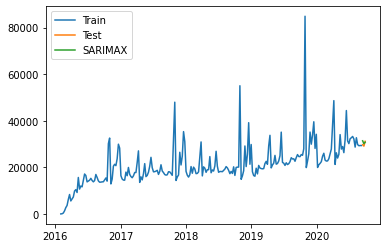

Current product:  9662
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.62139D+00    |proj g|=  9.33767D-02

At iterate    5    f=  9.59509D+00    |proj g|=  1.21570D-02

At iterate   10    f=  9.59490D+00    |proj g|=  5.78892D-04

At iterate   15    f=  9.59490D+00    |proj g|=  4.97301D-04

At iterate   20    f=  9.59481D+00    |proj g|=  5.94502D-03

At iterate   25    f=  9.58618D+00    |proj g|=  5.98734D-02

At iterate   30    f=  9.56408D+00    |proj g|=  1.50330D-03

At iterate   35    f=  9.56407D+00    |proj g|=  2.60858D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77005D+00    |proj g|=  4.77103D-02

At iterate    5    f=  9.73780D+00    |proj g|=  1.47718D-03

At iterate   10    f=  9.73776D+00    |proj g|=  3.55022D-04

At iterate   15    f=  9.73773D+00    |proj g|=  5.36764D-03

At iterate   20    f=  9.73409D+00    |proj g|=  4.90052D-02

At iterate   25    f=  9.72194D+00    |proj g|=  5.19718D-03

At iterate   30    f=  9.72083D+00    |proj g|=  4.31464D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76865D+00    |proj g|=  4.16952D-02

At iterate    5    f=  9.76661D+00    |proj g|=  4.00945D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   4.009D-05   9.767D+00
  F =   9.7666086403553987     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  81.4386253261268
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   1.652D-05   9.811D+00
  F =   9.8108473992565024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  527.1669834900597
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.62150D+00    |proj g|=  9.58526D-02

At iterate    5    f=  9.61419D+00    |proj g|=  6.39088D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   6.822D-05   9.614D+00
  F =   9.6141837596585358     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  122.24552327918785
Current parameter:  [(1, 1, 1), (2, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  9.59731D+00    |proj g|=  2.54506D-03

At iterate   10    f=  9.59713D+00    |proj g|=  8.21526D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     14      1     0     0   8.215D-05   9.597D+00
  F =   9.5971289392554109     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  458.68484177909284
Current parameter:  [(1, 1, 2), (1, 1, 2, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66656D+00    |proj g|=  2.43804D-

 This problem is unconstrained.



At iterate    5    f=  9.58640D+00    |proj g|=  1.70096D-02

At iterate   10    f=  9.57227D+00    |proj g|=  1.05119D-02

At iterate   15    f=  9.57137D+00    |proj g|=  1.57104D-03

At iterate   20    f=  9.57082D+00    |proj g|=  1.36271D-03

At iterate   25    f=  9.57081D+00    |proj g|=  8.04484D-05

At iterate   30    f=  9.57079D+00    |proj g|=  1.77241D-03

At iterate   35    f=  9.56887D+00    |proj g|=  1.66138D-02

At iterate   40    f=  9.54617D+00    |proj g|=  9.98476D-03

At iterate   45    f=  9.54306D+00    |proj g|=  5.77453D-04

At iterate   50    f=  9.54302D+00    |proj g|=  1.93962D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.59359D+00    |proj g|=  8.07120D-03

At iterate   10    f=  9.59096D+00    |proj g|=  5.87126D-04

At iterate   15    f=  9.59095D+00    |proj g|=  3.78011D-04

At iterate   20    f=  9.59095D+00    |proj g|=  5.77941D-04

At iterate   25    f=  9.59090D+00    |proj g|=  1.73146D-03

At iterate   30    f=  9.58508D+00    |proj g|=  2.55064D-02

At iterate   35    f=  9.55838D+00    |proj g|=  3.95797D-02

At iterate   40    f=  9.54990D+00    |proj g|=  9.10968D-04

At iterate   45    f=  9.54981D+00    |proj g|=  1.56649D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     55   

 This problem is unconstrained.



At iterate    5    f=  9.59258D+00    |proj g|=  1.11558D-02

At iterate   10    f=  9.58937D+00    |proj g|=  1.77221D-03

At iterate   15    f=  9.58933D+00    |proj g|=  3.82410D-04

At iterate   20    f=  9.58933D+00    |proj g|=  3.40569D-04

At iterate   25    f=  9.58932D+00    |proj g|=  8.78961D-04

At iterate   30    f=  9.58913D+00    |proj g|=  6.00816D-03

At iterate   35    f=  9.58023D+00    |proj g|=  4.14568D-02

At iterate   40    f=  9.55147D+00    |proj g|=  1.56901D-02

At iterate   45    f=  9.54919D+00    |proj g|=  1.62230D-03

At iterate   50    f=  9.54916D+00    |proj g|=  5.81215D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81330D+00    |proj g|=  2.27718D-01

At iterate    5    f=  9.72651D+00    |proj g|=  1.30952D-02

At iterate   10    f=  9.72075D+00    |proj g|=  2.39185D-03

At iterate   15    f=  9.72066D+00    |proj g|=  1.01194D-04

At iterate   20    f=  9.72065D+00    |proj g|=  4.05386D-04

At iterate   25    f=  9.72015D+00    |proj g|=  1.46895D-02

At iterate   30    f=  9.69779D+00    |proj g|=  3.49493D-02

At iterate   35    f=  9.69194D+00    |proj g|=  1.70625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00195D+01    |proj g|=  7.00844D-01

At iterate    5    f=  9.60020D+00    |proj g|=  3.54097D-02

At iterate   10    f=  9.58992D+00    |proj g|=  1.43955D-02

At iterate   15    f=  9.58810D+00    |proj g|=  4.55685D-04

At iterate   20    f=  9.58810D+00    |proj g|=  8.73813D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     21      1     0     0   8.738D-05   9.588D+00
  F =   9.5880953344342341     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01372D+01    |proj g|=  8.55412D-01

At iterate    5    f=  9.59498D+00    |proj g|=  2.77032D-02

At iterate   10    f=  9.58719D+00    |proj g|=  1.63648D-03

At iterate   15    f=  9.58710D+00    |proj g|=  8.72699D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     17      1     0     0   8.727D-05   9.587D+00
  F =   9.5870950366009033     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  3

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01454D+01    |proj g|=  8.79965D-01

At iterate    5    f=  9.60868D+00    |proj g|=  1.79832D-02

At iterate   10    f=  9.60509D+00    |proj g|=  5.19975D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     14      1     0     0   7.221D-05   9.605D+00
  F =   9.6050885556413039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  73.05445186572645
Current parameter:  [(1, 1, 2), (2, 1, 2, 52)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66656D+00    |proj g|=  2.43804D-01

At iterate    5    f=  9.58351D+00    |proj g|=  9.12262D-03

At iterate   10    f=  9.57109D+00    |proj g|=  8.20951D-03

At iterate   15    f=  9.56934D+00    |proj g|=  2.30093D-03

At iterate   20    f=  9.56874D+00    |proj g|=  6.95111D-04

At iterate   25    f=  9.56874D+00    |proj g|=  7.97701D-05

At iterate   30    f=  9.56873D+00    |proj g|=  1.05803D-03

At iterate   35    f=  9.56724D+00    |proj g|=  2.21628D-02

At iterate   40    f=  9.55122D+00    |proj g|=  1.09889D-02

At iterate   45    f=  9.54185D+00    |proj g|=  1.00099D-02

At iterate   50    f=  9.54163D+00    |proj g|=  5.00778D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61152D+00    |proj g|=  2.58766D-02

At iterate    5    f=  9.60954D+00    |proj g|=  7.14490D-03

At iterate   10    f=  9.60405D+00    |proj g|=  1.87151D-02

At iterate   15    f=  9.60355D+00    |proj g|=  5.06493D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     20      1     0     0   5.065D-05   9.604D+00
  F =   9.6035505090667961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.64200D+00    |proj g|=  7.04163D-02

At iterate    5    f=  9.59957D+00    |proj g|=  4.04978D-04

At iterate   10    f=  9.59956D+00    |proj g|=  6.92797D-04

At iterate   15    f=  9.59923D+00    |proj g|=  9.12885D-03

At iterate   20    f=  9.57306D+00    |proj g|=  4.83726D-02

At iterate   25    f=  9.56718D+00    |proj g|=  2.90052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     31      1     0     0   

 This problem is unconstrained.



At iterate    0    f=  1.01454D+01    |proj g|=  8.79965D-01

At iterate    5    f=  9.60868D+00    |proj g|=  1.79832D-02

At iterate   10    f=  9.60509D+00    |proj g|=  5.19975D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     14      1     0     0   7.221D-05   9.605D+00
  F =   9.6050885556413039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  9662
Best Configs:  [(2, 1, 1), (1, 1, 0, 52)]
Mean Absolute Error: 60.788
Mean Squared Error: 15600.337
Root Mean Squared Error: 73.054
Mean absolute percentage erro

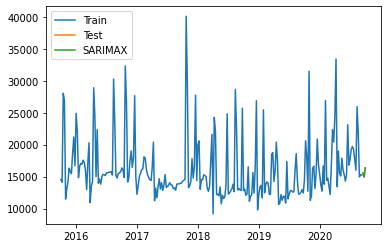

Current product:  9399
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35931D+00    |proj g|=  1.14998D-01

At iterate    5    f=  9.33612D+00    |proj g|=  1.70867D-02

At iterate   10    f=  9.33307D+00    |proj g|=  6.70954D-03

At iterate   15    f=  9.33251D+00    |proj g|=  9.13103D-04

At iterate   20    f=  9.33250D+00    |proj g|=  6.18292D-04

At iterate   25    f=  9.32841D+00    |proj g|=  1.32236D-01

At iterate   30    f=  9.28830D+00    |proj g|=  4.15643D-02

At iterate   35    f=  9.28719D+00    |proj g|=  1.23094D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  9.45720D+00    |proj g|=  7.39578D-03

At iterate   10    f=  9.45712D+00    |proj g|=  3.01934D-04

At iterate   15    f=  9.45708D+00    |proj g|=  6.46917D-03

At iterate   20    f=  9.45337D+00    |proj g|=  5.26966D-02

At iterate   25    f=  9.44562D+00    |proj g|=  7.87561D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   9.106D-06   9.446D+00
  F =   9.4456161326605947     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  319.14761142123393
Current parameter:  [(1, 1, 0), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46318D+00    |proj g|=  4.52597D-02

At iterate    5    f=  9.46090D+00    |proj g|=  6.36522D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   6.365D-05   9.461D+00
  F =   9.4608980075113145     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  512.8959806674134
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   7.619D-06   9.533D+00
  F =   9.5334283762562464     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  436.2059978789271
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35949D+00    |proj g|=  1.09644D-01


 This problem is unconstrained.



At iterate    5    f=  9.34247D+00    |proj g|=  3.86647D-03

At iterate   10    f=  9.34204D+00    |proj g|=  1.16351D-04

At iterate   15    f=  9.34204D+00    |proj g|=  1.36891D-03

At iterate   20    f=  9.34148D+00    |proj g|=  1.47990D-02

At iterate   25    f=  9.31150D+00    |proj g|=  3.56153D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     34      1     0     0   6.837D-06   9.311D+00
  F =   9.3107642372363468     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1322.478610660719
Current parameter:  [(1, 1, 1), (2, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.36746D+00    |proj g|=  9.53259D-02

At iterate    5    f=  9.35339D+00    |proj g|=  1.72114D-02

At iterate   10    f=  9.35163D+00    |proj g|=  3.82590D-03

At iterate   15    f=  9.35162D+00    |proj g|=  3.24867D-04

At iterate   20    f=  9.35136D+00    |proj g|=  7.88512D-03

At iterate   25    f=  9.31541D+00    |proj g|=  4.29663D-02

At iterate   30    f=  9.31213D+00    |proj g|=  8.38689D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41196D+00    |proj g|=  3.04352D-01

At iterate    5    f=  9.33011D+00    |proj g|=  1.02573D-02

At iterate   10    f=  9.32949D+00    |proj g|=  1.50893D-03

At iterate   15    f=  9.32946D+00    |proj g|=  2.84890D-04

At iterate   20    f=  9.32942D+00    |proj g|=  2.33034D-03

At iterate   25    f=  9.32938D+00    |proj g|=  1.14335D-04

At iterate   30    f=  9.32938D+00    |proj g|=  9.46940D-04

At iterate   35    f=  9.32161D+00    |proj g|=  5.44389D-02

At iterate   40    f=  9.29951D+00    |proj g|=  3.61080D-02

At iterate   45    f=  9.29753D+00    |proj g|=  2.29436D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  9.35554D+00    |proj g|=  1.49283D-02

At iterate   10    f=  9.34910D+00    |proj g|=  4.63781D-03

At iterate   15    f=  9.34802D+00    |proj g|=  1.81275D-03

At iterate   20    f=  9.34796D+00    |proj g|=  1.31432D-04

At iterate   25    f=  9.34796D+00    |proj g|=  1.25860D-03

At iterate   30    f=  9.34725D+00    |proj g|=  1.55671D-02

At iterate   35    f=  9.30995D+00    |proj g|=  6.46823D-02

At iterate   40    f=  9.29961D+00    |proj g|=  5.04941D-03

At iterate   45    f=  9.29887D+00    |proj g|=  5.05128D-04

At iterate   50    f=  9.29886D+00    |proj g|=  5.85157D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44298D+00    |proj g|=  3.01929D-01

At iterate    5    f=  9.35484D+00    |proj g|=  1.70224D-02

At iterate   10    f=  9.34876D+00    |proj g|=  3.98591D-03

At iterate   15    f=  9.34768D+00    |proj g|=  2.80394D-03

At iterate   20    f=  9.34764D+00    |proj g|=  1.41446D-04

At iterate   25    f=  9.34760D+00    |proj g|=  3.48077D-03

At iterate   30    f=  9.33787D+00    |proj g|=  3.63710D-02

At iterate   35    f=  9.30686D+00    |proj g|=  1.81518D-02

At iterate   40    f=  9.29861D+00    |proj g|=  1.04263D-02

At iterate   45    f=  9.29851D+00    |proj g|=  2.53758D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  9.45335D+00    |proj g|=  1.29592D-02

At iterate   10    f=  9.45104D+00    |proj g|=  8.63990D-04

At iterate   15    f=  9.45104D+00    |proj g|=  1.79995D-04

At iterate   20    f=  9.45099D+00    |proj g|=  7.42172D-03

At iterate   25    f=  9.43878D+00    |proj g|=  2.64040D-02

At iterate   30    f=  9.43248D+00    |proj g|=  2.00028D-03

At iterate   35    f=  9.43237D+00    |proj g|=  1.02309D-03

At iterate   40    f=  9.43232D+00    |proj g|=  9.27919D-04

At iterate   45    f=  9.43231D+00    |proj g|=  2.89655D-04

At iterate   50    f=  9.43231D+00    |proj g|=  1.10022D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41818D+00    |proj g|=  8.21309D-02

At iterate    5    f=  9.35089D+00    |proj g|=  5.77956D-03

At iterate   10    f=  9.35031D+00    |proj g|=  3.77730D-03

At iterate   15    f=  9.35010D+00    |proj g|=  8.81458D-03

At iterate   20    f=  9.34964D+00    |proj g|=  1.00986D-03

At iterate   25    f=  9.34963D+00    |proj g|=  2.95267D-04

At iterate   30    f=  9.34956D+00    |proj g|=  4.87042D-03

At iterate   35    f=  9.34600D+00    |proj g|=  2.87656D-02

At iterate   40    f=  9.31500D+00    |proj g|=  4.13813D-02

At iterate   45    f=  9.30950D+00    |proj g|=  2.35700D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.36517D+00    |proj g|=  1.19930D-01

At iterate    5    f=  9.33264D+00    |proj g|=  1.97092D-02

At iterate   10    f=  9.33230D+00    |proj g|=  1.97960D-03

At iterate   15    f=  9.33199D+00    |proj g|=  8.66398D-03

At iterate   20    f=  9.33181D+00    |proj g|=  1.33670D-04

At iterate   25    f=  9.33179D+00    |proj g|=  2.63225D-03

At iterate   30    f=  9.32929D+00    |proj g|=  3.99646D-02

At iterate   35    f=  9.28735D+00    |proj g|=  2.32921D-02

At iterate   40    f=  9.28614D+00    |proj g|=  9.12960D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.36502D+00    |proj g|=  1.19211D-01

At iterate    5    f=  9.34066D+00    |proj g|=  4.30784D-03

At iterate   10    f=  9.33897D+00    |proj g|=  1.54965D-03

At iterate   15    f=  9.33895D+00    |proj g|=  1.18165D-04

At iterate   20    f=  9.33886D+00    |proj g|=  2.59984D-03

At iterate   25    f=  9.32057D+00    |proj g|=  3.52532D-02

At iterate   30    f=  9.30548D+00    |proj g|=  2.87148D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41196D+00    |proj g|=  3.04352D-01

At iterate    5    f=  9.33112D+00    |proj g|=  3.67553D-02

At iterate   10    f=  9.32906D+00    |proj g|=  3.08980D-03

At iterate   15    f=  9.32898D+00    |proj g|=  1.12179D-04

At iterate   20    f=  9.32898D+00    |proj g|=  8.16822D-04

At iterate   25    f=  9.32888D+00    |proj g|=  2.66189D-03

At iterate   30    f=  9.32884D+00    |proj g|=  3.29090D-04

At iterate   35    f=  9.32868D+00    |proj g|=  2.32308D-02

At iterate   40    f=  9.31997D+00    |proj g|=  2.97129D-02

At iterate   45    f=  9.31391D+00    |proj g|=  2.93537D-02

At iterate   50    f=  9.30575D+00    |proj g|=  3.71683D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.32842D+00    |proj g|=  1.61520D-03

At iterate   10    f=  9.32841D+00    |proj g|=  1.34462D-04

At iterate   15    f=  9.32840D+00    |proj g|=  2.01707D-03

At iterate   20    f=  9.32837D+00    |proj g|=  2.41447D-03

At iterate   25    f=  9.32750D+00    |proj g|=  1.63274D-02

At iterate   30    f=  9.30991D+00    |proj g|=  1.01356D-02

At iterate   35    f=  9.30944D+00    |proj g|=  9.73653D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     39      1     0     0   7.006D-06   9.309D+00
  F =   9.3094442626168590     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38169D+00    |proj g|=  8.43012D-02

At iterate    5    f=  9.34300D+00    |proj g|=  8.80582D-03

At iterate   10    f=  9.34144D+00    |proj g|=  2.06714D-04

At iterate   15    f=  9.34132D+00    |proj g|=  3.03536D-04

At iterate   20    f=  9.31341D+00    |proj g|=  8.90236D-02

At iterate   25    f=  9.29382D+00    |proj g|=  1.64633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     36      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46402D+00    |proj g|=  6.98869D-02

At iterate    5    f=  9.45720D+00    |proj g|=  7.39578D-03

At iterate   10    f=  9.45712D+00    |proj g|=  3.01934D-04

At iterate   15    f=  9.45708D+00    |proj g|=  6.46917D-03

At iterate   20    f=  9.45337D+00    |proj g|=  5.26966D-02

At iterate   25    f=  9.44562D+00    |proj g|=  7.87561D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   

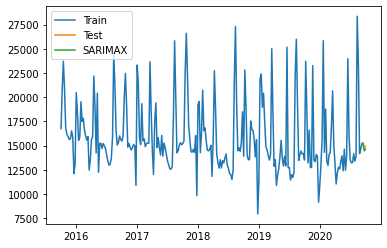

Current product:  9306
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.48910D+00    |proj g|=  1.66497D-01

At iterate    5    f=  9.41025D+00    |proj g|=  1.77924D-02

At iterate   10    f=  9.37902D+00    |proj g|=  3.49910D-03

At iterate   15    f=  9.37776D+00    |proj g|=  3.13727D-02

At iterate   20    f=  9.36978D+00    |proj g|=  2.40071D-02

At iterate   25    f=  9.36884D+00    |proj g|=  4.47768D-04

At iterate   30    f=  9.36880D+00    |proj g|=  3.69849D-03

At iterate   35    f=  9.36543D+00    |proj g|=  2.93077D-02

At iterate   40    f=  9.36246D+00    |proj g|=  3.67901D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  9.48089D+00    |proj g|=  2.08887D-02

At iterate   10    f=  9.46001D+00    |proj g|=  5.47439D-03

At iterate   15    f=  9.45996D+00    |proj g|=  1.80846D-03

At iterate   20    f=  9.45977D+00    |proj g|=  3.85550D-04

At iterate   25    f=  9.45966D+00    |proj g|=  6.42859D-04

At iterate   30    f=  9.45691D+00    |proj g|=  3.03541D-02

At iterate   35    f=  9.45409D+00    |proj g|=  9.88516D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     41      1     0     0   9.068D-06   9.454D+00
  F =   9.4540855309455694     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.45553D+00    |proj g|=  3.04466D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      8      1     0     0   3.045D-05   9.456D+00
  F =   9.4555304180530655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  465.7862023991814
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46178D+00    |proj g|=  3.21216D-02


 This problem is unconstrained.



At iterate    5    f=  9.46071D+00    |proj g|=  2.26313D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   2.263D-05   9.461D+00
  F =   9.4607133082862696     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  578.7551473475363
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37846D+00    |proj g|=  3.17725D-02


 This problem is unconstrained.



At iterate    5    f=  9.37360D+00    |proj g|=  1.32598D-02

At iterate   10    f=  9.37348D+00    |proj g|=  1.44347D-03

At iterate   15    f=  9.37255D+00    |proj g|=  1.95951D-02

At iterate   20    f=  9.36774D+00    |proj g|=  2.58843D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   2.709D-06   9.368D+00
  F =   9.3677235632458498     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1546.2789199130686
Current parameter:  [(1, 1, 1), (2, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42011D+00    |proj g|=  1.15420D-01

At iterate    5    f=  9.38445D+00    |proj g|=  4.63664D-03

At iterate   10    f=  9.38418D+00    |proj g|=  4.65007D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     15      1     0     0   4.952D-05   9.384D+00
  F =   9.3841834692918269     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1490.6139550528878
Current parameter:  [(1, 1, 2), (1, 1, 2, 52

 This problem is unconstrained.



At iterate    5    f=  9.37670D+00    |proj g|=  1.10424D-02

At iterate   10    f=  9.37219D+00    |proj g|=  5.48861D-03

At iterate   15    f=  9.37138D+00    |proj g|=  1.80683D-03

At iterate   20    f=  9.37114D+00    |proj g|=  3.34176D-04

At iterate   25    f=  9.37105D+00    |proj g|=  1.00388D-03

At iterate   30    f=  9.36905D+00    |proj g|=  1.96192D-02

At iterate   35    f=  9.35773D+00    |proj g|=  2.66479D-02

At iterate   40    f=  9.35579D+00    |proj g|=  4.82584D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     49      1     0     0   2.766D-05   9.356D+00
  F =   9.35578433009

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39799D+00    |proj g|=  6.73132D-02

At iterate    5    f=  9.37774D+00    |proj g|=  1.39662D-02

At iterate   10    f=  9.37460D+00    |proj g|=  5.56605D-03

At iterate   15    f=  9.37394D+00    |proj g|=  1.22009D-03

At iterate   20    f=  9.37363D+00    |proj g|=  1.17857D-03

At iterate   25    f=  9.37345D+00    |proj g|=  1.65355D-03

At iterate   30    f=  9.36092D+00    |proj g|=  2.21142D-02

At iterate   35    f=  9.35913D+00    |proj g|=  1.51985D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39799D+00    |proj g|=  6.73132D-02

At iterate    5    f=  9.37702D+00    |proj g|=  1.13500D-02

At iterate   10    f=  9.37435D+00    |proj g|=  5.29041D-03

At iterate   15    f=  9.37380D+00    |proj g|=  9.78385D-04

At iterate   20    f=  9.37361D+00    |proj g|=  1.93813D-03

At iterate   25    f=  9.37348D+00    |proj g|=  4.35189D-04

At iterate   30    f=  9.35894D+00    |proj g|=  2.22314D-03

At iterate   35    f=  9.35884D+00    |proj g|=  2.57083D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47441D+00    |proj g|=  9.45845D-02

At iterate    5    f=  9.44083D+00    |proj g|=  1.03294D-02

At iterate   10    f=  9.43539D+00    |proj g|=  8.56105D-03

At iterate   15    f=  9.43370D+00    |proj g|=  2.09835D-03

At iterate   20    f=  9.43343D+00    |proj g|=  9.49245D-04

At iterate   25    f=  9.43335D+00    |proj g|=  4.12183D-04

At iterate   30    f=  9.42415D+00    |proj g|=  1.77432D-02

At iterate   35    f=  9.42103D+00    |proj g|=  6.46132D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40233D+00    |proj g|=  8.09680D-02

At iterate    5    f=  9.38524D+00    |proj g|=  1.62529D-02

At iterate   10    f=  9.38126D+00    |proj g|=  3.16257D-03

At iterate   15    f=  9.38043D+00    |proj g|=  3.11836D-03

At iterate   20    f=  9.38036D+00    |proj g|=  4.80915D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     23      1     0     0   4.809D-05   9.380D+00
  F =   9.3803599505303872     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1584.4128637020965
Current parameter:  [(2, 1, 1), (1

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.48757D+00    |proj g|=  1.69076D-01

At iterate    5    f=  9.41725D+00    |proj g|=  5.79458D-02

At iterate   10    f=  9.38324D+00    |proj g|=  1.71279D-02

At iterate   15    f=  9.37791D+00    |proj g|=  4.28041D-03

At iterate   20    f=  9.37788D+00    |proj g|=  7.18225D-05

At iterate   25    f=  9.37785D+00    |proj g|=  2.94469D-03

At iterate   30    f=  9.37494D+00    |proj g|=  2.69030D-02

At iterate   35    f=  9.37464D+00    |proj g|=  2.51938D-02

At iterate   40    f=  9.36929D+00    |proj g|=  3.86853D-02

At iterate   45    f=  9.36609D+00    |proj g|=  1.72042D-03

At iterate   50    f=  9.36597D+00    |proj g|=  2.13845D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.37609D+00    |proj g|=  3.02823D-02

At iterate   10    f=  9.36860D+00    |proj g|=  2.25834D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     16      1     0     0   5.476D-05   9.369D+00
  F =   9.3685959896423245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1476.60729040876
Current parameter:  [(1, 1, 2), (2, 1, 2, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39615D+00    |proj g|=  6.59339D-02

 This problem is unconstrained.



At iterate    5    f=  9.37683D+00    |proj g|=  1.74818D-02

At iterate   10    f=  9.37237D+00    |proj g|=  7.26265D-03

At iterate   15    f=  9.37169D+00    |proj g|=  2.21512D-03

At iterate   20    f=  9.37123D+00    |proj g|=  1.94761D-03

At iterate   25    f=  9.37115D+00    |proj g|=  6.84023D-04

At iterate   30    f=  9.37108D+00    |proj g|=  5.69068D-04

At iterate   35    f=  9.37072D+00    |proj g|=  5.69420D-03

At iterate   40    f=  9.35986D+00    |proj g|=  2.65919D-02

At iterate   45    f=  9.35547D+00    |proj g|=  3.01534D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     53   

 This problem is unconstrained.



At iterate    5    f=  9.37690D+00    |proj g|=  6.07933D-03

At iterate   10    f=  9.37330D+00    |proj g|=  4.44105D-03

At iterate   15    f=  9.37314D+00    |proj g|=  6.10223D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     21      1     0     0   6.102D-05   9.373D+00
  F =   9.3731390125818717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1530.4391397871104
Current parameter:  [(0, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the boun

 This problem is unconstrained.



At iterate    5    f=  9.38553D+00    |proj g|=  1.69499D-02

At iterate   10    f=  9.37898D+00    |proj g|=  2.40993D-04

At iterate   15    f=  9.37630D+00    |proj g|=  2.69104D-02

At iterate   20    f=  9.37035D+00    |proj g|=  9.26632D-03

At iterate   25    f=  9.36948D+00    |proj g|=  5.65132D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     44      1     0     0   5.651D-05   9.369D+00
  F =   9.3694831465039101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1606.4221977288537
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  9.45553D+00    |proj g|=  3.04466D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      8      1     0     0   3.045D-05   9.456D+00
  F =   9.4555304180530655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  9306
Best Configs:  [(1, 1, 0), (1, 1, 0, 52)]
Mean Absolute Error: 384.015
Mean Squared Error: 19203.018
Root Mean Squared Error: 465.786
Mean absolute percentage error: 2.027
Scaled Mean absolute percentage error: 1.998
Mean forecast error: 19583.778
Normalised mean squared error: 0.622


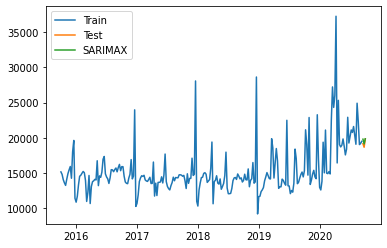

Current product:  9400
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.07354D+00    |proj g|=  1.13866D-01

At iterate    5    f=  9.02857D+00    |proj g|=  4.79132D-02

At iterate   10    f=  9.02593D+00    |proj g|=  1.89849D-04

At iterate   15    f=  9.02574D+00    |proj g|=  7.31245D-03

At iterate   20    f=  9.02084D+00    |proj g|=  1.29824D-02

At iterate   25    f=  9.02054D+00    |proj g|=  1.96567D-04

At iterate   30    f=  9.02049D+00    |proj g|=  4.85326D-03

At iterate   35    f=  9.01471D+00    |proj g|=  5.25905D-02

At iterate   40    f=  8.98066D+00    |proj g|=  2.58549D-02

At iterate   45    f=  8.97390D+00    |proj g|=  7.57878D-03

At iterate   50    f=  8.97357D+00    |proj g|=  1.11089D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12196D+00    |proj g|=  1.30365D-01

At iterate    5    f=  9.09850D+00    |proj g|=  1.81608D-02

At iterate   10    f=  9.09785D+00    |proj g|=  1.11819D-04

At iterate   15    f=  9.09784D+00    |proj g|=  1.87667D-03

At iterate   20    f=  9.09613D+00    |proj g|=  1.30994D-02

At iterate   25    f=  9.07802D+00    |proj g|=  2.39900D-02

At iterate   30    f=  9.07698D+00    |proj g|=  1.29795D-02

At iterate   35    f=  9.07591D+00    |proj g|=  4.51193D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11293D+00    |proj g|=  2.10790D-02

At iterate    5    f=  9.11223D+00    |proj g|=  3.68966D-04

At iterate   10    f=  9.11214D+00    |proj g|=  8.12506D-03

At iterate   15    f=  9.10624D+00    |proj g|=  5.23115D-02

At iterate   20    f=  9.09970D+00    |proj g|=  3.05834D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     24      1     0     0   7.554D-06   9.100D+00
  F =   9.0996976165753072     

CONVERG

 This problem is unconstrained.


rmse:  77.72999715789834
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.06933D+00    |proj g|=  5.08504D-02


 This problem is unconstrained.



At iterate    5    f=  9.05870D+00    |proj g|=  4.97476D-04

At iterate   10    f=  9.04849D+00    |proj g|=  1.16258D-01

At iterate   15    f=  9.03673D+00    |proj g|=  2.02072D-04

At iterate   20    f=  9.03667D+00    |proj g|=  3.41704D-03

At iterate   25    f=  9.03024D+00    |proj g|=  2.30229D-02

At iterate   30    f=  9.01164D+00    |proj g|=  4.48130D-02

At iterate   35    f=  9.00979D+00    |proj g|=  6.43290D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     54      1     0     0   6.433D-06   9.010D+00
  F =   9.0097868172103031     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.08263D+00    |proj g|=  5.41658D-02

At iterate    5    f=  9.06832D+00    |proj g|=  2.54623D-04

At iterate   10    f=  9.06825D+00    |proj g|=  4.77717D-03

At iterate   15    f=  9.05206D+00    |proj g|=  1.01444D-02

At iterate   20    f=  9.05182D+00    |proj g|=  1.84708D-04

At iterate   25    f=  9.05179D+00    |proj g|=  4.65081D-03

At iterate   30    f=  9.04840D+00    |proj g|=  4.60543D-02

At iterate   35    f=  9.02078D+00    |proj g|=  2.64148D-02

At iterate   40    f=  9.01946D+00    |proj g|=  6.89712D-03

At iterate   45    f=  9.01936D+00    |proj g|=  6.09715D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  9.02780D+00    |proj g|=  9.00934D-03

At iterate   10    f=  9.02509D+00    |proj g|=  7.66836D-03

At iterate   15    f=  9.02268D+00    |proj g|=  4.86148D-02

At iterate   20    f=  9.01708D+00    |proj g|=  2.36490D-03

At iterate   25    f=  9.01704D+00    |proj g|=  1.80629D-04

At iterate   30    f=  9.01697D+00    |proj g|=  3.20249D-03

At iterate   35    f=  9.01437D+00    |proj g|=  1.13898D-02

At iterate   40    f=  8.99322D+00    |proj g|=  2.27685D-02

At iterate   45    f=  8.97684D+00    |proj g|=  6.58962D-03

At iterate   50    f=  8.97635D+00    |proj g|=  2.85723D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16545D+00    |proj g|=  3.26356D-01

At iterate    5    f=  9.05180D+00    |proj g|=  1.01846D-02

At iterate   10    f=  9.05008D+00    |proj g|=  3.49715D-04

At iterate   15    f=  9.05007D+00    |proj g|=  1.71805D-03

At iterate   20    f=  9.04162D+00    |proj g|=  1.74957D-02

At iterate   25    f=  9.03832D+00    |proj g|=  5.23020D-04

At iterate   30    f=  9.03830D+00    |proj g|=  1.30802D-03

At iterate   35    f=  9.03663D+00    |proj g|=  2.00805D-02

At iterate   40    f=  9.00084D+00    |proj g|=  6.84823D-02

At iterate   45    f=  8.98454D+00    |proj g|=  2.42478D-03

At iterate   50    f=  8.98226D+00    |proj g|=  4.25056D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.05042D+00    |proj g|=  8.45561D-03

At iterate   10    f=  9.04853D+00    |proj g|=  4.84914D-03

At iterate   15    f=  9.04842D+00    |proj g|=  4.75109D-04

At iterate   20    f=  9.04829D+00    |proj g|=  8.49199D-03

At iterate   25    f=  9.03807D+00    |proj g|=  1.16005D-03

At iterate   30    f=  9.03802D+00    |proj g|=  5.13832D-04

At iterate   35    f=  9.03796D+00    |proj g|=  2.13414D-03

At iterate   40    f=  9.00184D+00    |proj g|=  9.59879D-02

At iterate   45    f=  8.98136D+00    |proj g|=  3.04975D-02

At iterate   50    f=  8.97949D+00    |proj g|=  1.83890D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.09391D+00    |proj g|=  1.06907D-02

At iterate   10    f=  9.09104D+00    |proj g|=  8.45207D-03

At iterate   15    f=  9.09085D+00    |proj g|=  1.31814D-04

At iterate   20    f=  9.09084D+00    |proj g|=  1.59078D-03

At iterate   25    f=  9.08917D+00    |proj g|=  1.75743D-02

At iterate   30    f=  9.06172D+00    |proj g|=  2.19385D-02

At iterate   35    f=  9.05562D+00    |proj g|=  1.27501D-03

At iterate   40    f=  9.05559D+00    |proj g|=  2.10059D-03

At iterate   45    f=  9.05509D+00    |proj g|=  5.81391D-03

At iterate   50    f=  9.05460D+00    |proj g|=  3.36456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.05893D+00    |proj g|=  1.15468D-01

At iterate    5    f=  9.04323D+00    |proj g|=  2.32083D-03

At iterate   10    f=  9.04283D+00    |proj g|=  2.37406D-03

At iterate   15    f=  9.04282D+00    |proj g|=  3.47164D-04

At iterate   20    f=  9.04281D+00    |proj g|=  5.54549D-04

At iterate   25    f=  9.04256D+00    |proj g|=  6.56121D-03

At iterate   30    f=  9.02065D+00    |proj g|=  7.42160D-02

At iterate   35    f=  8.99868D+00    |proj g|=  3.20175D-03

At iterate   40    f=  8.99844D+00    |proj g|=  1.17607D-03

At iterate   45    f=  8.99822D+00    |proj g|=  2.75108D-03

At iterate   50    f=  8.99813D+00    |proj g|=  1.62030D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.04595D+00    |proj g|=  1.14566D-01

At iterate    5    f=  9.01805D+00    |proj g|=  3.80359D-02

At iterate   10    f=  9.01475D+00    |proj g|=  4.31891D-03

At iterate   15    f=  9.01460D+00    |proj g|=  1.66577D-04

At iterate   20    f=  9.01448D+00    |proj g|=  3.98445D-03

At iterate   25    f=  8.98513D+00    |proj g|=  8.63125D-02

At iterate   30    f=  8.96573D+00    |proj g|=  1.17063D-02

At iterate   35    f=  8.96502D+00    |proj g|=  2.04884D-03

At iterate   40    f=  8.96492D+00    |proj g|=  4.83290D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.03893D+00    |proj g|=  8.06203D-02

At iterate    5    f=  9.02941D+00    |proj g|=  1.19473D-02

At iterate   10    f=  9.02888D+00    |proj g|=  1.39286D-04

At iterate   15    f=  9.02888D+00    |proj g|=  1.28917D-03

At iterate   20    f=  9.02802D+00    |proj g|=  1.64502D-02

At iterate   25    f=  9.00190D+00    |proj g|=  3.17900D-02

At iterate   30    f=  9.00010D+00    |proj g|=  6.41441D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12847D+00    |proj g|=  3.34678D-01

At iterate    5    f=  9.02662D+00    |proj g|=  7.65315D-03

At iterate   10    f=  9.02455D+00    |proj g|=  3.05154D-03

At iterate   15    f=  9.02158D+00    |proj g|=  1.45958D-02

At iterate   20    f=  9.01713D+00    |proj g|=  4.40966D-03

At iterate   25    f=  9.01701D+00    |proj g|=  1.80395D-04

At iterate   30    f=  9.01700D+00    |proj g|=  9.83832D-04

At iterate   35    f=  9.01596D+00    |proj g|=  1.04929D-02

At iterate   40    f=  8.98855D+00    |proj g|=  8.16074D-03

At iterate   45    f=  8.97881D+00    |proj g|=  2.64665D-02

At iterate   50    f=  8.97560D+00    |proj g|=  3.42451D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.03502D+00    |proj g|=  3.87561D-02

At iterate    5    f=  9.03162D+00    |proj g|=  9.62684D-03

At iterate   10    f=  9.02119D+00    |proj g|=  4.88732D-03

At iterate   15    f=  9.02114D+00    |proj g|=  1.35940D-04

At iterate   20    f=  9.02113D+00    |proj g|=  3.85591D-03

At iterate   25    f=  9.01957D+00    |proj g|=  4.08691D-02

At iterate   30    f=  9.00582D+00    |proj g|=  4.58448D-02

At iterate   35    f=  9.00310D+00    |proj g|=  7.40844D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  9.07754D+00    |proj g|=  8.82005D-03

At iterate   10    f=  9.07705D+00    |proj g|=  2.44462D-04

At iterate   15    f=  9.07704D+00    |proj g|=  9.82767D-04

At iterate   20    f=  9.07585D+00    |proj g|=  3.29914D-02

At iterate   25    f=  9.04883D+00    |proj g|=  1.19138D-02

At iterate   30    f=  9.04396D+00    |proj g|=  1.11365D-02

At iterate   35    f=  9.04117D+00    |proj g|=  8.65442D-04

At iterate   40    f=  9.04061D+00    |proj g|=  1.45566D-03

At iterate   45    f=  9.04044D+00    |proj g|=  2.44901D-04

At iterate   50    f=  9.04040D+00    |proj g|=  2.26038D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.02941D+00    |proj g|=  1.19473D-02

At iterate   10    f=  9.02888D+00    |proj g|=  1.39286D-04

At iterate   15    f=  9.02888D+00    |proj g|=  1.28917D-03

At iterate   20    f=  9.02802D+00    |proj g|=  1.64502D-02

At iterate   25    f=  9.00190D+00    |proj g|=  3.17900D-02

At iterate   30    f=  9.00010D+00    |proj g|=  6.41441D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     34      1     0     0   1.033D-04   9.000D+00
  F =   9.0001025744745409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

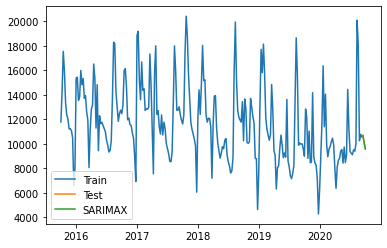

Current product:  10135
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12495D+00    |proj g|=  8.26641D-02

At iterate    5    f=  9.10465D+00    |proj g|=  6.12224D-03

At iterate   10    f=  9.10395D+00    |proj g|=  4.22963D-05

At iterate   15    f=  9.10395D+00    |proj g|=  9.20362D-04

At iterate   20    f=  9.10340D+00    |proj g|=  9.89425D-03

At iterate   25    f=  9.10132D+00    |proj g|=  4.86983D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     33      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17433D+00    |proj g|=  9.91486D-02

At iterate    5    f=  9.14872D+00    |proj g|=  3.34303D-02

At iterate   10    f=  9.14703D+00    |proj g|=  7.78694D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   2.041D-05   9.147D+00
  F =   9.1470302839505653     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  382.36227924392443
Current parameter:  [(1, 1, 0), (1, 1, 0, 52

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16880D+00    |proj g|=  9.92683D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   4.912D-06   9.161D+00
  F =   9.1607120591988149     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  412.33409412290206
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  9.19374D+00    |proj g|=  5.25516D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   5.255D-05   9.194D+00
  F =   9.1937422596457399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  355.99244808844537
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12636D+00    |proj g|=  1.22276D-01

At iterate    5    f=  9.10879D+00    |proj g|=  1.14294D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   4.138D-05   9.109D+00
  F =   9.1087864580647135     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  644.2407317735666
Current parameter:  [(1, 1, 1), (2, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  9.07318D+00    |proj g|=  1.01664D-02

At iterate   10    f=  9.07282D+00    |proj g|=  1.06308D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     12      1     0     0   1.063D-04   9.073D+00
  F =   9.0728186426352462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  721.4217463991199
Current parameter:  [(1, 1, 2), (1, 1, 2, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14365D+00    |proj g|=  2.06919D-01

At iterate    5    f=  9.07589D+00    |proj g|=  2.53314D-02

At iterate   10    f=  9.06250D+00    |proj g|=  4.44561D-03

At iterate   15    f=  9.06088D+00    |proj g|=  3.60965D-03

At iterate   20    f=  9.06086D+00    |proj g|=  2.91612D-04

At iterate   25    f=  9.06083D+00    |proj g|=  4.07474D-03

At iterate   30    f=  9.05539D+00    |proj g|=  8.46761D-03

At iterate   35    f=  9.03647D+00    |proj g|=  5.65816D-03

At iterate   40    f=  9.03619D+00    |proj g|=  6.04196D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  9.07598D+00    |proj g|=  5.69184D-02

At iterate   10    f=  9.07260D+00    |proj g|=  1.86330D-03

At iterate   15    f=  9.07258D+00    |proj g|=  1.16048D-04

At iterate   20    f=  9.07255D+00    |proj g|=  3.47462D-03

At iterate   25    f=  9.06888D+00    |proj g|=  4.32876D-02

At iterate   30    f=  9.04330D+00    |proj g|=  7.01683D-03

At iterate   35    f=  9.04293D+00    |proj g|=  1.56266D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     40      1     0     0   1.090D-05   9.043D+00
  F =   9.0429211299015453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14389D+00    |proj g|=  1.92631D-01

At iterate    5    f=  9.06869D+00    |proj g|=  1.12547D-02

At iterate   10    f=  9.06804D+00    |proj g|=  3.60146D-03

At iterate   15    f=  9.06800D+00    |proj g|=  1.16419D-04

At iterate   20    f=  9.06793D+00    |proj g|=  5.06030D-03

At iterate   25    f=  9.06056D+00    |proj g|=  5.23549D-02

At iterate   30    f=  9.04093D+00    |proj g|=  7.36622D-03

At iterate   35    f=  9.04008D+00    |proj g|=  3.03005D-02

At iterate   40    f=  9.03838D+00    |proj g|=  4.91727D-03

At iterate   45    f=  9.03834D+00    |proj g|=  7.97121D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19183D+00    |proj g|=  1.86507D-01

At iterate    5    f=  9.13487D+00    |proj g|=  1.37270D-02

At iterate   10    f=  9.13184D+00    |proj g|=  1.82863D-03

At iterate   15    f=  9.13182D+00    |proj g|=  2.32918D-04

At iterate   20    f=  9.13166D+00    |proj g|=  3.63289D-03

At iterate   25    f=  9.12708D+00    |proj g|=  2.15477D-02

At iterate   30    f=  9.12583D+00    |proj g|=  4.54641D-03

At iterate   35    f=  9.12560D+00    |proj g|=  1.05906D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15496D+00    |proj g|=  2.14569D-01

At iterate    5    f=  9.08681D+00    |proj g|=  4.69232D-02

At iterate   10    f=  9.06868D+00    |proj g|=  7.52245D-03

At iterate   15    f=  9.06845D+00    |proj g|=  3.75232D-03

At iterate   20    f=  9.06843D+00    |proj g|=  9.78765D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     22      1     0     0   9.788D-05   9.068D+00
  F =   9.0684268827167482     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  9.10165D+00    |proj g|=  4.27224D-02

At iterate   10    f=  9.09953D+00    |proj g|=  6.87729D-03

At iterate   15    f=  9.09920D+00    |proj g|=  3.46326D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     19      1     0     0   3.463D-05   9.099D+00
  F =   9.0991986774997269     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  508.62866944364816
Current parameter:  [(2, 1, 1), (1, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the boun

 This problem is unconstrained.



At iterate    5    f=  9.11345D+00    |proj g|=  2.58613D-02

At iterate   10    f=  9.10719D+00    |proj g|=  7.58481D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     16      1     0     0   3.020D-05   9.107D+00
  F =   9.1071938050107661     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  618.5479877980754
Current parameter:  [(1, 1, 2), (2, 1, 2, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14365D+00    |proj g|=  2.06919D-0

 This problem is unconstrained.



At iterate    5    f=  9.07074D+00    |proj g|=  3.15932D-02

At iterate   10    f=  9.05806D+00    |proj g|=  6.32958D-03

At iterate   15    f=  9.05553D+00    |proj g|=  4.75709D-03

At iterate   20    f=  9.05541D+00    |proj g|=  1.10843D-04

At iterate   25    f=  9.05541D+00    |proj g|=  1.14204D-03

At iterate   30    f=  9.05444D+00    |proj g|=  1.12000D-02

At iterate   35    f=  9.04080D+00    |proj g|=  3.75993D-02

At iterate   40    f=  9.03019D+00    |proj g|=  4.27533D-03

At iterate   45    f=  9.02977D+00    |proj g|=  2.40859D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     55   

 This problem is unconstrained.



At iterate    5    f=  9.11177D+00    |proj g|=  1.79497D-02

At iterate   10    f=  9.09915D+00    |proj g|=  2.10783D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     18      1     0     0   3.097D-05   9.099D+00
  F =   9.0991402422834238     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  677.8286445207691
Current parameter:  [(0, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11788D+00    |proj g|=  8.00513D-02

At iterate    5    f=  9.10546D+00    |proj g|=  8.22474D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     12      1     0     0   4.834D-05   9.105D+00
  F =   9.1054616273620983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  580.1041407664425
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =       

 This problem is unconstrained.



At iterate    5    f=  9.19374D+00    |proj g|=  5.25516D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   5.255D-05   9.194D+00
  F =   9.1937422596457399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  10135
Best Configs:  [(1, 1, 0), (0, 1, 0, 52)]
Mean Absolute Error: 285.681
Mean Squared Error: 13965.688
Root Mean Squared Error: 355.992
Mean absolute percentage error: 2.007
Scaled Mean absolute percentage error: 2.022
Mean forecast error: 13870.688
Normalised mean squared error: 0.362

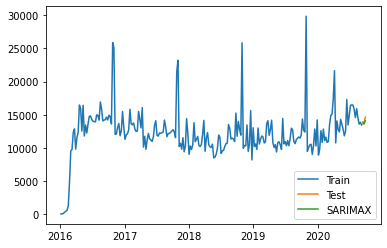

Current product:  9898
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68192D+00    |proj g|=  2.96342D-01

At iterate    5    f=  8.57819D+00    |proj g|=  3.07355D-02

At iterate   10    f=  8.57245D+00    |proj g|=  4.61560D-03

At iterate   15    f=  8.57240D+00    |proj g|=  6.04266D-04

At iterate   20    f=  8.57045D+00    |proj g|=  1.03711D-02

At iterate   25    f=  8.54839D+00    |proj g|=  3.10737D-02

At iterate   30    f=  8.54425D+00    |proj g|=  1.26929D-02

At iterate   35    f=  8.54238D+00    |proj g|=  1.63826D-03

At iterate   40    f=  8.54207D+00    |proj g|=  7.27088D-04

At iterate   45    f=  8.54202D+00    |proj g|=  8.02663D-04

At iterate   50    f=  8.54201D+00    |proj g|=  4.15392D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.76083D+00    |proj g|=  3.14512D-01

At iterate    5    f=  8.65907D+00    |proj g|=  1.57033D-02

At iterate   10    f=  8.65693D+00    |proj g|=  1.13602D-04

At iterate   15    f=  8.65690D+00    |proj g|=  2.04239D-03

At iterate   20    f=  8.65483D+00    |proj g|=  1.67009D-02

At iterate   25    f=  8.64301D+00    |proj g|=  3.54479D-03

At iterate   30    f=  8.64295D+00    |proj g|=  2.53806D-03

At iterate   35    f=  8.64237D+00    |proj g|=  2.07933D-03

At iterate   40    f=  8.64216D+00    |proj g|=  1.11942D-03

At iterate   45    f=  8.64212D+00    |proj g|=  2.81617D-04

At iterate   50    f=  8.64211D+00    |proj g|=  3.67382D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   6.095D-05   8.673D+00
  F =   8.6731803585912459     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  420.99394000800555
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69888D+00    |proj g|=  8.32622D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number o

 This problem is unconstrained.


rmse:  485.5284169727596
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61994D+00    |proj g|=  9.41305D-02

At iterate    5    f=  8.59311D+00    |proj g|=  1.29402D-02

At iterate   10    f=  8.59218D+00    |proj g|=  1.45157D-03

At iterate   15    f=  8.59016D+00    |proj g|=  2.19321D-02

At iterate   20    f=  8.57799D+00    |proj g|=  1.10672D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   3.851D-06   8.578D+00
  F =   8.5778921907246488     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  8.60417D+00    |proj g|=  5.25648D-03

At iterate   10    f=  8.60388D+00    |proj g|=  2.46360D-04

At iterate   15    f=  8.60297D+00    |proj g|=  5.26815D-03

At iterate   20    f=  8.58179D+00    |proj g|=  8.83041D-02

At iterate   25    f=  8.57643D+00    |proj g|=  5.85294D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   2.182D-06   8.576D+00
  F =   8.5764341413005472     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  662.3275435998524
Current parameter:  [(1, 1, 2), (1, 1, 2, 52)]
RUNNING THE L-BFGS-B CODE

           * *

 This problem is unconstrained.



At iterate    5    f=  8.57306D+00    |proj g|=  4.80612D-03

At iterate   10    f=  8.57215D+00    |proj g|=  1.37349D-03

At iterate   15    f=  8.57212D+00    |proj g|=  9.65097D-04

At iterate   20    f=  8.57146D+00    |proj g|=  1.12865D-02

At iterate   25    f=  8.54775D+00    |proj g|=  2.15936D-02

At iterate   30    f=  8.52612D+00    |proj g|=  4.83360D-03

At iterate   35    f=  8.52515D+00    |proj g|=  2.33885D-03

At iterate   40    f=  8.52505D+00    |proj g|=  2.84251D-04

At iterate   45    f=  8.52503D+00    |proj g|=  1.49867D-03

At iterate   50    f=  8.52490D+00    |proj g|=  6.50176D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.59293D+00    |proj g|=  8.06413D-03

At iterate   10    f=  8.59066D+00    |proj g|=  2.05720D-03

At iterate   15    f=  8.59052D+00    |proj g|=  2.47065D-04

At iterate   20    f=  8.59044D+00    |proj g|=  4.14946D-03

At iterate   25    f=  8.57202D+00    |proj g|=  5.96296D-02

At iterate   30    f=  8.53962D+00    |proj g|=  3.08112D-02

At iterate   35    f=  8.53344D+00    |proj g|=  7.30744D-03

At iterate   40    f=  8.53302D+00    |proj g|=  2.05135D-03

At iterate   45    f=  8.53190D+00    |proj g|=  1.41134D-02

At iterate   50    f=  8.53146D+00    |proj g|=  3.03396D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65843D+00    |proj g|=  1.49006D-01

At iterate    5    f=  8.59161D+00    |proj g|=  8.32447D-03

At iterate   10    f=  8.58922D+00    |proj g|=  3.37300D-03

At iterate   15    f=  8.58918D+00    |proj g|=  3.80195D-04

At iterate   20    f=  8.58881D+00    |proj g|=  6.25011D-03

At iterate   25    f=  8.55859D+00    |proj g|=  5.87136D-02

At iterate   30    f=  8.54639D+00    |proj g|=  1.33258D-02

At iterate   35    f=  8.53157D+00    |proj g|=  1.35063D-03

At iterate   40    f=  8.53111D+00    |proj g|=  8.85603D-03

At iterate   45    f=  8.53067D+00    |proj g|=  2.02697D-04

At iterate   50    f=  8.53067D+00    |proj g|=  3.54726D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy po

 This problem is unconstrained.



At iterate    5    f=  8.64306D+00    |proj g|=  8.65324D-03

At iterate   10    f=  8.64139D+00    |proj g|=  3.39962D-04

At iterate   15    f=  8.64139D+00    |proj g|=  1.32889D-03

At iterate   20    f=  8.64062D+00    |proj g|=  1.53066D-02

At iterate   25    f=  8.60242D+00    |proj g|=  1.71634D-02

At iterate   30    f=  8.60178D+00    |proj g|=  3.65553D-03

At iterate   35    f=  8.60071D+00    |proj g|=  6.78502D-03

At iterate   40    f=  8.60058D+00    |proj g|=  2.46138D-04

At iterate   45    f=  8.60058D+00    |proj g|=  2.96739D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     50   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77859D+00    |proj g|=  4.20355D-01

At iterate    5    f=  8.61767D+00    |proj g|=  6.96783D-02

At iterate   10    f=  8.59537D+00    |proj g|=  3.18141D-02

At iterate   15    f=  8.59103D+00    |proj g|=  3.63564D-03

At iterate   20    f=  8.59084D+00    |proj g|=  1.93618D-04

At iterate   25    f=  8.59082D+00    |proj g|=  2.32639D-03

At iterate   30    f=  8.58791D+00    |proj g|=  2.65289D-02

At iterate   35    f=  8.56161D+00    |proj g|=  8.59177D-03

At iterate   40    f=  8.56125D+00    |proj g|=  1.48206D-03

At iterate   45    f=  8.56052D+00    |proj g|=  9.33750D-03

At iterate   50    f=  8.55985D+00    |proj g|=  4.57979D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.61102D+00    |proj g|=  5.04363D-02

At iterate   10    f=  8.56628D+00    |proj g|=  1.30726D-02

At iterate   15    f=  8.56185D+00    |proj g|=  1.90330D-03

At iterate   20    f=  8.56181D+00    |proj g|=  2.35551D-04

At iterate   25    f=  8.56166D+00    |proj g|=  6.51422D-03

At iterate   30    f=  8.55385D+00    |proj g|=  2.71870D-02

At iterate   35    f=  8.54457D+00    |proj g|=  2.17883D-03

At iterate   40    f=  8.54329D+00    |proj g|=  2.73066D-02

At iterate   45    f=  8.54151D+00    |proj g|=  6.59251D-03

At iterate   50    f=  8.54116D+00    |proj g|=  3.06139D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77697D+00    |proj g|=  4.84292D-01

At iterate    5    f=  8.61044D+00    |proj g|=  5.50495D-02

At iterate   10    f=  8.57754D+00    |proj g|=  2.60125D-02

At iterate   15    f=  8.57590D+00    |proj g|=  1.36294D-04

At iterate   20    f=  8.57552D+00    |proj g|=  6.12361D-03

At iterate   25    f=  8.56805D+00    |proj g|=  1.19280D-02

At iterate   30    f=  8.56696D+00    |proj g|=  6.93436D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.62333D+00    |proj g|=  1.43191D-01

At iterate    5    f=  8.57122D+00    |proj g|=  1.12276D-02

At iterate   10    f=  8.57046D+00    |proj g|=  6.07961D-03

At iterate   15    f=  8.57028D+00    |proj g|=  4.14969D-04

At iterate   20    f=  8.57027D+00    |proj g|=  1.02418D-03

At iterate   25    f=  8.56967D+00    |proj g|=  1.00746D-02

At iterate   30    f=  8.54461D+00    |proj g|=  4.19576D-02

At iterate   35    f=  8.52652D+00    |proj g|=  1.09544D-02

At iterate   40    f=  8.52555D+00    |proj g|=  6.34395D-03

At iterate   45    f=  8.52429D+00    |proj g|=  7.97602D-04

At iterate   50    f=  8.52425D+00    |proj g|=  4.43189D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.60627D+00    |proj g|=  9.68783D-02

At iterate    5    f=  8.59614D+00    |proj g|=  3.47059D-02

At iterate   10    f=  8.58371D+00    |proj g|=  3.94887D-03

At iterate   15    f=  8.58349D+00    |proj g|=  1.27626D-04

At iterate   20    f=  8.58349D+00    |proj g|=  1.25052D-03

At iterate   25    f=  8.58319D+00    |proj g|=  1.58679D-02

At iterate   30    f=  8.57605D+00    |proj g|=  1.71023D-02

At iterate   35    f=  8.57568D+00    |proj g|=  3.44486D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  8.58984D+00    |proj g|=  2.70081D-02

At iterate   10    f=  8.58687D+00    |proj g|=  2.80157D-04

At iterate   15    f=  8.58685D+00    |proj g|=  2.00185D-03

At iterate   20    f=  8.58359D+00    |proj g|=  3.44745D-02

At iterate   25    f=  8.56174D+00    |proj g|=  1.69058D-02

At iterate   30    f=  8.55584D+00    |proj g|=  1.61378D-03

At iterate   35    f=  8.55480D+00    |proj g|=  8.94330D-03

At iterate   40    f=  8.55449D+00    |proj g|=  1.80791D-03

At iterate   45    f=  8.55444D+00    |proj g|=  2.89935D-05

At iterate   50    f=  8.55444D+00    |proj g|=  1.79853D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.59614D+00    |proj g|=  3.47059D-02

At iterate   10    f=  8.58371D+00    |proj g|=  3.94887D-03

At iterate   15    f=  8.58349D+00    |proj g|=  1.27626D-04

At iterate   20    f=  8.58349D+00    |proj g|=  1.25052D-03

At iterate   25    f=  8.58319D+00    |proj g|=  1.58679D-02

At iterate   30    f=  8.57605D+00    |proj g|=  1.71023D-02

At iterate   35    f=  8.57568D+00    |proj g|=  3.44486D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     40      1     0     0   8.786D-06   8.576D+00
  F =   8.5756846465583472     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

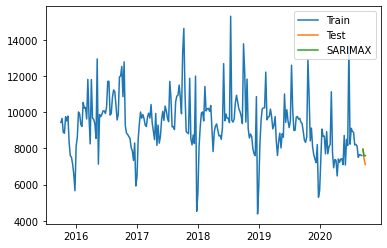

Current product:  9630
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92327D+00    |proj g|=  5.28930D-02


 This problem is unconstrained.



At iterate    5    f=  8.89977D+00    |proj g|=  9.45306D-03

At iterate   10    f=  8.89930D+00    |proj g|=  2.56648D-04

At iterate   15    f=  8.89928D+00    |proj g|=  2.07263D-03

At iterate   20    f=  8.89713D+00    |proj g|=  2.92784D-02

At iterate   25    f=  8.86043D+00    |proj g|=  4.07877D-02

At iterate   30    f=  8.85210D+00    |proj g|=  9.80426D-03

At iterate   35    f=  8.85135D+00    |proj g|=  4.85031D-03

At iterate   40    f=  8.85128D+00    |proj g|=  3.84545D-04

At iterate   45    f=  8.85128D+00    |proj g|=  4.39899D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     52   

 This problem is unconstrained.



At iterate    5    f=  8.95157D+00    |proj g|=  1.44319D-02

At iterate   10    f=  8.95098D+00    |proj g|=  1.74613D-04

At iterate   15    f=  8.95087D+00    |proj g|=  8.57480D-03

At iterate   20    f=  8.93928D+00    |proj g|=  7.55440D-02

At iterate   25    f=  8.91951D+00    |proj g|=  2.01386D-03

At iterate   30    f=  8.91947D+00    |proj g|=  3.59697D-03

At iterate   35    f=  8.91929D+00    |proj g|=  1.23963D-03

At iterate   40    f=  8.91924D+00    |proj g|=  4.32147D-04

At iterate   45    f=  8.91923D+00    |proj g|=  2.44370D-04

At iterate   50    f=  8.91713D+00    |proj g|=  2.17803D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.96666D+00    |proj g|=  1.82823D-04

At iterate   10    f=  8.96661D+00    |proj g|=  5.52506D-03

At iterate   15    f=  8.96254D+00    |proj g|=  4.40026D-02

At iterate   20    f=  8.95404D+00    |proj g|=  1.14146D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     26      1     0     0   8.777D-06   8.954D+00
  F =   8.9540347825077760     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  899.1254060758918
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   1.139D-05   9.042D+00
  F =   9.0421298152837686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  447.4261056654681
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92225D+00    |proj g|=  4.90646D-02


 This problem is unconstrained.



At iterate    5    f=  8.91103D+00    |proj g|=  3.18254D-03

At iterate   10    f=  8.91102D+00    |proj g|=  3.12235D-04

At iterate   15    f=  8.91089D+00    |proj g|=  5.48537D-03

At iterate   20    f=  8.90217D+00    |proj g|=  5.99255D-02

At iterate   25    f=  8.88594D+00    |proj g|=  6.72419D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   6.516D-06   8.886D+00
  F =   8.8859427282684926     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1204.6314219981602
Current parameter:  [(1, 1, 1), (2, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.93876D+00    |proj g|=  3.73162D-02

At iterate    5    f=  8.93440D+00    |proj g|=  3.71897D-03

At iterate   10    f=  8.93434D+00    |proj g|=  1.40657D-04

At iterate   15    f=  8.93429D+00    |proj g|=  3.72990D-03

At iterate   20    f=  8.92690D+00    |proj g|=  2.98176D-02

At iterate   25    f=  8.91024D+00    |proj g|=  1.92869D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  8.90509D+00    |proj g|=  1.13688D-02

At iterate   10    f=  8.90059D+00    |proj g|=  2.48522D-03

At iterate   15    f=  8.90050D+00    |proj g|=  2.71365D-04

At iterate   20    f=  8.90039D+00    |proj g|=  3.41340D-03

At iterate   25    f=  8.88470D+00    |proj g|=  1.31011D-02

At iterate   30    f=  8.87118D+00    |proj g|=  7.22240D-02

At iterate   35    f=  8.84569D+00    |proj g|=  2.39909D-02

At iterate   40    f=  8.84383D+00    |proj g|=  1.38253D-04

At iterate   45    f=  8.84382D+00    |proj g|=  1.78020D-03

At iterate   50    f=  8.84372D+00    |proj g|=  2.61798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02403D+00    |proj g|=  3.33749D-01

At iterate    5    f=  8.91678D+00    |proj g|=  1.16770D-02

At iterate   10    f=  8.91473D+00    |proj g|=  2.40973D-04

At iterate   15    f=  8.91470D+00    |proj g|=  1.60508D-03

At iterate   20    f=  8.91343D+00    |proj g|=  7.69492D-03

At iterate   25    f=  8.85997D+00    |proj g|=  6.25848D-02

At iterate   30    f=  8.85416D+00    |proj g|=  1.09285D-03

At iterate   35    f=  8.85379D+00    |proj g|=  1.13996D-03

At iterate   40    f=  8.85351D+00    |proj g|=  5.05833D-04

At iterate   45    f=  8.85349D+00    |proj g|=  2.69090D-05

At iterate   50    f=  8.85348D+00    |proj g|=  6.42268D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.91688D+00    |proj g|=  7.13985D-03

At iterate   10    f=  8.91424D+00    |proj g|=  9.32036D-04

At iterate   15    f=  8.91422D+00    |proj g|=  2.85558D-04

At iterate   20    f=  8.91413D+00    |proj g|=  1.78007D-03

At iterate   25    f=  8.90623D+00    |proj g|=  1.29732D-02

At iterate   30    f=  8.85116D+00    |proj g|=  1.51315D-02

At iterate   35    f=  8.85034D+00    |proj g|=  2.29094D-04

At iterate   40    f=  8.85031D+00    |proj g|=  1.84878D-03

At iterate   45    f=  8.85016D+00    |proj g|=  5.57808D-04

At iterate   50    f=  8.85013D+00    |proj g|=  2.22567D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.95143D+00    |proj g|=  7.68346D-03

At iterate   10    f=  8.94899D+00    |proj g|=  2.31821D-03

At iterate   15    f=  8.94897D+00    |proj g|=  1.56529D-04

At iterate   20    f=  8.94889D+00    |proj g|=  4.34261D-03

At iterate   25    f=  8.93673D+00    |proj g|=  5.49778D-02

At iterate   30    f=  8.90356D+00    |proj g|=  5.40115D-03

At iterate   35    f=  8.90192D+00    |proj g|=  2.99943D-04

At iterate   40    f=  8.90167D+00    |proj g|=  2.86282D-04

At iterate   45    f=  8.90162D+00    |proj g|=  4.47760D-04

At iterate   50    f=  8.90159D+00    |proj g|=  9.56960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.93263D+00    |proj g|=  3.96100D-02

At iterate    5    f=  8.92587D+00    |proj g|=  1.65409D-02

At iterate   10    f=  8.92474D+00    |proj g|=  1.40744D-03

At iterate   15    f=  8.92470D+00    |proj g|=  1.50514D-04

At iterate   20    f=  8.92469D+00    |proj g|=  1.63254D-03

At iterate   25    f=  8.92367D+00    |proj g|=  1.17845D-02

At iterate   30    f=  8.90605D+00    |proj g|=  4.43392D-02

At iterate   35    f=  8.88745D+00    |proj g|=  3.72770D-03

At iterate   40    f=  8.88740D+00    |proj g|=  1.91079D-03

At iterate   45    f=  8.88706D+00    |proj g|=  2.34500D-03

At iterate   50    f=  8.88696D+00    |proj g|=  9.34606D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.89587D+00    |proj g|=  1.36328D-02

At iterate   10    f=  8.89547D+00    |proj g|=  3.22826D-04

At iterate   15    f=  8.89546D+00    |proj g|=  4.42322D-04

At iterate   20    f=  8.89516D+00    |proj g|=  9.50977D-03

At iterate   25    f=  8.87095D+00    |proj g|=  1.14736D-01

At iterate   30    f=  8.85153D+00    |proj g|=  6.95760D-03

At iterate   35    f=  8.84961D+00    |proj g|=  7.58449D-04

At iterate   40    f=  8.84938D+00    |proj g|=  1.09565D-03

At iterate   45    f=  8.84936D+00    |proj g|=  6.18583D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     51   

 This problem is unconstrained.



At iterate    5    f=  8.90770D+00    |proj g|=  3.46977D-03

At iterate   10    f=  8.90754D+00    |proj g|=  1.45788D-04

At iterate   15    f=  8.90750D+00    |proj g|=  3.41499D-03

At iterate   20    f=  8.90351D+00    |proj g|=  3.75814D-02

At iterate   25    f=  8.88448D+00    |proj g|=  2.12733D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     31      1     0     0   1.656D-05   8.884D+00
  F =   8.8844738498870086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1313.4815798210016
Current parameter:  [(1, 1, 2), (2, 1, 2, 52)]
RUNNING THE L-BFGS-B CODE

           * 

 This problem is unconstrained.



At iterate    5    f=  8.90542D+00    |proj g|=  8.27271D-03

At iterate   10    f=  8.90028D+00    |proj g|=  1.96170D-03

At iterate   15    f=  8.90019D+00    |proj g|=  2.11165D-04

At iterate   20    f=  8.90018D+00    |proj g|=  1.28719D-03

At iterate   25    f=  8.89926D+00    |proj g|=  7.05578D-03

At iterate   30    f=  8.87209D+00    |proj g|=  2.87561D-02

At iterate   35    f=  8.84562D+00    |proj g|=  1.64514D-02

At iterate   40    f=  8.84217D+00    |proj g|=  2.20841D-03

At iterate   45    f=  8.84200D+00    |proj g|=  6.11054D-03

At iterate   50    f=  8.84133D+00    |proj g|=  2.00160D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.90618D+00    |proj g|=  1.24816D-02

At iterate   10    f=  8.90308D+00    |proj g|=  6.66132D-04

At iterate   15    f=  8.90306D+00    |proj g|=  1.30734D-03

At iterate   20    f=  8.90125D+00    |proj g|=  1.92796D-02

At iterate   25    f=  8.88322D+00    |proj g|=  2.65102D-02

At iterate   30    f=  8.88267D+00    |proj g|=  7.26319D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     35      1     0     0   5.931D-06   8.883D+00
  F =   8.8826675817836218     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1270.20019439899
Current parameter:  [(0, 1,

 This problem is unconstrained.



At iterate    5    f=  8.92253D+00    |proj g|=  4.45836D-02

At iterate   10    f=  8.92023D+00    |proj g|=  4.59885D-04

At iterate   15    f=  8.92015D+00    |proj g|=  5.03528D-03

At iterate   20    f=  8.88803D+00    |proj g|=  6.30359D-02

At iterate   25    f=  8.87925D+00    |proj g|=  1.69378D-03

At iterate   30    f=  8.87924D+00    |proj g|=  7.16369D-04

At iterate   35    f=  8.87911D+00    |proj g|=  6.75041D-04

At iterate   40    f=  8.87905D+00    |proj g|=  9.47231D-04

At iterate   45    f=  8.87902D+00    |proj g|=  4.27732D-04

At iterate   50    f=  8.87756D+00    |proj g|=  1.75931D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   1.139D-05   9.042D+00
  F =   9.0421298152837686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  9630
Best Configs:  [(1, 1, 0), (0, 1, 0, 52)]
Mean Absolute Error: 369.685
Mean Squared Error: 2873.822
Root Mean Squared Error: 447.426
Mean absolute percentage error: 12.823
Scaled Mean absolute percentage error: 14.153
Mean forecast error: 2525.274
Normalised mean squared error: 28.248
Theil_u_statistic: 0.0
-*--*--*--*--*--*--*--*--*--*--*--*--*

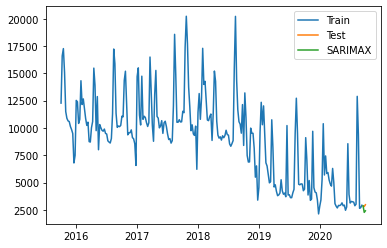

Current product:  9897
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.84834D+00    |proj g|=  3.24568D-01

At iterate    5    f=  8.66038D+00    |proj g|=  2.13795D-02

At iterate   10    f=  8.65604D+00    |proj g|=  1.02143D-03

At iterate   15    f=  8.65602D+00    |proj g|=  1.80044D-04

At iterate   20    f=  8.65593D+00    |proj g|=  8.54578D-03

At iterate   25    f=  8.64573D+00    |proj g|=  7.78602D-02

At iterate   30    f=  8.62711D+00    |proj g|=  1.97702D-03

At iterate   35    f=  8.62579D+00    |proj g|=  1.87105D-03

At iterate   40    f=  8.62535D+00    |proj g|=  1.70954D-03

At iterate   45    f=  8.62522D+00    |proj g|=  7.32752D-04

At iterate   50    f=  8.62519D+00    |proj g|=  2.30284D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.95311D+00    |proj g|=  3.76929D-01

At iterate    5    f=  8.76550D+00    |proj g|=  7.90093D-03

At iterate   10    f=  8.76521D+00    |proj g|=  8.94978D-05

At iterate   15    f=  8.76494D+00    |proj g|=  1.66691D-03

At iterate   20    f=  8.75589D+00    |proj g|=  4.07612D-02

At iterate   25    f=  8.75197D+00    |proj g|=  1.06663D-04

At iterate   30    f=  8.75195D+00    |proj g|=  1.52907D-03

At iterate   35    f=  8.75176D+00    |proj g|=  2.12124D-03

At iterate   40    f=  8.75172D+00    |proj g|=  8.62821D-05

At iterate   45    f=  8.75169D+00    |proj g|=  4.36390D-04

At iterate   50    f=  8.74999D+00    |proj g|=  9.22977D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.79051D+00    |proj g|=  1.24075D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   3.998D-05   8.778D+00
  F =   8.7776691605730104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  589.3230216775081
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0  

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   1.108D-05   8.786D+00
  F =   8.7864818661931441     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  344.87015677275645
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69917D+00    |proj g|=  1.14257D-01

At iterate    5    f=  8.67704D+00    |proj g|=  1.43790D-02

At iterate   10    f=  8.67632D+00    |proj g|=  2.11793D-04

At iterate   15    f=  8.67630D+00    |proj g|=  6.61172D-04

At iterate   20    f=  8.67164D+00    |proj g|=  3.75938D-03

At iterate   25    f=  8.66084D+00    |proj g|=  2.16865D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  8.69528D+00    |proj g|=  9.50917D-03

At iterate   10    f=  8.69472D+00    |proj g|=  1.55070D-04

At iterate   15    f=  8.69469D+00    |proj g|=  3.62618D-03

At iterate   20    f=  8.69122D+00    |proj g|=  2.23054D-02

At iterate   25    f=  8.68285D+00    |proj g|=  1.29937D-03

At iterate   30    f=  8.68265D+00    |proj g|=  2.09070D-02

At iterate   35    f=  8.68060D+00    |proj g|=  3.04132D-02

At iterate   40    f=  8.67710D+00    |proj g|=  2.02075D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     62      1     0     0   1.451D-05   8.677D+00
  F =   8.67709222622

 This problem is unconstrained.



At iterate    5    f=  8.65303D+00    |proj g|=  4.77621D-03

At iterate   10    f=  8.65278D+00    |proj g|=  2.88081D-04

At iterate   15    f=  8.65273D+00    |proj g|=  1.36770D-03

At iterate   20    f=  8.65261D+00    |proj g|=  1.87555D-04

At iterate   25    f=  8.65257D+00    |proj g|=  8.14489D-03

At iterate   30    f=  8.64937D+00    |proj g|=  3.99349D-02

At iterate   35    f=  8.61808D+00    |proj g|=  2.16730D-02

At iterate   40    f=  8.61293D+00    |proj g|=  2.28221D-03

At iterate   45    f=  8.61188D+00    |proj g|=  2.59330D-03

At iterate   50    f=  8.61168D+00    |proj g|=  7.32477D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73818D+00    |proj g|=  1.50301D-01

At iterate    5    f=  8.68062D+00    |proj g|=  5.67543D-03

At iterate   10    f=  8.67845D+00    |proj g|=  1.53332D-03

At iterate   15    f=  8.67837D+00    |proj g|=  2.11486D-04

At iterate   20    f=  8.67834D+00    |proj g|=  1.69922D-03

At iterate   25    f=  8.67587D+00    |proj g|=  2.22305D-02

At iterate   30    f=  8.64100D+00    |proj g|=  3.59249D-02

At iterate   35    f=  8.62581D+00    |proj g|=  1.28325D-02

At iterate   40    f=  8.62269D+00    |proj g|=  6.02721D-03

At iterate   45    f=  8.62208D+00    |proj g|=  1.18898D-04

At iterate   50    f=  8.62196D+00    |proj g|=  4.17376D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.68060D+00    |proj g|=  6.28057D-03

At iterate   10    f=  8.67850D+00    |proj g|=  7.15271D-03

At iterate   15    f=  8.67833D+00    |proj g|=  7.53514D-04

At iterate   20    f=  8.67832D+00    |proj g|=  7.28876D-04

At iterate   25    f=  8.67816D+00    |proj g|=  4.22993D-03

At iterate   30    f=  8.65713D+00    |proj g|=  1.08001D-01

At iterate   35    f=  8.62871D+00    |proj g|=  1.23563D-02

At iterate   40    f=  8.62237D+00    |proj g|=  2.51223D-03

At iterate   45    f=  8.62133D+00    |proj g|=  1.26999D-03

At iterate   50    f=  8.62117D+00    |proj g|=  2.74291D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.80289D+00    |proj g|=  1.24778D-01

At iterate    5    f=  8.75347D+00    |proj g|=  3.77237D-03

At iterate   10    f=  8.75273D+00    |proj g|=  1.97619D-03

At iterate   15    f=  8.75271D+00    |proj g|=  7.28000D-04

At iterate   20    f=  8.75243D+00    |proj g|=  9.71848D-03

At iterate   25    f=  8.73955D+00    |proj g|=  7.52407D-02

At iterate   30    f=  8.72572D+00    |proj g|=  2.00807D-03

At iterate   35    f=  8.72425D+00    |proj g|=  9.12516D-04

At iterate   40    f=  8.72406D+00    |proj g|=  1.08548D-03

At iterate   45    f=  8.72402D+00    |proj g|=  4.20141D-04

At iterate   50    f=  8.72402D+00    |proj g|=  1.78656D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.69605D+00    |proj g|=  6.38511D-02

At iterate   10    f=  8.68668D+00    |proj g|=  1.76375D-03

At iterate   15    f=  8.68654D+00    |proj g|=  1.68199D-04

At iterate   20    f=  8.68651D+00    |proj g|=  2.47995D-03

At iterate   25    f=  8.68272D+00    |proj g|=  4.72748D-02

At iterate   30    f=  8.66429D+00    |proj g|=  6.71362D-03

At iterate   35    f=  8.66346D+00    |proj g|=  2.65625D-03

At iterate   40    f=  8.66280D+00    |proj g|=  2.27837D-02

At iterate   45    f=  8.66080D+00    |proj g|=  1.12322D-02

At iterate   50    f=  8.65973D+00    |proj g|=  1.22605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.66553D+00    |proj g|=  7.30772D-02

At iterate   10    f=  8.65615D+00    |proj g|=  1.80706D-02

At iterate   15    f=  8.65446D+00    |proj g|=  2.60583D-03

At iterate   20    f=  8.65439D+00    |proj g|=  1.75603D-04

At iterate   25    f=  8.65426D+00    |proj g|=  6.84553D-03

At iterate   30    f=  8.64322D+00    |proj g|=  8.35767D-02

At iterate   35    f=  8.63008D+00    |proj g|=  5.19560D-03

At iterate   40    f=  8.62647D+00    |proj g|=  4.96366D-03

At iterate   45    f=  8.62529D+00    |proj g|=  9.85426D-03

At iterate   50    f=  8.62510D+00    |proj g|=  2.45695D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38407D+00    |proj g|=  1.08490D+00

At iterate    5    f=  8.67468D+00    |proj g|=  5.64304D-02

At iterate   10    f=  8.66869D+00    |proj g|=  9.55461D-03

At iterate   15    f=  8.66801D+00    |proj g|=  6.00904D-04

At iterate   20    f=  8.66801D+00    |proj g|=  1.13931D-03

At iterate   25    f=  8.66760D+00    |proj g|=  1.42688D-02

At iterate   30    f=  8.65850D+00    |proj g|=  5.49783D-02

At iterate   35    f=  8.65428D+00    |proj g|=  5.20697D-04

At iterate   40    f=  8.65383D+00    |proj g|=  1.08948D-02

At iterate   45    f=  8.65326D+00    |proj g|=  2.16148D-03

At iterate   50    f=  8.65320D+00    |proj g|=  7.80243D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.65317D+00    |proj g|=  8.42016D-03

At iterate   10    f=  8.65276D+00    |proj g|=  7.84619D-04

At iterate   15    f=  8.65274D+00    |proj g|=  1.85886D-03

At iterate   20    f=  8.65258D+00    |proj g|=  1.30828D-03

At iterate   25    f=  8.65257D+00    |proj g|=  8.07007D-04

At iterate   30    f=  8.65255D+00    |proj g|=  2.51970D-03

At iterate   35    f=  8.65227D+00    |proj g|=  3.98966D-03

At iterate   40    f=  8.64302D+00    |proj g|=  4.38260D-02

At iterate   45    f=  8.61585D+00    |proj g|=  6.41251D-03

At iterate   50    f=  8.61352D+00    |proj g|=  3.07375D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.66775D+00    |proj g|=  2.87794D-03

At iterate   10    f=  8.66710D+00    |proj g|=  2.16803D-03

At iterate   15    f=  8.66642D+00    |proj g|=  2.60831D-03

At iterate   20    f=  8.66641D+00    |proj g|=  9.93154D-05

At iterate   25    f=  8.66640D+00    |proj g|=  1.97186D-03

At iterate   30    f=  8.66600D+00    |proj g|=  2.21865D-02

At iterate   35    f=  8.66160D+00    |proj g|=  2.79870D-02

At iterate   40    f=  8.66081D+00    |proj g|=  2.65139D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     44      1     0     0   2.651D-06   8.661D+00
  F =   8.66080738267

 This problem is unconstrained.



At iterate    5    f=  8.66753D+00    |proj g|=  3.81123D-03

At iterate   10    f=  8.66702D+00    |proj g|=  1.79871D-04

At iterate   15    f=  8.66696D+00    |proj g|=  1.32683D-03

At iterate   20    f=  8.66189D+00    |proj g|=  3.22871D-02

At iterate   25    f=  8.63400D+00    |proj g|=  3.12958D-03

At iterate   30    f=  8.63386D+00    |proj g|=  5.50341D-04

At iterate   35    f=  8.63375D+00    |proj g|=  3.52195D-03

At iterate   40    f=  8.63328D+00    |proj g|=  2.11759D-04

At iterate   45    f=  8.63317D+00    |proj g|=  2.02835D-05

At iterate   50    f=  8.63315D+00    |proj g|=  8.82446D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   1.108D-05   8.786D+00
  F =   8.7864818661931441     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  9897
Best Configs:  [(1, 1, 0), (0, 1, 0, 52)]
Mean Absolute Error: 298.532
Mean Squared Error: 7419.758
Root Mean Squared Error: 344.87
Mean absolute percentage error: 3.993
Scaled Mean absolute percentage error: 4.102
Mean forecast error: 7120.763
Normalised mean squared error: 1.488
Theil_u_statistic: 0.0
-*--*--*--*--*--*--*--*--*--*--*--*--*--*-

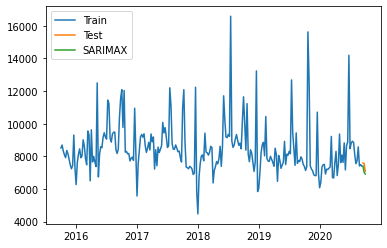

Current product:  9860
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22970D+00    |proj g|=  1.23276D-01

At iterate    5    f=  9.20173D+00    |proj g|=  2.84871D-03

At iterate   10    f=  9.20153D+00    |proj g|=  1.18674D-04

At iterate   15    f=  9.20153D+00    |proj g|=  1.08457D-03

At iterate   20    f=  9.20091D+00    |proj g|=  1.38150D-02

At iterate   25    f=  9.17602D+00    |proj g|=  5.78966D-02

At iterate   30    f=  9.16627D+00    |proj g|=  2.03757D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  9.27660D+00    |proj g|=  8.86581D-03

At iterate   10    f=  9.27640D+00    |proj g|=  8.80132D-05

At iterate   15    f=  9.27637D+00    |proj g|=  1.87935D-03

At iterate   20    f=  9.27449D+00    |proj g|=  7.63140D-03

At iterate   25    f=  9.25685D+00    |proj g|=  2.01924D-03

At iterate   30    f=  9.25592D+00    |proj g|=  6.81423D-03

At iterate   35    f=  9.25498D+00    |proj g|=  1.38362D-03

At iterate   40    f=  9.25486D+00    |proj g|=  7.01276D-04

At iterate   45    f=  9.25483D+00    |proj g|=  7.03002D-04

At iterate   50    f=  9.25415D+00    |proj g|=  6.80950D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.28723D+00    |proj g|=  7.94884D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   7.949D-05   9.287D+00
  F =   9.2872341849059072     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  616.1164237778227
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34843D+00    |proj g|=  6.01376D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   3.314D-05   9.348D+00
  F =   9.3484076779038947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1362.9094180511238
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22142D+00    |proj g|=  7.93690D-02


 This problem is unconstrained.



At iterate    5    f=  9.21231D+00    |proj g|=  3.61438D-03

At iterate   10    f=  9.21227D+00    |proj g|=  2.17800D-04

At iterate   15    f=  9.21223D+00    |proj g|=  3.98935D-03

At iterate   20    f=  9.20818D+00    |proj g|=  3.35488D-02

At iterate   25    f=  9.19638D+00    |proj g|=  2.19442D-02

At iterate   30    f=  9.18491D+00    |proj g|=  1.06049D-02

At iterate   35    f=  9.18436D+00    |proj g|=  1.01320D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     41      1     0     0   1.013D-05   9.184D+00
  F =   9.1843614410315180     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  9.21572D+00    |proj g|=  1.23795D-03

At iterate   10    f=  9.21569D+00    |proj g|=  1.15581D-04

At iterate   15    f=  9.21565D+00    |proj g|=  3.26036D-03

At iterate   20    f=  9.21243D+00    |proj g|=  3.89226D-02

At iterate   25    f=  9.18266D+00    |proj g|=  6.85858D-03

At iterate   30    f=  9.18180D+00    |proj g|=  3.86609D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     34      1     0     0   9.047D-06   9.182D+00
  F =   9.1818045179522709     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  308.15448188547725
Current parameter:  [(1, 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27261D+00    |proj g|=  2.68473D-01

At iterate    5    f=  9.19792D+00    |proj g|=  9.84389D-03

At iterate   10    f=  9.19627D+00    |proj g|=  4.49705D-03

At iterate   15    f=  9.19616D+00    |proj g|=  5.40837D-04

At iterate   20    f=  9.19615D+00    |proj g|=  1.11268D-04

At iterate   25    f=  9.19612D+00    |proj g|=  2.03621D-03

At iterate   30    f=  9.19237D+00    |proj g|=  1.20489D-02

At iterate   35    f=  9.17420D+00    |proj g|=  2.50950D-02

At iterate   40    f=  9.16430D+00    |proj g|=  2.04822D-03

At iterate   45    f=  9.16413D+00    |proj g|=  5.82699D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29467D+00    |proj g|=  2.61856D-01

At iterate    5    f=  9.21732D+00    |proj g|=  9.83940D-03

At iterate   10    f=  9.21536D+00    |proj g|=  4.27181D-03

At iterate   15    f=  9.21533D+00    |proj g|=  2.60478D-04

At iterate   20    f=  9.21532D+00    |proj g|=  7.97568D-04

At iterate   25    f=  9.21477D+00    |proj g|=  1.06119D-02

At iterate   30    f=  9.19638D+00    |proj g|=  3.98823D-02

At iterate   35    f=  9.18141D+00    |proj g|=  4.79122D-02

At iterate   40    f=  9.17806D+00    |proj g|=  6.72071D-03

At iterate   45    f=  9.17586D+00    |proj g|=  2.39338D-03

At iterate   50    f=  9.17574D+00    |proj g|=  1.18602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29467D+00    |proj g|=  2.61856D-01

At iterate    5    f=  9.21754D+00    |proj g|=  9.37360D-03

At iterate   10    f=  9.21387D+00    |proj g|=  1.66532D-03

At iterate   15    f=  9.21375D+00    |proj g|=  2.74596D-04

At iterate   20    f=  9.21375D+00    |proj g|=  4.42280D-04

At iterate   25    f=  9.21374D+00    |proj g|=  1.15852D-03

At iterate   30    f=  9.21308D+00    |proj g|=  1.04258D-02

At iterate   35    f=  9.19292D+00    |proj g|=  3.66128D-02

At iterate   40    f=  9.17609D+00    |proj g|=  6.04209D-03

At iterate   45    f=  9.17490D+00    |proj g|=  1.03911D-03

At iterate   50    f=  9.17488D+00    |proj g|=  1.23991D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.27854D+00    |proj g|=  6.43071D-03

At iterate   10    f=  9.27753D+00    |proj g|=  9.62554D-04

At iterate   15    f=  9.27753D+00    |proj g|=  4.96423D-04

At iterate   20    f=  9.27704D+00    |proj g|=  6.11993D-03

At iterate   25    f=  9.25614D+00    |proj g|=  1.57771D-02

At iterate   30    f=  9.25373D+00    |proj g|=  2.72182D-02

At iterate   35    f=  9.25071D+00    |proj g|=  1.55517D-03

At iterate   40    f=  9.25047D+00    |proj g|=  2.75020D-03

At iterate   45    f=  9.25029D+00    |proj g|=  3.69269D-04

At iterate   50    f=  9.25025D+00    |proj g|=  3.07122D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.21229D+00    |proj g|=  1.63042D-02

At iterate   10    f=  9.21176D+00    |proj g|=  1.13680D-04

At iterate   15    f=  9.21176D+00    |proj g|=  6.15916D-04

At iterate   20    f=  9.21155D+00    |proj g|=  2.65052D-03

At iterate   25    f=  9.19264D+00    |proj g|=  3.32850D-02

At iterate   30    f=  9.17816D+00    |proj g|=  5.16551D-03

At iterate   35    f=  9.17806D+00    |proj g|=  6.51974D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     41      1     0     0   6.479D-06   9.178D+00
  F =   9.1780626985485263     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.20074D+00    |proj g|=  2.61314D-02

At iterate   10    f=  9.19943D+00    |proj g|=  1.11999D-03

At iterate   15    f=  9.19942D+00    |proj g|=  6.64447D-04

At iterate   20    f=  9.19922D+00    |proj g|=  9.16433D-03

At iterate   25    f=  9.18082D+00    |proj g|=  8.10604D-02

At iterate   30    f=  9.16445D+00    |proj g|=  4.81018D-03

At iterate   35    f=  9.16440D+00    |proj g|=  2.09652D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     40      1     0     0   3.091D-06   9.164D+00
  F =   9.1643999440832875     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22346D+00    |proj g|=  5.86110D-02

At iterate    5    f=  9.21178D+00    |proj g|=  2.41743D-02

At iterate   10    f=  9.21104D+00    |proj g|=  1.06937D-04

At iterate   15    f=  9.21103D+00    |proj g|=  1.21822D-03

At iterate   20    f=  9.20960D+00    |proj g|=  1.08154D-02

At iterate   25    f=  9.19599D+00    |proj g|=  2.08909D-02

At iterate   30    f=  9.18387D+00    |proj g|=  4.75677D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    0    f=  9.27261D+00    |proj g|=  2.68473D-01

At iterate    5    f=  9.19831D+00    |proj g|=  8.18430D-03

At iterate   10    f=  9.19443D+00    |proj g|=  4.29724D-03

At iterate   15    f=  9.19422D+00    |proj g|=  1.02358D-03

At iterate   20    f=  9.19421D+00    |proj g|=  4.05822D-04

At iterate   25    f=  9.19421D+00    |proj g|=  4.11444D-04

At iterate   30    f=  9.19415D+00    |proj g|=  4.40990D-03

At iterate   35    f=  9.19277D+00    |proj g|=  9.52270D-03

At iterate   40    f=  9.17790D+00    |proj g|=  7.03195D-02

At iterate   45    f=  9.16331D+00    |proj g|=  2.61147D-03

At iterate   50    f=  9.16321D+00    |proj g|=  2.40012D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20467D+00    |proj g|=  5.07270D-02

At iterate    5    f=  9.20054D+00    |proj g|=  5.19441D-04

At iterate   10    f=  9.20054D+00    |proj g|=  7.47746D-04

At iterate   15    f=  9.20054D+00    |proj g|=  9.13420D-04

At iterate   20    f=  9.20040D+00    |proj g|=  9.85423D-03

At iterate   25    f=  9.18975D+00    |proj g|=  4.73280D-02

At iterate   30    f=  9.18269D+00    |proj g|=  7.32157D-03

At iterate   35    f=  9.17968D+00    |proj g|=  2.84129D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24979D+00    |proj g|=  1.25494D-01

At iterate    5    f=  9.21595D+00    |proj g|=  4.20016D-03

At iterate   10    f=  9.21588D+00    |proj g|=  1.12136D-04

At iterate   15    f=  9.21584D+00    |proj g|=  2.27230D-03

At iterate   20    f=  9.20742D+00    |proj g|=  3.17375D-02

At iterate   25    f=  9.18431D+00    |proj g|=  1.76742D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     31      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22346D+00    |proj g|=  5.86110D-02

At iterate    5    f=  9.21178D+00    |proj g|=  2.41743D-02

At iterate   10    f=  9.21104D+00    |proj g|=  1.06937D-04

At iterate   15    f=  9.21103D+00    |proj g|=  1.21822D-03

At iterate   20    f=  9.20960D+00    |proj g|=  1.08154D-02

At iterate   25    f=  9.19599D+00    |proj g|=  2.08909D-02

At iterate   30    f=  9.18387D+00    |proj g|=  4.75677D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

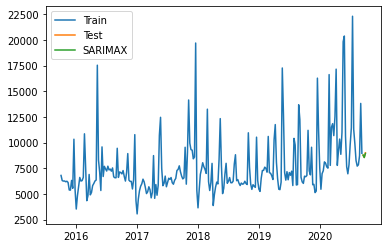

Total RMSE of top 10 selling products:  3586.225147565247 , total mape:  31.084127091228304
selected horizon:  12
Current product:  10133
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89196D+00    |proj g|=  2.07829D-01


 This problem is unconstrained.



At iterate    5    f=  9.83853D+00    |proj g|=  4.16695D-03

At iterate   10    f=  9.83846D+00    |proj g|=  3.24575D-03

At iterate   15    f=  9.83844D+00    |proj g|=  3.42771D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     19      1     0     0   3.428D-05   9.838D+00
  F =   9.8384400404665069     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2537.77601762956
Current parameter:  [(1, 1, 0), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  9.96771D+00    |proj g|=  2.18488D-02

At iterate   10    f=  9.96642D+00    |proj g|=  5.80193D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   1.310D-05   9.966D+00
  F =   9.9664161208713153     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  3967.622459183302
Current parameter:  [(1, 1, 0), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.96779D+00    |proj g|=  3.25763D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   1.295D-05   9.967D+00
  F =   9.9666136133143564     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  3979.685355127545
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0  

 This problem is unconstrained.



Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   1.195D-05   9.967D+00
  F =   9.9666276305757524     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  4113.809939429433
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84261D+00    |proj g|=  5.14323D-02

At iterate    5    f=  9.83978D+00    |proj g|=  6.82559D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   3.210D-05   9.840D+00
  F =   9.8397818195686444     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2474.5414371192824
Current parameter:  [(1, 1, 1), (2, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  9.83506D+00    |proj g|=  6.80653D-03

At iterate   10    f=  9.83437D+00    |proj g|=  4.45349D-05

At iterate   15    f=  9.83437D+00    |proj g|=  1.35867D-03

At iterate   20    f=  9.83337D+00    |proj g|=  2.17371D-02

At iterate   25    f=  9.81968D+00    |proj g|=  1.61813D-02

At iterate   30    f=  9.81910D+00    |proj g|=  7.57079D-03

At iterate   35    f=  9.81811D+00    |proj g|=  1.05623D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     45      1     0     0   1.660D-05   9.818D+00
  F =   9.8181079559372488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83855D+00    |proj g|=  4.35513D-02

At iterate    5    f=  9.82908D+00    |proj g|=  8.28099D-03

At iterate   10    f=  9.82033D+00    |proj g|=  1.65976D-02

At iterate   15    f=  9.81842D+00    |proj g|=  2.46495D-03

At iterate   20    f=  9.81807D+00    |proj g|=  1.57488D-03

At iterate   25    f=  9.81753D+00    |proj g|=  8.34683D-04

At iterate   30    f=  9.81745D+00    |proj g|=  3.81408D-03

At iterate   35    f=  9.81741D+00    |proj g|=  6.55116D-04

At iterate   40    f=  9.81737D+00    |proj g|=  7.97986D-04

At iterate   45    f=  9.81660D+00    |proj g|=  7.04838D-03

At iterate   50    f=  9.81454D+00    |proj g|=  3.21009D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84445D+00    |proj g|=  6.88350D-02

At iterate    5    f=  9.83514D+00    |proj g|=  3.07687D-02

At iterate   10    f=  9.83335D+00    |proj g|=  1.83503D-02

At iterate   15    f=  9.83112D+00    |proj g|=  5.50250D-03

At iterate   20    f=  9.83083D+00    |proj g|=  1.21454D-03

At iterate   25    f=  9.83081D+00    |proj g|=  5.05174D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     30      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  9.83216D+00    |proj g|=  7.23422D-02

At iterate   10    f=  9.82718D+00    |proj g|=  6.57513D-03

At iterate   15    f=  9.82656D+00    |proj g|=  3.06731D-03

At iterate   20    f=  9.82562D+00    |proj g|=  6.06943D-03

At iterate   25    f=  9.82551D+00    |proj g|=  3.26120D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   4.653D-05   9.826D+00
  F =   9.8255137511509485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2327.9414112653812
Current parameter:  [(1, 1, 0), (1, 1, 2, 52)]
RUNNING THE L-BFGS-B CODE

           * 

 This problem is unconstrained.



At iterate    5    f=  9.96687D+00    |proj g|=  2.07366D-02

At iterate   10    f=  9.95239D+00    |proj g|=  1.56285D-02

At iterate   15    f=  9.94815D+00    |proj g|=  1.07413D-02

At iterate   20    f=  9.94702D+00    |proj g|=  1.63241D-03

At iterate   25    f=  9.94682D+00    |proj g|=  8.10151D-04

At iterate   30    f=  9.94679D+00    |proj g|=  3.18380D-04

At iterate   35    f=  9.94646D+00    |proj g|=  4.15346D-03

At iterate   40    f=  9.94090D+00    |proj g|=  1.50778D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     51      1     0     0   2.587D-06   9.941D+00
  F =   9.94089657089

 This problem is unconstrained.



At iterate    5    f=  9.82666D+00    |proj g|=  2.45309D-02

At iterate   10    f=  9.82267D+00    |proj g|=  1.20301D-02

At iterate   15    f=  9.82025D+00    |proj g|=  2.62497D-03

At iterate   20    f=  9.82016D+00    |proj g|=  3.94523D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     23     26      1     0     0   4.968D-05   9.820D+00
  F =   9.8201643836863788     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2471.450138164483
Current parameter:  [(2, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =   

 This problem is unconstrained.



At iterate    5    f=  9.83287D+00    |proj g|=  6.74579D-03

At iterate   10    f=  9.83282D+00    |proj g|=  1.16417D-03

At iterate   15    f=  9.83275D+00    |proj g|=  5.25519D-03

At iterate   20    f=  9.83236D+00    |proj g|=  7.24670D-03

At iterate   25    f=  9.83162D+00    |proj g|=  1.38165D-03

At iterate   30    f=  9.83134D+00    |proj g|=  2.42733D-03

At iterate   35    f=  9.83119D+00    |proj g|=  7.19815D-04

At iterate   40    f=  9.82503D+00    |proj g|=  5.68670D-02

At iterate   45    f=  9.81714D+00    |proj g|=  3.48852D-03

At iterate   50    f=  9.81713D+00    |proj g|=  5.05374D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.83362D+00    |proj g|=  4.76671D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     12      1     0     0   3.393D-05   9.834D+00
  F =   9.8335864908014958     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2648.1361492097444
Current parameter:  [(1, 1, 2), (2, 1, 2, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83855D+00    |proj g|=  6.39514D-02


 This problem is unconstrained.



At iterate    5    f=  9.82133D+00    |proj g|=  2.72368D-02

At iterate   10    f=  9.81448D+00    |proj g|=  5.14583D-03

At iterate   15    f=  9.81257D+00    |proj g|=  1.20198D-02

At iterate   20    f=  9.81211D+00    |proj g|=  2.18287D-03

At iterate   25    f=  9.81198D+00    |proj g|=  1.21003D-03

At iterate   30    f=  9.81196D+00    |proj g|=  1.15394D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     32     38      1     0     0   3.202D-05   9.812D+00
  F =   9.8119562135278748     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2301.761321576007
Current parameter:  [(1, 1

 This problem is unconstrained.



At iterate    5    f=  9.83377D+00    |proj g|=  2.72429D-04

At iterate   10    f=  9.83376D+00    |proj g|=  1.99847D-03

At iterate   15    f=  9.83364D+00    |proj g|=  1.36649D-02

At iterate   20    f=  9.83280D+00    |proj g|=  3.77154D-02

At iterate   25    f=  9.82933D+00    |proj g|=  6.91842D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     39      1     0     0   1.717D-05   9.829D+00
  F =   9.8293168795444892     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2701.5079825790017
Current parameter:  [(0, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * 

 This problem is unconstrained.



At iterate    5    f=  9.83927D+00    |proj g|=  1.03064D-03

At iterate   10    f=  9.83926D+00    |proj g|=  8.26796D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   8.452D-05   9.839D+00
  F =   9.8392633957470998     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2535.5450129260653


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83855D+00    |proj g|=  6.39514D-02

At iterate    5    f=  9.82133D+00    |proj g|=  2.72368D-02

At iterate   10    f=  9.81448D+00    |proj g|=  5.14583D-03

At iterate   15    f=  9.81257D+00    |proj g|=  1.20198D-02

At iterate   20    f=  9.81211D+00    |proj g|=  2.18287D-03

At iterate   25    f=  9.81198D+00    |proj g|=  1.21003D-03

At iterate   30    f=  9.81196D+00    |proj g|=  1.15394D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

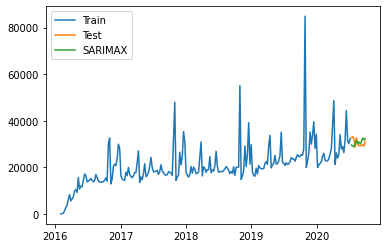

Current product:  9662
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.63145D+00    |proj g|=  9.23232D-02


 This problem is unconstrained.



At iterate    5    f=  9.60633D+00    |proj g|=  5.79264D-03

At iterate   10    f=  9.60606D+00    |proj g|=  2.61291D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     15      1     0     0   8.069D-05   9.606D+00
  F =   9.6060513873425819     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2037.3051410263868
Current parameter:  [(1, 1, 0), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78542D+00    |proj g|=  4.74084D-02

At iterate    5    f=  9.75590D+00    |proj g|=  3.92327D-03

At iterate   10    f=  9.75575D+00    |proj g|=  5.62043D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   5.620D-05   9.756D+00
  F =   9.7557477323672526     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  3936.8334751749535
Current parameter:  [(1, 1, 0), (1, 1, 0, 52

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78405D+00    |proj g|=  4.16153D-02

At iterate    5    f=  9.78201D+00    |proj g|=  4.05290D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   4.053D-05   9.782D+00
  F =   9.7820143458847344     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  4306.6261120471
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   1.775D-05   9.825D+00
  F =   9.8252788700469829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  4257.326870211815
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.63142D+00    |proj g|=  9.42161D-02


 This problem is unconstrained.



At iterate    5    f=  9.62258D+00    |proj g|=  1.63021D-02

At iterate   10    f=  9.62234D+00    |proj g|=  1.99256D-04

At iterate   15    f=  9.62206D+00    |proj g|=  1.21724D-02

At iterate   20    f=  9.61048D+00    |proj g|=  6.09336D-02

At iterate   25    f=  9.60473D+00    |proj g|=  2.78725D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   2.787D-05   9.605D+00
  F =   9.6047344137174875     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2436.4664664361285
Current parameter:  [(1, 1, 1), (2, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * 

 This problem is unconstrained.



At iterate    5    f=  9.61066D+00    |proj g|=  6.93682D-03

At iterate   10    f=  9.60878D+00    |proj g|=  1.74355D-04

At iterate   15    f=  9.60878D+00    |proj g|=  1.51562D-03

At iterate   20    f=  9.60823D+00    |proj g|=  2.09151D-02

At iterate   25    f=  9.59165D+00    |proj g|=  9.58713D-02

At iterate   30    f=  9.58213D+00    |proj g|=  2.19127D-03

At iterate   35    f=  9.58201D+00    |proj g|=  4.90381D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     39      1     0     0   4.904D-06   9.582D+00
  F =   9.5820116559394588     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.59279D+00    |proj g|=  1.70373D-02

At iterate   10    f=  9.58269D+00    |proj g|=  5.17799D-03

At iterate   15    f=  9.58233D+00    |proj g|=  3.21584D-03

At iterate   20    f=  9.58212D+00    |proj g|=  2.68094D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     22     25      1     0     0   7.528D-05   9.582D+00
  F =   9.5821186686764683     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1829.7439993271491
Current parameter:  [(1, 1, 1), (1, 1, 2, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.69075D+00    |proj g|=  2.44832D-01

At iterate    5    f=  9.60566D+00    |proj g|=  7.88370D-03

At iterate   10    f=  9.60243D+00    |proj g|=  5.81512D-04

At iterate   15    f=  9.60241D+00    |proj g|=  9.36996D-05

At iterate   20    f=  9.60240D+00    |proj g|=  1.99800D-03

At iterate   25    f=  9.60168D+00    |proj g|=  2.88489D-02

At iterate   30    f=  9.58255D+00    |proj g|=  5.10512D-02

At iterate   35    f=  9.56450D+00    |proj g|=  2.35576D-03

At iterate   40    f=  9.56447D+00    |proj g|=  4.18909D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.69075D+00    |proj g|=  2.44832D-01

At iterate    5    f=  9.60503D+00    |proj g|=  1.00402D-02

At iterate   10    f=  9.60113D+00    |proj g|=  1.17208D-03

At iterate   15    f=  9.60110D+00    |proj g|=  9.58988D-05

At iterate   20    f=  9.60109D+00    |proj g|=  1.00084D-03

At iterate   25    f=  9.59894D+00    |proj g|=  1.31087D-02

At iterate   30    f=  9.56636D+00    |proj g|=  3.18464D-02

At iterate   35    f=  9.56371D+00    |proj g|=  6.71874D-03

At iterate   40    f=  9.56354D+00    |proj g|=  2.22974D-03

At iterate   45    f=  9.56353D+00    |proj g|=  2.08548D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  9.74372D+00    |proj g|=  1.76242D-02

At iterate   10    f=  9.73882D+00    |proj g|=  2.27277D-03

At iterate   15    f=  9.73864D+00    |proj g|=  1.70546D-04

At iterate   20    f=  9.73864D+00    |proj g|=  6.92969D-05

At iterate   25    f=  9.73859D+00    |proj g|=  2.56179D-03

At iterate   30    f=  9.71865D+00    |proj g|=  7.76634D-02

At iterate   35    f=  9.71030D+00    |proj g|=  9.37260D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     41      1     0     0   2.626D-06   9.710D+00
  F =   9.7103017599493189     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.62356D+00    |proj g|=  3.47887D-02

At iterate   10    f=  9.60247D+00    |proj g|=  9.22058D-03

At iterate   15    f=  9.59782D+00    |proj g|=  1.07827D-02

At iterate   20    f=  9.59761D+00    |proj g|=  2.14301D-03

At iterate   25    f=  9.59760D+00    |proj g|=  9.51859D-05

At iterate   30    f=  9.59759D+00    |proj g|=  2.02198D-03

At iterate   35    f=  9.59613D+00    |proj g|=  2.26130D-02

At iterate   40    f=  9.57654D+00    |proj g|=  2.58473D-02

At iterate   45    f=  9.57168D+00    |proj g|=  2.65505D-02

At iterate   50    f=  9.56557D+00    |proj g|=  3.65422D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.60271D+00    |proj g|=  2.16865D-02

At iterate   10    f=  9.59616D+00    |proj g|=  3.75408D-04

At iterate   15    f=  9.59616D+00    |proj g|=  8.47487D-05

At iterate   20    f=  9.59615D+00    |proj g|=  2.43339D-03

At iterate   25    f=  9.59517D+00    |proj g|=  2.84775D-02

At iterate   30    f=  9.56873D+00    |proj g|=  2.85793D-02

At iterate   35    f=  9.56478D+00    |proj g|=  3.13910D-03

At iterate   40    f=  9.56470D+00    |proj g|=  3.19062D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     42      1     0     0   3.191D-05   9.565D+00
  F =   9.56469695630

 This problem is unconstrained.



At iterate    5    f=  9.61321D+00    |proj g|=  1.55305D-02

At iterate   10    f=  9.61068D+00    |proj g|=  1.16181D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     14      1     0     0   7.221D-05   9.611D+00
  F =   9.6106765251860580     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2609.1345019306227
Current parameter:  [(1, 1, 2), (2, 1, 2, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.67256D+00    |proj g|=  2.48548D-01

At iterate    5    f=  9.59273D+00    |proj g|=  1.29172D-02

At iterate   10    f=  9.58282D+00    |proj g|=  9.27358D-03

At iterate   15    f=  9.58069D+00    |proj g|=  2.16880D-03

At iterate   20    f=  9.58031D+00    |proj g|=  8.92542D-04

At iterate   25    f=  9.58030D+00    |proj g|=  1.45238D-04

At iterate   30    f=  9.58030D+00    |proj g|=  1.17999D-03

At iterate   35    f=  9.58009D+00    |proj g|=  1.21171D-02

At iterate   40    f=  9.57820D+00    |proj g|=  8.50368D-03

At iterate   45    f=  9.56804D+00    |proj g|=  2.21913D-02

At iterate   50    f=  9.55878D+00    |proj g|=  8.59553D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.61542D+00    |proj g|=  6.12526D-03

At iterate   10    f=  9.61250D+00    |proj g|=  2.90345D-02

At iterate   15    f=  9.61186D+00    |proj g|=  7.27709D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     25      1     0     0   4.676D-05   9.612D+00
  F =   9.6118588448469353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2447.557012667814
Current parameter:  [(0, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bound

 This problem is unconstrained.



At iterate    5    f=  9.60964D+00    |proj g|=  1.09648D-03

At iterate   10    f=  9.60962D+00    |proj g|=  2.05288D-04

At iterate   15    f=  9.60955D+00    |proj g|=  3.69486D-03

At iterate   20    f=  9.60036D+00    |proj g|=  5.12536D-02

At iterate   25    f=  9.57970D+00    |proj g|=  2.49680D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     32      1     0     0   4.674D-06   9.580D+00
  F =   9.5796541588870134     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  2024.1689780777606
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  9.59273D+00    |proj g|=  1.29172D-02

At iterate   10    f=  9.58282D+00    |proj g|=  9.27358D-03

At iterate   15    f=  9.58069D+00    |proj g|=  2.16880D-03

At iterate   20    f=  9.58031D+00    |proj g|=  8.92542D-04

At iterate   25    f=  9.58030D+00    |proj g|=  1.45238D-04

At iterate   30    f=  9.58030D+00    |proj g|=  1.17999D-03

At iterate   35    f=  9.58009D+00    |proj g|=  1.21171D-02

At iterate   40    f=  9.57820D+00    |proj g|=  8.50368D-03

At iterate   45    f=  9.56804D+00    |proj g|=  2.21913D-02

At iterate   50    f=  9.55878D+00    |proj g|=  8.59553D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

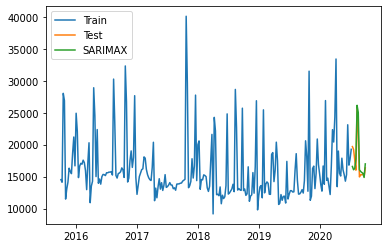

Current product:  9399
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.36963D+00    |proj g|=  1.19493D-01


 This problem is unconstrained.



At iterate    5    f=  9.34732D+00    |proj g|=  1.09484D-02

At iterate   10    f=  9.34533D+00    |proj g|=  1.43685D-03

At iterate   15    f=  9.34528D+00    |proj g|=  1.32789D-04

At iterate   20    f=  9.34525D+00    |proj g|=  2.39719D-03

At iterate   25    f=  9.33174D+00    |proj g|=  1.00256D-01

At iterate   30    f=  9.30161D+00    |proj g|=  3.69202D-02

At iterate   35    f=  9.29970D+00    |proj g|=  3.09740D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     42      1     0     0   3.097D-05   9.300D+00
  F =   9.2997025342647071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47213D+00    |proj g|=  6.29813D-02

At iterate    5    f=  9.46778D+00    |proj g|=  9.39189D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   6.781D-05   9.468D+00
  F =   9.4676567364394106     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1810.3015568086696
Current parameter:  [(1, 1, 0), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47185D+00    |proj g|=  5.02787D-02

At iterate    5    f=  9.46923D+00    |proj g|=  1.32775D-04

At iterate   10    f=  9.46914D+00    |proj g|=  7.10429D-03

At iterate   15    f=  9.46304D+00    |proj g|=  4.27823D-02

At iterate   20    f=  9.45828D+00    |proj g|=  9.53140D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     24      1     0     0   9.531D-06   9.458D+00
  F =   9.4582847117036728     

CONVERG

 This problem is unconstrained.


rmse:  1917.9405989932786
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37007D+00    |proj g|=  1.14289D-01


 This problem is unconstrained.



At iterate    5    f=  9.35410D+00    |proj g|=  1.11056D-02

At iterate   10    f=  9.35363D+00    |proj g|=  1.16296D-04

At iterate   15    f=  9.35363D+00    |proj g|=  1.43005D-03

At iterate   20    f=  9.35317D+00    |proj g|=  1.69647D-02

At iterate   25    f=  9.33112D+00    |proj g|=  7.64262D-02

At iterate   30    f=  9.32066D+00    |proj g|=  3.52217D-04

At iterate   35    f=  9.32055D+00    |proj g|=  1.04476D-02

At iterate   40    f=  9.32039D+00    |proj g|=  1.61539D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     48      1     0     0   7.106D-06   9.320D+00
  F =   9.32038772705

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38180D+00    |proj g|=  1.08984D-01

At iterate    5    f=  9.36752D+00    |proj g|=  1.67022D-02

At iterate   10    f=  9.36531D+00    |proj g|=  6.88003D-04

At iterate   15    f=  9.36530D+00    |proj g|=  4.54724D-04

At iterate   20    f=  9.36509D+00    |proj g|=  1.45885D-02

At iterate   25    f=  9.34530D+00    |proj g|=  1.40359D-01

At iterate   30    f=  9.32486D+00    |proj g|=  4.05596D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  9.34590D+00    |proj g|=  1.59646D-02

At iterate   10    f=  9.34452D+00    |proj g|=  1.94374D-03

At iterate   15    f=  9.34446D+00    |proj g|=  3.04334D-03

At iterate   20    f=  9.34417D+00    |proj g|=  2.09951D-03

At iterate   25    f=  9.34415D+00    |proj g|=  1.92450D-04

At iterate   30    f=  9.34414D+00    |proj g|=  2.45814D-03

At iterate   35    f=  9.34311D+00    |proj g|=  1.29919D-02

At iterate   40    f=  9.31234D+00    |proj g|=  1.81224D-02

At iterate   45    f=  9.31076D+00    |proj g|=  2.22558D-03

At iterate   50    f=  9.31068D+00    |proj g|=  8.31033D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45591D+00    |proj g|=  3.06304D-01

At iterate    5    f=  9.36625D+00    |proj g|=  1.27098D-02

At iterate   10    f=  9.36330D+00    |proj g|=  4.89166D-03

At iterate   15    f=  9.36184D+00    |proj g|=  1.66432D-03

At iterate   20    f=  9.36182D+00    |proj g|=  1.31791D-04

At iterate   25    f=  9.36178D+00    |proj g|=  2.54190D-03

At iterate   30    f=  9.35941D+00    |proj g|=  1.28090D-02

At iterate   35    f=  9.31758D+00    |proj g|=  3.84597D-02

At iterate   40    f=  9.31345D+00    |proj g|=  1.53037D-03

At iterate   45    f=  9.31238D+00    |proj g|=  3.01640D-03

At iterate   50    f=  9.31217D+00    |proj g|=  7.52638D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.36723D+00    |proj g|=  1.56519D-02

At iterate   10    f=  9.36326D+00    |proj g|=  3.02057D-03

At iterate   15    f=  9.36173D+00    |proj g|=  1.82394D-03

At iterate   20    f=  9.36167D+00    |proj g|=  1.34717D-04

At iterate   25    f=  9.36166D+00    |proj g|=  1.34845D-03

At iterate   30    f=  9.36119D+00    |proj g|=  1.13018D-02

At iterate   35    f=  9.33480D+00    |proj g|=  5.71212D-02

At iterate   40    f=  9.31984D+00    |proj g|=  3.61045D-02

At iterate   45    f=  9.31552D+00    |proj g|=  1.43448D-02

At iterate   50    f=  9.31235D+00    |proj g|=  3.84171D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.46561D+00    |proj g|=  1.26791D-02

At iterate   10    f=  9.46340D+00    |proj g|=  5.45709D-04

At iterate   15    f=  9.46340D+00    |proj g|=  2.40009D-04

At iterate   20    f=  9.46336D+00    |proj g|=  3.51968D-03

At iterate   25    f=  9.46172D+00    |proj g|=  8.73869D-03

At iterate   30    f=  9.44558D+00    |proj g|=  7.52176D-03

At iterate   35    f=  9.44526D+00    |proj g|=  9.38690D-04

At iterate   40    f=  9.44522D+00    |proj g|=  6.28011D-04

At iterate   45    f=  9.44520D+00    |proj g|=  3.79855D-04

At iterate   50    f=  9.44520D+00    |proj g|=  7.29319D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.36539D+00    |proj g|=  3.81139D-03

At iterate   10    f=  9.36507D+00    |proj g|=  5.86420D-04

At iterate   15    f=  9.36506D+00    |proj g|=  1.92676D-03

At iterate   20    f=  9.36420D+00    |proj g|=  2.54209D-02

At iterate   25    f=  9.36300D+00    |proj g|=  1.56974D-03

At iterate   30    f=  9.36299D+00    |proj g|=  4.45098D-04

At iterate   35    f=  9.36299D+00    |proj g|=  1.10746D-03

At iterate   40    f=  9.36260D+00    |proj g|=  1.28945D-02

At iterate   45    f=  9.36118D+00    |proj g|=  1.12467D-02

At iterate   50    f=  9.34838D+00    |proj g|=  5.04095D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.34648D+00    |proj g|=  5.09621D-02

At iterate   10    f=  9.34463D+00    |proj g|=  1.61202D-04

At iterate   15    f=  9.34461D+00    |proj g|=  3.06933D-03

At iterate   20    f=  9.34426D+00    |proj g|=  2.99106D-03

At iterate   25    f=  9.34424D+00    |proj g|=  1.32310D-04

At iterate   30    f=  9.34411D+00    |proj g|=  4.31911D-03

At iterate   35    f=  9.32706D+00    |proj g|=  5.70866D-02

At iterate   40    f=  9.30169D+00    |proj g|=  7.39029D-02

At iterate   45    f=  9.29897D+00    |proj g|=  1.86057D-02

At iterate   50    f=  9.29827D+00    |proj g|=  2.01108D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.35636D+00    |proj g|=  5.57062D-04

At iterate   10    f=  9.35522D+00    |proj g|=  3.93852D-02

At iterate   15    f=  9.35058D+00    |proj g|=  3.42809D-03

At iterate   20    f=  9.35045D+00    |proj g|=  1.17869D-04

At iterate   25    f=  9.35043D+00    |proj g|=  2.37815D-03

At iterate   30    f=  9.34747D+00    |proj g|=  3.13395D-02

At iterate   35    f=  9.31719D+00    |proj g|=  8.67401D-03

At iterate   40    f=  9.31652D+00    |proj g|=  5.48720D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     54      1     0     0   6.717D-06   9.317D+00
  F =   9.31651693498

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42637D+00    |proj g|=  3.10082D-01

At iterate    5    f=  9.34598D+00    |proj g|=  1.59339D-02

At iterate   10    f=  9.34419D+00    |proj g|=  1.28077D-03

At iterate   15    f=  9.34415D+00    |proj g|=  4.69440D-04

At iterate   20    f=  9.34409D+00    |proj g|=  4.52333D-03

At iterate   25    f=  9.34396D+00    |proj g|=  1.02226D-03

At iterate   30    f=  9.34395D+00    |proj g|=  1.45420D-04

At iterate   35    f=  9.34394D+00    |proj g|=  8.71089D-04

At iterate   40    f=  9.34358D+00    |proj g|=  9.43205D-03

At iterate   45    f=  9.33213D+00    |proj g|=  4.22851D-02

At iterate   50    f=  9.31415D+00    |proj g|=  9.32540D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34367D+00    |proj g|=  5.82977D-02

At iterate    5    f=  9.34091D+00    |proj g|=  8.67796D-04

At iterate   10    f=  9.34091D+00    |proj g|=  2.54802D-04

At iterate   15    f=  9.34088D+00    |proj g|=  3.87854D-03

At iterate   20    f=  9.33857D+00    |proj g|=  3.23344D-02

At iterate   25    f=  9.33373D+00    |proj g|=  1.16427D-02

At iterate   30    f=  9.32123D+00    |proj g|=  1.58068D-02

At iterate   35    f=  9.32034D+00    |proj g|=  1.87462D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  9.35809D+00    |proj g|=  1.39960D-02

At iterate   10    f=  9.35639D+00    |proj g|=  3.42780D-04

At iterate   15    f=  9.35637D+00    |proj g|=  1.02392D-03

At iterate   20    f=  9.35592D+00    |proj g|=  1.30204D-02

At iterate   25    f=  9.30723D+00    |proj g|=  2.38279D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   9.712D-06   9.307D+00
  F =   9.3072184261372346     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1962.6867997576699
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  9.46561D+00    |proj g|=  1.26791D-02

At iterate   10    f=  9.46340D+00    |proj g|=  5.45709D-04

At iterate   15    f=  9.46340D+00    |proj g|=  2.40009D-04

At iterate   20    f=  9.46336D+00    |proj g|=  3.51968D-03

At iterate   25    f=  9.46172D+00    |proj g|=  8.73869D-03

At iterate   30    f=  9.44558D+00    |proj g|=  7.52176D-03

At iterate   35    f=  9.44526D+00    |proj g|=  9.38690D-04

At iterate   40    f=  9.44522D+00    |proj g|=  6.28011D-04

At iterate   45    f=  9.44520D+00    |proj g|=  3.79855D-04

At iterate   50    f=  9.44520D+00    |proj g|=  7.29319D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

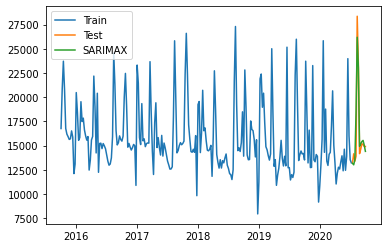

Current product:  9306
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44868D+00    |proj g|=  1.46604D-01


 This problem is unconstrained.



At iterate    5    f=  9.36955D+00    |proj g|=  6.38761D-03

At iterate   10    f=  9.36717D+00    |proj g|=  3.59460D-03

At iterate   15    f=  9.36699D+00    |proj g|=  5.50594D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     18      1     0     0   5.506D-05   9.367D+00
  F =   9.3669895571408581     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2463.5234713360487
Current parameter:  [(1, 1, 0), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51442D+00    |proj g|=  1.15982D-01

At iterate    5    f=  9.45276D+00    |proj g|=  1.67321D-04

At iterate   10    f=  9.45024D+00    |proj g|=  5.89157D-03

At iterate   15    f=  9.44874D+00    |proj g|=  5.16838D-04

At iterate   20    f=  9.44809D+00    |proj g|=  1.89159D-03

At iterate   25    f=  9.44215D+00    |proj g|=  4.34513D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     33      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45322D+00    |proj g|=  3.28289D-02

At iterate    5    f=  9.45163D+00    |proj g|=  2.75632D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   2.756D-05   9.452D+00
  F =   9.4516270317548390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  3411.537320009464
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f=  9.45303D+00    |proj g|=  2.21865D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   2.219D-05   9.453D+00
  F =   9.4530311401938718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  3541.1837073658685
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37860D+00    |proj g|=  3.39466D-02


 This problem is unconstrained.



At iterate    5    f=  9.37476D+00    |proj g|=  3.34959D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   4.857D-05   9.375D+00
  F =   9.3747076290471298     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2290.3048443193256
Current parameter:  [(1, 1, 1), (2, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42253D+00    |proj g|=  1.06424D-01


 This problem is unconstrained.



At iterate    5    f=  9.38538D+00    |proj g|=  7.78712D-03

At iterate   10    f=  9.38521D+00    |proj g|=  4.38837D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     14      1     0     0   4.389D-05   9.385D+00
  F =   9.3852088075110078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2327.565908793877
Current parameter:  [(1, 1, 2), (1, 1, 2, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39646D+00    |proj g|=  6.00699D-0

 This problem is unconstrained.



At iterate    5    f=  9.37798D+00    |proj g|=  1.25006D-02

At iterate   10    f=  9.37233D+00    |proj g|=  5.46767D-03

At iterate   15    f=  9.37129D+00    |proj g|=  2.14341D-03

At iterate   20    f=  9.37111D+00    |proj g|=  1.42685D-03

At iterate   25    f=  9.37104D+00    |proj g|=  4.12174D-04

At iterate   30    f=  9.36830D+00    |proj g|=  1.34060D-02

At iterate   35    f=  9.35675D+00    |proj g|=  1.57077D-02

At iterate   40    f=  9.35608D+00    |proj g|=  5.10505D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     46      1     0     0   1.291D-05   9.356D+00
  F =   9.35607910693

 This problem is unconstrained.



At iterate    5    f=  9.37817D+00    |proj g|=  9.21073D-03

At iterate   10    f=  9.37282D+00    |proj g|=  5.44994D-03

At iterate   15    f=  9.37197D+00    |proj g|=  4.66957D-03

At iterate   20    f=  9.37176D+00    |proj g|=  3.31397D-04

At iterate   25    f=  9.37167D+00    |proj g|=  3.09407D-04

At iterate   30    f=  9.36044D+00    |proj g|=  2.29976D-02

At iterate   35    f=  9.35849D+00    |proj g|=  1.37421D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     44      1     0     0   1.082D-05   9.358D+00
  F =   9.3584915661774044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  9.37629D+00    |proj g|=  1.59978D-02

At iterate   10    f=  9.37285D+00    |proj g|=  7.03194D-03

At iterate   15    f=  9.37199D+00    |proj g|=  1.95810D-03

At iterate   20    f=  9.37177D+00    |proj g|=  7.48388D-04

At iterate   25    f=  9.37171D+00    |proj g|=  1.04407D-03

At iterate   30    f=  9.37066D+00    |proj g|=  7.71435D-03

At iterate   35    f=  9.35843D+00    |proj g|=  5.99756D-03

At iterate   40    f=  9.35820D+00    |proj g|=  7.41292D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     46      1     0     0   7.145D-06   9.358D+00
  F =   9.35819793529

 This problem is unconstrained.



At iterate    5    f=  9.43516D+00    |proj g|=  1.39102D-02

At iterate   10    f=  9.43012D+00    |proj g|=  6.58970D-03

At iterate   15    f=  9.42877D+00    |proj g|=  3.25604D-03

At iterate   20    f=  9.42844D+00    |proj g|=  1.26005D-03

At iterate   25    f=  9.42834D+00    |proj g|=  4.28766D-04

At iterate   30    f=  9.42413D+00    |proj g|=  2.85020D-02

At iterate   35    f=  9.41663D+00    |proj g|=  2.41593D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     42      1     0     0   3.104D-06   9.417D+00
  F =   9.4165943322053742     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.38482D+00    |proj g|=  2.02595D-02

At iterate   10    f=  9.38056D+00    |proj g|=  2.45914D-03

At iterate   15    f=  9.38002D+00    |proj g|=  5.31100D-03

At iterate   20    f=  9.37992D+00    |proj g|=  9.92122D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     24      1     0     0   9.921D-05   9.380D+00
  F =   9.3799200400056932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2404.2421064576342
Current parameter:  [(2, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44886D+00    |proj g|=  1.46210D-01

At iterate    5    f=  9.37664D+00    |proj g|=  1.87806D-02

At iterate   10    f=  9.36643D+00    |proj g|=  8.40638D-03

At iterate   15    f=  9.36526D+00    |proj g|=  4.89734D-03

At iterate   20    f=  9.36521D+00    |proj g|=  6.33726D-04

At iterate   25    f=  9.36513D+00    |proj g|=  9.28770D-03

At iterate   30    f=  9.36235D+00    |proj g|=  1.67916D-02

At iterate   35    f=  9.36023D+00    |proj g|=  3.35404D-03

At iterate   40    f=  9.35972D+00    |proj g|=  4.19056D-03

At iterate   45    f=  9.35969D+00    |proj g|=  3.13877D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38212D+00    |proj g|=  5.25850D-02

At iterate    5    f=  9.37698D+00    |proj g|=  3.52280D-02

At iterate   10    f=  9.36919D+00    |proj g|=  6.98240D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     17      1     0     0   5.135D-05   9.369D+00
  F =   9.3690578235116408     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2245.919417260712
Current parameter:  [(1, 1, 2), (2, 1, 2, 52)

 This problem is unconstrained.



At iterate    5    f=  9.37680D+00    |proj g|=  1.87155D-02

At iterate   10    f=  9.37279D+00    |proj g|=  4.73646D-03

At iterate   15    f=  9.37173D+00    |proj g|=  5.32748D-03

At iterate   20    f=  9.37122D+00    |proj g|=  2.69432D-03

At iterate   25    f=  9.37108D+00    |proj g|=  5.28645D-04

At iterate   30    f=  9.37098D+00    |proj g|=  1.50129D-03

At iterate   35    f=  9.36977D+00    |proj g|=  6.21234D-03

At iterate   40    f=  9.36199D+00    |proj g|=  4.12583D-03

At iterate   45    f=  9.36158D+00    |proj g|=  1.43908D-03

At iterate   50    f=  9.36156D+00    |proj g|=  1.56986D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38078D+00    |proj g|=  4.87752D-02

At iterate    5    f=  9.37756D+00    |proj g|=  4.28737D-03

At iterate   10    f=  9.37468D+00    |proj g|=  3.15597D-03

At iterate   15    f=  9.37462D+00    |proj g|=  4.70977D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     22      1     0     0   5.947D-05   9.375D+00
  F =   9.3746152165569896     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2

 This problem is unconstrained.



At iterate    5    f=  9.36837D+00    |proj g|=  5.46668D-03

At iterate   10    f=  9.36742D+00    |proj g|=  5.61727D-05

At iterate   15    f=  9.36741D+00    |proj g|=  7.71533D-04

At iterate   20    f=  9.36603D+00    |proj g|=  9.78486D-03

At iterate   25    f=  9.36119D+00    |proj g|=  2.11759D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     28      1     0     0   1.046D-05   9.361D+00
  F =   9.3611899512939978     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2496.5373436439572


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38212D+00    |proj g|=  5.25850D-02

At iterate    5    f=  9.37698D+00    |proj g|=  3.52280D-02

At iterate   10    f=  9.36919D+00    |proj g|=  6.98240D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     17      1     0     0   5.135D-05   9.369D+00
  F =   9.3690578235116408     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id: 

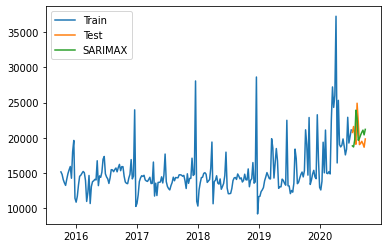

Current product:  9400
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45059D+00    |proj g|=  6.87261D-01


 This problem is unconstrained.



At iterate    5    f=  9.04375D+00    |proj g|=  1.61176D-02

At iterate   10    f=  9.03614D+00    |proj g|=  1.19642D-02

At iterate   15    f=  9.03570D+00    |proj g|=  1.76339D-03

At iterate   20    f=  9.03459D+00    |proj g|=  1.11085D-02

At iterate   25    f=  8.98157D+00    |proj g|=  5.00520D-02

At iterate   30    f=  8.97843D+00    |proj g|=  1.11015D-04

At iterate   35    f=  8.97840D+00    |proj g|=  5.67861D-03

At iterate   40    f=  8.97823D+00    |proj g|=  3.02100D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     53      1     0     0   4.835D-05   8.978D+00
  F =   8.97823124087

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12914D+00    |proj g|=  1.08013D-01

At iterate    5    f=  9.11050D+00    |proj g|=  1.70436D-02

At iterate   10    f=  9.10978D+00    |proj g|=  1.17095D-04

At iterate   15    f=  9.10977D+00    |proj g|=  1.80757D-03

At iterate   20    f=  9.10864D+00    |proj g|=  1.52868D-02

At iterate   25    f=  9.08658D+00    |proj g|=  4.64280D-02

At iterate   30    f=  9.08535D+00    |proj g|=  4.24679D-04

At iterate   35    f=  9.08509D+00    |proj g|=  2.06423D-02

At iterate   40    f=  9.08405D+00    |proj g|=  2.73726D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  9.12297D+00    |proj g|=  1.40996D-04

At iterate   10    f=  9.12296D+00    |proj g|=  3.57335D-03

At iterate   15    f=  9.12171D+00    |proj g|=  4.05741D-02

At iterate   20    f=  9.10814D+00    |proj g|=  1.72984D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     25      1     0     0   7.129D-06   9.108D+00
  F =   9.1078003658239055     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1768.6837058264055
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =  

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   2.435D-06   9.215D+00
  F =   9.2145051408991403     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1254.803675594046
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43677D+00    |proj g|=  6.71565D-01


 This problem is unconstrained.



At iterate    5    f=  9.05534D+00    |proj g|=  1.79293D-02

At iterate   10    f=  9.05119D+00    |proj g|=  1.38699D-04

At iterate   15    f=  9.05117D+00    |proj g|=  7.39064D-04

At iterate   20    f=  9.04925D+00    |proj g|=  6.79761D-03

At iterate   25    f=  9.02627D+00    |proj g|=  5.54253D-02

At iterate   30    f=  9.02109D+00    |proj g|=  9.67745D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     43      1     0     0   7.554D-06   9.021D+00
  F =   9.0210887780982425     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1146.999188423575
Current parameter:  [(1, 1

 This problem is unconstrained.



At iterate    5    f=  9.07039D+00    |proj g|=  1.01285D-02

At iterate   10    f=  9.06834D+00    |proj g|=  2.54496D-04

At iterate   15    f=  9.06834D+00    |proj g|=  5.75477D-04

At iterate   20    f=  9.06805D+00    |proj g|=  7.46531D-03

At iterate   25    f=  9.04664D+00    |proj g|=  4.01852D-02

At iterate   30    f=  9.04269D+00    |proj g|=  6.08140D-04

At iterate   35    f=  9.03981D+00    |proj g|=  5.86630D-02

At iterate   40    f=  9.03302D+00    |proj g|=  3.04508D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     60      1     0     0   8.268D-06   9.033D+00
  F =   9.03290441374

 This problem is unconstrained.



At iterate    5    f=  9.04070D+00    |proj g|=  7.83364D-03

At iterate   10    f=  9.03895D+00    |proj g|=  3.14608D-03

At iterate   15    f=  9.03664D+00    |proj g|=  2.32360D-02

At iterate   20    f=  9.03216D+00    |proj g|=  1.38871D-03

At iterate   25    f=  9.03215D+00    |proj g|=  3.78857D-04

At iterate   30    f=  9.03182D+00    |proj g|=  7.10267D-03

At iterate   35    f=  9.01002D+00    |proj g|=  9.72729D-02

At iterate   40    f=  8.98506D+00    |proj g|=  4.12408D-03

At iterate   45    f=  8.98491D+00    |proj g|=  1.87226D-03

At iterate   50    f=  8.98484D+00    |proj g|=  8.78783D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.06082D+00    |proj g|=  1.54390D-02

At iterate   10    f=  9.05573D+00    |proj g|=  2.91261D-03

At iterate   15    f=  9.05553D+00    |proj g|=  1.66632D-04

At iterate   20    f=  9.05550D+00    |proj g|=  2.22713D-03

At iterate   25    f=  9.05223D+00    |proj g|=  4.78048D-02

At iterate   30    f=  8.99586D+00    |proj g|=  3.18697D-02

At iterate   35    f=  8.99233D+00    |proj g|=  1.02859D-03

At iterate   40    f=  8.99233D+00    |proj g|=  3.76957D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     45      1     0     0   1.635D-05   8.992D+00
  F =   8.99232612503

 This problem is unconstrained.



At iterate    5    f=  9.06106D+00    |proj g|=  1.39664D-02

At iterate   10    f=  9.05532D+00    |proj g|=  1.97165D-03

At iterate   15    f=  9.05511D+00    |proj g|=  1.68448D-04

At iterate   20    f=  9.05509D+00    |proj g|=  1.58818D-03

At iterate   25    f=  9.05264D+00    |proj g|=  1.12746D-02

At iterate   30    f=  9.00537D+00    |proj g|=  9.36336D-03

At iterate   35    f=  8.99484D+00    |proj g|=  3.54727D-02

At iterate   40    f=  8.99308D+00    |proj g|=  3.36591D-03

At iterate   45    f=  8.99298D+00    |proj g|=  5.58302D-03

At iterate   50    f=  8.99260D+00    |proj g|=  2.25094D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.10697D+00    |proj g|=  9.93978D-03

At iterate   10    f=  9.10424D+00    |proj g|=  1.12342D-02

At iterate   15    f=  9.10406D+00    |proj g|=  1.34601D-04

At iterate   20    f=  9.10404D+00    |proj g|=  2.05210D-03

At iterate   25    f=  9.10282D+00    |proj g|=  2.64813D-02

At iterate   30    f=  9.08370D+00    |proj g|=  3.60916D-03

At iterate   35    f=  9.07345D+00    |proj g|=  2.54365D-02

At iterate   40    f=  9.06534D+00    |proj g|=  9.46982D-04

At iterate   45    f=  9.06522D+00    |proj g|=  1.78829D-03

At iterate   50    f=  9.06491D+00    |proj g|=  8.72267D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.05806D+00    |proj g|=  3.78733D-03

At iterate   10    f=  9.05760D+00    |proj g|=  6.69980D-04

At iterate   15    f=  9.05759D+00    |proj g|=  3.16832D-04

At iterate   20    f=  9.05758D+00    |proj g|=  7.44540D-04

At iterate   25    f=  9.05738D+00    |proj g|=  6.64979D-03

At iterate   30    f=  9.03841D+00    |proj g|=  4.17486D-02

At iterate   35    f=  9.00817D+00    |proj g|=  4.64896D-03

At iterate   40    f=  9.00794D+00    |proj g|=  1.01369D-02

At iterate   45    f=  9.00770D+00    |proj g|=  7.93237D-05

At iterate   50    f=  9.00770D+00    |proj g|=  7.85926D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.03161D+00    |proj g|=  3.20774D-02

At iterate   10    f=  9.02863D+00    |proj g|=  5.57980D-03

At iterate   15    f=  9.02821D+00    |proj g|=  1.71564D-04

At iterate   20    f=  9.02820D+00    |proj g|=  7.78944D-04

At iterate   25    f=  9.02667D+00    |proj g|=  3.74915D-03

At iterate   30    f=  8.97926D+00    |proj g|=  8.89094D-02

At iterate   35    f=  8.96972D+00    |proj g|=  3.77913D-03

At iterate   40    f=  8.96954D+00    |proj g|=  1.03607D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     48      1     0     0   7.387D-06   8.970D+00
  F =   8.96953824886

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.05117D+00    |proj g|=  7.57141D-02

At iterate    5    f=  9.04289D+00    |proj g|=  1.08993D-02

At iterate   10    f=  9.04243D+00    |proj g|=  1.42572D-04

At iterate   15    f=  9.04243D+00    |proj g|=  2.26733D-03

At iterate   20    f=  9.04163D+00    |proj g|=  2.74046D-02

At iterate   25    f=  9.02112D+00    |proj g|=  9.34836D-02

At iterate   30    f=  9.01085D+00    |proj g|=  8.53250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14512D+00    |proj g|=  3.39738D-01

At iterate    5    f=  9.03866D+00    |proj g|=  6.14918D-03

At iterate   10    f=  9.03750D+00    |proj g|=  1.63459D-03

At iterate   15    f=  9.03581D+00    |proj g|=  1.90351D-02

At iterate   20    f=  9.03223D+00    |proj g|=  6.48839D-03

At iterate   25    f=  9.03196D+00    |proj g|=  2.20211D-04

At iterate   30    f=  9.03195D+00    |proj g|=  1.22941D-03

At iterate   35    f=  9.03065D+00    |proj g|=  1.91327D-02

At iterate   40    f=  9.00094D+00    |proj g|=  4.34544D-02

At iterate   45    f=  8.98176D+00    |proj g|=  5.28253D-03

At iterate   50    f=  8.98143D+00    |proj g|=  9.14848D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.04548D+00    |proj g|=  8.81931D-03

At iterate   10    f=  9.03445D+00    |proj g|=  1.10649D-02

At iterate   15    f=  9.03421D+00    |proj g|=  3.15661D-04

At iterate   20    f=  9.03413D+00    |proj g|=  7.99070D-03

At iterate   25    f=  9.02524D+00    |proj g|=  8.04219D-02

At iterate   30    f=  9.01372D+00    |proj g|=  1.25360D-03

At iterate   35    f=  9.01369D+00    |proj g|=  6.63274D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     40      1     0     0   6.633D-06   9.014D+00
  F =   9.0136861719986712     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.09288D+00    |proj g|=  8.44878D-03

At iterate   10    f=  9.09220D+00    |proj g|=  1.24448D-04

At iterate   15    f=  9.09171D+00    |proj g|=  9.38094D-03

At iterate   20    f=  9.06219D+00    |proj g|=  3.75123D-02

At iterate   25    f=  9.05692D+00    |proj g|=  2.96499D-02

At iterate   30    f=  9.05396D+00    |proj g|=  3.37216D-03

At iterate   35    f=  9.05354D+00    |proj g|=  1.04138D-03

At iterate   40    f=  9.05342D+00    |proj g|=  1.63218D-04

At iterate   45    f=  9.05340D+00    |proj g|=  1.08624D-04

At iterate   50    f=  9.05327D+00    |proj g|=  3.70514D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.07039D+00    |proj g|=  1.01285D-02

At iterate   10    f=  9.06834D+00    |proj g|=  2.54496D-04

At iterate   15    f=  9.06834D+00    |proj g|=  5.75477D-04

At iterate   20    f=  9.06805D+00    |proj g|=  7.46531D-03

At iterate   25    f=  9.04664D+00    |proj g|=  4.01852D-02

At iterate   30    f=  9.04269D+00    |proj g|=  6.08140D-04

At iterate   35    f=  9.03981D+00    |proj g|=  5.86630D-02

At iterate   40    f=  9.03302D+00    |proj g|=  3.04508D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     60      1     0     0   8.268D-06   9.033D+00
  F =   9.03290441374

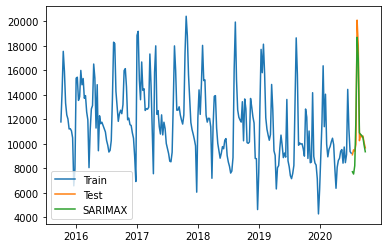

Current product:  10135
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13496D+00    |proj g|=  6.63916D-02

At iterate    5    f=  9.11906D+00    |proj g|=  1.31213D-02

At iterate   10    f=  9.11823D+00    |proj g|=  4.14293D-05

At iterate   15    f=  9.11823D+00    |proj g|=  1.06194D-03

At iterate   20    f=  9.11749D+00    |proj g|=  1.35251D-02

At iterate   25    f=  9.11563D+00    |proj g|=  2.89223D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  9.16444D+00    |proj g|=  3.57239D-02

At iterate   10    f=  9.16306D+00    |proj g|=  4.82471D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   1.754D-05   9.163D+00
  F =   9.1630555501566491     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2667.4078104168616
Current parameter:  [(1, 1, 0), (1, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18433D+00    |proj g|=  1.03111D-

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   4.114D-06   9.176D+00
  F =   9.1755804199849820     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  2823.868144239707
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20996D+00    |proj g|=  5.85886D-02


 This problem is unconstrained.



At iterate    5    f=  9.20679D+00    |proj g|=  3.69372D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   3.694D-05   9.207D+00
  F =   9.2067911079473461     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2639.7409851964594
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14105D+00    |proj g|=  1.29309D-01


 This problem is unconstrained.



At iterate    5    f=  9.12242D+00    |proj g|=  9.66624D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   4.135D-05   9.122D+00
  F =   9.1224216401664737     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1938.5373997429242
Current parameter:  [(1, 1, 1), (2, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12715D+00    |proj g|=  2.16480D-01


 This problem is unconstrained.



At iterate    5    f=  9.08747D+00    |proj g|=  1.54526D-02

At iterate   10    f=  9.08727D+00    |proj g|=  1.05614D-04

At iterate   15    f=  9.08726D+00    |proj g|=  1.68036D-03

At iterate   20    f=  9.08643D+00    |proj g|=  1.94324D-02

At iterate   25    f=  9.06695D+00    |proj g|=  1.67579D-02

At iterate   30    f=  9.06458D+00    |proj g|=  9.74627D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     33      1     0     0   6.519D-06   9.065D+00
  F =   9.0645767129282007     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1324.36852607446
Current parameter:  [(1, 1,

 This problem is unconstrained.



At iterate    5    f=  9.09001D+00    |proj g|=  2.75554D-02

At iterate   10    f=  9.07609D+00    |proj g|=  4.25128D-03

At iterate   15    f=  9.07462D+00    |proj g|=  2.85685D-03

At iterate   20    f=  9.07460D+00    |proj g|=  1.12444D-04

At iterate   25    f=  9.07458D+00    |proj g|=  1.39801D-03

At iterate   30    f=  9.07103D+00    |proj g|=  1.60276D-02

At iterate   35    f=  9.04827D+00    |proj g|=  7.08770D-03

At iterate   40    f=  9.04762D+00    |proj g|=  3.22276D-04

At iterate   45    f=  9.04762D+00    |proj g|=  3.76588D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     50   

 This problem is unconstrained.



At iterate    5    f=  9.08890D+00    |proj g|=  3.66197D-02

At iterate   10    f=  9.08698D+00    |proj g|=  2.28143D-03

At iterate   15    f=  9.08695D+00    |proj g|=  1.83200D-04

At iterate   20    f=  9.08688D+00    |proj g|=  2.60069D-03

At iterate   25    f=  9.07899D+00    |proj g|=  7.08239D-02

At iterate   30    f=  9.05690D+00    |proj g|=  3.61061D-03

At iterate   35    f=  9.05668D+00    |proj g|=  2.41658D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     42      1     0     0   6.889D-06   9.057D+00
  F =   9.0566702184425694     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.08306D+00    |proj g|=  7.00113D-03

At iterate   10    f=  9.08244D+00    |proj g|=  3.62601D-03

At iterate   15    f=  9.08232D+00    |proj g|=  1.15415D-04

At iterate   20    f=  9.08231D+00    |proj g|=  1.86678D-03

At iterate   25    f=  9.08145D+00    |proj g|=  1.56943D-02

At iterate   30    f=  9.06909D+00    |proj g|=  3.72464D-02

At iterate   35    f=  9.05224D+00    |proj g|=  6.53563D-03

At iterate   40    f=  9.05191D+00    |proj g|=  3.03899D-03

At iterate   45    f=  9.05185D+00    |proj g|=  1.39284D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     48   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20591D+00    |proj g|=  1.81462D-01

At iterate    5    f=  9.15053D+00    |proj g|=  1.41884D-02

At iterate   10    f=  9.14728D+00    |proj g|=  1.95969D-03

At iterate   15    f=  9.14726D+00    |proj g|=  1.38311D-04

At iterate   20    f=  9.14722D+00    |proj g|=  2.36404D-03

At iterate   25    f=  9.14279D+00    |proj g|=  2.90379D-02

At iterate   30    f=  9.14199D+00    |proj g|=  2.51994D-04

At iterate   35    f=  9.14178D+00    |proj g|=  1.42012D-02

At iterate   40    f=  9.14135D+00    |proj g|=  2.29704D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  9.09986D+00    |proj g|=  4.94219D-02

At iterate   10    f=  9.08212D+00    |proj g|=  4.63319D-03

At iterate   15    f=  9.08205D+00    |proj g|=  1.09038D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     19     22      1     0     0   9.782D-05   9.082D+00
  F =   9.0820471011996364     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1488.353226040461
Current parameter:  [(2, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bound

 This problem is unconstrained.



At iterate    5    f=  9.11590D+00    |proj g|=  4.14708D-02

At iterate   10    f=  9.11321D+00    |proj g|=  6.42385D-03

At iterate   15    f=  9.11301D+00    |proj g|=  5.21752D-05

At iterate   20    f=  9.11299D+00    |proj g|=  4.19407D-03

At iterate   25    f=  9.11187D+00    |proj g|=  2.18193D-02

At iterate   30    f=  9.11135D+00    |proj g|=  3.12552D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   6.210D-05   9.111D+00
  F =   9.1113522516959797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2060.703915402613
Current parameter:  [(2, 1

 This problem is unconstrained.



At iterate    5    f=  9.12666D+00    |proj g|=  2.81758D-02

At iterate   10    f=  9.12040D+00    |proj g|=  3.01608D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     13      1     0     0   3.016D-05   9.120D+00
  F =   9.1203984392695627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2024.4494924284431
Current parameter:  [(1, 1, 2), (2, 1, 2, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15670D+00    |proj g|=  2.05183D-01

At iterate    5    f=  9.08459D+00    |proj g|=  3.37965D-02

At iterate   10    f=  9.07129D+00    |proj g|=  6.69140D-03

At iterate   15    f=  9.06892D+00    |proj g|=  3.81538D-03

At iterate   20    f=  9.06884D+00    |proj g|=  1.12824D-04

At iterate   25    f=  9.06883D+00    |proj g|=  2.55691D-03

At iterate   30    f=  9.06802D+00    |proj g|=  1.61120D-02

At iterate   35    f=  9.06586D+00    |proj g|=  8.38350D-03

At iterate   40    f=  9.05326D+00    |proj g|=  9.19832D-02

At iterate   45    f=  9.04047D+00    |proj g|=  4.88223D-03

At iterate   50    f=  9.04020D+00    |proj g|=  2.53100D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14240D+00    |proj g|=  1.40780D-01

At iterate    5    f=  9.12526D+00    |proj g|=  1.90512D-02

At iterate   10    f=  9.11135D+00    |proj g|=  2.19517D-03

At iterate   15    f=  9.11134D+00    |proj g|=  1.15022D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     21      1     0     0   3.153D-05   9.111D+00
  F =   9.1113366532683315     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2

 This problem is unconstrained.



At iterate    5    f=  9.12019D+00    |proj g|=  1.66410D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     11      1     0     0   4.424D-05   9.120D+00
  F =   9.1199619136577077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1903.5051341132987


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15692D+00    |proj g|=  1.90389D-01

At iterate    5    f=  9.08890D+00    |proj g|=  3.66197D-02

At iterate   10    f=  9.08698D+00    |proj g|=  2.28143D-03

At iterate   15    f=  9.08695D+00    |proj g|=  1.83200D-04

At iterate   20    f=  9.08688D+00    |proj g|=  2.60069D-03

At iterate   25    f=  9.07899D+00    |proj g|=  7.08239D-02

At iterate   30    f=  9.05690D+00    |proj g|=  3.61061D-03

At iterate   35    f=  9.05668D+00    |proj g|=  2.41658D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

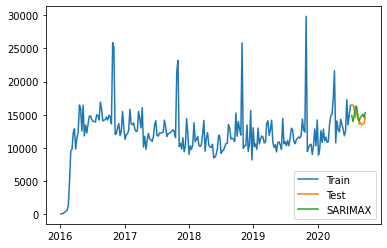

Current product:  9898
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.62107D+00    |proj g|=  1.80714D-01

At iterate    5    f=  8.57524D+00    |proj g|=  9.17823D-03

At iterate   10    f=  8.57183D+00    |proj g|=  3.58180D-03

At iterate   15    f=  8.57180D+00    |proj g|=  4.35698D-04

At iterate   20    f=  8.57035D+00    |proj g|=  1.63645D-02

At iterate   25    f=  8.55048D+00    |proj g|=  2.72763D-02

At iterate   30    f=  8.54982D+00    |proj g|=  5.83787D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.70512D+00    |proj g|=  2.09215D-01

At iterate    5    f=  8.66362D+00    |proj g|=  1.75723D-02

At iterate   10    f=  8.66317D+00    |proj g|=  9.98734D-05

At iterate   15    f=  8.66312D+00    |proj g|=  2.29115D-03

At iterate   20    f=  8.66079D+00    |proj g|=  1.09291D-02

At iterate   25    f=  8.65451D+00    |proj g|=  3.26774D-03

At iterate   30    f=  8.65376D+00    |proj g|=  9.48366D-03

At iterate   35    f=  8.65287D+00    |proj g|=  6.03245D-03

At iterate   40    f=  8.65264D+00    |proj g|=  2.95362D-04

At iterate   45    f=  8.65260D+00    |proj g|=  2.19428D-04

At iterate   50    f=  8.65260D+00    |proj g|=  4.21064D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68300D+00    |proj g|=  1.11690D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   7.070D-05   8.673D+00
  F =   8.6729714188644547     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1629.0487756316707
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0 

 This problem is unconstrained.


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   1.278D-06   8.704D+00
  F =   8.7042229938996343     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1348.2923585648136
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.60933D+00    |proj g|=  7.76849D-02


 This problem is unconstrained.



At iterate    5    f=  8.59237D+00    |proj g|=  7.59303D-03

At iterate   10    f=  8.59227D+00    |proj g|=  2.68090D-04

At iterate   15    f=  8.59194D+00    |proj g|=  4.46202D-03

At iterate   20    f=  8.58247D+00    |proj g|=  6.56976D-02

At iterate   25    f=  8.57940D+00    |proj g|=  6.86025D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   3.727D-06   8.579D+00
  F =   8.5793976495845214     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1274.7769553650705
Current parameter:  [(1, 1, 1), (2, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * 

 This problem is unconstrained.



At iterate    0    f=  8.62076D+00    |proj g|=  9.62793D-02

At iterate    5    f=  8.60549D+00    |proj g|=  1.62763D-03

At iterate   10    f=  8.60539D+00    |proj g|=  1.94942D-04

At iterate   15    f=  8.60529D+00    |proj g|=  7.26381D-03

At iterate   20    f=  8.59630D+00    |proj g|=  6.88196D-02

At iterate   25    f=  8.58026D+00    |proj g|=  1.24262D-03

At iterate   30    f=  8.58024D+00    |proj g|=  7.39626D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     36      1     0     0   2.302D-06   8.580D+00
  F =   8.5802344303198428     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  8.57929D+00    |proj g|=  2.74150D-03

At iterate   10    f=  8.57887D+00    |proj g|=  7.85119D-04

At iterate   15    f=  8.57886D+00    |proj g|=  9.40435D-04

At iterate   20    f=  8.57814D+00    |proj g|=  1.11497D-02

At iterate   25    f=  8.55226D+00    |proj g|=  2.73527D-02

At iterate   30    f=  8.54145D+00    |proj g|=  3.22395D-02

At iterate   35    f=  8.53598D+00    |proj g|=  1.18215D-03

At iterate   40    f=  8.53556D+00    |proj g|=  3.12490D-03

At iterate   45    f=  8.53548D+00    |proj g|=  1.17304D-03

At iterate   50    f=  8.53509D+00    |proj g|=  2.58247D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65994D+00    |proj g|=  1.68616D-01

At iterate    5    f=  8.59590D+00    |proj g|=  6.31659D-03

At iterate   10    f=  8.59510D+00    |proj g|=  9.80459D-04

At iterate   15    f=  8.59509D+00    |proj g|=  1.34083D-03

At iterate   20    f=  8.59395D+00    |proj g|=  1.84867D-02

At iterate   25    f=  8.54307D+00    |proj g|=  2.19730D-02

At iterate   30    f=  8.54223D+00    |proj g|=  6.23601D-04

At iterate   35    f=  8.54220D+00    |proj g|=  1.70819D-04

At iterate   40    f=  8.54216D+00    |proj g|=  2.43558D-03

At iterate   45    f=  8.54205D+00    |proj g|=  1.91245D-04

At iterate   50    f=  8.54204D+00    |proj g|=  6.58103D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.59432D+00    |proj g|=  7.35664D-03

At iterate   10    f=  8.59370D+00    |proj g|=  2.71771D-03

At iterate   15    f=  8.59366D+00    |proj g|=  3.62760D-04

At iterate   20    f=  8.59351D+00    |proj g|=  7.14472D-03

At iterate   25    f=  8.57083D+00    |proj g|=  7.29769D-02

At iterate   30    f=  8.54479D+00    |proj g|=  8.11953D-03

At iterate   35    f=  8.54239D+00    |proj g|=  1.93211D-03

At iterate   40    f=  8.54216D+00    |proj g|=  4.77302D-03

At iterate   45    f=  8.54135D+00    |proj g|=  4.81133D-03

At iterate   50    f=  8.54119D+00    |proj g|=  6.60580D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71288D+00    |proj g|=  1.96280D-01

At iterate    5    f=  8.65414D+00    |proj g|=  1.05600D-02

At iterate   10    f=  8.65173D+00    |proj g|=  1.51120D-03

At iterate   15    f=  8.65172D+00    |proj g|=  4.78450D-04

At iterate   20    f=  8.65158D+00    |proj g|=  8.20687D-03

At iterate   25    f=  8.63675D+00    |proj g|=  8.19125D-02

At iterate   30    f=  8.61773D+00    |proj g|=  1.65518D-02

At iterate   35    f=  8.61538D+00    |proj g|=  7.50369D-04

At iterate   40    f=  8.61517D+00    |proj g|=  9.69526D-04

At iterate   45    f=  8.61515D+00    |proj g|=  5.25908D-05

At iterate   50    f=  8.61515D+00    |proj g|=  6.25665D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74259D+00    |proj g|=  3.70507D-01

At iterate    5    f=  8.61305D+00    |proj g|=  2.64317D-02

At iterate   10    f=  8.59805D+00    |proj g|=  7.62179D-03

At iterate   15    f=  8.59790D+00    |proj g|=  1.21843D-03

At iterate   20    f=  8.59789D+00    |proj g|=  7.01570D-04

At iterate   25    f=  8.59747D+00    |proj g|=  9.15794D-03

At iterate   30    f=  8.57769D+00    |proj g|=  4.26403D-02

At iterate   35    f=  8.57149D+00    |proj g|=  1.52332D-02

At iterate   40    f=  8.57112D+00    |proj g|=  5.32658D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.79881D+00    |proj g|=  4.85666D-01

At iterate    5    f=  8.61499D+00    |proj g|=  4.18830D-02

At iterate   10    f=  8.56974D+00    |proj g|=  1.77398D-02

At iterate   15    f=  8.56571D+00    |proj g|=  4.46467D-03

At iterate   20    f=  8.56557D+00    |proj g|=  1.80240D-04

At iterate   25    f=  8.56556D+00    |proj g|=  3.22372D-03

At iterate   30    f=  8.56388D+00    |proj g|=  3.58859D-02

At iterate   35    f=  8.55244D+00    |proj g|=  1.79726D-02

At iterate   40    f=  8.54825D+00    |proj g|=  3.51008D-03

At iterate   45    f=  8.54803D+00    |proj g|=  2.04451D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  8.61234D+00    |proj g|=  4.10702D-02

At iterate   10    f=  8.58230D+00    |proj g|=  2.03728D-02

At iterate   15    f=  8.57961D+00    |proj g|=  6.73116D-04

At iterate   20    f=  8.57959D+00    |proj g|=  3.20314D-03

At iterate   25    f=  8.57808D+00    |proj g|=  4.27539D-02

At iterate   30    f=  8.56880D+00    |proj g|=  5.81667D-03

At iterate   35    f=  8.56877D+00    |proj g|=  7.50183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     39      1     0     0   5.583D-06   8.569D+00
  F =   8.5687671651170696     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.62801D+00    |proj g|=  1.64182D-01

At iterate    5    f=  8.57736D+00    |proj g|=  1.16731D-02

At iterate   10    f=  8.57689D+00    |proj g|=  3.26653D-03

At iterate   15    f=  8.57678D+00    |proj g|=  6.63606D-04

At iterate   20    f=  8.57678D+00    |proj g|=  3.33294D-04

At iterate   25    f=  8.57667D+00    |proj g|=  5.16717D-03

At iterate   30    f=  8.56884D+00    |proj g|=  3.82904D-02

At iterate   35    f=  8.54471D+00    |proj g|=  1.13035D-02

At iterate   40    f=  8.53505D+00    |proj g|=  2.77972D-03

At iterate   45    f=  8.53487D+00    |proj g|=  4.12358D-03

At iterate   50    f=  8.53429D+00    |proj g|=  8.04495D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.59500D+00    |proj g|=  2.81230D-02

At iterate   10    f=  8.58554D+00    |proj g|=  2.40834D-03

At iterate   15    f=  8.58551D+00    |proj g|=  1.28447D-04

At iterate   20    f=  8.58550D+00    |proj g|=  2.33727D-03

At iterate   25    f=  8.58453D+00    |proj g|=  2.46925D-02

At iterate   30    f=  8.57772D+00    |proj g|=  7.21000D-03

At iterate   35    f=  8.57758D+00    |proj g|=  6.99428D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     42      1     0     0   6.173D-06   8.578D+00
  F =   8.5775762193073479     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  8.58871D+00    |proj g|=  4.94177D-03

At iterate   10    f=  8.58849D+00    |proj g|=  3.77403D-04

At iterate   15    f=  8.58842D+00    |proj g|=  4.23997D-03

At iterate   20    f=  8.57965D+00    |proj g|=  3.76497D-02

At iterate   25    f=  8.56582D+00    |proj g|=  4.98829D-03

At iterate   30    f=  8.56222D+00    |proj g|=  1.35810D-03

At iterate   35    f=  8.56123D+00    |proj g|=  2.44256D-03

At iterate   40    f=  8.56106D+00    |proj g|=  8.63402D-04

At iterate   45    f=  8.56104D+00    |proj g|=  8.18851D-05

At iterate   50    f=  8.56103D+00    |proj g|=  8.91506D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.76730D+00    |proj g|=  4.62044D-01

At iterate    5    f=  8.61234D+00    |proj g|=  4.10702D-02

At iterate   10    f=  8.58230D+00    |proj g|=  2.03728D-02

At iterate   15    f=  8.57961D+00    |proj g|=  6.73116D-04

At iterate   20    f=  8.57959D+00    |proj g|=  3.20314D-03

At iterate   25    f=  8.57808D+00    |proj g|=  4.27539D-02

At iterate   30    f=  8.56880D+00    |proj g|=  5.81667D-03

At iterate   35    f=  8.56877D+00    |proj g|=  7.50183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

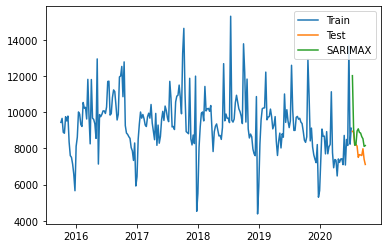

Current product:  9630
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92341D+00    |proj g|=  6.13598D-02


 This problem is unconstrained.



At iterate    5    f=  8.90197D+00    |proj g|=  2.11584D-02

At iterate   10    f=  8.90129D+00    |proj g|=  1.81721D-04

At iterate   15    f=  8.90128D+00    |proj g|=  2.62313D-03

At iterate   20    f=  8.89976D+00    |proj g|=  2.92112D-02

At iterate   25    f=  8.86185D+00    |proj g|=  6.03073D-02

At iterate   30    f=  8.85380D+00    |proj g|=  1.32935D-02

At iterate   35    f=  8.85266D+00    |proj g|=  2.10820D-03

At iterate   40    f=  8.85256D+00    |proj g|=  6.32015D-04

At iterate   45    f=  8.85255D+00    |proj g|=  5.75449D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     54   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.96918D+00    |proj g|=  6.79799D-02

At iterate    5    f=  8.95480D+00    |proj g|=  1.12453D-02

At iterate   10    f=  8.95399D+00    |proj g|=  1.39461D-04

At iterate   15    f=  8.95393D+00    |proj g|=  2.86759D-03

At iterate   20    f=  8.94656D+00    |proj g|=  2.91099D-02

At iterate   25    f=  8.92415D+00    |proj g|=  1.68419D-02

At iterate   30    f=  8.92373D+00    |proj g|=  7.11604D-04

At iterate   35    f=  8.92365D+00    |proj g|=  4.66277D-03

At iterate   40    f=  8.92356D+00    |proj g|=  1.68765D-03

At iterate   45    f=  8.92353D+00    |proj g|=  6.57050D-04

At iterate   50    f=  8.92142D+00    |proj g|=  1.24400D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.96749D+00    |proj g|=  1.74195D-02

At iterate    5    f=  8.96710D+00    |proj g|=  1.10183D-04

At iterate   10    f=  8.96708D+00    |proj g|=  2.59800D-03

At iterate   15    f=  8.96547D+00    |proj g|=  2.64280D-02

At iterate   20    f=  8.95352D+00    |proj g|=  5.91849D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     26      1     0     0   8.839D-06   8.953D+00
  F =   8.9533837799333149     

CONVERG

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   1.348D-05   9.044D+00
  F =   9.0437510443803983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2231.1427639856447
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92166D+00    |proj g|=  5.80083D-02

At iterate    5    f=  8.91047D+00    |proj g|=  2.20524D-03

At iterate   10    f=  8.91047D+00    |proj g|=  2.76415D-04

At iterate   15    f=  8.91036D+00    |proj g|=  5.05939D-03

At iterate   20    f=  8.90131D+00    |proj g|=  4.07048D-02

At iterate   25    f=  8.88347D+00    |proj g|=  1.55000D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  8.93465D+00    |proj g|=  1.73953D-03

At iterate   10    f=  8.93464D+00    |proj g|=  2.79043D-04

At iterate   15    f=  8.93460D+00    |proj g|=  5.00640D-03

At iterate   20    f=  8.93053D+00    |proj g|=  5.10783D-02

At iterate   25    f=  8.90959D+00    |proj g|=  7.73492D-03

At iterate   30    f=  8.90924D+00    |proj g|=  4.82983D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     34      1     0     0   1.564D-05   8.909D+00
  F =   8.9092385994106547     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1900.8449119918282
Current parameter:  [(1, 

 This problem is unconstrained.



At iterate    5    f=  8.90816D+00    |proj g|=  8.70453D-03

At iterate   10    f=  8.90262D+00    |proj g|=  1.04166D-02

At iterate   15    f=  8.90162D+00    |proj g|=  7.58986D-04

At iterate   20    f=  8.90161D+00    |proj g|=  3.04256D-04

At iterate   25    f=  8.90132D+00    |proj g|=  4.91849D-03

At iterate   30    f=  8.88268D+00    |proj g|=  3.40502D-02

At iterate   35    f=  8.86160D+00    |proj g|=  1.27434D-02

At iterate   40    f=  8.84766D+00    |proj g|=  2.34961D-02

At iterate   45    f=  8.84644D+00    |proj g|=  3.69829D-03

At iterate   50    f=  8.84570D+00    |proj g|=  9.71956D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.91949D+00    |proj g|=  1.00005D-02

At iterate   10    f=  8.91733D+00    |proj g|=  3.43894D-04

At iterate   15    f=  8.91731D+00    |proj g|=  9.97677D-04

At iterate   20    f=  8.91347D+00    |proj g|=  2.49768D-02

At iterate   25    f=  8.87139D+00    |proj g|=  3.90681D-02

At iterate   30    f=  8.85395D+00    |proj g|=  4.02096D-04

At iterate   35    f=  8.85394D+00    |proj g|=  8.37352D-04

At iterate   40    f=  8.85384D+00    |proj g|=  7.79656D-04

At iterate   45    f=  8.85381D+00    |proj g|=  1.77290D-04

At iterate   50    f=  8.85373D+00    |proj g|=  1.52183D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.91894D+00    |proj g|=  7.10148D-03

At iterate   10    f=  8.91659D+00    |proj g|=  1.31377D-03

At iterate   15    f=  8.91655D+00    |proj g|=  1.88724D-04

At iterate   20    f=  8.91650D+00    |proj g|=  1.54514D-03

At iterate   25    f=  8.91248D+00    |proj g|=  2.61700D-02

At iterate   30    f=  8.86437D+00    |proj g|=  2.61554D-02

At iterate   35    f=  8.86085D+00    |proj g|=  3.92703D-03
  ys=-4.782E-03  -gs= 2.636E-03 BFGS update SKIPPED

At iterate   40    f=  8.84940D+00    |proj g|=  9.79913D-03

At iterate   45    f=  8.84924D+00    |proj g|=  6.76550D-04

At iterate   50    f=  8.84900D+00    |proj g|=  4.18124D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.05809D+00    |proj g|=  3.36450D-01

At iterate    5    f=  8.95579D+00    |proj g|=  7.92806D-03

At iterate   10    f=  8.95339D+00    |proj g|=  3.97144D-03

At iterate   15    f=  8.95332D+00    |proj g|=  1.55108D-04

At iterate   20    f=  8.95327D+00    |proj g|=  3.60469D-03

At iterate   25    f=  8.94535D+00    |proj g|=  5.17960D-02

At iterate   30    f=  8.91265D+00    |proj g|=  1.33142D-02

At iterate   35    f=  8.90768D+00    |proj g|=  4.69332D-03

At iterate   40    f=  8.90671D+00    |proj g|=  1.01604D-03

At iterate   45    f=  8.90647D+00    |proj g|=  1.78174D-04

At iterate   50    f=  8.90644D+00    |proj g|=  4.22979D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.92504D+00    |proj g|=  1.69498D-02

At iterate   10    f=  8.92393D+00    |proj g|=  2.84818D-03

At iterate   15    f=  8.92385D+00    |proj g|=  1.50031D-04

At iterate   20    f=  8.92384D+00    |proj g|=  2.14179D-03

At iterate   25    f=  8.92299D+00    |proj g|=  1.86862D-02

At iterate   30    f=  8.91360D+00    |proj g|=  2.71129D-02

At iterate   35    f=  8.88954D+00    |proj g|=  1.05707D-02

At iterate   40    f=  8.88848D+00    |proj g|=  6.57043D-03

At iterate   45    f=  8.88708D+00    |proj g|=  5.68892D-03

At iterate   50    f=  8.88676D+00    |proj g|=  1.13416D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92629D+00    |proj g|=  7.36019D-02

At iterate    5    f=  8.89898D+00    |proj g|=  2.54807D-02

At iterate   10    f=  8.89623D+00    |proj g|=  2.18985D-03

At iterate   15    f=  8.89618D+00    |proj g|=  1.77460D-04

At iterate   20    f=  8.89613D+00    |proj g|=  5.46831D-03

At iterate   25    f=  8.88673D+00    |proj g|=  4.81733D-02

At iterate   30    f=  8.85264D+00    |proj g|=  1.38844D-02

At iterate   35    f=  8.85151D+00    |proj g|=  9.64849D-03

At iterate   40    f=  8.85055D+00    |proj g|=  3.05925D-03

At iterate   45    f=  8.85042D+00    |proj g|=  1.50307D-03

At iterate   50    f=  8.85038D+00    |proj g|=  7.09414D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.90726D+00    |proj g|=  3.70053D-02

At iterate   10    f=  8.90550D+00    |proj g|=  1.48821D-04

At iterate   15    f=  8.90549D+00    |proj g|=  2.69526D-03

At iterate   20    f=  8.90426D+00    |proj g|=  3.11233D-02

At iterate   25    f=  8.88320D+00    |proj g|=  2.56233D-02

At iterate   30    f=  8.88143D+00    |proj g|=  8.49151D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     35      1     0     0   6.247D-06   8.881D+00
  F =   8.8814289736277487     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1952.4234347877887
Current parameter:  [(1, 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01558D+00    |proj g|=  3.56294D-01

At iterate    5    f=  8.90736D+00    |proj g|=  8.57970D-03

At iterate   10    f=  8.90146D+00    |proj g|=  6.29495D-03

At iterate   15    f=  8.90115D+00    |proj g|=  3.23331D-04

At iterate   20    f=  8.90113D+00    |proj g|=  1.49834D-03

At iterate   25    f=  8.89809D+00    |proj g|=  1.79611D-02

At iterate   30    f=  8.85760D+00    |proj g|=  1.65208D-02

At iterate   35    f=  8.85308D+00    |proj g|=  7.00282D-03

At iterate   40    f=  8.84296D+00    |proj g|=  3.44729D-02

At iterate   45    f=  8.84169D+00    |proj g|=  5.32018D-04

At iterate   50    f=  8.84162D+00    |proj g|=  1.35687D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.90953D+00    |proj g|=  4.57895D-02

At iterate    5    f=  8.90309D+00    |proj g|=  1.24050D-02

At iterate   10    f=  8.90092D+00    |proj g|=  1.42378D-04

At iterate   15    f=  8.90091D+00    |proj g|=  1.77109D-03

At iterate   20    f=  8.89978D+00    |proj g|=  2.01000D-02

At iterate   25    f=  8.88120D+00    |proj g|=  2.39773D-02

At iterate   30    f=  8.87952D+00    |proj g|=  3.70804D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  8.91901D+00    |proj g|=  1.83294D-02

At iterate   10    f=  8.91807D+00    |proj g|=  1.64356D-04

At iterate   15    f=  8.91805D+00    |proj g|=  1.54749D-03

At iterate   20    f=  8.91563D+00    |proj g|=  2.41561D-02

At iterate   25    f=  8.88308D+00    |proj g|=  1.53942D-02

At iterate   30    f=  8.87620D+00    |proj g|=  5.00393D-03

At iterate   35    f=  8.87484D+00    |proj g|=  1.77200D-04

At iterate   40    f=  8.87460D+00    |proj g|=  3.00370D-04

At iterate   45    f=  8.87454D+00    |proj g|=  4.40641D-04

At iterate   50    f=  8.87452D+00    |proj g|=  1.60579D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.90816D+00    |proj g|=  8.70453D-03

At iterate   10    f=  8.90262D+00    |proj g|=  1.04166D-02

At iterate   15    f=  8.90162D+00    |proj g|=  7.58986D-04

At iterate   20    f=  8.90161D+00    |proj g|=  3.04256D-04

At iterate   25    f=  8.90132D+00    |proj g|=  4.91849D-03

At iterate   30    f=  8.88268D+00    |proj g|=  3.40502D-02

At iterate   35    f=  8.86160D+00    |proj g|=  1.27434D-02

At iterate   40    f=  8.84766D+00    |proj g|=  2.34961D-02

At iterate   45    f=  8.84644D+00    |proj g|=  3.69829D-03

At iterate   50    f=  8.84570D+00    |proj g|=  9.71956D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

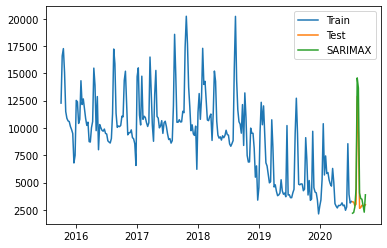

Current product:  9897
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.82951D+00    |proj g|=  3.15845D-01

At iterate    5    f=  8.65637D+00    |proj g|=  4.09679D-03

At iterate   10    f=  8.65566D+00    |proj g|=  2.28244D-03

At iterate   15    f=  8.65566D+00    |proj g|=  3.15734D-04

At iterate   20    f=  8.65559D+00    |proj g|=  3.68988D-03

At iterate   25    f=  8.65316D+00    |proj g|=  2.41017D-02

At iterate   30    f=  8.63992D+00    |proj g|=  1.26945D-02

At iterate   35    f=  8.63822D+00    |proj g|=  1.48951D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.93644D+00    |proj g|=  3.50328D-01

At iterate    5    f=  8.77133D+00    |proj g|=  8.07499D-04

At iterate   10    f=  8.77131D+00    |proj g|=  1.30063D-03

At iterate   15    f=  8.76795D+00    |proj g|=  2.04092D-02

At iterate   20    f=  8.76557D+00    |proj g|=  7.99573D-03

At iterate   25    f=  8.76233D+00    |proj g|=  9.33036D-04

At iterate   30    f=  8.76180D+00    |proj g|=  3.19234D-03

At iterate   35    f=  8.76169D+00    |proj g|=  5.11854D-04

At iterate   40    f=  8.76168D+00    |proj g|=  1.21981D-04

At iterate   45    f=  8.76167D+00    |proj g|=  4.88553D-05

At iterate   50    f=  8.76011D+00    |proj g|=  1.35621D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   5.106D-05   8.776D+00
  F =   8.7764040746401939     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1413.9263174344037
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.79241D+00    |proj g|=  1.15092D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   1.199D-05   8.792D+00
  F =   8.7923119940773091     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1231.8815088054891
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68747D+00    |proj g|=  1.05101D-01

At iterate    5    f=  8.67322D+00    |proj g|=  1.04453D-03

At iterate   10    f=  8.67321D+00    |proj g|=  2.93346D-04

At iterate   15    f=  8.67319D+00    |proj g|=  5.01040D-03

At iterate   20    f=  8.67098D+00    |proj g|=  5.02358D-02

At iterate   25    f=  8.66320D+00    |proj g|=  1.91962D-03

At iterate   30    f=  8.66308D+00    |proj g|=  2.40277D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  8.69432D+00    |proj g|=  2.88976D-03

At iterate   10    f=  8.69392D+00    |proj g|=  5.29870D-04

At iterate   15    f=  8.69390D+00    |proj g|=  2.82047D-03

At iterate   20    f=  8.69246D+00    |proj g|=  3.29200D-02

At iterate   25    f=  8.67999D+00    |proj g|=  3.32859D-03

At iterate   30    f=  8.67944D+00    |proj g|=  1.47771D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     36      1     0     0   3.449D-06   8.679D+00
  F =   8.6794309268349377     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1500.75829750903
Current parameter:  [(1, 1,

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71097D+00    |proj g|=  1.67545D-01

At iterate    5    f=  8.66154D+00    |proj g|=  1.21076D-02

At iterate   10    f=  8.66111D+00    |proj g|=  1.61818D-03

At iterate   15    f=  8.66105D+00    |proj g|=  2.50425D-03

At iterate   20    f=  8.65982D+00    |proj g|=  7.78937D-03

At iterate   25    f=  8.65964D+00    |proj g|=  8.79693D-04

At iterate   30    f=  8.65963D+00    |proj g|=  8.34827D-04

At iterate   35    f=  8.65945D+00    |proj g|=  9.99992D-03

At iterate   40    f=  8.65414D+00    |proj g|=  2.20172D-02

At iterate   45    f=  8.63785D+00    |proj g|=  2.65175D-02

At iterate   50    f=  8.63134D+00    |proj g|=  9.95153D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73939D+00    |proj g|=  1.50462D-01

At iterate    5    f=  8.68437D+00    |proj g|=  3.26546D-03

At iterate   10    f=  8.68417D+00    |proj g|=  2.15682D-04

At iterate   15    f=  8.68416D+00    |proj g|=  9.84158D-04

At iterate   20    f=  8.68415D+00    |proj g|=  9.10465D-04

At iterate   25    f=  8.68378D+00    |proj g|=  9.47011D-03

At iterate   30    f=  8.66772D+00    |proj g|=  8.30501D-02

At iterate   35    f=  8.64817D+00    |proj g|=  2.93518D-02

At iterate   40    f=  8.64350D+00    |proj g|=  6.45194D-03

At iterate   45    f=  8.64069D+00    |proj g|=  1.44179D-03

At iterate   50    f=  8.64035D+00    |proj g|=  6.56537D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.68428D+00    |proj g|=  3.66862D-03

At iterate   10    f=  8.68409D+00    |proj g|=  4.47891D-04

At iterate   15    f=  8.68408D+00    |proj g|=  1.02075D-03

At iterate   20    f=  8.68407D+00    |proj g|=  3.83709D-04

At iterate   25    f=  8.68393D+00    |proj g|=  6.79993D-03

At iterate   30    f=  8.67562D+00    |proj g|=  3.90066D-02

At iterate   35    f=  8.65256D+00    |proj g|=  9.28984D-02

At iterate   40    f=  8.64571D+00    |proj g|=  6.02709D-03

At iterate   45    f=  8.64080D+00    |proj g|=  2.99676D-03

At iterate   50    f=  8.63951D+00    |proj g|=  1.27776D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.76520D+00    |proj g|=  7.59000D-03

At iterate   10    f=  8.76474D+00    |proj g|=  7.09200D-04

At iterate   15    f=  8.76474D+00    |proj g|=  6.42934D-04

At iterate   20    f=  8.76457D+00    |proj g|=  8.99086D-03

At iterate   25    f=  8.74541D+00    |proj g|=  3.61077D-02

At iterate   30    f=  8.74259D+00    |proj g|=  1.94022D-03

At iterate   35    f=  8.74119D+00    |proj g|=  1.56686D-02

At iterate   40    f=  8.74009D+00    |proj g|=  5.00737D-03

At iterate   45    f=  8.73992D+00    |proj g|=  4.54545D-04

At iterate   50    f=  8.73990D+00    |proj g|=  1.88812D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.81881D+00    |proj g|=  3.43471D-01

At iterate    5    f=  8.68876D+00    |proj g|=  5.48842D-03

At iterate   10    f=  8.68716D+00    |proj g|=  3.87445D-03

At iterate   15    f=  8.68698D+00    |proj g|=  1.56828D-04

At iterate   20    f=  8.68693D+00    |proj g|=  3.19038D-03

At iterate   25    f=  8.68182D+00    |proj g|=  4.39179D-02

At iterate   30    f=  8.66996D+00    |proj g|=  8.19609D-03

At iterate   35    f=  8.66853D+00    |proj g|=  7.89037D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  8.65544D+00    |proj g|=  2.38082D-03

At iterate   10    f=  8.65516D+00    |proj g|=  2.66268D-03

At iterate   15    f=  8.65514D+00    |proj g|=  3.57941D-04

At iterate   20    f=  8.65503D+00    |proj g|=  4.96332D-03

At iterate   25    f=  8.64433D+00    |proj g|=  5.40907D-02

At iterate   30    f=  8.63807D+00    |proj g|=  1.36844D-03

At iterate   35    f=  8.63798D+00    |proj g|=  9.31118D-03

At iterate   40    f=  8.63624D+00    |proj g|=  6.31155D-03

At iterate   45    f=  8.63578D+00    |proj g|=  7.03863D-04

At iterate   50    f=  8.63563D+00    |proj g|=  1.61937D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68279D+00    |proj g|=  1.25317D-01

At iterate    5    f=  8.66515D+00    |proj g|=  3.43077D-03

At iterate   10    f=  8.66499D+00    |proj g|=  1.36492D-04

At iterate   15    f=  8.66498D+00    |proj g|=  2.20704D-03

At iterate   20    f=  8.66418D+00    |proj g|=  2.77593D-02

At iterate   25    f=  8.65407D+00    |proj g|=  2.22715D-02

At iterate   30    f=  8.65318D+00    |proj g|=  4.43077D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71097D+00    |proj g|=  1.67545D-01

At iterate    5    f=  8.66219D+00    |proj g|=  1.90857D-02

At iterate   10    f=  8.66123D+00    |proj g|=  7.47911D-03

At iterate   15    f=  8.66108D+00    |proj g|=  4.32325D-04

At iterate   20    f=  8.66100D+00    |proj g|=  4.33110D-03

At iterate   25    f=  8.65956D+00    |proj g|=  1.58123D-03

At iterate   30    f=  8.65952D+00    |proj g|=  3.11570D-04

At iterate   35    f=  8.65952D+00    |proj g|=  1.11051D-03

At iterate   40    f=  8.65919D+00    |proj g|=  9.30379D-03

At iterate   45    f=  8.64807D+00    |proj g|=  2.74853D-02

At iterate   50    f=  8.63188D+00    |proj g|=  1.40184D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.66591D+00    |proj g|=  2.93009D-03

At iterate   10    f=  8.66534D+00    |proj g|=  2.20032D-02

At iterate   15    f=  8.66463D+00    |proj g|=  1.11315D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     20      1     0     0   1.123D-04   8.665D+00
  F =   8.6646273065975024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1527.55290601836
Current parameter:  [(0, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.84980D+00    |proj g|=  3.19220D-01

At iterate    5    f=  8.66672D+00    |proj g|=  6.38962D-03

At iterate   10    f=  8.66592D+00    |proj g|=  1.65758D-04

At iterate   15    f=  8.66561D+00    |proj g|=  2.75377D-03

At iterate   20    f=  8.65463D+00    |proj g|=  3.59808D-02

At iterate   25    f=  8.65276D+00    |proj g|=  1.51543D-02

At iterate   30    f=  8.64284D+00    |proj g|=  6.52821D-03

At iterate   35    f=  8.64281D+00    |proj g|=  1.10375D-03

At iterate   40    f=  8.64248D+00    |proj g|=  3.54984D-03

At iterate   45    f=  8.64229D+00    |proj g|=  2.88713D-03

At iterate   50    f=  8.64225D+00    |proj g|=  4.90636D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.66154D+00    |proj g|=  1.21076D-02

At iterate   10    f=  8.66111D+00    |proj g|=  1.61818D-03

At iterate   15    f=  8.66105D+00    |proj g|=  2.50425D-03

At iterate   20    f=  8.65982D+00    |proj g|=  7.78937D-03

At iterate   25    f=  8.65964D+00    |proj g|=  8.79693D-04

At iterate   30    f=  8.65963D+00    |proj g|=  8.34827D-04

At iterate   35    f=  8.65945D+00    |proj g|=  9.99992D-03

At iterate   40    f=  8.65414D+00    |proj g|=  2.20172D-02

At iterate   45    f=  8.63785D+00    |proj g|=  2.65175D-02

At iterate   50    f=  8.63134D+00    |proj g|=  9.95153D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

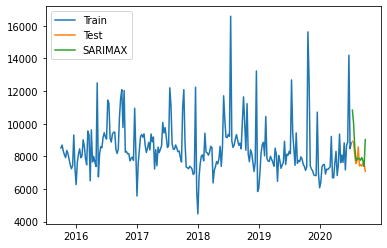

Current product:  9860
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18324D+00    |proj g|=  1.41260D-01


 This problem is unconstrained.



At iterate    5    f=  9.15336D+00    |proj g|=  2.92333D-03

At iterate   10    f=  9.15332D+00    |proj g|=  1.20385D-04

At iterate   15    f=  9.15329D+00    |proj g|=  3.02589D-03

At iterate   20    f=  9.14956D+00    |proj g|=  4.41590D-02

At iterate   25    f=  9.12151D+00    |proj g|=  6.87377D-03

At iterate   30    f=  9.12132D+00    |proj g|=  9.30288D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     35      1     0     0   1.930D-06   9.121D+00
  F =   9.1213188262675882     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  3612.6189612342146
Current parameter:  [(1, 

 This problem is unconstrained.



At iterate    5    f=  9.23682D+00    |proj g|=  1.23295D-02

At iterate   10    f=  9.23651D+00    |proj g|=  3.27366D-04

At iterate   15    f=  9.23633D+00    |proj g|=  5.76999D-03

At iterate   20    f=  9.22257D+00    |proj g|=  4.65484D-02

At iterate   25    f=  9.21846D+00    |proj g|=  1.41318D-03

At iterate   30    f=  9.21751D+00    |proj g|=  1.13782D-02

At iterate   35    f=  9.21677D+00    |proj g|=  1.09265D-03

At iterate   40    f=  9.21666D+00    |proj g|=  2.82865D-04

At iterate   45    f=  9.21664D+00    |proj g|=  2.47798D-04

At iterate   50    f=  9.21178D+00    |proj g|=  3.22992D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25014D+00    |proj g|=  6.21700D-02

At iterate    5    f=  9.24631D+00    |proj g|=  8.34365D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   8.344D-05   9.246D+00
  F =   9.2463052728465129     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  3920.6228782455128
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.


rmse:  4281.134257756963
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17127D+00    |proj g|=  7.60282D-02

At iterate    5    f=  9.16251D+00    |proj g|=  6.55770D-03

At iterate   10    f=  9.16244D+00    |proj g|=  4.81943D-04

At iterate   15    f=  9.16224D+00    |proj g|=  1.03389D-02

At iterate   20    f=  9.14605D+00    |proj g|=  7.28570D-02

At iterate   25    f=  9.13619D+00    |proj g|=  2.52873D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  9.16784D+00    |proj g|=  9.21398D-03

At iterate   10    f=  9.16766D+00    |proj g|=  3.80316D-04

At iterate   15    f=  9.16744D+00    |proj g|=  9.00789D-03

At iterate   20    f=  9.14900D+00    |proj g|=  7.20689D-02

At iterate   25    f=  9.13550D+00    |proj g|=  3.43416D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     32      1     0     0   4.150D-06   9.135D+00
  F =   9.1354895137466485     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  3674.5863576460574
Current parameter:  [(1, 1, 2), (1, 1, 2, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22528D+00    |proj g|=  2.82917D-01

At iterate    5    f=  9.14742D+00    |proj g|=  9.76043D-03

At iterate   10    f=  9.14510D+00    |proj g|=  7.07744D-04

At iterate   15    f=  9.14510D+00    |proj g|=  2.86919D-04

At iterate   20    f=  9.14510D+00    |proj g|=  3.71390D-04

At iterate   25    f=  9.14502D+00    |proj g|=  3.80501D-03

At iterate   30    f=  9.14336D+00    |proj g|=  7.86327D-03

At iterate   35    f=  9.11834D+00    |proj g|=  5.42712D-03

At iterate   40    f=  9.11726D+00    |proj g|=  7.38937D-04

At iterate   45    f=  9.11725D+00    |proj g|=  4.73758D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24999D+00    |proj g|=  2.74070D-01

At iterate    5    f=  9.17097D+00    |proj g|=  1.14246D-02

At iterate   10    f=  9.16749D+00    |proj g|=  1.25715D-03

At iterate   15    f=  9.16747D+00    |proj g|=  1.20909D-04

At iterate   20    f=  9.16746D+00    |proj g|=  1.50561D-03

At iterate   25    f=  9.16622D+00    |proj g|=  1.83695D-02

At iterate   30    f=  9.14047D+00    |proj g|=  2.85106D-02

At iterate   35    f=  9.13359D+00    |proj g|=  7.95216D-03

At iterate   40    f=  9.13269D+00    |proj g|=  5.68736D-04

At iterate   45    f=  9.13135D+00    |proj g|=  7.08405D-03

At iterate   50    f=  9.13058D+00    |proj g|=  5.23870D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.17120D+00    |proj g|=  1.03310D-02

At iterate   10    f=  9.16590D+00    |proj g|=  2.10429D-03

At iterate   15    f=  9.16578D+00    |proj g|=  1.21247D-04

At iterate   20    f=  9.16577D+00    |proj g|=  8.06378D-04

At iterate   25    f=  9.16507D+00    |proj g|=  1.22796D-02

At iterate   30    f=  9.14230D+00    |proj g|=  1.58574D-02

At iterate   35    f=  9.13510D+00    |proj g|=  4.30729D-03

At iterate   40    f=  9.13063D+00    |proj g|=  2.84134D-02

At iterate   45    f=  9.12894D+00    |proj g|=  1.52074D-03

At iterate   50    f=  9.12888D+00    |proj g|=  1.28694D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.23879D+00    |proj g|=  4.53132D-03

At iterate   10    f=  9.23765D+00    |proj g|=  8.20872D-04

At iterate   15    f=  9.23765D+00    |proj g|=  2.53566D-04

At iterate   20    f=  9.23758D+00    |proj g|=  4.27842D-03

At iterate   25    f=  9.22124D+00    |proj g|=  1.02400D-02

At iterate   30    f=  9.21541D+00    |proj g|=  5.29425D-03

At iterate   35    f=  9.21104D+00    |proj g|=  1.74533D-02

At iterate   40    f=  9.21050D+00    |proj g|=  1.89595D-04

At iterate   45    f=  9.21045D+00    |proj g|=  1.84971D-03

At iterate   50    f=  9.21042D+00    |proj g|=  1.29438D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.16108D+00    |proj g|=  4.33183D-03

At iterate   10    f=  9.16071D+00    |proj g|=  3.47232D-04

At iterate   15    f=  9.16071D+00    |proj g|=  1.19118D-04

At iterate   20    f=  9.16070D+00    |proj g|=  1.90492D-03

At iterate   25    f=  9.15938D+00    |proj g|=  1.95304D-02

At iterate   30    f=  9.13047D+00    |proj g|=  1.15984D-02

At iterate   35    f=  9.12810D+00    |proj g|=  2.66063D-02

At iterate   40    f=  9.12653D+00    |proj g|=  7.88019D-03

At iterate   45    f=  9.12628D+00    |proj g|=  3.63683D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     60   

 This problem is unconstrained.



At iterate    5    f=  9.15002D+00    |proj g|=  1.18726D-02

At iterate   10    f=  9.14970D+00    |proj g|=  3.78752D-04

At iterate   15    f=  9.14969D+00    |proj g|=  5.44033D-04

At iterate   20    f=  9.14942D+00    |proj g|=  1.04047D-02

At iterate   25    f=  9.13019D+00    |proj g|=  9.55097D-02

At iterate   30    f=  9.11736D+00    |proj g|=  3.45741D-03

At iterate   35    f=  9.11719D+00    |proj g|=  4.54115D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     38      1     0     0   2.925D-05   9.117D+00
  F =   9.1171943644670002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16713D+00    |proj g|=  7.31833D-02

At iterate    5    f=  9.15977D+00    |proj g|=  4.93061D-03

At iterate   10    f=  9.15971D+00    |proj g|=  1.10911D-04

At iterate   15    f=  9.15969D+00    |proj g|=  2.75888D-03

At iterate   20    f=  9.14866D+00    |proj g|=  6.67326D-02

At iterate   25    f=  9.13352D+00    |proj g|=  1.24334D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     33      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22528D+00    |proj g|=  2.82917D-01

At iterate    5    f=  9.14557D+00    |proj g|=  1.58751D-02

At iterate   10    f=  9.14268D+00    |proj g|=  5.85781D-04

At iterate   15    f=  9.14266D+00    |proj g|=  1.50657D-04

At iterate   20    f=  9.14266D+00    |proj g|=  1.78825D-04

At iterate   25    f=  9.14259D+00    |proj g|=  3.97791D-03

At iterate   30    f=  9.13594D+00    |proj g|=  2.21866D-02

At iterate   35    f=  9.11808D+00    |proj g|=  8.62595D-03

At iterate   40    f=  9.11520D+00    |proj g|=  4.63160D-03

At iterate   45    f=  9.11510D+00    |proj g|=  6.56176D-05

At iterate   50    f=  9.11510D+00    |proj g|=  1.57151D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.14873D+00    |proj g|=  5.58243D-03

At iterate   10    f=  9.14777D+00    |proj g|=  9.68594D-05

At iterate   15    f=  9.14775D+00    |proj g|=  1.79385D-03

At iterate   20    f=  9.14508D+00    |proj g|=  4.40519D-02

At iterate   25    f=  9.12987D+00    |proj g|=  8.22955D-03

At iterate   30    f=  9.12980D+00    |proj g|=  1.13986D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     36      1     0     0   1.567D-06   9.130D+00
  F =   9.1298020245122320     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  3708.6099398140996
Current parameter:  [(0, 

 This problem is unconstrained.



At iterate    5    f=  9.16510D+00    |proj g|=  3.69426D-03

At iterate   10    f=  9.16503D+00    |proj g|=  1.69568D-04

At iterate   15    f=  9.16497D+00    |proj g|=  2.31948D-03

At iterate   20    f=  9.15595D+00    |proj g|=  2.81603D-02

At iterate   25    f=  9.13356D+00    |proj g|=  7.77142D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     31      1     0     0   4.031D-06   9.134D+00
  F =   9.1335528115962710     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  3667.7224405618
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           

 This problem is unconstrained.



At iterate    5    f=  9.17097D+00    |proj g|=  1.14246D-02

At iterate   10    f=  9.16749D+00    |proj g|=  1.25715D-03

At iterate   15    f=  9.16747D+00    |proj g|=  1.20909D-04

At iterate   20    f=  9.16746D+00    |proj g|=  1.50561D-03

At iterate   25    f=  9.16622D+00    |proj g|=  1.83695D-02

At iterate   30    f=  9.14047D+00    |proj g|=  2.85106D-02

At iterate   35    f=  9.13359D+00    |proj g|=  7.95216D-03

At iterate   40    f=  9.13269D+00    |proj g|=  5.68736D-04

At iterate   45    f=  9.13135D+00    |proj g|=  7.08405D-03

At iterate   50    f=  9.13058D+00    |proj g|=  5.23870D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

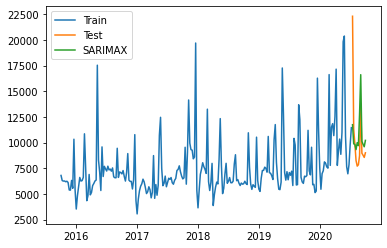

Total RMSE of top 10 selling products:  17546.184247548026 , total mape:  112.41696468310488


In [131]:
main_method(topProd,horizons,params)


selected products:  [14238, 14288, 14542, 10002, 10197, 16408, 16527, 14563, 9541]
selected horizon:  3
Current product:  14238
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.25919D+00    |proj g|=  6.91609D-02
  ys=-3.675E-01  -gs= 1.436E-01 BFGS update SKIPPED

At iterate    5    f=  5.80073D+00    |proj g|=  1.06702D-01

At iterate   10    f=  5.79321D+00    |proj g|=  1.10487D-02

At iterate   15    f=  5.78755D+00    |proj g|=  1.37716D-01

At iterate   20    f=  5.78728D+00    |proj g|=  4.62338D-02

At iterate   25    f=  5.77362D+00    |proj g|=  2.78752D-01

At iterate   30    f=  5.77345D+00    |proj g|=  6.48136D-03

At iterate   35    f=  5.77345D+00    |proj g|=  3.28081D-02

At iterate   40    f=  5.76476D+00    |proj g|=  5.02558D-01

At iterate   45    f=  5.76241D+00    |proj g|=  2.43984D-01

At iterate   50    f=  5.76172D+00    |proj g|=  3.75656D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.



At iterate    5    f=  5.85492D+00    |proj g|=  6.37624D-02

At iterate   10    f=  5.85309D+00    |proj g|=  4.95511D-02

At iterate   15    f=  5.85254D+00    |proj g|=  4.58960D-02

At iterate   20    f=  5.83870D+00    |proj g|=  3.79305D-01

At iterate   25    f=  5.83069D+00    |proj g|=  1.08634D-02

At iterate   30    f=  5.83041D+00    |proj g|=  1.37001D-04

At iterate   35    f=  5.83041D+00    |proj g|=  6.05320D-04

At iterate   40    f=  5.83032D+00    |proj g|=  1.88383D-02

At iterate   45    f=  5.82905D+00    |proj g|=  8.87877D-03

At iterate   50    f=  5.82866D+00    |proj g|=  2.25442D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15330D+00    |proj g|=  2.65744D-01

At iterate    5    f=  5.90997D+00    |proj g|=  1.41441D-03

At iterate   10    f=  5.90857D+00    |proj g|=  2.29878D-02

At iterate   15    f=  5.90771D+00    |proj g|=  2.80934D-04

At iterate   20    f=  5.90743D+00    |proj g|=  1.18438D-02

At iterate   25    f=  5.90227D+00    |proj g|=  2.14032D-02

At iterate   30    f=  5.90075D+00    |proj g|=  3.92718D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     51      1     0     0   3.927D-05   5.901D+00
  F =   5.9007475057092496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  40.25726950821314
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.84104D+00    |proj g|=  5.80636D-04


 This problem is unconstrained.



At iterate    5    f=  5.84103D+00    |proj g|=  2.10602D-03

At iterate   10    f=  5.84023D+00    |proj g|=  2.65214D-02

At iterate   15    f=  5.83341D+00    |proj g|=  5.57297D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     21      1     0     0   4.153D-06   5.833D+00
  F =   5.8333677956210712     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  42.71467242609019
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11982D+00    |proj g|=  2.59377D-01

At iterate    5    f=  5.84740D+00    |proj g|=  3.97304D-02

At iterate   10    f=  5.83434D+00    |proj g|=  5.43899D-02

At iterate   15    f=  5.83417D+00    |proj g|=  5.08486D-03

At iterate   20    f=  5.83344D+00    |proj g|=  4.08222D-02

At iterate   25    f=  5.83139D+00    |proj g|=  5.18596D-03

At iterate   30    f=  5.83137D+00    |proj g|=  1.01537D-02

At iterate   35    f=  5.83119D+00    |proj g|=  1.55575D-01

At iterate   40    f=  5.82358D+00    |proj g|=  2.73281D-01

At iterate   45    f=  5.81983D+00    |proj g|=  1.07525D-02

At iterate   50    f=  5.81929D+00    |proj g|=  1.61883D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.32389D+00    |proj g|=  2.52595D-02

At iterate   10    f=  6.31664D+00    |proj g|=  7.56866D-02

At iterate   15    f=  6.31621D+00    |proj g|=  6.61635D-02

At iterate   20    f=  6.30952D+00    |proj g|=  3.90892D-02

At iterate   25    f=  6.30311D+00    |proj g|=  7.76971D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     38      1     0     0   2.443D-04   6.303D+00
  F =   6.3030389511900857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  20.01694275356542
Current parameter:  [(1, 1, 2), (1, 1, 2, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.39060D+00    |proj g|=  2.36342D-01

At iterate    5    f=  6.32283D+00    |proj g|=  5.89100D-03

At iterate   10    f=  6.31758D+00    |proj g|=  1.34011D-02

At iterate   15    f=  6.31514D+00    |proj g|=  1.06898D-02

At iterate   20    f=  6.30848D+00    |proj g|=  6.47289D-03

At iterate   25    f=  6.30193D+00    |proj g|=  7.43663D-03

At iterate   30    f=  6.30044D+00    |proj g|=  6.53581D-04

At iterate   35    f=  6.30043D+00    |proj g|=  5.10472D-04

At iterate   40    f=  6.30004D+00    |proj g|=  1.00463D-02

At iterate   45    f=  6.29515D+00    |proj g|=  5.95550D-03

At iterate   50    f=  6.29433D+00    |proj g|=  5.20758D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.31916D+00    |proj g|=  1.27137D-02

At iterate   10    f=  6.31351D+00    |proj g|=  6.83517D-03

At iterate   15    f=  6.30596D+00    |proj g|=  5.56589D-03

At iterate   20    f=  6.29369D+00    |proj g|=  2.97083D-02

At iterate   25    f=  6.28846D+00    |proj g|=  3.05440D-03

At iterate   30    f=  6.28842D+00    |proj g|=  2.11026D-03

At iterate   35    f=  6.28803D+00    |proj g|=  2.51171D-03

At iterate   40    f=  6.28476D+00    |proj g|=  1.16543D-02

At iterate   45    f=  6.28271D+00    |proj g|=  1.98443D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     60   

 This problem is unconstrained.



At iterate    5    f=  6.32449D+00    |proj g|=  3.22928D-02

At iterate   10    f=  6.31986D+00    |proj g|=  5.81764D-02

At iterate   15    f=  6.31607D+00    |proj g|=  6.97902D-02

At iterate   20    f=  6.31507D+00    |proj g|=  7.60421D-02

At iterate   25    f=  6.31438D+00    |proj g|=  5.42580D-02

At iterate   30    f=  6.31430D+00    |proj g|=  4.14890D-03

At iterate   35    f=  6.30883D+00    |proj g|=  2.85144D-01

At iterate   40    f=  6.29566D+00    |proj g|=  1.24353D-01

At iterate   45    f=  6.29165D+00    |proj g|=  1.97472D-01

At iterate   50    f=  6.28963D+00    |proj g|=  3.37015D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.35119D+00    |proj g|=  5.86013D-03

At iterate   10    f=  6.34924D+00    |proj g|=  1.18815D-02

At iterate   15    f=  6.32895D+00    |proj g|=  8.03822D-03

At iterate   20    f=  6.32875D+00    |proj g|=  4.41730D-04

At iterate   25    f=  6.32861D+00    |proj g|=  1.77028D-03

At iterate   30    f=  6.32852D+00    |proj g|=  1.69378D-03

At iterate   35    f=  6.32738D+00    |proj g|=  5.79264D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     43      1     0     0   4.069D-06   6.327D+00
  F =   6.3272276944937014     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.56682D+00    |proj g|=  5.92025D-01

At iterate    5    f=  6.34217D+00    |proj g|=  1.05633D-01

At iterate   10    f=  6.32312D+00    |proj g|=  1.09922D-02

At iterate   15    f=  6.31497D+00    |proj g|=  2.00261D-02

At iterate   20    f=  6.31270D+00    |proj g|=  2.09858D-02

At iterate   25    f=  6.31179D+00    |proj g|=  1.67365D-02

At iterate   30    f=  6.30362D+00    |proj g|=  1.84453D-01

At iterate   35    f=  6.30222D+00    |proj g|=  2.06504D-02

At iterate   40    f=  6.30148D+00    |proj g|=  1.30602D-03

At iterate   45    f=  6.30146D+00    |proj g|=  3.38985D-02

At iterate   50    f=  6.29771D+00    |proj g|=  1.80960D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


  ys=-1.705E-01  -gs= 1.054E-01 BFGS update SKIPPED

At iterate    5    f=  5.86249D+00    |proj g|=  4.43542D-01

At iterate   10    f=  5.80492D+00    |proj g|=  7.29829D-02

At iterate   15    f=  5.78928D+00    |proj g|=  4.03542D-01

At iterate   20    f=  5.78786D+00    |proj g|=  4.29610D-02

At iterate   25    f=  5.78768D+00    |proj g|=  1.63304D-02

At iterate   30    f=  5.78348D+00    |proj g|=  1.60602D-01

At iterate   35    f=  5.76005D+00    |proj g|=  1.36485D-02

At iterate   40    f=  5.75976D+00    |proj g|=  1.67402D-02

At iterate   45    f=  5.75926D+00    |proj g|=  4.74480D-02

At iterate   50    f=  5.75911D+00    |proj g|=  4.29955D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.12639D+00    |proj g|=  2.57430D-01

At iterate    5    f=  5.87515D+00    |proj g|=  2.71659D-02

At iterate   10    f=  5.84855D+00    |proj g|=  2.51292D-01

At iterate   15    f=  5.84132D+00    |proj g|=  2.12640D-02

At iterate   20    f=  5.84127D+00    |proj g|=  1.82707D-03

At iterate   25    f=  5.84107D+00    |proj g|=  4.82683D-02

At iterate   30    f=  5.83871D+00    |proj g|=  1.91111D-02

At iterate   35    f=  5.83857D+00    |proj g|=  3.33907D-04

At iterate   40    f=  5.83856D+00    |proj g|=  8.07581D-03

At iterate   45    f=  5.83796D+00    |proj g|=  5.61273D-02

At iterate   50    f=  5.82892D+00    |proj g|=  4.12243D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.32792D+00    |proj g|=  3.24154D-02

At iterate   10    f=  6.32392D+00    |proj g|=  2.33522D-02

At iterate   15    f=  6.32248D+00    |proj g|=  1.10364D-02

At iterate   20    f=  6.31762D+00    |proj g|=  2.51877D-02

At iterate   25    f=  6.31748D+00    |proj g|=  2.31114D-02

At iterate   30    f=  6.31726D+00    |proj g|=  2.04453D-02

At iterate   35    f=  6.31698D+00    |proj g|=  5.84978D-03

At iterate   40    f=  6.31579D+00    |proj g|=  2.04054D-02

At iterate   45    f=  6.30937D+00    |proj g|=  2.76068D-01

At iterate   50    f=  6.30119D+00    |proj g|=  5.73654D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.84917D+00    |proj g|=  4.65258D-02

At iterate   10    f=  5.83441D+00    |proj g|=  4.29997D-01

At iterate   15    f=  5.83075D+00    |proj g|=  5.34738D-03

At iterate   20    f=  5.83066D+00    |proj g|=  1.84162D-03

At iterate   25    f=  5.83063D+00    |proj g|=  3.90643D-02

At iterate   30    f=  5.83031D+00    |proj g|=  9.91181D-02

At iterate   35    f=  5.83009D+00    |proj g|=  4.07550D-04

At iterate   40    f=  5.83009D+00    |proj g|=  3.74431D-03

At iterate   45    f=  5.82911D+00    |proj g|=  5.40921D-02

At iterate   50    f=  5.82078D+00    |proj g|=  2.17375D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.25309D+00    |proj g|=  6.76714D-02
  ys=-9.033E-01  -gs= 1.113E-01 BFGS update SKIPPED

At iterate    5    f=  5.82390D+00    |proj g|=  4.00675D-01

At iterate   10    f=  5.79782D+00    |proj g|=  4.95112D-03

At iterate   15    f=  5.79739D+00    |proj g|=  8.45707D-02

At iterate   20    f=  5.79347D+00    |proj g|=  4.87919D-02

At iterate   25    f=  5.79185D+00    |proj g|=  1.62212D-01

At iterate   30    f=  5.77496D+00    |proj g|=  3.35575D-01

At iterate   35    f=  5.77110D+00    |proj g|=  5.46197D-04

At iterate   40    f=  5.77096D+00    |proj g|=  2.10248D-02

At iterate   45    f=  5.76682D+00    |proj g|=  5.65622D-02

At iterate   50    f=  5.76133D+00    |proj g|=  8.79009D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.



At iterate    5    f=  6.32283D+00    |proj g|=  5.89100D-03

At iterate   10    f=  6.31758D+00    |proj g|=  1.34011D-02

At iterate   15    f=  6.31514D+00    |proj g|=  1.06898D-02

At iterate   20    f=  6.30848D+00    |proj g|=  6.47289D-03

At iterate   25    f=  6.30193D+00    |proj g|=  7.43663D-03

At iterate   30    f=  6.30044D+00    |proj g|=  6.53581D-04

At iterate   35    f=  6.30043D+00    |proj g|=  5.10472D-04

At iterate   40    f=  6.30004D+00    |proj g|=  1.00463D-02

At iterate   45    f=  6.29515D+00    |proj g|=  5.95550D-03

At iterate   50    f=  6.29433D+00    |proj g|=  5.20758D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

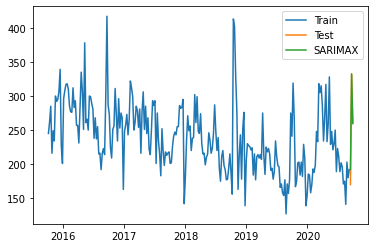

Current product:  14288
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50336D+00    |proj g|=  7.02503D-02

At iterate    5    f=  6.14548D+00    |proj g|=  3.42594D-02

At iterate   10    f=  6.14008D+00    |proj g|=  1.77296D-02

At iterate   15    f=  6.13943D+00    |proj g|=  2.97143D-02

At iterate   20    f=  6.13019D+00    |proj g|=  1.78725D-01

At iterate   25    f=  6.10188D+00    |proj g|=  4.53117D-02

At iterate   30    f=  6.10077D+00    |proj g|=  9.49238D-04

At iterate   35    f=  6.10074D+00    |proj g|=  5.67098D-03

At iterate   40    f=  6.10016D+00    |proj g|=  1.82246D-02

At iterate   45    f=  6.09561D+00    |proj g|=  5.31702D-02

At iterate   50    f=  6.07828D+00    |proj g|=  1.25502D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.16236D+00    |proj g|=  3.35678D-02

At iterate   10    f=  6.16217D+00    |proj g|=  3.07735D-03

At iterate   15    f=  6.15866D+00    |proj g|=  1.27906D-01

At iterate   20    f=  6.12905D+00    |proj g|=  2.04256D-02

At iterate   25    f=  6.12848D+00    |proj g|=  1.26645D-04

At iterate   30    f=  6.12846D+00    |proj g|=  7.19430D-03

At iterate   35    f=  6.12649D+00    |proj g|=  1.01242D-01

At iterate   40    f=  6.11964D+00    |proj g|=  1.33078D-02

At iterate   45    f=  6.11907D+00    |proj g|=  4.22602D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     60   

 This problem is unconstrained.



At iterate    5    f=  6.20095D+00    |proj g|=  1.88100D-03

At iterate   10    f=  6.19758D+00    |proj g|=  1.40196D-01

At iterate   15    f=  6.19149D+00    |proj g|=  7.53661D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     21      1     0     0   7.011D-05   6.191D+00
  F =   6.1914857663939271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  21.517278583354308
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the boun

 This problem is unconstrained.



At iterate    5    f=  6.15249D+00    |proj g|=  2.09502D-03

At iterate   10    f=  6.15204D+00    |proj g|=  1.65966D-02

At iterate   15    f=  6.15172D+00    |proj g|=  2.27304D-03

At iterate   20    f=  6.15035D+00    |proj g|=  2.64088D-02

At iterate   25    f=  6.13786D+00    |proj g|=  6.46025D-03

At iterate   30    f=  6.13726D+00    |proj g|=  2.54552D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     34      1     0     0   2.546D-07   6.137D+00
  F =   6.1372619388266338     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  18.203203061944823
Current parameter:  [(1, 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.31623D+00    |proj g|=  3.18086D-01

At iterate    5    f=  6.17713D+00    |proj g|=  1.40383D-02

At iterate   10    f=  6.17583D+00    |proj g|=  2.18447D-03

At iterate   15    f=  6.17511D+00    |proj g|=  7.84898D-02

At iterate   20    f=  6.16383D+00    |proj g|=  5.14030D-02

At iterate   25    f=  6.16318D+00    |proj g|=  3.26571D-03

At iterate   30    f=  6.16317D+00    |proj g|=  1.51623D-03

At iterate   35    f=  6.16315D+00    |proj g|=  1.83674D-02

At iterate   40    f=  6.16264D+00    |proj g|=  2.23745D-02

At iterate   45    f=  6.16251D+00    |proj g|=  1.56915D-02

At iterate   50    f=  6.15688D+00    |proj g|=  1.31982D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.57089D+00    |proj g|=  3.42359D-01

At iterate   10    f=  6.55495D+00    |proj g|=  7.46331D-03

At iterate   15    f=  6.55471D+00    |proj g|=  2.35244D-02

At iterate   20    f=  6.54791D+00    |proj g|=  2.49753D-02

At iterate   25    f=  6.54559D+00    |proj g|=  2.49001D-02

At iterate   30    f=  6.53622D+00    |proj g|=  4.64115D-02

At iterate   35    f=  6.53466D+00    |proj g|=  6.65917D-02

At iterate   40    f=  6.53396D+00    |proj g|=  3.57564D-03

At iterate   45    f=  6.53396D+00    |proj g|=  3.89839D-03

At iterate   50    f=  6.53385D+00    |proj g|=  6.54088D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.54226D+00    |proj g|=  3.57453D-03

At iterate   10    f=  6.53170D+00    |proj g|=  3.37326D-02

At iterate   15    f=  6.49275D+00    |proj g|=  9.46045D-03

At iterate   20    f=  6.49100D+00    |proj g|=  1.00484D-02

At iterate   25    f=  6.49051D+00    |proj g|=  4.02676D-03

At iterate   30    f=  6.49025D+00    |proj g|=  6.98989D-03

At iterate   35    f=  6.49017D+00    |proj g|=  1.74828D-03

At iterate   40    f=  6.49013D+00    |proj g|=  3.19630D-04

At iterate   45    f=  6.49009D+00    |proj g|=  1.31855D-04

At iterate   50    f=  6.48994D+00    |proj g|=  4.91355D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60190D+00    |proj g|=  2.11762D-01

At iterate    5    f=  6.54201D+00    |proj g|=  3.52511D-03

At iterate   10    f=  6.52807D+00    |proj g|=  4.66489D-02

At iterate   15    f=  6.50040D+00    |proj g|=  1.41230D-02

At iterate   20    f=  6.49297D+00    |proj g|=  2.84598D-03

At iterate   25    f=  6.49295D+00    |proj g|=  6.68786D-04

At iterate   30    f=  6.49288D+00    |proj g|=  4.18801D-03

At iterate   35    f=  6.49282D+00    |proj g|=  2.28487D-03

At iterate   40    f=  6.49224D+00    |proj g|=  4.93523D-03

At iterate   45    f=  6.48089D+00    |proj g|=  2.59660D-02

At iterate   50    f=  6.47648D+00    |proj g|=  4.60644D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60190D+00    |proj g|=  2.11762D-01

At iterate    5    f=  6.54439D+00    |proj g|=  1.11198D-01

At iterate   10    f=  6.54207D+00    |proj g|=  3.52585D-03

At iterate   15    f=  6.54164D+00    |proj g|=  2.74373D-02

At iterate   20    f=  6.51580D+00    |proj g|=  1.99198D-01

At iterate   25    f=  6.50094D+00    |proj g|=  1.86889D-02

At iterate   30    f=  6.49458D+00    |proj g|=  2.44209D-02

At iterate   35    f=  6.49309D+00    |proj g|=  1.03932D-02

At iterate   40    f=  6.49284D+00    |proj g|=  4.41488D-03

At iterate   45    f=  6.49272D+00    |proj g|=  3.58502D-03

At iterate   50    f=  6.49268D+00    |proj g|=  3.25232D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.54481D+00    |proj g|=  4.46191D-03

At iterate   10    f=  6.52684D+00    |proj g|=  4.05144D-02

At iterate   15    f=  6.50128D+00    |proj g|=  2.51616D-03

At iterate   20    f=  6.50127D+00    |proj g|=  3.64183D-04

At iterate   25    f=  6.50124D+00    |proj g|=  3.19077D-03

At iterate   30    f=  6.50122D+00    |proj g|=  1.30088D-03

At iterate   35    f=  6.50119D+00    |proj g|=  1.29715D-03

At iterate   40    f=  6.50086D+00    |proj g|=  4.85701D-03

At iterate   45    f=  6.50057D+00    |proj g|=  4.46424D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     56   

 This problem is unconstrained.



At iterate    5    f=  6.57903D+00    |proj g|=  1.16848D-01

At iterate   10    f=  6.54293D+00    |proj g|=  3.56880D-02

At iterate   15    f=  6.54234D+00    |proj g|=  1.70039D-02

At iterate   20    f=  6.53763D+00    |proj g|=  6.04038D-03

At iterate   25    f=  6.53743D+00    |proj g|=  9.71858D-03

At iterate   30    f=  6.53343D+00    |proj g|=  7.61513D-02

At iterate   35    f=  6.49467D+00    |proj g|=  2.95220D-02

At iterate   40    f=  6.49029D+00    |proj g|=  1.80734D-02

At iterate   45    f=  6.48951D+00    |proj g|=  1.88692D-03

At iterate   50    f=  6.48933D+00    |proj g|=  3.07038D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51303D+00    |proj g|=  8.23108D-02

At iterate    5    f=  6.17592D+00    |proj g|=  1.48465D-01

At iterate   10    f=  6.14693D+00    |proj g|=  1.17069D-02

At iterate   15    f=  6.14255D+00    |proj g|=  4.46170D-02

At iterate   20    f=  6.13708D+00    |proj g|=  8.70824D-03

At iterate   25    f=  6.13563D+00    |proj g|=  3.02316D-02

At iterate   30    f=  6.11451D+00    |proj g|=  2.76446D-01

At iterate   35    f=  6.10396D+00    |proj g|=  1.61359D-02

At iterate   40    f=  6.10102D+00    |proj g|=  5.59236D-03

At iterate   45    f=  6.10074D+00    |proj g|=  2.40153D-04

At iterate   50    f=  6.10072D+00    |proj g|=  1.50782D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.18731D+00    |proj g|=  2.76684D-02

At iterate   10    f=  6.17985D+00    |proj g|=  4.18765D-02

At iterate   15    f=  6.17777D+00    |proj g|=  2.55836D-02

At iterate   20    f=  6.17762D+00    |proj g|=  7.63305D-03

At iterate   25    f=  6.17292D+00    |proj g|=  8.34509D-02

At iterate   30    f=  6.16652D+00    |proj g|=  2.23892D-03

At iterate   35    f=  6.16651D+00    |proj g|=  8.60114D-04

At iterate   40    f=  6.16650D+00    |proj g|=  1.13168D-03

At iterate   45    f=  6.16486D+00    |proj g|=  2.10661D-02

At iterate   50    f=  6.14868D+00    |proj g|=  4.74315D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60317D+00    |proj g|=  2.00763D-01

At iterate    5    f=  6.54684D+00    |proj g|=  2.91780D-02

At iterate   10    f=  6.54196D+00    |proj g|=  3.89944D-03

At iterate   15    f=  6.52695D+00    |proj g|=  2.94952D-01

At iterate   20    f=  6.49055D+00    |proj g|=  5.99901D-02

At iterate   25    f=  6.48989D+00    |proj g|=  6.46651D-03

At iterate   30    f=  6.48936D+00    |proj g|=  1.94492D-03

At iterate   35    f=  6.48918D+00    |proj g|=  1.17422D-02

At iterate   40    f=  6.48889D+00    |proj g|=  2.17464D-03

At iterate   45    f=  6.48881D+00    |proj g|=  8.65767D-03

At iterate   50    f=  6.48873D+00    |proj g|=  9.54842D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.31196D+00    |proj g|=  3.31035D-01

At iterate    5    f=  6.16578D+00    |proj g|=  2.41877D-02

At iterate   10    f=  6.16322D+00    |proj g|=  1.75860D-03

At iterate   15    f=  6.16167D+00    |proj g|=  2.31153D-02

At iterate   20    f=  6.15467D+00    |proj g|=  1.81960D-02

At iterate   25    f=  6.15464D+00    |proj g|=  2.10071D-04

At iterate   30    f=  6.15463D+00    |proj g|=  4.76011D-03

At iterate   35    f=  6.15408D+00    |proj g|=  2.20623D-02

At iterate   40    f=  6.15072D+00    |proj g|=  3.07147D-02

At iterate   45    f=  6.14914D+00    |proj g|=  7.07283D-02

At iterate   50    f=  6.13520D+00    |proj g|=  3.18374D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50648D+00    |proj g|=  7.14187D-02

At iterate    5    f=  6.15016D+00    |proj g|=  3.54085D-03

At iterate   10    f=  6.14948D+00    |proj g|=  4.60516D-02

At iterate   15    f=  6.12795D+00    |proj g|=  3.05471D-01

At iterate   20    f=  6.10369D+00    |proj g|=  5.05595D-02

At iterate   25    f=  6.10356D+00    |proj g|=  2.69104D-04

At iterate   30    f=  6.10355D+00    |proj g|=  1.23601D-02

At iterate   35    f=  6.10273D+00    |proj g|=  8.76892D-02

At iterate   40    f=  6.09429D+00    |proj g|=  3.38876D-02

At iterate   45    f=  6.06272D+00    |proj g|=  6.97731D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.61977D+00    |proj g|=  5.09092D-01

At iterate    5    f=  6.57089D+00    |proj g|=  3.42359D-01

At iterate   10    f=  6.55495D+00    |proj g|=  7.46331D-03

At iterate   15    f=  6.55471D+00    |proj g|=  2.35244D-02

At iterate   20    f=  6.54791D+00    |proj g|=  2.49753D-02

At iterate   25    f=  6.54559D+00    |proj g|=  2.49001D-02

At iterate   30    f=  6.53622D+00    |proj g|=  4.64115D-02

At iterate   35    f=  6.53466D+00    |proj g|=  6.65917D-02

At iterate   40    f=  6.53396D+00    |proj g|=  3.57564D-03

At iterate   45    f=  6.53396D+00    |proj g|=  3.89839D-03

At iterate   50    f=  6.53385D+00    |proj g|=  6.54088D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

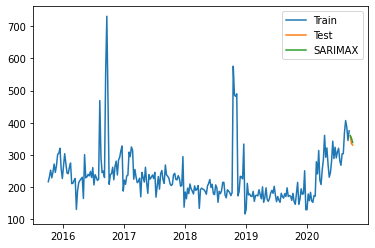

Current product:  14542
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.35411D+00    |proj g|=  4.16849D-01


 This problem is unconstrained.



At iterate    5    f=  6.18341D+00    |proj g|=  2.13668D-02

At iterate   10    f=  6.18167D+00    |proj g|=  5.50680D-03

At iterate   15    f=  6.17231D+00    |proj g|=  4.33506D-02

At iterate   20    f=  6.09144D+00    |proj g|=  1.55009D-01

At iterate   25    f=  6.06679D+00    |proj g|=  3.69135D-02

At iterate   30    f=  6.06648D+00    |proj g|=  1.85449D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     41      1     0     0   1.855D-04   6.066D+00
  F =   6.0664813765379311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  38.68868165939046
Current parameter:  [(1, 1

 This problem is unconstrained.



At iterate    5    f=  6.17733D+00    |proj g|=  4.90391D-03

At iterate   10    f=  6.14627D+00    |proj g|=  3.00014D-01

At iterate   15    f=  6.05895D+00    |proj g|=  1.36902D-02

At iterate   20    f=  6.05892D+00    |proj g|=  4.92037D-04

At iterate   25    f=  6.05892D+00    |proj g|=  1.09517D-02

At iterate   30    f=  6.05809D+00    |proj g|=  1.24149D-01

At iterate   35    f=  6.04686D+00    |proj g|=  1.17760D-01

At iterate   40    f=  6.04628D+00    |proj g|=  2.46450D-03

At iterate   45    f=  6.04611D+00    |proj g|=  4.32602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     61   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18274D+00    |proj g|=  3.08576D-01

At iterate    5    f=  6.17840D+00    |proj g|=  2.10608D-02

At iterate   10    f=  6.17793D+00    |proj g|=  6.22119D-02

At iterate   15    f=  6.14961D+00    |proj g|=  4.97742D-01

At iterate   20    f=  6.07030D+00    |proj g|=  3.35392D-02

At iterate   25    f=  6.06990D+00    |proj g|=  2.15020D-04

At iterate   30    f=  6.06963D+00    |proj g|=  2.17942D-02

At iterate   35    f=  6.06244D+00    |proj g|=  6.50796D-02

At iterate   40    f=  6.05478D+00    |proj g|=  8.16273D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.20262D+00    |proj g|=  9.51617D-04

At iterate   10    f=  6.20261D+00    |proj g|=  9.29129D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   3.680D-05   6.203D+00
  F =   6.2026068644921759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  19.366259604837367
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18002D+00    |proj g|=  2.68645D-01

At iterate    5    f=  6.17625D+00    |proj g|=  4.81841D-03

At iterate   10    f=  6.17539D+00    |proj g|=  5.34364D-02

At iterate   15    f=  6.11714D+00    |proj g|=  2.28329D-01

At iterate   20    f=  6.09322D+00    |proj g|=  8.79077D-01

At iterate   25    f=  6.06904D+00    |proj g|=  6.22450D-02

At iterate   30    f=  6.06888D+00    |proj g|=  2.53513D-04

At iterate   35    f=  6.06876D+00    |proj g|=  9.36176D-03

At iterate   40    f=  6.06061D+00    |proj g|=  2.31108D-01

At iterate   45    f=  6.05024D+00    |proj g|=  1.58176D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.53416D+00    |proj g|=  1.85629D-01

At iterate    5    f=  6.50004D+00    |proj g|=  9.10657D-03

At iterate   10    f=  6.49952D+00    |proj g|=  1.68718D-02

At iterate   15    f=  6.49629D+00    |proj g|=  2.03983D-01

At iterate   20    f=  6.48974D+00    |proj g|=  1.58933D-02

At iterate   25    f=  6.39172D+00    |proj g|=  2.40453D-01

At iterate   30    f=  6.38353D+00    |proj g|=  3.31038D-01

At iterate   35    f=  6.37572D+00    |proj g|=  1.11505D-02

At iterate   40    f=  6.28214D+00    |proj g|=  3.66647D-01

At iterate   45    f=  6.26629D+00    |proj g|=  1.00245D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.46270D+00    |proj g|=  6.94464D-03

At iterate   10    f=  6.38304D+00    |proj g|=  9.49084D-02

At iterate   15    f=  6.21487D+00    |proj g|=  4.09075D-02

At iterate   20    f=  6.18121D+00    |proj g|=  5.02374D-02

At iterate   25    f=  6.17611D+00    |proj g|=  1.55546D-03

At iterate   30    f=  6.16942D+00    |proj g|=  1.17785D-01

At iterate   35    f=  6.15842D+00    |proj g|=  1.27863D-02

At iterate   40    f=  6.15823D+00    |proj g|=  3.62235D-04

At iterate   45    f=  6.15822D+00    |proj g|=  2.52456D-03

At iterate   50    f=  6.15803D+00    |proj g|=  1.60166D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46940D+00    |proj g|=  8.04394D-02

At iterate    5    f=  6.45726D+00    |proj g|=  8.19623D-03

At iterate   10    f=  6.35492D+00    |proj g|=  3.87724D-02

At iterate   15    f=  6.28665D+00    |proj g|=  8.70933D-02

At iterate   20    f=  6.19155D+00    |proj g|=  7.86628D-02

At iterate   25    f=  6.17163D+00    |proj g|=  2.56975D-03

At iterate   30    f=  6.17162D+00    |proj g|=  4.43548D-03

At iterate   35    f=  6.17139D+00    |proj g|=  5.09880D-03

At iterate   40    f=  6.17123D+00    |proj g|=  3.99615D-03

At iterate   45    f=  6.16442D+00    |proj g|=  8.30041D-02

At iterate   50    f=  6.15960D+00    |proj g|=  1.63615D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46940D+00    |proj g|=  8.04394D-02

At iterate    5    f=  6.46150D+00    |proj g|=  8.06253D-02

At iterate   10    f=  6.45850D+00    |proj g|=  4.55614D-02

At iterate   15    f=  6.45702D+00    |proj g|=  2.82753D-02

At iterate   20    f=  6.45209D+00    |proj g|=  1.23962D-01

At iterate   25    f=  6.26529D+00    |proj g|=  2.38001D-01

At iterate   30    f=  6.23568D+00    |proj g|=  2.38144D-01

At iterate   35    f=  6.21066D+00    |proj g|=  3.07452D-01

At iterate   40    f=  6.20829D+00    |proj g|=  4.56387D-02

At iterate   45    f=  6.20634D+00    |proj g|=  7.62782D-02

At iterate   50    f=  6.16500D+00    |proj g|=  1.19906D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.49703D+00    |proj g|=  6.66485D-03

At iterate   10    f=  6.41966D+00    |proj g|=  1.23434D-01

At iterate   15    f=  6.35419D+00    |proj g|=  5.92756D-02

At iterate   20    f=  6.34781D+00    |proj g|=  1.22600D-03

At iterate   25    f=  6.34741D+00    |proj g|=  2.22277D-03

At iterate   30    f=  6.34738D+00    |proj g|=  5.67785D-04

At iterate   35    f=  6.34737D+00    |proj g|=  2.88547D-03

At iterate   40    f=  6.34673D+00    |proj g|=  3.46900D-02

At iterate   45    f=  6.33797D+00    |proj g|=  4.42308D-02

At iterate   50    f=  6.33292D+00    |proj g|=  1.33952D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.68013D+00    |proj g|=  6.02402D-01

At iterate    5    f=  6.47048D+00    |proj g|=  6.21539D-02

At iterate   10    f=  6.45867D+00    |proj g|=  3.54074D-02

At iterate   15    f=  6.45167D+00    |proj g|=  3.37750D-02

At iterate   20    f=  6.45137D+00    |proj g|=  2.08937D-02

At iterate   25    f=  6.43418D+00    |proj g|=  4.69127D-02

At iterate   30    f=  6.24972D+00    |proj g|=  2.82245D-01

At iterate   35    f=  6.17379D+00    |proj g|=  2.21322D-01

At iterate   40    f=  6.14712D+00    |proj g|=  1.22734D-02

At iterate   45    f=  6.14393D+00    |proj g|=  7.57582D-03

At iterate   50    f=  6.14381D+00    |proj g|=  7.89955D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.35937D+00    |proj g|=  4.21997D-01

At iterate    5    f=  6.18144D+00    |proj g|=  9.11184D-03

At iterate   10    f=  6.18101D+00    |proj g|=  3.78089D-02

At iterate   15    f=  6.14462D+00    |proj g|=  3.24368D-01

At iterate   20    f=  6.09388D+00    |proj g|=  4.25983D-02

At iterate   25    f=  6.07661D+00    |proj g|=  4.80255D-02

At iterate   30    f=  6.06748D+00    |proj g|=  4.47554D-02

At iterate   35    f=  6.06634D+00    |proj g|=  6.41547D-04

At iterate   40    f=  6.06634D+00    |proj g|=  3.40641D-04

At iterate   45    f=  6.06628D+00    |proj g|=  2.54755D-02

At iterate   50    f=  6.06496D+00    |proj g|=  4.16949D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.18180D+00    |proj g|=  4.84999D-03

At iterate   10    f=  6.18129D+00    |proj g|=  6.18581D-02

At iterate   15    f=  6.15036D+00    |proj g|=  1.82388D-01

At iterate   20    f=  6.09878D+00    |proj g|=  5.51838D-02

At iterate   25    f=  6.09213D+00    |proj g|=  1.52220D-01

At iterate   30    f=  6.07492D+00    |proj g|=  2.79858D-03

At iterate   35    f=  6.07491D+00    |proj g|=  3.04014D-04

At iterate   40    f=  6.07433D+00    |proj g|=  1.99378D-02

At iterate   45    f=  6.05966D+00    |proj g|=  9.03232D-02

At iterate   50    f=  6.05569D+00    |proj g|=  5.89856D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.46452D+00    |proj g|=  6.19580D-02

At iterate   10    f=  6.46322D+00    |proj g|=  1.96306D-02

At iterate   15    f=  6.45712D+00    |proj g|=  9.84573D-02

At iterate   20    f=  6.23528D+00    |proj g|=  2.01570D-01

At iterate   25    f=  6.22624D+00    |proj g|=  4.88006D-01

At iterate   30    f=  6.20855D+00    |proj g|=  1.75218D-01

At iterate   35    f=  6.20706D+00    |proj g|=  2.01263D-01

At iterate   40    f=  6.19785D+00    |proj g|=  8.30352D-02

At iterate   45    f=  6.17833D+00    |proj g|=  2.79654D-01

At iterate   50    f=  6.17721D+00    |proj g|=  6.99342D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.17560D+00    |proj g|=  2.67406D-02

At iterate   10    f=  6.17478D+00    |proj g|=  2.78648D-02

At iterate   15    f=  6.17281D+00    |proj g|=  7.23399D-02

At iterate   20    f=  6.11261D+00    |proj g|=  9.85897D-02

At iterate   25    f=  6.10971D+00    |proj g|=  5.37947D-03

At iterate   30    f=  6.08616D+00    |proj g|=  1.12474D-01

At iterate   35    f=  6.06426D+00    |proj g|=  1.02659D-02

At iterate   40    f=  6.06408D+00    |proj g|=  2.67000D-04

At iterate   45    f=  6.06407D+00    |proj g|=  5.39385D-03

At iterate   50    f=  6.06334D+00    |proj g|=  2.95587D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.18400D+00    |proj g|=  9.76745D-03

At iterate   10    f=  6.18281D+00    |proj g|=  9.76663D-02

At iterate   15    f=  6.15362D+00    |proj g|=  2.18935D-01

At iterate   20    f=  6.08235D+00    |proj g|=  1.89024D-01

At iterate   25    f=  6.06952D+00    |proj g|=  3.43343D-03

At iterate   30    f=  6.06951D+00    |proj g|=  1.88337D-03

At iterate   35    f=  6.06946D+00    |proj g|=  1.35461D-02

At iterate   40    f=  6.06667D+00    |proj g|=  3.84488D-02

At iterate   45    f=  6.05600D+00    |proj g|=  5.64897D-02

At iterate   50    f=  6.05448D+00    |proj g|=  3.53581D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.20262D+00    |proj g|=  9.51617D-04

At iterate   10    f=  6.20261D+00    |proj g|=  9.29129D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   3.680D-05   6.203D+00
  F =   6.2026068644921759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  14542
Best Configs:  [(1, 1, 0), (0, 1, 0, 52)]
Mean Absolute Error: 18.348
Mean Squared Error: 321.262
Root Mean Squared Error: 19.366
Mean absolute percentage error: 5.735
Scaled Mean absolute percentage error: 5.912
Mean fore

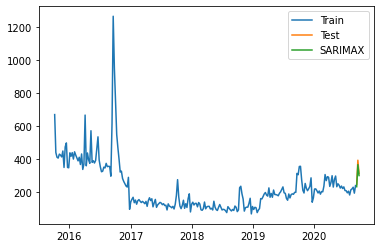

Current product:  10002
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27543D+00    |proj g|=  3.22270D-01

At iterate    5    f=  6.16789D+00    |proj g|=  9.57985D-03

At iterate   10    f=  6.16752D+00    |proj g|=  2.87910D-02

At iterate   15    f=  6.16178D+00    |proj g|=  7.24808D-02

At iterate   20    f=  6.15194D+00    |proj g|=  6.96912D-02

At iterate   25    f=  6.14411D+00    |proj g|=  1.15568D-01

At iterate   30    f=  6.13067D+00    |proj g|=  6.34699D-03

At iterate   35    f=  6.12732D+00    |proj g|=  1.50421D-02

At iterate   40    f=  6.12653D+00    |proj g|=  9.42327D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26957D+00    |proj g|=  3.30659D-01

At iterate    5    f=  6.16028D+00    |proj g|=  6.18943D-03

At iterate   10    f=  6.15966D+00    |proj g|=  1.69512D-02

At iterate   15    f=  6.13934D+00    |proj g|=  1.36937D-01

At iterate   20    f=  6.11845D+00    |proj g|=  3.75186D-03

At iterate   25    f=  6.11844D+00    |proj g|=  1.01842D-03

At iterate   30    f=  6.11841D+00    |proj g|=  1.59562D-02

At iterate   35    f=  6.11778D+00    |proj g|=  1.98140D-02

At iterate   40    f=  6.11770D+00    |proj g|=  1.91437D-03

At iterate   45    f=  6.11769D+00    |proj g|=  7.52418D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.28459D+00    |proj g|=  3.14164D-01

At iterate    5    f=  6.18623D+00    |proj g|=  9.57190D-03

At iterate   10    f=  6.18576D+00    |proj g|=  5.58457D-02

At iterate   15    f=  6.15816D+00    |proj g|=  3.20581D-01

At iterate   20    f=  6.15185D+00    |proj g|=  2.22981D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     26      1     0     0   5.730D-05   6.152D+00
  F =   6.1518480658847787     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  6.16643D+00    |proj g|=  8.89888D-04

At iterate   10    f=  6.16641D+00    |proj g|=  7.03643D-04

At iterate   15    f=  6.16641D+00    |proj g|=  3.96131D-04

At iterate   20    f=  6.16629D+00    |proj g|=  5.25611D-03

At iterate   25    f=  6.16573D+00    |proj g|=  1.04024D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     31      1     0     0   6.219D-06   6.166D+00
  F =   6.1657287109234549     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  83.81896871006055
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.28522D+00    |proj g|=  3.12958D-01

At iterate    5    f=  6.18533D+00    |proj g|=  3.26549D-03

At iterate   10    f=  6.18478D+00    |proj g|=  1.81407D-02

At iterate   15    f=  6.16970D+00    |proj g|=  1.81633D-01

At iterate   20    f=  6.15095D+00    |proj g|=  8.48525D-02

At iterate   25    f=  6.15027D+00    |proj g|=  4.28487D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     29      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.61640D+00    |proj g|=  7.07298D-01

At iterate    5    f=  6.52811D+00    |proj g|=  4.76012D-03

At iterate   10    f=  6.52665D+00    |proj g|=  1.95443D-02

At iterate   15    f=  6.50242D+00    |proj g|=  4.65761D-02

At iterate   20    f=  6.45008D+00    |proj g|=  1.43670D-01

At iterate   25    f=  6.44698D+00    |proj g|=  2.66385D-03

At iterate   30    f=  6.44573D+00    |proj g|=  2.74110D-02

At iterate   35    f=  6.44562D+00    |proj g|=  2.69166D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  6.54021D+00    |proj g|=  5.47859D-03

At iterate   10    f=  6.53596D+00    |proj g|=  1.26291D-02

At iterate   15    f=  6.52593D+00    |proj g|=  3.19959D-02

At iterate   20    f=  6.49729D+00    |proj g|=  1.77640D-02

At iterate   25    f=  6.49628D+00    |proj g|=  2.34394D-03

At iterate   30    f=  6.49623D+00    |proj g|=  6.82591D-04

At iterate   35    f=  6.49615D+00    |proj g|=  2.59973D-03

At iterate   40    f=  6.48451D+00    |proj g|=  4.01423D-02

At iterate   45    f=  6.48142D+00    |proj g|=  2.21795D-03

At iterate   50    f=  6.48137D+00    |proj g|=  7.05976D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58748D+00    |proj g|=  2.65725D-01

At iterate    5    f=  6.53735D+00    |proj g|=  3.76680D-03

At iterate   10    f=  6.53002D+00    |proj g|=  3.76340D-02

At iterate   15    f=  6.49809D+00    |proj g|=  2.30279D-02

At iterate   20    f=  6.48479D+00    |proj g|=  2.35523D-03

At iterate   25    f=  6.48271D+00    |proj g|=  2.18306D-02

At iterate   30    f=  6.47891D+00    |proj g|=  3.28737D-03

At iterate   35    f=  6.47888D+00    |proj g|=  7.80427D-05

At iterate   40    f=  6.47887D+00    |proj g|=  1.14633D-03

At iterate   45    f=  6.47854D+00    |proj g|=  3.13496D-03

At iterate   50    f=  6.47794D+00    |proj g|=  1.89641D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.53848D+00    |proj g|=  5.56982D-02

At iterate   10    f=  6.53727D+00    |proj g|=  7.37845D-03

At iterate   15    f=  6.53537D+00    |proj g|=  1.85558D-02

At iterate   20    f=  6.52410D+00    |proj g|=  3.41094D-02

At iterate   25    f=  6.48680D+00    |proj g|=  2.20527D-01

At iterate   30    f=  6.45498D+00    |proj g|=  1.94837D-02

At iterate   35    f=  6.45229D+00    |proj g|=  4.41912D-03

At iterate   40    f=  6.45205D+00    |proj g|=  3.06659D-02

At iterate   45    f=  6.45202D+00    |proj g|=  1.32662D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     54   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.57810D+00    |proj g|=  2.66430D-01

At iterate    5    f=  6.52914D+00    |proj g|=  3.74904D-03

At iterate   10    f=  6.50376D+00    |proj g|=  8.82563D-02

At iterate   15    f=  6.48014D+00    |proj g|=  9.87413D-03

At iterate   20    f=  6.47704D+00    |proj g|=  1.30257D-02

At iterate   25    f=  6.47661D+00    |proj g|=  3.81494D-04

At iterate   30    f=  6.47661D+00    |proj g|=  9.40478D-04

At iterate   35    f=  6.47597D+00    |proj g|=  1.08051D-02

At iterate   40    f=  6.47511D+00    |proj g|=  8.04397D-04

At iterate   45    f=  6.47510D+00    |proj g|=  1.40972D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.53731D+00    |proj g|=  4.06711D-02

At iterate   10    f=  6.53677D+00    |proj g|=  2.19319D-02

At iterate   15    f=  6.53339D+00    |proj g|=  2.01346D-02

At iterate   20    f=  6.52404D+00    |proj g|=  5.01921D-02

At iterate   25    f=  6.47528D+00    |proj g|=  2.13364D-01

At iterate   30    f=  6.45493D+00    |proj g|=  2.44995D-01

At iterate   35    f=  6.45265D+00    |proj g|=  6.20057D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     55      1     0     0   2.922D-05   6.453D+00
  F =   6.4526463862088708     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.17267D+00    |proj g|=  4.68139D-02

At iterate   10    f=  6.16679D+00    |proj g|=  3.40778D-03

At iterate   15    f=  6.16559D+00    |proj g|=  3.38352D-02

At iterate   20    f=  6.14840D+00    |proj g|=  3.33600D-02

At iterate   25    f=  6.14342D+00    |proj g|=  1.72594D-03

At iterate   30    f=  6.14251D+00    |proj g|=  1.96800D-02

At iterate   35    f=  6.13907D+00    |proj g|=  2.94741D-01

At iterate   40    f=  6.12734D+00    |proj g|=  7.25966D-03

At iterate   45    f=  6.12637D+00    |proj g|=  7.77858D-03

At iterate   50    f=  6.12635D+00    |proj g|=  5.57171D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30045D+00    |proj g|=  3.12278D-01

At iterate    5    f=  6.19258D+00    |proj g|=  6.41151D-03

At iterate   10    f=  6.19213D+00    |proj g|=  1.53337D-02

At iterate   15    f=  6.17158D+00    |proj g|=  1.02964D-01

At iterate   20    f=  6.15963D+00    |proj g|=  7.56332D-03

At iterate   25    f=  6.15852D+00    |proj g|=  6.50674D-02

At iterate   30    f=  6.15815D+00    |proj g|=  6.95921D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  6.54237D+00    |proj g|=  6.19184D-02

At iterate   10    f=  6.54057D+00    |proj g|=  1.62211D-02

At iterate   15    f=  6.53767D+00    |proj g|=  4.16713D-02

At iterate   20    f=  6.53537D+00    |proj g|=  9.43800D-03

At iterate   25    f=  6.53006D+00    |proj g|=  1.86669D-01

At iterate   30    f=  6.47120D+00    |proj g|=  6.92950D-02

At iterate   35    f=  6.45892D+00    |proj g|=  9.54632D-02

At iterate   40    f=  6.45864D+00    |proj g|=  1.58068D-02

At iterate   45    f=  6.45857D+00    |proj g|=  8.11839D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     62   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27853D+00    |proj g|=  3.12077D-01

At iterate    5    f=  6.18118D+00    |proj g|=  6.67282D-03

At iterate   10    f=  6.18019D+00    |proj g|=  5.38464D-03

At iterate   15    f=  6.17771D+00    |proj g|=  7.11182D-02

At iterate   20    f=  6.15020D+00    |proj g|=  1.18726D-03

At iterate   25    f=  6.15019D+00    |proj g|=  3.99574D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.16811D+00    |proj g|=  3.37881D-03

At iterate   10    f=  6.16135D+00    |proj g|=  3.35309D-02

At iterate   15    f=  6.13413D+00    |proj g|=  2.20479D-03

At iterate   20    f=  6.13309D+00    |proj g|=  2.52089D-01

At iterate   25    f=  6.12849D+00    |proj g|=  1.69890D-02

At iterate   30    f=  6.12845D+00    |proj g|=  5.92273D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     44      1     0     0   5.923D-05   6.128D+00
  F =   6.1284463563908744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  89.37067957642573


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83554D+00    |proj g|=  3.51675D-01

At iterate    5    f=  6.53731D+00    |proj g|=  4.06711D-02

At iterate   10    f=  6.53677D+00    |proj g|=  2.19319D-02

At iterate   15    f=  6.53339D+00    |proj g|=  2.01346D-02

At iterate   20    f=  6.52404D+00    |proj g|=  5.01921D-02

At iterate   25    f=  6.47528D+00    |proj g|=  2.13364D-01

At iterate   30    f=  6.45493D+00    |proj g|=  2.44995D-01

At iterate   35    f=  6.45265D+00    |proj g|=  6.20057D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

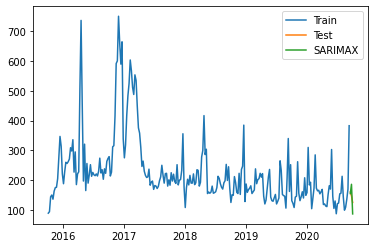

Current product:  10197
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96870D+00    |proj g|=  6.65887D-01


 This problem is unconstrained.



At iterate    5    f=  5.72156D+00    |proj g|=  2.94702D-02

At iterate   10    f=  5.70698D+00    |proj g|=  4.47533D-02

At iterate   15    f=  5.70617D+00    |proj g|=  7.26558D-03

At iterate   20    f=  5.67339D+00    |proj g|=  1.42558D-01

At iterate   25    f=  5.66356D+00    |proj g|=  9.81779D-02

At iterate   30    f=  5.66319D+00    |proj g|=  8.64421D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     40      1     0     0   9.875D-07   5.663D+00
  F =   5.6631861914224908     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  26.450300921770413
Current parameter:  [(1, 

 This problem is unconstrained.



At iterate    5    f=  5.75258D+00    |proj g|=  4.72379D-03

At iterate   10    f=  5.74655D+00    |proj g|=  4.90507D-02

At iterate   15    f=  5.72937D+00    |proj g|=  1.12712D-02

At iterate   20    f=  5.72882D+00    |proj g|=  8.18017D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     43      1     0     0   1.033D-04   5.729D+00
  F =   5.7287643020540608     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  24.095338519554435
Current parameter:  [(1, 1, 0), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92484D+00    |proj g|=  7.79316D-01

At iterate    5    f=  5.75642D+00    |proj g|=  4.51740D-03

At iterate   10    f=  5.74472D+00    |proj g|=  5.69699D-02

At iterate   15    f=  5.73971D+00    |proj g|=  2.16909D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   1.069D-05   5.740D+00
  F =   5.7397084381730901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2

 This problem is unconstrained.



At iterate    5    f=  5.69538D+00    |proj g|=  1.06299D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   4.876D-06   5.695D+00
  F =   5.6953757796211324     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  27.337128675539404
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.90521D+00    |proj g|=  8.18625D-01

At iterate    5    f=  5.69841D+00    |proj g|=  1.03344D-01

At iterate   10    f=  5.69188D+00    |proj g|=  1.11400D-02

At iterate   15    f=  5.67328D+00    |proj g|=  1.37409D-01

At iterate   20    f=  5.65121D+00    |proj g|=  1.34629D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   1.926D-05   5.651D+00
  F =   5.6512026969747149     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.59134D+00    |proj g|=  7.76121D-01

At iterate    5    f=  6.27566D+00    |proj g|=  2.22425D-01

At iterate   10    f=  6.26595D+00    |proj g|=  1.45811D-01

At iterate   15    f=  6.25899D+00    |proj g|=  2.75745D-02

At iterate   20    f=  6.25851D+00    |proj g|=  8.26337D-02

At iterate   25    f=  6.23798D+00    |proj g|=  6.52280D-01

At iterate   30    f=  6.22421D+00    |proj g|=  6.48763D-02

At iterate   35    f=  6.22411D+00    |proj g|=  1.98206D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.38923D+00    |proj g|=  2.93385D-01

At iterate    5    f=  6.26720D+00    |proj g|=  1.03630D-02

At iterate   10    f=  6.26107D+00    |proj g|=  9.26166D-03

At iterate   15    f=  6.25703D+00    |proj g|=  1.81463D-02

At iterate   20    f=  6.24980D+00    |proj g|=  7.58172D-04

At iterate   25    f=  6.24978D+00    |proj g|=  8.73231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     30      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.27086D+00    |proj g|=  6.41928D-03

At iterate   10    f=  6.26040D+00    |proj g|=  3.49514D-02

At iterate   15    f=  6.23705D+00    |proj g|=  9.96821D-03

At iterate   20    f=  6.23564D+00    |proj g|=  9.55680D-03

At iterate   25    f=  6.23551D+00    |proj g|=  4.39711D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     35      1     0     0   1.236D-05   6.236D+00
  F =   6.2355127404843600     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  26.165600727741335
Current parameter:  [(1, 1, 1), (2, 1, 2, 52)]
RUNNING THE L-BFGS-B CODE

           * 

 This problem is unconstrained.



At iterate    5    f=  6.28445D+00    |proj g|=  4.67549D-02

At iterate   10    f=  6.27129D+00    |proj g|=  4.31160D-02

At iterate   15    f=  6.27099D+00    |proj g|=  3.33849D-02

At iterate   20    f=  6.26571D+00    |proj g|=  1.68668D-01

At iterate   25    f=  6.23886D+00    |proj g|=  1.01997D-01

At iterate   30    f=  6.23694D+00    |proj g|=  1.86079D-02

At iterate   35    f=  6.23668D+00    |proj g|=  4.00720D-02

At iterate   40    f=  6.23548D+00    |proj g|=  2.49590D-02

At iterate   45    f=  6.23537D+00    |proj g|=  1.12535D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     61   

 This problem is unconstrained.



At iterate    5    f=  6.31014D+00    |proj g|=  9.00818D-03

At iterate   10    f=  6.28568D+00    |proj g|=  1.19641D-02

At iterate   15    f=  6.28519D+00    |proj g|=  4.35692D-04

At iterate   20    f=  6.28519D+00    |proj g|=  5.86099D-04

At iterate   25    f=  6.28517D+00    |proj g|=  6.36973D-04

At iterate   30    f=  6.28516D+00    |proj g|=  2.16302D-04

At iterate   35    f=  6.28516D+00    |proj g|=  4.52134D-04

At iterate   40    f=  6.28515D+00    |proj g|=  6.26682D-04

At iterate   45    f=  6.28513D+00    |proj g|=  8.44207D-04

At iterate   50    f=  6.28444D+00    |proj g|=  2.62167D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.29050D+00    |proj g|=  7.20598D-02

At iterate   10    f=  6.27188D+00    |proj g|=  3.15653D-02

At iterate   15    f=  6.26920D+00    |proj g|=  6.45367D-03

At iterate   20    f=  6.25533D+00    |proj g|=  6.19501D-02

At iterate   25    f=  6.23458D+00    |proj g|=  6.96776D-02

At iterate   30    f=  6.23340D+00    |proj g|=  3.14275D-03

At iterate   35    f=  6.23338D+00    |proj g|=  2.18334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     51      1     0     0   1.488D-05   6.233D+00
  F =   6.2333828798024511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97032D+00    |proj g|=  6.64465D-01

At iterate    5    f=  5.73998D+00    |proj g|=  2.17492D-01

At iterate   10    f=  5.71180D+00    |proj g|=  1.69723D-01

At iterate   15    f=  5.70287D+00    |proj g|=  4.15008D-02

At iterate   20    f=  5.69109D+00    |proj g|=  7.45179D-03

At iterate   25    f=  5.69003D+00    |proj g|=  4.58935D-02

At iterate   30    f=  5.65878D+00    |proj g|=  9.23641D-02

At iterate   35    f=  5.65531D+00    |proj g|=  5.61284D-03

At iterate   40    f=  5.65522D+00    |proj g|=  6.73159D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  5.74311D+00    |proj g|=  9.96098D-02

At iterate   10    f=  5.72243D+00    |proj g|=  1.98586D-01

At iterate   15    f=  5.69760D+00    |proj g|=  7.35286D-02

At iterate   20    f=  5.69682D+00    |proj g|=  6.44155D-03

At iterate   25    f=  5.67898D+00    |proj g|=  1.54966D-01

At iterate   30    f=  5.66182D+00    |proj g|=  8.21159D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     43      1     0     0   2.711D-05   5.662D+00
  F =   5.6615966731515890     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  24.36656765768783
Current parameter:  [(1, 1

 This problem is unconstrained.



At iterate    5    f=  6.29290D+00    |proj g|=  8.75881D-02

At iterate   10    f=  6.26786D+00    |proj g|=  8.33522D-02

At iterate   15    f=  6.26725D+00    |proj g|=  7.89603D-02

At iterate   20    f=  6.26562D+00    |proj g|=  1.53453D-01

At iterate   25    f=  6.26476D+00    |proj g|=  1.72585D-02

At iterate   30    f=  6.26334D+00    |proj g|=  2.04743D-01

At iterate   35    f=  6.26187D+00    |proj g|=  1.33049D-02

At iterate   40    f=  6.26067D+00    |proj g|=  4.35934D-03

At iterate   45    f=  6.26037D+00    |proj g|=  8.86989D-02

At iterate   50    f=  6.25620D+00    |proj g|=  5.92199D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.68735D+00    |proj g|=  9.63873D-02

At iterate   10    f=  5.67331D+00    |proj g|=  7.56780D-02

At iterate   15    f=  5.66611D+00    |proj g|=  1.11772D-02

At iterate   20    f=  5.66154D+00    |proj g|=  1.33640D-01

At iterate   25    f=  5.65122D+00    |proj g|=  6.06535D-03

At iterate   30    f=  5.65119D+00    |proj g|=  9.67049D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     41      1     0     0   9.670D-06   5.651D+00
  F =   5.6511906616774530     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  24.59337415629366
Current parameter:  [(0, 1

 This problem is unconstrained.



At iterate    5    f=  5.71363D+00    |proj g|=  6.93927D-02

At iterate   10    f=  5.70979D+00    |proj g|=  2.62412D-02

At iterate   15    f=  5.69006D+00    |proj g|=  1.61392D-01

At iterate   20    f=  5.66522D+00    |proj g|=  5.22418D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   6.558D-06   5.665D+00
  F =   5.6652221041630328     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  26.128575217793752
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exac

 This problem is unconstrained.



At iterate    5    f=  6.31014D+00    |proj g|=  9.00818D-03

At iterate   10    f=  6.28568D+00    |proj g|=  1.19641D-02

At iterate   15    f=  6.28519D+00    |proj g|=  4.35692D-04

At iterate   20    f=  6.28519D+00    |proj g|=  5.86099D-04

At iterate   25    f=  6.28517D+00    |proj g|=  6.36973D-04

At iterate   30    f=  6.28516D+00    |proj g|=  2.16302D-04

At iterate   35    f=  6.28516D+00    |proj g|=  4.52134D-04

At iterate   40    f=  6.28515D+00    |proj g|=  6.26682D-04

At iterate   45    f=  6.28513D+00    |proj g|=  8.44207D-04

At iterate   50    f=  6.28444D+00    |proj g|=  2.62167D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

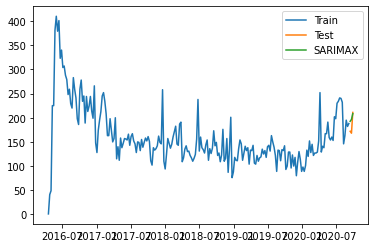

Current product:  16408
Current parameter:  [(1, 1, 1), (1, 1, 1, 52)]
all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Current parameter:  [(1, 1, 0), (1, 1, 1, 52)]
all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Current parameter:  [(1, 1, 0), (1, 1, 0, 52)]
all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Current parameter:  [(1, 1, 0), (0, 1, 0, 52)]
all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Current parameter:  [(1, 1, 1), (1, 1, 0, 52)]
all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Current par

IndexError: list index out of range

In [133]:
main_method(productMix,horizons,params)


In [206]:

main_method([[16408]],horizons,params)




selected productGroup:  [16408]
selected horizon:  3
Current product:  16408
            Salg_sum  Kampanje
Ukedato                       
2019-09-02       3.0       0.0
2019-09-09      93.0       0.0
2019-09-16     248.0       0.0
2019-09-23     632.0       0.0
2019-09-30     752.0       0.0
2019-10-07     763.0       0.0
2019-10-14     836.0       0.0
2019-10-21     747.0       0.0
2019-10-28     831.0       0.0
2019-11-04     815.0       0.0
2019-11-11     646.0       0.0
2019-11-18     573.0       0.0
2019-11-25     512.0       0.0
2019-12-02     449.0       0.0
2019-12-09     534.0       0.0
            Kampanje
Ukedato             
2020-09-14       0.0
2020-09-21       0.0
2020-09-28       0.0
mod:  <statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x29b1e9880>


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

selected productGroup:  [14238, 14288, 14542, 10002, 10197, 16527, 14563, 9541]
selected horizon:  3
Current product:  14238


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.25919D+00    |proj g|=  6.91609D-02
  ys=-3.675E-01  -gs= 1.436E-01 BFGS update SKIPPED

At iterate    5    f=  5.80073D+00    |proj g|=  1.06702D-01

At iterate   10    f=  5.79321D+00    |proj g|=  1.10487D-02

At iterate   15    f=  5.78755D+00    |proj g|=  1.37716D-01

At iterate   20    f=  5.78728D+00    |proj g|=  4.62338D-02

At iterate   25    f=  5.77362D+00    |proj g|=  2.78752D-01

At iterate   30    f=  5.77345D+00    |proj g|=  6.48136D-03

At iterate   35    f=  5.77345D+00    |proj g|=  3.28081D-02

At iterate   40    f=  5.76476D+00    |proj g|=  5.02558D-01

At iterate   45    f=  5.76241D+00    |proj g|=  2.43984D-01

At iterate   50    f=  5.76172D+00    |proj g|=  3.75656D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.29420D+00    |proj g|=  7.20445D-02

At iterate    5    f=  5.85492D+00    |proj g|=  6.37624D-02

At iterate   10    f=  5.85309D+00    |proj g|=  4.95511D-02

At iterate   15    f=  5.85254D+00    |proj g|=  4.58960D-02

At iterate   20    f=  5.83870D+00    |proj g|=  3.79305D-01

At iterate   25    f=  5.83069D+00    |proj g|=  1.08634D-02

At iterate   30    f=  5.83041D+00    |proj g|=  1.37001D-04

At iterate   35    f=  5.83041D+00    |proj g|=  6.05320D-04

At iterate   40    f=  5.83032D+00    |proj g|=  1.88383D-02

At iterate   45    f=  5.82905D+00    |proj g|=  8.87877D-03

At iterate   50    f=  5.82866D+00    |proj g|=  2.25442D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.90997D+00    |proj g|=  1.41441D-03

At iterate   10    f=  5.90857D+00    |proj g|=  2.29878D-02

At iterate   15    f=  5.90771D+00    |proj g|=  2.80934D-04

At iterate   20    f=  5.90743D+00    |proj g|=  1.18438D-02

At iterate   25    f=  5.90227D+00    |proj g|=  2.14032D-02

At iterate   30    f=  5.90075D+00    |proj g|=  3.92718D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     51      1     0     0   3.927D-05   5.901D+00
  F =   5.9007475057092496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


rmse:  40.25726950821314
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.84104D+00    |proj g|=  5.80636D-04


 This problem is unconstrained.



At iterate    5    f=  5.84103D+00    |proj g|=  2.10602D-03

At iterate   10    f=  5.84023D+00    |proj g|=  2.65214D-02

At iterate   15    f=  5.83341D+00    |proj g|=  5.57297D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     21      1     0     0   4.153D-06   5.833D+00
  F =   5.8333677956210712     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  42.71467242609019
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11982D+00    |proj 

 This problem is unconstrained.



At iterate    5    f=  5.84740D+00    |proj g|=  3.97304D-02

At iterate   10    f=  5.83434D+00    |proj g|=  5.43899D-02

At iterate   15    f=  5.83417D+00    |proj g|=  5.08486D-03

At iterate   20    f=  5.83344D+00    |proj g|=  4.08222D-02

At iterate   25    f=  5.83139D+00    |proj g|=  5.18596D-03

At iterate   30    f=  5.83137D+00    |proj g|=  1.01537D-02

At iterate   35    f=  5.83119D+00    |proj g|=  1.55575D-01

At iterate   40    f=  5.82358D+00    |proj g|=  2.73281D-01

At iterate   45    f=  5.81983D+00    |proj g|=  1.07525D-02

At iterate   50    f=  5.81929D+00    |proj g|=  1.61883D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.54933D+00    |proj g|=  5.84405D-01

At iterate    5    f=  6.32389D+00    |proj g|=  2.52595D-02

At iterate   10    f=  6.31664D+00    |proj g|=  7.56866D-02

At iterate   15    f=  6.31621D+00    |proj g|=  6.61635D-02

At iterate   20    f=  6.30952D+00    |proj g|=  3.90892D-02

At iterate   25    f=  6.30311D+00    |proj g|=  7.76971D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     38      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.32283D+00    |proj g|=  5.89100D-03

At iterate   10    f=  6.31758D+00    |proj g|=  1.34011D-02

At iterate   15    f=  6.31514D+00    |proj g|=  1.06898D-02

At iterate   20    f=  6.30848D+00    |proj g|=  6.47289D-03

At iterate   25    f=  6.30193D+00    |proj g|=  7.43663D-03

At iterate   30    f=  6.30044D+00    |proj g|=  6.53581D-04

At iterate   35    f=  6.30043D+00    |proj g|=  5.10472D-04

At iterate   40    f=  6.30004D+00    |proj g|=  1.00463D-02

At iterate   45    f=  6.29515D+00    |proj g|=  5.95550D-03

At iterate   50    f=  6.29433D+00    |proj g|=  5.20758D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.31916D+00    |proj g|=  1.27137D-02

At iterate   10    f=  6.31351D+00    |proj g|=  6.83517D-03

At iterate   15    f=  6.30596D+00    |proj g|=  5.56589D-03

At iterate   20    f=  6.29369D+00    |proj g|=  2.97083D-02

At iterate   25    f=  6.28846D+00    |proj g|=  3.05440D-03

At iterate   30    f=  6.28842D+00    |proj g|=  2.11026D-03

At iterate   35    f=  6.28803D+00    |proj g|=  2.51171D-03

At iterate   40    f=  6.28476D+00    |proj g|=  1.16543D-02

At iterate   45    f=  6.28271D+00    |proj g|=  1.98443D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     60   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.38022D+00    |proj g|=  2.30143D-01

At iterate    5    f=  6.32449D+00    |proj g|=  3.22928D-02

At iterate   10    f=  6.31986D+00    |proj g|=  5.81764D-02

At iterate   15    f=  6.31607D+00    |proj g|=  6.97902D-02

At iterate   20    f=  6.31507D+00    |proj g|=  7.60421D-02

At iterate   25    f=  6.31438D+00    |proj g|=  5.42580D-02

At iterate   30    f=  6.31430D+00    |proj g|=  4.14890D-03

At iterate   35    f=  6.30883D+00    |proj g|=  2.85144D-01

At iterate   40    f=  6.29566D+00    |proj g|=  1.24353D-01

At iterate   45    f=  6.29165D+00    |proj g|=  1.97472D-01

At iterate   50    f=  6.28963D+00    |proj g|=  3.37015D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.40789D+00    |proj g|=  2.39215D-01

At iterate    5    f=  6.35119D+00    |proj g|=  5.86013D-03

At iterate   10    f=  6.34924D+00    |proj g|=  1.18815D-02

At iterate   15    f=  6.32895D+00    |proj g|=  8.03822D-03

At iterate   20    f=  6.32875D+00    |proj g|=  4.41730D-04

At iterate   25    f=  6.32861D+00    |proj g|=  1.77028D-03

At iterate   30    f=  6.32852D+00    |proj g|=  1.69378D-03

At iterate   35    f=  6.32738D+00    |proj g|=  5.79264D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  6.34217D+00    |proj g|=  1.05633D-01

At iterate   10    f=  6.32312D+00    |proj g|=  1.09922D-02

At iterate   15    f=  6.31497D+00    |proj g|=  2.00261D-02

At iterate   20    f=  6.31270D+00    |proj g|=  2.09858D-02

At iterate   25    f=  6.31179D+00    |proj g|=  1.67365D-02

At iterate   30    f=  6.30362D+00    |proj g|=  1.84453D-01

At iterate   35    f=  6.30222D+00    |proj g|=  2.06504D-02

At iterate   40    f=  6.30148D+00    |proj g|=  1.30602D-03

At iterate   45    f=  6.30146D+00    |proj g|=  3.38985D-02

At iterate   50    f=  6.29771D+00    |proj g|=  1.80960D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26359D+00    |proj g|=  7.40578D-02
  ys=-1.705E-01  -gs= 1.054E-01 BFGS update SKIPPED

At iterate    5    f=  5.86249D+00    |proj g|=  4.43542D-01

At iterate   10    f=  5.80492D+00    |proj g|=  7.29829D-02

At iterate   15    f=  5.78928D+00    |proj g|=  4.03542D-01

At iterate   20    f=  5.78786D+00    |proj g|=  4.29610D-02

At iterate   25    f=  5.78768D+00    |proj g|=  1.63304D-02

At iterate   30    f=  5.78348D+00    |proj g|=  1.60602D-01

At iterate   35    f=  5.76005D+00    |proj g|=  1.36485D-02

At iterate   40    f=  5.75976D+00    |proj g|=  1.67402D-02

At iterate   45    f=  5.75926D+00    |proj g|=  4.74480D-02

At iterate   50    f=  5.75911D+00    |proj g|=  4.29955D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.



At iterate    5    f=  5.87515D+00    |proj g|=  2.71659D-02

At iterate   10    f=  5.84855D+00    |proj g|=  2.51292D-01

At iterate   15    f=  5.84132D+00    |proj g|=  2.12640D-02

At iterate   20    f=  5.84127D+00    |proj g|=  1.82707D-03

At iterate   25    f=  5.84107D+00    |proj g|=  4.82683D-02

At iterate   30    f=  5.83871D+00    |proj g|=  1.91111D-02

At iterate   35    f=  5.83857D+00    |proj g|=  3.33907D-04

At iterate   40    f=  5.83856D+00    |proj g|=  8.07581D-03

At iterate   45    f=  5.83796D+00    |proj g|=  5.61273D-02

At iterate   50    f=  5.82892D+00    |proj g|=  4.12243D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.32792D+00    |proj g|=  3.24154D-02

At iterate   10    f=  6.32392D+00    |proj g|=  2.33522D-02

At iterate   15    f=  6.32248D+00    |proj g|=  1.10364D-02

At iterate   20    f=  6.31762D+00    |proj g|=  2.51877D-02

At iterate   25    f=  6.31748D+00    |proj g|=  2.31114D-02

At iterate   30    f=  6.31726D+00    |proj g|=  2.04453D-02

At iterate   35    f=  6.31698D+00    |proj g|=  5.84978D-03

At iterate   40    f=  6.31579D+00    |proj g|=  2.04054D-02

At iterate   45    f=  6.30937D+00    |proj g|=  2.76068D-01

At iterate   50    f=  6.30119D+00    |proj g|=  5.73654D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.10859D+00    |proj g|=  2.58468D-01

At iterate    5    f=  5.84917D+00    |proj g|=  4.65258D-02

At iterate   10    f=  5.83441D+00    |proj g|=  4.29997D-01

At iterate   15    f=  5.83075D+00    |proj g|=  5.34738D-03

At iterate   20    f=  5.83066D+00    |proj g|=  1.84162D-03

At iterate   25    f=  5.83063D+00    |proj g|=  3.90643D-02

At iterate   30    f=  5.83031D+00    |proj g|=  9.91181D-02

At iterate   35    f=  5.83009D+00    |proj g|=  4.07550D-04

At iterate   40    f=  5.83009D+00    |proj g|=  3.74431D-03

At iterate   45    f=  5.82911D+00    |proj g|=  5.40921D-02

At iterate   50    f=  5.82078D+00    |proj g|=  2.17375D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


  ys=-9.033E-01  -gs= 1.113E-01 BFGS update SKIPPED

At iterate    5    f=  5.82390D+00    |proj g|=  4.00675D-01

At iterate   10    f=  5.79782D+00    |proj g|=  4.95112D-03

At iterate   15    f=  5.79739D+00    |proj g|=  8.45707D-02

At iterate   20    f=  5.79347D+00    |proj g|=  4.87919D-02

At iterate   25    f=  5.79185D+00    |proj g|=  1.62212D-01

At iterate   30    f=  5.77496D+00    |proj g|=  3.35575D-01

At iterate   35    f=  5.77110D+00    |proj g|=  5.46197D-04

At iterate   40    f=  5.77096D+00    |proj g|=  2.10248D-02

At iterate   45    f=  5.76682D+00    |proj g|=  5.65622D-02

At iterate   50    f=  5.76133D+00    |proj g|=  8.79009D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  6.32283D+00    |proj g|=  5.89100D-03

At iterate   10    f=  6.31758D+00    |proj g|=  1.34011D-02

At iterate   15    f=  6.31514D+00    |proj g|=  1.06898D-02

At iterate   20    f=  6.30848D+00    |proj g|=  6.47289D-03

At iterate   25    f=  6.30193D+00    |proj g|=  7.43663D-03

At iterate   30    f=  6.30044D+00    |proj g|=  6.53581D-04

At iterate   35    f=  6.30043D+00    |proj g|=  5.10472D-04

At iterate   40    f=  6.30004D+00    |proj g|=  1.00463D-02

At iterate   45    f=  6.29515D+00    |proj g|=  5.95550D-03

At iterate   50    f=  6.29433D+00    |proj g|=  5.20758D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

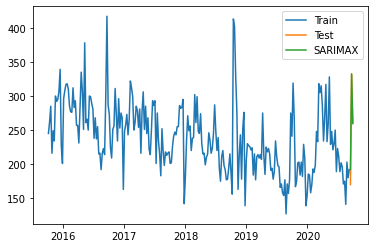

Current product:  14288


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50336D+00    |proj g|=  7.02503D-02

At iterate    5    f=  6.14548D+00    |proj g|=  3.42594D-02

At iterate   10    f=  6.14008D+00    |proj g|=  1.77296D-02

At iterate   15    f=  6.13943D+00    |proj g|=  2.97143D-02

At iterate   20    f=  6.13019D+00    |proj g|=  1.78725D-01

At iterate   25    f=  6.10188D+00    |proj g|=  4.53117D-02

At iterate   30    f=  6.10077D+00    |proj g|=  9.49238D-04

At iterate   35    f=  6.10074D+00    |proj g|=  5.67098D-03

At iterate   40    f=  6.10016D+00    |proj g|=  1.82246D-02

At iterate   45    f=  6.09561D+00    |proj g|=  5.31702D-02

At iterate   50    f=  6.07828D+00    |proj g|=  1.25502D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50718D+00    |proj g|=  7.17156D-02

At iterate    5    f=  6.16236D+00    |proj g|=  3.35678D-02

At iterate   10    f=  6.16217D+00    |proj g|=  3.07735D-03

At iterate   15    f=  6.15866D+00    |proj g|=  1.27906D-01

At iterate   20    f=  6.12905D+00    |proj g|=  2.04256D-02

At iterate   25    f=  6.12848D+00    |proj g|=  1.26645D-04

At iterate   30    f=  6.12846D+00    |proj g|=  7.19430D-03

At iterate   35    f=  6.12649D+00    |proj g|=  1.01242D-01

At iterate   40    f=  6.11964D+00    |proj g|=  1.33078D-02

At iterate   45    f=  6.11907D+00    |proj g|=  4.22602D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.20095D+00    |proj g|=  1.88100D-03

At iterate   10    f=  6.19758D+00    |proj g|=  1.40196D-01

At iterate   15    f=  6.19149D+00    |proj g|=  7.53661D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     21      1     0     0   7.011D-05   6.191D+00
  F =   6.1914857663939271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  21.517278583354308
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15250D+00    |proj

 This problem is unconstrained.



At iterate    5    f=  6.15249D+00    |proj g|=  2.09502D-03

At iterate   10    f=  6.15204D+00    |proj g|=  1.65966D-02

At iterate   15    f=  6.15172D+00    |proj g|=  2.27304D-03

At iterate   20    f=  6.15035D+00    |proj g|=  2.64088D-02

At iterate   25    f=  6.13786D+00    |proj g|=  6.46025D-03

At iterate   30    f=  6.13726D+00    |proj g|=  2.54552D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     34      1     0     0   2.546D-07   6.137D+00
  F =   6.1372619388266338     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  18.203203061944823


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.31623D+00    |proj g|=  3.18086D-01

At iterate    5    f=  6.17713D+00    |proj g|=  1.40383D-02

At iterate   10    f=  6.17583D+00    |proj g|=  2.18447D-03

At iterate   15    f=  6.17511D+00    |proj g|=  7.84898D-02

At iterate   20    f=  6.16383D+00    |proj g|=  5.14030D-02

At iterate   25    f=  6.16318D+00    |proj g|=  3.26571D-03

At iterate   30    f=  6.16317D+00    |proj g|=  1.51623D-03

At iterate   35    f=  6.16315D+00    |proj g|=  1.83674D-02

At iterate   40    f=  6.16264D+00    |proj g|=  2.23745D-02

At iterate   45    f=  6.16251D+00    |proj g|=  1.56915D-02

At iterate   50    f=  6.15688D+00    |proj g|=  1.31982D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.61977D+00    |proj g|=  5.09092D-01

At iterate    5    f=  6.57089D+00    |proj g|=  3.42359D-01

At iterate   10    f=  6.55495D+00    |proj g|=  7.46331D-03

At iterate   15    f=  6.55471D+00    |proj g|=  2.35244D-02

At iterate   20    f=  6.54791D+00    |proj g|=  2.49753D-02

At iterate   25    f=  6.54559D+00    |proj g|=  2.49001D-02

At iterate   30    f=  6.53622D+00    |proj g|=  4.64115D-02

At iterate   35    f=  6.53466D+00    |proj g|=  6.65917D-02

At iterate   40    f=  6.53396D+00    |proj g|=  3.57564D-03

At iterate   45    f=  6.53396D+00    |proj g|=  3.89839D-03

At iterate   50    f=  6.53385D+00    |proj g|=  6.54088D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60317D+00    |proj g|=  2.00763D-01

At iterate    5    f=  6.54226D+00    |proj g|=  3.57453D-03

At iterate   10    f=  6.53170D+00    |proj g|=  3.37326D-02

At iterate   15    f=  6.49275D+00    |proj g|=  9.46045D-03

At iterate   20    f=  6.49100D+00    |proj g|=  1.00484D-02

At iterate   25    f=  6.49051D+00    |proj g|=  4.02676D-03

At iterate   30    f=  6.49025D+00    |proj g|=  6.98989D-03

At iterate   35    f=  6.49017D+00    |proj g|=  1.74828D-03

At iterate   40    f=  6.49013D+00    |proj g|=  3.19630D-04

At iterate   45    f=  6.49009D+00    |proj g|=  1.31855D-04

At iterate   50    f=  6.48994D+00    |proj g|=  4.91355D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60190D+00    |proj g|=  2.11762D-01

At iterate    5    f=  6.54201D+00    |proj g|=  3.52511D-03

At iterate   10    f=  6.52807D+00    |proj g|=  4.66489D-02

At iterate   15    f=  6.50040D+00    |proj g|=  1.41230D-02

At iterate   20    f=  6.49297D+00    |proj g|=  2.84598D-03

At iterate   25    f=  6.49295D+00    |proj g|=  6.68786D-04

At iterate   30    f=  6.49288D+00    |proj g|=  4.18801D-03

At iterate   35    f=  6.49282D+00    |proj g|=  2.28487D-03

At iterate   40    f=  6.49224D+00    |proj g|=  4.93523D-03

At iterate   45    f=  6.48089D+00    |proj g|=  2.59660D-02

At iterate   50    f=  6.47648D+00    |proj g|=  4.60644D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.54439D+00    |proj g|=  1.11198D-01

At iterate   10    f=  6.54207D+00    |proj g|=  3.52585D-03

At iterate   15    f=  6.54164D+00    |proj g|=  2.74373D-02

At iterate   20    f=  6.51580D+00    |proj g|=  1.99198D-01

At iterate   25    f=  6.50094D+00    |proj g|=  1.86889D-02

At iterate   30    f=  6.49458D+00    |proj g|=  2.44209D-02

At iterate   35    f=  6.49309D+00    |proj g|=  1.03932D-02

At iterate   40    f=  6.49284D+00    |proj g|=  4.41488D-03

At iterate   45    f=  6.49272D+00    |proj g|=  3.58502D-03

At iterate   50    f=  6.49268D+00    |proj g|=  3.25232D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60738D+00    |proj g|=  2.39329D-01

At iterate    5    f=  6.54481D+00    |proj g|=  4.46191D-03

At iterate   10    f=  6.52684D+00    |proj g|=  4.05144D-02

At iterate   15    f=  6.50128D+00    |proj g|=  2.51616D-03

At iterate   20    f=  6.50127D+00    |proj g|=  3.64183D-04

At iterate   25    f=  6.50124D+00    |proj g|=  3.19077D-03

At iterate   30    f=  6.50122D+00    |proj g|=  1.30088D-03

At iterate   35    f=  6.50119D+00    |proj g|=  1.29715D-03

At iterate   40    f=  6.50086D+00    |proj g|=  4.85701D-03

At iterate   45    f=  6.50057D+00    |proj g|=  4.46424D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.64800D+00    |proj g|=  3.22742D-01

At iterate    5    f=  6.57903D+00    |proj g|=  1.16848D-01

At iterate   10    f=  6.54293D+00    |proj g|=  3.56880D-02

At iterate   15    f=  6.54234D+00    |proj g|=  1.70039D-02

At iterate   20    f=  6.53763D+00    |proj g|=  6.04038D-03

At iterate   25    f=  6.53743D+00    |proj g|=  9.71858D-03

At iterate   30    f=  6.53343D+00    |proj g|=  7.61513D-02

At iterate   35    f=  6.49467D+00    |proj g|=  2.95220D-02

At iterate   40    f=  6.49029D+00    |proj g|=  1.80734D-02

At iterate   45    f=  6.48951D+00    |proj g|=  1.88692D-03

At iterate   50    f=  6.48933D+00    |proj g|=  3.07038D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51303D+00    |proj g|=  8.23108D-02

At iterate    5    f=  6.17592D+00    |proj g|=  1.48465D-01

At iterate   10    f=  6.14693D+00    |proj g|=  1.17069D-02

At iterate   15    f=  6.14255D+00    |proj g|=  4.46170D-02

At iterate   20    f=  6.13708D+00    |proj g|=  8.70824D-03

At iterate   25    f=  6.13563D+00    |proj g|=  3.02316D-02

At iterate   30    f=  6.11451D+00    |proj g|=  2.76446D-01

At iterate   35    f=  6.10396D+00    |proj g|=  1.61359D-02

At iterate   40    f=  6.10102D+00    |proj g|=  5.59236D-03

At iterate   45    f=  6.10074D+00    |proj g|=  2.40153D-04

At iterate   50    f=  6.10072D+00    |proj g|=  1.50782D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.18731D+00    |proj g|=  2.76684D-02

At iterate   10    f=  6.17985D+00    |proj g|=  4.18765D-02

At iterate   15    f=  6.17777D+00    |proj g|=  2.55836D-02

At iterate   20    f=  6.17762D+00    |proj g|=  7.63305D-03

At iterate   25    f=  6.17292D+00    |proj g|=  8.34509D-02

At iterate   30    f=  6.16652D+00    |proj g|=  2.23892D-03

At iterate   35    f=  6.16651D+00    |proj g|=  8.60114D-04

At iterate   40    f=  6.16650D+00    |proj g|=  1.13168D-03

At iterate   45    f=  6.16486D+00    |proj g|=  2.10661D-02

At iterate   50    f=  6.14868D+00    |proj g|=  4.74315D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.54684D+00    |proj g|=  2.91780D-02

At iterate   10    f=  6.54196D+00    |proj g|=  3.89944D-03

At iterate   15    f=  6.52695D+00    |proj g|=  2.94952D-01

At iterate   20    f=  6.49055D+00    |proj g|=  5.99901D-02

At iterate   25    f=  6.48989D+00    |proj g|=  6.46651D-03

At iterate   30    f=  6.48936D+00    |proj g|=  1.94492D-03

At iterate   35    f=  6.48918D+00    |proj g|=  1.17422D-02

At iterate   40    f=  6.48889D+00    |proj g|=  2.17464D-03

At iterate   45    f=  6.48881D+00    |proj g|=  8.65767D-03

At iterate   50    f=  6.48873D+00    |proj g|=  9.54842D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    0    f=  6.31196D+00    |proj g|=  3.31035D-01

At iterate    5    f=  6.16578D+00    |proj g|=  2.41877D-02

At iterate   10    f=  6.16322D+00    |proj g|=  1.75860D-03

At iterate   15    f=  6.16167D+00    |proj g|=  2.31153D-02

At iterate   20    f=  6.15467D+00    |proj g|=  1.81960D-02

At iterate   25    f=  6.15464D+00    |proj g|=  2.10071D-04

At iterate   30    f=  6.15463D+00    |proj g|=  4.76011D-03

At iterate   35    f=  6.15408D+00    |proj g|=  2.20623D-02

At iterate   40    f=  6.15072D+00    |proj g|=  3.07147D-02

At iterate   45    f=  6.14914D+00    |proj g|=  7.07283D-02

At iterate   50    f=  6.13520D+00    |proj g|=  3.18374D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50648D+00    |proj g|=  7.14187D-02

At iterate    5    f=  6.15016D+00    |proj g|=  3.54085D-03

At iterate   10    f=  6.14948D+00    |proj g|=  4.60516D-02

At iterate   15    f=  6.12795D+00    |proj g|=  3.05471D-01

At iterate   20    f=  6.10369D+00    |proj g|=  5.05595D-02

At iterate   25    f=  6.10356D+00    |proj g|=  2.69104D-04

At iterate   30    f=  6.10355D+00    |proj g|=  1.23601D-02

At iterate   35    f=  6.10273D+00    |proj g|=  8.76892D-02

At iterate   40    f=  6.09429D+00    |proj g|=  3.38876D-02

At iterate   45    f=  6.06272D+00    |proj g|=  6.97731D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.57089D+00    |proj g|=  3.42359D-01

At iterate   10    f=  6.55495D+00    |proj g|=  7.46331D-03

At iterate   15    f=  6.55471D+00    |proj g|=  2.35244D-02

At iterate   20    f=  6.54791D+00    |proj g|=  2.49753D-02

At iterate   25    f=  6.54559D+00    |proj g|=  2.49001D-02

At iterate   30    f=  6.53622D+00    |proj g|=  4.64115D-02

At iterate   35    f=  6.53466D+00    |proj g|=  6.65917D-02

At iterate   40    f=  6.53396D+00    |proj g|=  3.57564D-03

At iterate   45    f=  6.53396D+00    |proj g|=  3.89839D-03

At iterate   50    f=  6.53385D+00    |proj g|=  6.54088D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

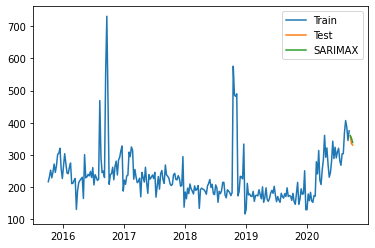

Current product:  14542
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.35411D+00    |proj g|=  4.16849D-01


 This problem is unconstrained.



At iterate    5    f=  6.18341D+00    |proj g|=  2.13668D-02

At iterate   10    f=  6.18167D+00    |proj g|=  5.50680D-03

At iterate   15    f=  6.17231D+00    |proj g|=  4.33506D-02

At iterate   20    f=  6.09144D+00    |proj g|=  1.55009D-01

At iterate   25    f=  6.06679D+00    |proj g|=  3.69135D-02

At iterate   30    f=  6.06648D+00    |proj g|=  1.85449D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     41      1     0     0   1.855D-04   6.066D+00
  F =   6.0664813765379311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  38.68868165939046
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



At iterate    5    f=  6.17733D+00    |proj g|=  4.90391D-03

At iterate   10    f=  6.14627D+00    |proj g|=  3.00014D-01

At iterate   15    f=  6.05895D+00    |proj g|=  1.36902D-02

At iterate   20    f=  6.05892D+00    |proj g|=  4.92037D-04

At iterate   25    f=  6.05892D+00    |proj g|=  1.09517D-02

At iterate   30    f=  6.05809D+00    |proj g|=  1.24149D-01

At iterate   35    f=  6.04686D+00    |proj g|=  1.17760D-01

At iterate   40    f=  6.04628D+00    |proj g|=  2.46450D-03

At iterate   45    f=  6.04611D+00    |proj g|=  4.32602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     61   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18274D+00    |proj g|=  3.08576D-01

At iterate    5    f=  6.17840D+00    |proj g|=  2.10608D-02

At iterate   10    f=  6.17793D+00    |proj g|=  6.22119D-02

At iterate   15    f=  6.14961D+00    |proj g|=  4.97742D-01

At iterate   20    f=  6.07030D+00    |proj g|=  3.35392D-02

At iterate   25    f=  6.06990D+00    |proj g|=  2.15020D-04

At iterate   30    f=  6.06963D+00    |proj g|=  2.17942D-02

At iterate   35    f=  6.06244D+00    |proj g|=  6.50796D-02

At iterate   40    f=  6.05478D+00    |proj g|=  8.16273D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.20262D+00    |proj g|=  9.51617D-04

At iterate   10    f=  6.20261D+00    |proj g|=  9.29129D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   3.680D-05   6.203D+00
  F =   6.2026068644921759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  19.366259604837367
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18002D+00    |proj g|=  2.68645D-01


 This problem is unconstrained.



At iterate    5    f=  6.17625D+00    |proj g|=  4.81841D-03

At iterate   10    f=  6.17539D+00    |proj g|=  5.34364D-02

At iterate   15    f=  6.11714D+00    |proj g|=  2.28329D-01

At iterate   20    f=  6.09322D+00    |proj g|=  8.79077D-01

At iterate   25    f=  6.06904D+00    |proj g|=  6.22450D-02

At iterate   30    f=  6.06888D+00    |proj g|=  2.53513D-04

At iterate   35    f=  6.06876D+00    |proj g|=  9.36176D-03

At iterate   40    f=  6.06061D+00    |proj g|=  2.31108D-01

At iterate   45    f=  6.05024D+00    |proj g|=  1.58176D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     66   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.53416D+00    |proj g|=  1.85629D-01

At iterate    5    f=  6.50004D+00    |proj g|=  9.10657D-03

At iterate   10    f=  6.49952D+00    |proj g|=  1.68718D-02

At iterate   15    f=  6.49629D+00    |proj g|=  2.03983D-01

At iterate   20    f=  6.48974D+00    |proj g|=  1.58933D-02

At iterate   25    f=  6.39172D+00    |proj g|=  2.40453D-01

At iterate   30    f=  6.38353D+00    |proj g|=  3.31038D-01

At iterate   35    f=  6.37572D+00    |proj g|=  1.11505D-02

At iterate   40    f=  6.28214D+00    |proj g|=  3.66647D-01

At iterate   45    f=  6.26629D+00    |proj g|=  1.00245D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47476D+00    |proj g|=  7.43898D-02

At iterate    5    f=  6.46270D+00    |proj g|=  6.94464D-03

At iterate   10    f=  6.38304D+00    |proj g|=  9.49084D-02

At iterate   15    f=  6.21487D+00    |proj g|=  4.09075D-02

At iterate   20    f=  6.18121D+00    |proj g|=  5.02374D-02

At iterate   25    f=  6.17611D+00    |proj g|=  1.55546D-03

At iterate   30    f=  6.16942D+00    |proj g|=  1.17785D-01

At iterate   35    f=  6.15842D+00    |proj g|=  1.27863D-02

At iterate   40    f=  6.15823D+00    |proj g|=  3.62235D-04

At iterate   45    f=  6.15822D+00    |proj g|=  2.52456D-03

At iterate   50    f=  6.15803D+00    |proj g|=  1.60166D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46940D+00    |proj g|=  8.04394D-02

At iterate    5    f=  6.45726D+00    |proj g|=  8.19623D-03

At iterate   10    f=  6.35492D+00    |proj g|=  3.87724D-02

At iterate   15    f=  6.28665D+00    |proj g|=  8.70933D-02

At iterate   20    f=  6.19155D+00    |proj g|=  7.86628D-02

At iterate   25    f=  6.17163D+00    |proj g|=  2.56975D-03

At iterate   30    f=  6.17162D+00    |proj g|=  4.43548D-03

At iterate   35    f=  6.17139D+00    |proj g|=  5.09880D-03

At iterate   40    f=  6.17123D+00    |proj g|=  3.99615D-03

At iterate   45    f=  6.16442D+00    |proj g|=  8.30041D-02

At iterate   50    f=  6.15960D+00    |proj g|=  1.63615D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.46150D+00    |proj g|=  8.06253D-02

At iterate   10    f=  6.45850D+00    |proj g|=  4.55614D-02

At iterate   15    f=  6.45702D+00    |proj g|=  2.82753D-02

At iterate   20    f=  6.45209D+00    |proj g|=  1.23962D-01

At iterate   25    f=  6.26529D+00    |proj g|=  2.38001D-01

At iterate   30    f=  6.23568D+00    |proj g|=  2.38144D-01

At iterate   35    f=  6.21066D+00    |proj g|=  3.07452D-01

At iterate   40    f=  6.20829D+00    |proj g|=  4.56387D-02

At iterate   45    f=  6.20634D+00    |proj g|=  7.62782D-02

At iterate   50    f=  6.16500D+00    |proj g|=  1.19906D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50789D+00    |proj g|=  9.47664D-02

At iterate    5    f=  6.49703D+00    |proj g|=  6.66485D-03

At iterate   10    f=  6.41966D+00    |proj g|=  1.23434D-01

At iterate   15    f=  6.35419D+00    |proj g|=  5.92756D-02

At iterate   20    f=  6.34781D+00    |proj g|=  1.22600D-03

At iterate   25    f=  6.34741D+00    |proj g|=  2.22277D-03

At iterate   30    f=  6.34738D+00    |proj g|=  5.67785D-04

At iterate   35    f=  6.34737D+00    |proj g|=  2.88547D-03

At iterate   40    f=  6.34673D+00    |proj g|=  3.46900D-02

At iterate   45    f=  6.33797D+00    |proj g|=  4.42308D-02

At iterate   50    f=  6.33292D+00    |proj g|=  1.33952D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.47048D+00    |proj g|=  6.21539D-02

At iterate   10    f=  6.45867D+00    |proj g|=  3.54074D-02

At iterate   15    f=  6.45167D+00    |proj g|=  3.37750D-02

At iterate   20    f=  6.45137D+00    |proj g|=  2.08937D-02

At iterate   25    f=  6.43418D+00    |proj g|=  4.69127D-02

At iterate   30    f=  6.24972D+00    |proj g|=  2.82245D-01

At iterate   35    f=  6.17379D+00    |proj g|=  2.21322D-01

At iterate   40    f=  6.14712D+00    |proj g|=  1.22734D-02

At iterate   45    f=  6.14393D+00    |proj g|=  7.57582D-03

At iterate   50    f=  6.14381D+00    |proj g|=  7.89955D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.18144D+00    |proj g|=  9.11184D-03

At iterate   10    f=  6.18101D+00    |proj g|=  3.78089D-02

At iterate   15    f=  6.14462D+00    |proj g|=  3.24368D-01

At iterate   20    f=  6.09388D+00    |proj g|=  4.25983D-02

At iterate   25    f=  6.07661D+00    |proj g|=  4.80255D-02

At iterate   30    f=  6.06748D+00    |proj g|=  4.47554D-02

At iterate   35    f=  6.06634D+00    |proj g|=  6.41547D-04

At iterate   40    f=  6.06634D+00    |proj g|=  3.40641D-04

At iterate   45    f=  6.06628D+00    |proj g|=  2.54755D-02

At iterate   50    f=  6.06496D+00    |proj g|=  4.16949D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.19682D+00    |proj g|=  3.59178D-01

At iterate    5    f=  6.18180D+00    |proj g|=  4.84999D-03

At iterate   10    f=  6.18129D+00    |proj g|=  6.18581D-02

At iterate   15    f=  6.15036D+00    |proj g|=  1.82388D-01

At iterate   20    f=  6.09878D+00    |proj g|=  5.51838D-02

At iterate   25    f=  6.09213D+00    |proj g|=  1.52220D-01

At iterate   30    f=  6.07492D+00    |proj g|=  2.79858D-03

At iterate   35    f=  6.07491D+00    |proj g|=  3.04014D-04

At iterate   40    f=  6.07433D+00    |proj g|=  1.99378D-02

At iterate   45    f=  6.05966D+00    |proj g|=  9.03232D-02

At iterate   50    f=  6.05569D+00    |proj g|=  5.89856D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.46452D+00    |proj g|=  6.19580D-02

At iterate   10    f=  6.46322D+00    |proj g|=  1.96306D-02

At iterate   15    f=  6.45712D+00    |proj g|=  9.84573D-02

At iterate   20    f=  6.23528D+00    |proj g|=  2.01570D-01

At iterate   25    f=  6.22624D+00    |proj g|=  4.88006D-01

At iterate   30    f=  6.20855D+00    |proj g|=  1.75218D-01

At iterate   35    f=  6.20706D+00    |proj g|=  2.01263D-01

At iterate   40    f=  6.19785D+00    |proj g|=  8.30352D-02

At iterate   45    f=  6.17833D+00    |proj g|=  2.79654D-01

At iterate   50    f=  6.17721D+00    |proj g|=  6.99342D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18246D+00    |proj g|=  2.54663D-01

At iterate    5    f=  6.17560D+00    |proj g|=  2.67406D-02

At iterate   10    f=  6.17478D+00    |proj g|=  2.78648D-02

At iterate   15    f=  6.17281D+00    |proj g|=  7.23399D-02

At iterate   20    f=  6.11261D+00    |proj g|=  9.85897D-02

At iterate   25    f=  6.10971D+00    |proj g|=  5.37947D-03

At iterate   30    f=  6.08616D+00    |proj g|=  1.12474D-01

At iterate   35    f=  6.06426D+00    |proj g|=  1.02659D-02

At iterate   40    f=  6.06408D+00    |proj g|=  2.67000D-04

At iterate   45    f=  6.06407D+00    |proj g|=  5.39385D-03

At iterate   50    f=  6.06334D+00    |proj g|=  2.95587D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.18400D+00    |proj g|=  9.76745D-03

At iterate   10    f=  6.18281D+00    |proj g|=  9.76663D-02

At iterate   15    f=  6.15362D+00    |proj g|=  2.18935D-01

At iterate   20    f=  6.08235D+00    |proj g|=  1.89024D-01

At iterate   25    f=  6.06952D+00    |proj g|=  3.43343D-03

At iterate   30    f=  6.06951D+00    |proj g|=  1.88337D-03

At iterate   35    f=  6.06946D+00    |proj g|=  1.35461D-02

At iterate   40    f=  6.06667D+00    |proj g|=  3.84488D-02

At iterate   45    f=  6.05600D+00    |proj g|=  5.64897D-02

At iterate   50    f=  6.05448D+00    |proj g|=  3.53581D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.20262D+00    |proj g|=  9.51617D-04

At iterate   10    f=  6.20261D+00    |proj g|=  9.29129D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   3.680D-05   6.203D+00
  F =   6.2026068644921759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  14542
Best Configs:  [(1, 1, 0), (0, 1, 0, 52)]
Mean Absolute Error: 18.348
Mean Squared Error: 321.262
Root Mean Squared Error: 19.366
Mean absolute percentage error: 5.735
Scaled Mean absolute percentage error: 5.912
Mean fore

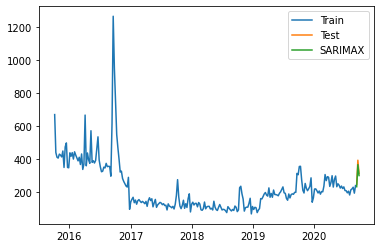

Current product:  10002
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27543D+00    |proj g|=  3.22270D-01


 This problem is unconstrained.



At iterate    5    f=  6.16789D+00    |proj g|=  9.57985D-03

At iterate   10    f=  6.16752D+00    |proj g|=  2.87910D-02

At iterate   15    f=  6.16178D+00    |proj g|=  7.24808D-02

At iterate   20    f=  6.15194D+00    |proj g|=  6.96912D-02

At iterate   25    f=  6.14411D+00    |proj g|=  1.15568D-01

At iterate   30    f=  6.13067D+00    |proj g|=  6.34699D-03

At iterate   35    f=  6.12732D+00    |proj g|=  1.50421D-02

At iterate   40    f=  6.12653D+00    |proj g|=  9.42327D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     58      1     0     0   6.638D-05   6.127D+00
  F =   6.12653442723

 This problem is unconstrained.



At iterate    5    f=  6.16028D+00    |proj g|=  6.18943D-03

At iterate   10    f=  6.15966D+00    |proj g|=  1.69512D-02

At iterate   15    f=  6.13934D+00    |proj g|=  1.36937D-01

At iterate   20    f=  6.11845D+00    |proj g|=  3.75186D-03

At iterate   25    f=  6.11844D+00    |proj g|=  1.01842D-03

At iterate   30    f=  6.11841D+00    |proj g|=  1.59562D-02

At iterate   35    f=  6.11778D+00    |proj g|=  1.98140D-02

At iterate   40    f=  6.11770D+00    |proj g|=  1.91437D-03

At iterate   45    f=  6.11769D+00    |proj g|=  7.52418D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     55   

 This problem is unconstrained.



At iterate    5    f=  6.18623D+00    |proj g|=  9.57190D-03

At iterate   10    f=  6.18576D+00    |proj g|=  5.58457D-02

At iterate   15    f=  6.15816D+00    |proj g|=  3.20581D-01

At iterate   20    f=  6.15185D+00    |proj g|=  2.22981D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     26      1     0     0   5.730D-05   6.152D+00
  F =   6.1518480658847787     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  82.72961359709745
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate    5    f=  6.16643D+00    |proj g|=  8.89888D-04

At iterate   10    f=  6.16641D+00    |proj g|=  7.03643D-04

At iterate   15    f=  6.16641D+00    |proj g|=  3.96131D-04

At iterate   20    f=  6.16629D+00    |proj g|=  5.25611D-03

At iterate   25    f=  6.16573D+00    |proj g|=  1.04024D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     31      1     0     0   6.219D-06   6.166D+00
  F =   6.1657287109234549     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  83.81896871006055


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.28522D+00    |proj g|=  3.12958D-01

At iterate    5    f=  6.18533D+00    |proj g|=  3.26549D-03

At iterate   10    f=  6.18478D+00    |proj g|=  1.81407D-02

At iterate   15    f=  6.16970D+00    |proj g|=  1.81633D-01

At iterate   20    f=  6.15095D+00    |proj g|=  8.48525D-02

At iterate   25    f=  6.15027D+00    |proj g|=  4.28487D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     29      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.61640D+00    |proj g|=  7.07298D-01

At iterate    5    f=  6.52811D+00    |proj g|=  4.76012D-03

At iterate   10    f=  6.52665D+00    |proj g|=  1.95443D-02

At iterate   15    f=  6.50242D+00    |proj g|=  4.65761D-02

At iterate   20    f=  6.45008D+00    |proj g|=  1.43670D-01

At iterate   25    f=  6.44698D+00    |proj g|=  2.66385D-03

At iterate   30    f=  6.44573D+00    |proj g|=  2.74110D-02

At iterate   35    f=  6.44562D+00    |proj g|=  2.69166D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.59483D+00    |proj g|=  2.81787D-01

At iterate    5    f=  6.54021D+00    |proj g|=  5.47859D-03

At iterate   10    f=  6.53596D+00    |proj g|=  1.26291D-02

At iterate   15    f=  6.52593D+00    |proj g|=  3.19959D-02

At iterate   20    f=  6.49729D+00    |proj g|=  1.77640D-02

At iterate   25    f=  6.49628D+00    |proj g|=  2.34394D-03

At iterate   30    f=  6.49623D+00    |proj g|=  6.82591D-04

At iterate   35    f=  6.49615D+00    |proj g|=  2.59973D-03

At iterate   40    f=  6.48451D+00    |proj g|=  4.01423D-02

At iterate   45    f=  6.48142D+00    |proj g|=  2.21795D-03

At iterate   50    f=  6.48137D+00    |proj g|=  7.05976D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58748D+00    |proj g|=  2.65725D-01

At iterate    5    f=  6.53735D+00    |proj g|=  3.76680D-03

At iterate   10    f=  6.53002D+00    |proj g|=  3.76340D-02

At iterate   15    f=  6.49809D+00    |proj g|=  2.30279D-02

At iterate   20    f=  6.48479D+00    |proj g|=  2.35523D-03

At iterate   25    f=  6.48271D+00    |proj g|=  2.18306D-02

At iterate   30    f=  6.47891D+00    |proj g|=  3.28737D-03

At iterate   35    f=  6.47888D+00    |proj g|=  7.80427D-05

At iterate   40    f=  6.47887D+00    |proj g|=  1.14633D-03

At iterate   45    f=  6.47854D+00    |proj g|=  3.13496D-03

At iterate   50    f=  6.47794D+00    |proj g|=  1.89641D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.53848D+00    |proj g|=  5.56982D-02

At iterate   10    f=  6.53727D+00    |proj g|=  7.37845D-03

At iterate   15    f=  6.53537D+00    |proj g|=  1.85558D-02

At iterate   20    f=  6.52410D+00    |proj g|=  3.41094D-02

At iterate   25    f=  6.48680D+00    |proj g|=  2.20527D-01

At iterate   30    f=  6.45498D+00    |proj g|=  1.94837D-02

At iterate   35    f=  6.45229D+00    |proj g|=  4.41912D-03

At iterate   40    f=  6.45205D+00    |proj g|=  3.06659D-02

At iterate   45    f=  6.45202D+00    |proj g|=  1.32662D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     54   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.57810D+00    |proj g|=  2.66430D-01

At iterate    5    f=  6.52914D+00    |proj g|=  3.74904D-03

At iterate   10    f=  6.50376D+00    |proj g|=  8.82563D-02

At iterate   15    f=  6.48014D+00    |proj g|=  9.87413D-03

At iterate   20    f=  6.47704D+00    |proj g|=  1.30257D-02

At iterate   25    f=  6.47661D+00    |proj g|=  3.81494D-04

At iterate   30    f=  6.47661D+00    |proj g|=  9.40478D-04

At iterate   35    f=  6.47597D+00    |proj g|=  1.08051D-02

At iterate   40    f=  6.47511D+00    |proj g|=  8.04397D-04

At iterate   45    f=  6.47510D+00    |proj g|=  1.40972D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83554D+00    |proj g|=  3.51675D-01

At iterate    5    f=  6.53731D+00    |proj g|=  4.06711D-02

At iterate   10    f=  6.53677D+00    |proj g|=  2.19319D-02

At iterate   15    f=  6.53339D+00    |proj g|=  2.01346D-02

At iterate   20    f=  6.52404D+00    |proj g|=  5.01921D-02

At iterate   25    f=  6.47528D+00    |proj g|=  2.13364D-01

At iterate   30    f=  6.45493D+00    |proj g|=  2.44995D-01

At iterate   35    f=  6.45265D+00    |proj g|=  6.20057D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  6.17267D+00    |proj g|=  4.68139D-02

At iterate   10    f=  6.16679D+00    |proj g|=  3.40778D-03

At iterate   15    f=  6.16559D+00    |proj g|=  3.38352D-02

At iterate   20    f=  6.14840D+00    |proj g|=  3.33600D-02

At iterate   25    f=  6.14342D+00    |proj g|=  1.72594D-03

At iterate   30    f=  6.14251D+00    |proj g|=  1.96800D-02

At iterate   35    f=  6.13907D+00    |proj g|=  2.94741D-01

At iterate   40    f=  6.12734D+00    |proj g|=  7.25966D-03

At iterate   45    f=  6.12637D+00    |proj g|=  7.77858D-03

At iterate   50    f=  6.12635D+00    |proj g|=  5.57171D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.19258D+00    |proj g|=  6.41151D-03

At iterate   10    f=  6.19213D+00    |proj g|=  1.53337D-02

At iterate   15    f=  6.17158D+00    |proj g|=  1.02964D-01

At iterate   20    f=  6.15963D+00    |proj g|=  7.56332D-03

At iterate   25    f=  6.15852D+00    |proj g|=  6.50674D-02

At iterate   30    f=  6.15815D+00    |proj g|=  6.95921D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     41      1     0     0   3.823D-05   6.158D+00
  F =   6.1581540240710195     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  79.18641820536409


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.59483D+00    |proj g|=  2.81787D-01

At iterate    5    f=  6.54237D+00    |proj g|=  6.19184D-02

At iterate   10    f=  6.54057D+00    |proj g|=  1.62211D-02

At iterate   15    f=  6.53767D+00    |proj g|=  4.16713D-02

At iterate   20    f=  6.53537D+00    |proj g|=  9.43800D-03

At iterate   25    f=  6.53006D+00    |proj g|=  1.86669D-01

At iterate   30    f=  6.47120D+00    |proj g|=  6.92950D-02

At iterate   35    f=  6.45892D+00    |proj g|=  9.54632D-02

At iterate   40    f=  6.45864D+00    |proj g|=  1.58068D-02

At iterate   45    f=  6.45857D+00    |proj g|=  8.11839D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27853D+00    |proj g|=  3.12077D-01

At iterate    5    f=  6.18118D+00    |proj g|=  6.67282D-03

At iterate   10    f=  6.18019D+00    |proj g|=  5.38464D-03

At iterate   15    f=  6.17771D+00    |proj g|=  7.11182D-02

At iterate   20    f=  6.15020D+00    |proj g|=  1.18726D-03

At iterate   25    f=  6.15019D+00    |proj g|=  3.99574D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.16811D+00    |proj g|=  3.37881D-03

At iterate   10    f=  6.16135D+00    |proj g|=  3.35309D-02

At iterate   15    f=  6.13413D+00    |proj g|=  2.20479D-03

At iterate   20    f=  6.13309D+00    |proj g|=  2.52089D-01

At iterate   25    f=  6.12849D+00    |proj g|=  1.69890D-02

At iterate   30    f=  6.12845D+00    |proj g|=  5.92273D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     44      1     0     0   5.923D-05   6.128D+00
  F =   6.1284463563908744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  89.37067957642573


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83554D+00    |proj g|=  3.51675D-01

At iterate    5    f=  6.53731D+00    |proj g|=  4.06711D-02

At iterate   10    f=  6.53677D+00    |proj g|=  2.19319D-02

At iterate   15    f=  6.53339D+00    |proj g|=  2.01346D-02

At iterate   20    f=  6.52404D+00    |proj g|=  5.01921D-02

At iterate   25    f=  6.47528D+00    |proj g|=  2.13364D-01

At iterate   30    f=  6.45493D+00    |proj g|=  2.44995D-01

At iterate   35    f=  6.45265D+00    |proj g|=  6.20057D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

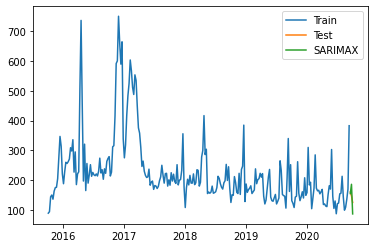

Current product:  10197
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96870D+00    |proj g|=  6.65887D-01


 This problem is unconstrained.



At iterate    5    f=  5.72156D+00    |proj g|=  2.94702D-02

At iterate   10    f=  5.70698D+00    |proj g|=  4.47533D-02

At iterate   15    f=  5.70617D+00    |proj g|=  7.26558D-03

At iterate   20    f=  5.67339D+00    |proj g|=  1.42558D-01

At iterate   25    f=  5.66356D+00    |proj g|=  9.81779D-02

At iterate   30    f=  5.66319D+00    |proj g|=  8.64421D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     40      1     0     0   9.875D-07   5.663D+00
  F =   5.6631861914224908     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  26.450300921770413


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97908D+00    |proj g|=  6.46394D-01

At iterate    5    f=  5.75258D+00    |proj g|=  4.72379D-03

At iterate   10    f=  5.74655D+00    |proj g|=  4.90507D-02

At iterate   15    f=  5.72937D+00    |proj g|=  1.12712D-02

At iterate   20    f=  5.72882D+00    |proj g|=  8.18017D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     43      1     0     0   1.033D-04   5.729D+00
  F =   5.7287643020540608     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92484D+00    |proj g|=  7.79316D-01

At iterate    5    f=  5.75642D+00    |proj g|=  4.51740D-03

At iterate   10    f=  5.74472D+00    |proj g|=  5.69699D-02

At iterate   15    f=  5.73971D+00    |proj g|=  2.16909D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   1.069D-05   5.740D+00
  F =   5.7397084381730901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2

 This problem is unconstrained.



At iterate    5    f=  5.69538D+00    |proj g|=  1.06299D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   4.876D-06   5.695D+00
  F =   5.6953757796211324     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  27.337128675539404


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.90521D+00    |proj g|=  8.18625D-01

At iterate    5    f=  5.69841D+00    |proj g|=  1.03344D-01

At iterate   10    f=  5.69188D+00    |proj g|=  1.11400D-02

At iterate   15    f=  5.67328D+00    |proj g|=  1.37409D-01

At iterate   20    f=  5.65121D+00    |proj g|=  1.34629D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   1.926D-05   5.651D+00
  F =   5.6512026969747149     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.59134D+00    |proj g|=  7.76121D-01

At iterate    5    f=  6.27566D+00    |proj g|=  2.22425D-01

At iterate   10    f=  6.26595D+00    |proj g|=  1.45811D-01

At iterate   15    f=  6.25899D+00    |proj g|=  2.75745D-02

At iterate   20    f=  6.25851D+00    |proj g|=  8.26337D-02

At iterate   25    f=  6.23798D+00    |proj g|=  6.52280D-01

At iterate   30    f=  6.22421D+00    |proj g|=  6.48763D-02

At iterate   35    f=  6.22411D+00    |proj g|=  1.98206D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.38923D+00    |proj g|=  2.93385D-01

At iterate    5    f=  6.26720D+00    |proj g|=  1.03630D-02

At iterate   10    f=  6.26107D+00    |proj g|=  9.26166D-03

At iterate   15    f=  6.25703D+00    |proj g|=  1.81463D-02

At iterate   20    f=  6.24980D+00    |proj g|=  7.58172D-04

At iterate   25    f=  6.24978D+00    |proj g|=  8.73231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     30      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.31076D+00    |proj g|=  1.12343D-01

At iterate    5    f=  6.27086D+00    |proj g|=  6.41928D-03

At iterate   10    f=  6.26040D+00    |proj g|=  3.49514D-02

At iterate   15    f=  6.23705D+00    |proj g|=  9.96821D-03

At iterate   20    f=  6.23564D+00    |proj g|=  9.55680D-03

At iterate   25    f=  6.23551D+00    |proj g|=  4.39711D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     35      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.28445D+00    |proj g|=  4.67549D-02

At iterate   10    f=  6.27129D+00    |proj g|=  4.31160D-02

At iterate   15    f=  6.27099D+00    |proj g|=  3.33849D-02

At iterate   20    f=  6.26571D+00    |proj g|=  1.68668D-01

At iterate   25    f=  6.23886D+00    |proj g|=  1.01997D-01

At iterate   30    f=  6.23694D+00    |proj g|=  1.86079D-02

At iterate   35    f=  6.23668D+00    |proj g|=  4.00720D-02

At iterate   40    f=  6.23548D+00    |proj g|=  2.49590D-02

At iterate   45    f=  6.23537D+00    |proj g|=  1.12535D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     61   

 This problem is unconstrained.



At iterate    5    f=  6.31014D+00    |proj g|=  9.00818D-03

At iterate   10    f=  6.28568D+00    |proj g|=  1.19641D-02

At iterate   15    f=  6.28519D+00    |proj g|=  4.35692D-04

At iterate   20    f=  6.28519D+00    |proj g|=  5.86099D-04

At iterate   25    f=  6.28517D+00    |proj g|=  6.36973D-04

At iterate   30    f=  6.28516D+00    |proj g|=  2.16302D-04

At iterate   35    f=  6.28516D+00    |proj g|=  4.52134D-04

At iterate   40    f=  6.28515D+00    |proj g|=  6.26682D-04

At iterate   45    f=  6.28513D+00    |proj g|=  8.44207D-04

At iterate   50    f=  6.28444D+00    |proj g|=  2.62167D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.29050D+00    |proj g|=  7.20598D-02

At iterate   10    f=  6.27188D+00    |proj g|=  3.15653D-02

At iterate   15    f=  6.26920D+00    |proj g|=  6.45367D-03

At iterate   20    f=  6.25533D+00    |proj g|=  6.19501D-02

At iterate   25    f=  6.23458D+00    |proj g|=  6.96776D-02

At iterate   30    f=  6.23340D+00    |proj g|=  3.14275D-03

At iterate   35    f=  6.23338D+00    |proj g|=  2.18334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     51      1     0     0   1.488D-05   6.233D+00
  F =   6.2333828798024511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97032D+00    |proj g|=  6.64465D-01

At iterate    5    f=  5.73998D+00    |proj g|=  2.17492D-01

At iterate   10    f=  5.71180D+00    |proj g|=  1.69723D-01

At iterate   15    f=  5.70287D+00    |proj g|=  4.15008D-02

At iterate   20    f=  5.69109D+00    |proj g|=  7.45179D-03

At iterate   25    f=  5.69003D+00    |proj g|=  4.58935D-02

At iterate   30    f=  5.65878D+00    |proj g|=  9.23641D-02

At iterate   35    f=  5.65531D+00    |proj g|=  5.61284D-03

At iterate   40    f=  5.65522D+00    |proj g|=  6.73159D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  5.74311D+00    |proj g|=  9.96098D-02

At iterate   10    f=  5.72243D+00    |proj g|=  1.98586D-01

At iterate   15    f=  5.69760D+00    |proj g|=  7.35286D-02

At iterate   20    f=  5.69682D+00    |proj g|=  6.44155D-03

At iterate   25    f=  5.67898D+00    |proj g|=  1.54966D-01

At iterate   30    f=  5.66182D+00    |proj g|=  8.21159D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     43      1     0     0   2.711D-05   5.662D+00
  F =   5.6615966731515890     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  24.36656765768783


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.38923D+00    |proj g|=  2.93385D-01

At iterate    5    f=  6.29290D+00    |proj g|=  8.75881D-02

At iterate   10    f=  6.26786D+00    |proj g|=  8.33522D-02

At iterate   15    f=  6.26725D+00    |proj g|=  7.89603D-02

At iterate   20    f=  6.26562D+00    |proj g|=  1.53453D-01

At iterate   25    f=  6.26476D+00    |proj g|=  1.72585D-02

At iterate   30    f=  6.26334D+00    |proj g|=  2.04743D-01

At iterate   35    f=  6.26187D+00    |proj g|=  1.33049D-02

At iterate   40    f=  6.26067D+00    |proj g|=  4.35934D-03

At iterate   45    f=  6.26037D+00    |proj g|=  8.86989D-02

At iterate   50    f=  6.25620D+00    |proj g|=  5.92199D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.68735D+00    |proj g|=  9.63873D-02

At iterate   10    f=  5.67331D+00    |proj g|=  7.56780D-02

At iterate   15    f=  5.66611D+00    |proj g|=  1.11772D-02

At iterate   20    f=  5.66154D+00    |proj g|=  1.33640D-01

At iterate   25    f=  5.65122D+00    |proj g|=  6.06535D-03

At iterate   30    f=  5.65119D+00    |proj g|=  9.67049D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     41      1     0     0   9.670D-06   5.651D+00
  F =   5.6511906616774530     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  24.59337415629366
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



At iterate    5    f=  5.71363D+00    |proj g|=  6.93927D-02

At iterate   10    f=  5.70979D+00    |proj g|=  2.62412D-02

At iterate   15    f=  5.69006D+00    |proj g|=  1.61392D-01

At iterate   20    f=  5.66522D+00    |proj g|=  5.22418D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   6.558D-06   5.665D+00
  F =   5.6652221041630328     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  26.128575217793752


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.32075D+00    |proj g|=  9.67750D-02

At iterate    5    f=  6.31014D+00    |proj g|=  9.00818D-03

At iterate   10    f=  6.28568D+00    |proj g|=  1.19641D-02

At iterate   15    f=  6.28519D+00    |proj g|=  4.35692D-04

At iterate   20    f=  6.28519D+00    |proj g|=  5.86099D-04

At iterate   25    f=  6.28517D+00    |proj g|=  6.36973D-04

At iterate   30    f=  6.28516D+00    |proj g|=  2.16302D-04

At iterate   35    f=  6.28516D+00    |proj g|=  4.52134D-04

At iterate   40    f=  6.28515D+00    |proj g|=  6.26682D-04

At iterate   45    f=  6.28513D+00    |proj g|=  8.44207D-04

At iterate   50    f=  6.28444D+00    |proj g|=  2.62167D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

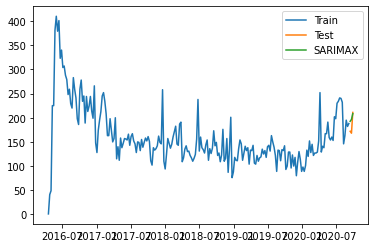

Current product:  16527
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21226D+00    |proj g|=  3.31978D-02


 This problem is unconstrained.



At iterate    5    f=  8.21034D+00    |proj g|=  1.58818D-03

At iterate   10    f=  8.21033D+00    |proj g|=  1.35673D-03

At iterate   15    f=  8.20988D+00    |proj g|=  1.64866D-02

At iterate   20    f=  8.20012D+00    |proj g|=  3.53263D-02

At iterate   25    f=  8.19542D+00    |proj g|=  5.78649D-03

At iterate   30    f=  8.19514D+00    |proj g|=  2.54233D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     40      1     0     0   3.556D-05   8.195D+00
  F =   8.1951444162794456     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  366.2621526304227
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



At iterate    5    f=  8.19389D+00    |proj g|=  8.89022D-05

At iterate   10    f=  8.19388D+00    |proj g|=  7.06597D-04

At iterate   15    f=  8.19384D+00    |proj g|=  2.60163D-03

At iterate   20    f=  8.19002D+00    |proj g|=  3.36106D-02

At iterate   25    f=  8.18829D+00    |proj g|=  4.24304D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     28      1     0     0   5.325D-05   8.188D+00
  F =   8.1882888176667414     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  354.8477865758602
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate    5    f=  8.19389D+00    |proj g|=  8.89738D-05

At iterate   10    f=  8.19388D+00    |proj g|=  8.44275D-04

At iterate   15    f=  8.19367D+00    |proj g|=  9.29836D-03

At iterate   20    f=  8.19013D+00    |proj g|=  2.72695D-02

At iterate   25    f=  8.18829D+00    |proj g|=  1.72590D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     31      1     0     0   7.437D-05   8.188D+00
  F =   8.1882884517754384     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  354.8496697647839
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate   20    f=  7.99357D+00    |proj g|=  1.34093D-02

At iterate   25    f=  7.90081D+00    |proj g|=  1.36207D-02

At iterate   30    f=  7.85357D+00    |proj g|=  7.98679D-03

At iterate   35    f=  7.81787D+00    |proj g|=  1.69293D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     47      1     0     0   2.627D-06   7.818D+00
  F =   7.8178722073699101     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  388.6905464695579
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate    0    f=  8.21006D+00    |proj g|=  4.59031D-02

At iterate    5    f=  8.20060D+00    |proj g|=  1.21971D-03

At iterate   10    f=  8.20042D+00    |proj g|=  1.35258D-04

At iterate   15    f=  8.20041D+00    |proj g|=  1.50642D-03

At iterate   20    f=  8.19834D+00    |proj g|=  3.26621D-02

At iterate   25    f=  8.18934D+00    |proj g|=  3.81149D-02

At iterate   30    f=  8.18837D+00    |proj g|=  4.64288D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     34      1     0     0   3.429D-05   8.188D+00
  F =   8.1883728612014401     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.26918D+00    |proj g|=  6.52857D-05

At iterate   10    f=  8.26918D+00    |proj g|=  6.58485D-04

At iterate   15    f=  8.26870D+00    |proj g|=  6.30062D-03

At iterate   20    f=  8.26064D+00    |proj g|=  6.38346D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   3.476D-05   8.261D+00
  F =   8.2606430949076231     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  358.5474102151959


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27033D+00    |proj g|=  3.14465D-02

At iterate    5    f=  8.26812D+00    |proj g|=  2.08125D-04

At iterate   10    f=  8.26812D+00    |proj g|=  2.55148D-04

At iterate   15    f=  8.26810D+00    |proj g|=  2.59741D-04

At iterate   20    f=  8.26807D+00    |proj g|=  2.02862D-03

At iterate   25    f=  8.26362D+00    |proj g|=  1.89203D-02

At iterate   30    f=  8.26056D+00    |proj g|=  1.55421D-04

At iterate   35    f=  8.26045D+00    |proj g|=  2.60602D-04

At iterate   40    f=  8.25070D+00    |proj g|=  1.96391D-02

At iterate   45    f=  8.19060D+00    |proj g|=  1.03917D-02

At iterate   50    f=  8.17779D+00    |proj g|=  1.62330D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27138D+00    |proj g|=  3.14450D-02

At iterate    5    f=  8.26918D+00    |proj g|=  6.52840D-05

At iterate   10    f=  8.26918D+00    |proj g|=  5.64713D-04

At iterate   15    f=  8.26913D+00    |proj g|=  2.33656D-03

At iterate   20    f=  8.26542D+00    |proj g|=  1.98904D-02

At iterate   25    f=  8.26063D+00    |proj g|=  1.97875D-04

At iterate   30    f=  8.26063D+00    |proj g|=  5.35910D-04

At iterate   35    f=  8.26054D+00    |proj g|=  5.60648D-03

At iterate   40    f=  8.26036D+00    |proj g|=  7.79962D-04

At iterate   45    f=  8.26034D+00    |proj g|=  5.88214D-05

At iterate   50    f=  8.26023D+00    |proj g|=  1.92515D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27138D+00    |proj g|=  3.14450D-02

At iterate    5    f=  8.26918D+00    |proj g|=  6.52841D-05

At iterate   10    f=  8.26918D+00    |proj g|=  6.38929D-04

At iterate   15    f=  8.26912D+00    |proj g|=  2.87469D-03

At iterate   20    f=  8.26343D+00    |proj g|=  2.49886D-02

At iterate   25    f=  8.26063D+00    |proj g|=  1.19207D-04

At iterate   30    f=  8.26063D+00    |proj g|=  6.55631D-04

At iterate   35    f=  8.26038D+00    |proj g|=  6.30568D-03

At iterate   40    f=  8.26030D+00    |proj g|=  1.35843D-04

At iterate   45    f=  8.26029D+00    |proj g|=  1.33161D-03

At iterate   50    f=  8.25941D+00    |proj g|=  2.02706D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.26731D+00    |proj g|=  2.39612D-02

At iterate    5    f=  8.26590D+00    |proj g|=  7.76428D-05

At iterate   10    f=  8.26589D+00    |proj g|=  1.20760D-03

At iterate   15    f=  8.26577D+00    |proj g|=  7.76802D-03

At iterate   20    f=  8.26024D+00    |proj g|=  5.34159D-03

At iterate   25    f=  8.25976D+00    |proj g|=  3.80789D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     30      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27138D+00    |proj g|=  3.14450D-02

At iterate    5    f=  8.26828D+00    |proj g|=  6.27605D-04

At iterate   10    f=  8.26827D+00    |proj g|=  4.41686D-04

At iterate   15    f=  8.26826D+00    |proj g|=  1.06600D-04

At iterate   20    f=  8.26825D+00    |proj g|=  1.47348D-03

At iterate   25    f=  8.26813D+00    |proj g|=  2.12844D-03

At iterate   30    f=  8.26127D+00    |proj g|=  1.06401D-02

At iterate   35    f=  8.26042D+00    |proj g|=  8.40675D-03

At iterate   40    f=  8.25998D+00    |proj g|=  6.41525D-04

At iterate   45    f=  8.25995D+00    |proj g|=  1.23878D-03

At iterate   50    f=  8.25973D+00    |proj g|=  5.01072D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21226D+00    |proj g|=  4.81854D-02

At iterate    5    f=  8.20826D+00    |proj g|=  9.37035D-04

At iterate   10    f=  8.20826D+00    |proj g|=  5.71941D-04

At iterate   15    f=  8.20805D+00    |proj g|=  9.07966D-03

At iterate   20    f=  8.19083D+00    |proj g|=  1.16409D-02

At iterate   25    f=  8.19045D+00    |proj g|=  1.87088D-03

At iterate   30    f=  8.19045D+00    |proj g|=  3.46224D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  8.20826D+00    |proj g|=  9.34816D-04

At iterate   10    f=  8.20826D+00    |proj g|=  5.72554D-04

At iterate   15    f=  8.20804D+00    |proj g|=  9.90684D-03

At iterate   20    f=  8.19789D+00    |proj g|=  5.87921D-02

At iterate   25    f=  8.19146D+00    |proj g|=  1.88442D-02

At iterate   30    f=  8.19044D+00    |proj g|=  6.22025D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     40      1     0     0   3.791D-05   8.190D+00
  F =   8.1904409492052448     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  359.79527587066053
RUNNING THE L-BFGS-B CODE

 This problem is unconstrained.



At iterate    5    f=  8.26812D+00    |proj g|=  2.09617D-04

At iterate   10    f=  8.26812D+00    |proj g|=  2.27120D-04

At iterate   15    f=  8.26811D+00    |proj g|=  4.22967D-04

At iterate   20    f=  8.26809D+00    |proj g|=  1.97952D-03

At iterate   25    f=  8.26652D+00    |proj g|=  1.59895D-02

At iterate   30    f=  8.26058D+00    |proj g|=  3.19015D-03

At iterate   35    f=  8.26051D+00    |proj g|=  8.07402D-05

At iterate   40    f=  8.26039D+00    |proj g|=  1.53176D-03

At iterate   45    f=  8.26030D+00    |proj g|=  4.27265D-05

At iterate   50    f=  8.25914D+00    |proj g|=  3.09444D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.19562D+00    |proj g|=  1.12221D-02

At iterate   10    f=  8.19531D+00    |proj g|=  5.41278D-04

At iterate   15    f=  8.19528D+00    |proj g|=  5.04923D-04

At iterate   20    f=  8.19488D+00    |proj g|=  1.01549D-02

At iterate   25    f=  8.18937D+00    |proj g|=  4.81152D-03

At iterate   30    f=  8.18860D+00    |proj g|=  1.09151D-02

At iterate   35    f=  8.18684D+00    |proj g|=  1.09212D-03

At iterate   40    f=  8.18682D+00    |proj g|=  2.01494D-03

At iterate   45    f=  8.18677D+00    |proj g|=  4.67759D-04

At iterate   50    f=  8.18676D+00    |proj g|=  3.10052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.21205D+00    |proj g|=  7.82885D-04

At iterate   10    f=  8.20008D+00    |proj g|=  2.66262D-02

At iterate   15    f=  8.19679D+00    |proj g|=  7.95802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   3.631D-05   8.197D+00
  F =   8.1967595610170090     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  373.06728077222635
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21272D+00    |proj

 This problem is unconstrained.



At iterate    5    f=  8.19562D+00    |proj g|=  1.12221D-02

At iterate   10    f=  8.19531D+00    |proj g|=  5.41278D-04

At iterate   15    f=  8.19528D+00    |proj g|=  5.04923D-04

At iterate   20    f=  8.19488D+00    |proj g|=  1.01549D-02

At iterate   25    f=  8.18937D+00    |proj g|=  4.81152D-03

At iterate   30    f=  8.18860D+00    |proj g|=  1.09151D-02

At iterate   35    f=  8.18684D+00    |proj g|=  1.09212D-03

At iterate   40    f=  8.18682D+00    |proj g|=  2.01494D-03

At iterate   45    f=  8.18677D+00    |proj g|=  4.67759D-04

At iterate   50    f=  8.18676D+00    |proj g|=  3.10052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

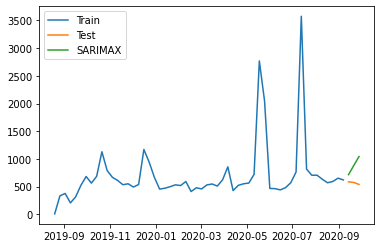

Current product:  14563


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.76024D+00    |proj g|=  3.35347D-01

At iterate    5    f=  7.66369D+00    |proj g|=  9.71237D-03

At iterate   10    f=  7.66159D+00    |proj g|=  8.92414D-03

At iterate   15    f=  7.66130D+00    |proj g|=  7.95503D-03

At iterate   20    f=  7.62103D+00    |proj g|=  1.29505D-01

At iterate   25    f=  7.57322D+00    |proj g|=  4.54341D-02

At iterate   30    f=  7.56562D+00    |proj g|=  1.65323D-02

At iterate   35    f=  7.56532D+00    |proj g|=  3.40431D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  7.65647D+00    |proj g|=  2.71693D-03

At iterate   10    f=  7.65639D+00    |proj g|=  1.62796D-03

At iterate   15    f=  7.65429D+00    |proj g|=  3.82440D-02

At iterate   20    f=  7.59271D+00    |proj g|=  9.07207D-02

At iterate   25    f=  7.57095D+00    |proj g|=  5.34988D-02

At iterate   30    f=  7.56519D+00    |proj g|=  3.22933D-02

At iterate   35    f=  7.56459D+00    |proj g|=  1.82069D-03

At iterate   40    f=  7.56448D+00    |proj g|=  5.17835D-04

At iterate   45    f=  7.56445D+00    |proj g|=  5.10905D-04

At iterate   50    f=  7.56444D+00    |proj g|=  3.08649D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.66202D+00    |proj g|=  5.50006D-03

At iterate   10    f=  7.64979D+00    |proj g|=  8.79252D-02

At iterate   15    f=  7.58698D+00    |proj g|=  1.91295D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   1.847D-05   7.587D+00
  F =   7.5865617359102053     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  12.226069328116562
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66951D+00    |proj

 This problem is unconstrained.



At iterate   10    f=  7.66896D+00    |proj g|=  1.99032D-02

At iterate   15    f=  7.66857D+00    |proj g|=  1.28502D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   1.285D-06   7.669D+00
  F =   7.6685695929297415     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  13.944473779192638
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.67548D+00    |proj g|=  4.73604D-02


 This problem is unconstrained.



At iterate    5    f=  7.66906D+00    |proj g|=  3.42441D-02

At iterate   10    f=  7.66078D+00    |proj g|=  1.89456D-03

At iterate   15    f=  7.66026D+00    |proj g|=  1.40486D-02

At iterate   20    f=  7.60734D+00    |proj g|=  3.68968D-02

At iterate   25    f=  7.59467D+00    |proj g|=  6.38400D-03

At iterate   30    f=  7.58381D+00    |proj g|=  1.43907D-01

At iterate   35    f=  7.56698D+00    |proj g|=  5.06103D-03

At iterate   40    f=  7.56697D+00    |proj g|=  5.53800D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     58      1     0     0   5.271D-05   7.567D+00
  F =   7.56696687994

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.81929D+00    |proj g|=  2.44387D-01

At iterate    5    f=  7.76654D+00    |proj g|=  5.89261D-02

At iterate   10    f=  7.76266D+00    |proj g|=  7.75350D-04

At iterate   15    f=  7.76203D+00    |proj g|=  1.69313D-02

At iterate   20    f=  7.69921D+00    |proj g|=  2.64036D-01

At iterate   25    f=  7.59102D+00    |proj g|=  2.12246D-02

At iterate   30    f=  7.59066D+00    |proj g|=  1.91425D-03

At iterate   35    f=  7.59064D+00    |proj g|=  3.00995D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89282D+00    |proj g|=  4.83881D-01

At iterate    5    f=  7.74490D+00    |proj g|=  7.75846D-03

At iterate   10    f=  7.74335D+00    |proj g|=  7.39641D-04

At iterate   15    f=  7.74270D+00    |proj g|=  7.39924D-03

At iterate   20    f=  7.68262D+00    |proj g|=  6.27045D-02

At iterate   25    f=  7.63920D+00    |proj g|=  5.68824D-03

At iterate   30    f=  7.63575D+00    |proj g|=  3.03651D-02

At iterate   35    f=  7.63295D+00    |proj g|=  6.33963D-03

At iterate   40    f=  7.63211D+00    |proj g|=  3.40627D-03

At iterate   45    f=  7.63146D+00    |proj g|=  7.19303D-03

At iterate   50    f=  7.63114D+00    |proj g|=  4.12326D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.85753D+00    |proj g|=  3.03646D-01

At iterate    5    f=  7.77958D+00    |proj g|=  2.32041D-02

At iterate   10    f=  7.77244D+00    |proj g|=  7.41212D-04

At iterate   15    f=  7.77174D+00    |proj g|=  1.23506D-02

At iterate   20    f=  7.70318D+00    |proj g|=  1.15536D-01

At iterate   25    f=  7.65566D+00    |proj g|=  1.95812D-02

At iterate   30    f=  7.65160D+00    |proj g|=  2.31237D-03

At iterate   35    f=  7.65084D+00    |proj g|=  1.95569D-03

At iterate   40    f=  7.65066D+00    |proj g|=  5.19898D-04

At iterate   45    f=  7.65062D+00    |proj g|=  1.47241D-03

At iterate   50    f=  7.65059D+00    |proj g|=  8.49461D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.77370D+00    |proj g|=  2.50490D-02

At iterate   10    f=  7.76544D+00    |proj g|=  7.82319D-04

At iterate   15    f=  7.76527D+00    |proj g|=  7.15465D-03

At iterate   20    f=  7.65374D+00    |proj g|=  1.59357D-01

At iterate   25    f=  7.58054D+00    |proj g|=  6.35473D-02

At iterate   30    f=  7.54944D+00    |proj g|=  2.91413D-02

At iterate   35    f=  7.54860D+00    |proj g|=  1.10419D-02

At iterate   40    f=  7.54783D+00    |proj g|=  4.28773D-03

At iterate   45    f=  7.54766D+00    |proj g|=  2.20513D-03

At iterate   50    f=  7.54755D+00    |proj g|=  3.13688D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83270D+00    |proj g|=  3.07579D-01

At iterate    5    f=  7.76832D+00    |proj g|=  1.20858D-02

At iterate   10    f=  7.76814D+00    |proj g|=  2.08761D-03

At iterate   15    f=  7.76413D+00    |proj g|=  3.83915D-02

At iterate   20    f=  7.63534D+00    |proj g|=  1.47599D-02

At iterate   25    f=  7.63367D+00    |proj g|=  4.22663D-04

At iterate   30    f=  7.63365D+00    |proj g|=  5.04424D-03

At iterate   35    f=  7.63336D+00    |proj g|=  1.29049D-03

At iterate   40    f=  7.63320D+00    |proj g|=  1.78708D-03

At iterate   45    f=  7.63312D+00    |proj g|=  1.49059D-03

At iterate   50    f=  7.63294D+00    |proj g|=  2.89068D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.75696D+00    |proj g|=  2.11735D-02

At iterate   10    f=  7.75375D+00    |proj g|=  7.92741D-04

At iterate   15    f=  7.75352D+00    |proj g|=  6.13060D-03

At iterate   20    f=  7.72481D+00    |proj g|=  6.65977D-02

At iterate   25    f=  7.63790D+00    |proj g|=  7.36052D-02

At iterate   30    f=  7.55539D+00    |proj g|=  5.75899D-02

At iterate   35    f=  7.55216D+00    |proj g|=  9.12811D-03

At iterate   40    f=  7.55102D+00    |proj g|=  6.07090D-03

At iterate   45    f=  7.55068D+00    |proj g|=  1.71976D-03

At iterate   50    f=  7.55061D+00    |proj g|=  1.16700D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.64527D+00    |proj g|=  1.21881D-02

At iterate   10    f=  7.64467D+00    |proj g|=  2.11746D-03

At iterate   15    f=  7.64378D+00    |proj g|=  1.61138D-02

At iterate   20    f=  7.64339D+00    |proj g|=  2.20899D-03

At iterate   25    f=  7.64202D+00    |proj g|=  3.23002D-02

At iterate   30    f=  7.59090D+00    |proj g|=  6.98372D-02

At iterate   35    f=  7.57353D+00    |proj g|=  2.39121D-02

At iterate   40    f=  7.56969D+00    |proj g|=  7.73399D-03

At iterate   45    f=  7.56866D+00    |proj g|=  1.03582D-03

At iterate   50    f=  7.56845D+00    |proj g|=  8.58940D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.65462D+00    |proj g|=  1.46083D-02

At iterate    5    f=  7.65019D+00    |proj g|=  4.55353D-02

At iterate   10    f=  7.64804D+00    |proj g|=  7.22447D-04

At iterate   15    f=  7.64723D+00    |proj g|=  1.40051D-02

At iterate   20    f=  7.59946D+00    |proj g|=  7.29894D-02

At iterate   25    f=  7.59400D+00    |proj g|=  1.33137D-02

At iterate   30    f=  7.55964D+00    |proj g|=  3.27925D-02

At iterate   35    f=  7.55844D+00    |proj g|=  7.09068D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  7.73856D+00    |proj g|=  1.29924D-02

At iterate   10    f=  7.73563D+00    |proj g|=  2.69327D-03

At iterate   15    f=  7.73553D+00    |proj g|=  3.38092D-03

At iterate   20    f=  7.72273D+00    |proj g|=  3.83594D-02

At iterate   25    f=  7.56265D+00    |proj g|=  4.19053D-02

At iterate   30    f=  7.54928D+00    |proj g|=  8.38459D-03

At iterate   35    f=  7.54534D+00    |proj g|=  4.39654D-03

At iterate   40    f=  7.54510D+00    |proj g|=  3.29144D-03

At iterate   45    f=  7.54476D+00    |proj g|=  5.35442D-03

At iterate   50    f=  7.54460D+00    |proj g|=  3.38149D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.61744D+00    |proj g|=  9.38542D-03

At iterate   10    f=  7.61521D+00    |proj g|=  7.05600D-04

At iterate   15    f=  7.61496D+00    |proj g|=  8.62570D-03

At iterate   20    f=  7.58792D+00    |proj g|=  9.73267D-02

At iterate   25    f=  7.56619D+00    |proj g|=  1.62403D-02

At iterate   30    f=  7.54509D+00    |proj g|=  2.30897D-02

At iterate   35    f=  7.54450D+00    |proj g|=  4.07208D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     41      1     0     0   4.072D-05   7.544D+00
  F =   7.5444957505743542     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75746D+00    |proj g|=  3.49347D-01

At iterate    5    f=  7.66389D+00    |proj g|=  1.77666D-03

At iterate   10    f=  7.66375D+00    |proj g|=  3.91261D-03

At iterate   15    f=  7.61771D+00    |proj g|=  1.25157D-01

At iterate   20    f=  7.59439D+00    |proj g|=  2.86075D-03

At iterate   25    f=  7.59436D+00    |proj g|=  9.01826D-04

At iterate   30    f=  7.59419D+00    |proj g|=  1.92413D-03

At iterate   35    f=  7.59411D+00    |proj g|=  9.66889D-04

At iterate   40    f=  7.59391D+00    |proj g|=  7.45268D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.81929D+00    |proj g|=  2.44387D-01

At iterate    5    f=  7.76654D+00    |proj g|=  5.89261D-02

At iterate   10    f=  7.76266D+00    |proj g|=  7.75350D-04

At iterate   15    f=  7.76203D+00    |proj g|=  1.69313D-02

At iterate   20    f=  7.69921D+00    |proj g|=  2.64036D-01

At iterate   25    f=  7.59102D+00    |proj g|=  2.12246D-02

At iterate   30    f=  7.59066D+00    |proj g|=  1.91425D-03

At iterate   35    f=  7.59064D+00    |proj g|=  3.00995D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

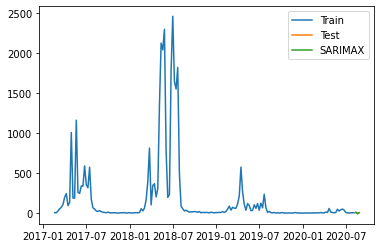

Current product:  9541
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94798D+00    |proj g|=  2.68137D-02


 This problem is unconstrained.



At iterate    5    f=  6.63456D+00    |proj g|=  7.27425D-02

At iterate   10    f=  6.52373D+00    |proj g|=  2.61395D-02

At iterate   15    f=  6.52347D+00    |proj g|=  7.82812D-03

At iterate   20    f=  6.52166D+00    |proj g|=  6.75944D-02

At iterate   25    f=  6.51114D+00    |proj g|=  3.97191D-02

At iterate   30    f=  6.50635D+00    |proj g|=  5.15328D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     88      2     0     0   5.617D-05   6.506D+00
  F =   6.5063486566315918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  8.39148562888862


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00225D+00    |proj g|=  3.84995D-02

At iterate    5    f=  6.63040D+00    |proj g|=  1.15806D-01

At iterate   10    f=  6.59627D+00    |proj g|=  4.50862D-03

At iterate   15    f=  6.59624D+00    |proj g|=  7.15378D-03

At iterate   20    f=  6.59330D+00    |proj g|=  7.96697D-02

At iterate   25    f=  6.58001D+00    |proj g|=  2.06748D-02

At iterate   30    f=  6.57982D+00    |proj g|=  1.87846D-03

At iterate   35    f=  6.57976D+00    |proj g|=  2.79843D-03

At iterate   40    f=  6.57974D+00    |proj g|=  9.51943D-05

At iterate   45    f=  6.57974D+00    |proj g|=  2.87627D-04

At iterate   50    f=  6.57963D+00    |proj g|=  2.51176D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.61652D+00    |proj g|=  4.48863D-03

At iterate   10    f=  6.61650D+00    |proj g|=  7.76690D-03

At iterate   15    f=  6.61524D+00    |proj g|=  7.84450D-02

At iterate   20    f=  6.61258D+00    |proj g|=  1.77744D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     24      1     0     0   3.726D-05   6.613D+00
  F =   6.6125819398930599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1.1410701340904283
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exac

 This problem is unconstrained.



At iterate    5    f=  6.55968D+00    |proj g|=  6.26396D-04

At iterate   10    f=  6.55966D+00    |proj g|=  1.10103D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   3.228D-05   6.560D+00
  F =   6.5596564546568983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1.1356177579404803
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.59169D+00    |proj g|=  3.75716D-01


 This problem is unconstrained.



At iterate    5    f=  6.53911D+00    |proj g|=  1.00932D-02

At iterate   10    f=  6.53668D+00    |proj g|=  1.15121D-02

At iterate   15    f=  6.53638D+00    |proj g|=  3.38221D-03

At iterate   20    f=  6.53418D+00    |proj g|=  2.80560D-02

At iterate   25    f=  6.53337D+00    |proj g|=  2.23653D-03

At iterate   30    f=  6.53012D+00    |proj g|=  4.48902D-03

At iterate   35    f=  6.53009D+00    |proj g|=  8.91987D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     51      1     0     0   2.141D-05   6.530D+00
  F =   6.5300915497044763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03263D+00    |proj g|=  1.88545D-01

At iterate    5    f=  6.87241D+00    |proj g|=  3.00792D-03

At iterate   10    f=  6.87205D+00    |proj g|=  4.19688D-03

At iterate   15    f=  6.86779D+00    |proj g|=  8.04479D-02

At iterate   20    f=  6.85986D+00    |proj g|=  2.84889D-03

At iterate   25    f=  6.85788D+00    |proj g|=  6.38826D-02

At iterate   30    f=  6.85398D+00    |proj g|=  1.71109D-02

At iterate   35    f=  6.85355D+00    |proj g|=  6.67017D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.91066D+00    |proj g|=  1.17381D-01

At iterate    5    f=  6.87235D+00    |proj g|=  1.07990D-02

At iterate   10    f=  6.86849D+00    |proj g|=  1.59626D-03

At iterate   15    f=  6.86777D+00    |proj g|=  3.88798D-03

At iterate   20    f=  6.85835D+00    |proj g|=  1.27525D-02

At iterate   25    f=  6.84879D+00    |proj g|=  1.22060D-02

At iterate   30    f=  6.84619D+00    |proj g|=  1.35794D-02

At iterate   35    f=  6.84540D+00    |proj g|=  2.54895D-03

At iterate   40    f=  6.84529D+00    |proj g|=  4.64838D-04

At iterate   45    f=  6.84526D+00    |proj g|=  1.32795D-03

At iterate   50    f=  6.84525D+00    |proj g|=  1.37160D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.89929D+00    |proj g|=  1.11250D-01

At iterate    5    f=  6.86660D+00    |proj g|=  2.96523D-03

At iterate   10    f=  6.86499D+00    |proj g|=  9.17576D-03

At iterate   15    f=  6.84219D+00    |proj g|=  2.16205D-02

At iterate   20    f=  6.83667D+00    |proj g|=  2.39923D-03

At iterate   25    f=  6.83611D+00    |proj g|=  2.63785D-03

At iterate   30    f=  6.83603D+00    |proj g|=  4.82561D-04

At iterate   35    f=  6.83601D+00    |proj g|=  4.88320D-04

At iterate   40    f=  6.83560D+00    |proj g|=  8.78214D-03

At iterate   45    f=  6.83433D+00    |proj g|=  6.24047D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.89929D+00    |proj g|=  1.37080D-01

At iterate    5    f=  6.86805D+00    |proj g|=  2.15751D-02

At iterate   10    f=  6.86555D+00    |proj g|=  1.96834D-03

At iterate   15    f=  6.86507D+00    |proj g|=  4.91344D-03

At iterate   20    f=  6.86425D+00    |proj g|=  3.09535D-02

At iterate   25    f=  6.84043D+00    |proj g|=  4.82538D-02

At iterate   30    f=  6.83631D+00    |proj g|=  4.75927D-02

At iterate   35    f=  6.83564D+00    |proj g|=  8.27710D-03

At iterate   40    f=  6.83549D+00    |proj g|=  3.19353D-03

At iterate   45    f=  6.83546D+00    |proj g|=  2.66800D-03

At iterate   50    f=  6.83546D+00    |proj g|=  3.28650D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.91205D+00    |proj g|=  1.43007D-03

At iterate   10    f=  6.91030D+00    |proj g|=  1.10485D-02

At iterate   15    f=  6.88698D+00    |proj g|=  1.53411D-02

At iterate   20    f=  6.88673D+00    |proj g|=  1.55771D-04

At iterate   25    f=  6.88669D+00    |proj g|=  2.21508D-03

At iterate   30    f=  6.88659D+00    |proj g|=  2.78722D-03

At iterate   35    f=  6.88535D+00    |proj g|=  4.83924D-03

At iterate   40    f=  6.88480D+00    |proj g|=  1.96740D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     49      1     0     0   5.722D-07   6.885D+00
  F =   6.88480461046

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11015D+00    |proj g|=  1.70607D-01

At iterate    5    f=  6.87635D+00    |proj g|=  5.62333D-02

At iterate   10    f=  6.85625D+00    |proj g|=  6.16028D-03

At iterate   15    f=  6.85571D+00    |proj g|=  1.48923D-03

At iterate   20    f=  6.85221D+00    |proj g|=  6.25442D-02

At iterate   25    f=  6.83437D+00    |proj g|=  3.37761D-02

At iterate   30    f=  6.83419D+00    |proj g|=  6.01866D-04

At iterate   35    f=  6.83417D+00    |proj g|=  1.26551D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92749D+00    |proj g|=  7.96520D-02

At iterate    5    f=  6.90830D+00    |proj g|=  6.60796D-02

At iterate   10    f=  6.53194D+00    |proj g|=  1.19631D-01

At iterate   15    f=  6.51584D+00    |proj g|=  2.02966D-02

At iterate   20    f=  6.51548D+00    |proj g|=  2.90412D-03

At iterate   25    f=  6.51370D+00    |proj g|=  2.79597D-02

At iterate   30    f=  6.50678D+00    |proj g|=  1.29854D-02

At iterate   35    f=  6.50600D+00    |proj g|=  1.33320D-02

At iterate   40    f=  6.50343D+00    |proj g|=  5.84452D-03

At iterate   45    f=  6.50319D+00    |proj g|=  3.00973D-03

At iterate   50    f=  6.50309D+00    |proj g|=  2.04271D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.53323D+00    |proj g|=  2.61690D-02

At iterate   10    f=  6.53313D+00    |proj g|=  2.55877D-03

At iterate   15    f=  6.53255D+00    |proj g|=  3.00769D-02

At iterate   20    f=  6.52768D+00    |proj g|=  9.69876D-03

At iterate   25    f=  6.52761D+00    |proj g|=  2.12057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     30      1     0     0   3.293D-05   6.528D+00
  F =   6.5276117556638704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  0.8670382866799935


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.91066D+00    |proj g|=  1.24428D-01

At iterate    5    f=  6.87676D+00    |proj g|=  2.37829D-02

At iterate   10    f=  6.86909D+00    |proj g|=  2.99901D-02

At iterate   15    f=  6.86794D+00    |proj g|=  7.11921D-03

At iterate   20    f=  6.86759D+00    |proj g|=  4.94497D-03

At iterate   25    f=  6.86662D+00    |proj g|=  3.00472D-02

At iterate   30    f=  6.85676D+00    |proj g|=  4.22506D-02

At iterate   35    f=  6.84593D+00    |proj g|=  6.10134D-02

At iterate   40    f=  6.84517D+00    |proj g|=  6.54626D-03

At iterate   45    f=  6.84505D+00    |proj g|=  2.81404D-02

At iterate   50    f=  6.84477D+00    |proj g|=  4.59524D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.54014D+00    |proj g|=  2.17641D-02

At iterate   10    f=  6.53104D+00    |proj g|=  1.57322D-02

At iterate   15    f=  6.53052D+00    |proj g|=  3.52392D-03

At iterate   20    f=  6.53046D+00    |proj g|=  2.96754D-03

At iterate   25    f=  6.52905D+00    |proj g|=  6.91815D-02

At iterate   30    f=  6.52677D+00    |proj g|=  4.57825D-04

At iterate   35    f=  6.52676D+00    |proj g|=  4.46374D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     49      1     0     0   1.999D-05   6.527D+00
  F =   6.5267549645770337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94976D+00    |proj g|=  2.53907D-02

At iterate    5    f=  6.52965D+00    |proj g|=  3.34642D-02

At iterate   10    f=  6.52739D+00    |proj g|=  8.84460D-03

At iterate   15    f=  6.52692D+00    |proj g|=  3.96030D-02

At iterate   20    f=  6.51576D+00    |proj g|=  1.93829D-01

At iterate   25    f=  6.50877D+00    |proj g|=  4.06134D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     47      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03263D+00    |proj g|=  1.88545D-01

At iterate    5    f=  6.87241D+00    |proj g|=  3.00792D-03

At iterate   10    f=  6.87205D+00    |proj g|=  4.19688D-03

At iterate   15    f=  6.86779D+00    |proj g|=  8.04479D-02

At iterate   20    f=  6.85986D+00    |proj g|=  2.84889D-03

At iterate   25    f=  6.85788D+00    |proj g|=  6.38826D-02

At iterate   30    f=  6.85398D+00    |proj g|=  1.71109D-02

At iterate   35    f=  6.85355D+00    |proj g|=  6.67017D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

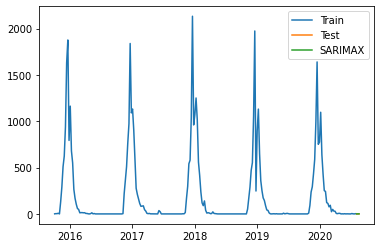

Total RMSE of top 10 selling products:  453.2084141477028 , total mape:  inf
selected horizon:  12
Current product:  14238


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30409D+00    |proj g|=  6.86833D-02
  ys=-1.556E-03  -gs= 1.397E-01 BFGS update SKIPPED

At iterate    5    f=  5.82711D+00    |proj g|=  1.21878D-01

At iterate   10    f=  5.82653D+00    |proj g|=  3.61089D-02

At iterate   15    f=  5.82456D+00    |proj g|=  8.13899D-02

At iterate   20    f=  5.82108D+00    |proj g|=  8.94951D-03

At iterate   25    f=  5.82093D+00    |proj g|=  2.13076D-02

At iterate   30    f=  5.81488D+00    |proj g|=  1.78084D-01

At iterate   35    f=  5.80545D+00    |proj g|=  8.12415D-02

At iterate   40    f=  5.80539D+00    |proj g|=  1.63502D-02
  ys=-1.390E-06  -gs= 1.015E-03 BFGS update SKIPPED

At iterate   45    f=  5.79620D+00    |proj g|=  2.98659D-01

At iterate   50    f=  5.79462D+00    |proj g|=  5.17378D-02

           * * *

Tit   = total number of iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33833D+00    |proj g|=  7.15250D-02

At iterate    5    f=  5.97066D+00    |proj g|=  8.14296D-01

At iterate   10    f=  5.88687D+00    |proj g|=  6.50998D-02

At iterate   15    f=  5.88361D+00    |proj g|=  4.31302D-03

At iterate   20    f=  5.87705D+00    |proj g|=  3.42752D-01

At iterate   25    f=  5.86561D+00    |proj g|=  6.60665D-03

At iterate   30    f=  5.86558D+00    |proj g|=  5.64601D-03

At iterate   35    f=  5.86531D+00    |proj g|=  4.32009D-03

At iterate   40    f=  5.86279D+00    |proj g|=  1.15560D-02

At iterate   45    f=  5.86252D+00    |proj g|=  1.42705D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18841D+00    |proj g|=  2.81291D-01

At iterate    5    f=  5.93970D+00    |proj g|=  6.85034D-03

At iterate   10    f=  5.93965D+00    |proj g|=  2.51757D-02

At iterate   15    f=  5.93796D+00    |proj g|=  9.97742D-02

At iterate   20    f=  5.93760D+00    |proj g|=  4.20352D-04

At iterate   25    f=  5.93756D+00    |proj g|=  1.32473D-02

At iterate   30    f=  5.93573D+00    |proj g|=  1.78380D-01

At iterate   35    f=  5.93086D+00    |proj g|=  2.32310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  5.86762D+00    |proj g|=  2.04066D-03

At iterate   10    f=  5.86687D+00    |proj g|=  2.60228D-02

At iterate   15    f=  5.86013D+00    |proj g|=  4.17086D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   3.890D-06   5.860D+00
  F =   5.8601152345716079     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  32.492520087076954


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15578D+00    |proj g|=  2.74803D-01

At iterate    5    f=  5.87615D+00    |proj g|=  9.77687D-02

At iterate   10    f=  5.86435D+00    |proj g|=  4.97923D-02

At iterate   15    f=  5.86427D+00    |proj g|=  4.04554D-03

At iterate   20    f=  5.86371D+00    |proj g|=  3.94447D-02

At iterate   25    f=  5.86149D+00    |proj g|=  2.60180D-03

At iterate   30    f=  5.86148D+00    |proj g|=  1.24569D-02

At iterate   35    f=  5.86111D+00    |proj g|=  1.70964D-01

At iterate   40    f=  5.85687D+00    |proj g|=  3.41525D-01

At iterate   45    f=  5.84947D+00    |proj g|=  9.65380D-03

At iterate   50    f=  5.84899D+00    |proj g|=  1.79458D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.37542D+00    |proj g|=  1.60282D-01

At iterate   10    f=  6.37168D+00    |proj g|=  2.90801D-02

At iterate   15    f=  6.36716D+00    |proj g|=  2.70785D-01

At iterate   20    f=  6.36586D+00    |proj g|=  1.51913D-02

At iterate   25    f=  6.36557D+00    |proj g|=  9.97860D-02

At iterate   30    f=  6.35342D+00    |proj g|=  1.05837D-01

At iterate   35    f=  6.35292D+00    |proj g|=  1.08549D-01

At iterate   40    f=  6.35280D+00    |proj g|=  2.41182D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     48      1     0     0   2.412D-04   6.353D+00
  F =   6.35279842769

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.43993D+00    |proj g|=  2.35135D-01

At iterate    5    f=  6.37368D+00    |proj g|=  6.54633D-03

At iterate   10    f=  6.36850D+00    |proj g|=  1.25746D-02

At iterate   15    f=  6.36678D+00    |proj g|=  7.83588D-03

At iterate   20    f=  6.36009D+00    |proj g|=  2.03744D-02

At iterate   25    f=  6.35325D+00    |proj g|=  1.61598D-02

At iterate   30    f=  6.35255D+00    |proj g|=  6.70715D-04

At iterate   35    f=  6.35254D+00    |proj g|=  6.90667D-04

At iterate   40    f=  6.35225D+00    |proj g|=  3.69364D-03

At iterate   45    f=  6.35205D+00    |proj g|=  8.22079D-04

At iterate   50    f=  6.35198D+00    |proj g|=  2.82496D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42842D+00    |proj g|=  2.28963D-01

At iterate    5    f=  6.36916D+00    |proj g|=  1.26847D-02

At iterate   10    f=  6.36419D+00    |proj g|=  7.44581D-03

At iterate   15    f=  6.35800D+00    |proj g|=  9.72228D-03

At iterate   20    f=  6.35118D+00    |proj g|=  1.55049D-02

At iterate   25    f=  6.34013D+00    |proj g|=  6.20640D-03

At iterate   30    f=  6.34009D+00    |proj g|=  7.74463D-04

At iterate   35    f=  6.33995D+00    |proj g|=  6.28528D-03

At iterate   40    f=  6.33970D+00    |proj g|=  3.69296D-03

At iterate   45    f=  6.33549D+00    |proj g|=  6.48551D-03

At iterate   50    f=  6.33467D+00    |proj g|=  1.06375D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.37331D+00    |proj g|=  2.72724D-02

At iterate   10    f=  6.36949D+00    |proj g|=  4.06180D-02

At iterate   15    f=  6.36577D+00    |proj g|=  3.48862D-02

At iterate   20    f=  6.36433D+00    |proj g|=  3.94255D-03

At iterate   25    f=  6.36389D+00    |proj g|=  4.50879D-02

At iterate   30    f=  6.36165D+00    |proj g|=  4.01225D-02

At iterate   35    f=  6.35016D+00    |proj g|=  5.67998D-02

At iterate   40    f=  6.34145D+00    |proj g|=  3.04967D-01

At iterate   45    f=  6.34037D+00    |proj g|=  3.36567D-02

At iterate   50    f=  6.34011D+00    |proj g|=  5.59655D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.39924D+00    |proj g|=  8.88658D-03

At iterate   10    f=  6.39787D+00    |proj g|=  8.16248D-03

At iterate   15    f=  6.37788D+00    |proj g|=  1.01106D-02

At iterate   20    f=  6.37754D+00    |proj g|=  1.49999D-03

At iterate   25    f=  6.37736D+00    |proj g|=  6.53853D-04

At iterate   30    f=  6.37730D+00    |proj g|=  1.61034D-03

At iterate   35    f=  6.37701D+00    |proj g|=  5.71217D-03

At iterate   40    f=  6.37603D+00    |proj g|=  3.59831D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     46      1     0     0   9.827D-06   6.376D+00
  F =   6.37602627084

 This problem is unconstrained.



At iterate    5    f=  6.40601D+00    |proj g|=  2.64866D-01

At iterate   10    f=  6.37222D+00    |proj g|=  1.70863D-02

At iterate   15    f=  6.36684D+00    |proj g|=  3.50887D-01

At iterate   20    f=  6.36345D+00    |proj g|=  6.35876D-03

At iterate   25    f=  6.36333D+00    |proj g|=  1.62136D-02

At iterate   30    f=  6.36252D+00    |proj g|=  8.86879D-02

At iterate   35    f=  6.34769D+00    |proj g|=  1.35096D-01

At iterate   40    f=  6.34308D+00    |proj g|=  7.53050D-03

At iterate   45    f=  6.34307D+00    |proj g|=  1.11162D-03

At iterate   50    f=  6.34307D+00    |proj g|=  1.30181D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.90236D+00    |proj g|=  2.03152D-01

At iterate   10    f=  5.83717D+00    |proj g|=  2.88190D-02

At iterate   15    f=  5.82542D+00    |proj g|=  5.04366D-02

At iterate   20    f=  5.82068D+00    |proj g|=  4.96464D-03

At iterate   25    f=  5.82061D+00    |proj g|=  3.26156D-02

At iterate   30    f=  5.82017D+00    |proj g|=  1.22223D-01

At iterate   35    f=  5.80605D+00    |proj g|=  9.89880D-01

At iterate   40    f=  5.80035D+00    |proj g|=  1.19212D-02

At iterate   45    f=  5.80022D+00    |proj g|=  2.27413D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     59   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16220D+00    |proj g|=  2.72235D-01

At iterate    5    f=  5.90412D+00    |proj g|=  4.04850D-02

At iterate   10    f=  5.88019D+00    |proj g|=  4.79317D-02

At iterate   15    f=  5.87196D+00    |proj g|=  4.06659D-02

At iterate   20    f=  5.87195D+00    |proj g|=  5.04067D-03

At iterate   25    f=  5.87159D+00    |proj g|=  9.42480D-02

At iterate   30    f=  5.86945D+00    |proj g|=  3.97476D-02

At iterate   35    f=  5.86929D+00    |proj g|=  1.26810D-02

At iterate   40    f=  5.86928D+00    |proj g|=  1.51084D-03

At iterate   45    f=  5.86927D+00    |proj g|=  6.75294D-03

At iterate   50    f=  5.86792D+00    |proj g|=  2.95776D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.43993D+00    |proj g|=  2.35135D-01

At iterate    5    f=  6.37826D+00    |proj g|=  3.05526D-02

At iterate   10    f=  6.37479D+00    |proj g|=  2.78899D-02

At iterate   15    f=  6.37348D+00    |proj g|=  1.27914D-02

At iterate   20    f=  6.36887D+00    |proj g|=  2.39364D-02

At iterate   25    f=  6.36806D+00    |proj g|=  3.39865D-03

At iterate   30    f=  6.36740D+00    |proj g|=  2.85921D-02

At iterate   35    f=  6.36407D+00    |proj g|=  4.02337D-02

At iterate   40    f=  6.35417D+00    |proj g|=  3.52508D-02

At iterate   45    f=  6.35251D+00    |proj g|=  1.20191D-03

At iterate   50    f=  6.35251D+00    |proj g|=  3.29625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14495D+00    |proj g|=  2.74297D-01

At iterate    5    f=  5.88324D+00    |proj g|=  2.98504D-02

At iterate   10    f=  5.87880D+00    |proj g|=  1.13319D-02

At iterate   15    f=  5.87115D+00    |proj g|=  1.67368D-01

At iterate   20    f=  5.86053D+00    |proj g|=  5.07709D-02

At iterate   25    f=  5.86046D+00    |proj g|=  1.91908D-03

At iterate   30    f=  5.86038D+00    |proj g|=  3.18765D-02

At iterate   35    f=  5.85993D+00    |proj g|=  2.14666D-03

At iterate   40    f=  5.85987D+00    |proj g|=  2.41864D-03

At iterate   45    f=  5.85976D+00    |proj g|=  1.13516D-02

At iterate   50    f=  5.85534D+00    |proj g|=  1.06783D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.85898D+00    |proj g|=  1.52957D-01

At iterate   10    f=  5.83022D+00    |proj g|=  8.51969D-02

At iterate   15    f=  5.83012D+00    |proj g|=  5.99769D-03

At iterate   20    f=  5.82118D+00    |proj g|=  1.10246D-01

At iterate   25    f=  5.81483D+00    |proj g|=  1.19768D-02

At iterate   30    f=  5.80562D+00    |proj g|=  4.04539D-02

At iterate   35    f=  5.80559D+00    |proj g|=  2.25088D-03

At iterate   40    f=  5.80521D+00    |proj g|=  1.31135D-02

At iterate   45    f=  5.79300D+00    |proj g|=  1.56586D-02

At iterate   50    f=  5.79183D+00    |proj g|=  5.75796D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33833D+00    |proj g|=  7.15250D-02

At iterate    5    f=  5.97066D+00    |proj g|=  8.14296D-01

At iterate   10    f=  5.88687D+00    |proj g|=  6.50998D-02

At iterate   15    f=  5.88361D+00    |proj g|=  4.31302D-03

At iterate   20    f=  5.87705D+00    |proj g|=  3.42752D-01

At iterate   25    f=  5.86561D+00    |proj g|=  6.60665D-03

At iterate   30    f=  5.86558D+00    |proj g|=  5.64601D-03

At iterate   35    f=  5.86531D+00    |proj g|=  4.32009D-03

At iterate   40    f=  5.86279D+00    |proj g|=  1.15560D-02

At iterate   45    f=  5.86252D+00    |proj g|=  1.42705D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

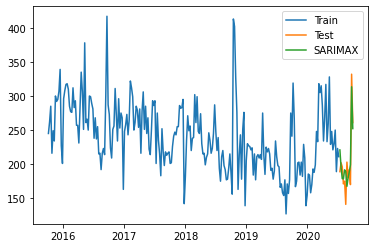

Current product:  14288


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.53218D+00    |proj g|=  9.24055D-02
  ys=-1.264E-01  -gs= 1.254E-01 BFGS update SKIPPED

At iterate    5    f=  6.17847D+00    |proj g|=  2.80671D-02

At iterate   10    f=  6.17465D+00    |proj g|=  7.20408D-02

At iterate   15    f=  6.17170D+00    |proj g|=  1.84157D-02

At iterate   20    f=  6.15858D+00    |proj g|=  1.46661D-01

At iterate   25    f=  6.13514D+00    |proj g|=  8.67547D-03

At iterate   30    f=  6.13496D+00    |proj g|=  9.80804D-04

At iterate   35    f=  6.13496D+00    |proj g|=  3.20649D-04

At iterate   40    f=  6.13494D+00    |proj g|=  1.82522D-03

At iterate   45    f=  6.13380D+00    |proj g|=  3.81716D-02

At iterate   50    f=  6.10494D+00    |proj g|=  1.00403D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.53529D+00    |proj g|=  9.41921D-02

At iterate    5    f=  6.19519D+00    |proj g|=  8.43677D-03

At iterate   10    f=  6.19296D+00    |proj g|=  5.60865D-02

At iterate   15    f=  6.16545D+00    |proj g|=  1.07642D-01

At iterate   20    f=  6.16232D+00    |proj g|=  2.46695D-03

At iterate   25    f=  6.16228D+00    |proj g|=  1.30028D-04

At iterate   30    f=  6.16226D+00    |proj g|=  2.78434D-03

At iterate   35    f=  6.15634D+00    |proj g|=  4.76778D-02

At iterate   40    f=  6.15454D+00    |proj g|=  4.30324D-03

At iterate   45    f=  6.15244D+00    |proj g|=  1.88709D-02

At iterate   50    f=  6.15160D+00    |proj g|=  8.65408D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.23343D+00    |proj g|=  4.95980D-03

At iterate   10    f=  6.23320D+00    |proj g|=  4.98424D-02

At iterate   15    f=  6.22713D+00    |proj g|=  1.79321D-01

At iterate   20    f=  6.22478D+00    |proj g|=  7.70747D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     25      1     0     0   7.707D-05   6.225D+00
  F =   6.2247819844124868     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  41.291698470644484
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exac

 This problem is unconstrained.



At iterate    5    f=  6.18058D+00    |proj g|=  2.14959D-03

At iterate   10    f=  6.18010D+00    |proj g|=  1.67917D-02

At iterate   15    f=  6.17976D+00    |proj g|=  2.93131D-03

At iterate   20    f=  6.17794D+00    |proj g|=  3.11556D-02

At iterate   25    f=  6.16561D+00    |proj g|=  5.24354D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     31      1     0     0   8.283D-06   6.165D+00
  F =   6.1650238234755772     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  41.05996737478113


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.35375D+00    |proj g|=  3.33592D-01

At iterate    5    f=  6.20919D+00    |proj g|=  1.23292D-02

At iterate   10    f=  6.20807D+00    |proj g|=  2.54669D-03

At iterate   15    f=  6.20060D+00    |proj g|=  2.11264D-01

At iterate   20    f=  6.19611D+00    |proj g|=  4.23094D-04

At iterate   25    f=  6.19608D+00    |proj g|=  2.64970D-03

At iterate   30    f=  6.19544D+00    |proj g|=  1.96568D-02

At iterate   35    f=  6.16011D+00    |proj g|=  3.88661D-02

At iterate   40    f=  6.15218D+00    |proj g|=  6.85676D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.61493D+00    |proj g|=  3.37945D-01

At iterate   10    f=  6.60237D+00    |proj g|=  2.45210D-03

At iterate   15    f=  6.60188D+00    |proj g|=  2.19100D-02

At iterate   20    f=  6.59756D+00    |proj g|=  5.40707D-02

At iterate   25    f=  6.59472D+00    |proj g|=  6.21161D-02

At iterate   30    f=  6.58466D+00    |proj g|=  3.66252D-02

At iterate   35    f=  6.58341D+00    |proj g|=  3.04389D-02

At iterate   40    f=  6.58262D+00    |proj g|=  3.88102D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     49      1     0     0   1.297D-04   6.583D+00
  F =   6.58261990110

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.65034D+00    |proj g|=  1.96996D-01

At iterate    5    f=  6.59109D+00    |proj g|=  3.40350D-03

At iterate   10    f=  6.58413D+00    |proj g|=  2.61255D-02

At iterate   15    f=  6.55483D+00    |proj g|=  1.16335D-02

At iterate   20    f=  6.54508D+00    |proj g|=  1.87145D-02

At iterate   25    f=  6.54460D+00    |proj g|=  1.08908D-03

At iterate   30    f=  6.54414D+00    |proj g|=  1.29467D-02

At iterate   35    f=  6.54256D+00    |proj g|=  4.39843D-03

At iterate   40    f=  6.54190D+00    |proj g|=  2.65310D-03

At iterate   45    f=  6.54183D+00    |proj g|=  1.56935D-03

At iterate   50    f=  6.54178D+00    |proj g|=  1.05351D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.59002D+00    |proj g|=  3.35594D-03

At iterate   10    f=  6.57379D+00    |proj g|=  3.54942D-02

At iterate   15    f=  6.54900D+00    |proj g|=  1.07610D-02

At iterate   20    f=  6.54198D+00    |proj g|=  9.67558D-03

At iterate   25    f=  6.54182D+00    |proj g|=  5.37743D-04

At iterate   30    f=  6.54165D+00    |proj g|=  6.81173D-03

At iterate   35    f=  6.54121D+00    |proj g|=  6.52712D-03

At iterate   40    f=  6.52756D+00    |proj g|=  2.91184D-02

At iterate   45    f=  6.52374D+00    |proj g|=  1.56609D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     55   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.64852D+00    |proj g|=  2.07839D-01

At iterate    5    f=  6.59236D+00    |proj g|=  1.11998D-01

At iterate   10    f=  6.59006D+00    |proj g|=  3.35888D-03

At iterate   15    f=  6.58976D+00    |proj g|=  2.68553D-02

At iterate   20    f=  6.57591D+00    |proj g|=  3.24494D-01

At iterate   25    f=  6.55261D+00    |proj g|=  5.95028D-02

At iterate   30    f=  6.54631D+00    |proj g|=  2.04030D-02

At iterate   35    f=  6.54428D+00    |proj g|=  5.65253D-02

At iterate   40    f=  6.54179D+00    |proj g|=  8.74321D-03

At iterate   45    f=  6.54153D+00    |proj g|=  1.57256D-04

At iterate   50    f=  6.54152D+00    |proj g|=  5.33192D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.65320D+00    |proj g|=  2.34609D-01

At iterate    5    f=  6.59222D+00    |proj g|=  3.79571D-03

At iterate   10    f=  6.56387D+00    |proj g|=  5.72056D-02

At iterate   15    f=  6.54853D+00    |proj g|=  9.76930D-04

At iterate   20    f=  6.54852D+00    |proj g|=  4.74281D-04

At iterate   25    f=  6.54849D+00    |proj g|=  2.67244D-03

At iterate   30    f=  6.54845D+00    |proj g|=  9.50785D-04

At iterate   35    f=  6.54842D+00    |proj g|=  1.72904D-03

At iterate   40    f=  6.54778D+00    |proj g|=  2.44085D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.62232D+00    |proj g|=  1.11855D-01

At iterate   10    f=  6.59207D+00    |proj g|=  2.63652D-02

At iterate   15    f=  6.58814D+00    |proj g|=  1.49762D-02

At iterate   20    f=  6.58581D+00    |proj g|=  1.26406D-02

At iterate   25    f=  6.58536D+00    |proj g|=  2.58839D-02

At iterate   30    f=  6.57341D+00    |proj g|=  7.26750D-02

At iterate   35    f=  6.54196D+00    |proj g|=  4.90767D-02

At iterate   40    f=  6.53894D+00    |proj g|=  3.97062D-02

At iterate   45    f=  6.53805D+00    |proj g|=  6.88761D-03

At iterate   50    f=  6.53791D+00    |proj g|=  1.37107D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.27988D+00    |proj g|=  3.05392D-01

At iterate   10    f=  6.19028D+00    |proj g|=  1.35742D-01

At iterate   15    f=  6.18041D+00    |proj g|=  7.06333D-03

At iterate   20    f=  6.17805D+00    |proj g|=  1.38541D-01

At iterate   25    f=  6.16959D+00    |proj g|=  1.44482D-02

At iterate   30    f=  6.16942D+00    |proj g|=  4.64817D-03

At iterate   35    f=  6.15896D+00    |proj g|=  6.10641D-02

At iterate   40    f=  6.13693D+00    |proj g|=  2.01044D-02

At iterate   45    f=  6.13588D+00    |proj g|=  2.69749D-02

At iterate   50    f=  6.13494D+00    |proj g|=  3.88974D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.36052D+00    |proj g|=  3.40797D-01

At iterate    5    f=  6.22019D+00    |proj g|=  1.44724D-02

At iterate   10    f=  6.21202D+00    |proj g|=  5.32308D-02

At iterate   15    f=  6.20986D+00    |proj g|=  2.25437D-02

At iterate   20    f=  6.20969D+00    |proj g|=  1.31463D-02

At iterate   25    f=  6.20591D+00    |proj g|=  1.38301D-01

At iterate   30    f=  6.20052D+00    |proj g|=  2.43750D-02

At iterate   35    f=  6.19963D+00    |proj g|=  2.10946D-04

At iterate   40    f=  6.19962D+00    |proj g|=  4.52684D-03

At iterate   45    f=  6.19871D+00    |proj g|=  4.94372D-02

At iterate   50    f=  6.17488D+00    |proj g|=  6.36723D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.65034D+00    |proj g|=  1.96996D-01

At iterate    5    f=  6.59437D+00    |proj g|=  2.86902D-02

At iterate   10    f=  6.59087D+00    |proj g|=  6.21899D-03

At iterate   15    f=  6.58801D+00    |proj g|=  5.94783D-02

At iterate   20    f=  6.56485D+00    |proj g|=  2.17711D-02

At iterate   25    f=  6.56128D+00    |proj g|=  4.35070D-02

At iterate   30    f=  6.55411D+00    |proj g|=  3.30456D-02

At iterate   35    f=  6.54477D+00    |proj g|=  2.56836D-02

At iterate   40    f=  6.54433D+00    |proj g|=  5.34129D-04

At iterate   45    f=  6.54432D+00    |proj g|=  1.98821D-04

At iterate   50    f=  6.54431D+00    |proj g|=  1.40467D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.19797D+00    |proj g|=  2.55875D-02

At iterate   10    f=  6.19508D+00    |proj g|=  1.61651D-03

At iterate   15    f=  6.19344D+00    |proj g|=  4.15251D-02

At iterate   20    f=  6.18732D+00    |proj g|=  2.00337D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     28      1     0     0   2.171D-04   6.187D+00
  F =   6.1873207317941148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  52.56209447055175
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exact

 This problem is unconstrained.


  ys=-2.829E-01  -gs= 1.193E-01 BFGS update SKIPPED

At iterate    5    f=  6.18762D+00    |proj g|=  1.40496D-01

At iterate   10    f=  6.18275D+00    |proj g|=  2.52562D-02

At iterate   15    f=  6.15437D+00    |proj g|=  4.80823D-02

At iterate   20    f=  6.13897D+00    |proj g|=  1.39146D-02

At iterate   25    f=  6.13755D+00    |proj g|=  7.85415D-03

At iterate   30    f=  6.13752D+00    |proj g|=  5.62241D-04

At iterate   35    f=  6.13741D+00    |proj g|=  1.33486D-02

At iterate   40    f=  6.12058D+00    |proj g|=  2.22055D-01

At iterate   45    f=  6.09503D+00    |proj g|=  7.42174D-03

At iterate   50    f=  6.09398D+00    |proj g|=  2.07236D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  6.59222D+00    |proj g|=  3.79571D-03

At iterate   10    f=  6.56387D+00    |proj g|=  5.72056D-02

At iterate   15    f=  6.54853D+00    |proj g|=  9.76930D-04

At iterate   20    f=  6.54852D+00    |proj g|=  4.74281D-04

At iterate   25    f=  6.54849D+00    |proj g|=  2.67244D-03

At iterate   30    f=  6.54845D+00    |proj g|=  9.50785D-04

At iterate   35    f=  6.54842D+00    |proj g|=  1.72904D-03

At iterate   40    f=  6.54778D+00    |proj g|=  2.44085D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     55      1     0     0   2.306D-06   6.548D+00
  F =   6.54772536134

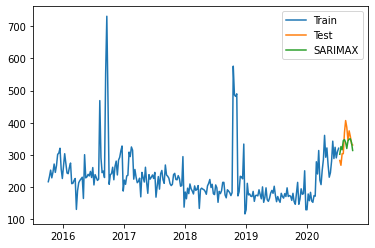

Current product:  14542
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.45166D+00    |proj g|=  3.64638D-01


 This problem is unconstrained.



At iterate    5    f=  6.22088D+00    |proj g|=  1.25270D-02

At iterate   10    f=  6.21771D+00    |proj g|=  1.64182D-02

At iterate   15    f=  6.17590D+00    |proj g|=  1.37446D-01

At iterate   20    f=  6.12922D+00    |proj g|=  8.27604D-02

At iterate   25    f=  6.10801D+00    |proj g|=  1.15874D-02

At iterate   30    f=  6.10799D+00    |proj g|=  2.95194D-04

At iterate   35    f=  6.10796D+00    |proj g|=  9.29786D-03

At iterate   40    f=  6.10778D+00    |proj g|=  2.59955D-02

At iterate   45    f=  6.10414D+00    |proj g|=  2.73367D-02

At iterate   50    f=  6.09319D+00    |proj g|=  2.44459D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.21462D+00    |proj g|=  2.80447D-02

At iterate   10    f=  6.21429D+00    |proj g|=  1.72724D-02

At iterate   15    f=  6.18835D+00    |proj g|=  2.85191D-01

At iterate   20    f=  6.10101D+00    |proj g|=  1.12212D-01

At iterate   25    f=  6.10015D+00    |proj g|=  5.39488D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     35      1     0     0   1.761D-04   6.100D+00
  F =   6.1001480474389149     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  34.23182257077499


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.21956D+00    |proj g|=  2.96667D-01

At iterate    5    f=  6.21544D+00    |proj g|=  2.11675D-02

At iterate   10    f=  6.21439D+00    |proj g|=  1.03667D-01

At iterate   15    f=  6.17041D+00    |proj g|=  5.99766D-01

At iterate   20    f=  6.10948D+00    |proj g|=  1.78132D-02

At iterate   25    f=  6.10947D+00    |proj g|=  2.11651D-04

At iterate   30    f=  6.10930D+00    |proj g|=  6.82409D-03

At iterate   35    f=  6.10131D+00    |proj g|=  2.52469D-01

At iterate   40    f=  6.09460D+00    |proj g|=  7.86216D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.23325D+00    |proj g|=  9.64546D-04

At iterate   10    f=  6.23324D+00    |proj g|=  1.05292D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   3.824D-05   6.233D+00
  F =   6.2332386322731095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  31.165990115276642
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.21704D+00    |proj g|=  2.55229D-01


 This problem is unconstrained.



At iterate    5    f=  6.21358D+00    |proj g|=  4.61356D-03

At iterate   10    f=  6.21270D+00    |proj g|=  2.59357D-02

At iterate   15    f=  6.20383D+00    |proj g|=  3.38666D-01

At iterate   20    f=  6.11045D+00    |proj g|=  7.05367D-02

At iterate   25    f=  6.10866D+00    |proj g|=  2.57639D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     32      1     0     0   2.263D-04   6.109D+00
  F =   6.1086575647380483     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  32.59332280509188


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58479D+00    |proj g|=  1.90363D-01

At iterate    5    f=  6.54901D+00    |proj g|=  5.62210D-03

At iterate   10    f=  6.54660D+00    |proj g|=  9.19471D-02

At iterate   15    f=  6.48201D+00    |proj g|=  2.10852D-01

At iterate   20    f=  6.39353D+00    |proj g|=  4.56577D-01

At iterate   25    f=  6.34898D+00    |proj g|=  2.55217D-01

At iterate   30    f=  6.32633D+00    |proj g|=  3.16778D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.52483D+00    |proj g|=  7.39956D-02

At iterate    5    f=  6.51358D+00    |proj g|=  6.71860D-03

At iterate   10    f=  6.41493D+00    |proj g|=  6.08396D-02

At iterate   15    f=  6.28160D+00    |proj g|=  3.52442D-02

At iterate   20    f=  6.26154D+00    |proj g|=  1.36807D-01

At iterate   25    f=  6.23695D+00    |proj g|=  4.21130D-02

At iterate   30    f=  6.23599D+00    |proj g|=  2.91867D-03

At iterate   35    f=  6.22070D+00    |proj g|=  6.01026D-02

At iterate   40    f=  6.21985D+00    |proj g|=  2.50993D-04

At iterate   45    f=  6.21979D+00    |proj g|=  1.06484D-03

At iterate   50    f=  6.21738D+00    |proj g|=  1.73308D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.50741D+00    |proj g|=  9.92041D-03

At iterate   10    f=  6.37616D+00    |proj g|=  9.90583D-02

At iterate   15    f=  6.28295D+00    |proj g|=  6.22331D-02

At iterate   20    f=  6.23180D+00    |proj g|=  3.17077D-02

At iterate   25    f=  6.23101D+00    |proj g|=  3.08142D-03

At iterate   30    f=  6.23022D+00    |proj g|=  4.80679D-03

At iterate   35    f=  6.23003D+00    |proj g|=  4.61711D-04

At iterate   40    f=  6.22993D+00    |proj g|=  2.37930D-03

At iterate   45    f=  6.22908D+00    |proj g|=  1.06736D-02

At iterate   50    f=  6.21840D+00    |proj g|=  6.56410D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.51168D+00    |proj g|=  4.95404D-02

At iterate   10    f=  6.50761D+00    |proj g|=  8.59407D-03

At iterate   15    f=  6.50691D+00    |proj g|=  8.13761D-03

At iterate   20    f=  6.48627D+00    |proj g|=  3.06086D-01

At iterate   25    f=  6.39357D+00    |proj g|=  5.04860D-01

At iterate   30    f=  6.31920D+00    |proj g|=  3.99351D-01

At iterate   35    f=  6.28757D+00    |proj g|=  5.71887D-02

At iterate   40    f=  6.28363D+00    |proj g|=  1.31512D-02

At iterate   45    f=  6.28225D+00    |proj g|=  3.20946D-02

At iterate   50    f=  6.28139D+00    |proj g|=  4.28250D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.55653D+00    |proj g|=  9.40589D-02

At iterate    5    f=  6.54603D+00    |proj g|=  4.82440D-03

At iterate   10    f=  6.48381D+00    |proj g|=  1.41881D-01

At iterate   15    f=  6.40417D+00    |proj g|=  3.20897D-02

At iterate   20    f=  6.40362D+00    |proj g|=  5.43018D-03

At iterate   25    f=  6.40204D+00    |proj g|=  2.93032D-03

At iterate   30    f=  6.40194D+00    |proj g|=  1.75603D-04

At iterate   35    f=  6.40192D+00    |proj g|=  1.63699D-03

At iterate   40    f=  6.40131D+00    |proj g|=  9.25708D-03

At iterate   45    f=  6.39003D+00    |proj g|=  2.01565D-02

At iterate   50    f=  6.38816D+00    |proj g|=  3.51153D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.67538D+00    |proj g|=  5.30190D-01

At iterate    5    f=  6.52195D+00    |proj g|=  2.43439D-01

At iterate   10    f=  6.50703D+00    |proj g|=  3.16977D-02

At iterate   15    f=  6.50082D+00    |proj g|=  1.03127D-02

At iterate   20    f=  6.49774D+00    |proj g|=  6.92614D-02

At iterate   25    f=  6.44867D+00    |proj g|=  9.78599D-01

At iterate   30    f=  6.39741D+00    |proj g|=  8.78341D-02

At iterate   35    f=  6.37455D+00    |proj g|=  1.33491D-01

At iterate   40    f=  6.37416D+00    |proj g|=  2.49634D-02

At iterate   45    f=  6.36929D+00    |proj g|=  1.30681D+00

At iterate   50    f=  6.26257D+00    |proj g|=  2.47047D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.21916D+00    |proj g|=  4.66803D-03

At iterate   10    f=  6.21713D+00    |proj g|=  2.18213D-02

At iterate   15    f=  6.15120D+00    |proj g|=  4.79679D-02

At iterate   20    f=  6.13972D+00    |proj g|=  1.34207D-01

At iterate   25    f=  6.11045D+00    |proj g|=  9.50228D-02

At iterate   30    f=  6.10862D+00    |proj g|=  4.48735D-02

At iterate   35    f=  6.10789D+00    |proj g|=  3.16657D-04

At iterate   40    f=  6.10788D+00    |proj g|=  3.50812D-03

At iterate   45    f=  6.10676D+00    |proj g|=  1.42936D-01

At iterate   50    f=  6.09426D+00    |proj g|=  3.04135D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23346D+00    |proj g|=  3.47796D-01

At iterate    5    f=  6.21949D+00    |proj g|=  4.64618D-03

At iterate   10    f=  6.21897D+00    |proj g|=  6.04778D-02

At iterate   15    f=  6.20163D+00    |proj g|=  3.34769D-01

At iterate   20    f=  6.12981D+00    |proj g|=  1.38842D-01

At iterate   25    f=  6.12155D+00    |proj g|=  3.04283D-01

At iterate   30    f=  6.11514D+00    |proj g|=  1.58417D-03

At iterate   35    f=  6.11514D+00    |proj g|=  6.14370D-04

At iterate   40    f=  6.11510D+00    |proj g|=  1.07450D-02

At iterate   45    f=  6.11325D+00    |proj g|=  8.82739D-02

At iterate   50    f=  6.10081D+00    |proj g|=  3.01131D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.52483D+00    |proj g|=  7.39956D-02

At iterate    5    f=  6.51572D+00    |proj g|=  6.23063D-02

At iterate   10    f=  6.51460D+00    |proj g|=  3.46146D-02

At iterate   15    f=  6.51318D+00    |proj g|=  1.78015D-02

At iterate   20    f=  6.50150D+00    |proj g|=  1.35097D-01

At iterate   25    f=  6.30547D+00    |proj g|=  2.66802D-01

At iterate   30    f=  6.28033D+00    |proj g|=  9.14453D-03

At iterate   35    f=  6.28019D+00    |proj g|=  2.11794D-02

At iterate   40    f=  6.27851D+00    |proj g|=  4.26980D-01

At iterate   45    f=  6.26470D+00    |proj g|=  8.00298D-01

At iterate   50    f=  6.24115D+00    |proj g|=  2.09433D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.21296D+00    |proj g|=  3.09330D-02

At iterate   10    f=  6.21225D+00    |proj g|=  2.50846D-02

At iterate   15    f=  6.17961D+00    |proj g|=  1.47844D-01

At iterate   20    f=  6.14845D+00    |proj g|=  1.38179D-02

At iterate   25    f=  6.13874D+00    |proj g|=  1.23195D-01

At iterate   30    f=  6.10830D+00    |proj g|=  4.32196D-02

At iterate   35    f=  6.10409D+00    |proj g|=  2.77639D-03

At iterate   40    f=  6.10408D+00    |proj g|=  5.56724D-04

At iterate   45    f=  6.10384D+00    |proj g|=  1.66474D-02

At iterate   50    f=  6.09744D+00    |proj g|=  7.36511D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.45166D+00    |proj g|=  3.64625D-01

At iterate    5    f=  6.22162D+00    |proj g|=  9.86980D-03

At iterate   10    f=  6.22127D+00    |proj g|=  5.94513D-02

At iterate   15    f=  6.19861D+00    |proj g|=  3.02798D-01

At iterate   20    f=  6.11981D+00    |proj g|=  5.75681D-02

At iterate   25    f=  6.11104D+00    |proj g|=  1.67009D-02

At iterate   30    f=  6.11096D+00    |proj g|=  1.03714D-03

At iterate   35    f=  6.11051D+00    |proj g|=  2.18566D-02

At iterate   40    f=  6.09880D+00    |proj g|=  1.24686D-01

At iterate   45    f=  6.09593D+00    |proj g|=  2.10412D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.23325D+00    |proj g|=  9.64546D-04

At iterate   10    f=  6.23324D+00    |proj g|=  1.05292D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   3.824D-05   6.233D+00
  F =   6.2332386322731095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  14542
Best Configs:  [(1, 1, 0), (0, 1, 0, 52)]
Mean Absolute Error: 27.989
Mean Squared Error: 241.3
Root Mean Squared Error: 31.166
Mean absolute percentage error: 11.732
Scaled Mean absolute percentage error: 12.537
Mean fore

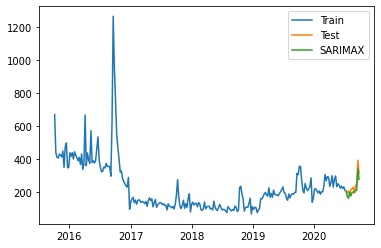

Current product:  10002
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.29192D+00    |proj g|=  3.38326D-01


 This problem is unconstrained.



At iterate    5    f=  6.18140D+00    |proj g|=  6.22245D-03

At iterate   10    f=  6.18111D+00    |proj g|=  2.25694D-02

At iterate   15    f=  6.17338D+00    |proj g|=  1.12204D-01

At iterate   20    f=  6.15559D+00    |proj g|=  2.42172D-02

At iterate   25    f=  6.14081D+00    |proj g|=  6.88203D-02

At iterate   30    f=  6.13828D+00    |proj g|=  6.53660D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     41      1     0     0   7.577D-05   6.138D+00
  F =   6.1382785171429051     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  55.772642106715395
RUNNING THE L-BFGS-B CODE

 This problem is unconstrained.



At iterate    5    f=  6.17382D+00    |proj g|=  2.27123D-02

At iterate   10    f=  6.17300D+00    |proj g|=  1.13056D-02

At iterate   15    f=  6.16251D+00    |proj g|=  2.05795D-01

At iterate   20    f=  6.12982D+00    |proj g|=  1.18465D-02

At iterate   25    f=  6.12965D+00    |proj g|=  8.31122D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     29      1     0     0   8.311D-05   6.130D+00
  F =   6.1296537744618300     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  55.7547781358483


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30094D+00    |proj g|=  3.30090D-01

At iterate    5    f=  6.19853D+00    |proj g|=  3.33087D-03

At iterate   10    f=  6.17504D+00    |proj g|=  2.61216D-01

At iterate   15    f=  6.16163D+00    |proj g|=  8.08092D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   4.973D-05   6.162D+00
  F =   6.1616302369205487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  6

 This problem is unconstrained.



At iterate    5    f=  6.17680D+00    |proj g|=  8.13783D-04

At iterate   10    f=  6.17678D+00    |proj g|=  8.27945D-04

At iterate   15    f=  6.17678D+00    |proj g|=  3.51173D-04

At iterate   20    f=  6.17668D+00    |proj g|=  4.82315D-03

At iterate   25    f=  6.17612D+00    |proj g|=  1.25686D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     32      1     0     0   2.548D-05   6.176D+00
  F =   6.1761083079667403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  68.66994840744181
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate    5    f=  6.19821D+00    |proj g|=  3.33878D-03

At iterate   10    f=  6.19776D+00    |proj g|=  1.64747D-02

At iterate   15    f=  6.18434D+00    |proj g|=  3.38646D-02

At iterate   20    f=  6.16269D+00    |proj g|=  1.11400D-01

At iterate   25    f=  6.16049D+00    |proj g|=  3.82114D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     33      1     0     0   2.236D-04   6.160D+00
  F =   6.1604882974632487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  62.165257973295
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           

 This problem is unconstrained.



At iterate    5    f=  6.55598D+00    |proj g|=  9.93478D-03

At iterate   10    f=  6.55504D+00    |proj g|=  5.01307D-03

At iterate   15    f=  6.53845D+00    |proj g|=  3.04698D-01

At iterate   20    f=  6.48807D+00    |proj g|=  2.75027D-02

At iterate   25    f=  6.47378D+00    |proj g|=  1.72224D-01

At iterate   30    f=  6.46960D+00    |proj g|=  1.38887D-02

At iterate   35    f=  6.46891D+00    |proj g|=  2.01927D-03

At iterate   40    f=  6.46886D+00    |proj g|=  7.48017D-04

At iterate   45    f=  6.46885D+00    |proj g|=  6.06684D-04

At iterate   50    f=  6.46885D+00    |proj g|=  1.06722D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62196D+00    |proj g|=  2.83340D-01

At iterate    5    f=  6.56819D+00    |proj g|=  3.77827D-03

At iterate   10    f=  6.56160D+00    |proj g|=  1.84954D-02

At iterate   15    f=  6.53056D+00    |proj g|=  4.78603D-02

At iterate   20    f=  6.51820D+00    |proj g|=  1.53738D-03

At iterate   25    f=  6.51818D+00    |proj g|=  3.43915D-04

At iterate   30    f=  6.51380D+00    |proj g|=  5.18672D-02
  ys=-1.584E-03  -gs= 9.929E-04 BFGS update SKIPPED

At iterate   35    f=  6.50708D+00    |proj g|=  6.52118D-03

At iterate   40    f=  6.50700D+00    |proj g|=  4.97872D-04

At iterate   45    f=  6.50687D+00    |proj g|=  9.74731D-03

At iterate   50    f=  6.50585D+00    |proj g|=  5.59065D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.



At iterate    5    f=  6.56558D+00    |proj g|=  3.83847D-03

At iterate   10    f=  6.55390D+00    |proj g|=  2.62153D-02

At iterate   15    f=  6.51108D+00    |proj g|=  5.36384D-02

At iterate   20    f=  6.50627D+00    |proj g|=  1.69996D-03

At iterate   25    f=  6.50359D+00    |proj g|=  1.52645D-02

At iterate   30    f=  6.50277D+00    |proj g|=  2.11092D-03

At iterate   35    f=  6.50254D+00    |proj g|=  1.96199D-02

At iterate   40    f=  6.50186D+00    |proj g|=  2.16584D-04

At iterate   45    f=  6.50185D+00    |proj g|=  6.15524D-05

At iterate   50    f=  6.50185D+00    |proj g|=  1.58334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.56672D+00    |proj g|=  5.83161D-02

At iterate   10    f=  6.56553D+00    |proj g|=  7.28560D-03

At iterate   15    f=  6.56380D+00    |proj g|=  1.98863D-02

At iterate   20    f=  6.55261D+00    |proj g|=  1.00521D-01

At iterate   25    f=  6.50127D+00    |proj g|=  1.86490D-01

At iterate   30    f=  6.47467D+00    |proj g|=  1.02857D-02

At iterate   35    f=  6.47419D+00    |proj g|=  6.66822D-02

At iterate   40    f=  6.47390D+00    |proj g|=  1.01344D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     60      1     0     0   2.275D-05   6.474D+00
  F =   6.47389821495

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60510D+00    |proj g|=  2.67162D-01

At iterate    5    f=  6.55662D+00    |proj g|=  3.82154D-03

At iterate   10    f=  6.52645D+00    |proj g|=  9.23946D-02

At iterate   15    f=  6.50278D+00    |proj g|=  1.01666D-02

At iterate   20    f=  6.50165D+00    |proj g|=  7.25903D-03

At iterate   25    f=  6.49975D+00    |proj g|=  2.90972D-03

At iterate   30    f=  6.49971D+00    |proj g|=  8.95088D-05

At iterate   35    f=  6.49971D+00    |proj g|=  1.20762D-03

At iterate   40    f=  6.49932D+00    |proj g|=  1.14093D-02

At iterate   45    f=  6.49845D+00    |proj g|=  7.48774D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.56571D+00    |proj g|=  8.03036D-02

At iterate   10    f=  6.56458D+00    |proj g|=  2.66263D-02

At iterate   15    f=  6.56421D+00    |proj g|=  2.66356D-02

At iterate   20    f=  6.56207D+00    |proj g|=  2.53732D-02

At iterate   25    f=  6.55374D+00    |proj g|=  7.42922D-02

At iterate   30    f=  6.49236D+00    |proj g|=  2.44971D-01

At iterate   35    f=  6.47636D+00    |proj g|=  8.18187D-03

At iterate   40    f=  6.47608D+00    |proj g|=  2.86948D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     49      1     0     0   2.869D-05   6.476D+00
  F =   6.47608057179

 This problem is unconstrained.



At iterate    5    f=  6.18111D+00    |proj g|=  5.25980D-02

At iterate   10    f=  6.17920D+00    |proj g|=  4.06541D-02

At iterate   15    f=  6.15779D+00    |proj g|=  2.04840D-01

At iterate   20    f=  6.15024D+00    |proj g|=  1.27132D-02

At iterate   25    f=  6.13804D+00    |proj g|=  1.89185D-02

At iterate   30    f=  6.13762D+00    |proj g|=  3.09804D-03

At iterate   35    f=  6.13762D+00    |proj g|=  1.29049D-04

At iterate   40    f=  6.13761D+00    |proj g|=  2.13002D-03

At iterate   45    f=  6.13739D+00    |proj g|=  2.31798D-03

At iterate   50    f=  6.13684D+00    |proj g|=  3.21357D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.31453D+00    |proj g|=  3.28966D-01

At iterate    5    f=  6.20527D+00    |proj g|=  3.31952D-03

At iterate   10    f=  6.20327D+00    |proj g|=  3.11480D-02

At iterate   15    f=  6.18317D+00    |proj g|=  4.12394D-02

At iterate   20    f=  6.16837D+00    |proj g|=  4.99259D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     31      1     0     0   2.727D-05   6.168D+00
  F =   6.1683395230575897     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62196D+00    |proj g|=  2.83340D-01

At iterate    5    f=  6.56988D+00    |proj g|=  6.10462D-02

At iterate   10    f=  6.56830D+00    |proj g|=  1.12704D-02

At iterate   15    f=  6.56567D+00    |proj g|=  5.47313D-02

At iterate   20    f=  6.56253D+00    |proj g|=  2.34809D-02

At iterate   25    f=  6.55581D+00    |proj g|=  3.28817D-01

At iterate   30    f=  6.52039D+00    |proj g|=  3.55130D-02

At iterate   35    f=  6.48764D+00    |proj g|=  4.69132D-02

At iterate   40    f=  6.48406D+00    |proj g|=  2.21870D-02

At iterate   45    f=  6.48332D+00    |proj g|=  7.37866D-02

At iterate   50    f=  6.48227D+00    |proj g|=  6.38093D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.29464D+00    |proj g|=  3.27485D-01

At iterate    5    f=  6.19314D+00    |proj g|=  3.37456D-03

At iterate   10    f=  6.19166D+00    |proj g|=  1.26085D-02

At iterate   15    f=  6.16453D+00    |proj g|=  3.64094D-02

At iterate   20    f=  6.16016D+00    |proj g|=  1.75339D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   3.065D-05   6.160D+00
  F =   6.1601571367074310     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  6.18161D+00    |proj g|=  5.79225D-03

At iterate   10    f=  6.18112D+00    |proj g|=  2.99246D-02

At iterate   15    f=  6.15250D+00    |proj g|=  5.55061D-02

At iterate   20    f=  6.14588D+00    |proj g|=  3.73659D-03

At iterate   25    f=  6.14163D+00    |proj g|=  8.54503D-02

At iterate   30    f=  6.14011D+00    |proj g|=  5.41405D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     50      1     0     0   7.269D-05   6.140D+00
  F =   6.1401119559661312     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  55.59349704950458


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.29944D+00    |proj g|=  3.45023D-01

At iterate    5    f=  6.18111D+00    |proj g|=  5.25980D-02

At iterate   10    f=  6.17920D+00    |proj g|=  4.06541D-02

At iterate   15    f=  6.15779D+00    |proj g|=  2.04840D-01

At iterate   20    f=  6.15024D+00    |proj g|=  1.27132D-02

At iterate   25    f=  6.13804D+00    |proj g|=  1.89185D-02

At iterate   30    f=  6.13762D+00    |proj g|=  3.09804D-03

At iterate   35    f=  6.13762D+00    |proj g|=  1.29049D-04

At iterate   40    f=  6.13761D+00    |proj g|=  2.13002D-03

At iterate   45    f=  6.13739D+00    |proj g|=  2.31798D-03

At iterate   50    f=  6.13684D+00    |proj g|=  3.21357D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

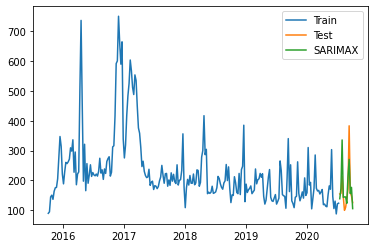

Current product:  10197


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.28337D+00    |proj g|=  2.44163D-01
  ys=-4.846E-01  -gs= 2.311E-01 BFGS update SKIPPED

At iterate    5    f=  5.76622D+00    |proj g|=  6.41853D-01

At iterate   10    f=  5.75510D+00    |proj g|=  1.01029D-01

At iterate   15    f=  5.74030D+00    |proj g|=  2.51613D-02

At iterate   20    f=  5.73901D+00    |proj g|=  7.26154D-03

At iterate   25    f=  5.72986D+00    |proj g|=  8.89351D-02

At iterate   30    f=  5.69766D+00    |proj g|=  2.70714D-01

At iterate   35    f=  5.69249D+00    |proj g|=  3.27083D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 

 This problem is unconstrained.


  ys=-1.316E-01  -gs= 2.273E-01 BFGS update SKIPPED

At iterate    5    f=  5.80373D+00    |proj g|=  1.90051D-01

At iterate   10    f=  5.79094D+00    |proj g|=  7.38917D-02

At iterate   15    f=  5.79057D+00    |proj g|=  2.93413D-02

At iterate   20    f=  5.78788D+00    |proj g|=  2.62492D-01

At iterate   25    f=  5.76743D+00    |proj g|=  2.39584D-01

At iterate   30    f=  5.76409D+00    |proj g|=  3.10510D-03

At iterate   35    f=  5.76401D+00    |proj g|=  1.20643D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     47      2     1     0   1.019D-05   5.764D+00
  F =   5.7640119355459492     

 This problem is unconstrained.



At iterate    5    f=  5.79567D+00    |proj g|=  1.32661D-02

At iterate   10    f=  5.79553D+00    |proj g|=  8.34375D-02

At iterate   15    f=  5.78663D+00    |proj g|=  5.78441D-01

At iterate   20    f=  5.77881D+00    |proj g|=  3.79204D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     26      1     0     0   1.932D-05   5.779D+00
  F =   5.7788102766981426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  27.7967990304239
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactl

 This problem is unconstrained.



At iterate    5    f=  5.73004D+00    |proj g|=  1.09709D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   4.836D-06   5.730D+00
  F =   5.7300366696805085     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  27.918297206821187
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95807D+00    |proj g|=  8.24123D-01


 This problem is unconstrained.



At iterate    5    f=  5.75692D+00    |proj g|=  2.15921D-01

At iterate   10    f=  5.73216D+00    |proj g|=  8.69816D-02

At iterate   15    f=  5.71590D+00    |proj g|=  1.31932D-01

At iterate   20    f=  5.68874D+00    |proj g|=  7.17013D-02

At iterate   25    f=  5.68860D+00    |proj g|=  1.11549D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   1.115D-04   5.689D+00
  F =   5.6886003303916706     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  26.547452740271897
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  6.33515D+00    |proj g|=  9.41188D-02

At iterate   10    f=  6.32240D+00    |proj g|=  3.99640D-01

At iterate   15    f=  6.32132D+00    |proj g|=  2.85642D-02

At iterate   20    f=  6.31197D+00    |proj g|=  4.74770D-01

At iterate   25    f=  6.28650D+00    |proj g|=  2.01269D-02

At iterate   30    f=  6.28504D+00    |proj g|=  6.15153D-03

At iterate   35    f=  6.28500D+00    |proj g|=  1.98916D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     43      1     0     0   1.989D-05   6.285D+00
  F =   6.2849992386124240     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.32914D+00    |proj g|=  1.19084D-02

At iterate   10    f=  6.32217D+00    |proj g|=  8.08399D-03

At iterate   15    f=  6.31482D+00    |proj g|=  3.06433D-02

At iterate   20    f=  6.30949D+00    |proj g|=  6.26163D-03

At iterate   25    f=  6.30930D+00    |proj g|=  1.21539D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     34      1     0     0   2.357D-05   6.309D+00
  F =   6.3092913046124197     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  28.454763749094024


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.37497D+00    |proj g|=  1.09727D-01

At iterate    5    f=  6.33336D+00    |proj g|=  6.36945D-03

At iterate   10    f=  6.32096D+00    |proj g|=  3.56091D-02

At iterate   15    f=  6.29641D+00    |proj g|=  1.34566D-02

At iterate   20    f=  6.29507D+00    |proj g|=  1.01164D-03

At iterate   25    f=  6.29505D+00    |proj g|=  2.06120D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     33      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.37497D+00    |proj g|=  1.09727D-01

At iterate    5    f=  6.34815D+00    |proj g|=  5.05439D-02

At iterate   10    f=  6.33415D+00    |proj g|=  2.68754D-02

At iterate   15    f=  6.33280D+00    |proj g|=  1.53173D-02

At iterate   20    f=  6.29991D+00    |proj g|=  5.24534D-02

At iterate   25    f=  6.29549D+00    |proj g|=  5.74909D-03

At iterate   30    f=  6.29504D+00    |proj g|=  4.76118D-03

At iterate   35    f=  6.29485D+00    |proj g|=  4.74154D-03

At iterate   40    f=  6.29484D+00    |proj g|=  1.41907D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.37142D+00    |proj g|=  1.14451D-02

At iterate   10    f=  6.34662D+00    |proj g|=  7.40329D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     20      1     0     0   4.522D-05   6.347D+00
  F =   6.3465975362674705     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  27.588102549092515
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.69388D+00    |proj g|=  7.67676D-01


 This problem is unconstrained.



At iterate    5    f=  6.36757D+00    |proj g|=  2.66207D-01

At iterate   10    f=  6.34982D+00    |proj g|=  4.64885D-01

At iterate   15    f=  6.33643D+00    |proj g|=  3.70751D-01

At iterate   20    f=  6.33185D+00    |proj g|=  7.36981D-02

At iterate   25    f=  6.32621D+00    |proj g|=  9.16711D-02

At iterate   30    f=  6.30240D+00    |proj g|=  2.11592D-01

At iterate   35    f=  6.29956D+00    |proj g|=  1.14201D-01

At iterate   40    f=  6.29201D+00    |proj g|=  1.26568D-02

At iterate   45    f=  6.29200D+00    |proj g|=  6.92038D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     60   

 This problem is unconstrained.



At iterate    5    f=  5.76860D+00    |proj g|=  1.66004D-01

At iterate   10    f=  5.75548D+00    |proj g|=  1.83721D-01

At iterate   15    f=  5.73484D+00    |proj g|=  1.46478D-01

At iterate   20    f=  5.72918D+00    |proj g|=  4.66760D-02

At iterate   25    f=  5.72860D+00    |proj g|=  6.14409D-03

At iterate   30    f=  5.71326D+00    |proj g|=  3.90866D-01

At iterate   35    f=  5.70994D+00    |proj g|=  8.54934D-03

At iterate   40    f=  5.70987D+00    |proj g|=  5.51412D-03

At iterate   45    f=  5.70452D+00    |proj g|=  6.73863D-02

At iterate   50    f=  5.69791D+00    |proj g|=  9.28778D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.77659D+00    |proj g|=  2.53913D-01

At iterate   10    f=  5.76697D+00    |proj g|=  2.17987D-01

At iterate   15    f=  5.75003D+00    |proj g|=  6.91220D-01

At iterate   20    f=  5.73663D+00    |proj g|=  1.45449D-02

At iterate   25    f=  5.73393D+00    |proj g|=  1.16798D-01

At iterate   30    f=  5.70115D+00    |proj g|=  2.11053D-01

At iterate   35    f=  5.69962D+00    |proj g|=  5.52297D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     44      1     0     0   4.026D-05   5.700D+00
  F =   5.6996213866918177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.44973D+00    |proj g|=  2.82010D-01

At iterate    5    f=  6.35606D+00    |proj g|=  8.72404D-02

At iterate   10    f=  6.32979D+00    |proj g|=  1.01405D-01

At iterate   15    f=  6.32945D+00    |proj g|=  9.44184D-02

At iterate   20    f=  6.32827D+00    |proj g|=  1.18568D-01

At iterate   25    f=  6.32669D+00    |proj g|=  2.04980D-02

At iterate   30    f=  6.32449D+00    |proj g|=  8.10157D-02

At iterate   35    f=  6.32247D+00    |proj g|=  3.30435D-02

At iterate   40    f=  6.32224D+00    |proj g|=  5.61928D-02

At iterate   45    f=  6.32193D+00    |proj g|=  9.81933D-02

At iterate   50    f=  6.32133D+00    |proj g|=  7.43418D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.99622D+00    |proj g|=  7.78922D-01

At iterate    5    f=  5.72493D+00    |proj g|=  1.07584D-01

At iterate   10    f=  5.70925D+00    |proj g|=  6.56395D-02

At iterate   15    f=  5.70434D+00    |proj g|=  5.34763D-03

At iterate   20    f=  5.69362D+00    |proj g|=  3.94055D-02

At iterate   25    f=  5.68858D+00    |proj g|=  7.16872D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     38      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.28334D+00    |proj g|=  2.43952D-01
  ys=-3.417E-01  -gs= 2.472E-01 BFGS update SKIPPED

At iterate    5    f=  5.76848D+00    |proj g|=  4.62717D-01

At iterate   10    f=  5.75051D+00    |proj g|=  6.51956D-02

At iterate   15    f=  5.73741D+00    |proj g|=  6.95667D-01

At iterate   20    f=  5.69797D+00    |proj g|=  1.09914D-02

At iterate   25    f=  5.69792D+00    |proj g|=  6.61107D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

 This problem is unconstrained.



At iterate    5    f=  6.33515D+00    |proj g|=  9.41188D-02

At iterate   10    f=  6.32240D+00    |proj g|=  3.99640D-01

At iterate   15    f=  6.32132D+00    |proj g|=  2.85642D-02

At iterate   20    f=  6.31197D+00    |proj g|=  4.74770D-01

At iterate   25    f=  6.28650D+00    |proj g|=  2.01269D-02

At iterate   30    f=  6.28504D+00    |proj g|=  6.15153D-03

At iterate   35    f=  6.28500D+00    |proj g|=  1.98916D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     43      1     0     0   1.989D-05   6.285D+00
  F =   6.2849992386124240     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

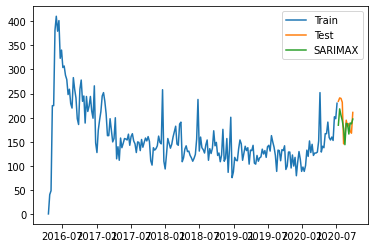

Current product:  16527
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22410D+00    |proj g|=  8.97047D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2      4      1     0     0   1.836D-05   8.224D+00
  F =   8.2240990012490744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  919.0033873741498
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=          NaN    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0         NaN         NaN
  F =                       NaN

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Input contains NaN, infinity or a value too large for dtype('float64').
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=          NaN    |proj g|=          NaN



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     21      1     0     0         NaN         NaN
  F =                       NaN

ABNORMAL_TERMINATION_IN_LNSRCH                              
Input contains NaN, infinity or a value too large for dtype('float64').
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=          NaN    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Input contains NaN, infinity or a value too large for dtype('float64').
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22410D+00    |proj g|=  8.97047D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2      4      1     0     0   1.836D-05   8.224D+00
  F =   8.2240990012490744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  919.0033873741498
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22410D+00    |proj g|=  8.97047D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2      4      1     0     0   1.836D-05   8.224D+00
  F =   8.2240990012490744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  919.0033873741498
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22410D+00    |proj g|=  8.97047D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2      4      1     0     0   1.836D-05   8.224D+00
  F =   8.2240990012490585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  919.003387355304


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22410D+00    |proj g|=  8.97047D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2      4      1     0     0   1.836D-05   8.224D+00
  F =   8.2240990012490744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  919.0033873741498
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2      4      1     0     0   1.836D-05   8.224D+00
  F =   8.2240990012490744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  919.0033873741498
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    0    f=          NaN    |proj g|=          NaN



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0         NaN         NaN
  F =                       NaN

ABNORMAL_TERMINATION_IN_LNSRCH                              
Input contains NaN, infinity or a value too large for dtype('float64').
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22410D+00    |proj g|=  1.95009D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      3      5      1     0     0   1.763D-05   8.223D+00
  F =   8.2233156557970641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  916.2238022486877
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22410D+00    |proj g|=  1.95009D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      3      5      1     0     0   1.763D-05   8.223D+00
  F =   8.2233156557970641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  916.2238022486877
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22410D+00    |proj g|=  1.95009D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      3      5      1     0     0   1.763D-05   8.223D+00
  F =   8.2233156557970641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  916.2238022486877
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22410D+00    |proj g|=  8.97047D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      2      4      1     0     0   1.836D-05   8.224D+00
  F =   8.2240990012490585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  919.003387355304
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22410D+00    |proj g|=  8.97047D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2      4      1     0     0   1.836D-05   8.224D+00
  F =   8.2240990012490585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  919.003387355304
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22410D+00    |proj g|=  1.83578D-05


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     11      1     0     0   8.596D-06   8.189D+00
  F =   8.1894437455144438     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  571.3435748347198


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22410D+00    |proj g|=  1.83578D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     11      1     0     0   8.596D-06   8.189D+00
  F =   8.1894437455144438     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  16527
Best Configs:  [(0, 1, 1), (1, 1, 1, 52)]
Mean Absolute Error: 435.738
Mean Squared Error: 1200.463
Root Mean Squared

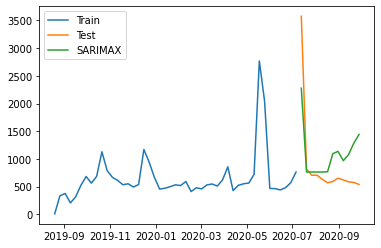

Current product:  14563
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79658D+00    |proj g|=  3.33906D-01


 This problem is unconstrained.



At iterate    5    f=  7.69136D+00    |proj g|=  5.99473D-03

At iterate   10    f=  7.68706D+00    |proj g|=  7.29963D-03

At iterate   15    f=  7.68682D+00    |proj g|=  1.60723D-03

At iterate   20    f=  7.68363D+00    |proj g|=  3.09606D-02

At iterate   25    f=  7.61720D+00    |proj g|=  1.47633D-02

At iterate   30    f=  7.60547D+00    |proj g|=  1.49116D-02

At iterate   35    f=  7.55519D+00    |proj g|=  2.96959D-02

At iterate   40    f=  7.55477D+00    |proj g|=  8.69697D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     57      1     0     0   3.825D-05   7.555D+00
  F =   7.55476966720

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.78836D+00    |proj g|=  3.56347D-01

At iterate    5    f=  7.68103D+00    |proj g|=  2.21218D-03

At iterate   10    f=  7.68089D+00    |proj g|=  7.46049D-03

At iterate   15    f=  7.66825D+00    |proj g|=  7.02418D-02

At iterate   20    f=  7.62502D+00    |proj g|=  9.94833D-02

At iterate   25    f=  7.57504D+00    |proj g|=  2.11072D-02

At iterate   30    f=  7.57183D+00    |proj g|=  1.17911D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.68754D+00    |proj g|=  2.81033D-02

At iterate    5    f=  7.68622D+00    |proj g|=  1.76911D-03

At iterate   10    f=  7.68390D+00    |proj g|=  4.49410D-02

At iterate   15    f=  7.59172D+00    |proj g|=  1.88428D-01

At iterate   20    f=  7.57213D+00    |proj g|=  2.46085D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     27      1     0     0   3.841D-05   7.572D+00
  F =   7.5721318931812736     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  7.70091D+00    |proj g|=  2.07921D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   7.169D-06   7.701D+00
  F =   7.7005658066430147     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  80.5678558108175
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70167D+00    |proj g|=  4.22007D-02


 This problem is unconstrained.



At iterate    5    f=  7.68711D+00    |proj g|=  2.67862D-03

At iterate   10    f=  7.68650D+00    |proj g|=  1.05118D-02

At iterate   15    f=  7.64360D+00    |proj g|=  7.15663D-02

At iterate   20    f=  7.59533D+00    |proj g|=  1.51421D-02

At iterate   25    f=  7.55379D+00    |proj g|=  5.31835D-03

At iterate   30    f=  7.55373D+00    |proj g|=  7.29893D-05

At iterate   35    f=  7.55373D+00    |proj g|=  1.12014D-03

At iterate   40    f=  7.55320D+00    |proj g|=  6.61784D-03

At iterate   45    f=  7.55280D+00    |proj g|=  1.43657D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     56   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.85453D+00    |proj g|=  2.10577D-01

At iterate    5    f=  7.80679D+00    |proj g|=  4.05823D-02

At iterate   10    f=  7.80125D+00    |proj g|=  7.60369D-04

At iterate   15    f=  7.79326D+00    |proj g|=  3.47804D-02

At iterate   20    f=  7.63133D+00    |proj g|=  9.17472D-02

At iterate   25    f=  7.62924D+00    |proj g|=  8.36538D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     35      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.78176D+00    |proj g|=  7.47401D-03

At iterate   10    f=  7.78042D+00    |proj g|=  7.26377D-04

At iterate   15    f=  7.77957D+00    |proj g|=  8.63133D-03

At iterate   20    f=  7.71119D+00    |proj g|=  1.04399D-01

At iterate   25    f=  7.66148D+00    |proj g|=  7.53309D-03

At iterate   30    f=  7.66119D+00    |proj g|=  1.84568D-03

At iterate   35    f=  7.66113D+00    |proj g|=  5.55266D-03

At iterate   40    f=  7.66063D+00    |proj g|=  2.64723D-03

At iterate   45    f=  7.66025D+00    |proj g|=  1.37329D-03

At iterate   50    f=  7.66004D+00    |proj g|=  4.42990D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90305D+00    |proj g|=  3.02584D-01

At iterate    5    f=  7.81041D+00    |proj g|=  2.13643D-02

At iterate   10    f=  7.80919D+00    |proj g|=  1.57209D-03

At iterate   15    f=  7.80415D+00    |proj g|=  3.19408D-02

At iterate   20    f=  7.67938D+00    |proj g|=  6.28751D-03

At iterate   25    f=  7.67920D+00    |proj g|=  5.11925D-03

At iterate   30    f=  7.67689D+00    |proj g|=  2.58639D-02

At iterate   35    f=  7.67494D+00    |proj g|=  2.38340D-03

At iterate   40    f=  7.67459D+00    |proj g|=  4.79263D-03

At iterate   45    f=  7.67441D+00    |proj g|=  8.02363D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90305D+00    |proj g|=  3.02584D-01

At iterate    5    f=  7.80918D+00    |proj g|=  1.54808D-02

At iterate   10    f=  7.80570D+00    |proj g|=  7.43651D-04

At iterate   15    f=  7.80535D+00    |proj g|=  5.88319D-03

At iterate   20    f=  7.75923D+00    |proj g|=  9.59337D-02

At iterate   25    f=  7.68237D+00    |proj g|=  4.31560D-02

At iterate   30    f=  7.62633D+00    |proj g|=  1.48409D-02

At iterate   35    f=  7.61894D+00    |proj g|=  8.17960D-02

At iterate   40    f=  7.61068D+00    |proj g|=  1.56818D-02

At iterate   45    f=  7.60614D+00    |proj g|=  1.20987D-01

At iterate   50    f=  7.59723D+00    |proj g|=  3.76142D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.80367D+00    |proj g|=  1.91855D-03

At iterate   10    f=  7.80358D+00    |proj g|=  2.67675D-03

At iterate   15    f=  7.79386D+00    |proj g|=  4.32805D-02

At iterate   20    f=  7.67976D+00    |proj g|=  6.13762D-02

At iterate   25    f=  7.67566D+00    |proj g|=  1.11236D-03

At iterate   30    f=  7.67507D+00    |proj g|=  1.83329D-03

At iterate   35    f=  7.67480D+00    |proj g|=  2.86895D-03

At iterate   40    f=  7.67467D+00    |proj g|=  6.62754D-04

At iterate   45    f=  7.67460D+00    |proj g|=  3.01118D-03

At iterate   50    f=  7.67413D+00    |proj g|=  2.74956D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.79613D+00    |proj g|=  1.37861D-02

At iterate   10    f=  7.79420D+00    |proj g|=  7.54145D-04

At iterate   15    f=  7.79356D+00    |proj g|=  1.47287D-02

At iterate   20    f=  7.72115D+00    |proj g|=  1.58370D-01

At iterate   25    f=  7.60357D+00    |proj g|=  3.14039D-02

At iterate   30    f=  7.59611D+00    |proj g|=  3.88726D-02

At iterate   35    f=  7.59385D+00    |proj g|=  3.63032D-04

At iterate   40    f=  7.59383D+00    |proj g|=  2.70204D-03

At iterate   45    f=  7.59365D+00    |proj g|=  2.37591D-03

At iterate   50    f=  7.59359D+00    |proj g|=  1.38235D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.67304D+00    |proj g|=  6.46370D-03

At iterate   10    f=  7.67033D+00    |proj g|=  2.62582D-03

At iterate   15    f=  7.67027D+00    |proj g|=  3.28325D-03

At iterate   20    f=  7.66536D+00    |proj g|=  5.21746D-02

At iterate   25    f=  7.59227D+00    |proj g|=  5.60299D-02

At iterate   30    f=  7.58006D+00    |proj g|=  9.85811D-02

At iterate   35    f=  7.55155D+00    |proj g|=  2.45566D-02

At iterate   40    f=  7.54776D+00    |proj g|=  1.52979D-03

At iterate   45    f=  7.54775D+00    |proj g|=  5.94315D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     51   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.68384D+00    |proj g|=  3.45539D-02

At iterate    5    f=  7.67484D+00    |proj g|=  2.59801D-03

At iterate   10    f=  7.67477D+00    |proj g|=  3.56839D-03

At iterate   15    f=  7.66704D+00    |proj g|=  5.26269D-02

At iterate   20    f=  7.56826D+00    |proj g|=  7.44292D-02

At iterate   25    f=  7.55960D+00    |proj g|=  8.51398D-04

At iterate   30    f=  7.55937D+00    |proj g|=  1.61450D-02

At iterate   35    f=  7.54832D+00    |proj g|=  4.67407D-03

At iterate   40    f=  7.54825D+00    |proj g|=  2.03616D-04

At iterate   45    f=  7.54825D+00    |proj g|=  1.72762D-03

At iterate   50    f=  7.54793D+00    |proj g|=  1.73146D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.77922D+00    |proj g|=  1.38000D-02

At iterate   10    f=  7.77658D+00    |proj g|=  7.53421D-04

At iterate   15    f=  7.77639D+00    |proj g|=  4.18953D-03

At iterate   20    f=  7.72842D+00    |proj g|=  1.04555D-01

At iterate   25    f=  7.62892D+00    |proj g|=  9.68509D-02

At iterate   30    f=  7.60050D+00    |proj g|=  1.86144D-02

At iterate   35    f=  7.59797D+00    |proj g|=  1.75561D-02

At iterate   40    f=  7.59748D+00    |proj g|=  8.28231D-04

At iterate   45    f=  7.59740D+00    |proj g|=  1.12381D-03

At iterate   50    f=  7.59725D+00    |proj g|=  1.97067D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72995D+00    |proj g|=  1.21171D-01

At iterate    5    f=  7.64363D+00    |proj g|=  9.17868D-03

At iterate   10    f=  7.64256D+00    |proj g|=  7.61201D-04

At iterate   15    f=  7.64094D+00    |proj g|=  1.47799D-02

At iterate   20    f=  7.56825D+00    |proj g|=  3.63296D-03

At iterate   25    f=  7.56802D+00    |proj g|=  2.63661D-03
  ys=-3.478E-03  -gs= 2.317E-03 BFGS update SKIPPED

At iterate   30    f=  7.53940D+00    |proj g|=  1.31523D-02

At iterate   35    f=  7.53900D+00    |proj g|=  3.70601D-04

At iterate   40    f=  7.53808D+00    |proj g|=  2.98652D-02

At iterate   45    f=  7.53401D+00    |proj g|=  1.68701D-03

At iterate   50    f=  7.53399D+00    |proj g|=  8.02055D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79344D+00    |proj g|=  3.46719D-01

At iterate    5    f=  7.68911D+00    |proj g|=  3.45510D-03

At iterate   10    f=  7.68901D+00    |proj g|=  4.81358D-03

At iterate   15    f=  7.68336D+00    |proj g|=  4.88732D-02

At iterate   20    f=  7.65009D+00    |proj g|=  6.23420D-02

At iterate   25    f=  7.58820D+00    |proj g|=  2.54489D-02

At iterate   30    f=  7.57113D+00    |proj g|=  5.88465D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


At iterate    5    f=  7.70173D+00    |proj g|=  3.66523D-03

At iterate   10    f=  7.70091D+00    |proj g|=  2.07921D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   7.169D-06   7.701D+00
  F =   7.7005658066430147     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  14563
Best Configs:  [(1, 1, 0), (0, 1, 0, 52)]
Mean Absolute Error: 52.679
Mean Squared Error: 22.04
Root Mean Squared Error: 80.568
Mean absolute percentage error: 1835.278
Scaled Mean absolute percentage error: 271.781
Mean fo

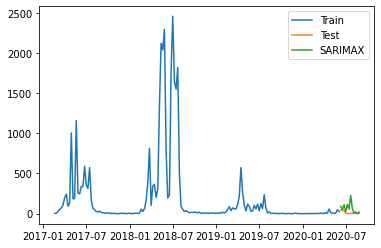

Current product:  9541
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00820D+00    |proj g|=  3.04763D-02

At iterate    5    f=  6.97974D+00    |proj g|=  9.90635D-02

At iterate   10    f=  6.56406D+00    |proj g|=  3.11645D-01

At iterate   15    f=  6.56074D+00    |proj g|=  2.19061D-03

At iterate   20    f=  6.55969D+00    |proj g|=  4.14723D-02

At iterate   25    f=  6.55848D+00    |proj g|=  4.53919D-03

At iterate   30    f=  6.55226D+00    |proj g|=  4.73238D-02

At iterate   35    f=  6.54307D+00    |proj g|=  3.68104D-02

At iterate   40    f=  6.54300D+00    |proj g|=  1.21421D-02

At iterate   45    f=  6.54296D+00    |proj g|=  2.19342D-03

At iterate   50    f=  6.54294D+00    |proj g|=  9.73405D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy po

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.06188D+00    |proj g|=  4.15347D-02

At iterate    5    f=  6.74352D+00    |proj g|=  3.17831D-01

At iterate   10    f=  6.63294D+00    |proj g|=  2.32898D-02

At iterate   15    f=  6.63219D+00    |proj g|=  2.25603D-03

At iterate   20    f=  6.63073D+00    |proj g|=  2.43144D-02

At iterate   25    f=  6.62295D+00    |proj g|=  1.31166D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     36      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.65168D+00    |proj g|=  1.11106D-03

At iterate   10    f=  6.65166D+00    |proj g|=  9.47874D-03

At iterate   15    f=  6.65011D+00    |proj g|=  7.93762D-02

At iterate   20    f=  6.64828D+00    |proj g|=  2.43776D-04

At iterate   25    f=  6.64828D+00    |proj g|=  2.85003D-03

At iterate   30    f=  6.64800D+00    |proj g|=  2.84955D-02

At iterate   35    f=  6.64751D+00    |proj g|=  9.58349D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     43      1     0     0   3.154D-05   6.648D+00
  F =   6.6475114857588382     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.59073D+00    |proj g|=  6.13676D-04

At iterate   10    f=  6.59070D+00    |proj g|=  1.00210D-03

At iterate   15    f=  6.59069D+00    |proj g|=  2.37253D-03

At iterate   20    f=  6.59042D+00    |proj g|=  2.36202D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     27      1     0     0   3.793D-06   6.590D+00
  F =   6.5903613797915179     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  4.021911360888564


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62951D+00    |proj g|=  3.86729D-01

At iterate    5    f=  6.57439D+00    |proj g|=  9.80895D-03

At iterate   10    f=  6.57170D+00    |proj g|=  8.35268D-03

At iterate   15    f=  6.57102D+00    |proj g|=  3.20962D-02

At iterate   20    f=  6.56988D+00    |proj g|=  6.84324D-02

At iterate   25    f=  6.56903D+00    |proj g|=  1.89518D-03

At iterate   30    f=  6.56801D+00    |proj g|=  2.75775D-02

At iterate   35    f=  6.56576D+00    |proj g|=  3.18030D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  6.92075D+00    |proj g|=  4.10611D-03

At iterate   10    f=  6.92053D+00    |proj g|=  2.14818D-03

At iterate   15    f=  6.91884D+00    |proj g|=  3.25308D-02

At iterate   20    f=  6.90764D+00    |proj g|=  1.03154D-02

At iterate   25    f=  6.90668D+00    |proj g|=  4.14947D-02

At iterate   30    f=  6.90515D+00    |proj g|=  9.13248D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     39      1     0     0   3.176D-05   6.905D+00
  F =   6.9051469077549426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  6.36821100317384
RUNNING THE L-BFGS-B CODE



 This problem is unconstrained.



At iterate    5    f=  6.92151D+00    |proj g|=  1.10520D-02

At iterate   10    f=  6.91774D+00    |proj g|=  2.08915D-03

At iterate   15    f=  6.91731D+00    |proj g|=  1.95918D-03

At iterate   20    f=  6.91290D+00    |proj g|=  1.35956D-02

At iterate   25    f=  6.89923D+00    |proj g|=  1.43626D-02

At iterate   30    f=  6.89815D+00    |proj g|=  1.17561D-03

At iterate   35    f=  6.89779D+00    |proj g|=  1.34116D-03

At iterate   40    f=  6.89770D+00    |proj g|=  3.30296D-04

At iterate   45    f=  6.89768D+00    |proj g|=  6.62711D-04

At iterate   50    f=  6.89763D+00    |proj g|=  2.02706D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.91519D+00    |proj g|=  2.35282D-03

At iterate   10    f=  6.91451D+00    |proj g|=  2.54113D-03

At iterate   15    f=  6.90485D+00    |proj g|=  1.98071D-02

At iterate   20    f=  6.88993D+00    |proj g|=  5.75368D-03

At iterate   25    f=  6.88856D+00    |proj g|=  2.96696D-03

At iterate   30    f=  6.88839D+00    |proj g|=  3.68920D-03

At iterate   35    f=  6.88835D+00    |proj g|=  3.11993D-04

At iterate   40    f=  6.88834D+00    |proj g|=  4.71404D-04

At iterate   45    f=  6.88691D+00    |proj g|=  1.70964D-02

At iterate   50    f=  6.88641D+00    |proj g|=  2.48828D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94689D+00    |proj g|=  1.35671D-01

At iterate    5    f=  6.91663D+00    |proj g|=  2.16846D-02

At iterate   10    f=  6.91421D+00    |proj g|=  1.79714D-03

At iterate   15    f=  6.91385D+00    |proj g|=  1.85987D-03

At iterate   20    f=  6.91321D+00    |proj g|=  4.88263D-02

At iterate   25    f=  6.89221D+00    |proj g|=  5.99404D-02

At iterate   30    f=  6.88902D+00    |proj g|=  1.20873D-02

At iterate   35    f=  6.88813D+00    |proj g|=  1.17372D-02

At iterate   40    f=  6.88780D+00    |proj g|=  8.73817D-03

At iterate   45    f=  6.88772D+00    |proj g|=  1.31881D-03

At iterate   50    f=  6.88770D+00    |proj g|=  3.81402D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.99670D+00    |proj g|=  1.26761D-01

At iterate    5    f=  6.95943D+00    |proj g|=  1.29739D-03

At iterate   10    f=  6.95829D+00    |proj g|=  9.86042D-03

At iterate   15    f=  6.93724D+00    |proj g|=  8.08974D-03

At iterate   20    f=  6.93683D+00    |proj g|=  1.36629D-04

At iterate   25    f=  6.93680D+00    |proj g|=  2.94129D-03

At iterate   30    f=  6.93645D+00    |proj g|=  4.69636D-03

At iterate   35    f=  6.93499D+00    |proj g|=  5.35120D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.18978D+00    |proj g|=  1.77445D-01

At iterate    5    f=  6.93345D+00    |proj g|=  9.05394D-02

At iterate   10    f=  6.90612D+00    |proj g|=  1.31036D-02

At iterate   15    f=  6.90514D+00    |proj g|=  1.32600D-03

At iterate   20    f=  6.90384D+00    |proj g|=  5.89197D-02

At iterate   25    f=  6.88881D+00    |proj g|=  5.99474D-03

At iterate   30    f=  6.88833D+00    |proj g|=  2.43788D-04

At iterate   35    f=  6.88832D+00    |proj g|=  3.36011D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     47      1     

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98854D+00    |proj g|=  8.68445D-02

At iterate    5    f=  6.97746D+00    |proj g|=  3.31520D-02

At iterate   10    f=  6.58887D+00    |proj g|=  7.81884D-02

At iterate   15    f=  6.55749D+00    |proj g|=  3.57517D-02

At iterate   20    f=  6.55320D+00    |proj g|=  1.00720D-02

At iterate   25    f=  6.55294D+00    |proj g|=  4.89906D-03

At iterate   30    f=  6.55163D+00    |proj g|=  8.15645D-02

At iterate   35    f=  6.54063D+00    |proj g|=  8.60223D-03

At iterate   40    f=  6.54055D+00    |proj g|=  4.87031D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.56959D+00    |proj g|=  1.05980D-02

At iterate   10    f=  6.56949D+00    |proj g|=  2.61574D-03

At iterate   15    f=  6.56830D+00    |proj g|=  3.59897D-02

At iterate   20    f=  6.56465D+00    |proj g|=  1.20351D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     26      1     0     0   3.092D-05   6.565D+00
  F =   6.5646493662531418     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  3.736922571731623
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate    5    f=  6.92629D+00    |proj g|=  2.37219D-02

At iterate   10    f=  6.91844D+00    |proj g|=  3.14477D-02

At iterate   15    f=  6.91727D+00    |proj g|=  2.99062D-03

At iterate   20    f=  6.91701D+00    |proj g|=  1.47134D-03

At iterate   25    f=  6.91541D+00    |proj g|=  1.43717D-02

At iterate   30    f=  6.90936D+00    |proj g|=  1.66670D-02

At iterate   35    f=  6.90059D+00    |proj g|=  1.31942D-01

At iterate   40    f=  6.89721D+00    |proj g|=  2.49668D-02

At iterate   45    f=  6.89718D+00    |proj g|=  2.14761D-03

At iterate   50    f=  6.89706D+00    |proj g|=  2.22650D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62266D+00    |proj g|=  3.72087D-01

At iterate    5    f=  6.57398D+00    |proj g|=  1.90788D-02

At iterate   10    f=  6.56569D+00    |proj g|=  3.60260D-03

At iterate   15    f=  6.56563D+00    |proj g|=  8.46233D-04

At iterate   20    f=  6.56539D+00    |proj g|=  1.52638D-02

At iterate   25    f=  6.56361D+00    |proj g|=  4.70787D-02

At iterate   30    f=  6.56236D+00    |proj g|=  9.67373D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  6.58117D+00    |proj g|=  1.46666D-01

At iterate   10    f=  6.56667D+00    |proj g|=  9.42504D-02

At iterate   15    f=  6.56447D+00    |proj g|=  1.59712D-03

At iterate   20    f=  6.56351D+00    |proj g|=  2.97956D-02

At iterate   25    f=  6.54947D+00    |proj g|=  2.10963D-02

At iterate   30    f=  6.54657D+00    |proj g|=  1.57316D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     50      1     0     0   4.003D-05   6.547D+00
  F =   6.5465680926264733     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  6.887240737191724
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



At iterate    5    f=  6.65168D+00    |proj g|=  1.11106D-03

At iterate   10    f=  6.65166D+00    |proj g|=  9.47874D-03

At iterate   15    f=  6.65011D+00    |proj g|=  7.93762D-02

At iterate   20    f=  6.64828D+00    |proj g|=  2.43776D-04

At iterate   25    f=  6.64828D+00    |proj g|=  2.85003D-03

At iterate   30    f=  6.64800D+00    |proj g|=  2.84955D-02

At iterate   35    f=  6.64751D+00    |proj g|=  9.58349D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     43      1     0     0   3.154D-05   6.648D+00
  F =   6.6475114857588382     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

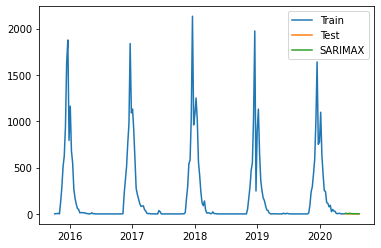

Total RMSE of top 10 selling products:  826.8080762280765 , total mape:  inf
selected productGroup:  [10133, 9662, 9399, 9306, 9400, 10135, 9898, 9630, 9897, 9860, 14759, 9901, 10019, 14508, 9994, 16444, 16353, 9995, 9205, 14760, 15112, 14536, 16409, 10022, 14540, 14251, 14490, 10017, 9560, 10005, 14238, 10002, 10197, 14288, 16527, 9541]
selected horizon:  3
Current product:  10133


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88903D+00    |proj g|=  2.27842D-01

At iterate    5    f=  9.82365D+00    |proj g|=  6.74497D-03

At iterate   10    f=  9.82358D+00    |proj g|=  7.27288D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   3.333D-05   9.824D+00
  F =   9.8235732047310620     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2345.9303858211792
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f=  9.95149D+00    |proj g|=  2.76772D-02

At iterate   10    f=  9.94977D+00    |proj g|=  4.99499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   1.184D-05   9.950D+00
  F =   9.9497652950294349     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1217.9382000893072


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95114D+00    |proj g|=  3.24143D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   1.167D-05   9.950D+00
  F =   9.9499851712695406     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1224.7700324926202
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.


rmse:  1219.3490514661373


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82762D+00    |proj g|=  5.10892D-02

At iterate    5    f=  9.82485D+00    |proj g|=  1.00653D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   4.769D-05   9.825D+00
  F =   9.8248469580699425     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2113.175949711234
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =       

 This problem is unconstrained.



At iterate    5    f=  9.81945D+00    |proj g|=  7.11538D-03

At iterate   10    f=  9.81878D+00    |proj g|=  1.06873D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     14      1     0     0   4.386D-05   9.819D+00
  F =   9.8187818861871996     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2079.943384907882


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82189D+00    |proj g|=  4.53596D-02

At iterate    5    f=  9.81478D+00    |proj g|=  9.81378D-03

At iterate   10    f=  9.80539D+00    |proj g|=  7.06662D-03

At iterate   15    f=  9.80368D+00    |proj g|=  6.32465D-03

At iterate   20    f=  9.80328D+00    |proj g|=  2.24454D-03

At iterate   25    f=  9.80290D+00    |proj g|=  9.83540D-04

At iterate   30    f=  9.80280D+00    |proj g|=  7.11833D-04

At iterate   35    f=  9.80277D+00    |proj g|=  1.22298D-04

At iterate   40    f=  9.80274D+00    |proj g|=  4.57998D-04

At iterate   45    f=  9.79881D+00    |proj g|=  2.69586D-02

At iterate   50    f=  9.79675D+00    |proj g|=  6.44224D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.81945D+00    |proj g|=  2.56481D-02

At iterate   10    f=  9.81758D+00    |proj g|=  2.23576D-02

At iterate   15    f=  9.81535D+00    |proj g|=  4.37009D-03

At iterate   20    f=  9.81508D+00    |proj g|=  2.52631D-04

At iterate   25    f=  9.81507D+00    |proj g|=  1.38363D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     29      1     0     0   4.524D-05   9.815D+00
  F =   9.8150686927683211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2282.3089881481715
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  9.81714D+00    |proj g|=  7.35925D-02

At iterate   10    f=  9.81219D+00    |proj g|=  7.34690D-03

At iterate   15    f=  9.81096D+00    |proj g|=  7.49259D-03

At iterate   20    f=  9.80981D+00    |proj g|=  5.78137D-04

At iterate   25    f=  9.80979D+00    |proj g|=  1.23032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     31      1     0     0   4.663D-05   9.810D+00
  F =   9.8097887220131579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2221.874671927854


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95369D+00    |proj g|=  4.18721D-02

At iterate    5    f=  9.95000D+00    |proj g|=  2.54224D-02

At iterate   10    f=  9.93534D+00    |proj g|=  1.63549D-02

At iterate   15    f=  9.93143D+00    |proj g|=  6.73140D-03

At iterate   20    f=  9.93026D+00    |proj g|=  6.52376D-04

At iterate   25    f=  9.92995D+00    |proj g|=  5.62551D-04

At iterate   30    f=  9.92990D+00    |proj g|=  7.70942D-05

At iterate   35    f=  9.92947D+00    |proj g|=  5.49309D-03

At iterate   40    f=  9.92453D+00    |proj g|=  1.31546D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  9.81123D+00    |proj g|=  2.68797D-02

At iterate   10    f=  9.80612D+00    |proj g|=  1.76778D-02

At iterate   15    f=  9.80496D+00    |proj g|=  1.27160D-03

At iterate   20    f=  9.80492D+00    |proj g|=  8.38810D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     22     27      1     0     0   4.959D-05   9.805D+00
  F =   9.8049209463490588     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2317.11185136774
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactl

 This problem is unconstrained.



At iterate    5    f=  9.81884D+00    |proj g|=  1.32258D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      9     11      1     0     0   3.429D-05   9.819D+00
  F =   9.8186848299279532     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2372.58259895744
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82630D+00    |proj g|=  7.59082D-02


 This problem is unconstrained.



At iterate    5    f=  9.81942D+00    |proj g|=  4.76952D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   3.269D-05   9.819D+00
  F =   9.8193582817057514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2154.2732309253556
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82189D+00    |proj g|=  5.52243D-02


 This problem is unconstrained.



At iterate    5    f=  9.80619D+00    |proj g|=  2.77630D-02

At iterate   10    f=  9.79977D+00    |proj g|=  7.91893D-03

At iterate   15    f=  9.79784D+00    |proj g|=  3.20186D-03

At iterate   20    f=  9.79744D+00    |proj g|=  6.86083D-03

At iterate   25    f=  9.79726D+00    |proj g|=  1.22521D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     29     33      1     0     0   3.308D-05   9.797D+00
  F =   9.7972507754613005     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2177.9733942542243
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  9.81950D+00    |proj g|=  1.98367D-04

At iterate   10    f=  9.81947D+00    |proj g|=  2.59856D-03

At iterate   15    f=  9.81940D+00    |proj g|=  8.93362D-03

At iterate   20    f=  9.81801D+00    |proj g|=  1.69210D-02

At iterate   25    f=  9.81647D+00    |proj g|=  8.66571D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     40      1     0     0   1.631D-05   9.816D+00
  F =   9.8164686879410148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2276.981384937626
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate    5    f=  9.82455D+00    |proj g|=  8.54950D-04

At iterate   10    f=  9.82452D+00    |proj g|=  6.26183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   4.478D-05   9.825D+00
  F =   9.8245225530780349     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2265.517410336211
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95369D+00    |proj g|=  4.18721D-02


 This problem is unconstrained.



At iterate    5    f=  9.95000D+00    |proj g|=  2.54224D-02

At iterate   10    f=  9.93534D+00    |proj g|=  1.63549D-02

At iterate   15    f=  9.93143D+00    |proj g|=  6.73140D-03

At iterate   20    f=  9.93026D+00    |proj g|=  6.52376D-04

At iterate   25    f=  9.92995D+00    |proj g|=  5.62551D-04

At iterate   30    f=  9.92990D+00    |proj g|=  7.70942D-05

At iterate   35    f=  9.92947D+00    |proj g|=  5.49309D-03

At iterate   40    f=  9.92453D+00    |proj g|=  1.31546D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     51      1     0     0   2.100D-06   9.925D+00
  F =   9.92453004088

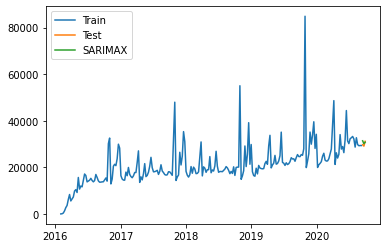

Current product:  9662


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.62139D+00    |proj g|=  9.33767D-02

At iterate    5    f=  9.59509D+00    |proj g|=  1.21570D-02

At iterate   10    f=  9.59490D+00    |proj g|=  5.78892D-04

At iterate   15    f=  9.59490D+00    |proj g|=  4.97301D-04

At iterate   20    f=  9.59481D+00    |proj g|=  5.94502D-03

At iterate   25    f=  9.58618D+00    |proj g|=  5.98734D-02

At iterate   30    f=  9.56408D+00    |proj g|=  1.50330D-03

At iterate   35    f=  9.56407D+00    |proj g|=  2.60858D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  9.73780D+00    |proj g|=  1.47718D-03

At iterate   10    f=  9.73776D+00    |proj g|=  3.55022D-04

At iterate   15    f=  9.73773D+00    |proj g|=  5.36764D-03

At iterate   20    f=  9.73409D+00    |proj g|=  4.90052D-02

At iterate   25    f=  9.72194D+00    |proj g|=  5.19718D-03

At iterate   30    f=  9.72083D+00    |proj g|=  4.31464D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     36      1     0     0   6.732D-07   9.721D+00
  F =   9.7208271250192020     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  869.5774517191267
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



At iterate    5    f=  9.76661D+00    |proj g|=  4.00945D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   4.009D-05   9.767D+00
  F =   9.7666086403553987     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  81.4386253261268
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81106D+00    |proj g|=  1.56481D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = t

 This problem is unconstrained.


rmse:  527.1669834900597


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.62150D+00    |proj g|=  9.58526D-02

At iterate    5    f=  9.61419D+00    |proj g|=  6.39088D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   6.822D-05   9.614D+00
  F =   9.6141837596585358     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  122.24552327918785
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =      

 This problem is unconstrained.



At iterate    5    f=  9.59731D+00    |proj g|=  2.54506D-03

At iterate   10    f=  9.59713D+00    |proj g|=  8.21526D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     14      1     0     0   8.215D-05   9.597D+00
  F =   9.5971289392554109     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  458.68484177909284


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66656D+00    |proj g|=  2.43804D-01

At iterate    5    f=  9.58640D+00    |proj g|=  1.70096D-02

At iterate   10    f=  9.57227D+00    |proj g|=  1.05119D-02

At iterate   15    f=  9.57137D+00    |proj g|=  1.57104D-03

At iterate   20    f=  9.57082D+00    |proj g|=  1.36271D-03

At iterate   25    f=  9.57081D+00    |proj g|=  8.04484D-05

At iterate   30    f=  9.57079D+00    |proj g|=  1.77241D-03

At iterate   35    f=  9.56887D+00    |proj g|=  1.66138D-02

At iterate   40    f=  9.54617D+00    |proj g|=  9.98476D-03

At iterate   45    f=  9.54306D+00    |proj g|=  5.77453D-04

At iterate   50    f=  9.54302D+00    |proj g|=  1.93962D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.68230D+00    |proj g|=  2.45713D-01

At iterate    5    f=  9.59359D+00    |proj g|=  8.07120D-03

At iterate   10    f=  9.59096D+00    |proj g|=  5.87126D-04

At iterate   15    f=  9.59095D+00    |proj g|=  3.78011D-04

At iterate   20    f=  9.59095D+00    |proj g|=  5.77941D-04

At iterate   25    f=  9.59090D+00    |proj g|=  1.73146D-03

At iterate   30    f=  9.58508D+00    |proj g|=  2.55064D-02

At iterate   35    f=  9.55838D+00    |proj g|=  3.95797D-02

At iterate   40    f=  9.54990D+00    |proj g|=  9.10968D-04

At iterate   45    f=  9.54981D+00    |proj g|=  1.56649D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.68230D+00    |proj g|=  2.45713D-01

At iterate    5    f=  9.59258D+00    |proj g|=  1.11558D-02

At iterate   10    f=  9.58937D+00    |proj g|=  1.77221D-03

At iterate   15    f=  9.58933D+00    |proj g|=  3.82410D-04

At iterate   20    f=  9.58933D+00    |proj g|=  3.40569D-04

At iterate   25    f=  9.58932D+00    |proj g|=  8.78961D-04

At iterate   30    f=  9.58913D+00    |proj g|=  6.00816D-03

At iterate   35    f=  9.58023D+00    |proj g|=  4.14568D-02

At iterate   40    f=  9.55147D+00    |proj g|=  1.56901D-02

At iterate   45    f=  9.54919D+00    |proj g|=  1.62230D-03

At iterate   50    f=  9.54916D+00    |proj g|=  5.81215D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.72651D+00    |proj g|=  1.30952D-02

At iterate   10    f=  9.72075D+00    |proj g|=  2.39185D-03

At iterate   15    f=  9.72066D+00    |proj g|=  1.01194D-04

At iterate   20    f=  9.72065D+00    |proj g|=  4.05386D-04

At iterate   25    f=  9.72015D+00    |proj g|=  1.46895D-02

At iterate   30    f=  9.69779D+00    |proj g|=  3.49493D-02

At iterate   35    f=  9.69194D+00    |proj g|=  1.70625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     41      1     0     0   8.928D-06   9.692D+00
  F =   9.6919429642451753     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.60020D+00    |proj g|=  3.54097D-02

At iterate   10    f=  9.58992D+00    |proj g|=  1.43955D-02

At iterate   15    f=  9.58810D+00    |proj g|=  4.55685D-04

At iterate   20    f=  9.58810D+00    |proj g|=  8.73813D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     21      1     0     0   8.738D-05   9.588D+00
  F =   9.5880953344342341     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  442.201557044944
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactl

 This problem is unconstrained.



At iterate    0    f=  1.01372D+01    |proj g|=  8.55412D-01

At iterate    5    f=  9.59498D+00    |proj g|=  2.77032D-02

At iterate   10    f=  9.58719D+00    |proj g|=  1.63648D-03

At iterate   15    f=  9.58710D+00    |proj g|=  8.72699D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     17      1     0     0   8.727D-05   9.587D+00
  F =   9.5870950366009033     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  309.1505939950778


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01454D+01    |proj g|=  8.79965D-01

At iterate    5    f=  9.60868D+00    |proj g|=  1.79832D-02

At iterate   10    f=  9.60509D+00    |proj g|=  5.19975D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     14      1     0     0   7.221D-05   9.605D+00
  F =   9.6050885556413039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  73.05445186572645
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f=  9.58351D+00    |proj g|=  9.12262D-03

At iterate   10    f=  9.57109D+00    |proj g|=  8.20951D-03

At iterate   15    f=  9.56934D+00    |proj g|=  2.30093D-03

At iterate   20    f=  9.56874D+00    |proj g|=  6.95111D-04

At iterate   25    f=  9.56874D+00    |proj g|=  7.97701D-05

At iterate   30    f=  9.56873D+00    |proj g|=  1.05803D-03

At iterate   35    f=  9.56724D+00    |proj g|=  2.21628D-02

At iterate   40    f=  9.55122D+00    |proj g|=  1.09889D-02

At iterate   45    f=  9.54185D+00    |proj g|=  1.00099D-02

At iterate   50    f=  9.54163D+00    |proj g|=  5.00778D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61152D+00    |proj g|=  2.58766D-02

At iterate    5    f=  9.60954D+00    |proj g|=  7.14490D-03

At iterate   10    f=  9.60405D+00    |proj g|=  1.87151D-02

At iterate   15    f=  9.60355D+00    |proj g|=  5.06493D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     20      1     0     0   5.065D-05   9.604D+00
  F =   9.6035505090667961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.64200D+00    |proj g|=  7.04163D-02

At iterate    5    f=  9.59957D+00    |proj g|=  4.04978D-04

At iterate   10    f=  9.59956D+00    |proj g|=  6.92797D-04

At iterate   15    f=  9.59923D+00    |proj g|=  9.12885D-03

At iterate   20    f=  9.57306D+00    |proj g|=  4.83726D-02

At iterate   25    f=  9.56718D+00    |proj g|=  2.90052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     31      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01454D+01    |proj g|=  8.79965D-01

At iterate    5    f=  9.60868D+00    |proj g|=  1.79832D-02

At iterate   10    f=  9.60509D+00    |proj g|=  5.19975D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     14      1     0     0   7.221D-05   9.605D+00
  F =   9.6050885556413039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id: 

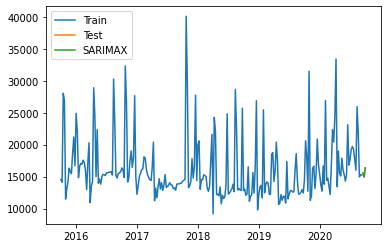

Current product:  9399


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35931D+00    |proj g|=  1.14998D-01

At iterate    5    f=  9.33612D+00    |proj g|=  1.70867D-02

At iterate   10    f=  9.33307D+00    |proj g|=  6.70954D-03

At iterate   15    f=  9.33251D+00    |proj g|=  9.13103D-04

At iterate   20    f=  9.33250D+00    |proj g|=  6.18292D-04

At iterate   25    f=  9.32841D+00    |proj g|=  1.32236D-01

At iterate   30    f=  9.28830D+00    |proj g|=  4.15643D-02

At iterate   35    f=  9.28719D+00    |proj g|=  1.23094D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46402D+00    |proj g|=  6.98869D-02

At iterate    5    f=  9.45720D+00    |proj g|=  7.39578D-03

At iterate   10    f=  9.45712D+00    |proj g|=  3.01934D-04

At iterate   15    f=  9.45708D+00    |proj g|=  6.46917D-03

At iterate   20    f=  9.45337D+00    |proj g|=  5.26966D-02

At iterate   25    f=  9.44562D+00    |proj g|=  7.87561D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46318D+00    |proj g|=  4.52597D-02

At iterate    5    f=  9.46090D+00    |proj g|=  6.36522D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   6.365D-05   9.461D+00
  F =   9.4608980075113145     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  512.8959806674134
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =       

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   7.619D-06   9.533D+00
  F =   9.5334283762562464     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  436.2059978789271


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35949D+00    |proj g|=  1.09644D-01

At iterate    5    f=  9.34247D+00    |proj g|=  3.86647D-03

At iterate   10    f=  9.34204D+00    |proj g|=  1.16351D-04

At iterate   15    f=  9.34204D+00    |proj g|=  1.36891D-03

At iterate   20    f=  9.34148D+00    |proj g|=  1.47990D-02

At iterate   25    f=  9.31150D+00    |proj g|=  3.56153D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     34      1     0     0   

 This problem is unconstrained.



At iterate    0    f=  9.36746D+00    |proj g|=  9.53259D-02

At iterate    5    f=  9.35339D+00    |proj g|=  1.72114D-02

At iterate   10    f=  9.35163D+00    |proj g|=  3.82590D-03

At iterate   15    f=  9.35162D+00    |proj g|=  3.24867D-04

At iterate   20    f=  9.35136D+00    |proj g|=  7.88512D-03

At iterate   25    f=  9.31541D+00    |proj g|=  4.29663D-02

At iterate   30    f=  9.31213D+00    |proj g|=  8.38689D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     35      1     0     0   8.387D-06   9.312D+00
  F =   9.3121325259228254     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.33011D+00    |proj g|=  1.02573D-02

At iterate   10    f=  9.32949D+00    |proj g|=  1.50893D-03

At iterate   15    f=  9.32946D+00    |proj g|=  2.84890D-04

At iterate   20    f=  9.32942D+00    |proj g|=  2.33034D-03

At iterate   25    f=  9.32938D+00    |proj g|=  1.14335D-04

At iterate   30    f=  9.32938D+00    |proj g|=  9.46940D-04

At iterate   35    f=  9.32161D+00    |proj g|=  5.44389D-02

At iterate   40    f=  9.29951D+00    |proj g|=  3.61080D-02

At iterate   45    f=  9.29753D+00    |proj g|=  2.29436D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     56   

 This problem is unconstrained.



At iterate    5    f=  9.35554D+00    |proj g|=  1.49283D-02

At iterate   10    f=  9.34910D+00    |proj g|=  4.63781D-03

At iterate   15    f=  9.34802D+00    |proj g|=  1.81275D-03

At iterate   20    f=  9.34796D+00    |proj g|=  1.31432D-04

At iterate   25    f=  9.34796D+00    |proj g|=  1.25860D-03

At iterate   30    f=  9.34725D+00    |proj g|=  1.55671D-02

At iterate   35    f=  9.30995D+00    |proj g|=  6.46823D-02

At iterate   40    f=  9.29961D+00    |proj g|=  5.04941D-03

At iterate   45    f=  9.29887D+00    |proj g|=  5.05128D-04

At iterate   50    f=  9.29886D+00    |proj g|=  5.85157D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.35484D+00    |proj g|=  1.70224D-02

At iterate   10    f=  9.34876D+00    |proj g|=  3.98591D-03

At iterate   15    f=  9.34768D+00    |proj g|=  2.80394D-03

At iterate   20    f=  9.34764D+00    |proj g|=  1.41446D-04

At iterate   25    f=  9.34760D+00    |proj g|=  3.48077D-03

At iterate   30    f=  9.33787D+00    |proj g|=  3.63710D-02

At iterate   35    f=  9.30686D+00    |proj g|=  1.81518D-02

At iterate   40    f=  9.29861D+00    |proj g|=  1.04263D-02

At iterate   45    f=  9.29851D+00    |proj g|=  2.53758D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     51   

 This problem is unconstrained.



At iterate    5    f=  9.45335D+00    |proj g|=  1.29592D-02

At iterate   10    f=  9.45104D+00    |proj g|=  8.63990D-04

At iterate   15    f=  9.45104D+00    |proj g|=  1.79995D-04

At iterate   20    f=  9.45099D+00    |proj g|=  7.42172D-03

At iterate   25    f=  9.43878D+00    |proj g|=  2.64040D-02

At iterate   30    f=  9.43248D+00    |proj g|=  2.00028D-03

At iterate   35    f=  9.43237D+00    |proj g|=  1.02309D-03

At iterate   40    f=  9.43232D+00    |proj g|=  9.27919D-04

At iterate   45    f=  9.43231D+00    |proj g|=  2.89655D-04

At iterate   50    f=  9.43231D+00    |proj g|=  1.10022D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    0    f=  9.41818D+00    |proj g|=  8.21309D-02

At iterate    5    f=  9.35089D+00    |proj g|=  5.77956D-03

At iterate   10    f=  9.35031D+00    |proj g|=  3.77730D-03

At iterate   15    f=  9.35010D+00    |proj g|=  8.81458D-03

At iterate   20    f=  9.34964D+00    |proj g|=  1.00986D-03

At iterate   25    f=  9.34963D+00    |proj g|=  2.95267D-04

At iterate   30    f=  9.34956D+00    |proj g|=  4.87042D-03

At iterate   35    f=  9.34600D+00    |proj g|=  2.87656D-02

At iterate   40    f=  9.31500D+00    |proj g|=  4.13813D-02

At iterate   45    f=  9.30950D+00    |proj g|=  2.35700D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.36517D+00    |proj g|=  1.19930D-01

At iterate    5    f=  9.33264D+00    |proj g|=  1.97092D-02

At iterate   10    f=  9.33230D+00    |proj g|=  1.97960D-03

At iterate   15    f=  9.33199D+00    |proj g|=  8.66398D-03

At iterate   20    f=  9.33181D+00    |proj g|=  1.33670D-04

At iterate   25    f=  9.33179D+00    |proj g|=  2.63225D-03

At iterate   30    f=  9.32929D+00    |proj g|=  3.99646D-02

At iterate   35    f=  9.28735D+00    |proj g|=  2.32921D-02

At iterate   40    f=  9.28614D+00    |proj g|=  9.12960D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.36502D+00    |proj g|=  1.19211D-01

At iterate    5    f=  9.34066D+00    |proj g|=  4.30784D-03

At iterate   10    f=  9.33897D+00    |proj g|=  1.54965D-03

At iterate   15    f=  9.33895D+00    |proj g|=  1.18165D-04

At iterate   20    f=  9.33886D+00    |proj g|=  2.59984D-03

At iterate   25    f=  9.32057D+00    |proj g|=  3.52532D-02

At iterate   30    f=  9.30548D+00    |proj g|=  2.87148D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  9.33112D+00    |proj g|=  3.67553D-02

At iterate   10    f=  9.32906D+00    |proj g|=  3.08980D-03

At iterate   15    f=  9.32898D+00    |proj g|=  1.12179D-04

At iterate   20    f=  9.32898D+00    |proj g|=  8.16822D-04

At iterate   25    f=  9.32888D+00    |proj g|=  2.66189D-03

At iterate   30    f=  9.32884D+00    |proj g|=  3.29090D-04

At iterate   35    f=  9.32868D+00    |proj g|=  2.32308D-02

At iterate   40    f=  9.31997D+00    |proj g|=  2.97129D-02

At iterate   45    f=  9.31391D+00    |proj g|=  2.93537D-02

At iterate   50    f=  9.30575D+00    |proj g|=  3.71683D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33100D+00    |proj g|=  5.65040D-02

At iterate    5    f=  9.32842D+00    |proj g|=  1.61520D-03

At iterate   10    f=  9.32841D+00    |proj g|=  1.34462D-04

At iterate   15    f=  9.32840D+00    |proj g|=  2.01707D-03

At iterate   20    f=  9.32837D+00    |proj g|=  2.41447D-03

At iterate   25    f=  9.32750D+00    |proj g|=  1.63274D-02

At iterate   30    f=  9.30991D+00    |proj g|=  1.01356D-02

At iterate   35    f=  9.30944D+00    |proj g|=  9.73653D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  9.34300D+00    |proj g|=  8.80582D-03

At iterate   10    f=  9.34144D+00    |proj g|=  2.06714D-04

At iterate   15    f=  9.34132D+00    |proj g|=  3.03536D-04

At iterate   20    f=  9.31341D+00    |proj g|=  8.90236D-02

At iterate   25    f=  9.29382D+00    |proj g|=  1.64633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     36      1     0     0   7.247D-05   9.294D+00
  F =   9.2938180357355371     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1279.2251933323037


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46402D+00    |proj g|=  6.98869D-02

At iterate    5    f=  9.45720D+00    |proj g|=  7.39578D-03

At iterate   10    f=  9.45712D+00    |proj g|=  3.01934D-04

At iterate   15    f=  9.45708D+00    |proj g|=  6.46917D-03

At iterate   20    f=  9.45337D+00    |proj g|=  5.26966D-02

At iterate   25    f=  9.44562D+00    |proj g|=  7.87561D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   

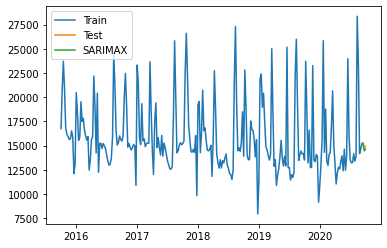

Current product:  9306


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.48910D+00    |proj g|=  1.66497D-01

At iterate    5    f=  9.41025D+00    |proj g|=  1.77924D-02

At iterate   10    f=  9.37902D+00    |proj g|=  3.49910D-03

At iterate   15    f=  9.37776D+00    |proj g|=  3.13727D-02

At iterate   20    f=  9.36978D+00    |proj g|=  2.40071D-02

At iterate   25    f=  9.36884D+00    |proj g|=  4.47768D-04

At iterate   30    f=  9.36880D+00    |proj g|=  3.69849D-03

At iterate   35    f=  9.36543D+00    |proj g|=  2.93077D-02

At iterate   40    f=  9.36246D+00    |proj g|=  3.67901D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  9.48089D+00    |proj g|=  2.08887D-02

At iterate   10    f=  9.46001D+00    |proj g|=  5.47439D-03

At iterate   15    f=  9.45996D+00    |proj g|=  1.80846D-03

At iterate   20    f=  9.45977D+00    |proj g|=  3.85550D-04

At iterate   25    f=  9.45966D+00    |proj g|=  6.42859D-04

At iterate   30    f=  9.45691D+00    |proj g|=  3.03541D-02

At iterate   35    f=  9.45409D+00    |proj g|=  9.88516D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     41      1     0     0   9.068D-06   9.454D+00
  F =   9.4540855309455694     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.45553D+00    |proj g|=  3.04466D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      8      1     0     0   3.045D-05   9.456D+00
  F =   9.4555304180530655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  465.7862023991814
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46178D+00    |proj g|=  3.21216D-02


 This problem is unconstrained.



At iterate    5    f=  9.46071D+00    |proj g|=  2.26313D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   2.263D-05   9.461D+00
  F =   9.4607133082862696     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  578.7551473475363
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37846D+00    |proj g|=  3.17725D-02


 This problem is unconstrained.



At iterate    5    f=  9.37360D+00    |proj g|=  1.32598D-02

At iterate   10    f=  9.37348D+00    |proj g|=  1.44347D-03

At iterate   15    f=  9.37255D+00    |proj g|=  1.95951D-02

At iterate   20    f=  9.36774D+00    |proj g|=  2.58843D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   2.709D-06   9.368D+00
  F =   9.3677235632458498     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1546.2789199130686
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exac

 This problem is unconstrained.



At iterate    5    f=  9.38445D+00    |proj g|=  4.63664D-03

At iterate   10    f=  9.38418D+00    |proj g|=  4.65007D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     15      1     0     0   4.952D-05   9.384D+00
  F =   9.3841834692918269     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1490.6139550528878


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39615D+00    |proj g|=  6.59339D-02

At iterate    5    f=  9.37670D+00    |proj g|=  1.10424D-02

At iterate   10    f=  9.37219D+00    |proj g|=  5.48861D-03

At iterate   15    f=  9.37138D+00    |proj g|=  1.80683D-03

At iterate   20    f=  9.37114D+00    |proj g|=  3.34176D-04

At iterate   25    f=  9.37105D+00    |proj g|=  1.00388D-03

At iterate   30    f=  9.36905D+00    |proj g|=  1.96192D-02

At iterate   35    f=  9.35773D+00    |proj g|=  2.66479D-02

At iterate   40    f=  9.35579D+00    |proj g|=  4.82584D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  9.37774D+00    |proj g|=  1.39662D-02

At iterate   10    f=  9.37460D+00    |proj g|=  5.56605D-03

At iterate   15    f=  9.37394D+00    |proj g|=  1.22009D-03

At iterate   20    f=  9.37363D+00    |proj g|=  1.17857D-03

At iterate   25    f=  9.37345D+00    |proj g|=  1.65355D-03

At iterate   30    f=  9.36092D+00    |proj g|=  2.21142D-02

At iterate   35    f=  9.35913D+00    |proj g|=  1.51985D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     43      1     0     0   2.632D-06   9.359D+00
  F =   9.3591267787298111     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39799D+00    |proj g|=  6.73132D-02

At iterate    5    f=  9.37702D+00    |proj g|=  1.13500D-02

At iterate   10    f=  9.37435D+00    |proj g|=  5.29041D-03

At iterate   15    f=  9.37380D+00    |proj g|=  9.78385D-04

At iterate   20    f=  9.37361D+00    |proj g|=  1.93813D-03

At iterate   25    f=  9.37348D+00    |proj g|=  4.35189D-04

At iterate   30    f=  9.35894D+00    |proj g|=  2.22314D-03

At iterate   35    f=  9.35884D+00    |proj g|=  2.57083D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  9.44083D+00    |proj g|=  1.03294D-02

At iterate   10    f=  9.43539D+00    |proj g|=  8.56105D-03

At iterate   15    f=  9.43370D+00    |proj g|=  2.09835D-03

At iterate   20    f=  9.43343D+00    |proj g|=  9.49245D-04

At iterate   25    f=  9.43335D+00    |proj g|=  4.12183D-04

At iterate   30    f=  9.42415D+00    |proj g|=  1.77432D-02

At iterate   35    f=  9.42103D+00    |proj g|=  6.46132D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     41      1     0     0   6.461D-06   9.421D+00
  F =   9.4210320186391687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.38524D+00    |proj g|=  1.62529D-02

At iterate   10    f=  9.38126D+00    |proj g|=  3.16257D-03

At iterate   15    f=  9.38043D+00    |proj g|=  3.11836D-03

At iterate   20    f=  9.38036D+00    |proj g|=  4.80915D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     23      1     0     0   4.809D-05   9.380D+00
  F =   9.3803599505303872     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1584.4128637020965
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exac

 This problem is unconstrained.



At iterate    5    f=  9.41725D+00    |proj g|=  5.79458D-02

At iterate   10    f=  9.38324D+00    |proj g|=  1.71279D-02

At iterate   15    f=  9.37791D+00    |proj g|=  4.28041D-03

At iterate   20    f=  9.37788D+00    |proj g|=  7.18225D-05

At iterate   25    f=  9.37785D+00    |proj g|=  2.94469D-03

At iterate   30    f=  9.37494D+00    |proj g|=  2.69030D-02

At iterate   35    f=  9.37464D+00    |proj g|=  2.51938D-02

At iterate   40    f=  9.36929D+00    |proj g|=  3.86853D-02

At iterate   45    f=  9.36609D+00    |proj g|=  1.72042D-03

At iterate   50    f=  9.36597D+00    |proj g|=  2.13845D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    0    f=  9.38220D+00    |proj g|=  4.47414D-02

At iterate    5    f=  9.37609D+00    |proj g|=  3.02823D-02

At iterate   10    f=  9.36860D+00    |proj g|=  2.25834D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     16      1     0     0   5.476D-05   9.369D+00
  F =   9.3685959896423245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1476.60729040876
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39615D+00    |proj g

 This problem is unconstrained.



At iterate    5    f=  9.37683D+00    |proj g|=  1.74818D-02

At iterate   10    f=  9.37237D+00    |proj g|=  7.26265D-03

At iterate   15    f=  9.37169D+00    |proj g|=  2.21512D-03

At iterate   20    f=  9.37123D+00    |proj g|=  1.94761D-03

At iterate   25    f=  9.37115D+00    |proj g|=  6.84023D-04

At iterate   30    f=  9.37108D+00    |proj g|=  5.69068D-04

At iterate   35    f=  9.37072D+00    |proj g|=  5.69420D-03

At iterate   40    f=  9.35986D+00    |proj g|=  2.65919D-02

At iterate   45    f=  9.35547D+00    |proj g|=  3.01534D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     53   

 This problem is unconstrained.



At iterate    5    f=  9.37690D+00    |proj g|=  6.07933D-03

At iterate   10    f=  9.37330D+00    |proj g|=  4.44105D-03

At iterate   15    f=  9.37314D+00    |proj g|=  6.10223D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     21      1     0     0   6.102D-05   9.373D+00
  F =   9.3731390125818717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1530.4391397871104
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.48965D+00    |proj

 This problem is unconstrained.



At iterate    5    f=  9.38553D+00    |proj g|=  1.69499D-02

At iterate   10    f=  9.37898D+00    |proj g|=  2.40993D-04

At iterate   15    f=  9.37630D+00    |proj g|=  2.69104D-02

At iterate   20    f=  9.37035D+00    |proj g|=  9.26632D-03

At iterate   25    f=  9.36948D+00    |proj g|=  5.65132D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     44      1     0     0   5.651D-05   9.369D+00
  F =   9.3694831465039101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1606.4221977288537
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  9.45553D+00    |proj g|=  3.04466D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      8      1     0     0   3.045D-05   9.456D+00
  F =   9.4555304180530655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  9306
Best Configs:  [(1, 1, 0), (1, 1, 0, 52)]
Mean Absolute Error: 384.015
Mean Squared Error: 19203.018
Root Mean Squared Error: 465.786
Mean absolute percentage error: 2.027
Scaled Mean absolute percentage error: 1.998
Mean forecast error: 19583.778
Normalised mean squared error: 0.622


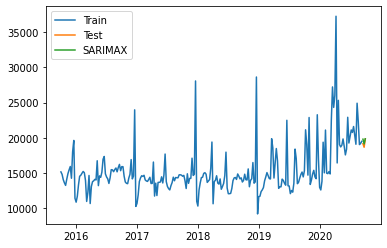

Current product:  9400
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.07354D+00    |proj g|=  1.13866D-01


 This problem is unconstrained.



At iterate    5    f=  9.02857D+00    |proj g|=  4.79132D-02

At iterate   10    f=  9.02593D+00    |proj g|=  1.89849D-04

At iterate   15    f=  9.02574D+00    |proj g|=  7.31245D-03

At iterate   20    f=  9.02084D+00    |proj g|=  1.29824D-02

At iterate   25    f=  9.02054D+00    |proj g|=  1.96567D-04

At iterate   30    f=  9.02049D+00    |proj g|=  4.85326D-03

At iterate   35    f=  9.01471D+00    |proj g|=  5.25905D-02

At iterate   40    f=  8.98066D+00    |proj g|=  2.58549D-02

At iterate   45    f=  8.97390D+00    |proj g|=  7.57878D-03

At iterate   50    f=  8.97357D+00    |proj g|=  1.11089D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12196D+00    |proj g|=  1.30365D-01

At iterate    5    f=  9.09850D+00    |proj g|=  1.81608D-02

At iterate   10    f=  9.09785D+00    |proj g|=  1.11819D-04

At iterate   15    f=  9.09784D+00    |proj g|=  1.87667D-03

At iterate   20    f=  9.09613D+00    |proj g|=  1.30994D-02

At iterate   25    f=  9.07802D+00    |proj g|=  2.39900D-02

At iterate   30    f=  9.07698D+00    |proj g|=  1.29795D-02

At iterate   35    f=  9.07591D+00    |proj g|=  4.51193D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  9.11223D+00    |proj g|=  3.68966D-04

At iterate   10    f=  9.11214D+00    |proj g|=  8.12506D-03

At iterate   15    f=  9.10624D+00    |proj g|=  5.23115D-02

At iterate   20    f=  9.09970D+00    |proj g|=  3.05834D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     24      1     0     0   7.554D-06   9.100D+00
  F =   9.0996976165753072     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  294.54497158361846
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exac

 This problem is unconstrained.


rmse:  77.72999715789834


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.06933D+00    |proj g|=  5.08504D-02

At iterate    5    f=  9.05870D+00    |proj g|=  4.97476D-04

At iterate   10    f=  9.04849D+00    |proj g|=  1.16258D-01

At iterate   15    f=  9.03673D+00    |proj g|=  2.02072D-04

At iterate   20    f=  9.03667D+00    |proj g|=  3.41704D-03

At iterate   25    f=  9.03024D+00    |proj g|=  2.30229D-02

At iterate   30    f=  9.01164D+00    |proj g|=  4.48130D-02

At iterate   35    f=  9.00979D+00    |proj g|=  6.43290D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  9.06832D+00    |proj g|=  2.54623D-04

At iterate   10    f=  9.06825D+00    |proj g|=  4.77717D-03

At iterate   15    f=  9.05206D+00    |proj g|=  1.01444D-02

At iterate   20    f=  9.05182D+00    |proj g|=  1.84708D-04

At iterate   25    f=  9.05179D+00    |proj g|=  4.65081D-03

At iterate   30    f=  9.04840D+00    |proj g|=  4.60543D-02

At iterate   35    f=  9.02078D+00    |proj g|=  2.64148D-02

At iterate   40    f=  9.01946D+00    |proj g|=  6.89712D-03

At iterate   45    f=  9.01936D+00    |proj g|=  6.09715D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     57   

 This problem is unconstrained.



At iterate    5    f=  9.02780D+00    |proj g|=  9.00934D-03

At iterate   10    f=  9.02509D+00    |proj g|=  7.66836D-03

At iterate   15    f=  9.02268D+00    |proj g|=  4.86148D-02

At iterate   20    f=  9.01708D+00    |proj g|=  2.36490D-03

At iterate   25    f=  9.01704D+00    |proj g|=  1.80629D-04

At iterate   30    f=  9.01697D+00    |proj g|=  3.20249D-03

At iterate   35    f=  9.01437D+00    |proj g|=  1.13898D-02

At iterate   40    f=  8.99322D+00    |proj g|=  2.27685D-02

At iterate   45    f=  8.97684D+00    |proj g|=  6.58962D-03

At iterate   50    f=  8.97635D+00    |proj g|=  2.85723D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16545D+00    |proj g|=  3.26356D-01

At iterate    5    f=  9.05180D+00    |proj g|=  1.01846D-02

At iterate   10    f=  9.05008D+00    |proj g|=  3.49715D-04

At iterate   15    f=  9.05007D+00    |proj g|=  1.71805D-03

At iterate   20    f=  9.04162D+00    |proj g|=  1.74957D-02

At iterate   25    f=  9.03832D+00    |proj g|=  5.23020D-04

At iterate   30    f=  9.03830D+00    |proj g|=  1.30802D-03

At iterate   35    f=  9.03663D+00    |proj g|=  2.00805D-02

At iterate   40    f=  9.00084D+00    |proj g|=  6.84823D-02

At iterate   45    f=  8.98454D+00    |proj g|=  2.42478D-03

At iterate   50    f=  8.98226D+00    |proj g|=  4.25056D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    0    f=  9.16545D+00    |proj g|=  3.26356D-01

At iterate    5    f=  9.05042D+00    |proj g|=  8.45561D-03

At iterate   10    f=  9.04853D+00    |proj g|=  4.84914D-03

At iterate   15    f=  9.04842D+00    |proj g|=  4.75109D-04

At iterate   20    f=  9.04829D+00    |proj g|=  8.49199D-03

At iterate   25    f=  9.03807D+00    |proj g|=  1.16005D-03

At iterate   30    f=  9.03802D+00    |proj g|=  5.13832D-04

At iterate   35    f=  9.03796D+00    |proj g|=  2.13414D-03

At iterate   40    f=  9.00184D+00    |proj g|=  9.59879D-02

At iterate   45    f=  8.98136D+00    |proj g|=  3.04975D-02

At iterate   50    f=  8.97949D+00    |proj g|=  1.83890D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.



At iterate    5    f=  9.09391D+00    |proj g|=  1.06907D-02

At iterate   10    f=  9.09104D+00    |proj g|=  8.45207D-03

At iterate   15    f=  9.09085D+00    |proj g|=  1.31814D-04

At iterate   20    f=  9.09084D+00    |proj g|=  1.59078D-03

At iterate   25    f=  9.08917D+00    |proj g|=  1.75743D-02

At iterate   30    f=  9.06172D+00    |proj g|=  2.19385D-02

At iterate   35    f=  9.05562D+00    |proj g|=  1.27501D-03

At iterate   40    f=  9.05559D+00    |proj g|=  2.10059D-03

At iterate   45    f=  9.05509D+00    |proj g|=  5.81391D-03

At iterate   50    f=  9.05460D+00    |proj g|=  3.36456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.04323D+00    |proj g|=  2.32083D-03

At iterate   10    f=  9.04283D+00    |proj g|=  2.37406D-03

At iterate   15    f=  9.04282D+00    |proj g|=  3.47164D-04

At iterate   20    f=  9.04281D+00    |proj g|=  5.54549D-04

At iterate   25    f=  9.04256D+00    |proj g|=  6.56121D-03

At iterate   30    f=  9.02065D+00    |proj g|=  7.42160D-02

At iterate   35    f=  8.99868D+00    |proj g|=  3.20175D-03

At iterate   40    f=  8.99844D+00    |proj g|=  1.17607D-03

At iterate   45    f=  8.99822D+00    |proj g|=  2.75108D-03

At iterate   50    f=  8.99813D+00    |proj g|=  1.62030D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.04595D+00    |proj g|=  1.14566D-01

At iterate    5    f=  9.01805D+00    |proj g|=  3.80359D-02

At iterate   10    f=  9.01475D+00    |proj g|=  4.31891D-03

At iterate   15    f=  9.01460D+00    |proj g|=  1.66577D-04

At iterate   20    f=  9.01448D+00    |proj g|=  3.98445D-03

At iterate   25    f=  8.98513D+00    |proj g|=  8.63125D-02

At iterate   30    f=  8.96573D+00    |proj g|=  1.17063D-02

At iterate   35    f=  8.96502D+00    |proj g|=  2.04884D-03

At iterate   40    f=  8.96492D+00    |proj g|=  4.83290D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.03893D+00    |proj g|=  8.06203D-02

At iterate    5    f=  9.02941D+00    |proj g|=  1.19473D-02

At iterate   10    f=  9.02888D+00    |proj g|=  1.39286D-04

At iterate   15    f=  9.02888D+00    |proj g|=  1.28917D-03

At iterate   20    f=  9.02802D+00    |proj g|=  1.64502D-02

At iterate   25    f=  9.00190D+00    |proj g|=  3.17900D-02

At iterate   30    f=  9.00010D+00    |proj g|=  6.41441D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12847D+00    |proj g|=  3.34678D-01

At iterate    5    f=  9.02662D+00    |proj g|=  7.65315D-03

At iterate   10    f=  9.02455D+00    |proj g|=  3.05154D-03

At iterate   15    f=  9.02158D+00    |proj g|=  1.45958D-02

At iterate   20    f=  9.01713D+00    |proj g|=  4.40966D-03

At iterate   25    f=  9.01701D+00    |proj g|=  1.80395D-04

At iterate   30    f=  9.01700D+00    |proj g|=  9.83832D-04

At iterate   35    f=  9.01596D+00    |proj g|=  1.04929D-02

At iterate   40    f=  8.98855D+00    |proj g|=  8.16074D-03

At iterate   45    f=  8.97881D+00    |proj g|=  2.64665D-02

At iterate   50    f=  8.97560D+00    |proj g|=  3.42451D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.03502D+00    |proj g|=  3.87561D-02

At iterate    5    f=  9.03162D+00    |proj g|=  9.62684D-03

At iterate   10    f=  9.02119D+00    |proj g|=  4.88732D-03

At iterate   15    f=  9.02114D+00    |proj g|=  1.35940D-04

At iterate   20    f=  9.02113D+00    |proj g|=  3.85591D-03

At iterate   25    f=  9.01957D+00    |proj g|=  4.08691D-02

At iterate   30    f=  9.00582D+00    |proj g|=  4.58448D-02

At iterate   35    f=  9.00310D+00    |proj g|=  7.40844D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.10242D+00    |proj g|=  1.29397D-01

At iterate    5    f=  9.07754D+00    |proj g|=  8.82005D-03

At iterate   10    f=  9.07705D+00    |proj g|=  2.44462D-04

At iterate   15    f=  9.07704D+00    |proj g|=  9.82767D-04

At iterate   20    f=  9.07585D+00    |proj g|=  3.29914D-02

At iterate   25    f=  9.04883D+00    |proj g|=  1.19138D-02

At iterate   30    f=  9.04396D+00    |proj g|=  1.11365D-02

At iterate   35    f=  9.04117D+00    |proj g|=  8.65442D-04

At iterate   40    f=  9.04061D+00    |proj g|=  1.45566D-03

At iterate   45    f=  9.04044D+00    |proj g|=  2.44901D-04

At iterate   50    f=  9.04040D+00    |proj g|=  2.26038D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.02941D+00    |proj g|=  1.19473D-02

At iterate   10    f=  9.02888D+00    |proj g|=  1.39286D-04

At iterate   15    f=  9.02888D+00    |proj g|=  1.28917D-03

At iterate   20    f=  9.02802D+00    |proj g|=  1.64502D-02

At iterate   25    f=  9.00190D+00    |proj g|=  3.17900D-02

At iterate   30    f=  9.00010D+00    |proj g|=  6.41441D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     34      1     0     0   1.033D-04   9.000D+00
  F =   9.0001025744745409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

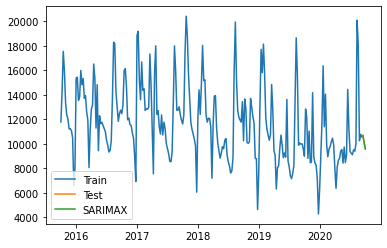

Current product:  10135


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12495D+00    |proj g|=  8.26641D-02

At iterate    5    f=  9.10465D+00    |proj g|=  6.12224D-03

At iterate   10    f=  9.10395D+00    |proj g|=  4.22963D-05

At iterate   15    f=  9.10395D+00    |proj g|=  9.20362D-04

At iterate   20    f=  9.10340D+00    |proj g|=  9.89425D-03

At iterate   25    f=  9.10132D+00    |proj g|=  4.86983D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     33      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  9.14872D+00    |proj g|=  3.34303D-02

At iterate   10    f=  9.14703D+00    |proj g|=  7.78694D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   2.041D-05   9.147D+00
  F =   9.1470302839505653     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  382.36227924392443


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16880D+00    |proj g|=  9.92683D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   4.912D-06   9.161D+00
  F =   9.1607120591988149     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  412.33409412290206
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.



At iterate    5    f=  9.19374D+00    |proj g|=  5.25516D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   5.255D-05   9.194D+00
  F =   9.1937422596457399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  355.99244808844537


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12636D+00    |proj g|=  1.22276D-01

At iterate    5    f=  9.10879D+00    |proj g|=  1.14294D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   4.138D-05   9.109D+00
  F =   9.1087864580647135     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  644.2407317735666
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =       

 This problem is unconstrained.



At iterate    5    f=  9.07318D+00    |proj g|=  1.01664D-02

At iterate   10    f=  9.07282D+00    |proj g|=  1.06308D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     12      1     0     0   1.063D-04   9.073D+00
  F =   9.0728186426352462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  721.4217463991199
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14365D+00    |proj g|=  2.06919D-01


 This problem is unconstrained.



At iterate    5    f=  9.07589D+00    |proj g|=  2.53314D-02

At iterate   10    f=  9.06250D+00    |proj g|=  4.44561D-03

At iterate   15    f=  9.06088D+00    |proj g|=  3.60965D-03

At iterate   20    f=  9.06086D+00    |proj g|=  2.91612D-04

At iterate   25    f=  9.06083D+00    |proj g|=  4.07474D-03

At iterate   30    f=  9.05539D+00    |proj g|=  8.46761D-03

At iterate   35    f=  9.03647D+00    |proj g|=  5.65816D-03

At iterate   40    f=  9.03619D+00    |proj g|=  6.04196D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     45      1     0     0   1.996D-06   9.036D+00
  F =   9.03619081709

 This problem is unconstrained.



At iterate    5    f=  9.07598D+00    |proj g|=  5.69184D-02

At iterate   10    f=  9.07260D+00    |proj g|=  1.86330D-03

At iterate   15    f=  9.07258D+00    |proj g|=  1.16048D-04

At iterate   20    f=  9.07255D+00    |proj g|=  3.47462D-03

At iterate   25    f=  9.06888D+00    |proj g|=  4.32876D-02

At iterate   30    f=  9.04330D+00    |proj g|=  7.01683D-03

At iterate   35    f=  9.04293D+00    |proj g|=  1.56266D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     40      1     0     0   1.090D-05   9.043D+00
  F =   9.0429211299015453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  9.06869D+00    |proj g|=  1.12547D-02

At iterate   10    f=  9.06804D+00    |proj g|=  3.60146D-03

At iterate   15    f=  9.06800D+00    |proj g|=  1.16419D-04

At iterate   20    f=  9.06793D+00    |proj g|=  5.06030D-03

At iterate   25    f=  9.06056D+00    |proj g|=  5.23549D-02

At iterate   30    f=  9.04093D+00    |proj g|=  7.36622D-03

At iterate   35    f=  9.04008D+00    |proj g|=  3.03005D-02

At iterate   40    f=  9.03838D+00    |proj g|=  4.91727D-03

At iterate   45    f=  9.03834D+00    |proj g|=  7.97121D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     51   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19183D+00    |proj g|=  1.86507D-01

At iterate    5    f=  9.13487D+00    |proj g|=  1.37270D-02

At iterate   10    f=  9.13184D+00    |proj g|=  1.82863D-03

At iterate   15    f=  9.13182D+00    |proj g|=  2.32918D-04

At iterate   20    f=  9.13166D+00    |proj g|=  3.63289D-03

At iterate   25    f=  9.12708D+00    |proj g|=  2.15477D-02

At iterate   30    f=  9.12583D+00    |proj g|=  4.54641D-03

At iterate   35    f=  9.12560D+00    |proj g|=  1.05906D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    0    f=  9.15496D+00    |proj g|=  2.14569D-01

At iterate    5    f=  9.08681D+00    |proj g|=  4.69232D-02

At iterate   10    f=  9.06868D+00    |proj g|=  7.52245D-03

At iterate   15    f=  9.06845D+00    |proj g|=  3.75232D-03

At iterate   20    f=  9.06843D+00    |proj g|=  9.78765D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     22      1     0     0   9.788D-05   9.068D+00
  F =   9.0684268827167482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  605.3140757768938
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate    5    f=  9.10165D+00    |proj g|=  4.27224D-02

At iterate   10    f=  9.09953D+00    |proj g|=  6.87729D-03

At iterate   15    f=  9.09920D+00    |proj g|=  3.46326D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     19      1     0     0   3.463D-05   9.099D+00
  F =   9.0991986774997269     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  508.62866944364816


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12981D+00    |proj g|=  1.28929D-01

At iterate    5    f=  9.11345D+00    |proj g|=  2.58613D-02

At iterate   10    f=  9.10719D+00    |proj g|=  7.58481D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     16      1     0     0   3.020D-05   9.107D+00
  F =   9.1071938050107661     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  618.5479877980754
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f=  9.07074D+00    |proj g|=  3.15932D-02

At iterate   10    f=  9.05806D+00    |proj g|=  6.32958D-03

At iterate   15    f=  9.05553D+00    |proj g|=  4.75709D-03

At iterate   20    f=  9.05541D+00    |proj g|=  1.10843D-04

At iterate   25    f=  9.05541D+00    |proj g|=  1.14204D-03

At iterate   30    f=  9.05444D+00    |proj g|=  1.12000D-02

At iterate   35    f=  9.04080D+00    |proj g|=  3.75993D-02

At iterate   40    f=  9.03019D+00    |proj g|=  4.27533D-03

At iterate   45    f=  9.02977D+00    |proj g|=  2.40859D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     55   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12747D+00    |proj g|=  1.32547D-01

At iterate    5    f=  9.11177D+00    |proj g|=  1.79497D-02

At iterate   10    f=  9.09915D+00    |proj g|=  2.10783D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     18      1     0     0   3.097D-05   9.099D+00
  F =   9.0991402422834238     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  677.8286445207691


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11788D+00    |proj g|=  8.00513D-02

At iterate    5    f=  9.10546D+00    |proj g|=  8.22474D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     12      1     0     0   4.834D-05   9.105D+00
  F =   9.1054616273620983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  580.1041407664425
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =       

 This problem is unconstrained.



At iterate    5    f=  9.19374D+00    |proj g|=  5.25516D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   5.255D-05   9.194D+00
  F =   9.1937422596457399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  10135
Best Configs:  [(1, 1, 0), (0, 1, 0, 52)]
Mean Absolute Error: 285.681
Mean Squared Error: 13965.688
Root Mean Squared Error: 355.992
Mean absolute percentage error: 2.007
Scaled Mean absolute percentage error: 2.022
Mean forecast error: 13870.688
Normalised mean squared error: 0.362

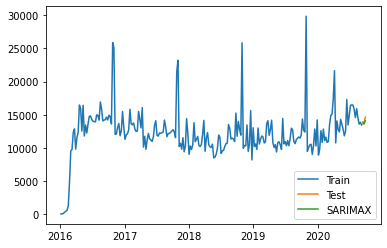

Current product:  9898
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68192D+00    |proj g|=  2.96342D-01


 This problem is unconstrained.



At iterate    5    f=  8.57819D+00    |proj g|=  3.07355D-02

At iterate   10    f=  8.57245D+00    |proj g|=  4.61560D-03

At iterate   15    f=  8.57240D+00    |proj g|=  6.04266D-04

At iterate   20    f=  8.57045D+00    |proj g|=  1.03711D-02

At iterate   25    f=  8.54839D+00    |proj g|=  3.10737D-02

At iterate   30    f=  8.54425D+00    |proj g|=  1.26929D-02

At iterate   35    f=  8.54238D+00    |proj g|=  1.63826D-03

At iterate   40    f=  8.54207D+00    |proj g|=  7.27088D-04

At iterate   45    f=  8.54202D+00    |proj g|=  8.02663D-04

At iterate   50    f=  8.54201D+00    |proj g|=  4.15392D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.65907D+00    |proj g|=  1.57033D-02

At iterate   10    f=  8.65693D+00    |proj g|=  1.13602D-04

At iterate   15    f=  8.65690D+00    |proj g|=  2.04239D-03

At iterate   20    f=  8.65483D+00    |proj g|=  1.67009D-02

At iterate   25    f=  8.64301D+00    |proj g|=  3.54479D-03

At iterate   30    f=  8.64295D+00    |proj g|=  2.53806D-03

At iterate   35    f=  8.64237D+00    |proj g|=  2.07933D-03

At iterate   40    f=  8.64216D+00    |proj g|=  1.11942D-03

At iterate   45    f=  8.64212D+00    |proj g|=  2.81617D-04

At iterate   50    f=  8.64211D+00    |proj g|=  3.67382D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   6.095D-05   8.673D+00
  F =   8.6731803585912459     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  420.99394000800555
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69888D+00    |proj g|=  8.32622D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip

 This problem is unconstrained.


rmse:  485.5284169727596
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61994D+00    |proj g|=  9.41305D-02


 This problem is unconstrained.



At iterate    5    f=  8.59311D+00    |proj g|=  1.29402D-02

At iterate   10    f=  8.59218D+00    |proj g|=  1.45157D-03

At iterate   15    f=  8.59016D+00    |proj g|=  2.19321D-02

At iterate   20    f=  8.57799D+00    |proj g|=  1.10672D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   3.851D-06   8.578D+00
  F =   8.5778921907246488     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  356.1567663593358
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate    5    f=  8.60417D+00    |proj g|=  5.25648D-03

At iterate   10    f=  8.60388D+00    |proj g|=  2.46360D-04

At iterate   15    f=  8.60297D+00    |proj g|=  5.26815D-03

At iterate   20    f=  8.58179D+00    |proj g|=  8.83041D-02

At iterate   25    f=  8.57643D+00    |proj g|=  5.85294D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   2.182D-06   8.576D+00
  F =   8.5764341413005472     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  662.3275435998524


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.62333D+00    |proj g|=  1.43191D-01

At iterate    5    f=  8.57306D+00    |proj g|=  4.80612D-03

At iterate   10    f=  8.57215D+00    |proj g|=  1.37349D-03

At iterate   15    f=  8.57212D+00    |proj g|=  9.65097D-04

At iterate   20    f=  8.57146D+00    |proj g|=  1.12865D-02

At iterate   25    f=  8.54775D+00    |proj g|=  2.15936D-02

At iterate   30    f=  8.52612D+00    |proj g|=  4.83360D-03

At iterate   35    f=  8.52515D+00    |proj g|=  2.33885D-03

At iterate   40    f=  8.52505D+00    |proj g|=  2.84251D-04

At iterate   45    f=  8.52503D+00    |proj g|=  1.49867D-03

At iterate   50    f=  8.52490D+00    |proj g|=  6.50176D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65843D+00    |proj g|=  1.49006D-01

At iterate    5    f=  8.59293D+00    |proj g|=  8.06413D-03

At iterate   10    f=  8.59066D+00    |proj g|=  2.05720D-03

At iterate   15    f=  8.59052D+00    |proj g|=  2.47065D-04

At iterate   20    f=  8.59044D+00    |proj g|=  4.14946D-03

At iterate   25    f=  8.57202D+00    |proj g|=  5.96296D-02

At iterate   30    f=  8.53962D+00    |proj g|=  3.08112D-02

At iterate   35    f=  8.53344D+00    |proj g|=  7.30744D-03

At iterate   40    f=  8.53302D+00    |proj g|=  2.05135D-03

At iterate   45    f=  8.53190D+00    |proj g|=  1.41134D-02

At iterate   50    f=  8.53146D+00    |proj g|=  3.03396D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65843D+00    |proj g|=  1.49006D-01

At iterate    5    f=  8.59161D+00    |proj g|=  8.32447D-03

At iterate   10    f=  8.58922D+00    |proj g|=  3.37300D-03

At iterate   15    f=  8.58918D+00    |proj g|=  3.80195D-04

At iterate   20    f=  8.58881D+00    |proj g|=  6.25011D-03

At iterate   25    f=  8.55859D+00    |proj g|=  5.87136D-02

At iterate   30    f=  8.54639D+00    |proj g|=  1.33258D-02

At iterate   35    f=  8.53157D+00    |proj g|=  1.35063D-03

At iterate   40    f=  8.53111D+00    |proj g|=  8.85603D-03

At iterate   45    f=  8.53067D+00    |proj g|=  2.02697D-04

At iterate   50    f=  8.53067D+00    |proj g|=  3.54726D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.70694D+00    |proj g|=  1.77901D-01

At iterate    5    f=  8.64306D+00    |proj g|=  8.65324D-03

At iterate   10    f=  8.64139D+00    |proj g|=  3.39962D-04

At iterate   15    f=  8.64139D+00    |proj g|=  1.32889D-03

At iterate   20    f=  8.64062D+00    |proj g|=  1.53066D-02

At iterate   25    f=  8.60242D+00    |proj g|=  1.71634D-02

At iterate   30    f=  8.60178D+00    |proj g|=  3.65553D-03

At iterate   35    f=  8.60071D+00    |proj g|=  6.78502D-03

At iterate   40    f=  8.60058D+00    |proj g|=  2.46138D-04

At iterate   45    f=  8.60058D+00    |proj g|=  2.96739D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77859D+00    |proj g|=  4.20355D-01

At iterate    5    f=  8.61767D+00    |proj g|=  6.96783D-02

At iterate   10    f=  8.59537D+00    |proj g|=  3.18141D-02

At iterate   15    f=  8.59103D+00    |proj g|=  3.63564D-03

At iterate   20    f=  8.59084D+00    |proj g|=  1.93618D-04

At iterate   25    f=  8.59082D+00    |proj g|=  2.32639D-03

At iterate   30    f=  8.58791D+00    |proj g|=  2.65289D-02

At iterate   35    f=  8.56161D+00    |proj g|=  8.59177D-03

At iterate   40    f=  8.56125D+00    |proj g|=  1.48206D-03

At iterate   45    f=  8.56052D+00    |proj g|=  9.33750D-03

At iterate   50    f=  8.55985D+00    |proj g|=  4.57979D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.61102D+00    |proj g|=  5.04363D-02

At iterate   10    f=  8.56628D+00    |proj g|=  1.30726D-02

At iterate   15    f=  8.56185D+00    |proj g|=  1.90330D-03

At iterate   20    f=  8.56181D+00    |proj g|=  2.35551D-04

At iterate   25    f=  8.56166D+00    |proj g|=  6.51422D-03

At iterate   30    f=  8.55385D+00    |proj g|=  2.71870D-02

At iterate   35    f=  8.54457D+00    |proj g|=  2.17883D-03

At iterate   40    f=  8.54329D+00    |proj g|=  2.73066D-02

At iterate   45    f=  8.54151D+00    |proj g|=  6.59251D-03

At iterate   50    f=  8.54116D+00    |proj g|=  3.06139D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.61044D+00    |proj g|=  5.50495D-02

At iterate   10    f=  8.57754D+00    |proj g|=  2.60125D-02

At iterate   15    f=  8.57590D+00    |proj g|=  1.36294D-04

At iterate   20    f=  8.57552D+00    |proj g|=  6.12361D-03

At iterate   25    f=  8.56805D+00    |proj g|=  1.19280D-02

At iterate   30    f=  8.56696D+00    |proj g|=  6.93436D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     35      1     0     0   6.934D-06   8.567D+00
  F =   8.5669618095675943     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  318.9557789879123
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



At iterate    5    f=  8.57122D+00    |proj g|=  1.12276D-02

At iterate   10    f=  8.57046D+00    |proj g|=  6.07961D-03

At iterate   15    f=  8.57028D+00    |proj g|=  4.14969D-04

At iterate   20    f=  8.57027D+00    |proj g|=  1.02418D-03

At iterate   25    f=  8.56967D+00    |proj g|=  1.00746D-02

At iterate   30    f=  8.54461D+00    |proj g|=  4.19576D-02

At iterate   35    f=  8.52652D+00    |proj g|=  1.09544D-02

At iterate   40    f=  8.52555D+00    |proj g|=  6.34395D-03

At iterate   45    f=  8.52429D+00    |proj g|=  7.97602D-04

At iterate   50    f=  8.52425D+00    |proj g|=  4.43189D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.60627D+00    |proj g|=  9.68783D-02

At iterate    5    f=  8.59614D+00    |proj g|=  3.47059D-02

At iterate   10    f=  8.58371D+00    |proj g|=  3.94887D-03

At iterate   15    f=  8.58349D+00    |proj g|=  1.27626D-04

At iterate   20    f=  8.58349D+00    |proj g|=  1.25052D-03

At iterate   25    f=  8.58319D+00    |proj g|=  1.58679D-02

At iterate   30    f=  8.57605D+00    |proj g|=  1.71023D-02

At iterate   35    f=  8.57568D+00    |proj g|=  3.44486D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    0    f=  8.70067D+00    |proj g|=  2.98902D-01

At iterate    5    f=  8.58984D+00    |proj g|=  2.70081D-02

At iterate   10    f=  8.58687D+00    |proj g|=  2.80157D-04

At iterate   15    f=  8.58685D+00    |proj g|=  2.00185D-03

At iterate   20    f=  8.58359D+00    |proj g|=  3.44745D-02

At iterate   25    f=  8.56174D+00    |proj g|=  1.69058D-02

At iterate   30    f=  8.55584D+00    |proj g|=  1.61378D-03

At iterate   35    f=  8.55480D+00    |proj g|=  8.94330D-03

At iterate   40    f=  8.55449D+00    |proj g|=  1.80791D-03

At iterate   45    f=  8.55444D+00    |proj g|=  2.89935D-05

At iterate   50    f=  8.55444D+00    |proj g|=  1.79853D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.



At iterate    5    f=  8.59614D+00    |proj g|=  3.47059D-02

At iterate   10    f=  8.58371D+00    |proj g|=  3.94887D-03

At iterate   15    f=  8.58349D+00    |proj g|=  1.27626D-04

At iterate   20    f=  8.58349D+00    |proj g|=  1.25052D-03

At iterate   25    f=  8.58319D+00    |proj g|=  1.58679D-02

At iterate   30    f=  8.57605D+00    |proj g|=  1.71023D-02

At iterate   35    f=  8.57568D+00    |proj g|=  3.44486D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     40      1     0     0   8.786D-06   8.576D+00
  F =   8.5756846465583472     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

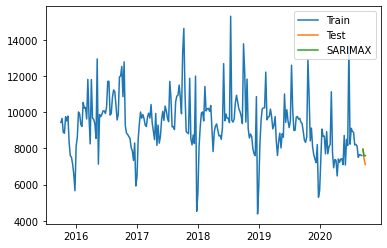

Current product:  9630
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92327D+00    |proj g|=  5.28930D-02


 This problem is unconstrained.



At iterate    5    f=  8.89977D+00    |proj g|=  9.45306D-03

At iterate   10    f=  8.89930D+00    |proj g|=  2.56648D-04

At iterate   15    f=  8.89928D+00    |proj g|=  2.07263D-03

At iterate   20    f=  8.89713D+00    |proj g|=  2.92784D-02

At iterate   25    f=  8.86043D+00    |proj g|=  4.07877D-02

At iterate   30    f=  8.85210D+00    |proj g|=  9.80426D-03

At iterate   35    f=  8.85135D+00    |proj g|=  4.85031D-03

At iterate   40    f=  8.85128D+00    |proj g|=  3.84545D-04

At iterate   45    f=  8.85128D+00    |proj g|=  4.39899D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     52   

 This problem is unconstrained.



At iterate    5    f=  8.95157D+00    |proj g|=  1.44319D-02

At iterate   10    f=  8.95098D+00    |proj g|=  1.74613D-04

At iterate   15    f=  8.95087D+00    |proj g|=  8.57480D-03

At iterate   20    f=  8.93928D+00    |proj g|=  7.55440D-02

At iterate   25    f=  8.91951D+00    |proj g|=  2.01386D-03

At iterate   30    f=  8.91947D+00    |proj g|=  3.59697D-03

At iterate   35    f=  8.91929D+00    |proj g|=  1.23963D-03

At iterate   40    f=  8.91924D+00    |proj g|=  4.32147D-04

At iterate   45    f=  8.91923D+00    |proj g|=  2.44370D-04

At iterate   50    f=  8.91713D+00    |proj g|=  2.17803D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.96721D+00    |proj g|=  2.56121D-02

At iterate    5    f=  8.96666D+00    |proj g|=  1.82823D-04

At iterate   10    f=  8.96661D+00    |proj g|=  5.52506D-03

At iterate   15    f=  8.96254D+00    |proj g|=  4.40026D-02

At iterate   20    f=  8.95404D+00    |proj g|=  1.14146D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     26      1     0     0   8.777D-06   8.954D+00
  F =   8.9540347825077760     

CONVERG

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   1.139D-05   9.042D+00
  F =   9.0421298152837686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  447.4261056654681


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92225D+00    |proj g|=  4.90646D-02

At iterate    5    f=  8.91103D+00    |proj g|=  3.18254D-03

At iterate   10    f=  8.91102D+00    |proj g|=  3.12235D-04

At iterate   15    f=  8.91089D+00    |proj g|=  5.48537D-03

At iterate   20    f=  8.90217D+00    |proj g|=  5.99255D-02

At iterate   25    f=  8.88594D+00    |proj g|=  6.72419D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.93876D+00    |proj g|=  3.73162D-02

At iterate    5    f=  8.93440D+00    |proj g|=  3.71897D-03

At iterate   10    f=  8.93434D+00    |proj g|=  1.40657D-04

At iterate   15    f=  8.93429D+00    |proj g|=  3.72990D-03

At iterate   20    f=  8.92690D+00    |proj g|=  2.98176D-02

At iterate   25    f=  8.91024D+00    |proj g|=  1.92869D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  8.90509D+00    |proj g|=  1.13688D-02

At iterate   10    f=  8.90059D+00    |proj g|=  2.48522D-03

At iterate   15    f=  8.90050D+00    |proj g|=  2.71365D-04

At iterate   20    f=  8.90039D+00    |proj g|=  3.41340D-03

At iterate   25    f=  8.88470D+00    |proj g|=  1.31011D-02

At iterate   30    f=  8.87118D+00    |proj g|=  7.22240D-02

At iterate   35    f=  8.84569D+00    |proj g|=  2.39909D-02

At iterate   40    f=  8.84383D+00    |proj g|=  1.38253D-04

At iterate   45    f=  8.84382D+00    |proj g|=  1.78020D-03

At iterate   50    f=  8.84372D+00    |proj g|=  2.61798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.91678D+00    |proj g|=  1.16770D-02

At iterate   10    f=  8.91473D+00    |proj g|=  2.40973D-04

At iterate   15    f=  8.91470D+00    |proj g|=  1.60508D-03

At iterate   20    f=  8.91343D+00    |proj g|=  7.69492D-03

At iterate   25    f=  8.85997D+00    |proj g|=  6.25848D-02

At iterate   30    f=  8.85416D+00    |proj g|=  1.09285D-03

At iterate   35    f=  8.85379D+00    |proj g|=  1.13996D-03

At iterate   40    f=  8.85351D+00    |proj g|=  5.05833D-04

At iterate   45    f=  8.85349D+00    |proj g|=  2.69090D-05

At iterate   50    f=  8.85348D+00    |proj g|=  6.42268D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.91688D+00    |proj g|=  7.13985D-03

At iterate   10    f=  8.91424D+00    |proj g|=  9.32036D-04

At iterate   15    f=  8.91422D+00    |proj g|=  2.85558D-04

At iterate   20    f=  8.91413D+00    |proj g|=  1.78007D-03

At iterate   25    f=  8.90623D+00    |proj g|=  1.29732D-02

At iterate   30    f=  8.85116D+00    |proj g|=  1.51315D-02

At iterate   35    f=  8.85034D+00    |proj g|=  2.29094D-04

At iterate   40    f=  8.85031D+00    |proj g|=  1.84878D-03

At iterate   45    f=  8.85016D+00    |proj g|=  5.57808D-04

At iterate   50    f=  8.85013D+00    |proj g|=  2.22567D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.95143D+00    |proj g|=  7.68346D-03

At iterate   10    f=  8.94899D+00    |proj g|=  2.31821D-03

At iterate   15    f=  8.94897D+00    |proj g|=  1.56529D-04

At iterate   20    f=  8.94889D+00    |proj g|=  4.34261D-03

At iterate   25    f=  8.93673D+00    |proj g|=  5.49778D-02

At iterate   30    f=  8.90356D+00    |proj g|=  5.40115D-03

At iterate   35    f=  8.90192D+00    |proj g|=  2.99943D-04

At iterate   40    f=  8.90167D+00    |proj g|=  2.86282D-04

At iterate   45    f=  8.90162D+00    |proj g|=  4.47760D-04

At iterate   50    f=  8.90159D+00    |proj g|=  9.56960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.92587D+00    |proj g|=  1.65409D-02

At iterate   10    f=  8.92474D+00    |proj g|=  1.40744D-03

At iterate   15    f=  8.92470D+00    |proj g|=  1.50514D-04

At iterate   20    f=  8.92469D+00    |proj g|=  1.63254D-03

At iterate   25    f=  8.92367D+00    |proj g|=  1.17845D-02

At iterate   30    f=  8.90605D+00    |proj g|=  4.43392D-02

At iterate   35    f=  8.88745D+00    |proj g|=  3.72770D-03

At iterate   40    f=  8.88740D+00    |proj g|=  1.91079D-03

At iterate   45    f=  8.88706D+00    |proj g|=  2.34500D-03

At iterate   50    f=  8.88696D+00    |proj g|=  9.34606D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.89587D+00    |proj g|=  1.36328D-02

At iterate   10    f=  8.89547D+00    |proj g|=  3.22826D-04

At iterate   15    f=  8.89546D+00    |proj g|=  4.42322D-04

At iterate   20    f=  8.89516D+00    |proj g|=  9.50977D-03

At iterate   25    f=  8.87095D+00    |proj g|=  1.14736D-01

At iterate   30    f=  8.85153D+00    |proj g|=  6.95760D-03

At iterate   35    f=  8.84961D+00    |proj g|=  7.58449D-04

At iterate   40    f=  8.84938D+00    |proj g|=  1.09565D-03

At iterate   45    f=  8.84936D+00    |proj g|=  6.18583D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     51   

 This problem is unconstrained.



At iterate    5    f=  8.90770D+00    |proj g|=  3.46977D-03

At iterate   10    f=  8.90754D+00    |proj g|=  1.45788D-04

At iterate   15    f=  8.90750D+00    |proj g|=  3.41499D-03

At iterate   20    f=  8.90351D+00    |proj g|=  3.75814D-02

At iterate   25    f=  8.88448D+00    |proj g|=  2.12733D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     31      1     0     0   1.656D-05   8.884D+00
  F =   8.8844738498870086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1313.4815798210016
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  8.90542D+00    |proj g|=  8.27271D-03

At iterate   10    f=  8.90028D+00    |proj g|=  1.96170D-03

At iterate   15    f=  8.90019D+00    |proj g|=  2.11165D-04

At iterate   20    f=  8.90018D+00    |proj g|=  1.28719D-03

At iterate   25    f=  8.89926D+00    |proj g|=  7.05578D-03

At iterate   30    f=  8.87209D+00    |proj g|=  2.87561D-02

At iterate   35    f=  8.84562D+00    |proj g|=  1.64514D-02

At iterate   40    f=  8.84217D+00    |proj g|=  2.20841D-03

At iterate   45    f=  8.84200D+00    |proj g|=  6.11054D-03

At iterate   50    f=  8.84133D+00    |proj g|=  2.00160D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91311D+00    |proj g|=  4.89948D-02

At iterate    5    f=  8.90618D+00    |proj g|=  1.24816D-02

At iterate   10    f=  8.90308D+00    |proj g|=  6.66132D-04

At iterate   15    f=  8.90306D+00    |proj g|=  1.30734D-03

At iterate   20    f=  8.90125D+00    |proj g|=  1.92796D-02

At iterate   25    f=  8.88322D+00    |proj g|=  2.65102D-02

At iterate   30    f=  8.88267D+00    |proj g|=  7.26319D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  8.92253D+00    |proj g|=  4.45836D-02

At iterate   10    f=  8.92023D+00    |proj g|=  4.59885D-04

At iterate   15    f=  8.92015D+00    |proj g|=  5.03528D-03

At iterate   20    f=  8.88803D+00    |proj g|=  6.30359D-02

At iterate   25    f=  8.87925D+00    |proj g|=  1.69378D-03

At iterate   30    f=  8.87924D+00    |proj g|=  7.16369D-04

At iterate   35    f=  8.87911D+00    |proj g|=  6.75041D-04

At iterate   40    f=  8.87905D+00    |proj g|=  9.47231D-04

At iterate   45    f=  8.87902D+00    |proj g|=  4.27732D-04

At iterate   50    f=  8.87756D+00    |proj g|=  1.75931D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   1.139D-05   9.042D+00
  F =   9.0421298152837686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  9630
Best Configs:  [(1, 1, 0), (0, 1, 0, 52)]
Mean Absolute Error: 369.685
Mean Squared Error: 2873.822
Root Mean Squared Error: 447.426
Mean absolute percentage error: 12.823
Scaled Mean absolute percentage error: 14.153
Mean forecast error: 2525.274
Normalised mean squared error: 28.248
Theil_u_statistic: 0.0
-*--*--*--*--*--*--*--*--*--*--*--*--*

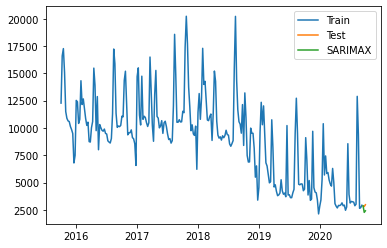

Current product:  9897


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.84834D+00    |proj g|=  3.24568D-01

At iterate    5    f=  8.66038D+00    |proj g|=  2.13795D-02

At iterate   10    f=  8.65604D+00    |proj g|=  1.02143D-03

At iterate   15    f=  8.65602D+00    |proj g|=  1.80044D-04

At iterate   20    f=  8.65593D+00    |proj g|=  8.54578D-03

At iterate   25    f=  8.64573D+00    |proj g|=  7.78602D-02

At iterate   30    f=  8.62711D+00    |proj g|=  1.97702D-03

At iterate   35    f=  8.62579D+00    |proj g|=  1.87105D-03

At iterate   40    f=  8.62535D+00    |proj g|=  1.70954D-03

At iterate   45    f=  8.62522D+00    |proj g|=  7.32752D-04

At iterate   50    f=  8.62519D+00    |proj g|=  2.30284D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.76550D+00    |proj g|=  7.90093D-03

At iterate   10    f=  8.76521D+00    |proj g|=  8.94978D-05

At iterate   15    f=  8.76494D+00    |proj g|=  1.66691D-03

At iterate   20    f=  8.75589D+00    |proj g|=  4.07612D-02

At iterate   25    f=  8.75197D+00    |proj g|=  1.06663D-04

At iterate   30    f=  8.75195D+00    |proj g|=  1.52907D-03

At iterate   35    f=  8.75176D+00    |proj g|=  2.12124D-03

At iterate   40    f=  8.75172D+00    |proj g|=  8.62821D-05

At iterate   45    f=  8.75169D+00    |proj g|=  4.36390D-04

At iterate   50    f=  8.74999D+00    |proj g|=  9.22977D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   3.998D-05   8.778D+00
  F =   8.7776691605730104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  589.3230216775081
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.78658D+00    |proj g|=  1.12611D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip 

 This problem is unconstrained.


rmse:  344.87015677275645


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69917D+00    |proj g|=  1.14257D-01

At iterate    5    f=  8.67704D+00    |proj g|=  1.43790D-02

At iterate   10    f=  8.67632D+00    |proj g|=  2.11793D-04

At iterate   15    f=  8.67630D+00    |proj g|=  6.61172D-04

At iterate   20    f=  8.67164D+00    |proj g|=  3.75938D-03

At iterate   25    f=  8.66084D+00    |proj g|=  2.16865D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71612D+00    |proj g|=  1.11695D-01

At iterate    5    f=  8.69528D+00    |proj g|=  9.50917D-03

At iterate   10    f=  8.69472D+00    |proj g|=  1.55070D-04

At iterate   15    f=  8.69469D+00    |proj g|=  3.62618D-03

At iterate   20    f=  8.69122D+00    |proj g|=  2.23054D-02

At iterate   25    f=  8.68285D+00    |proj g|=  1.29937D-03

At iterate   30    f=  8.68265D+00    |proj g|=  2.09070D-02

At iterate   35    f=  8.68060D+00    |proj g|=  3.04132D-02

At iterate   40    f=  8.67710D+00    |proj g|=  2.02075D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.70453D+00    |proj g|=  1.22521D-01

At iterate    5    f=  8.65303D+00    |proj g|=  4.77621D-03

At iterate   10    f=  8.65278D+00    |proj g|=  2.88081D-04

At iterate   15    f=  8.65273D+00    |proj g|=  1.36770D-03

At iterate   20    f=  8.65261D+00    |proj g|=  1.87555D-04

At iterate   25    f=  8.65257D+00    |proj g|=  8.14489D-03

At iterate   30    f=  8.64937D+00    |proj g|=  3.99349D-02

At iterate   35    f=  8.61808D+00    |proj g|=  2.16730D-02

At iterate   40    f=  8.61293D+00    |proj g|=  2.28221D-03

At iterate   45    f=  8.61188D+00    |proj g|=  2.59330D-03

At iterate   50    f=  8.61168D+00    |proj g|=  7.32477D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.68062D+00    |proj g|=  5.67543D-03

At iterate   10    f=  8.67845D+00    |proj g|=  1.53332D-03

At iterate   15    f=  8.67837D+00    |proj g|=  2.11486D-04

At iterate   20    f=  8.67834D+00    |proj g|=  1.69922D-03

At iterate   25    f=  8.67587D+00    |proj g|=  2.22305D-02

At iterate   30    f=  8.64100D+00    |proj g|=  3.59249D-02

At iterate   35    f=  8.62581D+00    |proj g|=  1.28325D-02

At iterate   40    f=  8.62269D+00    |proj g|=  6.02721D-03

At iterate   45    f=  8.62208D+00    |proj g|=  1.18898D-04

At iterate   50    f=  8.62196D+00    |proj g|=  4.17376D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.68060D+00    |proj g|=  6.28057D-03

At iterate   10    f=  8.67850D+00    |proj g|=  7.15271D-03

At iterate   15    f=  8.67833D+00    |proj g|=  7.53514D-04

At iterate   20    f=  8.67832D+00    |proj g|=  7.28876D-04

At iterate   25    f=  8.67816D+00    |proj g|=  4.22993D-03

At iterate   30    f=  8.65713D+00    |proj g|=  1.08001D-01

At iterate   35    f=  8.62871D+00    |proj g|=  1.23563D-02

At iterate   40    f=  8.62237D+00    |proj g|=  2.51223D-03

At iterate   45    f=  8.62133D+00    |proj g|=  1.26999D-03

At iterate   50    f=  8.62117D+00    |proj g|=  2.74291D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.80289D+00    |proj g|=  1.24778D-01

At iterate    5    f=  8.75347D+00    |proj g|=  3.77237D-03

At iterate   10    f=  8.75273D+00    |proj g|=  1.97619D-03

At iterate   15    f=  8.75271D+00    |proj g|=  7.28000D-04

At iterate   20    f=  8.75243D+00    |proj g|=  9.71848D-03

At iterate   25    f=  8.73955D+00    |proj g|=  7.52407D-02

At iterate   30    f=  8.72572D+00    |proj g|=  2.00807D-03

At iterate   35    f=  8.72425D+00    |proj g|=  9.12516D-04

At iterate   40    f=  8.72406D+00    |proj g|=  1.08548D-03

At iterate   45    f=  8.72402D+00    |proj g|=  4.20141D-04

At iterate   50    f=  8.72402D+00    |proj g|=  1.78656D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.69605D+00    |proj g|=  6.38511D-02

At iterate   10    f=  8.68668D+00    |proj g|=  1.76375D-03

At iterate   15    f=  8.68654D+00    |proj g|=  1.68199D-04

At iterate   20    f=  8.68651D+00    |proj g|=  2.47995D-03

At iterate   25    f=  8.68272D+00    |proj g|=  4.72748D-02

At iterate   30    f=  8.66429D+00    |proj g|=  6.71362D-03

At iterate   35    f=  8.66346D+00    |proj g|=  2.65625D-03

At iterate   40    f=  8.66280D+00    |proj g|=  2.27837D-02

At iterate   45    f=  8.66080D+00    |proj g|=  1.12322D-02

At iterate   50    f=  8.65973D+00    |proj g|=  1.22605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.66553D+00    |proj g|=  7.30772D-02

At iterate   10    f=  8.65615D+00    |proj g|=  1.80706D-02

At iterate   15    f=  8.65446D+00    |proj g|=  2.60583D-03

At iterate   20    f=  8.65439D+00    |proj g|=  1.75603D-04

At iterate   25    f=  8.65426D+00    |proj g|=  6.84553D-03

At iterate   30    f=  8.64322D+00    |proj g|=  8.35767D-02

At iterate   35    f=  8.63008D+00    |proj g|=  5.19560D-03

At iterate   40    f=  8.62647D+00    |proj g|=  4.96366D-03

At iterate   45    f=  8.62529D+00    |proj g|=  9.85426D-03

At iterate   50    f=  8.62510D+00    |proj g|=  2.45695D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.67468D+00    |proj g|=  5.64304D-02

At iterate   10    f=  8.66869D+00    |proj g|=  9.55461D-03

At iterate   15    f=  8.66801D+00    |proj g|=  6.00904D-04

At iterate   20    f=  8.66801D+00    |proj g|=  1.13931D-03

At iterate   25    f=  8.66760D+00    |proj g|=  1.42688D-02

At iterate   30    f=  8.65850D+00    |proj g|=  5.49783D-02

At iterate   35    f=  8.65428D+00    |proj g|=  5.20697D-04

At iterate   40    f=  8.65383D+00    |proj g|=  1.08948D-02

At iterate   45    f=  8.65326D+00    |proj g|=  2.16148D-03

At iterate   50    f=  8.65320D+00    |proj g|=  7.80243D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.65317D+00    |proj g|=  8.42016D-03

At iterate   10    f=  8.65276D+00    |proj g|=  7.84619D-04

At iterate   15    f=  8.65274D+00    |proj g|=  1.85886D-03

At iterate   20    f=  8.65258D+00    |proj g|=  1.30828D-03

At iterate   25    f=  8.65257D+00    |proj g|=  8.07007D-04

At iterate   30    f=  8.65255D+00    |proj g|=  2.51970D-03

At iterate   35    f=  8.65227D+00    |proj g|=  3.98966D-03

At iterate   40    f=  8.64302D+00    |proj g|=  4.38260D-02

At iterate   45    f=  8.61585D+00    |proj g|=  6.41251D-03

At iterate   50    f=  8.61352D+00    |proj g|=  3.07375D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.66775D+00    |proj g|=  2.87794D-03

At iterate   10    f=  8.66710D+00    |proj g|=  2.16803D-03

At iterate   15    f=  8.66642D+00    |proj g|=  2.60831D-03

At iterate   20    f=  8.66641D+00    |proj g|=  9.93154D-05

At iterate   25    f=  8.66640D+00    |proj g|=  1.97186D-03

At iterate   30    f=  8.66600D+00    |proj g|=  2.21865D-02

At iterate   35    f=  8.66160D+00    |proj g|=  2.79870D-02

At iterate   40    f=  8.66081D+00    |proj g|=  2.65139D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     44      1     0     0   2.651D-06   8.661D+00
  F =   8.66080738267

 This problem is unconstrained.



At iterate    5    f=  8.66753D+00    |proj g|=  3.81123D-03

At iterate   10    f=  8.66702D+00    |proj g|=  1.79871D-04

At iterate   15    f=  8.66696D+00    |proj g|=  1.32683D-03

At iterate   20    f=  8.66189D+00    |proj g|=  3.22871D-02

At iterate   25    f=  8.63400D+00    |proj g|=  3.12958D-03

At iterate   30    f=  8.63386D+00    |proj g|=  5.50341D-04

At iterate   35    f=  8.63375D+00    |proj g|=  3.52195D-03

At iterate   40    f=  8.63328D+00    |proj g|=  2.11759D-04

At iterate   45    f=  8.63317D+00    |proj g|=  2.02835D-05

At iterate   50    f=  8.63315D+00    |proj g|=  8.82446D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  9897
Best Configs:  [(1, 1, 0), (0, 1, 0, 52)]
Mean Absolute Error: 298.532
Mean Squared Error: 7419.758
Root Mean Squared Error: 344.87
Mean absolute percentage error: 3.993
Scaled Mean absolute percentage error: 4.102
Mean forecast error: 7120.763
Normalised mean squared error: 1.488
Theil_u_statistic: 0.0
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


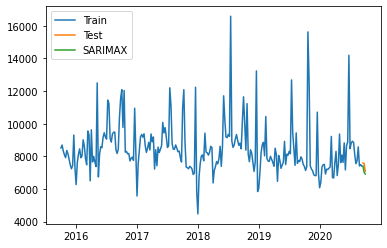

Current product:  9860
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22970D+00    |proj g|=  1.23276D-01


 This problem is unconstrained.



At iterate    5    f=  9.20173D+00    |proj g|=  2.84871D-03

At iterate   10    f=  9.20153D+00    |proj g|=  1.18674D-04

At iterate   15    f=  9.20153D+00    |proj g|=  1.08457D-03

At iterate   20    f=  9.20091D+00    |proj g|=  1.38150D-02

At iterate   25    f=  9.17602D+00    |proj g|=  5.78966D-02

At iterate   30    f=  9.16627D+00    |proj g|=  2.03757D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     35      1     0     0   1.447D-05   9.166D+00
  F =   9.1662649735120336     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  443.6746370171073


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30004D+00    |proj g|=  1.34047D-01

At iterate    5    f=  9.27660D+00    |proj g|=  8.86581D-03

At iterate   10    f=  9.27640D+00    |proj g|=  8.80132D-05

At iterate   15    f=  9.27637D+00    |proj g|=  1.87935D-03

At iterate   20    f=  9.27449D+00    |proj g|=  7.63140D-03

At iterate   25    f=  9.25685D+00    |proj g|=  2.01924D-03

At iterate   30    f=  9.25592D+00    |proj g|=  6.81423D-03

At iterate   35    f=  9.25498D+00    |proj g|=  1.38362D-03

At iterate   40    f=  9.25486D+00    |proj g|=  7.01276D-04

At iterate   45    f=  9.25483D+00    |proj g|=  7.03002D-04

At iterate   50    f=  9.25415D+00    |proj g|=  6.80950D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29079D+00    |proj g|=  5.75415D-02

At iterate    5    f=  9.28723D+00    |proj g|=  7.94884D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   7.949D-05   9.287D+00
  F =   9.2872341849059072     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  616.1164237778227
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =       

 This problem is unconstrained.


rmse:  1362.9094180511238
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22142D+00    |proj g|=  7.93690D-02


 This problem is unconstrained.



At iterate    5    f=  9.21231D+00    |proj g|=  3.61438D-03

At iterate   10    f=  9.21227D+00    |proj g|=  2.17800D-04

At iterate   15    f=  9.21223D+00    |proj g|=  3.98935D-03

At iterate   20    f=  9.20818D+00    |proj g|=  3.35488D-02

At iterate   25    f=  9.19638D+00    |proj g|=  2.19442D-02

At iterate   30    f=  9.18491D+00    |proj g|=  1.06049D-02

At iterate   35    f=  9.18436D+00    |proj g|=  1.01320D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     41      1     0     0   1.013D-05   9.184D+00
  F =   9.1843614410315180     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  9.21572D+00    |proj g|=  1.23795D-03

At iterate   10    f=  9.21569D+00    |proj g|=  1.15581D-04

At iterate   15    f=  9.21565D+00    |proj g|=  3.26036D-03

At iterate   20    f=  9.21243D+00    |proj g|=  3.89226D-02

At iterate   25    f=  9.18266D+00    |proj g|=  6.85858D-03

At iterate   30    f=  9.18180D+00    |proj g|=  3.86609D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     34      1     0     0   9.047D-06   9.182D+00
  F =   9.1818045179522709     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  308.15448188547725


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27261D+00    |proj g|=  2.68473D-01

At iterate    5    f=  9.19792D+00    |proj g|=  9.84389D-03

At iterate   10    f=  9.19627D+00    |proj g|=  4.49705D-03

At iterate   15    f=  9.19616D+00    |proj g|=  5.40837D-04

At iterate   20    f=  9.19615D+00    |proj g|=  1.11268D-04

At iterate   25    f=  9.19612D+00    |proj g|=  2.03621D-03

At iterate   30    f=  9.19237D+00    |proj g|=  1.20489D-02

At iterate   35    f=  9.17420D+00    |proj g|=  2.50950D-02

At iterate   40    f=  9.16430D+00    |proj g|=  2.04822D-03

At iterate   45    f=  9.16413D+00    |proj g|=  5.82699D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  9.21732D+00    |proj g|=  9.83940D-03

At iterate   10    f=  9.21536D+00    |proj g|=  4.27181D-03

At iterate   15    f=  9.21533D+00    |proj g|=  2.60478D-04

At iterate   20    f=  9.21532D+00    |proj g|=  7.97568D-04

At iterate   25    f=  9.21477D+00    |proj g|=  1.06119D-02

At iterate   30    f=  9.19638D+00    |proj g|=  3.98823D-02

At iterate   35    f=  9.18141D+00    |proj g|=  4.79122D-02

At iterate   40    f=  9.17806D+00    |proj g|=  6.72071D-03

At iterate   45    f=  9.17586D+00    |proj g|=  2.39338D-03

At iterate   50    f=  9.17574D+00    |proj g|=  1.18602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29467D+00    |proj g|=  2.61856D-01

At iterate    5    f=  9.21754D+00    |proj g|=  9.37360D-03

At iterate   10    f=  9.21387D+00    |proj g|=  1.66532D-03

At iterate   15    f=  9.21375D+00    |proj g|=  2.74596D-04

At iterate   20    f=  9.21375D+00    |proj g|=  4.42280D-04

At iterate   25    f=  9.21374D+00    |proj g|=  1.15852D-03

At iterate   30    f=  9.21308D+00    |proj g|=  1.04258D-02

At iterate   35    f=  9.19292D+00    |proj g|=  3.66128D-02

At iterate   40    f=  9.17609D+00    |proj g|=  6.04209D-03

At iterate   45    f=  9.17490D+00    |proj g|=  1.03911D-03

At iterate   50    f=  9.17488D+00    |proj g|=  1.23991D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35729D+00    |proj g|=  2.90512D-01

At iterate    5    f=  9.27854D+00    |proj g|=  6.43071D-03

At iterate   10    f=  9.27753D+00    |proj g|=  9.62554D-04

At iterate   15    f=  9.27753D+00    |proj g|=  4.96423D-04

At iterate   20    f=  9.27704D+00    |proj g|=  6.11993D-03

At iterate   25    f=  9.25614D+00    |proj g|=  1.57771D-02

At iterate   30    f=  9.25373D+00    |proj g|=  2.72182D-02

At iterate   35    f=  9.25071D+00    |proj g|=  1.55517D-03

At iterate   40    f=  9.25047D+00    |proj g|=  2.75020D-03

At iterate   45    f=  9.25029D+00    |proj g|=  3.69269D-04

At iterate   50    f=  9.25025D+00    |proj g|=  3.07122D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22287D+00    |proj g|=  9.11978D-02

At iterate    5    f=  9.21229D+00    |proj g|=  1.63042D-02

At iterate   10    f=  9.21176D+00    |proj g|=  1.13680D-04

At iterate   15    f=  9.21176D+00    |proj g|=  6.15916D-04

At iterate   20    f=  9.21155D+00    |proj g|=  2.65052D-03

At iterate   25    f=  9.19264D+00    |proj g|=  3.32850D-02

At iterate   30    f=  9.17816D+00    |proj g|=  5.16551D-03

At iterate   35    f=  9.17806D+00    |proj g|=  6.51974D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23151D+00    |proj g|=  1.23302D-01

At iterate    5    f=  9.20074D+00    |proj g|=  2.61314D-02

At iterate   10    f=  9.19943D+00    |proj g|=  1.11999D-03

At iterate   15    f=  9.19942D+00    |proj g|=  6.64447D-04

At iterate   20    f=  9.19922D+00    |proj g|=  9.16433D-03

At iterate   25    f=  9.18082D+00    |proj g|=  8.10604D-02

At iterate   30    f=  9.16445D+00    |proj g|=  4.81018D-03

At iterate   35    f=  9.16440D+00    |proj g|=  2.09652D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22346D+00    |proj g|=  5.86110D-02

At iterate    5    f=  9.21178D+00    |proj g|=  2.41743D-02

At iterate   10    f=  9.21104D+00    |proj g|=  1.06937D-04

At iterate   15    f=  9.21103D+00    |proj g|=  1.21822D-03

At iterate   20    f=  9.20960D+00    |proj g|=  1.08154D-02

At iterate   25    f=  9.19599D+00    |proj g|=  2.08909D-02

At iterate   30    f=  9.18387D+00    |proj g|=  4.75677D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27261D+00    |proj g|=  2.68473D-01

At iterate    5    f=  9.19831D+00    |proj g|=  8.18430D-03

At iterate   10    f=  9.19443D+00    |proj g|=  4.29724D-03

At iterate   15    f=  9.19422D+00    |proj g|=  1.02358D-03

At iterate   20    f=  9.19421D+00    |proj g|=  4.05822D-04

At iterate   25    f=  9.19421D+00    |proj g|=  4.11444D-04

At iterate   30    f=  9.19415D+00    |proj g|=  4.40990D-03

At iterate   35    f=  9.19277D+00    |proj g|=  9.52270D-03

At iterate   40    f=  9.17790D+00    |proj g|=  7.03195D-02

At iterate   45    f=  9.16331D+00    |proj g|=  2.61147D-03

At iterate   50    f=  9.16321D+00    |proj g|=  2.40012D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.20054D+00    |proj g|=  5.19441D-04

At iterate   10    f=  9.20054D+00    |proj g|=  7.47746D-04

At iterate   15    f=  9.20054D+00    |proj g|=  9.13420D-04

At iterate   20    f=  9.20040D+00    |proj g|=  9.85423D-03

At iterate   25    f=  9.18975D+00    |proj g|=  4.73280D-02

At iterate   30    f=  9.18269D+00    |proj g|=  7.32157D-03

At iterate   35    f=  9.17968D+00    |proj g|=  2.84129D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     44      1     0     0   1.706D-06   9.180D+00
  F =   9.1796831771549829     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.21595D+00    |proj g|=  4.20016D-03

At iterate   10    f=  9.21588D+00    |proj g|=  1.12136D-04

At iterate   15    f=  9.21584D+00    |proj g|=  2.27230D-03

At iterate   20    f=  9.20742D+00    |proj g|=  3.17375D-02

At iterate   25    f=  9.18431D+00    |proj g|=  1.76742D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     31      1     0     0   1.881D-06   9.184D+00
  F =   9.1843047178230108     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  206.5163130104113


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22346D+00    |proj g|=  5.86110D-02

At iterate    5    f=  9.21178D+00    |proj g|=  2.41743D-02

At iterate   10    f=  9.21104D+00    |proj g|=  1.06937D-04

At iterate   15    f=  9.21103D+00    |proj g|=  1.21822D-03

At iterate   20    f=  9.20960D+00    |proj g|=  1.08154D-02

At iterate   25    f=  9.19599D+00    |proj g|=  2.08909D-02

At iterate   30    f=  9.18387D+00    |proj g|=  4.75677D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

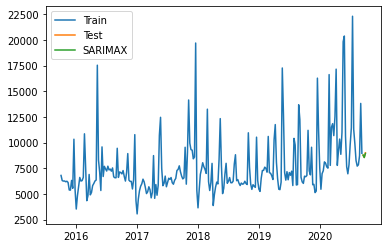

Current product:  14759


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15149D+00    |proj g|=  1.31815D-01

At iterate    5    f=  8.10971D+00    |proj g|=  2.21823D-02

At iterate   10    f=  8.10866D+00    |proj g|=  2.24192D-04

At iterate   15    f=  8.10864D+00    |proj g|=  3.41807D-03

At iterate   20    f=  8.10561D+00    |proj g|=  3.55518D-02

At iterate   25    f=  8.09845D+00    |proj g|=  4.49218D-04

At iterate   30    f=  8.09844D+00    |proj g|=  4.31004D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  8.15710D+00    |proj g|=  1.60106D-04

At iterate   10    f=  8.15710D+00    |proj g|=  8.54209D-04

At iterate   15    f=  8.15694D+00    |proj g|=  1.10202D-02

At iterate   20    f=  8.15422D+00    |proj g|=  6.23156D-03

At iterate   25    f=  8.15415D+00    |proj g|=  2.15175D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     27      1     0     0   2.152D-05   8.154D+00
  F =   8.1541466282214721     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  863.0367998571942
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate    5    f=  8.15746D+00    |proj g|=  1.13180D-04

At iterate   10    f=  8.15745D+00    |proj g|=  3.12137D-03

At iterate   15    f=  8.15616D+00    |proj g|=  2.41655D-02

At iterate   20    f=  8.15479D+00    |proj g|=  2.77119D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     23      1     0     0   2.299D-06   8.155D+00
  F =   8.1547935872186166     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  886.2577700489537
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exact

 This problem is unconstrained.


rmse:  708.6581791917733


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14147D+00    |proj g|=  5.72420D-02

At iterate    5    f=  8.11776D+00    |proj g|=  1.60117D-02

At iterate   10    f=  8.11578D+00    |proj g|=  2.55275D-04

At iterate   15    f=  8.11559D+00    |proj g|=  1.10107D-02

At iterate   20    f=  8.11141D+00    |proj g|=  8.63538D-03

At iterate   25    f=  8.10751D+00    |proj g|=  1.66442D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.26391D+00    |proj g|=  1.61251D-01

At iterate    5    f=  8.22818D+00    |proj g|=  2.61503D-02

At iterate   10    f=  8.22616D+00    |proj g|=  1.52648D-04

At iterate   15    f=  8.22615D+00    |proj g|=  1.22414D-03

At iterate   20    f=  8.22538D+00    |proj g|=  1.46688D-02

At iterate   25    f=  8.22011D+00    |proj g|=  2.09748D-03

At iterate   30    f=  8.21997D+00    |proj g|=  4.08492D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  8.21700D+00    |proj g|=  9.33852D-03

At iterate   10    f=  8.21401D+00    |proj g|=  1.42879D-03

At iterate   15    f=  8.21396D+00    |proj g|=  1.72902D-04

At iterate   20    f=  8.21395D+00    |proj g|=  1.88527D-03

At iterate   25    f=  8.21207D+00    |proj g|=  2.10751D-02

At iterate   30    f=  8.19314D+00    |proj g|=  8.07418D-03

At iterate   35    f=  8.18729D+00    |proj g|=  2.74262D-03

At iterate   40    f=  8.18565D+00    |proj g|=  2.50824D-03

At iterate   45    f=  8.18529D+00    |proj g|=  1.13161D-03

At iterate   50    f=  8.18521D+00    |proj g|=  6.08430D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.22999D+00    |proj g|=  1.79119D-02

At iterate   10    f=  8.22852D+00    |proj g|=  3.40384D-03

At iterate   15    f=  8.22838D+00    |proj g|=  1.75933D-04

At iterate   20    f=  8.22837D+00    |proj g|=  1.65153D-03

At iterate   25    f=  8.22497D+00    |proj g|=  2.96214D-02

At iterate   30    f=  8.20428D+00    |proj g|=  1.56903D-02

At iterate   35    f=  8.19926D+00    |proj g|=  6.40050D-03

At iterate   40    f=  8.19814D+00    |proj g|=  1.39927D-03

At iterate   45    f=  8.19797D+00    |proj g|=  1.26180D-04

At iterate   50    f=  8.19793D+00    |proj g|=  1.44334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.22896D+00    |proj g|=  7.01161D-03

At iterate   10    f=  8.22649D+00    |proj g|=  6.22975D-04

At iterate   15    f=  8.22647D+00    |proj g|=  5.14136D-04

At iterate   20    f=  8.22647D+00    |proj g|=  1.16169D-03

At iterate   25    f=  8.22606D+00    |proj g|=  1.52342D-02

At iterate   30    f=  8.21474D+00    |proj g|=  6.97543D-02

At iterate   35    f=  8.19664D+00    |proj g|=  5.04610D-03

At iterate   40    f=  8.19368D+00    |proj g|=  5.07469D-03

At iterate   45    f=  8.19243D+00    |proj g|=  7.59613D-04

At iterate   50    f=  8.19214D+00    |proj g|=  1.53160D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.23890D+00    |proj g|=  3.05991D-03

At iterate   10    f=  8.23887D+00    |proj g|=  1.58842D-04

At iterate   15    f=  8.23883D+00    |proj g|=  4.81817D-03

At iterate   20    f=  8.23256D+00    |proj g|=  7.23952D-02

At iterate   25    f=  8.21552D+00    |proj g|=  1.93995D-03

At iterate   30    f=  8.21366D+00    |proj g|=  3.45268D-03

At iterate   35    f=  8.21297D+00    |proj g|=  1.38047D-03

At iterate   40    f=  8.21285D+00    |proj g|=  2.47444D-04

At iterate   45    f=  8.21283D+00    |proj g|=  2.37799D-05

At iterate   50    f=  8.21283D+00    |proj g|=  1.04812D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28802D+00    |proj g|=  6.22290D-02

At iterate    5    f=  8.23694D+00    |proj g|=  5.81634D-02

At iterate   10    f=  8.23138D+00    |proj g|=  5.36819D-03

At iterate   15    f=  8.23135D+00    |proj g|=  1.75937D-03

At iterate   20    f=  8.22888D+00    |proj g|=  3.04912D-02

At iterate   25    f=  8.22586D+00    |proj g|=  1.12926D-03

At iterate   30    f=  8.22585D+00    |proj g|=  3.77870D-04

At iterate   35    f=  8.22566D+00    |proj g|=  7.65448D-03

At iterate   40    f=  8.22182D+00    |proj g|=  1.90891D-02

At iterate   45    f=  8.22106D+00    |proj g|=  1.07616D-03

At iterate   50    f=  8.22077D+00    |proj g|=  1.75237D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.11754D+00    |proj g|=  1.01134D-02

At iterate   10    f=  8.11671D+00    |proj g|=  1.38011D-02

At iterate   15    f=  8.10845D+00    |proj g|=  6.51724D-03

At iterate   20    f=  8.10828D+00    |proj g|=  2.22531D-04

At iterate   25    f=  8.10825D+00    |proj g|=  3.88527D-03

At iterate   30    f=  8.10512D+00    |proj g|=  3.62872D-02

At iterate   35    f=  8.09824D+00    |proj g|=  1.77179D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     48      1     0     0   9.325D-06   8.098D+00
  F =   8.0982344815278378     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.14888D+00    |proj g|=  5.08491D-02

At iterate    5    f=  8.11920D+00    |proj g|=  3.76903D-03

At iterate   10    f=  8.11851D+00    |proj g|=  1.68039D-02

At iterate   15    f=  8.11072D+00    |proj g|=  9.71527D-04

At iterate   20    f=  8.11071D+00    |proj g|=  1.10337D-03

At iterate   25    f=  8.11012D+00    |proj g|=  1.88124D-02

At iterate   30    f=  8.10214D+00    |proj g|=  2.04379D-02

At iterate   35    f=  8.10149D+00    |proj g|=  1.73218D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24068D+00    |proj g|=  7.95143D-02

At iterate    5    f=  8.21427D+00    |proj g|=  2.44732D-03

At iterate   10    f=  8.21287D+00    |proj g|=  2.71450D-03

At iterate   15    f=  8.21284D+00    |proj g|=  1.10643D-03

At iterate   20    f=  8.21283D+00    |proj g|=  3.10795D-04

At iterate   25    f=  8.21269D+00    |proj g|=  4.42359D-03

At iterate   30    f=  8.20288D+00    |proj g|=  4.42379D-02

At iterate   35    f=  8.18766D+00    |proj g|=  9.18361D-03

At iterate   40    f=  8.18301D+00    |proj g|=  3.10239D-03

At iterate   45    f=  8.18191D+00    |proj g|=  4.82551D-03

At iterate   50    f=  8.18169D+00    |proj g|=  7.76058D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.11499D+00    |proj g|=  6.48363D-03

At iterate   10    f=  8.11244D+00    |proj g|=  2.32640D-04

At iterate   15    f=  8.11243D+00    |proj g|=  1.28751D-03

At iterate   20    f=  8.11121D+00    |proj g|=  1.92236D-02

At iterate   25    f=  8.10720D+00    |proj g|=  6.72871D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     32      1     0     0   1.496D-05   8.107D+00
  F =   8.1072030714165937     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  914.1919275240797
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.16746D+00    |proj g|=  1.35067D-01

At iterate    5    f=  8.14986D+00    |proj g|=  8.51896D-05

At iterate   10    f=  8.14986D+00    |proj g|=  6.61108D-04

At iterate   15    f=  8.14968D+00    |proj g|=  7.24354D-03

At iterate   20    f=  8.14894D+00    |proj g|=  1.17688D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   9.441D-07   8.149D+00
  F =   8.1489353942522342     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  787.0172471378272


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25233D+00    |proj g|=  6.52294D-02

At iterate    5    f=  8.23890D+00    |proj g|=  3.05991D-03

At iterate   10    f=  8.23887D+00    |proj g|=  1.58842D-04

At iterate   15    f=  8.23883D+00    |proj g|=  4.81817D-03

At iterate   20    f=  8.23256D+00    |proj g|=  7.23952D-02

At iterate   25    f=  8.21552D+00    |proj g|=  1.93995D-03

At iterate   30    f=  8.21366D+00    |proj g|=  3.45268D-03

At iterate   35    f=  8.21297D+00    |proj g|=  1.38047D-03

At iterate   40    f=  8.21285D+00    |proj g|=  2.47444D-04

At iterate   45    f=  8.21283D+00    |proj g|=  2.37799D-05

At iterate   50    f=  8.21283D+00    |proj g|=  1.04812D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

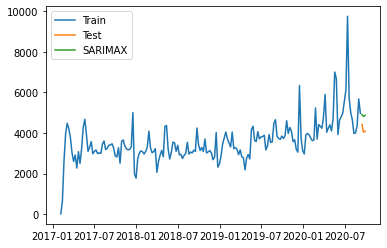

Current product:  9901
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85003D+00    |proj g|=  1.10443D+00


 This problem is unconstrained.



At iterate    5    f=  8.14293D+00    |proj g|=  7.84919D-03

At iterate   10    f=  8.14016D+00    |proj g|=  3.61911D-03

At iterate   15    f=  8.13975D+00    |proj g|=  4.49356D-04

At iterate   20    f=  8.12055D+00    |proj g|=  1.17674D-01

At iterate   25    f=  8.09897D+00    |proj g|=  2.88663D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     35      1     0     0   1.839D-05   8.099D+00
  F =   8.0989117153293400     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1641.3699290890838
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  8.23713D+00    |proj g|=  1.88759D-03

At iterate   10    f=  8.23711D+00    |proj g|=  1.09443D-03

At iterate   15    f=  8.23638D+00    |proj g|=  1.57615D-02

At iterate   20    f=  8.21229D+00    |proj g|=  1.18238D-02

At iterate   25    f=  8.21203D+00    |proj g|=  8.07584D-03

At iterate   30    f=  8.21117D+00    |proj g|=  1.76538D-03

At iterate   35    f=  8.21101D+00    |proj g|=  4.76144D-03

At iterate   40    f=  8.21096D+00    |proj g|=  3.18427D-04

At iterate   45    f=  8.20939D+00    |proj g|=  6.90381D-03

At iterate   50    f=  8.19475D+00    |proj g|=  5.16046D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.25246D+00    |proj g|=  1.89867D-04

At iterate   10    f=  8.25238D+00    |proj g|=  4.67295D-03

At iterate   15    f=  8.24723D+00    |proj g|=  2.95461D-02

At iterate   20    f=  8.24136D+00    |proj g|=  2.24543D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     25      1     0     0   1.642D-05   8.241D+00
  F =   8.2413579843552007     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1367.3831957962798
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exac

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   6.448D-05   8.281D+00
  F =   8.2814101954943329     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  226.7945516572715


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.82799D+00    |proj g|=  1.09176D+00

At iterate    5    f=  8.16115D+00    |proj g|=  1.09685D-02

At iterate   10    f=  8.15943D+00    |proj g|=  1.76001D-02

At iterate   15    f=  8.15875D+00    |proj g|=  3.45844D-04

At iterate   20    f=  8.15860D+00    |proj g|=  5.87562D-03

At iterate   25    f=  8.13592D+00    |proj g|=  1.49933D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     36      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74888D+00    |proj g|=  8.69353D-01

At iterate    5    f=  8.22752D+00    |proj g|=  5.28154D-02

At iterate   10    f=  8.21870D+00    |proj g|=  3.24888D-03

At iterate   15    f=  8.21755D+00    |proj g|=  5.33141D-03

At iterate   20    f=  8.21739D+00    |proj g|=  3.60447D-04

At iterate   25    f=  8.21696D+00    |proj g|=  1.43521D-02

At iterate   30    f=  8.19186D+00    |proj g|=  7.96811D-02

At iterate   35    f=  8.18729D+00    |proj g|=  1.02294D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25978D+00    |proj g|=  1.75379D-01

At iterate    5    f=  8.19564D+00    |proj g|=  6.73636D-03

At iterate   10    f=  8.19466D+00    |proj g|=  4.02120D-03

At iterate   15    f=  8.19390D+00    |proj g|=  7.43873D-04

At iterate   20    f=  8.19388D+00    |proj g|=  1.48309D-03

At iterate   25    f=  8.19221D+00    |proj g|=  1.44239D-02

At iterate   30    f=  8.15836D+00    |proj g|=  1.77026D-02

At iterate   35    f=  8.15725D+00    |proj g|=  5.76865D-03

At iterate   40    f=  8.15423D+00    |proj g|=  3.60144D-03

At iterate   45    f=  8.15340D+00    |proj g|=  1.45821D-03

At iterate   50    f=  8.15323D+00    |proj g|=  1.27889D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92562D+00    |proj g|=  1.02317D+00

At iterate    5    f=  8.21568D+00    |proj g|=  1.65284D-02

At iterate   10    f=  8.21137D+00    |proj g|=  2.94457D-03

At iterate   15    f=  8.21062D+00    |proj g|=  3.44739D-04

At iterate   20    f=  8.21055D+00    |proj g|=  3.19827D-03

At iterate   25    f=  8.20166D+00    |proj g|=  6.47805D-02

At iterate   30    f=  8.16501D+00    |proj g|=  6.79422D-03

At iterate   35    f=  8.16178D+00    |proj g|=  8.05418D-04

At iterate   40    f=  8.16104D+00    |proj g|=  1.85791D-03

At iterate   45    f=  8.16089D+00    |proj g|=  4.90426D-04

At iterate   50    f=  8.16087D+00    |proj g|=  4.59543D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92562D+00    |proj g|=  1.02317D+00

At iterate    5    f=  8.21911D+00    |proj g|=  5.03303D-02

At iterate   10    f=  8.20985D+00    |proj g|=  3.12787D-03

At iterate   15    f=  8.20885D+00    |proj g|=  1.66137D-03

At iterate   20    f=  8.20882D+00    |proj g|=  3.43538D-04

At iterate   25    f=  8.20838D+00    |proj g|=  1.31618D-02

At iterate   30    f=  8.20194D+00    |proj g|=  9.83364D-03

At iterate   35    f=  8.17998D+00    |proj g|=  7.39371D-02

At iterate   40    f=  8.15668D+00    |proj g|=  1.11186D-02

At iterate   45    f=  8.14799D+00    |proj g|=  1.44615D-02

At iterate   50    f=  8.14578D+00    |proj g|=  3.76134D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35494D+00    |proj g|=  2.17028D-01

At iterate    5    f=  8.28028D+00    |proj g|=  3.49416D-03

At iterate   10    f=  8.28020D+00    |proj g|=  1.02163D-03

At iterate   15    f=  8.27990D+00    |proj g|=  5.56351D-03

At iterate   20    f=  8.25513D+00    |proj g|=  2.47367D-02

At iterate   25    f=  8.24852D+00    |proj g|=  4.45933D-03

At iterate   30    f=  8.24577D+00    |proj g|=  3.19857D-03

At iterate   35    f=  8.24519D+00    |proj g|=  1.30763D-03

At iterate   40    f=  8.24502D+00    |proj g|=  8.97800D-04

At iterate   45    f=  8.24499D+00    |proj g|=  1.53517D-04

At iterate   50    f=  8.24490D+00    |proj g|=  2.46971D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.32489D+00    |proj g|=  1.58927D-01

At iterate    5    f=  8.29641D+00    |proj g|=  2.12167D-02

At iterate   10    f=  8.24011D+00    |proj g|=  9.64465D-02

At iterate   15    f=  8.20915D+00    |proj g|=  2.39832D-02

At iterate   20    f=  8.20610D+00    |proj g|=  9.70681D-03

At iterate   25    f=  8.20517D+00    |proj g|=  3.35209D-04

At iterate   30    f=  8.20503D+00    |proj g|=  6.56349D-03

At iterate   35    f=  8.17037D+00    |proj g|=  2.53485D-02

At iterate   40    f=  8.16496D+00    |proj g|=  4.09600D-03

At iterate   45    f=  8.16475D+00    |proj g|=  1.22971D-03

At iterate   50    f=  8.16398D+00    |proj g|=  1.00535D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.16925D+00    |proj g|=  7.12664D-02

At iterate   10    f=  8.14188D+00    |proj g|=  2.20035D-02

At iterate   15    f=  8.13533D+00    |proj g|=  6.93860D-04

At iterate   20    f=  8.13527D+00    |proj g|=  2.48243D-03

At iterate   25    f=  8.12973D+00    |proj g|=  5.09513D-02

At iterate   30    f=  8.09454D+00    |proj g|=  6.02068D-03

At iterate   35    f=  8.09443D+00    |proj g|=  8.54091D-04

At iterate   40    f=  8.09422D+00    |proj g|=  5.54133D-03

At iterate   45    f=  8.09411D+00    |proj g|=  1.83780D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     50   

 This problem is unconstrained.



At iterate    5    f=  8.18382D+00    |proj g|=  8.26343D-02

At iterate   10    f=  8.14821D+00    |proj g|=  2.84750D-03

At iterate   15    f=  8.14797D+00    |proj g|=  4.38716D-04

At iterate   20    f=  8.14742D+00    |proj g|=  5.53545D-03

At iterate   25    f=  8.12819D+00    |proj g|=  4.00357D-02

At iterate   30    f=  8.12592D+00    |proj g|=  2.78390D-04

At iterate   35    f=  8.12160D+00    |proj g|=  3.43621D-02

At iterate   40    f=  8.11913D+00    |proj g|=  2.52674D-03

At iterate   45    f=  8.11912D+00    |proj g|=  1.75680D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     62   

 This problem is unconstrained.



At iterate    5    f=  8.19251D+00    |proj g|=  8.07176D-03

At iterate   10    f=  8.19172D+00    |proj g|=  1.62391D-03

At iterate   15    f=  8.19143D+00    |proj g|=  4.07705D-03

At iterate   20    f=  8.19133D+00    |proj g|=  3.28584D-04

At iterate   25    f=  8.19100D+00    |proj g|=  6.24602D-03

At iterate   30    f=  8.16213D+00    |proj g|=  5.59995D-02

At iterate   35    f=  8.14493D+00    |proj g|=  7.10245D-03

At iterate   40    f=  8.13957D+00    |proj g|=  3.61633D-03

At iterate   45    f=  8.13824D+00    |proj g|=  2.07333D-03

At iterate   50    f=  8.13798D+00    |proj g|=  7.31163D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15565D+00    |proj g|=  7.58717D-02

At iterate    5    f=  8.14951D+00    |proj g|=  1.68128D-03

At iterate   10    f=  8.14907D+00    |proj g|=  5.28026D-03

At iterate   15    f=  8.14901D+00    |proj g|=  9.61635D-04

At iterate   20    f=  8.14863D+00    |proj g|=  1.80373D-02

At iterate   25    f=  8.13113D+00    |proj g|=  7.55294D-02

At iterate   30    f=  8.12669D+00    |proj g|=  5.35020D-04

At iterate   35    f=  8.12668D+00    |proj g|=  1.43070D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23172D+00    |proj g|=  1.07532D-01

At iterate    5    f=  8.18324D+00    |proj g|=  1.58636D-02

At iterate   10    f=  8.17652D+00    |proj g|=  3.70416D-04

At iterate   15    f=  8.17517D+00    |proj g|=  3.95495D-03

At iterate   20    f=  8.13172D+00    |proj g|=  5.53281D-03

At iterate   25    f=  8.13165D+00    |proj g|=  7.59947D-05

At iterate   30    f=  8.13162D+00    |proj g|=  4.58172D-03

At iterate   35    f=  8.12616D+00    |proj g|=  3.13279D-02

At iterate   40    f=  8.12518D+00    |proj g|=  2.52010D-04

At iterate   45    f=  8.12517D+00    |proj g|=  5.12059D-04

At iterate   50    f=  8.12419D+00    |proj g|=  1.73066D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  9901
Best Configs:  [(1, 1, 0), (0, 1, 0, 52)]
Mean Absolute Error: 193.953
Mean Squared Error: 3347.24
Root Mean Squared Error: 226.795
Mean absolute percentage error: 5.794
Scaled Mean absolute percentage error: 6.031
Mean forecast error: 3174.959
Normalised mean squared error: 21.316
Theil_u_statistic: 0.0
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


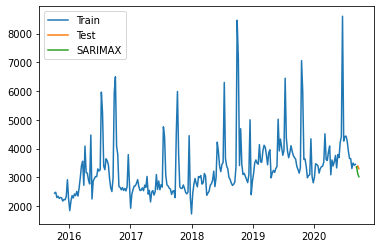

Current product:  10019


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31004D+00    |proj g|=  1.20693D-01

At iterate    5    f=  7.12859D+00    |proj g|=  7.80949D-02

At iterate   10    f=  7.10518D+00    |proj g|=  1.13449D-02

At iterate   15    f=  7.10398D+00    |proj g|=  5.69939D-04

At iterate   20    f=  7.10349D+00    |proj g|=  4.24474D-02

At iterate   25    f=  7.09724D+00    |proj g|=  1.30614D-02

At iterate   30    f=  7.09699D+00    |proj g|=  2.54776D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  7.13408D+00    |proj g|=  9.09593D-02

At iterate   10    f=  7.12786D+00    |proj g|=  5.25085D-04

At iterate   15    f=  7.12765D+00    |proj g|=  2.07065D-02

At iterate   20    f=  7.12302D+00    |proj g|=  6.52225D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   8.636D-05   7.121D+00
  F =   7.1212678201615285     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  136.7964032429481


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.12952D+00    |proj g|=  3.11278D-02

At iterate    5    f=  7.12891D+00    |proj g|=  5.21116D-04

At iterate   10    f=  7.12875D+00    |proj g|=  1.65164D-02

At iterate   15    f=  7.12381D+00    |proj g|=  6.14424D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     21      1     0     0   4.167D-06   7.123D+00
  F =   7.1225202118686930     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   4.186D-05   7.088D+00
  F =   7.0884028570551152     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  180.60854517649972
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.10973D+00    |proj g|=  2.43336D-02


 This problem is unconstrained.



At iterate    5    f=  7.10485D+00    |proj g|=  2.37152D-02

At iterate   10    f=  7.10461D+00    |proj g|=  8.64181D-04

At iterate   15    f=  7.10278D+00    |proj g|=  1.34847D-02

At iterate   20    f=  7.09755D+00    |proj g|=  2.79975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   1.069D-05   7.098D+00
  F =   7.0975392283839334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  80.06950200188983


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.32788D+00    |proj g|=  1.93013D-01

At iterate    5    f=  7.28406D+00    |proj g|=  1.12259D-02

At iterate   10    f=  7.28016D+00    |proj g|=  6.89803D-03

At iterate   15    f=  7.28010D+00    |proj g|=  3.30165D-03

At iterate   20    f=  7.27898D+00    |proj g|=  4.02365D-02

At iterate   25    f=  7.26926D+00    |proj g|=  1.07906D-02

At iterate   30    f=  7.26891D+00    |proj g|=  4.27180D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31440D+00    |proj g|=  8.96078D-02

At iterate    5    f=  7.28956D+00    |proj g|=  1.65124D-02

At iterate   10    f=  7.27839D+00    |proj g|=  2.32100D-02

At iterate   15    f=  7.27744D+00    |proj g|=  7.33585D-04

At iterate   20    f=  7.27718D+00    |proj g|=  7.11683D-03

At iterate   25    f=  7.26459D+00    |proj g|=  2.73967D-02

At iterate   30    f=  7.25947D+00    |proj g|=  1.55112D-03

At iterate   35    f=  7.25941D+00    |proj g|=  1.52302D-03

At iterate   40    f=  7.25926D+00    |proj g|=  8.70099D-04

At iterate   45    f=  7.25921D+00    |proj g|=  9.94785D-04

At iterate   50    f=  7.25918D+00    |proj g|=  1.06980D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.30006D+00    |proj g|=  9.52157D-02

At iterate    5    f=  7.27826D+00    |proj g|=  9.24560D-03

At iterate   10    f=  7.27684D+00    |proj g|=  8.12452D-04

At iterate   15    f=  7.27593D+00    |proj g|=  1.39128D-02

At iterate   20    f=  7.25613D+00    |proj g|=  1.39961D-02

At iterate   25    f=  7.25382D+00    |proj g|=  5.04260D-04

At iterate   30    f=  7.25376D+00    |proj g|=  3.28534D-03

At iterate   35    f=  7.25361D+00    |proj g|=  1.30227D-03

At iterate   40    f=  7.25357D+00    |proj g|=  4.33434D-04

At iterate   45    f=  7.25355D+00    |proj g|=  2.25519D-04

At iterate   50    f=  7.25355D+00    |proj g|=  2.54679D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.27832D+00    |proj g|=  1.07033D-02

At iterate   10    f=  7.27646D+00    |proj g|=  1.57746D-02

At iterate   15    f=  7.27623D+00    |proj g|=  8.18785D-04

At iterate   20    f=  7.27550D+00    |proj g|=  1.27865D-02

At iterate   25    f=  7.25864D+00    |proj g|=  1.73893D-02

At iterate   30    f=  7.25346D+00    |proj g|=  7.44410D-03

At iterate   35    f=  7.25298D+00    |proj g|=  9.33040D-03

At iterate   40    f=  7.25276D+00    |proj g|=  3.12758D-03

At iterate   45    f=  7.25267D+00    |proj g|=  2.32197D-03

At iterate   50    f=  7.25262D+00    |proj g|=  1.61475D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.28847D+00    |proj g|=  7.89518D-04

At iterate   10    f=  7.28823D+00    |proj g|=  8.97451D-03

At iterate   15    f=  7.27435D+00    |proj g|=  5.72117D-02

At iterate   20    f=  7.26424D+00    |proj g|=  2.54212D-03

At iterate   25    f=  7.26406D+00    |proj g|=  1.86099D-03

At iterate   30    f=  7.26393D+00    |proj g|=  1.50266D-03

At iterate   35    f=  7.26390D+00    |proj g|=  4.03409D-04

At iterate   40    f=  7.26389D+00    |proj g|=  4.96902D-04

At iterate   45    f=  7.26389D+00    |proj g|=  6.20550D-05

At iterate   50    f=  7.26389D+00    |proj g|=  4.48153D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.28776D+00    |proj g|=  8.11340D-02

At iterate   10    f=  7.27589D+00    |proj g|=  8.15105D-04

At iterate   15    f=  7.27569D+00    |proj g|=  2.99111D-03

At iterate   20    f=  7.27220D+00    |proj g|=  3.57644D-02

At iterate   25    f=  7.25625D+00    |proj g|=  1.13509D-02

At iterate   30    f=  7.25596D+00    |proj g|=  1.99248D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     35      1     0     0   1.050D-04   7.256D+00
  F =   7.2559552044417597     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  69.42824511412279
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



At iterate    5    f=  7.11155D+00    |proj g|=  8.18303D-02

At iterate   10    f=  7.09715D+00    |proj g|=  6.91980D-03

At iterate   15    f=  7.09544D+00    |proj g|=  2.70491D-03

At iterate   20    f=  7.09542D+00    |proj g|=  2.14975D-03

At iterate   25    f=  7.09022D+00    |proj g|=  2.59541D-02

At iterate   30    f=  7.08913D+00    |proj g|=  2.09718D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     36      1     0     0   1.192D-06   7.089D+00
  F =   7.0891348197290291     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  73.6516614861228


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.10639D+00    |proj g|=  7.19602D-02

At iterate    5    f=  7.09903D+00    |proj g|=  3.40183D-03

At iterate   10    f=  7.09878D+00    |proj g|=  1.77777D-03

At iterate   15    f=  7.09805D+00    |proj g|=  2.25179D-02

At iterate   20    f=  7.09224D+00    |proj g|=  1.00924D-02

At iterate   25    f=  7.09213D+00    |proj g|=  8.57841D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     34      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31440D+00    |proj g|=  8.96078D-02

At iterate    5    f=  7.29217D+00    |proj g|=  9.57253D-03

At iterate   10    f=  7.27945D+00    |proj g|=  4.35718D-02

At iterate   15    f=  7.27665D+00    |proj g|=  4.02777D-03

At iterate   20    f=  7.27660D+00    |proj g|=  1.49163D-03

At iterate   25    f=  7.27422D+00    |proj g|=  2.78298D-02

At iterate   30    f=  7.25919D+00    |proj g|=  8.76674D-03

At iterate   35    f=  7.25859D+00    |proj g|=  1.05757D-02

At iterate   40    f=  7.25840D+00    |proj g|=  1.55650D-02

At iterate   45    f=  7.25826D+00    |proj g|=  3.87727D-03

At iterate   50    f=  7.25815D+00    |proj g|=  1.29739D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.12166D+00    |proj g|=  5.22364D-02

At iterate    5    f=  7.11840D+00    |proj g|=  1.54581D-02

At iterate   10    f=  7.10221D+00    |proj g|=  8.33010D-03

At iterate   15    f=  7.10195D+00    |proj g|=  5.08656D-04

At iterate   20    f=  7.10095D+00    |proj g|=  6.68175D-03

At iterate   25    f=  7.09667D+00    |proj g|=  8.91413D-03

At iterate   30    f=  7.09657D+00    |proj g|=  5.21538D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.30882D+00    |proj g|=  1.19476D-01

At iterate    5    f=  7.10769D+00    |proj g|=  3.32943D-02

At iterate   10    f=  7.10541D+00    |proj g|=  1.11895D-03

At iterate   15    f=  7.10493D+00    |proj g|=  9.01527D-03

At iterate   20    f=  7.09852D+00    |proj g|=  1.01470D-02

At iterate   25    f=  7.09812D+00    |proj g|=  7.37810D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     32      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.28776D+00    |proj g|=  8.11340D-02

At iterate   10    f=  7.27589D+00    |proj g|=  8.15105D-04

At iterate   15    f=  7.27569D+00    |proj g|=  2.99111D-03

At iterate   20    f=  7.27220D+00    |proj g|=  3.57644D-02

At iterate   25    f=  7.25625D+00    |proj g|=  1.13509D-02

At iterate   30    f=  7.25596D+00    |proj g|=  1.99248D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     35      1     0     0   1.050D-04   7.256D+00
  F =   7.2559552044417597     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

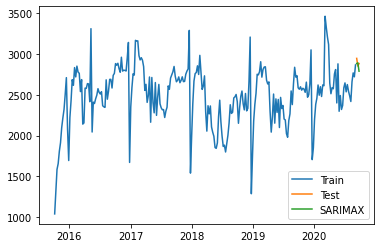

Current product:  14508


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.41646D+00    |proj g|=  1.84342D-01

At iterate    5    f=  7.38874D+00    |proj g|=  1.59196D-02

At iterate   10    f=  7.38775D+00    |proj g|=  2.89070D-04

At iterate   15    f=  7.38770D+00    |proj g|=  3.83297D-03

At iterate   20    f=  7.38533D+00    |proj g|=  1.23480D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     27      1     0     0   7.799D-06   7.385D+00
  F =   7.3845799024306977     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.41146D+00    |proj g|=  5.72223D-04

At iterate   10    f=  7.41144D+00    |proj g|=  2.56919D-03

At iterate   15    f=  7.41035D+00    |proj g|=  1.72455D-02

At iterate   20    f=  7.40927D+00    |proj g|=  4.55449D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     22      1     0     0   4.554D-06   7.409D+00
  F =   7.4092661975858851     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  303.04931497028036


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.42031D+00    |proj g|=  8.44027D-02

At iterate    5    f=  7.41336D+00    |proj g|=  2.28856D-04

At iterate   10    f=  7.41334D+00    |proj g|=  4.25589D-03

At iterate   15    f=  7.41187D+00    |proj g|=  2.29059D-02

At iterate   20    f=  7.41132D+00    |proj g|=  4.43023D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     23      1     0     0   4.430D-06   7.411D+00
  F =   7.4113228001983753     

CONVERG

 This problem is unconstrained.



Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   3.010D-05   7.376D+00
  F =   7.3759374283062629     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  296.7262211864878
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40232D+00    |proj g|=  9.85438D-02


 This problem is unconstrained.



At iterate    5    f=  7.38930D+00    |proj g|=  1.34070D-02

At iterate   10    f=  7.38914D+00    |proj g|=  7.29301D-04

At iterate   15    f=  7.38865D+00    |proj g|=  1.42439D-02

At iterate   20    f=  7.38636D+00    |proj g|=  3.35139D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   1.123D-06   7.386D+00
  F =   7.3863604092543635     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  283.4563430038189


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.63632D+00    |proj g|=  8.38448D-02

At iterate    5    f=  7.56480D+00    |proj g|=  1.04272D-01

At iterate   10    f=  7.54679D+00    |proj g|=  1.59615D-02

At iterate   15    f=  7.54662D+00    |proj g|=  4.33592D-04

At iterate   20    f=  7.54641D+00    |proj g|=  8.59869D-03

At iterate   25    f=  7.54459D+00    |proj g|=  3.07702D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     31      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57145D+00    |proj g|=  1.14583D-01

At iterate    5    f=  7.54143D+00    |proj g|=  2.09150D-03

At iterate   10    f=  7.54136D+00    |proj g|=  2.67300D-04

At iterate   15    f=  7.54111D+00    |proj g|=  5.74787D-03

At iterate   20    f=  7.53735D+00    |proj g|=  3.74598D-03

At iterate   25    f=  7.53643D+00    |proj g|=  1.86011D-03

At iterate   30    f=  7.53596D+00    |proj g|=  4.68247D-03

At iterate   35    f=  7.53584D+00    |proj g|=  1.75825D-03

At iterate   40    f=  7.53578D+00    |proj g|=  4.10472D-04

At iterate   45    f=  7.53576D+00    |proj g|=  1.62059D-04

At iterate   50    f=  7.53575D+00    |proj g|=  1.65814D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57001D+00    |proj g|=  1.14456D-01

At iterate    5    f=  7.54466D+00    |proj g|=  5.16402D-03

At iterate   10    f=  7.54432D+00    |proj g|=  3.04835D-04

At iterate   15    f=  7.54419D+00    |proj g|=  4.36135D-03

At iterate   20    f=  7.54016D+00    |proj g|=  1.08254D-02

At iterate   25    f=  7.53922D+00    |proj g|=  1.26977D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     32      1     0     0   

 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57001D+00    |proj g|=  1.14456D-01

At iterate    5    f=  7.54473D+00    |proj g|=  6.46223D-03

At iterate   10    f=  7.54402D+00    |proj g|=  3.04268D-04

At iterate   15    f=  7.54397D+00    |proj g|=  3.81398D-03

At iterate   20    f=  7.54142D+00    |proj g|=  2.36382D-02

At iterate   25    f=  7.53908D+00    |proj g|=  1.01113D-03

At iterate   30    f=  7.53906D+00    |proj g|=  2.87449D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     37      1     0     0   6.637D-05   7.539D+00
  F =   7.5390570660160598    

 This problem is unconstrained.



At iterate    5    f=  7.55826D+00    |proj g|=  1.21378D-03

At iterate   10    f=  7.55826D+00    |proj g|=  7.70344D-04

At iterate   15    f=  7.55789D+00    |proj g|=  1.10403D-02

At iterate   20    f=  7.55552D+00    |proj g|=  8.65187D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     26      1     0     0   4.707D-06   7.556D+00
  F =   7.5555137576745857     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  274.4791054714181
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate    5    f=  7.57483D+00    |proj g|=  1.33632D-01

At iterate   10    f=  7.54807D+00    |proj g|=  8.57659D-03

At iterate   15    f=  7.54512D+00    |proj g|=  2.90148D-02

At iterate   20    f=  7.54440D+00    |proj g|=  2.92611D-04

At iterate   25    f=  7.54430D+00    |proj g|=  4.71469D-03

At iterate   30    f=  7.54163D+00    |proj g|=  2.16495D-02

At iterate   35    f=  7.54009D+00    |proj g|=  7.18449D-04

At iterate   40    f=  7.54007D+00    |proj g|=  5.46403D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     52      1     0     0   2.013D-05   7.540D+00
  F =   7.54007377246

 This problem is unconstrained.



At iterate    5    f=  7.38794D+00    |proj g|=  9.19258D-03

At iterate   10    f=  7.38572D+00    |proj g|=  4.08599D-03

At iterate   15    f=  7.38566D+00    |proj g|=  3.13059D-04

At iterate   20    f=  7.38555D+00    |proj g|=  4.62520D-03

At iterate   25    f=  7.38311D+00    |proj g|=  1.51849D-02

At iterate   30    f=  7.38200D+00    |proj g|=  4.96083D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     36      1     0     0   1.983D-06   7.382D+00
  F =   7.3820010167221763     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  310.42903934717293
RUNNING THE L-BFGS-B CODE

 This problem is unconstrained.



At iterate    5    f=  7.39207D+00    |proj g|=  1.13471D-02

At iterate   10    f=  7.39173D+00    |proj g|=  2.79535D-04

At iterate   15    f=  7.39161D+00    |proj g|=  4.09785D-03

At iterate   20    f=  7.38975D+00    |proj g|=  8.75077D-03

At iterate   25    f=  7.38873D+00    |proj g|=  1.62526D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     34      1     0     0   7.803D-06   7.389D+00
  F =   7.3887273318355735     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  287.06837585261263


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57145D+00    |proj g|=  1.14583D-01

At iterate    5    f=  7.54130D+00    |proj g|=  7.53712D-03

At iterate   10    f=  7.54119D+00    |proj g|=  6.64438D-04

At iterate   15    f=  7.54117D+00    |proj g|=  1.26709D-03

At iterate   20    f=  7.53938D+00    |proj g|=  9.53744D-03

At iterate   25    f=  7.53682D+00    |proj g|=  2.41960D-03

At iterate   30    f=  7.53643D+00    |proj g|=  1.69903D-03

At iterate   35    f=  7.53614D+00    |proj g|=  1.23182D-03

At iterate   40    f=  7.53593D+00    |proj g|=  1.16707D-03

At iterate   45    f=  7.53580D+00    |proj g|=  1.06852D-03

At iterate   50    f=  7.53577D+00    |proj g|=  6.47184D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.38632D+00    |proj g|=  2.23412D-04

At iterate   10    f=  7.38631D+00    |proj g|=  1.42578D-03

At iterate   15    f=  7.38535D+00    |proj g|=  8.65177D-03

At iterate   20    f=  7.38444D+00    |proj g|=  1.08080D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     23      1     0     0   1.997D-05   7.384D+00
  F =   7.3844432432078566     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  283.9764146680801


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.41438D+00    |proj g|=  1.91929D-01

At iterate    5    f=  7.38856D+00    |proj g|=  3.89052D-04

At iterate   10    f=  7.38853D+00    |proj g|=  2.53040D-03

At iterate   15    f=  7.38675D+00    |proj g|=  1.97894D-02

At iterate   20    f=  7.38462D+00    |proj g|=  7.57114D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   1.035D-06   7.385D+00
  F =   7.3846151567265990     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.54143D+00    |proj g|=  2.09150D-03

At iterate   10    f=  7.54136D+00    |proj g|=  2.67300D-04

At iterate   15    f=  7.54111D+00    |proj g|=  5.74787D-03

At iterate   20    f=  7.53735D+00    |proj g|=  3.74598D-03

At iterate   25    f=  7.53643D+00    |proj g|=  1.86011D-03

At iterate   30    f=  7.53596D+00    |proj g|=  4.68247D-03

At iterate   35    f=  7.53584D+00    |proj g|=  1.75825D-03

At iterate   40    f=  7.53578D+00    |proj g|=  4.10472D-04

At iterate   45    f=  7.53576D+00    |proj g|=  1.62059D-04

At iterate   50    f=  7.53575D+00    |proj g|=  1.65814D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

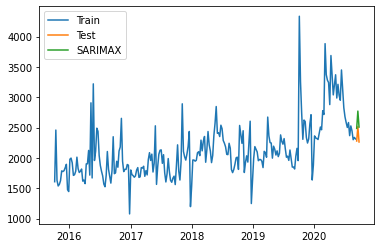

Current product:  9994


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.19715D+00    |proj g|=  1.89217D-01

At iterate    5    f=  7.17940D+00    |proj g|=  5.22037D-03

At iterate   10    f=  7.17901D+00    |proj g|=  3.43970D-04

At iterate   15    f=  7.17881D+00    |proj g|=  9.27566D-03

At iterate   20    f=  7.17647D+00    |proj g|=  1.03682D-02

At iterate   25    f=  7.17637D+00    |proj g|=  2.99974D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     32      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.26797D+00    |proj g|=  1.14868D-01

At iterate    5    f=  7.24512D+00    |proj g|=  3.22786D-03

At iterate   10    f=  7.24508D+00    |proj g|=  1.50583D-03

At iterate   15    f=  7.24485D+00    |proj g|=  2.47174D-02

At iterate   20    f=  7.24148D+00    |proj g|=  2.29611D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     26      1     0     0   1.466D-05   7.241D+00
  F =   7.2412429059497523     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.25210D+00    |proj g|=  1.99901D-04

At iterate   10    f=  7.25206D+00    |proj g|=  6.27680D-03

At iterate   15    f=  7.25123D+00    |proj g|=  1.43985D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   2.269D-05   7.251D+00
  F =   7.2510190342879657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  93.88322827052235
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.19741D+00    |proj 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   6.295D-05   7.197D+00
  F =   7.1973821645274683     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  76.70677877076938


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.17979D+00    |proj g|=  7.86196D-02

At iterate    5    f=  7.17426D+00    |proj g|=  7.16694D-03

At iterate   10    f=  7.17402D+00    |proj g|=  3.59105D-04

At iterate   15    f=  7.17298D+00    |proj g|=  1.22322D-02

At iterate   20    f=  7.17116D+00    |proj g|=  5.57099D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   2.519D-05   7.171D+00
  F =   7.1711581129698834     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.35731D+00    |proj g|=  5.08176D-04

At iterate   10    f=  7.35713D+00    |proj g|=  1.21344D-02

At iterate   15    f=  7.35337D+00    |proj g|=  3.02499D-02

At iterate   20    f=  7.35112D+00    |proj g|=  2.45573D-02

At iterate   25    f=  7.34983D+00    |proj g|=  1.89915D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     32      1     0     0   6.000D-05   7.350D+00
  F =   7.3498253764116113     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  91.19952209312666


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36192D+00    |proj g|=  4.19109D-02

At iterate    5    f=  7.35529D+00    |proj g|=  7.25929D-03

At iterate   10    f=  7.35377D+00    |proj g|=  4.30119D-04

At iterate   15    f=  7.35371D+00    |proj g|=  2.58662D-03

At iterate   20    f=  7.35126D+00    |proj g|=  2.57548D-02

At iterate   25    f=  7.34877D+00    |proj g|=  6.37154D-03

At iterate   30    f=  7.34829D+00    |proj g|=  9.12726D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36467D+00    |proj g|=  3.64011D-02

At iterate    5    f=  7.36010D+00    |proj g|=  8.74906D-04

At iterate   10    f=  7.36005D+00    |proj g|=  6.63442D-04

At iterate   15    f=  7.35903D+00    |proj g|=  2.10225D-02

At iterate   20    f=  7.35134D+00    |proj g|=  1.04445D-02

At iterate   25    f=  7.35035D+00    |proj g|=  4.65194D-04

At iterate   30    f=  7.35034D+00    |proj g|=  4.49546D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36467D+00    |proj g|=  3.64011D-02

At iterate    5    f=  7.36011D+00    |proj g|=  5.10513D-03

At iterate   10    f=  7.36002D+00    |proj g|=  7.40490D-04

At iterate   15    f=  7.35997D+00    |proj g|=  6.06177D-03

At iterate   20    f=  7.35580D+00    |proj g|=  3.40212D-02

At iterate   25    f=  7.35027D+00    |proj g|=  5.03681D-03

At iterate   30    f=  7.35004D+00    |proj g|=  2.05334D-03

At iterate   35    f=  7.35000D+00    |proj g|=  4.43902D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  7.39608D+00    |proj g|=  5.00666D-04

At iterate   10    f=  7.39588D+00    |proj g|=  4.72067D-03

At iterate   15    f=  7.38716D+00    |proj g|=  3.97457D-02

At iterate   20    f=  7.38527D+00    |proj g|=  7.80339D-04

At iterate   25    f=  7.38526D+00    |proj g|=  5.95327D-04

At iterate   30    f=  7.38517D+00    |proj g|=  7.23241D-04

At iterate   35    f=  7.38511D+00    |proj g|=  1.17373D-03

At iterate   40    f=  7.38508D+00    |proj g|=  5.21506D-05

At iterate   45    f=  7.38507D+00    |proj g|=  1.22421D-04

At iterate   50    f=  7.38486D+00    |proj g|=  1.05275D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.36523D+00    |proj g|=  1.12188D-02

At iterate   10    f=  7.36279D+00    |proj g|=  1.95548D-02

At iterate   15    f=  7.36092D+00    |proj g|=  6.15126D-04

At iterate   20    f=  7.36087D+00    |proj g|=  4.88900D-03

At iterate   25    f=  7.35644D+00    |proj g|=  3.77074D-02

At iterate   30    f=  7.35372D+00    |proj g|=  1.77924D-03

At iterate   35    f=  7.35370D+00    |proj g|=  3.51497D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     44      1     0     0   1.812D-05   7.354D+00
  F =   7.3536960340516764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.20028D+00    |proj g|=  1.97227D-01

At iterate    5    f=  7.18025D+00    |proj g|=  4.08717D-03

At iterate   10    f=  7.17919D+00    |proj g|=  2.62367D-02

At iterate   15    f=  7.17868D+00    |proj g|=  3.41294D-04

At iterate   20    f=  7.17864D+00    |proj g|=  3.38767D-03

At iterate   25    f=  7.17719D+00    |proj g|=  1.91717D-02

At iterate   30    f=  7.17608D+00    |proj g|=  1.83934D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.18739D+00    |proj g|=  7.54915D-02

At iterate    5    f=  7.18046D+00    |proj g|=  4.92457D-03

At iterate   10    f=  7.17877D+00    |proj g|=  5.57035D-03

At iterate   15    f=  7.17875D+00    |proj g|=  3.62200D-04

At iterate   20    f=  7.17856D+00    |proj g|=  1.31656D-02

At iterate   25    f=  7.17625D+00    |proj g|=  1.22676D-02

At iterate   30    f=  7.17610D+00    |proj g|=  1.52268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  7.35539D+00    |proj g|=  7.05290D-03

At iterate   10    f=  7.35365D+00    |proj g|=  2.02837D-03

At iterate   15    f=  7.35364D+00    |proj g|=  1.18872D-03

At iterate   20    f=  7.35354D+00    |proj g|=  9.30897D-03

At iterate   25    f=  7.35085D+00    |proj g|=  6.00277D-02

At iterate   30    f=  7.34796D+00    |proj g|=  2.49400D-03

At iterate   35    f=  7.34789D+00    |proj g|=  3.33349D-04

At iterate   40    f=  7.34789D+00    |proj g|=  2.24581D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     44      1     0     0   1.660D-05   7.348D+00
  F =   7.34788668425

 This problem is unconstrained.



At iterate    5    f=  7.17013D+00    |proj g|=  8.08250D-03

At iterate   10    f=  7.17005D+00    |proj g|=  2.03311D-03

At iterate   15    f=  7.17002D+00    |proj g|=  3.95447D-03

At iterate   20    f=  7.16934D+00    |proj g|=  1.11570D-02

At iterate   25    f=  7.16916D+00    |proj g|=  2.17987D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     31      1     0     0   2.464D-05   7.169D+00
  F =   7.1691630873037404     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  98.29900474819735
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate    5    f=  7.18370D+00    |proj g|=  3.54597D-03

At iterate   10    f=  7.18365D+00    |proj g|=  5.63261D-03

At iterate   15    f=  7.18178D+00    |proj g|=  3.68682D-02

At iterate   20    f=  7.18097D+00    |proj g|=  2.33160D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   3.065D-05   7.181D+00
  F =   7.1809727135502754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  85.10604476277926
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate    5    f=  7.39608D+00    |proj g|=  5.00666D-04

At iterate   10    f=  7.39588D+00    |proj g|=  4.72067D-03

At iterate   15    f=  7.38716D+00    |proj g|=  3.97457D-02

At iterate   20    f=  7.38527D+00    |proj g|=  7.80339D-04

At iterate   25    f=  7.38526D+00    |proj g|=  5.95327D-04

At iterate   30    f=  7.38517D+00    |proj g|=  7.23241D-04

At iterate   35    f=  7.38511D+00    |proj g|=  1.17373D-03

At iterate   40    f=  7.38508D+00    |proj g|=  5.21506D-05

At iterate   45    f=  7.38507D+00    |proj g|=  1.22421D-04

At iterate   50    f=  7.38486D+00    |proj g|=  1.05275D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

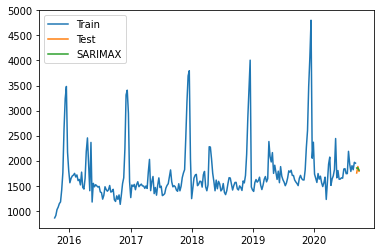

Current product:  16444


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.99880D+00    |proj g|=  3.11603D-01

At iterate    5    f=  8.75547D+00    |proj g|=  3.99271D-03

At iterate   10    f=  8.75528D+00    |proj g|=  6.28490D-04

At iterate   15    f=  8.75451D+00    |proj g|=  1.74092D-02

At iterate   20    f=  8.75164D+00    |proj g|=  6.40689D-04

At iterate   25    f=  8.75138D+00    |proj g|=  4.10842D-04

At iterate   30    f=  8.75125D+00    |proj g|=  4.88252D-04

At iterate   35    f=  8.74985D+00    |proj g|=  1.24979D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86377D+00    |proj g|=  2.74706D-01

At iterate    5    f=  8.75967D+00    |proj g|=  3.62250D-03

At iterate   10    f=  8.75939D+00    |proj g|=  4.63924D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   6.381D-05   8.759D+00
  F =   8.7593879657652263     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  655.096963356414
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f=  8.75966D+00    |proj g|=  4.47255D-03

At iterate   10    f=  8.75939D+00    |proj g|=  2.96287D-05

At iterate   15    f=  8.75938D+00    |proj g|=  1.51377D-03

At iterate   20    f=  8.75784D+00    |proj g|=  1.59646D-02

At iterate   25    f=  8.75469D+00    |proj g|=  2.07793D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     29      1     0     0   9.049D-05   8.755D+00
  F =   8.7546903289014057     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  690.3700810846528
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate   20    f=  8.78178D+00    |proj g|=  1.88314D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     23      1     0     0   1.260D-05   8.782D+00
  F =   8.7817824226792016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  809.3923574772477


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98926D+00    |proj g|=  3.02304D-01

At iterate    5    f=  8.76238D+00    |proj g|=  6.10699D-03

At iterate   10    f=  8.76057D+00    |proj g|=  6.58939D-03

At iterate   15    f=  8.76036D+00    |proj g|=  1.51033D-03

At iterate   20    f=  8.76036D+00    |proj g|=  8.98506D-05

At iterate   25    f=  8.76034D+00    |proj g|=  1.86003D-03

At iterate   30    f=  8.75856D+00    |proj g|=  2.49586D-02

At iterate   35    f=  8.75411D+00    |proj g|=  2.93528D-04

At iterate   40    f=  8.75410D+00    |proj g|=  1.80862D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02029D+00    |proj g|=  2.78508D-01

At iterate    5    f=  8.78019D+00    |proj g|=  2.74953D-02

At iterate   10    f=  8.77479D+00    |proj g|=  2.63485D-03

At iterate   15    f=  8.77390D+00    |proj g|=  1.84178D-03

At iterate   20    f=  8.77376D+00    |proj g|=  2.56315D-04

At iterate   25    f=  8.77247D+00    |proj g|=  5.33740D-03

At iterate   30    f=  8.76950D+00    |proj g|=  4.59736D-03

At iterate   35    f=  8.76938D+00    |proj g|=  9.51940D-04

At iterate   40    f=  8.76834D+00    |proj g|=  2.14097D-02

At iterate   45    f=  8.72472D+00    |proj g|=  1.19959D-02

At iterate   50    f=  8.71682D+00    |proj g|=  7.25036D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.78579D+00    |proj g|=  7.27837D-03

At iterate   10    f=  8.77089D+00    |proj g|=  7.22861D-03

At iterate   15    f=  8.76854D+00    |proj g|=  1.59846D-03

At iterate   20    f=  8.76847D+00    |proj g|=  1.26631D-03

At iterate   25    f=  8.76846D+00    |proj g|=  2.81517D-05

At iterate   30    f=  8.76846D+00    |proj g|=  5.15330D-05

At iterate   35    f=  8.76846D+00    |proj g|=  1.13624D-03

At iterate   40    f=  8.76827D+00    |proj g|=  6.12050D-03

At iterate   45    f=  8.76744D+00    |proj g|=  3.51614D-03

At iterate   50    f=  8.76739D+00    |proj g|=  2.84389D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.78020D+00    |proj g|=  2.72896D-02

At iterate   10    f=  8.77465D+00    |proj g|=  2.62485D-03

At iterate   15    f=  8.77385D+00    |proj g|=  1.10091D-03

At iterate   20    f=  8.77371D+00    |proj g|=  1.78585D-03

At iterate   25    f=  8.77007D+00    |proj g|=  2.35400D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     31      1     0     0   1.195D-05   8.769D+00
  F =   8.7693960642833808     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  803.5955531680756
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate    5    f=  8.78020D+00    |proj g|=  2.73060D-02

At iterate   10    f=  8.77460D+00    |proj g|=  4.39406D-03

At iterate   15    f=  8.77387D+00    |proj g|=  2.98228D-03

At iterate   20    f=  8.77375D+00    |proj g|=  3.19733D-04

At iterate   25    f=  8.77356D+00    |proj g|=  1.97814D-03

At iterate   30    f=  8.76995D+00    |proj g|=  9.60178D-05

At iterate   35    f=  8.76960D+00    |proj g|=  7.86460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     51      1     0     0   1.195D-05   8.769D+00
  F =   8.7693915385097121     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89952D+00    |proj g|=  3.06684D-01

At iterate    5    f=  8.78554D+00    |proj g|=  4.43845D-03

At iterate   10    f=  8.78547D+00    |proj g|=  6.15419D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     15      1     0     0   3.073D-05   8.785D+00
  F =   8.7854719399641006     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  751.0632570103221
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f=  8.76120D+00    |proj g|=  6.32779D-03

At iterate   10    f=  8.75801D+00    |proj g|=  1.93946D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     14     16      1     0     0   2.031D-05   8.758D+00
  F =   8.7579980191910227     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  823.1037848349822


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45733D+13    |proj g|=  9.45730D+18

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     14      1     0     0   1.797D+06   2.652D+03
  F =   2652.1819986887758     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  889.7039937575205


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45733D+13    |proj g|=  9.45730D+18

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     14      1     0     0   1.797D+06   2.652D+03
  F =   2652.1819986887758     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  889.7039937575205
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f=  8.78578D+00    |proj g|=  7.27909D-03

At iterate   10    f=  8.77159D+00    |proj g|=  1.60585D-02

At iterate   15    f=  8.76854D+00    |proj g|=  9.56079D-04

At iterate   20    f=  8.76847D+00    |proj g|=  5.77508D-05

At iterate   25    f=  8.76846D+00    |proj g|=  2.62095D-04

At iterate   30    f=  8.76846D+00    |proj g|=  2.17767D-04

At iterate   35    f=  8.76846D+00    |proj g|=  5.22967D-04

At iterate   40    f=  8.76844D+00    |proj g|=  1.22513D-03

At iterate   45    f=  8.76822D+00    |proj g|=  7.21805D-03

At iterate   50    f=  8.76725D+00    |proj g|=  7.04407D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86873D+00    |proj g|=  1.71619D-01

At iterate    5    f=  8.76103D+00    |proj g|=  2.56867D-03

At iterate   10    f=  8.76079D+00    |proj g|=  7.58068D-04

At iterate   15    f=  8.76076D+00    |proj g|=  6.76179D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     16      1     0     0   6.762D-05   8.761D+00
  F =   8.7607591938002756     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  6

 This problem is unconstrained.



At iterate    5    f=  8.77915D+00    |proj g|=  2.07096D-03

At iterate   10    f=  8.77740D+00    |proj g|=  5.08093D-04

At iterate   15    f=  8.77681D+00    |proj g|=  7.17259D-04

At iterate   20    f=  8.76940D+00    |proj g|=  3.09827D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     24      1     0     0   1.158D-05   8.769D+00
  F =   8.7693970732914561     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  802.4612439091825
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate    5    f=  8.76103D+00    |proj g|=  2.56867D-03

At iterate   10    f=  8.76079D+00    |proj g|=  7.58068D-04

At iterate   15    f=  8.76076D+00    |proj g|=  6.76179D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     16      1     0     0   6.762D-05   8.761D+00
  F =   8.7607591938002756     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  16444
Best Configs:  [(1, 1, 2), (1, 1, 0, 52)]
Mean Absolute Error: 553.144
Mean Squared Error: 7741.862
Root Mean Squared Error: 609.854
Mean absolute percentage er

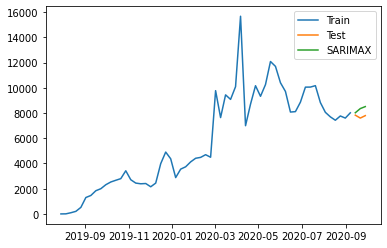

Current product:  16353


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.50691D+00    |proj g|=  1.84103D-01

At iterate    5    f=  9.41622D+00    |proj g|=  1.20407D-01

At iterate   10    f=  9.40001D+00    |proj g|=  2.71041D-03

At iterate   15    f=  9.39759D+00    |proj g|=  2.33351D-03

At iterate   20    f=  9.15908D+00    |proj g|=  6.01717D-02

At iterate   25    f=  9.14279D+00    |proj g|=  4.99518D-03

At iterate   30    f=  9.14275D+00    |proj g|=  1.69790D-04

At iterate   35    f=  9.14106D+00    |proj g|=  4.83314D-03

At iterate   40    f=  9.04587D+00    |proj g|=  1.20983D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  9.40803D+00    |proj g|=  1.22475D-03

At iterate   10    f=  9.40797D+00    |proj g|=  2.65708D-04

At iterate   15    f=  9.40786D+00    |proj g|=  6.57124D-03

At iterate   20    f=  9.15093D+00    |proj g|=  8.56491D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   2.119D-05   9.151D+00
  F =   9.1508694550570784     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1903.4947488054931


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45362D+00    |proj g|=  1.84692D-01

At iterate    5    f=  9.40799D+00    |proj g|=  4.58243D-04

At iterate   10    f=  9.40789D+00    |proj g|=  7.47320D-03

At iterate   15    f=  9.39490D+00    |proj g|=  1.12490D-01

At iterate   20    f=  9.16083D+00    |proj g|=  3.95576D-02

At iterate   25    f=  9.15930D+00    |proj g|=  1.51435D-04

At iterate   30    f=  9.14703D+00    |proj g|=  2.82456D-03

At iterate   35    f=  9.14701D+00    |proj g|=  6.11647D-04

At iterate   40    f=  9.14540D+00    |proj g|=  1.45567D-02

At iterate   45    f=  9.08514D+00    |proj g|=  3.10972D-02

At iterate   50    f=  9.04574D+00    |proj g|=  4.41223D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   15    f=  9.52054D+00    |proj g|=  6.12209D-04

At iterate   20    f=  9.38818D+00    |proj g|=  3.38705D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     28      1     0     0   6.382D-06   9.281D+00
  F =   9.2808589309211520     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  3104.675618784008
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.48747D+00    |proj g|=  1.84632D-01


 This problem is unconstrained.



At iterate    5    f=  9.41543D+00    |proj g|=  1.63886D-01

At iterate   10    f=  9.39250D+00    |proj g|=  2.46954D-03

At iterate   15    f=  9.39056D+00    |proj g|=  2.20206D-03

At iterate   20    f=  9.14092D+00    |proj g|=  5.16177D-03

At iterate   25    f=  9.11362D+00    |proj g|=  3.42441D-02

At iterate   30    f=  9.03451D+00    |proj g|=  5.66412D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     44      1     0     0   8.544D-07   9.034D+00
  F =   9.0338420874793304     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  551.127563476065
RUNNING THE L-BFGS-B CODE



 This problem is unconstrained.



At iterate    5    f=  9.43578D+00    |proj g|=  1.05204D-01

At iterate   10    f=  9.40552D+00    |proj g|=  2.33137D-03

At iterate   15    f=  9.40142D+00    |proj g|=  6.01281D-03

At iterate   20    f=  9.18306D+00    |proj g|=  7.55748D-02

At iterate   25    f=  9.14364D+00    |proj g|=  2.64397D-03

At iterate   30    f=  9.14311D+00    |proj g|=  8.15419D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     57      1     0     0   1.959D-05   9.143D+00
  F =   9.1431132109972673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1618.8204196349686


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49355D+00    |proj g|=  1.87222D-01

At iterate    5    f=  9.42886D+00    |proj g|=  1.92652D-02

At iterate   10    f=  9.41226D+00    |proj g|=  1.14468D-03

At iterate   15    f=  9.16476D+00    |proj g|=  3.04253D-02

At iterate   20    f=  9.13495D+00    |proj g|=  1.34339D-04

At iterate   25    f=  9.13340D+00    |proj g|=  9.60135D-03
  ys=-1.771E-05  -gs= 1.571E-04 BFGS update SKIPPED

At iterate   30    f=  9.13284D+00    |proj g|=  1.69290D-05

At iterate   35    f=  9.13284D+00    |proj g|=  9.90596D-04

At iterate   40    f=  9.13231D+00    |proj g|=  1.16824D-02

At iterate   45    f=  9.05324D+00    |proj g|=  7.14518D-02

At iterate   50    f=  9.03036D+00    |proj g|=  5.50738D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.48111D+00    |proj g|=  1.86926D-01

At iterate    5    f=  9.43572D+00    |proj g|=  1.05271D-01

At iterate   10    f=  9.40837D+00    |proj g|=  2.57241D-03

At iterate   15    f=  9.40154D+00    |proj g|=  5.17995D-03

At iterate   20    f=  9.31684D+00    |proj g|=  1.31030D-01

At iterate   25    f=  9.14322D+00    |proj g|=  2.58044D-04

At iterate   30    f=  9.14322D+00    |proj g|=  1.27790D-04

At iterate   35    f=  9.14316D+00    |proj g|=  3.81274D-03

At iterate   40    f=  9.13588D+00    |proj g|=  4.25240D-02

At iterate   45    f=  9.06837D+00    |proj g|=  5.38309D-03

At iterate   50    f=  9.04776D+00    |proj g|=  5.12221D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.43574D+00    |proj g|=  1.04986D-01

At iterate   10    f=  9.40539D+00    |proj g|=  2.31415D-03

At iterate   15    f=  9.40098D+00    |proj g|=  1.13810D-03

At iterate   20    f=  9.16212D+00    |proj g|=  1.12921D-01

At iterate   25    f=  9.14318D+00    |proj g|=  3.16590D-04

At iterate   30    f=  9.14318D+00    |proj g|=  3.31024D-04

At iterate   35    f=  9.14312D+00    |proj g|=  5.88146D-03

At iterate   40    f=  9.13558D+00    |proj g|=  6.36929D-02

At iterate   45    f=  9.06235D+00    |proj g|=  7.66987D-02

At iterate   50    f=  9.03825D+00    |proj g|=  5.98906D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45770D+00    |proj g|=  1.86129D-01

At iterate    5    f=  9.42761D+00    |proj g|=  1.15961D-02

At iterate   10    f=  9.42740D+00    |proj g|=  3.67583D-04

At iterate   15    f=  9.23456D+00    |proj g|=  2.73551D-01

At iterate   20    f=  9.15424D+00    |proj g|=  3.65062D-04

At iterate   25    f=  9.14913D+00    |proj g|=  8.54486D-04

At iterate   30    f=  9.04822D+00    |proj g|=  8.65584D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  9.34828D+00    |proj g|=  9.29153D-03

At iterate   10    f=  9.34644D+00    |proj g|=  3.40398D-03

At iterate   15    f=  9.33864D+00    |proj g|=  7.90621D-02

At iterate   20    f=  9.32993D+00    |proj g|=  3.72247D-02

At iterate   25    f=  9.32570D+00    |proj g|=  1.12815D-03

At iterate   30    f=  9.32479D+00    |proj g|=  5.08684D-03

At iterate   35    f=  9.23939D+00    |proj g|=  9.40080D-02

At iterate   40    f=  9.14847D+00    |proj g|=  7.07429D-04

At iterate   45    f=  9.14389D+00    |proj g|=  1.35153D-03

At iterate   50    f=  9.14293D+00    |proj g|=  3.53456D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.33759D+00    |proj g|=  9.22631D-03

At iterate   10    f=  9.32334D+00    |proj g|=  4.30208D-03

At iterate   15    f=  9.32139D+00    |proj g|=  6.56597D-04

At iterate   20    f=  9.32054D+00    |proj g|=  1.05399D-03

At iterate   25    f=  9.17867D+00    |proj g|=  1.33000D-01

At iterate   30    f=  9.14707D+00    |proj g|=  1.43021D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     43      1     0     0   2.254D-05   9.147D+00
  F =   9.1470650543855356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1312.6481911379233
RUNNING THE L-BFGS-B CODE

 This problem is unconstrained.



At iterate    5    f=  9.33763D+00    |proj g|=  9.43330D-03

At iterate   10    f=  9.32282D+00    |proj g|=  7.29786D-03

At iterate   15    f=  9.32168D+00    |proj g|=  7.30789D-03

At iterate   20    f=  9.26528D+00    |proj g|=  7.03464D-02

At iterate   25    f=  9.14325D+00    |proj g|=  5.38509D-02

At iterate   30    f=  9.13920D+00    |proj g|=  1.90816D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     39      1     0     0   1.908D-05   9.139D+00
  F =   9.1391979355476050     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  414.8094809345631
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



At iterate    5    f=  9.42885D+00    |proj g|=  1.92755D-02

At iterate   10    f=  9.41190D+00    |proj g|=  9.48464D-04

At iterate   15    f=  9.25390D+00    |proj g|=  2.94719D-02

At iterate   20    f=  9.13382D+00    |proj g|=  3.12648D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     24     31      1     0     0   4.378D-05   9.134D+00
  F =   9.1337915519821298     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2639.7246075824005


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51216D+00    |proj g|=  1.84063D-01

At iterate    5    f=  9.40750D+00    |proj g|=  3.29787D-02

At iterate   10    f=  9.39319D+00    |proj g|=  7.92935D-03

At iterate   15    f=  9.39074D+00    |proj g|=  1.00123D-02

At iterate   20    f=  9.29986D+00    |proj g|=  1.31097D-01

At iterate   25    f=  9.12761D+00    |proj g|=  2.69373D-04

At iterate   30    f=  9.12761D+00    |proj g|=  9.57987D-05

At iterate   35    f=  9.12743D+00    |proj g|=  8.27220D-03

At iterate   40    f=  9.09867D+00    |proj g|=  8.51560D-02

At iterate   45    f=  9.01761D+00    |proj g|=  1.41461D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.50691D+00    |proj g|=  7.61650D-02

At iterate    5    f=  9.41636D+00    |proj g|=  1.22297D-03

At iterate   10    f=  9.23619D+00    |proj g|=  3.71001D-04

At iterate   15    f=  9.16269D+00    |proj g|=  2.08282D-04

At iterate   20    f=  9.13183D+00    |proj g|=  1.25037D-03

At iterate   25    f=  9.06439D+00    |proj g|=  2.90138D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     39      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  9.33763D+00    |proj g|=  9.43330D-03

At iterate   10    f=  9.32282D+00    |proj g|=  7.29786D-03

At iterate   15    f=  9.32168D+00    |proj g|=  7.30789D-03

At iterate   20    f=  9.26528D+00    |proj g|=  7.03464D-02

At iterate   25    f=  9.14325D+00    |proj g|=  5.38509D-02

At iterate   30    f=  9.13920D+00    |proj g|=  1.90816D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     39      1     0     0   1.908D-05   9.139D+00
  F =   9.1391979355476050     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

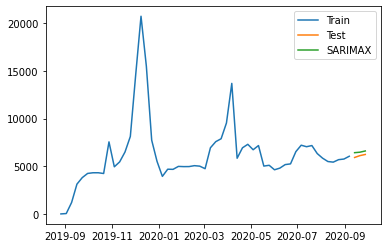

Current product:  9995
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.97183D+00    |proj g|=  2.93128D-02


 This problem is unconstrained.



At iterate    5    f=  6.96889D+00    |proj g|=  4.08226D-03

At iterate   10    f=  6.96869D+00    |proj g|=  2.19264D-03

At iterate   15    f=  6.96669D+00    |proj g|=  3.41617D-02

At iterate   20    f=  6.94885D+00    |proj g|=  3.01346D-02

At iterate   25    f=  6.94776D+00    |proj g|=  6.67813D-05

At iterate   30    f=  6.94776D+00    |proj g|=  3.33174D-04

At iterate   35    f=  6.94768D+00    |proj g|=  6.04637D-03

At iterate   40    f=  6.94528D+00    |proj g|=  1.05140D-02

At iterate   45    f=  6.94382D+00    |proj g|=  1.06974D-02

At iterate   50    f=  6.94211D+00    |proj g|=  2.20663D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.99437D+00    |proj g|=  4.34015D-03

At iterate   10    f=  6.99431D+00    |proj g|=  1.10797D-02

At iterate   15    f=  6.98919D+00    |proj g|=  6.99214D-02

At iterate   20    f=  6.96174D+00    |proj g|=  6.14349D-02

At iterate   25    f=  6.95980D+00    |proj g|=  1.84528D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     30      1     0     0   2.652D-05   6.960D+00
  F =   6.9597951615865723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  83.19774527827775


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.02425D+00    |proj g|=  3.30479D-01

At iterate    5    f=  6.99512D+00    |proj g|=  1.19689D-03

At iterate   10    f=  6.98798D+00    |proj g|=  6.09689D-02

At iterate   15    f=  6.96146D+00    |proj g|=  4.96646D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   6.921D-05   6.961D+00
  F =   6.9614636092552482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  7

 This problem is unconstrained.



At iterate    5    f=  6.99145D+00    |proj g|=  2.05869D-04

At iterate   10    f=  6.99144D+00    |proj g|=  3.26408D-03

At iterate   15    f=  6.99136D+00    |proj g|=  8.89854D-05

At iterate   20    f=  6.99135D+00    |proj g|=  8.31408D-04

At iterate   25    f=  6.99072D+00    |proj g|=  8.89298D-03

At iterate   30    f=  6.98679D+00    |proj g|=  5.68393D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     34      1     0     0   5.169D-08   6.987D+00
  F =   6.9867889039370805     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  84.92529164055603
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



At iterate    5    f=  6.96472D+00    |proj g|=  2.06504D-02

At iterate   10    f=  6.96427D+00    |proj g|=  1.02047D-03

At iterate   15    f=  6.96332D+00    |proj g|=  2.46578D-02

At iterate   20    f=  6.94486D+00    |proj g|=  5.76175D-02

At iterate   25    f=  6.94271D+00    |proj g|=  3.92122D-05

At iterate   30    f=  6.94269D+00    |proj g|=  3.04681D-03

At iterate   35    f=  6.94128D+00    |proj g|=  3.63077D-02

At iterate   40    f=  6.93754D+00    |proj g|=  4.58945D-04

At iterate   45    f=  6.93751D+00    |proj g|=  8.82549D-04

At iterate   50    f=  6.93751D+00    |proj g|=  5.22877D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.15231D+00    |proj g|=  1.75816D-01

At iterate    5    f=  7.14029D+00    |proj g|=  8.40950D-03

At iterate   10    f=  7.13897D+00    |proj g|=  1.21409D-03

At iterate   15    f=  7.13835D+00    |proj g|=  1.64062D-02

At iterate   20    f=  7.11852D+00    |proj g|=  6.61745D-02

At iterate   25    f=  7.10689D+00    |proj g|=  8.99407D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.14936D+00    |proj g|=  2.10496D-02

At iterate   10    f=  7.14701D+00    |proj g|=  1.29769D-03

At iterate   15    f=  7.14586D+00    |proj g|=  1.63264D-02

At iterate   20    f=  7.11304D+00    |proj g|=  3.05817D-02

At iterate   25    f=  7.10446D+00    |proj g|=  1.37711D-02

At iterate   30    f=  7.09978D+00    |proj g|=  1.70504D-03

At iterate   35    f=  7.09973D+00    |proj g|=  4.95365D-03

At iterate   40    f=  7.09966D+00    |proj g|=  9.30805D-04

At iterate   45    f=  7.09964D+00    |proj g|=  9.84752D-04

At iterate   50    f=  7.09963D+00    |proj g|=  2.37675D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.14056D+00    |proj g|=  4.53510D-03

At iterate   10    f=  7.14041D+00    |proj g|=  3.44399D-03

At iterate   15    f=  7.13252D+00    |proj g|=  4.18764D-02

At iterate   20    f=  7.10343D+00    |proj g|=  6.21306D-03

At iterate   25    f=  7.10197D+00    |proj g|=  1.38161D-03

At iterate   30    f=  7.10169D+00    |proj g|=  1.49608D-03

At iterate   35    f=  7.10166D+00    |proj g|=  2.15787D-04

At iterate   40    f=  7.10166D+00    |proj g|=  1.20806D-04

At iterate   45    f=  7.10165D+00    |proj g|=  5.93977D-04

At iterate   50    f=  7.10163D+00    |proj g|=  8.09811D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.14126D+00    |proj g|=  8.71293D-03

At iterate   10    f=  7.14035D+00    |proj g|=  1.29619D-03

At iterate   15    f=  7.13923D+00    |proj g|=  1.80371D-02

At iterate   20    f=  7.10638D+00    |proj g|=  1.93457D-01

At iterate   25    f=  7.09419D+00    |proj g|=  3.44909D-03

At iterate   30    f=  7.09360D+00    |proj g|=  3.57519D-03

At iterate   35    f=  7.09350D+00    |proj g|=  1.87521D-03

At iterate   40    f=  7.09347D+00    |proj g|=  6.96987D-04

At iterate   45    f=  7.09346D+00    |proj g|=  4.90583D-04

At iterate   50    f=  7.09346D+00    |proj g|=  2.10182D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.15890D+00    |proj g|=  1.33789D-03

At iterate   10    f=  7.15669D+00    |proj g|=  2.57493D-02

At iterate   15    f=  7.10259D+00    |proj g|=  1.26616D-02

At iterate   20    f=  7.10205D+00    |proj g|=  1.51272D-04

At iterate   25    f=  7.10204D+00    |proj g|=  1.61301D-03

At iterate   30    f=  7.10199D+00    |proj g|=  6.88891D-04

At iterate   35    f=  7.10197D+00    |proj g|=  2.10987D-04

At iterate   40    f=  7.10196D+00    |proj g|=  6.35337D-04

At iterate   45    f=  7.10188D+00    |proj g|=  8.40403D-04

At iterate   50    f=  7.10176D+00    |proj g|=  7.17620D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.17266D+00    |proj g|=  4.21130D-02

At iterate   10    f=  7.16386D+00    |proj g|=  1.89863D-02

At iterate   15    f=  7.16275D+00    |proj g|=  1.50856D-02

At iterate   20    f=  7.15387D+00    |proj g|=  5.22825D-02

At iterate   25    f=  7.13901D+00    |proj g|=  3.22399D-03

At iterate   30    f=  7.13890D+00    |proj g|=  3.25885D-03

At iterate   35    f=  7.13153D+00    |proj g|=  3.43902D-02

At iterate   40    f=  7.10495D+00    |proj g|=  8.63732D-03

At iterate   45    f=  7.10473D+00    |proj g|=  3.14374D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     58   

 This problem is unconstrained.



At iterate    5    f=  7.00197D+00    |proj g|=  6.49007D-03

At iterate   10    f=  6.97425D+00    |proj g|=  6.06153D-02

At iterate   15    f=  6.96707D+00    |proj g|=  1.44713D-03

At iterate   20    f=  6.96693D+00    |proj g|=  1.03612D-02

At iterate   25    f=  6.95561D+00    |proj g|=  1.17001D-01

At iterate   30    f=  6.94730D+00    |proj g|=  2.48101D-03

At iterate   35    f=  6.94729D+00    |proj g|=  3.81959D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     39      1     0     0   3.820D-05   6.947D+00
  F =   6.9472913913535956     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.02322D+00    |proj g|=  1.36120D-01

At iterate    5    f=  7.00267D+00    |proj g|=  5.17074D-03

At iterate   10    f=  6.99251D+00    |proj g|=  6.20780D-02

At iterate   15    f=  6.96831D+00    |proj g|=  2.12775D-02

At iterate   20    f=  6.96726D+00    |proj g|=  1.41377D-03

At iterate   25    f=  6.96519D+00    |proj g|=  2.76300D-02

At iterate   30    f=  6.95062D+00    |proj g|=  5.03812D-02

At iterate   35    f=  6.94732D+00    |proj g|=  7.21868D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.18095D+00    |proj g|=  1.49532D-01

At iterate    5    f=  7.15506D+00    |proj g|=  2.37720D-02

At iterate   10    f=  7.14804D+00    |proj g|=  2.85940D-02

At iterate   15    f=  7.14686D+00    |proj g|=  2.10852D-03

At iterate   20    f=  7.14290D+00    |proj g|=  3.51284D-02

At iterate   25    f=  7.11375D+00    |proj g|=  2.96782D-02

At iterate   30    f=  7.10126D+00    |proj g|=  1.75815D-02

At iterate   35    f=  7.10012D+00    |proj g|=  3.45188D-03

At iterate   40    f=  7.09983D+00    |proj g|=  2.14089D-03

At iterate   45    f=  7.09964D+00    |proj g|=  1.05610D-03

At iterate   50    f=  7.09963D+00    |proj g|=  1.06510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.96757D+00    |proj g|=  1.27263D-02

At iterate   10    f=  6.96331D+00    |proj g|=  5.57289D-03

At iterate   15    f=  6.96316D+00    |proj g|=  2.01934D-03

At iterate   20    f=  6.94927D+00    |proj g|=  1.58853D-01

At iterate   25    f=  6.93797D+00    |proj g|=  1.53227D-04

At iterate   30    f=  6.93797D+00    |proj g|=  9.96982D-05

At iterate   35    f=  6.93795D+00    |proj g|=  2.32191D-03

At iterate   40    f=  6.93633D+00    |proj g|=  3.25824D-02

At iterate   45    f=  6.93321D+00    |proj g|=  5.34770D-04

At iterate   50    f=  6.93320D+00    |proj g|=  2.85404D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.97740D+00    |proj g|=  3.07946D-02

At iterate    5    f=  6.97531D+00    |proj g|=  8.79745D-04

At iterate   10    f=  6.97502D+00    |proj g|=  1.02527D-02

At iterate   15    f=  6.96303D+00    |proj g|=  8.54253D-02

At iterate   20    f=  6.95755D+00    |proj g|=  1.00648D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   3.025D-05   6.958D+00
  F =   6.9575537623942800     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.46596D+00    |proj g|=  2.54934D-01

At iterate    5    f=  7.17266D+00    |proj g|=  4.21130D-02

At iterate   10    f=  7.16386D+00    |proj g|=  1.89863D-02

At iterate   15    f=  7.16275D+00    |proj g|=  1.50856D-02

At iterate   20    f=  7.15387D+00    |proj g|=  5.22825D-02

At iterate   25    f=  7.13901D+00    |proj g|=  3.22399D-03

At iterate   30    f=  7.13890D+00    |proj g|=  3.25885D-03

At iterate   35    f=  7.13153D+00    |proj g|=  3.43902D-02

At iterate   40    f=  7.10495D+00    |proj g|=  8.63732D-03

At iterate   45    f=  7.10473D+00    |proj g|=  3.14374D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

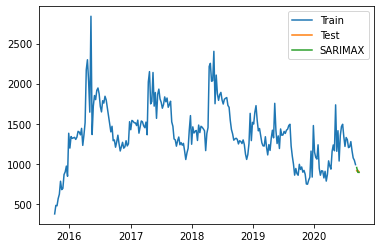

Current product:  9205


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99067D+00    |proj g|=  6.15533D-01

At iterate    5    f=  7.61350D+00    |proj g|=  2.51200D-02

At iterate   10    f=  7.51399D+00    |proj g|=  4.01368D-02

At iterate   15    f=  7.50960D+00    |proj g|=  5.04863D-02

At iterate   20    f=  7.49972D+00    |proj g|=  6.14161D-03

At iterate   25    f=  7.49949D+00    |proj g|=  3.07394D-03

At iterate   30    f=  7.49017D+00    |proj g|=  5.31002D-02

At iterate   35    f=  7.45077D+00    |proj g|=  7.63215D-03

At iterate   40    f=  7.45066D+00    |proj g|=  1.67673D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.56315D+00    |proj g|=  6.62840D-02

At iterate    5    f=  7.55684D+00    |proj g|=  1.78919D-03

At iterate   10    f=  7.55614D+00    |proj g|=  2.37122D-02

At iterate   15    f=  7.52913D+00    |proj g|=  8.60051D-02

At iterate   20    f=  7.52537D+00    |proj g|=  3.38872D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   5.825D-05   7.525D+00
  F =   7.5253657237599665     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.55983D+00    |proj g|=  5.56146D-04

At iterate   10    f=  7.55961D+00    |proj g|=  1.42336D-02

At iterate   15    f=  7.54462D+00    |proj g|=  9.93262D-02

At iterate   20    f=  7.53333D+00    |proj g|=  6.20018D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     23      1     0     0   5.952D-06   7.533D+00
  F =   7.5333271533828094     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  248.2335396291993
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate    5    f=  7.58738D+00    |proj g|=  1.36980D-03

At iterate   10    f=  7.58726D+00    |proj g|=  6.38123D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     18      1     0     0   1.100D-05   7.587D+00
  F =   7.5872323578099836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  168.2436975191644
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07852D+00    |proj g|=  6.95655D-01


 This problem is unconstrained.



At iterate    5    f=  7.62999D+00    |proj g|=  3.70957D-02

At iterate   10    f=  7.50978D+00    |proj g|=  9.65138D-04

At iterate   15    f=  7.49893D+00    |proj g|=  2.94505D-02

At iterate   20    f=  7.49849D+00    |proj g|=  1.75554D-03

At iterate   25    f=  7.49747D+00    |proj g|=  2.72249D-02

At iterate   30    f=  7.46413D+00    |proj g|=  1.28195D-01

At iterate   35    f=  7.45318D+00    |proj g|=  2.53476D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     53      1     0     0   1.310D-05   7.453D+00
  F =   7.4531815223652256     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.66950D+00    |proj g|=  2.66977D-02

At iterate   10    f=  7.59726D+00    |proj g|=  8.75556D-02

At iterate   15    f=  7.59019D+00    |proj g|=  8.97059D-04

At iterate   20    f=  7.57596D+00    |proj g|=  1.64118D-01

At iterate   25    f=  7.55810D+00    |proj g|=  3.88161D-03

At iterate   30    f=  7.55799D+00    |proj g|=  3.32840D-03

At iterate   35    f=  7.55404D+00    |proj g|=  6.59887D-02

At iterate   40    f=  7.47388D+00    |proj g|=  8.76593D-02

At iterate   45    f=  7.46002D+00    |proj g|=  3.39683D-02

At iterate   50    f=  7.45811D+00    |proj g|=  4.44486D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.55735D+00    |proj g|=  7.98145D-03

At iterate   10    f=  7.55602D+00    |proj g|=  9.41096D-04

At iterate   15    f=  7.55475D+00    |proj g|=  1.67486D-02

At iterate   20    f=  7.48449D+00    |proj g|=  1.41560D-01

At iterate   25    f=  7.45964D+00    |proj g|=  1.25478D-02

At iterate   30    f=  7.45568D+00    |proj g|=  1.35718D-02

At iterate   35    f=  7.45544D+00    |proj g|=  7.23867D-04

At iterate   40    f=  7.45530D+00    |proj g|=  9.19489D-03

At iterate   45    f=  7.45521D+00    |proj g|=  8.17894D-04

At iterate   50    f=  7.45514D+00    |proj g|=  3.56890D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.94833D+00    |proj g|=  4.81606D-01

At iterate    5    f=  7.66576D+00    |proj g|=  1.27067D-02

At iterate   10    f=  7.58811D+00    |proj g|=  1.48196D-02

At iterate   15    f=  7.58772D+00    |proj g|=  6.10149D-03

At iterate   20    f=  7.56442D+00    |proj g|=  3.57317D-02

At iterate   25    f=  7.56187D+00    |proj g|=  4.81031D-03

At iterate   30    f=  7.56086D+00    |proj g|=  2.59306D-02

At iterate   35    f=  7.49359D+00    |proj g|=  2.23640D-01

At iterate   40    f=  7.45898D+00    |proj g|=  6.07077D-03

At iterate   45    f=  7.45737D+00    |proj g|=  6.69388D-03

At iterate   50    f=  7.45694D+00    |proj g|=  1.39560D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.94833D+00    |proj g|=  4.81606D-01

At iterate    5    f=  7.66823D+00    |proj g|=  2.07744D-02

At iterate   10    f=  7.59187D+00    |proj g|=  6.49496D-02

At iterate   15    f=  7.58794D+00    |proj g|=  7.57166D-03

At iterate   20    f=  7.58776D+00    |proj g|=  2.52245D-03

At iterate   25    f=  7.57941D+00    |proj g|=  1.07776D-01

At iterate   30    f=  7.55658D+00    |proj g|=  2.02366D-02

At iterate   35    f=  7.55612D+00    |proj g|=  1.00216D-03

At iterate   40    f=  7.55134D+00    |proj g|=  3.62617D-02

At iterate   45    f=  7.49077D+00    |proj g|=  6.89699D-02

At iterate   50    f=  7.46514D+00    |proj g|=  3.70912D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.60522D+00    |proj g|=  8.26959D-04

At iterate   10    f=  7.60466D+00    |proj g|=  1.17274D-02

At iterate   15    f=  7.54161D+00    |proj g|=  2.37692D-01

At iterate   20    f=  7.51597D+00    |proj g|=  1.12255D-02

At iterate   25    f=  7.51575D+00    |proj g|=  1.39426D-04

At iterate   30    f=  7.51572D+00    |proj g|=  2.77016D-03

At iterate   35    f=  7.51566D+00    |proj g|=  5.72788D-04

At iterate   40    f=  7.51563D+00    |proj g|=  1.75226D-03

At iterate   45    f=  7.51534D+00    |proj g|=  7.60309D-03

At iterate   50    f=  7.51446D+00    |proj g|=  3.81246D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.63292D+00    |proj g|=  1.32189D-01

At iterate    5    f=  7.57397D+00    |proj g|=  1.65030D-02

At iterate   10    f=  7.57205D+00    |proj g|=  2.76198D-02

At iterate   15    f=  7.54365D+00    |proj g|=  3.85941D-02

At iterate   20    f=  7.54069D+00    |proj g|=  9.62450D-04

At iterate   25    f=  7.54023D+00    |proj g|=  1.86762D-02

At iterate   30    f=  7.49696D+00    |proj g|=  1.79221D-01

At iterate   35    f=  7.44524D+00    |proj g|=  1.03406D-01

At iterate   40    f=  7.44100D+00    |proj g|=  9.96712D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.52852D+00    |proj g|=  1.05680D-01

At iterate    5    f=  7.49490D+00    |proj g|=  4.80953D-03

At iterate   10    f=  7.48914D+00    |proj g|=  5.81366D-02

At iterate   15    f=  7.47550D+00    |proj g|=  1.38122D-03

At iterate   20    f=  7.47539D+00    |proj g|=  4.23690D-03

At iterate   25    f=  7.46266D+00    |proj g|=  5.97803D-02

At iterate   30    f=  7.43088D+00    |proj g|=  6.08763D-02

At iterate   35    f=  7.42911D+00    |proj g|=  2.33873D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  7.49555D+00    |proj g|=  4.67099D-03

At iterate   10    f=  7.48483D+00    |proj g|=  8.30199D-02

At iterate   15    f=  7.47726D+00    |proj g|=  4.71074D-03

At iterate   20    f=  7.47721D+00    |proj g|=  4.23074D-03

At iterate   25    f=  7.47330D+00    |proj g|=  5.28738D-02

At iterate   30    f=  7.44168D+00    |proj g|=  1.52728D-02

At iterate   35    f=  7.43507D+00    |proj g|=  2.32911D-02

At iterate   40    f=  7.43442D+00    |proj g|=  2.83603D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     46      1     0     0   2.836D-05   7.434D+00
  F =   7.43442418155

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.59117D+00    |proj g|=  1.26287D-01

At iterate    5    f=  7.55498D+00    |proj g|=  9.97597D-03

At iterate   10    f=  7.55212D+00    |proj g|=  9.58582D-04

At iterate   15    f=  7.55196D+00    |proj g|=  6.22415D-03

At iterate   20    f=  7.53236D+00    |proj g|=  8.90456D-02

At iterate   25    f=  7.45597D+00    |proj g|=  2.89264D-02

At iterate   30    f=  7.45069D+00    |proj g|=  8.05837D-03

At iterate   35    f=  7.44810D+00    |proj g|=  2.95865D-02

At iterate   40    f=  7.44607D+00    |proj g|=  9.89922D-04

At iterate   45    f=  7.44605D+00    |proj g|=  4.04759D-04

At iterate   50    f=  7.44594D+00    |proj g|=  1.66058D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.51430D+00    |proj g|=  2.10942D-01

At iterate    5    f=  7.48364D+00    |proj g|=  3.29757D-03

At iterate   10    f=  7.48330D+00    |proj g|=  8.29904D-04

At iterate   15    f=  7.48257D+00    |proj g|=  2.78072D-02

At iterate   20    f=  7.44914D+00    |proj g|=  6.35711D-02

At iterate   25    f=  7.44210D+00    |proj g|=  4.70616D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     30      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.53302D+00    |proj g|=  6.19001D-03

At iterate   10    f=  7.53284D+00    |proj g|=  3.27366D-03

At iterate   15    f=  7.52087D+00    |proj g|=  2.86274D-02

At iterate   20    f=  7.47612D+00    |proj g|=  2.35427D-02

At iterate   25    f=  7.47556D+00    |proj g|=  1.77097D-04

At iterate   30    f=  7.47554D+00    |proj g|=  7.07649D-03

At iterate   35    f=  7.47397D+00    |proj g|=  6.77249D-02

At iterate   40    f=  7.46658D+00    |proj g|=  2.18446D-02

At iterate   45    f=  7.46613D+00    |proj g|=  4.49548D-03

At iterate   50    f=  7.46529D+00    |proj g|=  8.99533D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55421D+00    |proj g|=  6.15962D-02

At iterate    5    f=  7.53302D+00    |proj g|=  6.19001D-03

At iterate   10    f=  7.53284D+00    |proj g|=  3.27366D-03

At iterate   15    f=  7.52087D+00    |proj g|=  2.86274D-02

At iterate   20    f=  7.47612D+00    |proj g|=  2.35427D-02

At iterate   25    f=  7.47556D+00    |proj g|=  1.77097D-04

At iterate   30    f=  7.47554D+00    |proj g|=  7.07649D-03

At iterate   35    f=  7.47397D+00    |proj g|=  6.77249D-02

At iterate   40    f=  7.46658D+00    |proj g|=  2.18446D-02

At iterate   45    f=  7.46613D+00    |proj g|=  4.49548D-03

At iterate   50    f=  7.46529D+00    |proj g|=  8.99533D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

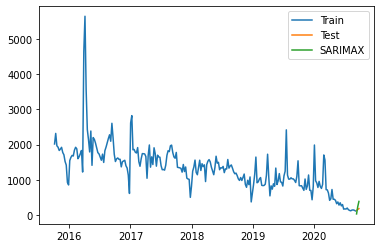

Current product:  14760


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.55608D+00    |proj g|=  1.43149D-01

At iterate    5    f=  8.52024D+00    |proj g|=  1.34166D-02

At iterate   10    f=  8.51964D+00    |proj g|=  3.96222D-04

At iterate   15    f=  8.51945D+00    |proj g|=  7.90206D-03

At iterate   20    f=  8.50692D+00    |proj g|=  5.14283D-02

At iterate   25    f=  8.49834D+00    |proj g|=  1.17648D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  8.56928D+00    |proj g|=  5.65599D-04

At iterate   10    f=  8.56928D+00    |proj g|=  6.99758D-04

At iterate   15    f=  8.56911D+00    |proj g|=  9.38023D-03

At iterate   20    f=  8.56361D+00    |proj g|=  4.40583D-02

At iterate   25    f=  8.55922D+00    |proj g|=  1.65652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     29      1     0     0   5.934D-06   8.559D+00
  F =   8.5592143710043640     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  638.7366032620167


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.57339D+00    |proj g|=  2.61750D-02

At iterate    5    f=  8.57232D+00    |proj g|=  1.23728D-04

At iterate   10    f=  8.57229D+00    |proj g|=  3.56115D-03

At iterate   15    f=  8.56934D+00    |proj g|=  2.87651D-02

At iterate   20    f=  8.56353D+00    |proj g|=  5.36513D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     25      1     0     0   3.943D-06   8.564D+00
  F =   8.5635296243136754     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  8.56785D+00    |proj g|=  1.40035D-03

At iterate   10    f=  8.56720D+00    |proj g|=  2.55664D-02

At iterate   15    f=  8.56249D+00    |proj g|=  9.67296D-05

At iterate   20    f=  8.56245D+00    |proj g|=  5.17554D-03

At iterate   25    f=  8.56070D+00    |proj g|=  1.82869D-02

At iterate   30    f=  8.56036D+00    |proj g|=  4.21476D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     37      1     0     0   4.215D-06   8.560D+00
  F =   8.5603607687538243     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  391.49874574975144
RUNNING THE L-BFGS-B CODE

 This problem is unconstrained.



At iterate    5    f=  8.52440D+00    |proj g|=  3.60293D-03

At iterate   10    f=  8.52435D+00    |proj g|=  5.22333D-04

At iterate   15    f=  8.52427D+00    |proj g|=  8.81302D-03

At iterate   20    f=  8.51623D+00    |proj g|=  7.36390D-02

At iterate   25    f=  8.50671D+00    |proj g|=  9.49310D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     31      1     0     0   3.057D-06   8.507D+00
  F =   8.5066893863221473     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1424.3345990892915
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  8.58155D+00    |proj g|=  7.01125D-03

At iterate   10    f=  8.58117D+00    |proj g|=  1.18125D-04

At iterate   15    f=  8.58117D+00    |proj g|=  1.11520D-03

At iterate   20    f=  8.58082D+00    |proj g|=  1.41771D-02

At iterate   25    f=  8.57330D+00    |proj g|=  2.98331D-02

At iterate   30    f=  8.57223D+00    |proj g|=  3.87720D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     36      1     0     0   2.986D-05   8.572D+00
  F =   8.5722285419971449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  781.9982160830496


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69050D+00    |proj g|=  3.11750D-01

At iterate    5    f=  8.57045D+00    |proj g|=  1.23452D-02

At iterate   10    f=  8.56778D+00    |proj g|=  1.19599D-03

At iterate   15    f=  8.56774D+00    |proj g|=  1.81084D-04

At iterate   20    f=  8.56768D+00    |proj g|=  1.61735D-03

At iterate   25    f=  8.55478D+00    |proj g|=  5.61888D-02

At iterate   30    f=  8.52830D+00    |proj g|=  2.79913D-02

At iterate   35    f=  8.51707D+00    |proj g|=  3.27478D-03

At iterate   40    f=  8.51703D+00    |proj g|=  3.09273D-04

At iterate   45    f=  8.51699D+00    |proj g|=  3.75427D-03

At iterate   50    f=  8.51674D+00    |proj g|=  1.57847D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.58539D+00    |proj g|=  1.24167D-02

At iterate   10    f=  8.58400D+00    |proj g|=  1.63682D-04

At iterate   15    f=  8.58331D+00    |proj g|=  2.03933D-02

At iterate   20    f=  8.54560D+00    |proj g|=  3.23173D-02

At iterate   25    f=  8.54264D+00    |proj g|=  3.17266D-03

At iterate   30    f=  8.54250D+00    |proj g|=  1.89346D-03

At iterate   35    f=  8.54191D+00    |proj g|=  6.20736D-04

At iterate   40    f=  8.54181D+00    |proj g|=  1.98903D-04

At iterate   45    f=  8.54177D+00    |proj g|=  2.93486D-04

At iterate   50    f=  8.54159D+00    |proj g|=  2.00593D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61923D+00    |proj g|=  1.17369D-01

At iterate    5    f=  8.58434D+00    |proj g|=  6.19811D-03

At iterate   10    f=  8.58266D+00    |proj g|=  4.96955D-03

At iterate   15    f=  8.57670D+00    |proj g|=  7.98009D-03

At iterate   20    f=  8.57552D+00    |proj g|=  1.71929D-03

At iterate   25    f=  8.57519D+00    |proj g|=  1.31706D-03

At iterate   30    f=  8.57478D+00    |proj g|=  1.07042D-02

At iterate   35    f=  8.52495D+00    |proj g|=  1.00204D-02

At iterate   40    f=  8.52471D+00    |proj g|=  1.30729D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  8.60243D+00    |proj g|=  3.46300D-03

At iterate   10    f=  8.60212D+00    |proj g|=  1.19451D-03

At iterate   15    f=  8.60206D+00    |proj g|=  1.94437D-03

At iterate   20    f=  8.60089D+00    |proj g|=  2.23667D-02

At iterate   25    f=  8.56607D+00    |proj g|=  7.12957D-02

At iterate   30    f=  8.55955D+00    |proj g|=  1.77117D-03

At iterate   35    f=  8.55690D+00    |proj g|=  2.50911D-04

At iterate   40    f=  8.55664D+00    |proj g|=  5.06198D-04

At iterate   45    f=  8.55653D+00    |proj g|=  1.04611D-04

At iterate   50    f=  8.55638D+00    |proj g|=  2.61789D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61360D+00    |proj g|=  1.17414D-01

At iterate    5    f=  8.57745D+00    |proj g|=  1.34073D-02

At iterate   10    f=  8.57459D+00    |proj g|=  3.49868D-03

At iterate   15    f=  8.57458D+00    |proj g|=  3.60198D-04

At iterate   20    f=  8.57453D+00    |proj g|=  5.18210D-03

At iterate   25    f=  8.57058D+00    |proj g|=  4.15663D-02

At iterate   30    f=  8.56615D+00    |proj g|=  4.48793D-03

At iterate   35    f=  8.56607D+00    |proj g|=  5.14441D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.55776D+00    |proj g|=  1.43898D-01

At iterate    5    f=  8.52291D+00    |proj g|=  2.46994D-02

At iterate   10    f=  8.51931D+00    |proj g|=  3.61938D-04

At iterate   15    f=  8.51930D+00    |proj g|=  5.66402D-04

At iterate   20    f=  8.51908D+00    |proj g|=  8.05363D-03

At iterate   25    f=  8.51005D+00    |proj g|=  1.53210D-02

At iterate   30    f=  8.49913D+00    |proj g|=  2.31643D-02

At iterate   35    f=  8.49827D+00    |proj g|=  1.07973D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53167D+00    |proj g|=  3.20084D-02

At iterate    5    f=  8.52692D+00    |proj g|=  2.73912D-02

At iterate   10    f=  8.52517D+00    |proj g|=  1.73549D-04

At iterate   15    f=  8.52515D+00    |proj g|=  2.38032D-03

At iterate   20    f=  8.52336D+00    |proj g|=  2.68834D-02

At iterate   25    f=  8.51269D+00    |proj g|=  1.95212D-02

At iterate   30    f=  8.50798D+00    |proj g|=  4.04465D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  8.56967D+00    |proj g|=  1.03760D-02

At iterate   10    f=  8.56814D+00    |proj g|=  5.91313D-03

At iterate   15    f=  8.56773D+00    |proj g|=  1.47909D-03

At iterate   20    f=  8.56771D+00    |proj g|=  1.93634D-04

At iterate   25    f=  8.56755D+00    |proj g|=  7.07730D-03

At iterate   30    f=  8.55719D+00    |proj g|=  2.73957D-02

At iterate   35    f=  8.53253D+00    |proj g|=  1.83503D-02

At iterate   40    f=  8.52172D+00    |proj g|=  1.54468D-02

At iterate   45    f=  8.51750D+00    |proj g|=  3.02625D-04

At iterate   50    f=  8.51744D+00    |proj g|=  5.16921D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.51860D+00    |proj g|=  5.38764D-03

At iterate   10    f=  8.51745D+00    |proj g|=  1.70633D-04

At iterate   15    f=  8.51655D+00    |proj g|=  2.01759D-02

At iterate   20    f=  8.50168D+00    |proj g|=  6.77522D-03

At iterate   25    f=  8.50107D+00    |proj g|=  3.50945D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     31      1     0     0   1.966D-06   8.501D+00
  F =   8.5010738333479665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1496.5438092482773
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  8.53144D+00    |proj g|=  1.71915D-04

At iterate   10    f=  8.53142D+00    |proj g|=  1.42368D-03

At iterate   15    f=  8.53023D+00    |proj g|=  1.39028D-02

At iterate   20    f=  8.51566D+00    |proj g|=  2.36421D-02

At iterate   25    f=  8.51272D+00    |proj g|=  1.82198D-02

At iterate   30    f=  8.50892D+00    |proj g|=  2.09442D-03

At iterate   35    f=  8.50841D+00    |proj g|=  2.74314D-04

At iterate   40    f=  8.50833D+00    |proj g|=  3.37597D-04

At iterate   45    f=  8.50831D+00    |proj g|=  2.68157D-05

At iterate   50    f=  8.50584D+00    |proj g|=  6.65791D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.56785D+00    |proj g|=  1.40035D-03

At iterate   10    f=  8.56720D+00    |proj g|=  2.55664D-02

At iterate   15    f=  8.56249D+00    |proj g|=  9.67296D-05

At iterate   20    f=  8.56245D+00    |proj g|=  5.17554D-03

At iterate   25    f=  8.56070D+00    |proj g|=  1.82869D-02

At iterate   30    f=  8.56036D+00    |proj g|=  4.21476D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     37      1     0     0   4.215D-06   8.560D+00
  F =   8.5603607687538243     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

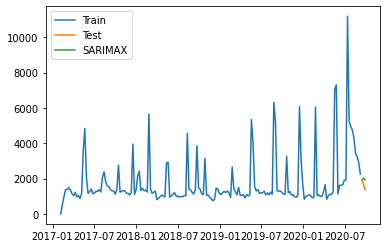

Current product:  15112


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48943D+00    |proj g|=  3.18236D-01

At iterate    5    f=  8.39821D+00    |proj g|=  8.58902D-03

At iterate   10    f=  8.39622D+00    |proj g|=  2.99798D-04

At iterate   15    f=  8.39619D+00    |proj g|=  3.46094D-03

At iterate   20    f=  8.39245D+00    |proj g|=  3.95267D-02

At iterate   25    f=  8.33382D+00    |proj g|=  9.64418D-02

At iterate   30    f=  8.32203D+00    |proj g|=  1.32999D-03

At iterate   35    f=  8.32134D+00    |proj g|=  1.45966D-03

At iterate   40    f=  8.32109D+00    |proj g|=  1.24146D-03

At iterate   45    f=  8.32104D+00    |proj g|=  6.80636D-04

At iterate   50    f=  8.32097D+00    |proj g|=  1.48790D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51167D+00    |proj g|=  3.44813D-01

At iterate    5    f=  8.41486D+00    |proj g|=  8.27809D-03

At iterate   10    f=  8.41467D+00    |proj g|=  2.50604D-04

At iterate   15    f=  8.41451D+00    |proj g|=  8.61413D-03

At iterate   20    f=  8.39714D+00    |proj g|=  8.35827D-02

At iterate   25    f=  8.37417D+00    |proj g|=  1.46590D-02

At iterate   30    f=  8.36963D+00    |proj g|=  9.22083D-03

At iterate   35    f=  8.36815D+00    |proj g|=  1.56042D-03

At iterate   40    f=  8.36779D+00    |proj g|=  5.73014D-04

At iterate   45    f=  8.36772D+00    |proj g|=  3.37947D-04

At iterate   50    f=  8.36746D+00    |proj g|=  7.61099D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41779D+00    |proj g|=  2.07631D-02

At iterate    5    f=  8.41667D+00    |proj g|=  5.37247D-04

At iterate   10    f=  8.41639D+00    |proj g|=  1.04988D-02

At iterate   15    f=  8.40579D+00    |proj g|=  4.36766D-02

At iterate   20    f=  8.38163D+00    |proj g|=  6.48086D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   2.090D-05   8.382D+00
  F =   8.3815483556232593     

CONVERG

 This problem is unconstrained.


rmse:  648.1496554661036
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.40600D+00    |proj g|=  4.58051D-02


 This problem is unconstrained.



At iterate    5    f=  8.40276D+00    |proj g|=  6.59907D-03

At iterate   10    f=  8.40270D+00    |proj g|=  3.14558D-04

At iterate   15    f=  8.40247D+00    |proj g|=  8.12112D-03

At iterate   20    f=  8.37150D+00    |proj g|=  1.03288D-01

At iterate   25    f=  8.35762D+00    |proj g|=  1.88351D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   1.895D-05   8.358D+00
  F =   8.3576179804429209     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  236.84528814220695
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  8.46312D+00    |proj g|=  1.85590D-02

At iterate   10    f=  8.46085D+00    |proj g|=  2.33245D-04

At iterate   15    f=  8.46076D+00    |proj g|=  3.09388D-03

At iterate   20    f=  8.44869D+00    |proj g|=  4.15650D-02

At iterate   25    f=  8.41001D+00    |proj g|=  1.11512D-02

At iterate   30    f=  8.40671D+00    |proj g|=  2.87033D-03

At iterate   35    f=  8.40597D+00    |proj g|=  9.12637D-03

At iterate   40    f=  8.40578D+00    |proj g|=  3.47392D-04

At iterate   45    f=  8.40574D+00    |proj g|=  5.93070D-04

At iterate   50    f=  8.40568D+00    |proj g|=  8.11079D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.43521D+00    |proj g|=  4.10820D-03

At iterate   10    f=  8.43482D+00    |proj g|=  2.57611D-04

At iterate   15    f=  8.43479D+00    |proj g|=  1.89679D-03

At iterate   20    f=  8.43209D+00    |proj g|=  1.34250D-02

At iterate   25    f=  8.38542D+00    |proj g|=  1.84172D-02

At iterate   30    f=  8.37696D+00    |proj g|=  1.12657D-02

At iterate   35    f=  8.36373D+00    |proj g|=  1.58200D-02

At iterate   40    f=  8.36031D+00    |proj g|=  5.73471D-04

At iterate   45    f=  8.35971D+00    |proj g|=  1.77216D-03

At iterate   50    f=  8.35959D+00    |proj g|=  1.80570D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.46050D+00    |proj g|=  1.50988D-02

At iterate   10    f=  8.45802D+00    |proj g|=  1.18019D-03

At iterate   15    f=  8.45799D+00    |proj g|=  1.06603D-03

At iterate   20    f=  8.45720D+00    |proj g|=  1.58839D-02

At iterate   25    f=  8.40946D+00    |proj g|=  3.93805D-02

At iterate   30    f=  8.39169D+00    |proj g|=  4.49271D-03

At iterate   35    f=  8.38841D+00    |proj g|=  8.22725D-03

At iterate   40    f=  8.38749D+00    |proj g|=  2.40294D-03

At iterate   45    f=  8.38734D+00    |proj g|=  2.39127D-04

At iterate   50    f=  8.38724D+00    |proj g|=  8.32803D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54148D+00    |proj g|=  2.62412D-01

At iterate    5    f=  8.46238D+00    |proj g|=  1.50267D-02

At iterate   10    f=  8.45669D+00    |proj g|=  1.80363D-03

At iterate   15    f=  8.45661D+00    |proj g|=  9.08091D-04

At iterate   20    f=  8.45599D+00    |proj g|=  9.78693D-03

At iterate   25    f=  8.41415D+00    |proj g|=  7.76720D-02

At iterate   30    f=  8.39454D+00    |proj g|=  1.14285D-02

At iterate   35    f=  8.38952D+00    |proj g|=  2.81644D-02

At iterate   40    f=  8.38236D+00    |proj g|=  3.44763D-03

At iterate   45    f=  8.38098D+00    |proj g|=  1.95115D-03

At iterate   50    f=  8.38060D+00    |proj g|=  3.14420D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53793D+00    |proj g|=  2.62577D-01

At iterate    5    f=  8.46812D+00    |proj g|=  3.06286D-03

At iterate   10    f=  8.46791D+00    |proj g|=  2.35259D-04

At iterate   15    f=  8.46773D+00    |proj g|=  4.79420D-03

At iterate   20    f=  8.40956D+00    |proj g|=  4.82752D-02

At iterate   25    f=  8.40365D+00    |proj g|=  5.12185D-03

At iterate   30    f=  8.40094D+00    |proj g|=  1.02956D-03

At iterate   35    f=  8.40031D+00    |proj g|=  2.79771D-03

At iterate   40    f=  8.40013D+00    |proj g|=  3.60290D-04

At iterate   45    f=  8.40009D+00    |proj g|=  3.29202D-05

At iterate   50    f=  8.39920D+00    |proj g|=  1.72283D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51362D+00    |proj g|=  2.54118D-01

At iterate    5    f=  8.44615D+00    |proj g|=  2.39920D-02

At iterate   10    f=  8.44395D+00    |proj g|=  5.07469D-04

At iterate   15    f=  8.44394D+00    |proj g|=  6.48045D-04

At iterate   20    f=  8.44368D+00    |proj g|=  1.08066D-02

At iterate   25    f=  8.41342D+00    |proj g|=  1.03436D-01

At iterate   30    f=  8.38195D+00    |proj g|=  2.96162D-02

At iterate   35    f=  8.37881D+00    |proj g|=  1.79155D-02

At iterate   40    f=  8.37689D+00    |proj g|=  2.75196D-03

At iterate   45    f=  8.37663D+00    |proj g|=  3.16960D-03

At iterate   50    f=  8.37662D+00    |proj g|=  1.96416D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48288D+00    |proj g|=  3.20187D-01

At iterate    5    f=  8.39368D+00    |proj g|=  7.77501D-03

At iterate   10    f=  8.39299D+00    |proj g|=  4.51155D-03

At iterate   15    f=  8.39275D+00    |proj g|=  5.07453D-04

At iterate   20    f=  8.39260D+00    |proj g|=  8.60648D-03

At iterate   25    f=  8.37547D+00    |proj g|=  9.09940D-02

At iterate   30    f=  8.35146D+00    |proj g|=  4.15260D-03

At iterate   35    f=  8.34774D+00    |proj g|=  1.71304D-02

At iterate   40    f=  8.33398D+00    |proj g|=  7.72902D-02

At iterate   45    f=  8.31970D+00    |proj g|=  1.97189D-03

At iterate   50    f=  8.31969D+00    |proj g|=  5.94869D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.39502D+00    |proj g|=  1.16695D-02

At iterate   10    f=  8.39448D+00    |proj g|=  2.55167D-04

At iterate   15    f=  8.39442D+00    |proj g|=  5.89052D-03

At iterate   20    f=  8.38731D+00    |proj g|=  6.30745D-02

At iterate   25    f=  8.35715D+00    |proj g|=  2.92216D-03

At iterate   30    f=  8.35699D+00    |proj g|=  7.29141D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     34      1     0     0   2.066D-05   8.357D+00
  F =   8.3569937969638612     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  557.115162897797


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.50502D+00    |proj g|=  2.57407D-01

At iterate    5    f=  8.43545D+00    |proj g|=  6.36744D-03

At iterate   10    f=  8.43398D+00    |proj g|=  1.93049D-03

At iterate   15    f=  8.43396D+00    |proj g|=  6.73296D-04

At iterate   20    f=  8.43368D+00    |proj g|=  4.76876D-03

At iterate   25    f=  8.38918D+00    |proj g|=  8.20395D-02

At iterate   30    f=  8.36741D+00    |proj g|=  1.17571D-02

At iterate   35    f=  8.35895D+00    |proj g|=  1.38398D-02

At iterate   40    f=  8.35716D+00    |proj g|=  9.26356D-03

At iterate   45    f=  8.35638D+00    |proj g|=  6.97767D-03

At iterate   50    f=  8.35609D+00    |proj g|=  3.56696D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.37178D+00    |proj g|=  5.37407D-03

At iterate   10    f=  8.37149D+00    |proj g|=  4.06865D-04

At iterate   15    f=  8.37099D+00    |proj g|=  1.14603D-02

At iterate   20    f=  8.34965D+00    |proj g|=  4.98964D-02

At iterate   25    f=  8.32721D+00    |proj g|=  3.66228D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     31      1     0     0   1.906D-05   8.327D+00
  F =   8.3271984362955127     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  323.4357037959086
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate    5    f=  8.40457D+00    |proj g|=  1.01295D-03

At iterate   10    f=  8.40455D+00    |proj g|=  1.21205D-03

At iterate   15    f=  8.40267D+00    |proj g|=  1.46331D-02

At iterate   20    f=  8.36990D+00    |proj g|=  1.32699D-02

At iterate   25    f=  8.35059D+00    |proj g|=  1.36477D-02

At iterate   30    f=  8.34716D+00    |proj g|=  1.20422D-03

At iterate   35    f=  8.34652D+00    |proj g|=  2.02265D-04

At iterate   40    f=  8.34638D+00    |proj g|=  2.13557D-03

At iterate   45    f=  8.34632D+00    |proj g|=  1.20261D-04

At iterate   50    f=  8.33451D+00    |proj g|=  5.97821D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49505D+00    |proj g|=  3.23426D-01

At iterate    5    f=  8.40457D+00    |proj g|=  1.01295D-03

At iterate   10    f=  8.40455D+00    |proj g|=  1.21205D-03

At iterate   15    f=  8.40267D+00    |proj g|=  1.46331D-02

At iterate   20    f=  8.36990D+00    |proj g|=  1.32699D-02

At iterate   25    f=  8.35059D+00    |proj g|=  1.36477D-02

At iterate   30    f=  8.34716D+00    |proj g|=  1.20422D-03

At iterate   35    f=  8.34652D+00    |proj g|=  2.02265D-04

At iterate   40    f=  8.34638D+00    |proj g|=  2.13557D-03

At iterate   45    f=  8.34632D+00    |proj g|=  1.20261D-04

At iterate   50    f=  8.33451D+00    |proj g|=  5.97821D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

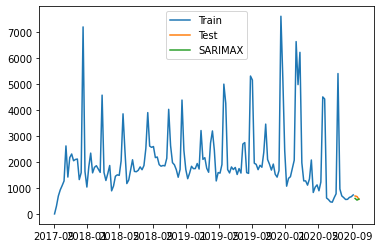

Current product:  14536


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83337D+00    |proj g|=  2.44596D-01

At iterate    5    f=  6.69752D+00    |proj g|=  2.55845D-02

At iterate   10    f=  6.69021D+00    |proj g|=  3.32774D-03

At iterate   15    f=  6.69016D+00    |proj g|=  6.25572D-03

At iterate   20    f=  6.68687D+00    |proj g|=  4.27840D-02

At iterate   25    f=  6.68395D+00    |proj g|=  3.98102D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     36      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.87943D+00    |proj g|=  2.51360D-01

At iterate    5    f=  6.77172D+00    |proj g|=  6.13579D-04

At iterate   10    f=  6.77162D+00    |proj g|=  5.18571D-03

At iterate   15    f=  6.76893D+00    |proj g|=  1.47339D-02

At iterate   20    f=  6.76818D+00    |proj g|=  2.45096D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   2.451D-05   6.768D+00
  F =   6.7681790738968193     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  6.77882D+00    |proj g|=  5.34150D-04

At iterate   10    f=  6.77880D+00    |proj g|=  6.96188D-03

At iterate   15    f=  6.77759D+00    |proj g|=  5.70292D-02

At iterate   20    f=  6.77623D+00    |proj g|=  4.74684D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     24      1     0     0   2.069D-05   6.776D+00
  F =   6.7762339841839241     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  123.54669468874845
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exac

 This problem is unconstrained.



At iterate    5    f=  6.71848D+00    |proj g|=  1.79594D-04

At iterate   10    f=  6.71846D+00    |proj g|=  2.24450D-03

At iterate   15    f=  6.71845D+00    |proj g|=  4.90128D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   4.901D-05   6.718D+00
  F =   6.7184470236779958     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  129.54316454998283


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.72876D+00    |proj g|=  2.32176D-01

At iterate    5    f=  6.70175D+00    |proj g|=  4.96681D-02

At iterate   10    f=  6.69479D+00    |proj g|=  7.57139D-04

At iterate   15    f=  6.69459D+00    |proj g|=  7.83506D-03

At iterate   20    f=  6.69148D+00    |proj g|=  4.98146D-02

At iterate   25    f=  6.69053D+00    |proj g|=  1.15797D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     28      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.98954D+00    |proj g|=  2.45493D-02

At iterate   10    f=  6.98283D+00    |proj g|=  8.96277D-04

At iterate   15    f=  6.98277D+00    |proj g|=  5.54275D-03

At iterate   20    f=  6.97811D+00    |proj g|=  7.60601D-02

At iterate   25    f=  6.97543D+00    |proj g|=  7.58309D-04

At iterate   30    f=  6.97543D+00    |proj g|=  1.79269D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     35      1     0     0   1.793D-05   6.975D+00
  F =   6.9754309360953073     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  164.90142407029322


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00949D+00    |proj g|=  1.09451D-01

At iterate    5    f=  6.98472D+00    |proj g|=  1.44163D-03

At iterate   10    f=  6.98444D+00    |proj g|=  9.51896D-04

At iterate   15    f=  6.98390D+00    |proj g|=  1.28654D-02

At iterate   20    f=  6.97601D+00    |proj g|=  3.50142D-03

At iterate   25    f=  6.97583D+00    |proj g|=  1.94901D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     33      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.01322D+00    |proj g|=  1.14347D-01

At iterate    5    f=  6.98314D+00    |proj g|=  4.12242D-03

At iterate   10    f=  6.98302D+00    |proj g|=  3.98883D-03

At iterate   15    f=  6.97699D+00    |proj g|=  4.74795D-02

At iterate   20    f=  6.97169D+00    |proj g|=  2.45168D-03

At iterate   25    f=  6.97163D+00    |proj g|=  1.05207D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     29      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.98543D+00    |proj g|=  1.75349D-02

At iterate   10    f=  6.98310D+00    |proj g|=  2.60697D-03

At iterate   15    f=  6.98308D+00    |proj g|=  2.43980D-03

At iterate   20    f=  6.98130D+00    |proj g|=  2.42636D-02

At iterate   25    f=  6.97222D+00    |proj g|=  2.11383D-02

At iterate   30    f=  6.97161D+00    |proj g|=  2.01607D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     38      1     0     0   6.400D-05   6.972D+00
  F =   6.9716128900176146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  148.67205766996256
RUNNING THE L-BFGS-B CODE

 This problem is unconstrained.



At iterate    5    f=  7.03870D+00    |proj g|=  7.38538D-04

At iterate   10    f=  7.03851D+00    |proj g|=  6.61587D-03

At iterate   15    f=  7.03399D+00    |proj g|=  7.55227D-03

At iterate   20    f=  7.03255D+00    |proj g|=  7.08030D-03

At iterate   25    f=  7.03230D+00    |proj g|=  2.58980D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     33      1     0     0   2.590D-05   7.032D+00
  F =   7.0322978319286120     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  100.63712496333628
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  7.02763D+00    |proj g|=  1.07388D-01

At iterate   10    f=  6.98782D+00    |proj g|=  6.35048D-02

At iterate   15    f=  6.98364D+00    |proj g|=  3.31424D-02

At iterate   20    f=  6.98274D+00    |proj g|=  1.06372D-03

At iterate   25    f=  6.98269D+00    |proj g|=  6.27413D-03

At iterate   30    f=  6.97484D+00    |proj g|=  2.92053D-02

At iterate   35    f=  6.97119D+00    |proj g|=  4.25685D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     45      1     0     0   1.546D-05   6.971D+00
  F =   6.9711879399895764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.69704D+00    |proj g|=  2.67057D-02

At iterate   10    f=  6.68757D+00    |proj g|=  1.37353D-02

At iterate   15    f=  6.68740D+00    |proj g|=  9.44868D-04

At iterate   20    f=  6.68696D+00    |proj g|=  7.24691D-03

At iterate   25    f=  6.68125D+00    |proj g|=  1.91543D-02

At iterate   30    f=  6.68082D+00    |proj g|=  1.15183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     38      1     0     0   1.968D-05   6.681D+00
  F =   6.6808238450549542     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  160.7685021657852


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.73390D+00    |proj g|=  2.28927D-01

At iterate    5    f=  6.70377D+00    |proj g|=  3.07115D-02

At iterate   10    f=  6.69841D+00    |proj g|=  7.54666D-04

At iterate   15    f=  6.69790D+00    |proj g|=  5.28745D-02

At iterate   20    f=  6.69432D+00    |proj g|=  2.70911D-03

At iterate   25    f=  6.69431D+00    |proj g|=  8.04508D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     31      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00949D+00    |proj g|=  1.09451D-01

At iterate    5    f=  6.98503D+00    |proj g|=  1.08725D-02

At iterate   10    f=  6.98447D+00    |proj g|=  4.00660D-03

At iterate   15    f=  6.98438D+00    |proj g|=  1.01933D-03

At iterate   20    f=  6.98397D+00    |proj g|=  1.22514D-02

At iterate   25    f=  6.97945D+00    |proj g|=  7.82680D-02

At iterate   30    f=  6.97586D+00    |proj g|=  6.77765D-03

At iterate   35    f=  6.97574D+00    |proj g|=  2.52366D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71973D+00    |proj g|=  2.27195D-01

At iterate    5    f=  6.69595D+00    |proj g|=  2.19360D-02

At iterate   10    f=  6.69346D+00    |proj g|=  3.52793D-02

At iterate   15    f=  6.69327D+00    |proj g|=  6.18549D-04

At iterate   20    f=  6.69295D+00    |proj g|=  1.96201D-02

At iterate   25    f=  6.69057D+00    |proj g|=  5.13785D-03

At iterate   30    f=  6.69050D+00    |proj g|=  3.80229D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.82893D+00    |proj g|=  2.36065D-01

At iterate    5    f=  6.69629D+00    |proj g|=  9.50867D-03

At iterate   10    f=  6.69524D+00    |proj g|=  1.00166D-03

At iterate   15    f=  6.69466D+00    |proj g|=  1.63343D-02

At iterate   20    f=  6.68773D+00    |proj g|=  1.11577D-02

At iterate   25    f=  6.68753D+00    |proj g|=  4.58092D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.03870D+00    |proj g|=  7.38538D-04

At iterate   10    f=  7.03851D+00    |proj g|=  6.61587D-03

At iterate   15    f=  7.03399D+00    |proj g|=  7.55227D-03

At iterate   20    f=  7.03255D+00    |proj g|=  7.08030D-03

At iterate   25    f=  7.03230D+00    |proj g|=  2.58980D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     33      1     0     0   2.590D-05   7.032D+00
  F =   7.0322978319286120     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  14536
Best Configs:  [(1, 1, 0), (1, 1, 2,

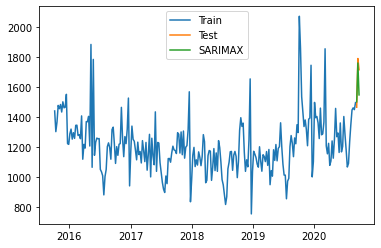

Current product:  16409
all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s

IndexError: list index out of range

In [215]:
# herifra og nedover

main_method(productMix,horizons,params)

9205, 14760, 15112,  14540, 14251, 14490, 10017



selected productGroup:  [9205, 14760, 15112, 14540, 14251, 14490, 10017]
selected horizon:  3
Current product:  9205
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99067D+00    |proj g|=  6.15533D-01


 This problem is unconstrained.



At iterate    5    f=  7.61350D+00    |proj g|=  2.51200D-02

At iterate   10    f=  7.51399D+00    |proj g|=  4.01368D-02

At iterate   15    f=  7.50960D+00    |proj g|=  5.04863D-02

At iterate   20    f=  7.49972D+00    |proj g|=  6.14161D-03

At iterate   25    f=  7.49949D+00    |proj g|=  3.07394D-03

At iterate   30    f=  7.49017D+00    |proj g|=  5.31002D-02

At iterate   35    f=  7.45077D+00    |proj g|=  7.63215D-03

At iterate   40    f=  7.45066D+00    |proj g|=  1.67673D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     58      1     0     0   2.098D-05   7.451D+00
  F =   7.45065644900

 This problem is unconstrained.



At iterate    5    f=  7.55684D+00    |proj g|=  1.78919D-03

At iterate   10    f=  7.55614D+00    |proj g|=  2.37122D-02

At iterate   15    f=  7.52913D+00    |proj g|=  8.60051D-02

At iterate   20    f=  7.52537D+00    |proj g|=  3.38872D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   5.825D-05   7.525D+00
  F =   7.5253657237599665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  167.2783118081806
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate    5    f=  7.55983D+00    |proj g|=  5.56146D-04

At iterate   10    f=  7.55961D+00    |proj g|=  1.42336D-02

At iterate   15    f=  7.54462D+00    |proj g|=  9.93262D-02

At iterate   20    f=  7.53333D+00    |proj g|=  6.20018D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     23      1     0     0   5.952D-06   7.533D+00
  F =   7.5333271533828094     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  248.2335396291993
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate    5    f=  7.58738D+00    |proj g|=  1.36980D-03

At iterate   10    f=  7.58726D+00    |proj g|=  6.38123D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     18      1     0     0   1.100D-05   7.587D+00
  F =   7.5872323578099836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  168.2436975191644
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07852D+00    |proj g|=  6.95655D-01


 This problem is unconstrained.



At iterate    5    f=  7.62999D+00    |proj g|=  3.70957D-02

At iterate   10    f=  7.50978D+00    |proj g|=  9.65138D-04

At iterate   15    f=  7.49893D+00    |proj g|=  2.94505D-02

At iterate   20    f=  7.49849D+00    |proj g|=  1.75554D-03

At iterate   25    f=  7.49747D+00    |proj g|=  2.72249D-02

At iterate   30    f=  7.46413D+00    |proj g|=  1.28195D-01

At iterate   35    f=  7.45318D+00    |proj g|=  2.53476D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     53      1     0     0   1.310D-05   7.453D+00
  F =   7.4531815223652256     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88797D+00    |proj g|=  4.25486D-01

At iterate    5    f=  7.66950D+00    |proj g|=  2.66977D-02

At iterate   10    f=  7.59726D+00    |proj g|=  8.75556D-02

At iterate   15    f=  7.59019D+00    |proj g|=  8.97059D-04

At iterate   20    f=  7.57596D+00    |proj g|=  1.64118D-01

At iterate   25    f=  7.55810D+00    |proj g|=  3.88161D-03

At iterate   30    f=  7.55799D+00    |proj g|=  3.32840D-03

At iterate   35    f=  7.55404D+00    |proj g|=  6.59887D-02

At iterate   40    f=  7.47388D+00    |proj g|=  8.76593D-02

At iterate   45    f=  7.46002D+00    |proj g|=  3.39683D-02

At iterate   50    f=  7.45811D+00    |proj g|=  4.44486D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.59117D+00    |proj g|=  1.26287D-01

At iterate    5    f=  7.55735D+00    |proj g|=  7.98145D-03

At iterate   10    f=  7.55602D+00    |proj g|=  9.41096D-04

At iterate   15    f=  7.55475D+00    |proj g|=  1.67486D-02

At iterate   20    f=  7.48449D+00    |proj g|=  1.41560D-01

At iterate   25    f=  7.45964D+00    |proj g|=  1.25478D-02

At iterate   30    f=  7.45568D+00    |proj g|=  1.35718D-02

At iterate   35    f=  7.45544D+00    |proj g|=  7.23867D-04

At iterate   40    f=  7.45530D+00    |proj g|=  9.19489D-03

At iterate   45    f=  7.45521D+00    |proj g|=  8.17894D-04

At iterate   50    f=  7.45514D+00    |proj g|=  3.56890D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.66576D+00    |proj g|=  1.27067D-02

At iterate   10    f=  7.58811D+00    |proj g|=  1.48196D-02

At iterate   15    f=  7.58772D+00    |proj g|=  6.10149D-03

At iterate   20    f=  7.56442D+00    |proj g|=  3.57317D-02

At iterate   25    f=  7.56187D+00    |proj g|=  4.81031D-03

At iterate   30    f=  7.56086D+00    |proj g|=  2.59306D-02

At iterate   35    f=  7.49359D+00    |proj g|=  2.23640D-01

At iterate   40    f=  7.45898D+00    |proj g|=  6.07077D-03

At iterate   45    f=  7.45737D+00    |proj g|=  6.69388D-03

At iterate   50    f=  7.45694D+00    |proj g|=  1.39560D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.94833D+00    |proj g|=  4.81606D-01

At iterate    5    f=  7.66823D+00    |proj g|=  2.07744D-02

At iterate   10    f=  7.59187D+00    |proj g|=  6.49496D-02

At iterate   15    f=  7.58794D+00    |proj g|=  7.57166D-03

At iterate   20    f=  7.58776D+00    |proj g|=  2.52245D-03

At iterate   25    f=  7.57941D+00    |proj g|=  1.07776D-01

At iterate   30    f=  7.55658D+00    |proj g|=  2.02366D-02

At iterate   35    f=  7.55612D+00    |proj g|=  1.00216D-03

At iterate   40    f=  7.55134D+00    |proj g|=  3.62617D-02

At iterate   45    f=  7.49077D+00    |proj g|=  6.89699D-02

At iterate   50    f=  7.46514D+00    |proj g|=  3.70912D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62676D+00    |proj g|=  1.33509D-01

At iterate    5    f=  7.60522D+00    |proj g|=  8.26959D-04

At iterate   10    f=  7.60466D+00    |proj g|=  1.17274D-02

At iterate   15    f=  7.54161D+00    |proj g|=  2.37692D-01

At iterate   20    f=  7.51597D+00    |proj g|=  1.12255D-02

At iterate   25    f=  7.51575D+00    |proj g|=  1.39426D-04

At iterate   30    f=  7.51572D+00    |proj g|=  2.77016D-03

At iterate   35    f=  7.51566D+00    |proj g|=  5.72788D-04

At iterate   40    f=  7.51563D+00    |proj g|=  1.75226D-03

At iterate   45    f=  7.51534D+00    |proj g|=  7.60309D-03

At iterate   50    f=  7.51446D+00    |proj g|=  3.81246D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.63292D+00    |proj g|=  1.32189D-01

At iterate    5    f=  7.57397D+00    |proj g|=  1.65030D-02

At iterate   10    f=  7.57205D+00    |proj g|=  2.76198D-02

At iterate   15    f=  7.54365D+00    |proj g|=  3.85941D-02

At iterate   20    f=  7.54069D+00    |proj g|=  9.62450D-04

At iterate   25    f=  7.54023D+00    |proj g|=  1.86762D-02

At iterate   30    f=  7.49696D+00    |proj g|=  1.79221D-01

At iterate   35    f=  7.44524D+00    |proj g|=  1.03406D-01

At iterate   40    f=  7.44100D+00    |proj g|=  9.96712D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.52852D+00    |proj g|=  1.05680D-01

At iterate    5    f=  7.49490D+00    |proj g|=  4.80953D-03

At iterate   10    f=  7.48914D+00    |proj g|=  5.81366D-02

At iterate   15    f=  7.47550D+00    |proj g|=  1.38122D-03

At iterate   20    f=  7.47539D+00    |proj g|=  4.23690D-03

At iterate   25    f=  7.46266D+00    |proj g|=  5.97803D-02

At iterate   30    f=  7.43088D+00    |proj g|=  6.08763D-02

At iterate   35    f=  7.42911D+00    |proj g|=  2.33873D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53235D+00    |proj g|=  1.63289D-01

At iterate    5    f=  7.49555D+00    |proj g|=  4.67099D-03

At iterate   10    f=  7.48483D+00    |proj g|=  8.30199D-02

At iterate   15    f=  7.47726D+00    |proj g|=  4.71074D-03

At iterate   20    f=  7.47721D+00    |proj g|=  4.23074D-03

At iterate   25    f=  7.47330D+00    |proj g|=  5.28738D-02

At iterate   30    f=  7.44168D+00    |proj g|=  1.52728D-02

At iterate   35    f=  7.43507D+00    |proj g|=  2.32911D-02

At iterate   40    f=  7.43442D+00    |proj g|=  2.83603D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.59117D+00    |proj g|=  1.26287D-01

At iterate    5    f=  7.55498D+00    |proj g|=  9.97597D-03

At iterate   10    f=  7.55212D+00    |proj g|=  9.58582D-04

At iterate   15    f=  7.55196D+00    |proj g|=  6.22415D-03

At iterate   20    f=  7.53236D+00    |proj g|=  8.90456D-02

At iterate   25    f=  7.45597D+00    |proj g|=  2.89264D-02

At iterate   30    f=  7.45069D+00    |proj g|=  8.05837D-03

At iterate   35    f=  7.44810D+00    |proj g|=  2.95865D-02

At iterate   40    f=  7.44607D+00    |proj g|=  9.89922D-04

At iterate   45    f=  7.44605D+00    |proj g|=  4.04759D-04

At iterate   50    f=  7.44594D+00    |proj g|=  1.66058D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.48364D+00    |proj g|=  3.29757D-03

At iterate   10    f=  7.48330D+00    |proj g|=  8.29904D-04

At iterate   15    f=  7.48257D+00    |proj g|=  2.78072D-02

At iterate   20    f=  7.44914D+00    |proj g|=  6.35711D-02

At iterate   25    f=  7.44210D+00    |proj g|=  4.70616D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     30      1     0     0   3.215D-06   7.442D+00
  F =   7.4420988616902859     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  247.6165190694938
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate    5    f=  7.53302D+00    |proj g|=  6.19001D-03

At iterate   10    f=  7.53284D+00    |proj g|=  3.27366D-03

At iterate   15    f=  7.52087D+00    |proj g|=  2.86274D-02

At iterate   20    f=  7.47612D+00    |proj g|=  2.35427D-02

At iterate   25    f=  7.47556D+00    |proj g|=  1.77097D-04

At iterate   30    f=  7.47554D+00    |proj g|=  7.07649D-03

At iterate   35    f=  7.47397D+00    |proj g|=  6.77249D-02

At iterate   40    f=  7.46658D+00    |proj g|=  2.18446D-02

At iterate   45    f=  7.46613D+00    |proj g|=  4.49548D-03

At iterate   50    f=  7.46529D+00    |proj g|=  8.99533D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55421D+00    |proj g|=  6.15962D-02

At iterate    5    f=  7.53302D+00    |proj g|=  6.19001D-03

At iterate   10    f=  7.53284D+00    |proj g|=  3.27366D-03

At iterate   15    f=  7.52087D+00    |proj g|=  2.86274D-02

At iterate   20    f=  7.47612D+00    |proj g|=  2.35427D-02

At iterate   25    f=  7.47556D+00    |proj g|=  1.77097D-04

At iterate   30    f=  7.47554D+00    |proj g|=  7.07649D-03

At iterate   35    f=  7.47397D+00    |proj g|=  6.77249D-02

At iterate   40    f=  7.46658D+00    |proj g|=  2.18446D-02

At iterate   45    f=  7.46613D+00    |proj g|=  4.49548D-03

At iterate   50    f=  7.46529D+00    |proj g|=  8.99533D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

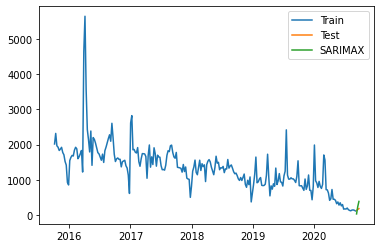

Current product:  14760
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.55608D+00    |proj g|=  1.43149D-01


 This problem is unconstrained.



At iterate    5    f=  8.52024D+00    |proj g|=  1.34166D-02

At iterate   10    f=  8.51964D+00    |proj g|=  3.96222D-04

At iterate   15    f=  8.51945D+00    |proj g|=  7.90206D-03

At iterate   20    f=  8.50692D+00    |proj g|=  5.14283D-02

At iterate   25    f=  8.49834D+00    |proj g|=  1.17648D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     31      1     0     0   8.719D-06   8.498D+00
  F =   8.4983119490337256     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1451.0702703604927


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.60096D+00    |proj g|=  1.46709D-01

At iterate    5    f=  8.56928D+00    |proj g|=  5.65599D-04

At iterate   10    f=  8.56928D+00    |proj g|=  6.99758D-04

At iterate   15    f=  8.56911D+00    |proj g|=  9.38023D-03

At iterate   20    f=  8.56361D+00    |proj g|=  4.40583D-02

At iterate   25    f=  8.55922D+00    |proj g|=  1.65652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     29      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.57339D+00    |proj g|=  2.61750D-02

At iterate    5    f=  8.57232D+00    |proj g|=  1.23728D-04

At iterate   10    f=  8.57229D+00    |proj g|=  3.56115D-03

At iterate   15    f=  8.56934D+00    |proj g|=  2.87651D-02

At iterate   20    f=  8.56353D+00    |proj g|=  5.36513D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     25      1     0     0   3.943D-06   8.564D+00
  F =   8.5635296243136754     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  8.56785D+00    |proj g|=  1.40035D-03

At iterate   10    f=  8.56720D+00    |proj g|=  2.55664D-02

At iterate   15    f=  8.56249D+00    |proj g|=  9.67296D-05

At iterate   20    f=  8.56245D+00    |proj g|=  5.17554D-03

At iterate   25    f=  8.56070D+00    |proj g|=  1.82869D-02

At iterate   30    f=  8.56036D+00    |proj g|=  4.21476D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     37      1     0     0   4.215D-06   8.560D+00
  F =   8.5603607687538243     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  391.49874574975144


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52950D+00    |proj g|=  3.25997D-02

At iterate    5    f=  8.52440D+00    |proj g|=  3.60293D-03

At iterate   10    f=  8.52435D+00    |proj g|=  5.22333D-04

At iterate   15    f=  8.52427D+00    |proj g|=  8.81302D-03

At iterate   20    f=  8.51623D+00    |proj g|=  7.36390D-02

At iterate   25    f=  8.50671D+00    |proj g|=  9.49310D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  8.58155D+00    |proj g|=  7.01125D-03

At iterate   10    f=  8.58117D+00    |proj g|=  1.18125D-04

At iterate   15    f=  8.58117D+00    |proj g|=  1.11520D-03

At iterate   20    f=  8.58082D+00    |proj g|=  1.41771D-02

At iterate   25    f=  8.57330D+00    |proj g|=  2.98331D-02

At iterate   30    f=  8.57223D+00    |proj g|=  3.87720D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     36      1     0     0   2.986D-05   8.572D+00
  F =   8.5722285419971449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  781.9982160830496


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69050D+00    |proj g|=  3.11750D-01

At iterate    5    f=  8.57045D+00    |proj g|=  1.23452D-02

At iterate   10    f=  8.56778D+00    |proj g|=  1.19599D-03

At iterate   15    f=  8.56774D+00    |proj g|=  1.81084D-04

At iterate   20    f=  8.56768D+00    |proj g|=  1.61735D-03

At iterate   25    f=  8.55478D+00    |proj g|=  5.61888D-02

At iterate   30    f=  8.52830D+00    |proj g|=  2.79913D-02

At iterate   35    f=  8.51707D+00    |proj g|=  3.27478D-03

At iterate   40    f=  8.51703D+00    |proj g|=  3.09273D-04

At iterate   45    f=  8.51699D+00    |proj g|=  3.75427D-03

At iterate   50    f=  8.51674D+00    |proj g|=  1.57847D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.58539D+00    |proj g|=  1.24167D-02

At iterate   10    f=  8.58400D+00    |proj g|=  1.63682D-04

At iterate   15    f=  8.58331D+00    |proj g|=  2.03933D-02

At iterate   20    f=  8.54560D+00    |proj g|=  3.23173D-02

At iterate   25    f=  8.54264D+00    |proj g|=  3.17266D-03

At iterate   30    f=  8.54250D+00    |proj g|=  1.89346D-03

At iterate   35    f=  8.54191D+00    |proj g|=  6.20736D-04

At iterate   40    f=  8.54181D+00    |proj g|=  1.98903D-04

At iterate   45    f=  8.54177D+00    |proj g|=  2.93486D-04

At iterate   50    f=  8.54159D+00    |proj g|=  2.00593D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61923D+00    |proj g|=  1.17369D-01

At iterate    5    f=  8.58434D+00    |proj g|=  6.19811D-03

At iterate   10    f=  8.58266D+00    |proj g|=  4.96955D-03

At iterate   15    f=  8.57670D+00    |proj g|=  7.98009D-03

At iterate   20    f=  8.57552D+00    |proj g|=  1.71929D-03

At iterate   25    f=  8.57519D+00    |proj g|=  1.31706D-03

At iterate   30    f=  8.57478D+00    |proj g|=  1.07042D-02

At iterate   35    f=  8.52495D+00    |proj g|=  1.00204D-02

At iterate   40    f=  8.52471D+00    |proj g|=  1.30729D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.63790D+00    |proj g|=  1.19337D-01

At iterate    5    f=  8.60243D+00    |proj g|=  3.46300D-03

At iterate   10    f=  8.60212D+00    |proj g|=  1.19451D-03

At iterate   15    f=  8.60206D+00    |proj g|=  1.94437D-03

At iterate   20    f=  8.60089D+00    |proj g|=  2.23667D-02

At iterate   25    f=  8.56607D+00    |proj g|=  7.12957D-02

At iterate   30    f=  8.55955D+00    |proj g|=  1.77117D-03

At iterate   35    f=  8.55690D+00    |proj g|=  2.50911D-04

At iterate   40    f=  8.55664D+00    |proj g|=  5.06198D-04

At iterate   45    f=  8.55653D+00    |proj g|=  1.04611D-04

At iterate   50    f=  8.55638D+00    |proj g|=  2.61789D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.57745D+00    |proj g|=  1.34073D-02

At iterate   10    f=  8.57459D+00    |proj g|=  3.49868D-03

At iterate   15    f=  8.57458D+00    |proj g|=  3.60198D-04

At iterate   20    f=  8.57453D+00    |proj g|=  5.18210D-03

At iterate   25    f=  8.57058D+00    |proj g|=  4.15663D-02

At iterate   30    f=  8.56615D+00    |proj g|=  4.48793D-03

At iterate   35    f=  8.56607D+00    |proj g|=  5.14441D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     42      1     0     0   1.433D-05   8.566D+00
  F =   8.5660680500198545     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.52291D+00    |proj g|=  2.46994D-02

At iterate   10    f=  8.51931D+00    |proj g|=  3.61938D-04

At iterate   15    f=  8.51930D+00    |proj g|=  5.66402D-04

At iterate   20    f=  8.51908D+00    |proj g|=  8.05363D-03

At iterate   25    f=  8.51005D+00    |proj g|=  1.53210D-02

At iterate   30    f=  8.49913D+00    |proj g|=  2.31643D-02

At iterate   35    f=  8.49827D+00    |proj g|=  1.07973D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     45      1     0     0   4.399D-06   8.498D+00
  F =   8.4982656775668772     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  8.52692D+00    |proj g|=  2.73912D-02

At iterate   10    f=  8.52517D+00    |proj g|=  1.73549D-04

At iterate   15    f=  8.52515D+00    |proj g|=  2.38032D-03

At iterate   20    f=  8.52336D+00    |proj g|=  2.68834D-02

At iterate   25    f=  8.51269D+00    |proj g|=  1.95212D-02

At iterate   30    f=  8.50798D+00    |proj g|=  4.04465D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     38      1     0     0   2.197D-05   8.508D+00
  F =   8.5079796623873154     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1455.3536635652902


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69050D+00    |proj g|=  3.11750D-01

At iterate    5    f=  8.56967D+00    |proj g|=  1.03760D-02

At iterate   10    f=  8.56814D+00    |proj g|=  5.91313D-03

At iterate   15    f=  8.56773D+00    |proj g|=  1.47909D-03

At iterate   20    f=  8.56771D+00    |proj g|=  1.93634D-04

At iterate   25    f=  8.56755D+00    |proj g|=  7.07730D-03

At iterate   30    f=  8.55719D+00    |proj g|=  2.73957D-02

At iterate   35    f=  8.53253D+00    |proj g|=  1.83503D-02

At iterate   40    f=  8.52172D+00    |proj g|=  1.54468D-02

At iterate   45    f=  8.51750D+00    |proj g|=  3.02625D-04

At iterate   50    f=  8.51744D+00    |proj g|=  5.16921D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.51860D+00    |proj g|=  5.38764D-03

At iterate   10    f=  8.51745D+00    |proj g|=  1.70633D-04

At iterate   15    f=  8.51655D+00    |proj g|=  2.01759D-02

At iterate   20    f=  8.50168D+00    |proj g|=  6.77522D-03

At iterate   25    f=  8.50107D+00    |proj g|=  3.50945D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     31      1     0     0   1.966D-06   8.501D+00
  F =   8.5010738333479665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  1496.5438092482773


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.56549D+00    |proj g|=  1.43960D-01

At iterate    5    f=  8.53144D+00    |proj g|=  1.71915D-04

At iterate   10    f=  8.53142D+00    |proj g|=  1.42368D-03

At iterate   15    f=  8.53023D+00    |proj g|=  1.39028D-02

At iterate   20    f=  8.51566D+00    |proj g|=  2.36421D-02

At iterate   25    f=  8.51272D+00    |proj g|=  1.82198D-02

At iterate   30    f=  8.50892D+00    |proj g|=  2.09442D-03

At iterate   35    f=  8.50841D+00    |proj g|=  2.74314D-04

At iterate   40    f=  8.50833D+00    |proj g|=  3.37597D-04

At iterate   45    f=  8.50831D+00    |proj g|=  2.68157D-05

At iterate   50    f=  8.50584D+00    |proj g|=  6.65791D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.56785D+00    |proj g|=  1.40035D-03

At iterate   10    f=  8.56720D+00    |proj g|=  2.55664D-02

At iterate   15    f=  8.56249D+00    |proj g|=  9.67296D-05

At iterate   20    f=  8.56245D+00    |proj g|=  5.17554D-03

At iterate   25    f=  8.56070D+00    |proj g|=  1.82869D-02

At iterate   30    f=  8.56036D+00    |proj g|=  4.21476D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     37      1     0     0   4.215D-06   8.560D+00
  F =   8.5603607687538243     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

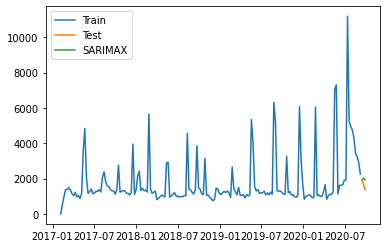

Current product:  15112


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48943D+00    |proj g|=  3.18236D-01

At iterate    5    f=  8.39821D+00    |proj g|=  8.58902D-03

At iterate   10    f=  8.39622D+00    |proj g|=  2.99798D-04

At iterate   15    f=  8.39619D+00    |proj g|=  3.46094D-03

At iterate   20    f=  8.39245D+00    |proj g|=  3.95267D-02

At iterate   25    f=  8.33382D+00    |proj g|=  9.64418D-02

At iterate   30    f=  8.32203D+00    |proj g|=  1.32999D-03

At iterate   35    f=  8.32134D+00    |proj g|=  1.45966D-03

At iterate   40    f=  8.32109D+00    |proj g|=  1.24146D-03

At iterate   45    f=  8.32104D+00    |proj g|=  6.80636D-04

At iterate   50    f=  8.32097D+00    |proj g|=  1.48790D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51167D+00    |proj g|=  3.44813D-01

At iterate    5    f=  8.41486D+00    |proj g|=  8.27809D-03

At iterate   10    f=  8.41467D+00    |proj g|=  2.50604D-04

At iterate   15    f=  8.41451D+00    |proj g|=  8.61413D-03

At iterate   20    f=  8.39714D+00    |proj g|=  8.35827D-02

At iterate   25    f=  8.37417D+00    |proj g|=  1.46590D-02

At iterate   30    f=  8.36963D+00    |proj g|=  9.22083D-03

At iterate   35    f=  8.36815D+00    |proj g|=  1.56042D-03

At iterate   40    f=  8.36779D+00    |proj g|=  5.73014D-04

At iterate   45    f=  8.36772D+00    |proj g|=  3.37947D-04

At iterate   50    f=  8.36746D+00    |proj g|=  7.61099D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41779D+00    |proj g|=  2.07631D-02

At iterate    5    f=  8.41667D+00    |proj g|=  5.37247D-04

At iterate   10    f=  8.41639D+00    |proj g|=  1.04988D-02

At iterate   15    f=  8.40579D+00    |proj g|=  4.36766D-02

At iterate   20    f=  8.38163D+00    |proj g|=  6.48086D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   2.090D-05   8.382D+00
  F =   8.3815483556232593     

CONVERG

 This problem is unconstrained.


rmse:  648.1496554661036


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.40600D+00    |proj g|=  4.58051D-02

At iterate    5    f=  8.40276D+00    |proj g|=  6.59907D-03

At iterate   10    f=  8.40270D+00    |proj g|=  3.14558D-04

At iterate   15    f=  8.40247D+00    |proj g|=  8.12112D-03

At iterate   20    f=  8.37150D+00    |proj g|=  1.03288D-01

At iterate   25    f=  8.35762D+00    |proj g|=  1.88351D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51734D+00    |proj g|=  7.23048D-02

At iterate    5    f=  8.46312D+00    |proj g|=  1.85590D-02

At iterate   10    f=  8.46085D+00    |proj g|=  2.33245D-04

At iterate   15    f=  8.46076D+00    |proj g|=  3.09388D-03

At iterate   20    f=  8.44869D+00    |proj g|=  4.15650D-02

At iterate   25    f=  8.41001D+00    |proj g|=  1.11512D-02

At iterate   30    f=  8.40671D+00    |proj g|=  2.87033D-03

At iterate   35    f=  8.40597D+00    |proj g|=  9.12637D-03

At iterate   40    f=  8.40578D+00    |proj g|=  3.47392D-04

At iterate   45    f=  8.40574D+00    |proj g|=  5.93070D-04

At iterate   50    f=  8.40568D+00    |proj g|=  8.11079D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.43521D+00    |proj g|=  4.10820D-03

At iterate   10    f=  8.43482D+00    |proj g|=  2.57611D-04

At iterate   15    f=  8.43479D+00    |proj g|=  1.89679D-03

At iterate   20    f=  8.43209D+00    |proj g|=  1.34250D-02

At iterate   25    f=  8.38542D+00    |proj g|=  1.84172D-02

At iterate   30    f=  8.37696D+00    |proj g|=  1.12657D-02

At iterate   35    f=  8.36373D+00    |proj g|=  1.58200D-02

At iterate   40    f=  8.36031D+00    |proj g|=  5.73471D-04

At iterate   45    f=  8.35971D+00    |proj g|=  1.77216D-03

At iterate   50    f=  8.35959D+00    |proj g|=  1.80570D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.46050D+00    |proj g|=  1.50988D-02

At iterate   10    f=  8.45802D+00    |proj g|=  1.18019D-03

At iterate   15    f=  8.45799D+00    |proj g|=  1.06603D-03

At iterate   20    f=  8.45720D+00    |proj g|=  1.58839D-02

At iterate   25    f=  8.40946D+00    |proj g|=  3.93805D-02

At iterate   30    f=  8.39169D+00    |proj g|=  4.49271D-03

At iterate   35    f=  8.38841D+00    |proj g|=  8.22725D-03

At iterate   40    f=  8.38749D+00    |proj g|=  2.40294D-03

At iterate   45    f=  8.38734D+00    |proj g|=  2.39127D-04

At iterate   50    f=  8.38724D+00    |proj g|=  8.32803D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54148D+00    |proj g|=  2.62412D-01

At iterate    5    f=  8.46238D+00    |proj g|=  1.50267D-02

At iterate   10    f=  8.45669D+00    |proj g|=  1.80363D-03

At iterate   15    f=  8.45661D+00    |proj g|=  9.08091D-04

At iterate   20    f=  8.45599D+00    |proj g|=  9.78693D-03

At iterate   25    f=  8.41415D+00    |proj g|=  7.76720D-02

At iterate   30    f=  8.39454D+00    |proj g|=  1.14285D-02

At iterate   35    f=  8.38952D+00    |proj g|=  2.81644D-02

At iterate   40    f=  8.38236D+00    |proj g|=  3.44763D-03

At iterate   45    f=  8.38098D+00    |proj g|=  1.95115D-03

At iterate   50    f=  8.38060D+00    |proj g|=  3.14420D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.46812D+00    |proj g|=  3.06286D-03

At iterate   10    f=  8.46791D+00    |proj g|=  2.35259D-04

At iterate   15    f=  8.46773D+00    |proj g|=  4.79420D-03

At iterate   20    f=  8.40956D+00    |proj g|=  4.82752D-02

At iterate   25    f=  8.40365D+00    |proj g|=  5.12185D-03

At iterate   30    f=  8.40094D+00    |proj g|=  1.02956D-03

At iterate   35    f=  8.40031D+00    |proj g|=  2.79771D-03

At iterate   40    f=  8.40013D+00    |proj g|=  3.60290D-04

At iterate   45    f=  8.40009D+00    |proj g|=  3.29202D-05

At iterate   50    f=  8.39920D+00    |proj g|=  1.72283D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.44615D+00    |proj g|=  2.39920D-02

At iterate   10    f=  8.44395D+00    |proj g|=  5.07469D-04

At iterate   15    f=  8.44394D+00    |proj g|=  6.48045D-04

At iterate   20    f=  8.44368D+00    |proj g|=  1.08066D-02

At iterate   25    f=  8.41342D+00    |proj g|=  1.03436D-01

At iterate   30    f=  8.38195D+00    |proj g|=  2.96162D-02

At iterate   35    f=  8.37881D+00    |proj g|=  1.79155D-02

At iterate   40    f=  8.37689D+00    |proj g|=  2.75196D-03

At iterate   45    f=  8.37663D+00    |proj g|=  3.16960D-03

At iterate   50    f=  8.37662D+00    |proj g|=  1.96416D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.39368D+00    |proj g|=  7.77501D-03

At iterate   10    f=  8.39299D+00    |proj g|=  4.51155D-03

At iterate   15    f=  8.39275D+00    |proj g|=  5.07453D-04

At iterate   20    f=  8.39260D+00    |proj g|=  8.60648D-03

At iterate   25    f=  8.37547D+00    |proj g|=  9.09940D-02

At iterate   30    f=  8.35146D+00    |proj g|=  4.15260D-03

At iterate   35    f=  8.34774D+00    |proj g|=  1.71304D-02

At iterate   40    f=  8.33398D+00    |proj g|=  7.72902D-02

At iterate   45    f=  8.31970D+00    |proj g|=  1.97189D-03

At iterate   50    f=  8.31969D+00    |proj g|=  5.94869D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.39680D+00    |proj g|=  1.97380D-02

At iterate    5    f=  8.39502D+00    |proj g|=  1.16695D-02

At iterate   10    f=  8.39448D+00    |proj g|=  2.55167D-04

At iterate   15    f=  8.39442D+00    |proj g|=  5.89052D-03

At iterate   20    f=  8.38731D+00    |proj g|=  6.30745D-02

At iterate   25    f=  8.35715D+00    |proj g|=  2.92216D-03

At iterate   30    f=  8.35699D+00    |proj g|=  7.29141D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.50502D+00    |proj g|=  2.57407D-01

At iterate    5    f=  8.43545D+00    |proj g|=  6.36744D-03

At iterate   10    f=  8.43398D+00    |proj g|=  1.93049D-03

At iterate   15    f=  8.43396D+00    |proj g|=  6.73296D-04

At iterate   20    f=  8.43368D+00    |proj g|=  4.76876D-03

At iterate   25    f=  8.38918D+00    |proj g|=  8.20395D-02

At iterate   30    f=  8.36741D+00    |proj g|=  1.17571D-02

At iterate   35    f=  8.35895D+00    |proj g|=  1.38398D-02

At iterate   40    f=  8.35716D+00    |proj g|=  9.26356D-03

At iterate   45    f=  8.35638D+00    |proj g|=  6.97767D-03

At iterate   50    f=  8.35609D+00    |proj g|=  3.56696D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.37178D+00    |proj g|=  5.37407D-03

At iterate   10    f=  8.37149D+00    |proj g|=  4.06865D-04

At iterate   15    f=  8.37099D+00    |proj g|=  1.14603D-02

At iterate   20    f=  8.34965D+00    |proj g|=  4.98964D-02

At iterate   25    f=  8.32721D+00    |proj g|=  3.66228D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     31      1     0     0   1.906D-05   8.327D+00
  F =   8.3271984362955127     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  323.4357037959086


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49505D+00    |proj g|=  3.23426D-01

At iterate    5    f=  8.40457D+00    |proj g|=  1.01295D-03

At iterate   10    f=  8.40455D+00    |proj g|=  1.21205D-03

At iterate   15    f=  8.40267D+00    |proj g|=  1.46331D-02

At iterate   20    f=  8.36990D+00    |proj g|=  1.32699D-02

At iterate   25    f=  8.35059D+00    |proj g|=  1.36477D-02

At iterate   30    f=  8.34716D+00    |proj g|=  1.20422D-03

At iterate   35    f=  8.34652D+00    |proj g|=  2.02265D-04

At iterate   40    f=  8.34638D+00    |proj g|=  2.13557D-03

At iterate   45    f=  8.34632D+00    |proj g|=  1.20261D-04

At iterate   50    f=  8.33451D+00    |proj g|=  5.97821D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49505D+00    |proj g|=  3.23426D-01

At iterate    5    f=  8.40457D+00    |proj g|=  1.01295D-03

At iterate   10    f=  8.40455D+00    |proj g|=  1.21205D-03

At iterate   15    f=  8.40267D+00    |proj g|=  1.46331D-02

At iterate   20    f=  8.36990D+00    |proj g|=  1.32699D-02

At iterate   25    f=  8.35059D+00    |proj g|=  1.36477D-02

At iterate   30    f=  8.34716D+00    |proj g|=  1.20422D-03

At iterate   35    f=  8.34652D+00    |proj g|=  2.02265D-04

At iterate   40    f=  8.34638D+00    |proj g|=  2.13557D-03

At iterate   45    f=  8.34632D+00    |proj g|=  1.20261D-04

At iterate   50    f=  8.33451D+00    |proj g|=  5.97821D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

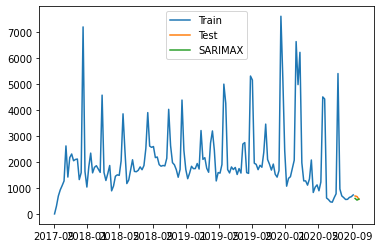

Current product:  14540


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.70855D+00    |proj g|=  2.81797D-01

At iterate    5    f=  6.54642D+00    |proj g|=  4.55792D-02

At iterate   10    f=  6.54345D+00    |proj g|=  1.67574D-03

At iterate   15    f=  6.54193D+00    |proj g|=  1.27139D-02

At iterate   20    f=  6.52102D+00    |proj g|=  1.53589D-02

At iterate   25    f=  6.51989D+00    |proj g|=  1.09606D-02

At iterate   30    f=  6.51984D+00    |proj g|=  1.01123D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77007D+00    |proj g|=  3.03904D-01

At iterate    5    f=  6.62271D+00    |proj g|=  4.11618D-03

At iterate   10    f=  6.62259D+00    |proj g|=  1.31102D-02

At iterate   15    f=  6.61347D+00    |proj g|=  1.46478D-01

At iterate   20    f=  6.58449D+00    |proj g|=  1.13595D-02

At iterate   25    f=  6.58438D+00    |proj g|=  1.68265D-02

At iterate   30    f=  6.58395D+00    |proj g|=  5.09503D-03

At iterate   35    f=  6.58387D+00    |proj g|=  8.26988D-03

At iterate   40    f=  6.58384D+00    |proj g|=  7.26294D-04

At iterate   45    f=  6.58383D+00    |proj g|=  7.20103D-04

At iterate   50    f=  6.58371D+00    |proj g|=  1.81732D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.64757D+00    |proj g|=  3.14865D-03

At iterate   10    f=  6.64755D+00    |proj g|=  9.42262D-03

At iterate   15    f=  6.64572D+00    |proj g|=  9.47178D-02

At iterate   20    f=  6.64129D+00    |proj g|=  1.90399D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     25      1     0     0   1.027D-05   6.641D+00
  F =   6.6412875603121497     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  103.15470559825815
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exac

 This problem is unconstrained.



At iterate    5    f=  6.61065D+00    |proj g|=  3.68794D-04

At iterate   10    f=  6.61062D+00    |proj g|=  4.18827D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   5.942D-06   6.611D+00
  F =   6.6105759752471682     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  136.15684509373202


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60164D+00    |proj g|=  2.13813D-01

At iterate    5    f=  6.57358D+00    |proj g|=  2.78838D-02

At iterate   10    f=  6.57188D+00    |proj g|=  9.83197D-04

At iterate   15    f=  6.57178D+00    |proj g|=  2.38493D-02

At iterate   20    f=  6.56764D+00    |proj g|=  7.81557D-02

At iterate   25    f=  6.56609D+00    |proj g|=  1.08760D-03

At iterate   30    f=  6.56608D+00    |proj g|=  1.49519D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94246D+00    |proj g|=  2.53072D-01

At iterate    5    f=  6.87187D+00    |proj g|=  2.89649D-02

At iterate   10    f=  6.86806D+00    |proj g|=  1.60887D-03

At iterate   15    f=  6.86770D+00    |proj g|=  3.47217D-02

At iterate   20    f=  6.85865D+00    |proj g|=  3.06465D-02

At iterate   25    f=  6.85849D+00    |proj g|=  4.52811D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     29      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14214D+00    |proj g|=  4.19755D-01

At iterate    5    f=  6.87788D+00    |proj g|=  1.74522D-02

At iterate   10    f=  6.86923D+00    |proj g|=  4.34770D-03

At iterate   15    f=  6.84227D+00    |proj g|=  4.47539D-02

At iterate   20    f=  6.83393D+00    |proj g|=  1.11736D-02

At iterate   25    f=  6.83318D+00    |proj g|=  4.33278D-03

At iterate   30    f=  6.83304D+00    |proj g|=  3.49050D-04

At iterate   35    f=  6.83299D+00    |proj g|=  1.09982D-03

At iterate   40    f=  6.80755D+00    |proj g|=  1.45939D-02
  ys=-1.802E-01  -gs= 1.227E-03 BFGS update SKIPPED

At iterate   45    f=  6.79985D+00    |proj g|=  8.60721D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy search

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.90734D+00    |proj g|=  2.02271D-01

At iterate    5    f=  6.84323D+00    |proj g|=  5.15598D-03

At iterate   10    f=  6.84253D+00    |proj g|=  2.99787D-03

At iterate   15    f=  6.82574D+00    |proj g|=  8.63135D-02

At iterate   20    f=  6.78797D+00    |proj g|=  4.25069D-03

At iterate   25    f=  6.78760D+00    |proj g|=  1.14864D-03

At iterate   30    f=  6.78750D+00    |proj g|=  3.87460D-03

At iterate   35    f=  6.78741D+00    |proj g|=  1.45078D-03

At iterate   40    f=  6.78739D+00    |proj g|=  9.20936D-04

At iterate   45    f=  6.78738D+00    |proj g|=  2.44483D-04

At iterate   50    f=  6.78737D+00    |proj g|=  1.27977D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.84577D+00    |proj g|=  3.13446D-02

At iterate   10    f=  6.84242D+00    |proj g|=  3.51467D-03

At iterate   15    f=  6.84174D+00    |proj g|=  1.90478D-02

At iterate   20    f=  6.81117D+00    |proj g|=  8.58465D-02

At iterate   25    f=  6.78679D+00    |proj g|=  1.62145D-02

At iterate   30    f=  6.78648D+00    |proj g|=  7.06747D-03

At iterate   35    f=  6.78592D+00    |proj g|=  4.91533D-03

At iterate   40    f=  6.78584D+00    |proj g|=  3.08685D-03

At iterate   45    f=  6.78581D+00    |proj g|=  3.01393D-03

At iterate   50    f=  6.78580D+00    |proj g|=  6.93362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.89860D+00    |proj g|=  2.05676D-03

At iterate   10    f=  6.89782D+00    |proj g|=  1.17726D-02

At iterate   15    f=  6.84477D+00    |proj g|=  1.09364D-01

At iterate   20    f=  6.84031D+00    |proj g|=  1.58859D-04

At iterate   25    f=  6.84030D+00    |proj g|=  6.59771D-04

At iterate   30    f=  6.84021D+00    |proj g|=  1.28791D-04

At iterate   35    f=  6.84018D+00    |proj g|=  9.46943D-04

At iterate   40    f=  6.84008D+00    |proj g|=  4.24990D-03

At iterate   45    f=  6.83303D+00    |proj g|=  4.29815D-02

At iterate   50    f=  6.83221D+00    |proj g|=  2.31666D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14200D+00    |proj g|=  1.45442D-01

At iterate    5    f=  6.84433D+00    |proj g|=  2.11578D-02

At iterate   10    f=  6.83568D+00    |proj g|=  3.32356D-02

At iterate   15    f=  6.83498D+00    |proj g|=  3.84106D-03

At iterate   20    f=  6.82651D+00    |proj g|=  5.31964D-02

At iterate   25    f=  6.78958D+00    |proj g|=  2.97349D-02

At iterate   30    f=  6.78753D+00    |proj g|=  4.54349D-03

At iterate   35    f=  6.78669D+00    |proj g|=  3.27874D-03

At iterate   40    f=  6.78645D+00    |proj g|=  1.02945D-03

At iterate   45    f=  6.78640D+00    |proj g|=  2.09841D-03

At iterate   50    f=  6.78638D+00    |proj g|=  3.82343D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.69316D+00    |proj g|=  2.73332D-01

At iterate    5    f=  6.55137D+00    |proj g|=  3.05306D-02

At iterate   10    f=  6.54055D+00    |proj g|=  1.33541D-02

At iterate   15    f=  6.53898D+00    |proj g|=  4.49443D-03

At iterate   20    f=  6.53823D+00    |proj g|=  3.87917D-02

At iterate   25    f=  6.52094D+00    |proj g|=  1.16248D-01

At iterate   30    f=  6.51622D+00    |proj g|=  1.76045D-02

At iterate   35    f=  6.51563D+00    |proj g|=  3.62258D-03

At iterate   40    f=  6.51561D+00    |proj g|=  6.67920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.57814D+00    |proj g|=  7.22531D-02

At iterate   10    f=  6.57194D+00    |proj g|=  6.75547D-03

At iterate   15    f=  6.57191D+00    |proj g|=  3.12810D-03

At iterate   20    f=  6.57106D+00    |proj g|=  3.27548D-02

At iterate   25    f=  6.56835D+00    |proj g|=  8.89963D-04

At iterate   30    f=  6.56835D+00    |proj g|=  2.01186D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     36      1     0     0   1.508D-05   6.568D+00
  F =   6.5683456889286544     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  146.71351044348123
RUNNING THE L-BFGS-B CODE

 This problem is unconstrained.



At iterate    5    f=  6.88492D+00    |proj g|=  7.02123D-02

At iterate   10    f=  6.87059D+00    |proj g|=  2.19583D-02

At iterate   15    f=  6.86772D+00    |proj g|=  2.79282D-03

At iterate   20    f=  6.84323D+00    |proj g|=  5.06946D-02

At iterate   25    f=  6.83114D+00    |proj g|=  5.23563D-03

At iterate   30    f=  6.83009D+00    |proj g|=  9.21006D-03

At iterate   35    f=  6.82966D+00    |proj g|=  2.92464D-03

At iterate   40    f=  6.82958D+00    |proj g|=  3.44019D-03

At iterate   45    f=  6.82954D+00    |proj g|=  1.46020D-03

At iterate   50    f=  6.82948D+00    |proj g|=  2.88503D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.82272D+00    |proj g|=  4.70355D-01

At iterate    5    f=  6.62687D+00    |proj g|=  1.21987D-01

At iterate   10    f=  6.60036D+00    |proj g|=  1.17122D-02

At iterate   15    f=  6.59922D+00    |proj g|=  2.96886D-03

At iterate   20    f=  6.59742D+00    |proj g|=  1.99865D-02

At iterate   25    f=  6.59720D+00    |proj g|=  1.23865D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     29      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.70842D+00    |proj g|=  2.81674D-01

At iterate    5    f=  6.54475D+00    |proj g|=  9.19895D-03

At iterate   10    f=  6.54394D+00    |proj g|=  3.90713D-03

At iterate   15    f=  6.53094D+00    |proj g|=  4.30078D-02

At iterate   20    f=  6.52282D+00    |proj g|=  8.42022D-03

At iterate   25    f=  6.52273D+00    |proj g|=  5.55612D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.69316D+00    |proj g|=  2.73332D-01

At iterate    5    f=  6.55137D+00    |proj g|=  3.05306D-02

At iterate   10    f=  6.54055D+00    |proj g|=  1.33541D-02

At iterate   15    f=  6.53898D+00    |proj g|=  4.49443D-03

At iterate   20    f=  6.53823D+00    |proj g|=  3.87917D-02

At iterate   25    f=  6.52094D+00    |proj g|=  1.16248D-01

At iterate   30    f=  6.51622D+00    |proj g|=  1.76045D-02

At iterate   35    f=  6.51563D+00    |proj g|=  3.62258D-03

At iterate   40    f=  6.51561D+00    |proj g|=  6.67920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

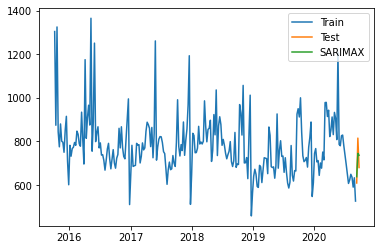

Current product:  14251


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65865D+00    |proj g|=  2.09260D-01

At iterate    5    f=  8.60054D+00    |proj g|=  1.24081D-02

At iterate   10    f=  8.59736D+00    |proj g|=  2.55657D-02

At iterate   15    f=  8.58196D+00    |proj g|=  1.76333D-02

At iterate   20    f=  8.57616D+00    |proj g|=  2.71780D-04

At iterate   25    f=  8.57608D+00    |proj g|=  1.51202D-03

At iterate   30    f=  8.54237D+00    |proj g|=  1.32617D-01

At iterate   35    f=  8.48722D+00    |proj g|=  3.83411D-03

At iterate   40    f=  8.48622D+00    |proj g|=  6.10251D-04

At iterate   45    f=  8.48565D+00    |proj g|=  5.30077D-04

At iterate   50    f=  8.48544D+00    |proj g|=  5.40851D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65949D+00    |proj g|=  2.15573D-01

At iterate    5    f=  8.60000D+00    |proj g|=  5.15361D-03

At iterate   10    f=  8.59965D+00    |proj g|=  1.80934D-04

At iterate   15    f=  8.59954D+00    |proj g|=  5.66764D-03

At iterate   20    f=  8.58551D+00    |proj g|=  6.86349D-02

At iterate   25    f=  8.56009D+00    |proj g|=  4.58000D-03

At iterate   30    f=  8.55799D+00    |proj g|=  8.85576D-04

At iterate   35    f=  8.55768D+00    |proj g|=  1.65858D-04

At iterate   40    f=  8.55757D+00    |proj g|=  1.42400D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61188D+00    |proj g|=  5.85846D-02

At iterate    5    f=  8.60804D+00    |proj g|=  1.61782D-04

At iterate   10    f=  8.60801D+00    |proj g|=  3.90293D-03

At iterate   15    f=  8.60479D+00    |proj g|=  4.89382D-02

At iterate   20    f=  8.58948D+00    |proj g|=  3.48129D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     26      1     0     0   6.987D-06   8.589D+00
  F =   8.5894575500846067     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  8.62787D+00    |proj g|=  3.34637D-04

At iterate   10    f=  8.62784D+00    |proj g|=  5.82013D-03

At iterate   15    f=  8.62538D+00    |proj g|=  4.63333D-02

At iterate   20    f=  8.62126D+00    |proj g|=  1.70246D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     22      1     0     0   1.702D-06   8.621D+00
  F =   8.6212554828479977     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  66.32379952172876
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate    5    f=  8.60874D+00    |proj g|=  2.40516D-03

At iterate   10    f=  8.59753D+00    |proj g|=  2.51127D-02

At iterate   15    f=  8.59045D+00    |proj g|=  4.43184D-03

At iterate   20    f=  8.59021D+00    |proj g|=  2.71511D-04

At iterate   25    f=  8.53661D+00    |proj g|=  9.14728D-03

At iterate   30    f=  8.53618D+00    |proj g|=  6.05560D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     40      1     0     0   6.056D-07   8.536D+00
  F =   8.5361848067846093     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  127.66005246869203


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.64935D+00    |proj g|=  5.55251D-02

At iterate    5    f=  8.62861D+00    |proj g|=  4.97697D-03

At iterate   10    f=  8.62834D+00    |proj g|=  1.79517D-04

At iterate   15    f=  8.62830D+00    |proj g|=  3.47300D-03

At iterate   20    f=  8.62266D+00    |proj g|=  4.16181D-02

At iterate   25    f=  8.60093D+00    |proj g|=  1.54729D-03

At iterate   30    f=  8.60090D+00    |proj g|=  2.74168D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68966D+00    |proj g|=  2.00283D-01

At iterate    5    f=  8.62159D+00    |proj g|=  4.42150D-03

At iterate   10    f=  8.62052D+00    |proj g|=  3.32114D-03

At iterate   15    f=  8.62044D+00    |proj g|=  2.64230D-04

At iterate   20    f=  8.62039D+00    |proj g|=  1.44931D-03

At iterate   25    f=  8.56523D+00    |proj g|=  8.32941D-02

At iterate   30    f=  8.53578D+00    |proj g|=  8.66523D-03

At iterate   35    f=  8.52710D+00    |proj g|=  4.61843D-03

At iterate   40    f=  8.51572D+00    |proj g|=  8.42048D-03

At iterate   45    f=  8.51562D+00    |proj g|=  2.66431D-04

At iterate   50    f=  8.51558D+00    |proj g|=  3.41737D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68873D+00    |proj g|=  1.95865D-01

At iterate    5    f=  8.62473D+00    |proj g|=  8.68257D-03

At iterate   10    f=  8.62405D+00    |proj g|=  2.51547D-03

At iterate   15    f=  8.62403D+00    |proj g|=  9.74932D-04

At iterate   20    f=  8.62395D+00    |proj g|=  2.21079D-03

At iterate   25    f=  8.60955D+00    |proj g|=  3.74467D-02

At iterate   30    f=  8.58419D+00    |proj g|=  3.34500D-03

At iterate   35    f=  8.55656D+00    |proj g|=  9.96487D-04

At iterate   40    f=  8.55343D+00    |proj g|=  8.03216D-04

At iterate   45    f=  8.55333D+00    |proj g|=  5.34569D-03

At iterate   50    f=  8.55315D+00    |proj g|=  1.47111D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68873D+00    |proj g|=  1.95865D-01

At iterate    5    f=  8.62473D+00    |proj g|=  6.60847D-03

At iterate   10    f=  8.62394D+00    |proj g|=  1.31005D-03

At iterate   15    f=  8.62393D+00    |proj g|=  6.26851D-04

At iterate   20    f=  8.62390D+00    |proj g|=  1.13407D-03

At iterate   25    f=  8.62143D+00    |proj g|=  1.47838D-02

At iterate   30    f=  8.56159D+00    |proj g|=  1.47564D-02

At iterate   35    f=  8.55715D+00    |proj g|=  2.20895D-02

At iterate   40    f=  8.55351D+00    |proj g|=  4.34040D-04

At iterate   45    f=  8.55339D+00    |proj g|=  3.31666D-03

At iterate   50    f=  8.55282D+00    |proj g|=  1.02012D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68594D+00    |proj g|=  1.96185D-01

At iterate    5    f=  8.62096D+00    |proj g|=  3.19855D-03

At iterate   10    f=  8.62060D+00    |proj g|=  2.11478D-04

At iterate   15    f=  8.61980D+00    |proj g|=  1.14869D-02

At iterate   20    f=  8.56956D+00    |proj g|=  5.29624D-02

At iterate   25    f=  8.55631D+00    |proj g|=  2.80709D-02

At iterate   30    f=  8.55340D+00    |proj g|=  7.88779D-04

At iterate   35    f=  8.55292D+00    |proj g|=  3.69774D-04

At iterate   40    f=  8.55285D+00    |proj g|=  1.06686D-04

At iterate   45    f=  8.55283D+00    |proj g|=  6.04441D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  8.62755D+00    |proj g|=  7.81615D-03

At iterate   10    f=  8.62719D+00    |proj g|=  2.35550D-04

At iterate   15    f=  8.62719D+00    |proj g|=  1.80085D-04

At iterate   20    f=  8.62716D+00    |proj g|=  2.10807D-03

At iterate   25    f=  8.62503D+00    |proj g|=  1.91426D-02

At iterate   30    f=  8.60541D+00    |proj g|=  2.89212D-02

At iterate   35    f=  8.59752D+00    |proj g|=  7.89733D-03

At iterate   40    f=  8.58814D+00    |proj g|=  1.32496D-02

At iterate   45    f=  8.58190D+00    |proj g|=  6.18441D-03

At iterate   50    f=  8.58119D+00    |proj g|=  3.25912D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.70765D+00    |proj g|=  2.85027D-01

At iterate    5    f=  8.60008D+00    |proj g|=  2.47082D-02

At iterate   10    f=  8.59805D+00    |proj g|=  1.26948D-02

At iterate   15    f=  8.57977D+00    |proj g|=  2.04534D-02

At iterate   20    f=  8.57558D+00    |proj g|=  3.00588D-03

At iterate   25    f=  8.57519D+00    |proj g|=  2.70230D-04

At iterate   30    f=  8.57489D+00    |proj g|=  2.23511D-03

At iterate   35    f=  8.51284D+00    |proj g|=  7.83636D-02

At iterate   40    f=  8.49250D+00    |proj g|=  1.04550D-02

At iterate   45    f=  8.48644D+00    |proj g|=  3.89965D-03

At iterate   50    f=  8.48552D+00    |proj g|=  1.85197D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.60820D+00    |proj g|=  4.65025D-04

At iterate   10    f=  8.60819D+00    |proj g|=  1.78961D-03

At iterate   15    f=  8.60540D+00    |proj g|=  4.57024D-02

At iterate   20    f=  8.59224D+00    |proj g|=  4.25190D-03

At iterate   25    f=  8.58996D+00    |proj g|=  9.57476D-04

At iterate   30    f=  8.58988D+00    |proj g|=  1.37426D-03

At iterate   35    f=  8.54456D+00    |proj g|=  7.68516D-02

At iterate   40    f=  8.53718D+00    |proj g|=  1.17492D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     56      1     0     0   6.404D-07   8.537D+00
  F =   8.53717785228

 This problem is unconstrained.



At iterate    5    f=  8.62160D+00    |proj g|=  4.07418D-03

At iterate   10    f=  8.62065D+00    |proj g|=  4.67479D-03

At iterate   15    f=  8.62045D+00    |proj g|=  8.69694D-04

At iterate   20    f=  8.62043D+00    |proj g|=  4.17598D-04

At iterate   25    f=  8.62033D+00    |proj g|=  1.29004D-03

At iterate   30    f=  8.59197D+00    |proj g|=  3.18158D-02

At iterate   35    f=  8.55284D+00    |proj g|=  3.84368D-02

At iterate   40    f=  8.53141D+00    |proj g|=  1.56785D-02

At iterate   45    f=  8.52725D+00    |proj g|=  7.47413D-03

At iterate   50    f=  8.52700D+00    |proj g|=  2.56936D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.60576D+00    |proj g|=  1.02701D-01

At iterate    5    f=  8.58764D+00    |proj g|=  2.91150D-02

At iterate   10    f=  8.58285D+00    |proj g|=  2.99115D-03

At iterate   15    f=  8.58279D+00    |proj g|=  4.73439D-04

At iterate   20    f=  8.58270D+00    |proj g|=  7.85585D-03

At iterate   25    f=  8.56642D+00    |proj g|=  5.44381D-02

At iterate   30    f=  8.52947D+00    |proj g|=  1.17666D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65799D+00    |proj g|=  2.10052D-01

At iterate    5    f=  8.59938D+00    |proj g|=  3.81573D-03

At iterate   10    f=  8.59934D+00    |proj g|=  1.98594D-04

At iterate   15    f=  8.59922D+00    |proj g|=  3.96243D-03

At iterate   20    f=  8.58914D+00    |proj g|=  8.08410D-02

At iterate   25    f=  8.54981D+00    |proj g|=  1.22368D-02

At iterate   30    f=  8.54930D+00    |proj g|=  7.05471D-04

At iterate   35    f=  8.54872D+00    |proj g|=  1.18330D-03

At iterate   40    f=  8.54860D+00    |proj g|=  1.35214D-03

At iterate   45    f=  8.54859D+00    |proj g|=  2.72998D-04

At iterate   50    f=  8.54858D+00    |proj g|=  1.02428D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.62473D+00    |proj g|=  8.68257D-03

At iterate   10    f=  8.62405D+00    |proj g|=  2.51547D-03

At iterate   15    f=  8.62403D+00    |proj g|=  9.74932D-04

At iterate   20    f=  8.62395D+00    |proj g|=  2.21079D-03

At iterate   25    f=  8.60955D+00    |proj g|=  3.74467D-02

At iterate   30    f=  8.58419D+00    |proj g|=  3.34500D-03

At iterate   35    f=  8.55656D+00    |proj g|=  9.96487D-04

At iterate   40    f=  8.55343D+00    |proj g|=  8.03216D-04

At iterate   45    f=  8.55333D+00    |proj g|=  5.34569D-03

At iterate   50    f=  8.55315D+00    |proj g|=  1.47111D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

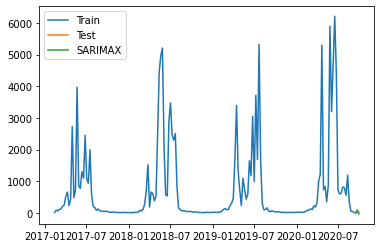

Current product:  14490
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.08344D+00    |proj g|=  4.71351D-02


 This problem is unconstrained.



At iterate    5    f=  7.06612D+00    |proj g|=  1.17488D-02

At iterate   10    f=  7.05669D+00    |proj g|=  8.30160D-03

At iterate   15    f=  7.05613D+00    |proj g|=  2.35014D-02

At iterate   20    f=  7.04630D+00    |proj g|=  6.81116D-02

At iterate   25    f=  7.04159D+00    |proj g|=  1.34906D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     33      1     0     0   7.646D-06   7.042D+00
  F =   7.0415922031478084     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  132.3619847973812


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09619D+00    |proj g|=  3.01525D-02

At iterate    5    f=  7.09397D+00    |proj g|=  5.47031D-04

At iterate   10    f=  7.09389D+00    |proj g|=  8.45650D-03

At iterate   15    f=  7.08945D+00    |proj g|=  4.40328D-02

At iterate   20    f=  7.08744D+00    |proj g|=  4.06737D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   8.690D-06   7.087D+00
  F =   7.0874406879236975     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.09565D+00    |proj g|=  5.49125D-04

At iterate   10    f=  7.09551D+00    |proj g|=  1.60649D-02

At iterate   15    f=  7.08990D+00    |proj g|=  4.77118D-02

At iterate   20    f=  7.08912D+00    |proj g|=  8.43618D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     22      1     0     0   8.436D-06   7.089D+00
  F =   7.0891178935021788     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  95.11619065203152
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate    5    f=  7.06158D+00    |proj g|=  1.25703D-03

At iterate   10    f=  7.06153D+00    |proj g|=  9.63631D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   5.183D-06   7.062D+00
  F =   7.0615335052105026     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  131.29364589558378
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07755D+00    |proj g|=  5.17840D-02


 This problem is unconstrained.



At iterate    5    f=  7.06708D+00    |proj g|=  2.46402D-02

At iterate   10    f=  7.06438D+00    |proj g|=  2.57826D-03

At iterate   15    f=  7.06338D+00    |proj g|=  1.70381D-03

At iterate   20    f=  7.04862D+00    |proj g|=  1.25023D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   8.774D-06   7.049D+00
  F =   7.0486169598660311     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  152.06099804088947


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.27739D+00    |proj g|=  4.96564D-02

At iterate    5    f=  7.27263D+00    |proj g|=  1.52041D-02

At iterate   10    f=  7.26439D+00    |proj g|=  9.89975D-02

At iterate   15    f=  7.26168D+00    |proj g|=  7.03416D-03

At iterate   20    f=  7.24425D+00    |proj g|=  1.13504D-01

At iterate   25    f=  7.24186D+00    |proj g|=  1.25064D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     31      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29637D+00    |proj g|=  1.41392D-01

At iterate    5    f=  7.24797D+00    |proj g|=  1.62497D-02

At iterate   10    f=  7.24710D+00    |proj g|=  1.18871D-03

At iterate   15    f=  7.24539D+00    |proj g|=  8.62188D-03

At iterate   20    f=  7.21729D+00    |proj g|=  3.14212D-03

At iterate   25    f=  7.21718D+00    |proj g|=  1.10697D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     34      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.26466D+00    |proj g|=  1.01631D-02

At iterate   10    f=  7.25772D+00    |proj g|=  7.62402D-03

At iterate   15    f=  7.25606D+00    |proj g|=  1.98840D-03

At iterate   20    f=  7.22752D+00    |proj g|=  2.51258D-02

At iterate   25    f=  7.22627D+00    |proj g|=  1.78979D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     36      1     0     0   1.823D-05   7.226D+00
  F =   7.2262599445661690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  97.76626934879094


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29208D+00    |proj g|=  1.41475D-01

At iterate    5    f=  7.26635D+00    |proj g|=  8.19045D-03

At iterate   10    f=  7.26070D+00    |proj g|=  2.70307D-02

At iterate   15    f=  7.25667D+00    |proj g|=  8.73629D-03

At iterate   20    f=  7.25603D+00    |proj g|=  2.92509D-03

At iterate   25    f=  7.23939D+00    |proj g|=  2.28886D-01

At iterate   30    f=  7.22650D+00    |proj g|=  7.61376D-03

At iterate   35    f=  7.22620D+00    |proj g|=  1.25633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.30414D+00    |proj g|=  1.34243D-01

At iterate    5    f=  7.27866D+00    |proj g|=  6.52158D-04

At iterate   10    f=  7.27847D+00    |proj g|=  5.98302D-03

At iterate   15    f=  7.27118D+00    |proj g|=  2.86886D-02

At iterate   20    f=  7.26612D+00    |proj g|=  5.80865D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     26      1     0     0   1.822D-05   7.266D+00
  F =   7.2660823917260089     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29746D+00    |proj g|=  2.03925D-01

At iterate    5    f=  7.26665D+00    |proj g|=  1.81281D-02

At iterate   10    f=  7.26493D+00    |proj g|=  1.05492D-02

At iterate   15    f=  7.25926D+00    |proj g|=  1.94992D-02

At iterate   20    f=  7.25728D+00    |proj g|=  5.17017D-03

At iterate   25    f=  7.25222D+00    |proj g|=  1.66681D-01

At iterate   30    f=  7.23021D+00    |proj g|=  7.77092D-03

At iterate   35    f=  7.23016D+00    |proj g|=  6.66971D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.08360D+00    |proj g|=  5.29450D-02

At iterate    5    f=  7.06711D+00    |proj g|=  1.48340D-02

At iterate   10    f=  7.05609D+00    |proj g|=  1.29456D-02

At iterate   15    f=  7.05408D+00    |proj g|=  2.99697D-03

At iterate   20    f=  7.05391D+00    |proj g|=  4.41609D-03

At iterate   25    f=  7.05118D+00    |proj g|=  2.63289D-02

At iterate   30    f=  7.03894D+00    |proj g|=  6.28697D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.08250D+00    |proj g|=  5.52509D-02

At iterate    5    f=  7.07550D+00    |proj g|=  4.53616D-02

At iterate   10    f=  7.06764D+00    |proj g|=  1.96024D-02

At iterate   15    f=  7.06557D+00    |proj g|=  9.55754D-04

At iterate   20    f=  7.05278D+00    |proj g|=  4.24828D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     30      1     0     0   7.954D-06   7.051D+00
  F =   7.0511807408552283     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.25341D+00    |proj g|=  3.16226D-02

At iterate   10    f=  7.24714D+00    |proj g|=  1.96445D-03

At iterate   15    f=  7.24701D+00    |proj g|=  2.02478D-02

At iterate   20    f=  7.24157D+00    |proj g|=  4.20670D-02

At iterate   25    f=  7.21835D+00    |proj g|=  1.83283D-02

At iterate   30    f=  7.21720D+00    |proj g|=  2.76774D-03

At iterate   35    f=  7.21718D+00    |proj g|=  7.08716D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     46      1     0     0   5.780D-05   7.217D+00
  F =   7.2171807692597509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07729D+00    |proj g|=  5.38844D-02

At iterate    5    f=  7.06198D+00    |proj g|=  1.06853D-03

At iterate   10    f=  7.06185D+00    |proj g|=  5.18160D-03

At iterate   15    f=  7.05515D+00    |proj g|=  4.16875D-02

At iterate   20    f=  7.04398D+00    |proj g|=  1.87614D-02

At iterate   25    f=  7.04302D+00    |proj g|=  4.15080D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     32      1     0     0   1.210D-05   7.043D+00
  F =   7.0430035993778031     

CONVERGENCE: REL_RED

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.08786D+00    |proj g|=  3.68202D-02

At iterate    5    f=  7.07706D+00    |proj g|=  6.60103D-04

At iterate   10    f=  7.07691D+00    |proj g|=  4.28209D-03

At iterate   15    f=  7.07283D+00    |proj g|=  1.49970D-02

At iterate   20    f=  7.06987D+00    |proj g|=  1.67477D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   7.692D-06   7.070D+00
  F =   7.0698693823445522     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.30414D+00    |proj g|=  1.34243D-01

At iterate    5    f=  7.27866D+00    |proj g|=  6.52158D-04

At iterate   10    f=  7.27847D+00    |proj g|=  5.98302D-03

At iterate   15    f=  7.27118D+00    |proj g|=  2.86886D-02

At iterate   20    f=  7.26612D+00    |proj g|=  5.80865D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     26      1     0     0   1.822D-05   7.266D+00
  F =   7.2660823917260089     

CONVERG

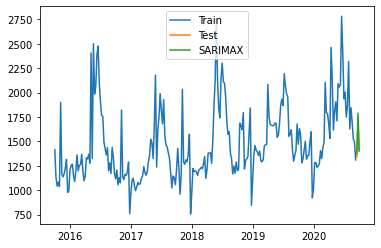

Current product:  10017


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30479D+00    |proj g|=  2.28460D-01

At iterate    5    f=  5.98275D+00    |proj g|=  1.21125D-01

At iterate   10    f=  5.97860D+00    |proj g|=  3.27109D-03

At iterate   15    f=  5.97606D+00    |proj g|=  1.91056D-02

At iterate   20    f=  5.96210D+00    |proj g|=  1.29553D-02

At iterate   25    f=  5.96047D+00    |proj g|=  1.77742D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     36      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.02329D+00    |proj g|=  2.11537D-02

At iterate   10    f=  6.01977D+00    |proj g|=  9.37845D-03

At iterate   15    f=  6.01301D+00    |proj g|=  1.44248D-01

At iterate   20    f=  5.99791D+00    |proj g|=  2.00714D-02

At iterate   25    f=  5.99689D+00    |proj g|=  1.27553D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     36      1     0     0   4.819D-06   5.997D+00
  F =   5.9968851250608299     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  39.371971935956786


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23738D+00    |proj g|=  3.40494D-01

At iterate    5    f=  6.06593D+00    |proj g|=  7.24961D-03

At iterate   10    f=  6.06591D+00    |proj g|=  1.79370D-02

At iterate   15    f=  6.06412D+00    |proj g|=  1.61998D-01

At iterate   20    f=  6.06188D+00    |proj g|=  2.56596D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     28      1     0     0   3.859D-05   6.062D+00
  F =   6.0618785017910115     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  6.00064D+00    |proj g|=  8.35430D-04

At iterate   10    f=  6.00064D+00    |proj g|=  7.48770D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   7.488D-06   6.001D+00
  F =   6.0006362004172109     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  40.38375190255881
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20986D+00    |proj g|=  3.58867D-01


 This problem is unconstrained.



At iterate    5    f=  6.00587D+00    |proj g|=  1.05500D-02

At iterate   10    f=  6.00572D+00    |proj g|=  3.46839D-03

At iterate   15    f=  6.00520D+00    |proj g|=  1.06486D-01

At iterate   20    f=  6.00315D+00    |proj g|=  6.04701D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     31      1     0     0   4.941D-06   6.003D+00
  F =   6.0031482641310339     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  43.497120495909535
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exac

 This problem is unconstrained.



At iterate    5    f=  6.44467D+00    |proj g|=  4.85157D-02

At iterate   10    f=  6.44308D+00    |proj g|=  2.19939D-03

At iterate   15    f=  6.44298D+00    |proj g|=  3.47951D-02

At iterate   20    f=  6.44041D+00    |proj g|=  5.06401D-02

At iterate   25    f=  6.43634D+00    |proj g|=  9.73346D-02

At iterate   30    f=  6.43467D+00    |proj g|=  3.28896D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     39      1     0     0   1.582D-05   6.435D+00
  F =   6.4346639695613916     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  40.6991512559139


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.49328D+00    |proj g|=  1.81462D-01

At iterate    5    f=  6.45082D+00    |proj g|=  1.02179D-02

At iterate   10    f=  6.44771D+00    |proj g|=  2.80844D-03

At iterate   15    f=  6.43921D+00    |proj g|=  4.16361D-02

At iterate   20    f=  6.43167D+00    |proj g|=  2.80961D-03

At iterate   25    f=  6.43159D+00    |proj g|=  5.28366D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     35      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47945D+00    |proj g|=  1.83161D-01

At iterate    5    f=  6.44030D+00    |proj g|=  2.94514D-03

At iterate   10    f=  6.43655D+00    |proj g|=  2.87117D-02

At iterate   15    f=  6.42309D+00    |proj g|=  1.28888D-03

At iterate   20    f=  6.42307D+00    |proj g|=  4.28093D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     23      1     0     0   4.281D-06   6.423D+00
  F =   6.4230656829202033     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47945D+00    |proj g|=  1.83161D-01

At iterate    5    f=  6.44385D+00    |proj g|=  4.43610D-02

At iterate   10    f=  6.44017D+00    |proj g|=  2.96336D-03

At iterate   15    f=  6.43946D+00    |proj g|=  5.74849D-02

At iterate   20    f=  6.43415D+00    |proj g|=  4.26656D-02

At iterate   25    f=  6.42530D+00    |proj g|=  1.33085D-01

At iterate   30    f=  6.42274D+00    |proj g|=  1.28259D-03

At iterate   35    f=  6.42271D+00    |proj g|=  1.42671D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51845D+00    |proj g|=  2.20208D-01

At iterate    5    f=  6.46728D+00    |proj g|=  2.94764D-03

At iterate   10    f=  6.45712D+00    |proj g|=  2.62387D-02

At iterate   15    f=  6.44621D+00    |proj g|=  9.69132D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   4.653D-06   6.446D+00
  F =   6.4462109101809002     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  4

 This problem is unconstrained.



At iterate    5    f=  6.44753D+00    |proj g|=  3.98742D-02

At iterate   10    f=  6.44020D+00    |proj g|=  3.80905D-03

At iterate   15    f=  6.43954D+00    |proj g|=  6.54998D-03

At iterate   20    f=  6.43676D+00    |proj g|=  3.65955D-02

At iterate   25    f=  6.42324D+00    |proj g|=  2.98804D-02

At iterate   30    f=  6.42307D+00    |proj g|=  7.40045D-03

At iterate   35    f=  6.42306D+00    |proj g|=  1.26781D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     47      1     0     0   8.081D-06   6.423D+00
  F =   6.4230545995737494     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30452D+00    |proj g|=  2.26244D-01

At iterate    5    f=  5.98192D+00    |proj g|=  7.07637D-02

At iterate   10    f=  5.97898D+00    |proj g|=  5.53106D-03

At iterate   15    f=  5.97799D+00    |proj g|=  4.53463D-03

At iterate   20    f=  5.97679D+00    |proj g|=  3.88705D-02

At iterate   25    f=  5.96235D+00    |proj g|=  3.89624D-02

At iterate   30    f=  5.96046D+00    |proj g|=  8.28375D-04

At iterate   35    f=  5.96045D+00    |proj g|=  2.71678D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.21498D+00    |proj g|=  3.51470D-01

At iterate    5    f=  6.01715D+00    |proj g|=  9.99694D-03

At iterate   10    f=  6.01596D+00    |proj g|=  1.38275D-03

At iterate   15    f=  6.01578D+00    |proj g|=  4.77980D-02

At iterate   20    f=  6.01362D+00    |proj g|=  4.51151D-02

At iterate   25    f=  6.01345D+00    |proj g|=  4.89101D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     36      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.45318D+00    |proj g|=  6.89034D-02

At iterate   10    f=  6.45125D+00    |proj g|=  1.95317D-02

At iterate   15    f=  6.44873D+00    |proj g|=  9.21106D-02

At iterate   20    f=  6.44777D+00    |proj g|=  7.38178D-03

At iterate   25    f=  6.44618D+00    |proj g|=  2.60345D-02

At iterate   30    f=  6.43403D+00    |proj g|=  3.21326D-02

At iterate   35    f=  6.43122D+00    |proj g|=  7.73310D-04

At iterate   40    f=  6.43122D+00    |proj g|=  1.09550D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     47      1     0     0   1.095D-05   6.431D+00
  F =   6.43121546015

 This problem is unconstrained.



At iterate    5    f=  6.01468D+00    |proj g|=  1.67876D-02

At iterate   10    f=  6.00744D+00    |proj g|=  5.20038D-02

At iterate   15    f=  6.00528D+00    |proj g|=  2.07535D-03

At iterate   20    f=  6.00522D+00    |proj g|=  1.42469D-02

At iterate   25    f=  6.00386D+00    |proj g|=  5.20588D-02

At iterate   30    f=  6.00309D+00    |proj g|=  4.90224D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     42      1     0     0   2.637D-04   6.003D+00
  F =   6.0030931536143415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  43.471845076672516
RUNNING THE L-BFGS-B CODE

 This problem is unconstrained.



At iterate    5    f=  5.97944D+00    |proj g|=  3.49485D-02

At iterate   10    f=  5.97894D+00    |proj g|=  1.06192D-02

At iterate   15    f=  5.97751D+00    |proj g|=  1.50337D-01

At iterate   20    f=  5.96727D+00    |proj g|=  1.45758D-01

At iterate   25    f=  5.96129D+00    |proj g|=  1.87937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     36      1     0     0   6.736D-05   5.961D+00
  F =   5.9612919551284147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  36.895856132781375
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  5.97944D+00    |proj g|=  3.49485D-02

At iterate   10    f=  5.97894D+00    |proj g|=  1.06192D-02

At iterate   15    f=  5.97751D+00    |proj g|=  1.50337D-01

At iterate   20    f=  5.96727D+00    |proj g|=  1.45758D-01

At iterate   25    f=  5.96129D+00    |proj g|=  1.87937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     36      1     0     0   6.736D-05   5.961D+00
  F =   5.9612919551284147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  10017
Best Configs:  [(0, 1, 1), (1, 1, 1,

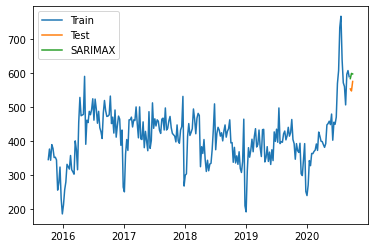

Total RMSE of top 10 selling products:  816.7413262882676 , total mape:  541.9472264254244
selected horizon:  12
Current product:  9205
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.98401D+00    |proj g|=  5.71477D-01


 This problem is unconstrained.



At iterate    5    f=  7.61201D+00    |proj g|=  4.96071D-02

At iterate   10    f=  7.52678D+00    |proj g|=  2.15527D-03

At iterate   15    f=  7.52557D+00    |proj g|=  1.19742D-02

At iterate   20    f=  7.52195D+00    |proj g|=  9.23286D-03

At iterate   25    f=  7.52161D+00    |proj g|=  4.79761D-03

At iterate   30    f=  7.50848D+00    |proj g|=  9.09752D-02

At iterate   35    f=  7.47374D+00    |proj g|=  1.11889D-02

At iterate   40    f=  7.47290D+00    |proj g|=  4.62647D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     59      1     0     0   1.954D-05   7.473D+00
  F =   7.47290237242

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.58584D+00    |proj g|=  3.57832D-02

At iterate    5    f=  7.58187D+00    |proj g|=  7.60779D-03

At iterate   10    f=  7.58178D+00    |proj g|=  5.55116D-03

At iterate   15    f=  7.57709D+00    |proj g|=  7.32747D-02

At iterate   20    f=  7.55152D+00    |proj g|=  5.12168D-03

At iterate   25    f=  7.55152D+00    |proj g|=  5.31659D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     29      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.58486D+00    |proj g|=  5.30695D-04

At iterate   10    f=  7.58466D+00    |proj g|=  1.34043D-02

At iterate   15    f=  7.57080D+00    |proj g|=  9.53758D-02

At iterate   20    f=  7.55972D+00    |proj g|=  9.51204D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     23      1     0     0   1.101D-05   7.560D+00
  F =   7.5597234962316460     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  141.3124006121524
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate    5    f=  7.60872D+00    |proj g|=  1.26876D-03

At iterate   10    f=  7.60860D+00    |proj g|=  7.72632D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     18      1     0     0   1.034D-05   7.609D+00
  F =   7.6085556045468037     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  152.28581676529544


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.06926D+00    |proj g|=  6.52338D-01

At iterate    5    f=  7.64008D+00    |proj g|=  3.38409D-02

At iterate   10    f=  7.52486D+00    |proj g|=  1.07872D-03

At iterate   15    f=  7.52477D+00    |proj g|=  9.92090D-03

At iterate   20    f=  7.52379D+00    |proj g|=  2.01275D-02

At iterate   25    f=  7.52301D+00    |proj g|=  1.00878D-03

At iterate   30    f=  7.52031D+00    |proj g|=  2.81280D-02

At iterate   35    f=  7.47839D+00    |proj g|=  2.17709D-02

At iterate   40    f=  7.47703D+00    |proj g|=  1.11575D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  7.68918D+00    |proj g|=  2.11671D-02

At iterate   10    f=  7.60533D+00    |proj g|=  3.01242D-02

At iterate   15    f=  7.60419D+00    |proj g|=  1.31263D-03

At iterate   20    f=  7.59484D+00    |proj g|=  9.85000D-02

At iterate   25    f=  7.58911D+00    |proj g|=  1.33043D-03

At iterate   30    f=  7.58894D+00    |proj g|=  9.19743D-03

At iterate   35    f=  7.57029D+00    |proj g|=  1.19186D-01

At iterate   40    f=  7.48866D+00    |proj g|=  8.30111D-03

At iterate   45    f=  7.48777D+00    |proj g|=  1.62325D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     68   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.61768D+00    |proj g|=  1.23111D-01

At iterate    5    f=  7.58486D+00    |proj g|=  4.19018D-03

At iterate   10    f=  7.58410D+00    |proj g|=  1.38009D-03

At iterate   15    f=  7.58244D+00    |proj g|=  1.92685D-02

At iterate   20    f=  7.52573D+00    |proj g|=  1.02200D-01

At iterate   25    f=  7.48904D+00    |proj g|=  8.88058D-03

At iterate   30    f=  7.48854D+00    |proj g|=  2.08346D-03

At iterate   35    f=  7.48609D+00    |proj g|=  4.81931D-02

At iterate   40    f=  7.48376D+00    |proj g|=  4.40598D-04

At iterate   45    f=  7.48376D+00    |proj g|=  1.18129D-04

At iterate   50    f=  7.48375D+00    |proj g|=  2.50911D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.68514D+00    |proj g|=  2.68852D-02

At iterate   10    f=  7.60267D+00    |proj g|=  9.54321D-04

At iterate   15    f=  7.60197D+00    |proj g|=  1.33939D-02

At iterate   20    f=  7.59316D+00    |proj g|=  1.28808D-02

At iterate   25    f=  7.59268D+00    |proj g|=  1.28089D-03

At iterate   30    f=  7.58748D+00    |proj g|=  3.97956D-02

At iterate   35    f=  7.51046D+00    |proj g|=  9.49912D-02

At iterate   40    f=  7.48999D+00    |proj g|=  3.52301D-04

At iterate   45    f=  7.48899D+00    |proj g|=  2.57993D-02

At iterate   50    f=  7.48657D+00    |proj g|=  1.30901D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.69069D+00    |proj g|=  2.03697D-02

At iterate   10    f=  7.60231D+00    |proj g|=  9.23424D-03

At iterate   15    f=  7.60189D+00    |proj g|=  2.45349D-03

At iterate   20    f=  7.59138D+00    |proj g|=  1.92531D-02

At iterate   25    f=  7.58953D+00    |proj g|=  9.35349D-04

At iterate   30    f=  7.58909D+00    |proj g|=  9.61421D-03

At iterate   35    f=  7.56090D+00    |proj g|=  1.26418D-01

At iterate   40    f=  7.50081D+00    |proj g|=  1.02727D-01

At iterate   45    f=  7.48046D+00    |proj g|=  9.46710D-03

At iterate   50    f=  7.47915D+00    |proj g|=  3.05117D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.63368D+00    |proj g|=  7.90495D-04

At iterate   10    f=  7.63312D+00    |proj g|=  1.15824D-02

At iterate   15    f=  7.56158D+00    |proj g|=  1.88056D-01

At iterate   20    f=  7.54934D+00    |proj g|=  2.09878D-02

At iterate   25    f=  7.54830D+00    |proj g|=  1.05485D-04

At iterate   30    f=  7.54824D+00    |proj g|=  2.90937D-03

At iterate   35    f=  7.54819D+00    |proj g|=  2.00148D-03

At iterate   40    f=  7.54816D+00    |proj g|=  4.45791D-04

At iterate   45    f=  7.54750D+00    |proj g|=  1.28889D-03

At iterate   50    f=  7.54750D+00    |proj g|=  9.35563D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.58803D+00    |proj g|=  9.98510D-03

At iterate   10    f=  7.58464D+00    |proj g|=  3.60555D-02

At iterate   15    f=  7.57112D+00    |proj g|=  2.68596D-02

At iterate   20    f=  7.56887D+00    |proj g|=  9.27750D-04

At iterate   25    f=  7.56861D+00    |proj g|=  9.68642D-03

At iterate   30    f=  7.54079D+00    |proj g|=  1.12841D-01

At iterate   35    f=  7.49367D+00    |proj g|=  5.73428D-02

At iterate   40    f=  7.47696D+00    |proj g|=  5.43483D-02

At iterate   45    f=  7.47145D+00    |proj g|=  3.48889D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     58   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54167D+00    |proj g|=  1.15307D-01

At iterate    5    f=  7.50545D+00    |proj g|=  4.40493D-03

At iterate   10    f=  7.50382D+00    |proj g|=  1.85063D-02

At iterate   15    f=  7.49897D+00    |proj g|=  6.01806D-03

At iterate   20    f=  7.49865D+00    |proj g|=  1.24389D-02

At iterate   25    f=  7.47369D+00    |proj g|=  6.60527D-02

At iterate   30    f=  7.45349D+00    |proj g|=  5.17561D-02

At iterate   35    f=  7.45136D+00    |proj g|=  8.70573D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  7.50683D+00    |proj g|=  2.76696D-03

At iterate   10    f=  7.50543D+00    |proj g|=  3.54317D-02

At iterate   15    f=  7.50106D+00    |proj g|=  7.73166D-04

At iterate   20    f=  7.50101D+00    |proj g|=  4.95398D-03

At iterate   25    f=  7.49529D+00    |proj g|=  6.37875D-02

At iterate   30    f=  7.46110D+00    |proj g|=  1.80539D-02

At iterate   35    f=  7.45854D+00    |proj g|=  1.65425D-02

At iterate   40    f=  7.45835D+00    |proj g|=  9.75575D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     47      1     0     0   9.756D-06   7.458D+00
  F =   7.45835256236

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.61768D+00    |proj g|=  1.23111D-01

At iterate    5    f=  7.58237D+00    |proj g|=  6.23588D-03

At iterate   10    f=  7.58047D+00    |proj g|=  9.25627D-04

At iterate   15    f=  7.58013D+00    |proj g|=  8.15985D-03

At iterate   20    f=  7.50429D+00    |proj g|=  1.84220D-01

At iterate   25    f=  7.47748D+00    |proj g|=  1.92944D-02

At iterate   30    f=  7.47682D+00    |proj g|=  1.03351D-03

At iterate   35    f=  7.47682D+00    |proj g|=  6.02203D-04

At iterate   40    f=  7.47676D+00    |proj g|=  6.24811D-03

At iterate   45    f=  7.47669D+00    |proj g|=  1.57812D-03

At iterate   50    f=  7.47663D+00    |proj g|=  1.73578D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53735D+00    |proj g|=  2.07926D-01

At iterate    5    f=  7.50613D+00    |proj g|=  1.39671D-03

At iterate   10    f=  7.50601D+00    |proj g|=  3.45275D-03

At iterate   15    f=  7.49117D+00    |proj g|=  6.99198D-02

At iterate   20    f=  7.46178D+00    |proj g|=  8.02327D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   4.646D-06   7.462D+00
  F =   7.4617795062693402     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.55984D+00    |proj g|=  3.98987D-03

At iterate   10    f=  7.55978D+00    |proj g|=  3.27019D-03

At iterate   15    f=  7.55633D+00    |proj g|=  4.17513D-02

At iterate   20    f=  7.50986D+00    |proj g|=  7.03543D-02

At iterate   25    f=  7.50196D+00    |proj g|=  8.86467D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     31      1     0     0   5.079D-05   7.502D+00
  F =   7.5019581804446904     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  293.57791428092764
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  7.58486D+00    |proj g|=  5.30695D-04

At iterate   10    f=  7.58466D+00    |proj g|=  1.34043D-02

At iterate   15    f=  7.57080D+00    |proj g|=  9.53758D-02

At iterate   20    f=  7.55972D+00    |proj g|=  9.51204D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     23      1     0     0   1.101D-05   7.560D+00
  F =   7.5597234962316460     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  9205
Best Configs:  [(1, 1, 0), (1, 1, 0, 52)]
Mean Absolute Error: 87.169
Mean Squared Error: 145.711
R

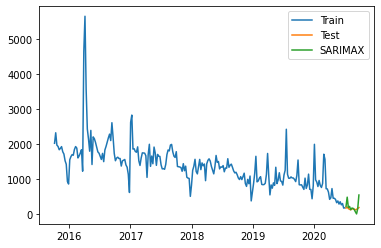

Current product:  14760


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29447D+00    |proj g|=  2.02294D-01

At iterate    5    f=  8.24901D+00    |proj g|=  3.67123D-03

At iterate   10    f=  8.24829D+00    |proj g|=  2.74376D-04

At iterate   15    f=  8.24817D+00    |proj g|=  4.84848D-03

At iterate   20    f=  8.23446D+00    |proj g|=  8.19485D-02

At iterate   25    f=  8.22106D+00    |proj g|=  3.15941D-04

At iterate   30    f=  8.22087D+00    |proj g|=  1.77980D-02

At iterate   35    f=  8.21917D+00    |proj g|=  1.70092D-02

At iterate   40    f=  8.21817D+00    |proj g|=  6.78026D-03

At iterate   45    f=  8.21611D+00    |proj g|=  1.02524D-03

At iterate   50    f=  8.21594D+00    |proj g|=  1.33264D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37718D+00    |proj g|=  1.92295D-01

At iterate    5    f=  8.33890D+00    |proj g|=  1.30113D-03

At iterate   10    f=  8.33889D+00    |proj g|=  6.82295D-04

At iterate   15    f=  8.33871D+00    |proj g|=  9.59438D-03

At iterate   20    f=  8.33270D+00    |proj g|=  2.13708D-02

At iterate   25    f=  8.33004D+00    |proj g|=  6.15402D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  8.34051D+00    |proj g|=  1.52533D-04

At iterate   10    f=  8.34048D+00    |proj g|=  5.48874D-03

At iterate   15    f=  8.33786D+00    |proj g|=  4.85230D-02

At iterate   20    f=  8.33220D+00    |proj g|=  1.01680D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     23      1     0     0   9.902D-06   8.332D+00
  F =   8.3322005492314943     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  3171.520309958743
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate   10    f=  8.33546D+00    |proj g|=  1.32315D-02

At iterate   15    f=  8.33270D+00    |proj g|=  6.06918D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   1.045D-05   8.333D+00
  F =   8.3326567213878135     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  3244.955513252125
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.26396D+00    |proj g|=  9.15610D-02


 This problem is unconstrained.



At iterate    5    f=  8.25406D+00    |proj g|=  7.77294D-03

At iterate   10    f=  8.25364D+00    |proj g|=  2.59874D-04

At iterate   15    f=  8.25359D+00    |proj g|=  2.79462D-03

At iterate   20    f=  8.24852D+00    |proj g|=  4.89422D-02

At iterate   25    f=  8.23193D+00    |proj g|=  4.81291D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   6.293D-06   8.232D+00
  F =   8.2318880454239434     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  3495.694368294599


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53631D+00    |proj g|=  2.66355D-01

At iterate    5    f=  8.33630D+00    |proj g|=  2.36592D-02

At iterate   10    f=  8.33347D+00    |proj g|=  1.52804D-02

At iterate   15    f=  8.33272D+00    |proj g|=  4.67809D-04

At iterate   20    f=  8.33271D+00    |proj g|=  2.51787D-03

At iterate   25    f=  8.33129D+00    |proj g|=  3.52439D-02

At iterate   30    f=  8.30234D+00    |proj g|=  2.82267D-02

At iterate   35    f=  8.29916D+00    |proj g|=  1.65191D-03

At iterate   40    f=  8.29895D+00    |proj g|=  5.84239D-03

At iterate   45    f=  8.29889D+00    |proj g|=  3.28429D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.33725D+00    |proj g|=  1.41134D-01

At iterate    5    f=  8.30699D+00    |proj g|=  2.85575D-03

At iterate   10    f=  8.30661D+00    |proj g|=  2.47692D-04

At iterate   15    f=  8.30659D+00    |proj g|=  1.06792D-03

At iterate   20    f=  8.30537D+00    |proj g|=  1.08980D-02

At iterate   25    f=  8.25605D+00    |proj g|=  3.39224D-02

At iterate   30    f=  8.25440D+00    |proj g|=  1.02339D-03

At iterate   35    f=  8.25406D+00    |proj g|=  3.92074D-03

At iterate   40    f=  8.25345D+00    |proj g|=  8.71368D-04

At iterate   45    f=  8.25332D+00    |proj g|=  1.52945D-03

At iterate   50    f=  8.25327D+00    |proj g|=  4.21404D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38444D+00    |proj g|=  1.39736D-01

At iterate    5    f=  8.34425D+00    |proj g|=  2.09230D-03

At iterate   10    f=  8.34392D+00    |proj g|=  8.35377D-04

At iterate   15    f=  8.34391D+00    |proj g|=  6.46094D-04

At iterate   20    f=  8.34363D+00    |proj g|=  1.50665D-02

At iterate   25    f=  8.32100D+00    |proj g|=  1.22923D-01

At iterate   30    f=  8.29573D+00    |proj g|=  3.43163D-03

At iterate   35    f=  8.29156D+00    |proj g|=  2.76936D-03

At iterate   40    f=  8.29104D+00    |proj g|=  1.31142D-03

At iterate   45    f=  8.29094D+00    |proj g|=  1.42444D-03

At iterate   50    f=  8.29088D+00    |proj g|=  3.63458D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38444D+00    |proj g|=  1.39736D-01

At iterate    5    f=  8.33691D+00    |proj g|=  5.85900D-03

At iterate   10    f=  8.33242D+00    |proj g|=  9.83046D-03

At iterate   15    f=  8.33207D+00    |proj g|=  1.48906D-03

At iterate   20    f=  8.33204D+00    |proj g|=  1.29433D-03

At iterate   25    f=  8.32987D+00    |proj g|=  2.20604D-02

At iterate   30    f=  8.26956D+00    |proj g|=  3.77571D-02

At iterate   35    f=  8.26308D+00    |proj g|=  2.64059D-03

At iterate   40    f=  8.26235D+00    |proj g|=  1.46299D-02

At iterate   45    f=  8.26156D+00    |proj g|=  3.53333D-03

At iterate   50    f=  8.26107D+00    |proj g|=  8.01657D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.38141D+00    |proj g|=  1.34761D-03

At iterate   10    f=  8.38139D+00    |proj g|=  2.13319D-04

At iterate   15    f=  8.38112D+00    |proj g|=  5.67272D-03

At iterate   20    f=  8.36552D+00    |proj g|=  4.42006D-02

At iterate   25    f=  8.33699D+00    |proj g|=  1.37015D-02

At iterate   30    f=  8.33370D+00    |proj g|=  3.38081D-03

At iterate   35    f=  8.33300D+00    |proj g|=  4.34257D-04

At iterate   40    f=  8.33286D+00    |proj g|=  7.32893D-04

At iterate   45    f=  8.33280D+00    |proj g|=  2.51340D-04

At iterate   50    f=  8.32180D+00    |proj g|=  1.69557D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36681D+00    |proj g|=  1.41261D-01

At iterate    5    f=  8.31871D+00    |proj g|=  1.16778D-02

At iterate   10    f=  8.31474D+00    |proj g|=  5.04401D-04

At iterate   15    f=  8.31473D+00    |proj g|=  5.97373D-04

At iterate   20    f=  8.31410D+00    |proj g|=  9.04707D-03

At iterate   25    f=  8.28700D+00    |proj g|=  7.05672D-02

At iterate   30    f=  8.26730D+00    |proj g|=  1.33593D-02

At iterate   35    f=  8.26669D+00    |proj g|=  2.39221D-03

At iterate   40    f=  8.26633D+00    |proj g|=  1.46397D-02

At iterate   45    f=  8.26541D+00    |proj g|=  3.99429D-03

At iterate   50    f=  8.26520D+00    |proj g|=  1.53822D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29146D+00    |proj g|=  2.04704D-01

At iterate    5    f=  8.24249D+00    |proj g|=  1.43054D-02

At iterate   10    f=  8.24099D+00    |proj g|=  6.40172D-04

At iterate   15    f=  8.24098D+00    |proj g|=  9.14952D-04

At iterate   20    f=  8.24039D+00    |proj g|=  6.65905D-03

At iterate   25    f=  8.22282D+00    |proj g|=  7.67174D-02

At iterate   30    f=  8.21330D+00    |proj g|=  1.44474D-02

At iterate   35    f=  8.21229D+00    |proj g|=  2.43226D-04

At iterate   40    f=  8.21229D+00    |proj g|=  1.08237D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25917D+00    |proj g|=  7.04951D-02

At iterate    5    f=  8.24734D+00    |proj g|=  1.36386D-02

At iterate   10    f=  8.24693D+00    |proj g|=  2.66167D-04

At iterate   15    f=  8.24684D+00    |proj g|=  5.37859D-03

At iterate   20    f=  8.22891D+00    |proj g|=  4.96262D-02

At iterate   25    f=  8.22697D+00    |proj g|=  1.89847D-04

At iterate   30    f=  8.22696D+00    |proj g|=  3.14605D-03

At iterate   35    f=  8.22235D+00    |proj g|=  5.82380D-03

At iterate   40    f=  8.22227D+00    |proj g|=  5.76202D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  8.30068D+00    |proj g|=  4.41140D-03

At iterate   10    f=  8.29974D+00    |proj g|=  3.17515D-04

At iterate   15    f=  8.29973D+00    |proj g|=  4.22186D-04

At iterate   20    f=  8.29916D+00    |proj g|=  8.98633D-03

At iterate   25    f=  8.27740D+00    |proj g|=  2.17568D-02

At iterate   30    f=  8.24739D+00    |proj g|=  1.12014D-02

At iterate   35    f=  8.24149D+00    |proj g|=  5.35311D-03

At iterate   40    f=  8.24005D+00    |proj g|=  5.05852D-03

At iterate   45    f=  8.23923D+00    |proj g|=  2.36678D-03

At iterate   50    f=  8.23901D+00    |proj g|=  1.11376D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23573D+00    |proj g|=  3.31780D-02

At iterate    5    f=  8.23382D+00    |proj g|=  4.67695D-03

At iterate   10    f=  8.23348D+00    |proj g|=  2.26433D-04

At iterate   15    f=  8.23342D+00    |proj g|=  2.01401D-03

At iterate   20    f=  8.21985D+00    |proj g|=  3.63269D-02

At iterate   25    f=  8.21762D+00    |proj g|=  2.03655D-03

At iterate   30    f=  8.21760D+00    |proj g|=  7.18732D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.32053D+00    |proj g|=  1.95083D-01

At iterate    5    f=  8.26382D+00    |proj g|=  2.15440D-03

At iterate   10    f=  8.26370D+00    |proj g|=  4.23248D-04

At iterate   15    f=  8.26204D+00    |proj g|=  1.66526D-02

At iterate   20    f=  8.23232D+00    |proj g|=  3.72382D-03

At iterate   25    f=  8.23006D+00    |proj g|=  3.65290D-03

At iterate   30    f=  8.22809D+00    |proj g|=  1.63214D-04

At iterate   35    f=  8.22788D+00    |proj g|=  3.85485D-04

At iterate   40    f=  8.22776D+00    |proj g|=  3.90739D-04

At iterate   45    f=  8.22237D+00    |proj g|=  4.29963D-02

At iterate   50    f=  8.21449D+00    |proj g|=  1.55872D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.33890D+00    |proj g|=  1.30113D-03

At iterate   10    f=  8.33889D+00    |proj g|=  6.82295D-04

At iterate   15    f=  8.33871D+00    |proj g|=  9.59438D-03

At iterate   20    f=  8.33270D+00    |proj g|=  2.13708D-02

At iterate   25    f=  8.33004D+00    |proj g|=  6.15402D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   3.090D-05   8.330D+00
  F =   8.3299828186533311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  14760
Best Configs:  [(1, 1, 0), (1, 1, 1,

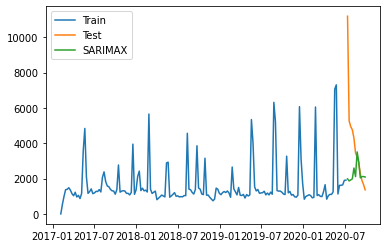

Current product:  15112


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.45093D+00    |proj g|=  2.83446D-01

At iterate    5    f=  8.37646D+00    |proj g|=  6.22777D-03

At iterate   10    f=  8.37568D+00    |proj g|=  7.41955D-04

At iterate   15    f=  8.37567D+00    |proj g|=  1.71619D-03

At iterate   20    f=  8.37456D+00    |proj g|=  2.28200D-02

At iterate   25    f=  8.34105D+00    |proj g|=  6.08327D-02

At iterate   30    f=  8.32055D+00    |proj g|=  9.42794D-03

At iterate   35    f=  8.31834D+00    |proj g|=  6.06794D-03

At iterate   40    f=  8.31790D+00    |proj g|=  1.45585D-03

At iterate   45    f=  8.31777D+00    |proj g|=  2.31203D-04

At iterate   50    f=  8.31774D+00    |proj g|=  1.67605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.40007D+00    |proj g|=  1.36125D-02

At iterate   10    f=  8.39911D+00    |proj g|=  2.27102D-04

At iterate   15    f=  8.39907D+00    |proj g|=  3.07074D-03

At iterate   20    f=  8.39476D+00    |proj g|=  2.96393D-02

At iterate   25    f=  8.37697D+00    |proj g|=  8.49647D-03

At iterate   30    f=  8.37487D+00    |proj g|=  1.59676D-02

At iterate   35    f=  8.37120D+00    |proj g|=  6.55690D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     47      1     0     0   1.747D-05   8.371D+00
  F =   8.3711278179781416     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.39912D+00    |proj g|=  2.39136D-04

At iterate   10    f=  8.39882D+00    |proj g|=  1.10374D-02

At iterate   15    f=  8.37742D+00    |proj g|=  6.81661D-02

At iterate   20    f=  8.37143D+00    |proj g|=  5.69452D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   1.885D-05   8.371D+00
  F =   8.3714287860456711     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1179.7187009060128
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exac

 This problem is unconstrained.


rmse:  1467.9931184283078
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38702D+00    |proj g|=  7.00585D-02


 This problem is unconstrained.



At iterate    5    f=  8.37949D+00    |proj g|=  2.35586D-03

At iterate   10    f=  8.37947D+00    |proj g|=  8.66013D-04

At iterate   15    f=  8.37911D+00    |proj g|=  1.43415D-02

At iterate   20    f=  8.35494D+00    |proj g|=  7.97064D-02

At iterate   25    f=  8.34401D+00    |proj g|=  8.80286D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     30      1     0     0   1.762D-05   8.344D+00
  F =   8.3440111261741361     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1232.144504721467
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate    5    f=  8.45860D+00    |proj g|=  2.37359D-02

At iterate   10    f=  8.44894D+00    |proj g|=  3.90785D-03

At iterate   15    f=  8.44892D+00    |proj g|=  2.54251D-04

At iterate   20    f=  8.44873D+00    |proj g|=  5.96228D-03

At iterate   25    f=  8.43411D+00    |proj g|=  3.75813D-02

At iterate   30    f=  8.41996D+00    |proj g|=  3.77313D-02

At iterate   35    f=  8.41854D+00    |proj g|=  2.38005D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     45      1     0     0   2.634D-05   8.419D+00
  F =   8.4185226265950490     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.41936D+00    |proj g|=  1.66637D-02

At iterate   10    f=  8.41385D+00    |proj g|=  3.21404D-04

At iterate   15    f=  8.41382D+00    |proj g|=  1.31122D-03

At iterate   20    f=  8.40900D+00    |proj g|=  1.84832D-02

At iterate   25    f=  8.38006D+00    |proj g|=  7.13984D-03

At iterate   30    f=  8.37146D+00    |proj g|=  1.24621D-02

At iterate   35    f=  8.35690D+00    |proj g|=  8.25988D-03

At iterate   40    f=  8.35490D+00    |proj g|=  2.67464D-03

At iterate   45    f=  8.35453D+00    |proj g|=  1.61512D-03

At iterate   50    f=  8.35446D+00    |proj g|=  7.77542D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.44878D+00    |proj g|=  1.70370D-02

At iterate   10    f=  8.44292D+00    |proj g|=  1.17998D-03

At iterate   15    f=  8.44290D+00    |proj g|=  4.65230D-04

At iterate   20    f=  8.44239D+00    |proj g|=  6.96343D-03

At iterate   25    f=  8.41604D+00    |proj g|=  8.88601D-03

At iterate   30    f=  8.40730D+00    |proj g|=  3.45726D-02

At iterate   35    f=  8.39549D+00    |proj g|=  7.15885D-03

At iterate   40    f=  8.39312D+00    |proj g|=  1.99793D-03

At iterate   45    f=  8.39055D+00    |proj g|=  1.18398D-02

At iterate   50    f=  8.38782D+00    |proj g|=  2.01955D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51848D+00    |proj g|=  2.18670D-01

At iterate    5    f=  8.45057D+00    |proj g|=  1.48375D-02

At iterate   10    f=  8.44284D+00    |proj g|=  1.77218D-03

At iterate   15    f=  8.44273D+00    |proj g|=  2.25980D-04

At iterate   20    f=  8.44266D+00    |proj g|=  1.01551D-02

At iterate   25    f=  8.43336D+00    |proj g|=  6.53058D-02

At iterate   30    f=  8.39291D+00    |proj g|=  1.68042D-02

At iterate   35    f=  8.38828D+00    |proj g|=  1.26184D-02

At iterate   40    f=  8.38636D+00    |proj g|=  1.70882D-03

At iterate   45    f=  8.38522D+00    |proj g|=  2.33232D-03

At iterate   50    f=  8.38498D+00    |proj g|=  2.33558D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.45610D+00    |proj g|=  3.79521D-03

At iterate   10    f=  8.45606D+00    |proj g|=  3.94787D-04

At iterate   15    f=  8.45594D+00    |proj g|=  4.58835D-03

At iterate   20    f=  8.42286D+00    |proj g|=  8.91332D-02

At iterate   25    f=  8.40050D+00    |proj g|=  1.89173D-03

At iterate   30    f=  8.39909D+00    |proj g|=  2.02533D-03

At iterate   35    f=  8.39845D+00    |proj g|=  1.73621D-03

At iterate   40    f=  8.39826D+00    |proj g|=  4.19912D-04

At iterate   45    f=  8.39822D+00    |proj g|=  1.74706D-04

At iterate   50    f=  8.39704D+00    |proj g|=  1.80149D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48344D+00    |proj g|=  2.09245D-01

At iterate    5    f=  8.42975D+00    |proj g|=  2.96621D-02

At iterate   10    f=  8.42740D+00    |proj g|=  8.37017D-04

At iterate   15    f=  8.42739D+00    |proj g|=  5.58816D-04

At iterate   20    f=  8.42653D+00    |proj g|=  1.03829D-02

At iterate   25    f=  8.38501D+00    |proj g|=  1.99117D-02

At iterate   30    f=  8.38226D+00    |proj g|=  7.29233D-03

At iterate   35    f=  8.38165D+00    |proj g|=  5.83694D-03

At iterate   40    f=  8.38081D+00    |proj g|=  3.02116D-03

At iterate   45    f=  8.38049D+00    |proj g|=  1.15803D-03

At iterate   50    f=  8.38035D+00    |proj g|=  4.78738D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.37275D+00    |proj g|=  2.13980D-02

At iterate   10    f=  8.37097D+00    |proj g|=  9.69793D-03

At iterate   15    f=  8.36971D+00    |proj g|=  2.71791D-04

At iterate   20    f=  8.36970D+00    |proj g|=  1.81969D-03

At iterate   25    f=  8.36785D+00    |proj g|=  2.67415D-02

At iterate   30    f=  8.32560D+00    |proj g|=  6.53093D-02

At iterate   35    f=  8.31715D+00    |proj g|=  3.96202D-03

At iterate   40    f=  8.31563D+00    |proj g|=  9.48306D-03

At iterate   45    f=  8.31493D+00    |proj g|=  2.90746D-03

At iterate   50    f=  8.31468D+00    |proj g|=  1.21042D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.37340D+00    |proj g|=  9.56375D-04

At iterate   10    f=  8.37315D+00    |proj g|=  1.50963D-02

At iterate   15    f=  8.37266D+00    |proj g|=  2.53960D-04

At iterate   20    f=  8.37264D+00    |proj g|=  2.61724D-03

At iterate   25    f=  8.37053D+00    |proj g|=  3.07977D-02

At iterate   30    f=  8.34164D+00    |proj g|=  3.78257D-02

At iterate   35    f=  8.33728D+00    |proj g|=  7.50256D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     42      1     0     0   1.487D-05   8.337D+00
  F =   8.3372786452955499     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.42001D+00    |proj g|=  1.70885D-02

At iterate   10    f=  8.41381D+00    |proj g|=  1.25136D-03

At iterate   15    f=  8.41380D+00    |proj g|=  2.40307D-04

At iterate   20    f=  8.41376D+00    |proj g|=  3.68672D-03

At iterate   25    f=  8.41001D+00    |proj g|=  1.99300D-02

At iterate   30    f=  8.37407D+00    |proj g|=  1.16863D-02

At iterate   35    f=  8.36102D+00    |proj g|=  2.14523D-02

At iterate   40    f=  8.35716D+00    |proj g|=  9.49949D-03

At iterate   45    f=  8.35499D+00    |proj g|=  2.42674D-03

At iterate   50    f=  8.35492D+00    |proj g|=  9.63239D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.34441D+00    |proj g|=  2.47540D-02

At iterate   10    f=  8.34305D+00    |proj g|=  2.52837D-04

At iterate   15    f=  8.34302D+00    |proj g|=  3.31996D-03

At iterate   20    f=  8.33897D+00    |proj g|=  3.81056D-02

At iterate   25    f=  8.31255D+00    |proj g|=  3.36582D-02

At iterate   30    f=  8.31148D+00    |proj g|=  1.83974D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     34      1     0     0   1.570D-05   8.311D+00
  F =   8.3114765629170595     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  1192.7575333614604


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46058D+00    |proj g|=  2.83704D-01

At iterate    5    f=  8.38918D+00    |proj g|=  4.27672D-03

At iterate   10    f=  8.38912D+00    |proj g|=  2.32437D-04

At iterate   15    f=  8.38895D+00    |proj g|=  7.40163D-03

At iterate   20    f=  8.37201D+00    |proj g|=  7.85126D-02

At iterate   25    f=  8.35628D+00    |proj g|=  2.80780D-02

At iterate   30    f=  8.34856D+00    |proj g|=  1.18274D-02

At iterate   35    f=  8.34712D+00    |proj g|=  6.30431D-04

At iterate   40    f=  8.34669D+00    |proj g|=  6.68513D-04

At iterate   45    f=  8.34657D+00    |proj g|=  2.38717D-04

At iterate   50    f=  8.33196D+00    |proj g|=  5.27987D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46058D+00    |proj g|=  2.83704D-01

At iterate    5    f=  8.38918D+00    |proj g|=  4.27672D-03

At iterate   10    f=  8.38912D+00    |proj g|=  2.32437D-04

At iterate   15    f=  8.38895D+00    |proj g|=  7.40163D-03

At iterate   20    f=  8.37201D+00    |proj g|=  7.85126D-02

At iterate   25    f=  8.35628D+00    |proj g|=  2.80780D-02

At iterate   30    f=  8.34856D+00    |proj g|=  1.18274D-02

At iterate   35    f=  8.34712D+00    |proj g|=  6.30431D-04

At iterate   40    f=  8.34669D+00    |proj g|=  6.68513D-04

At iterate   45    f=  8.34657D+00    |proj g|=  2.38717D-04

At iterate   50    f=  8.33196D+00    |proj g|=  5.27987D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

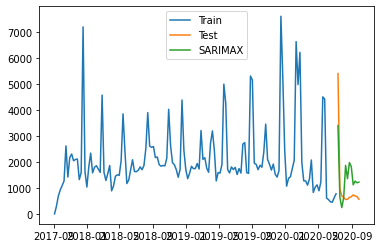

Current product:  14540
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71800D+00    |proj g|=  3.09089D-01


 This problem is unconstrained.



At iterate    5    f=  6.57058D+00    |proj g|=  1.43729D-02

At iterate   10    f=  6.56805D+00    |proj g|=  1.86353D-03

At iterate   15    f=  6.56778D+00    |proj g|=  1.00551D-02

At iterate   20    f=  6.55699D+00    |proj g|=  9.40083D-02

At iterate   25    f=  6.54725D+00    |proj g|=  9.06440D-03

At iterate   30    f=  6.54690D+00    |proj g|=  1.82167D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     36      1     0     0   5.754D-06   6.547D+00
  F =   6.5469027669929423     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  129.23210806565524
RUNNING THE L-BFGS-B CODE

 This problem is unconstrained.



At iterate    5    f=  6.65090D+00    |proj g|=  9.89865D-03

At iterate   10    f=  6.65056D+00    |proj g|=  8.08305D-03

At iterate   15    f=  6.63833D+00    |proj g|=  6.95377D-02

At iterate   20    f=  6.61831D+00    |proj g|=  5.60066D-03

At iterate   25    f=  6.61776D+00    |proj g|=  1.15814D-03

At iterate   30    f=  6.61761D+00    |proj g|=  2.85284D-03

At iterate   35    f=  6.61757D+00    |proj g|=  7.15629D-04

At iterate   40    f=  6.61757D+00    |proj g|=  1.87848D-03

At iterate   45    f=  6.61756D+00    |proj g|=  9.70878D-05

At iterate   50    f=  6.61675D+00    |proj g|=  1.73627D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.67274D+00    |proj g|=  2.85235D-03

At iterate   10    f=  6.67272D+00    |proj g|=  9.14793D-03

At iterate   15    f=  6.67102D+00    |proj g|=  9.26693D-02

At iterate   20    f=  6.66691D+00    |proj g|=  2.64483D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     25      1     0     0   1.016D-05   6.667D+00
  F =   6.6669091241477219     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  153.8290092930192
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exact

 This problem is unconstrained.



At iterate    5    f=  6.63178D+00    |proj g|=  3.60502D-04

At iterate   10    f=  6.63174D+00    |proj g|=  4.15827D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   7.586D-06   6.632D+00
  F =   6.6317014354490933     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  171.4933595118165


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62666D+00    |proj g|=  2.16163D-01

At iterate    5    f=  6.59758D+00    |proj g|=  4.56356D-02

At iterate   10    f=  6.59412D+00    |proj g|=  1.00527D-03

At iterate   15    f=  6.59405D+00    |proj g|=  1.88672D-02

At iterate   20    f=  6.59038D+00    |proj g|=  8.00597D-02

At iterate   25    f=  6.58790D+00    |proj g|=  2.49613D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     30      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.90873D+00    |proj g|=  2.98734D-02

At iterate   10    f=  6.90240D+00    |proj g|=  2.67719D-03

At iterate   15    f=  6.90230D+00    |proj g|=  1.98919D-02

At iterate   20    f=  6.89676D+00    |proj g|=  1.29711D-01

At iterate   25    f=  6.89247D+00    |proj g|=  2.67883D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     33      1     0     0   1.321D-05   6.892D+00
  F =   6.8924688765628375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  173.2009118304767


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.08848D+00    |proj g|=  3.96630D-01

At iterate    5    f=  6.86944D+00    |proj g|=  2.72684D-03

At iterate   10    f=  6.86830D+00    |proj g|=  1.07599D-02

At iterate   15    f=  6.86727D+00    |proj g|=  4.07882D-03

At iterate   20    f=  6.83639D+00    |proj g|=  3.02542D-02

At iterate   25    f=  6.83480D+00    |proj g|=  2.32996D-03

At iterate   30    f=  6.83221D+00    |proj g|=  2.81097D-03

At iterate   35    f=  6.83217D+00    |proj g|=  2.44411D-04

At iterate   40    f=  6.83213D+00    |proj g|=  1.44908D-03

At iterate   45    f=  6.83210D+00    |proj g|=  5.69896D-04

At iterate   50    f=  6.83209D+00    |proj g|=  4.59293D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.88194D+00    |proj g|=  7.95599D-03

At iterate   10    f=  6.88058D+00    |proj g|=  2.04755D-03

At iterate   15    f=  6.87038D+00    |proj g|=  4.19438D-02

At iterate   20    f=  6.83683D+00    |proj g|=  1.38762D-02

At iterate   25    f=  6.82941D+00    |proj g|=  4.06144D-04

At iterate   30    f=  6.82930D+00    |proj g|=  1.48171D-03

At iterate   35    f=  6.82921D+00    |proj g|=  6.07560D-04

At iterate   40    f=  6.82918D+00    |proj g|=  4.46609D-04

At iterate   45    f=  6.82918D+00    |proj g|=  2.85211D-04

At iterate   50    f=  6.82917D+00    |proj g|=  2.19596D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.88507D+00    |proj g|=  3.17108D-02

At iterate   10    f=  6.88058D+00    |proj g|=  6.52731D-03

At iterate   15    f=  6.88019D+00    |proj g|=  8.53419D-03

At iterate   20    f=  6.86648D+00    |proj g|=  2.50345D-01

At iterate   25    f=  6.83179D+00    |proj g|=  3.57864D-02

At iterate   30    f=  6.82844D+00    |proj g|=  8.78590D-03

At iterate   35    f=  6.82818D+00    |proj g|=  2.62350D-02

At iterate   40    f=  6.82808D+00    |proj g|=  8.08009D-03

At iterate   45    f=  6.82799D+00    |proj g|=  1.37851D-03

At iterate   50    f=  6.82796D+00    |proj g|=  1.84166D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.93745D+00    |proj g|=  2.78178D-03

At iterate   10    f=  6.93651D+00    |proj g|=  1.23679D-02

At iterate   15    f=  6.88947D+00    |proj g|=  6.68290D-02

At iterate   20    f=  6.88551D+00    |proj g|=  2.42186D-04

At iterate   25    f=  6.88550D+00    |proj g|=  2.58002D-03

At iterate   30    f=  6.88537D+00    |proj g|=  6.55247D-04

At iterate   35    f=  6.88534D+00    |proj g|=  2.83888D-03

At iterate   40    f=  6.88529D+00    |proj g|=  1.01695D-03

At iterate   45    f=  6.87854D+00    |proj g|=  2.27371D-02

At iterate   50    f=  6.87775D+00    |proj g|=  6.31347D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.88580D+00    |proj g|=  2.82716D-02

At iterate   10    f=  6.87470D+00    |proj g|=  8.83592D-02

At iterate   15    f=  6.87416D+00    |proj g|=  1.97553D-03

At iterate   20    f=  6.86865D+00    |proj g|=  4.07750D-02

At iterate   25    f=  6.83579D+00    |proj g|=  8.78949D-02

At iterate   30    f=  6.83185D+00    |proj g|=  6.95647D-02

At iterate   35    f=  6.82908D+00    |proj g|=  6.23019D-02

At iterate   40    f=  6.82861D+00    |proj g|=  1.53846D-02

At iterate   45    f=  6.82847D+00    |proj g|=  1.29458D-02

At iterate   50    f=  6.82839D+00    |proj g|=  2.33749D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.70461D+00    |proj g|=  2.98908D-01

At iterate    5    f=  6.58196D+00    |proj g|=  2.85573D-02

At iterate   10    f=  6.56710D+00    |proj g|=  5.51961D-02

At iterate   15    f=  6.56412D+00    |proj g|=  2.74335D-03

At iterate   20    f=  6.56404D+00    |proj g|=  1.89053D-02

At iterate   25    f=  6.55709D+00    |proj g|=  1.37397D-01

At iterate   30    f=  6.54587D+00    |proj g|=  8.78055D-03

At iterate   35    f=  6.54579D+00    |proj g|=  2.49186D-03

At iterate   40    f=  6.54577D+00    |proj g|=  1.05182D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.62354D+00    |proj g|=  1.61287D-01

At iterate    5    f=  6.60214D+00    |proj g|=  1.62594D-01

At iterate   10    f=  6.59372D+00    |proj g|=  9.11027D-03

At iterate   15    f=  6.59363D+00    |proj g|=  2.25126D-03

At iterate   20    f=  6.59258D+00    |proj g|=  3.70227D-02

At iterate   25    f=  6.59019D+00    |proj g|=  1.87553D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     31      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.08848D+00    |proj g|=  3.96630D-01

At iterate    5    f=  6.87282D+00    |proj g|=  2.34802D-02

At iterate   10    f=  6.86874D+00    |proj g|=  1.86896D-03

At iterate   15    f=  6.86808D+00    |proj g|=  1.15310D-02

At iterate   20    f=  6.86669D+00    |proj g|=  9.16120D-03

At iterate   25    f=  6.86643D+00    |proj g|=  1.14071D-02

At iterate   30    f=  6.84437D+00    |proj g|=  5.43285D-02

At iterate   35    f=  6.83239D+00    |proj g|=  4.48131D-02

At iterate   40    f=  6.83046D+00    |proj g|=  8.16185D-03

At iterate   45    f=  6.82992D+00    |proj g|=  2.66668D-03

At iterate   50    f=  6.82981D+00    |proj g|=  2.32496D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78427D+00    |proj g|=  4.76824D-01

At iterate    5    f=  6.57318D+00    |proj g|=  1.95761D-02

At iterate   10    f=  6.56370D+00    |proj g|=  2.41260D-02

At iterate   15    f=  6.56305D+00    |proj g|=  2.18023D-03

At iterate   20    f=  6.56281D+00    |proj g|=  1.82227D-02

At iterate   25    f=  6.55943D+00    |proj g|=  2.44317D-02

At iterate   30    f=  6.55908D+00    |proj g|=  1.03547D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  6.56961D+00    |proj g|=  1.16422D-02

At iterate   10    f=  6.56820D+00    |proj g|=  3.54533D-03

At iterate   15    f=  6.55856D+00    |proj g|=  1.04943D-01

At iterate   20    f=  6.54843D+00    |proj g|=  4.84241D-03

At iterate   25    f=  6.54829D+00    |proj g|=  5.79659D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     31      1     0     0   2.705D-05   6.548D+00
  F =   6.5482935459169633     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  133.0820027659342
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate    5    f=  6.93745D+00    |proj g|=  2.78178D-03

At iterate   10    f=  6.93651D+00    |proj g|=  1.23679D-02

At iterate   15    f=  6.88947D+00    |proj g|=  6.68290D-02

At iterate   20    f=  6.88551D+00    |proj g|=  2.42186D-04

At iterate   25    f=  6.88550D+00    |proj g|=  2.58002D-03

At iterate   30    f=  6.88537D+00    |proj g|=  6.55247D-04

At iterate   35    f=  6.88534D+00    |proj g|=  2.83888D-03

At iterate   40    f=  6.88529D+00    |proj g|=  1.01695D-03

At iterate   45    f=  6.87854D+00    |proj g|=  2.27371D-02

At iterate   50    f=  6.87775D+00    |proj g|=  6.31347D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

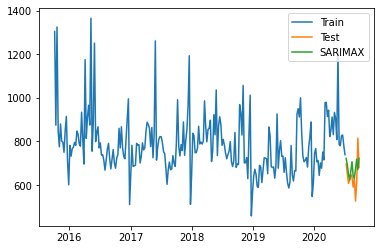

Current product:  14251


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.64627D+00    |proj g|=  1.85124D-01

At iterate    5    f=  8.60302D+00    |proj g|=  2.11113D-02

At iterate   10    f=  8.59004D+00    |proj g|=  2.70947D-02

At iterate   15    f=  8.58180D+00    |proj g|=  7.52345D-03

At iterate   20    f=  8.58147D+00    |proj g|=  2.49967D-04

At iterate   25    f=  8.58143D+00    |proj g|=  2.92816D-03

At iterate   30    f=  8.57541D+00    |proj g|=  4.67501D-02

At iterate   35    f=  8.52424D+00    |proj g|=  1.77912D-02

At iterate   40    f=  8.50844D+00    |proj g|=  8.23395D-03

At iterate   45    f=  8.50599D+00    |proj g|=  2.69151D-03

At iterate   50    f=  8.50597D+00    |proj g|=  1.41641D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.64880D+00    |proj g|=  1.93550D-01

At iterate    5    f=  8.60612D+00    |proj g|=  1.16755D-03

At iterate   10    f=  8.60611D+00    |proj g|=  9.49295D-04

At iterate   15    f=  8.60590D+00    |proj g|=  1.34446D-02

At iterate   20    f=  8.58920D+00    |proj g|=  6.43813D-02

At iterate   25    f=  8.58166D+00    |proj g|=  1.56738D-02

At iterate   30    f=  8.57627D+00    |proj g|=  9.30827D-04

At iterate   35    f=  8.57544D+00    |proj g|=  4.66801D-03

At iterate   40    f=  8.57525D+00    |proj g|=  5.64393D-04

At iterate   45    f=  8.57523D+00    |proj g|=  3.68033D-04

At iterate   50    f=  8.57523D+00    |proj g|=  4.28685D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.60834D+00    |proj g|=  1.49996D-04

At iterate   10    f=  8.60832D+00    |proj g|=  2.93826D-03

At iterate   15    f=  8.60543D+00    |proj g|=  2.87582D-02

At iterate   20    f=  8.59294D+00    |proj g|=  3.09438D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     24      1     0     0   1.412D-05   8.593D+00
  F =   8.5929383248908504     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  2324.6358490450075
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exac

 This problem is unconstrained.



At iterate    5    f=  8.61536D+00    |proj g|=  5.60144D-04

At iterate   10    f=  8.61529D+00    |proj g|=  9.31852D-03

At iterate   15    f=  8.61078D+00    |proj g|=  5.03316D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     21      1     0     0   6.203D-06   8.608D+00
  F =   8.6082128066911476     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  2443.4132353583173
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.60837D+00    |proj

 This problem is unconstrained.



At iterate    5    f=  8.60721D+00    |proj g|=  4.04517D-02

At iterate   10    f=  8.59204D+00    |proj g|=  6.62632D-03

At iterate   15    f=  8.59104D+00    |proj g|=  4.48172D-04

At iterate   20    f=  8.59030D+00    |proj g|=  4.20619D-03

At iterate   25    f=  8.54546D+00    |proj g|=  1.62074D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     39      1     0     0   1.753D-06   8.545D+00
  F =   8.5448471535196795     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  967.6833928863368


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65667D+00    |proj g|=  7.97586D-02

At iterate    5    f=  8.63651D+00    |proj g|=  6.37825D-03

At iterate   10    f=  8.63612D+00    |proj g|=  1.57860D-04

At iterate   15    f=  8.63605D+00    |proj g|=  4.05345D-03

At iterate   20    f=  8.63039D+00    |proj g|=  2.74737D-02

At iterate   25    f=  8.61892D+00    |proj g|=  9.38181D-03

At iterate   30    f=  8.61608D+00    |proj g|=  2.89685D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.67505D+00    |proj g|=  1.73103D-01

At iterate    5    f=  8.62540D+00    |proj g|=  5.45281D-03

At iterate   10    f=  8.62520D+00    |proj g|=  1.16184D-03

At iterate   15    f=  8.62517D+00    |proj g|=  2.61483D-04

At iterate   20    f=  8.62509D+00    |proj g|=  3.79260D-03

At iterate   25    f=  8.60041D+00    |proj g|=  2.85534D-02

At iterate   30    f=  8.55356D+00    |proj g|=  1.48864D-02

At iterate   35    f=  8.53212D+00    |proj g|=  4.23754D-03

At iterate   40    f=  8.53089D+00    |proj g|=  1.22485D-03

At iterate   45    f=  8.53074D+00    |proj g|=  5.58593D-04

At iterate   50    f=  8.53067D+00    |proj g|=  8.99717D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.63137D+00    |proj g|=  1.47681D-02

At iterate   10    f=  8.63049D+00    |proj g|=  1.08119D-03

At iterate   15    f=  8.63044D+00    |proj g|=  4.97131D-04

At iterate   20    f=  8.63041D+00    |proj g|=  2.75394D-03

At iterate   25    f=  8.62762D+00    |proj g|=  2.83131D-02

At iterate   30    f=  8.59730D+00    |proj g|=  5.80664D-02

At iterate   35    f=  8.58122D+00    |proj g|=  1.72387D-02

At iterate   40    f=  8.57106D+00    |proj g|=  8.01680D-03

At iterate   45    f=  8.56288D+00    |proj g|=  1.91941D-03

At iterate   50    f=  8.56208D+00    |proj g|=  9.51920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68070D+00    |proj g|=  1.72247D-01

At iterate    5    f=  8.63536D+00    |proj g|=  1.19599D-02

At iterate   10    f=  8.63014D+00    |proj g|=  2.39004D-03

At iterate   15    f=  8.62986D+00    |proj g|=  1.39725D-03

At iterate   20    f=  8.62979D+00    |proj g|=  2.08615D-04

At iterate   25    f=  8.62967D+00    |proj g|=  4.03867D-03

At iterate   30    f=  8.61190D+00    |proj g|=  5.54557D-02

At iterate   35    f=  8.57636D+00    |proj g|=  1.25178D-02

At iterate   40    f=  8.56875D+00    |proj g|=  1.53798D-03

At iterate   45    f=  8.56745D+00    |proj g|=  1.58080D-03

At iterate   50    f=  8.56722D+00    |proj g|=  1.60574D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.67626D+00    |proj g|=  1.71813D-01

At iterate    5    f=  8.62771D+00    |proj g|=  4.54236D-03

At iterate   10    f=  8.62754D+00    |proj g|=  6.16676D-04

At iterate   15    f=  8.62752D+00    |proj g|=  6.06768D-04

At iterate   20    f=  8.62721D+00    |proj g|=  7.85035D-03

At iterate   25    f=  8.59529D+00    |proj g|=  6.09981D-02

At iterate   30    f=  8.57212D+00    |proj g|=  4.10391D-03

At iterate   35    f=  8.56759D+00    |proj g|=  9.19324D-04

At iterate   40    f=  8.56701D+00    |proj g|=  8.69380D-04

At iterate   45    f=  8.56693D+00    |proj g|=  5.25216D-04

At iterate   50    f=  8.56691D+00    |proj g|=  2.67595D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  8.65131D+00    |proj g|=  3.07683D-02

At iterate   10    f=  8.64748D+00    |proj g|=  9.68790D-03

At iterate   15    f=  8.63974D+00    |proj g|=  1.55759D-02

At iterate   20    f=  8.63610D+00    |proj g|=  4.44339D-04

At iterate   25    f=  8.63610D+00    |proj g|=  7.60190D-04

At iterate   30    f=  8.63582D+00    |proj g|=  1.26431D-02

At iterate   35    f=  8.62563D+00    |proj g|=  4.61759D-02

At iterate   40    f=  8.61677D+00    |proj g|=  2.31236D-03

At iterate   45    f=  8.61664D+00    |proj g|=  2.60511D-03

At iterate   50    f=  8.61646D+00    |proj g|=  1.70794D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.58418D+00    |proj g|=  1.86853D-02

At iterate   10    f=  8.58118D+00    |proj g|=  7.75936D-04

At iterate   15    f=  8.58117D+00    |proj g|=  4.68442D-04

At iterate   20    f=  8.58004D+00    |proj g|=  6.03107D-03

At iterate   25    f=  8.51688D+00    |proj g|=  4.14825D-02

At iterate   30    f=  8.51018D+00    |proj g|=  2.18544D-02

At iterate   35    f=  8.50609D+00    |proj g|=  5.66992D-03

At iterate   40    f=  8.50549D+00    |proj g|=  1.73057D-03

At iterate   45    f=  8.50539D+00    |proj g|=  2.76397D-04

At iterate   50    f=  8.50537D+00    |proj g|=  2.14826D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.59334D+00    |proj g|=  8.33060D-03

At iterate   10    f=  8.59199D+00    |proj g|=  2.40318D-04

At iterate   15    f=  8.59197D+00    |proj g|=  1.15569D-03

At iterate   20    f=  8.58894D+00    |proj g|=  3.70328D-02

At iterate   25    f=  8.54787D+00    |proj g|=  1.92589D-02

At iterate   30    f=  8.54578D+00    |proj g|=  1.91617D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     35      1     0     0   1.180D-06   8.546D+00
  F =   8.5457804632823287     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  991.1220464479244
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



At iterate    5    f=  8.62899D+00    |proj g|=  1.29599D-02

At iterate   10    f=  8.62442D+00    |proj g|=  2.27598D-03

At iterate   15    f=  8.62423D+00    |proj g|=  1.48287D-03

At iterate   20    f=  8.62421D+00    |proj g|=  2.19199D-04

At iterate   25    f=  8.62306D+00    |proj g|=  1.23261D-02

At iterate   30    f=  8.55023D+00    |proj g|=  5.09009D-02

At iterate   35    f=  8.53249D+00    |proj g|=  6.25676D-03

At iterate   40    f=  8.53075D+00    |proj g|=  2.16554D-03

At iterate   45    f=  8.53059D+00    |proj g|=  2.84655D-04

At iterate   50    f=  8.53055D+00    |proj g|=  7.17505D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.59918D+00    |proj g|=  4.69998D-02

At iterate    5    f=  8.59055D+00    |proj g|=  1.33626D-02

At iterate   10    f=  8.58208D+00    |proj g|=  5.29450D-03

At iterate   15    f=  8.58175D+00    |proj g|=  2.27240D-04

At iterate   20    f=  8.58167D+00    |proj g|=  2.49944D-03

At iterate   25    f=  8.57046D+00    |proj g|=  7.58885D-02

At iterate   30    f=  8.53808D+00    |proj g|=  2.70106D-02

At iterate   35    f=  8.53696D+00    |proj g|=  4.63469D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.64613D+00    |proj g|=  1.85151D-01

At iterate    5    f=  8.60468D+00    |proj g|=  5.11655D-03

At iterate   10    f=  8.60462D+00    |proj g|=  3.68678D-04

At iterate   15    f=  8.60447D+00    |proj g|=  6.95974D-03

At iterate   20    f=  8.58817D+00    |proj g|=  9.12166D-02

At iterate   25    f=  8.55959D+00    |proj g|=  2.12784D-02

At iterate   30    f=  8.55468D+00    |proj g|=  4.41987D-04

At iterate   35    f=  8.55415D+00    |proj g|=  6.82431D-04

At iterate   40    f=  8.55403D+00    |proj g|=  4.14772D-04

At iterate   45    f=  8.55401D+00    |proj g|=  4.30346D-05

At iterate   50    f=  8.55400D+00    |proj g|=  8.10925D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65196D+00    |proj g|=  1.83005D-01

At iterate    5    f=  8.58418D+00    |proj g|=  1.86853D-02

At iterate   10    f=  8.58118D+00    |proj g|=  7.75936D-04

At iterate   15    f=  8.58117D+00    |proj g|=  4.68442D-04

At iterate   20    f=  8.58004D+00    |proj g|=  6.03107D-03

At iterate   25    f=  8.51688D+00    |proj g|=  4.14825D-02

At iterate   30    f=  8.51018D+00    |proj g|=  2.18544D-02

At iterate   35    f=  8.50609D+00    |proj g|=  5.66992D-03

At iterate   40    f=  8.50549D+00    |proj g|=  1.73057D-03

At iterate   45    f=  8.50539D+00    |proj g|=  2.76397D-04

At iterate   50    f=  8.50537D+00    |proj g|=  2.14826D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

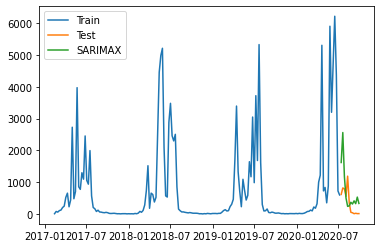

Current product:  14490


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09690D+00    |proj g|=  5.82592D-02

At iterate    5    f=  7.08150D+00    |proj g|=  1.29448D-02

At iterate   10    f=  7.07429D+00    |proj g|=  1.36534D-03

At iterate   15    f=  7.07395D+00    |proj g|=  7.61007D-04

At iterate   20    f=  7.06755D+00    |proj g|=  3.86501D-02

At iterate   25    f=  7.06044D+00    |proj g|=  3.11175D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     35      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11692D+00    |proj g|=  6.38732D-02

At iterate    5    f=  7.11330D+00    |proj g|=  3.81562D-03

At iterate   10    f=  7.11328D+00    |proj g|=  2.18426D-03

At iterate   15    f=  7.11213D+00    |proj g|=  3.25277D-02

At iterate   20    f=  7.10690D+00    |proj g|=  3.47759D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   6.419D-06   7.107D+00
  F =   7.1068709742400973     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11669D+00    |proj g|=  5.81857D-02

At iterate    5    f=  7.11501D+00    |proj g|=  5.34555D-04

At iterate   10    f=  7.11488D+00    |proj g|=  1.55453D-02

At iterate   15    f=  7.10948D+00    |proj g|=  4.87997D-02

At iterate   20    f=  7.10860D+00    |proj g|=  6.82281D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     22      1     0     0   6.823D-06   7.109D+00
  F =   7.1086036355771647     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.07770D+00    |proj g|=  1.15043D-03

At iterate   10    f=  7.07764D+00    |proj g|=  1.65530D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   4.851D-06   7.078D+00
  F =   7.0776403206047069     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  203.0618541249265


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09194D+00    |proj g|=  6.07478D-02

At iterate    5    f=  7.08354D+00    |proj g|=  2.80656D-03

At iterate   10    f=  7.08256D+00    |proj g|=  7.01522D-04

At iterate   15    f=  7.07652D+00    |proj g|=  3.58471D-02

At iterate   20    f=  7.06909D+00    |proj g|=  8.71761D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   3.954D-05   7.069D+00
  F =   7.0690878225512890     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.29390D+00    |proj g|=  1.99097D-02

At iterate   10    f=  7.28937D+00    |proj g|=  1.06824D-02

At iterate   15    f=  7.28813D+00    |proj g|=  5.86702D-03

At iterate   20    f=  7.27030D+00    |proj g|=  4.05935D-02

At iterate   25    f=  7.27013D+00    |proj g|=  5.00200D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     31      1     0     0   5.002D-05   7.270D+00
  F =   7.2701345435465754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  163.1988091227783
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate    5    f=  7.27256D+00    |proj g|=  2.07063D-02

At iterate   10    f=  7.27160D+00    |proj g|=  2.43565D-03

At iterate   15    f=  7.26627D+00    |proj g|=  2.52514D-02

At iterate   20    f=  7.24594D+00    |proj g|=  7.61804D-03

At iterate   25    f=  7.24339D+00    |proj g|=  8.03275D-03

At iterate   30    f=  7.24284D+00    |proj g|=  8.41083D-04

At iterate   35    f=  7.24282D+00    |proj g|=  1.05116D-03

At iterate   40    f=  7.24274D+00    |proj g|=  5.51060D-03

At iterate   45    f=  7.24253D+00    |proj g|=  1.09872D-03

At iterate   50    f=  7.24240D+00    |proj g|=  7.62359D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.28649D+00    |proj g|=  6.43893D-03

At iterate   10    f=  7.28197D+00    |proj g|=  4.52656D-03

At iterate   15    f=  7.28106D+00    |proj g|=  2.55460D-03

At iterate   20    f=  7.26042D+00    |proj g|=  4.11991D-02

At iterate   25    f=  7.25109D+00    |proj g|=  4.22194D-03

At iterate   30    f=  7.25100D+00    |proj g|=  2.89779D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     37      1     0     0   1.864D-05   7.251D+00
  F =   7.2509996564928016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  158.51631664381304


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31425D+00    |proj g|=  1.42274D-01

At iterate    5    f=  7.28743D+00    |proj g|=  6.16755D-03

At iterate   10    f=  7.28409D+00    |proj g|=  2.36007D-02

At iterate   15    f=  7.28174D+00    |proj g|=  9.13605D-03

At iterate   20    f=  7.28112D+00    |proj g|=  1.31831D-03

At iterate   25    f=  7.25478D+00    |proj g|=  3.85230D-02

At iterate   30    f=  7.25113D+00    |proj g|=  7.62449D-03

At iterate   35    f=  7.25091D+00    |proj g|=  8.18658D-04

At iterate   40    f=  7.25091D+00    |proj g|=  1.03911D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  7.30371D+00    |proj g|=  6.52123D-04

At iterate   10    f=  7.30354D+00    |proj g|=  6.38991D-03

At iterate   15    f=  7.29605D+00    |proj g|=  3.52273D-02

At iterate   20    f=  7.28974D+00    |proj g|=  5.91475D-03

At iterate   25    f=  7.28961D+00    |proj g|=  1.95588D-04

At iterate   30    f=  7.28955D+00    |proj g|=  6.45397D-04

At iterate   35    f=  7.28952D+00    |proj g|=  1.34505D-04

At iterate   40    f=  7.28949D+00    |proj g|=  4.95925D-04

At iterate   45    f=  7.28947D+00    |proj g|=  1.30072D-04

At iterate   50    f=  7.28768D+00    |proj g|=  1.72616D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.37566D+00    |proj g|=  2.57830D-01

At iterate    5    f=  7.28858D+00    |proj g|=  2.44907D-02

At iterate   10    f=  7.28663D+00    |proj g|=  2.63362D-03

At iterate   15    f=  7.28412D+00    |proj g|=  1.74545D-02

At iterate   20    f=  7.28244D+00    |proj g|=  3.12106D-02

At iterate   25    f=  7.27100D+00    |proj g|=  3.46198D-02

At iterate   30    f=  7.25644D+00    |proj g|=  1.73412D-02

At iterate   35    f=  7.25608D+00    |proj g|=  7.04427D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     40      1     0

 This problem is unconstrained.



At iterate    5    f=  7.07872D+00    |proj g|=  9.11524D-03

At iterate   10    f=  7.07340D+00    |proj g|=  1.21644D-02

At iterate   15    f=  7.07240D+00    |proj g|=  3.29998D-03

At iterate   20    f=  7.07218D+00    |proj g|=  2.74129D-03

At iterate   25    f=  7.05897D+00    |proj g|=  2.51550D-02

At iterate   30    f=  7.05832D+00    |proj g|=  2.87883D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     36      1     0     0   5.877D-06   7.058D+00
  F =   7.0583172906322433     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  161.89957183692187
RUNNING THE L-BFGS-B CODE

 This problem is unconstrained.



At iterate    5    f=  7.09036D+00    |proj g|=  5.38226D-03

At iterate   10    f=  7.08570D+00    |proj g|=  5.91390D-03

At iterate   15    f=  7.08476D+00    |proj g|=  6.79633D-03

At iterate   20    f=  7.07619D+00    |proj g|=  4.67758D-02

At iterate   25    f=  7.07194D+00    |proj g|=  5.79288D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     29      1     0     0   5.793D-06   7.072D+00
  F =   7.0719449407380601     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  165.49688918053187


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31418D+00    |proj g|=  1.42530D-01

At iterate    5    f=  7.27359D+00    |proj g|=  1.53061D-02

At iterate   10    f=  7.27164D+00    |proj g|=  9.60617D-04

At iterate   15    f=  7.27131D+00    |proj g|=  1.37502D-02

At iterate   20    f=  7.26687D+00    |proj g|=  4.11772D-03

At iterate   25    f=  7.26033D+00    |proj g|=  2.07134D-02

At iterate   30    f=  7.24347D+00    |proj g|=  1.35752D-02

At iterate   35    f=  7.24262D+00    |proj g|=  2.36015D-03

At iterate   40    f=  7.24256D+00    |proj g|=  3.77972D-04

At iterate   45    f=  7.24256D+00    |proj g|=  5.71790D-04

At iterate   50    f=  7.24254D+00    |proj g|=  7.67046D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.08770D+00    |proj g|=  4.22618D-02

At iterate    5    f=  7.07732D+00    |proj g|=  7.85150D-04

At iterate   10    f=  7.07697D+00    |proj g|=  7.22041D-03

At iterate   15    f=  7.07596D+00    |proj g|=  3.85787D-02

At iterate   20    f=  7.06212D+00    |proj g|=  1.52935D-02

At iterate   25    f=  7.06102D+00    |proj g|=  1.80893D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     34      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  7.09158D+00    |proj g|=  5.96655D-03

At iterate   10    f=  7.09138D+00    |proj g|=  7.73307D-04

At iterate   15    f=  7.09067D+00    |proj g|=  1.63388D-02

At iterate   20    f=  7.08440D+00    |proj g|=  8.57300D-03

At iterate   25    f=  7.08336D+00    |proj g|=  6.82157D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     28      1     0     0   6.822D-06   7.083D+00
  F =   7.0833635728996471     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  179.86021840734873
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.



At iterate    5    f=  7.28649D+00    |proj g|=  6.43893D-03

At iterate   10    f=  7.28197D+00    |proj g|=  4.52656D-03

At iterate   15    f=  7.28106D+00    |proj g|=  2.55460D-03

At iterate   20    f=  7.26042D+00    |proj g|=  4.11991D-02

At iterate   25    f=  7.25109D+00    |proj g|=  4.22194D-03

At iterate   30    f=  7.25100D+00    |proj g|=  2.89779D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     37      1     0     0   1.864D-05   7.251D+00
  F =   7.2509996564928016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

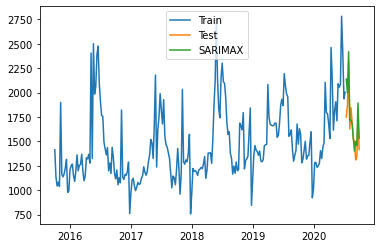

Current product:  10017
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23911D+00    |proj g|=  3.80996D-01


 This problem is unconstrained.



At iterate    5    f=  5.96234D+00    |proj g|=  1.21498D-01

At iterate   10    f=  5.95518D+00    |proj g|=  1.58816D-02

At iterate   15    f=  5.95390D+00    |proj g|=  9.82460D-03

At iterate   20    f=  5.95137D+00    |proj g|=  2.17480D-01

At iterate   25    f=  5.93112D+00    |proj g|=  7.47418D-02

At iterate   30    f=  5.93022D+00    |proj g|=  7.19038D-03

At iterate   35    f=  5.92970D+00    |proj g|=  2.07954D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     46      1     0     0   4.849D-05   5.930D+00
  F =   5.9296980772457619     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26119D+00    |proj g|=  3.36320D-01

At iterate    5    f=  6.01899D+00    |proj g|=  1.87149D-02

At iterate   10    f=  6.01861D+00    |proj g|=  2.04684D-02

At iterate   15    f=  6.00822D+00    |proj g|=  5.69279D-02

At iterate   20    f=  5.99032D+00    |proj g|=  3.15611D-03

At iterate   25    f=  5.99027D+00    |proj g|=  4.63843D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     34      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.06356D+00    |proj g|=  1.08298D-02

At iterate   10    f=  6.06342D+00    |proj g|=  4.57034D-03

At iterate   15    f=  6.06310D+00    |proj g|=  8.24239D-02

At iterate   20    f=  6.05774D+00    |proj g|=  2.56351D-02

At iterate   25    f=  6.05769D+00    |proj g|=  6.21716D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   6.217D-05   6.058D+00
  F =   6.0576932476904135     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  74.89495546915319
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate    5    f=  5.99681D+00    |proj g|=  7.29745D-04

At iterate   10    f=  5.99680D+00    |proj g|=  9.52873D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   9.529D-06   5.997D+00
  F =   5.9968018149851927     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
rmse:  75.35743984418535
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20698D+00    |proj g|=  4.24135D-01


 This problem is unconstrained.



At iterate    5    f=  5.98400D+00    |proj g|=  1.70409D-02

At iterate   10    f=  5.98157D+00    |proj g|=  2.39629D-02

At iterate   15    f=  5.98150D+00    |proj g|=  1.16814D-02

At iterate   20    f=  5.98015D+00    |proj g|=  1.45687D-01

At iterate   25    f=  5.97787D+00    |proj g|=  3.44562D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     36      1     0     0   4.289D-05   5.978D+00
  F =   5.9778550545189431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  97.43562231779984
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate    5    f=  6.44390D+00    |proj g|=  2.75109D-02

At iterate   10    f=  6.44022D+00    |proj g|=  6.30475D-03

At iterate   15    f=  6.44007D+00    |proj g|=  1.42808D-02

At iterate   20    f=  6.42747D+00    |proj g|=  1.24263D-01

At iterate   25    f=  6.42551D+00    |proj g|=  2.85937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     39      1     0     0   2.160D-05   6.425D+00
  F =   6.4254903279745577     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
rmse:  89.36663828824405


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.48340D+00    |proj g|=  1.68655D-01

At iterate    5    f=  6.44766D+00    |proj g|=  3.57922D-03

At iterate   10    f=  6.44384D+00    |proj g|=  1.33924D-02

At iterate   15    f=  6.42426D+00    |proj g|=  2.96387D-02

At iterate   20    f=  6.42202D+00    |proj g|=  3.83068D-03

At iterate   25    f=  6.42162D+00    |proj g|=  7.97932D-04

At iterate   30    f=  6.42156D+00    |proj g|=  5.10313D-04

At iterate   35    f=  6.42154D+00    |proj g|=  3.74330D-04

At iterate   40    f=  6.42154D+00    |proj g|=  3.05908D-04

At iterate   45    f=  6.42154D+00    |proj g|=  2.88078D-04

At iterate   50    f=  6.42154D+00    |proj g|=  1.07986D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.43616D+00    |proj g|=  8.98375D-03

At iterate   10    f=  6.43444D+00    |proj g|=  1.04095D-02

At iterate   15    f=  6.41300D+00    |proj g|=  9.94753D-03

At iterate   20    f=  6.41132D+00    |proj g|=  1.00798D-03

At iterate   25    f=  6.41114D+00    |proj g|=  2.32003D-03

At iterate   30    f=  6.41111D+00    |proj g|=  4.20408D-04

At iterate   35    f=  6.41110D+00    |proj g|=  2.73151D-04

At iterate   40    f=  6.41110D+00    |proj g|=  1.75643D-04

At iterate   45    f=  6.41110D+00    |proj g|=  9.56920D-05

At iterate   50    f=  6.41110D+00    |proj g|=  6.92056D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.44526D+00    |proj g|=  6.95073D-02

At iterate   10    f=  6.43817D+00    |proj g|=  5.82120D-02

At iterate   15    f=  6.43588D+00    |proj g|=  1.85500D-02

At iterate   20    f=  6.43530D+00    |proj g|=  3.40958D-03

At iterate   25    f=  6.43377D+00    |proj g|=  7.03632D-02

At iterate   30    f=  6.41122D+00    |proj g|=  1.03212D-01

At iterate   35    f=  6.41035D+00    |proj g|=  3.95166D-03

At iterate   40    f=  6.41025D+00    |proj g|=  7.62191D-03

At iterate   45    f=  6.41023D+00    |proj g|=  3.50773D-03

At iterate   50    f=  6.41021D+00    |proj g|=  1.52143D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.48306D+00    |proj g|=  3.24927D-03

At iterate   10    f=  6.47017D+00    |proj g|=  3.21441D-02

At iterate   15    f=  6.45616D+00    |proj g|=  8.21016D-04

At iterate   20    f=  6.45613D+00    |proj g|=  2.54294D-03

At iterate   25    f=  6.45606D+00    |proj g|=  1.16640D-03

At iterate   30    f=  6.45604D+00    |proj g|=  2.83823D-04

At iterate   35    f=  6.45604D+00    |proj g|=  8.74151D-05

At iterate   40    f=  6.45603D+00    |proj g|=  1.51772D-04

At iterate   45    f=  6.45603D+00    |proj g|=  3.76302D-04

At iterate   50    f=  6.45491D+00    |proj g|=  3.94239D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.45532D+00    |proj g|=  1.75226D-01

At iterate   10    f=  6.43557D+00    |proj g|=  3.91748D-02

At iterate   15    f=  6.43364D+00    |proj g|=  5.75703D-03

At iterate   20    f=  6.43322D+00    |proj g|=  1.50400D-02

At iterate   25    f=  6.43300D+00    |proj g|=  9.98193D-03

At iterate   30    f=  6.43045D+00    |proj g|=  3.76113D-02

At iterate   35    f=  6.41433D+00    |proj g|=  2.79248D-02

At iterate   40    f=  6.40859D+00    |proj g|=  1.97946D-03

At iterate   45    f=  6.40858D+00    |proj g|=  1.62526D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     55   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22932D+00    |proj g|=  3.72744D-01

At iterate    5    f=  5.95717D+00    |proj g|=  3.78718D-02

At iterate   10    f=  5.95213D+00    |proj g|=  6.92142D-03

At iterate   15    f=  5.95019D+00    |proj g|=  3.37745D-02

At iterate   20    f=  5.93056D+00    |proj g|=  2.71748D-01

At iterate   25    f=  5.92650D+00    |proj g|=  1.31159D-02

At iterate   30    f=  5.92645D+00    |proj g|=  7.32377D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20274D+00    |proj g|=  4.09843D-01

At iterate    5    f=  5.98851D+00    |proj g|=  1.37350D-02

At iterate   10    f=  5.98783D+00    |proj g|=  6.80720D-02

At iterate   15    f=  5.98767D+00    |proj g|=  3.90543D-03

At iterate   20    f=  5.98740D+00    |proj g|=  2.17763D-02

At iterate   25    f=  5.98280D+00    |proj g|=  2.17430D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     37      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.45233D+00    |proj g|=  5.73006D-02

At iterate   10    f=  6.44811D+00    |proj g|=  1.73616D-02

At iterate   15    f=  6.44748D+00    |proj g|=  6.53352D-03

At iterate   20    f=  6.44628D+00    |proj g|=  3.82520D-02

At iterate   25    f=  6.44485D+00    |proj g|=  7.96654D-03

At iterate   30    f=  6.44414D+00    |proj g|=  2.66778D-02

At iterate   35    f=  6.43738D+00    |proj g|=  9.93245D-02

At iterate   40    f=  6.42155D+00    |proj g|=  1.43748D-02

At iterate   45    f=  6.42124D+00    |proj g|=  8.58221D-03

At iterate   50    f=  6.42088D+00    |proj g|=  1.80079D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.19855D+00    |proj g|=  4.09752D-01

At iterate    5    f=  5.98135D+00    |proj g|=  6.92423D-03

At iterate   10    f=  5.98047D+00    |proj g|=  1.95247D-03

At iterate   15    f=  5.98030D+00    |proj g|=  1.19299D-02

At iterate   20    f=  5.97659D+00    |proj g|=  7.89600D-02

At iterate   25    f=  5.97584D+00    |proj g|=  1.49483D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     35      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23298D+00    |proj g|=  3.74066D-01

At iterate    5    f=  5.95513D+00    |proj g|=  6.19862D-02

At iterate   10    f=  5.95490D+00    |proj g|=  1.25007D-02

At iterate   15    f=  5.94403D+00    |proj g|=  5.63195D-02

At iterate   20    f=  5.93060D+00    |proj g|=  1.31003D-02

At iterate   25    f=  5.93055D+00    |proj g|=  5.28469D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  6.01899D+00    |proj g|=  1.87149D-02

At iterate   10    f=  6.01861D+00    |proj g|=  2.04684D-02

At iterate   15    f=  6.00822D+00    |proj g|=  5.69279D-02

At iterate   20    f=  5.99032D+00    |proj g|=  3.15611D-03

At iterate   25    f=  5.99027D+00    |proj g|=  4.63843D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     34      1     0     0   7.760D-06   5.990D+00
  F =   5.9902675725354717     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  10017
Best Configs:  [(1, 1, 0), (1, 1, 1,

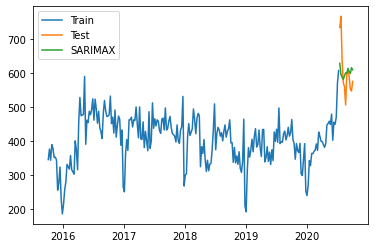

Total RMSE of top 10 selling products:  5248.014828022682 , total mape:  1384.180541462244


In [217]:

main_method([allRemainingProducts],horizons,params)




In [ ]:

mod = SARIMAX(df_prod['Salg_sum'], order=(0,0,1), seasonal_order=(0,0,2,52))
res = mod.fit()
# res.summary()
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = res.predict(start, end).rename('Prediction')
ax = test_df['Salg_sum'].plot(legend=True, figsize=(16,8))
prediction.plot(legend=True)


for x in df_prod[df_prod['Kampanje']>0].index:
    ax.axvline(x=x, color='r', linewidth=0.5);
    
    
    
# We must know when holidays will fall into the future because we can't
# predict the future prices and the holidays
# How did we perform and does adding holiday data improve it?
model_eval(test_df['Salg_sum'], prediction)

# Train now with the holiday data
auto_arima(df_prod['Salg_sum'], exogenous=df_prod[['Kampanje']], seasonal=True, 
          m=52, trace=True).summary()

In [ ]:

mod = SARIMAX(train_df['Salg_sum'], exog=train_df[['Kampanje']],
             order=(2,1,1), seasonal_order=(1,0,0,52))
res = mod.fit()
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction = res.predict(start, end, exog=test_df[['Kampanje']]).rename('Prediction')

ax = df_prod['Salg_sum'].plot(legend=True, figsize=(16,8))

prediction.plot(legend=True)


In [ ]:
model_eval(test_df['Salg_sum'], prediction)